# STEPS
1. From list of the ASF Sentinel-1 images extract info about datetime and date of making the photo. Extract also image LAT and LON along with the image width and height in pixels. 
2. From list of the AIS data extract info about the date of data. 
3. Join both dataframes (merge them). 

In [4]:
# import os
# os.environ["USE_PATH_FOR_GDAL_PYTHON"] = "YES"
# import gdal
# from osgeo import gdal

In [23]:
import pandas as pd
import os
import re
from datetime import datetime, timedelta
from osgeo import gdal

In [3]:
data_directory = '../data/'
asf_data_directory = data_directory + '3_processed_ASF_data/'
ais_data_directory = data_directory + '2_raw_AIS_csv_data/'
processed_ais_data_directory = data_directory +  '4_processed_AIS_data/'
interpolated_AIS_data_directory = data_directory + '5_interpolated_AIS_data/'
results_directory = '../results/'

In [20]:
# constants
TIME_WINDOW = 10 # in minutes, +/- how much time to take into consideration between datetime of making the photo
USE_END_DATETIME = False
USE_START_DATETIME = False
USE_MEAN_DATETIME = True

## PREPARE DATAFRAME

In [5]:
# read datetimes of making photos
asf_files_list = os.listdir(asf_data_directory)
asf_files_list = [ filename for filename in asf_files_list if filename.endswith('.tif') ]
# for element in asf_files_list:
#     if not element.endswith('.tif'):
#         asf_files_list.remove(element)

asf_files_list

['S1A_IW_GRDH_1SDV_20210204T015812_20210204T015841_036434_0446E1_2157_TC.tif',
 'S1B_IW_GRDH_1SDV_20210105T015737_20210105T015806_025013_02FA23_627F_TC.tif',
 'S1B_IW_GRDH_1SDV_20210306T015735_20210306T015804_025888_031671_7F65_TC.tif']

### Calculate image features

In [29]:
asf_images_tuples_list = list()

for asf_file in asf_files_list:
    datetime_counter = 0
    print(f"ASF file: {asf_file}")
    asf_file_splitted = asf_file.split('_')
    print(asf_file_splitted)
    datetime_pattern = re.compile("[A-Za-z0-9]+")
    for element in asf_file_splitted:
        if len(element) == 15:
            if datetime_pattern.match(element):
                datetime_counter += 1
                print(element)
                IMAGE_DATE = element[0:4] + '-' + element[4:6] + '-' + element[6:8]
                IMAGE_DATETIME = IMAGE_DATE + ' ' + element[9:11] + ':' + element[11:13] + ':' + element[13:15]
                #print(IMAGE_DATETIME)
                if datetime_counter == 1:
                    #START_DATETIME = IMAGE_DATETIME
                    START_DATETIME = pd.Timestamp(IMAGE_DATETIME)
                    #START_DATETIME = datetime.strptime(IMAGE_DATETIME, '%Y-%m-%d %H:%M:%S')
                elif datetime_counter == 2:
                    END_DATETIME = pd.Timestamp(IMAGE_DATETIME)
                    # END_DATETIME = datetime.strptime(IMAGE_DATETIME, '%Y-%m-%d %H:%M:%S')
                    # print(f"START DATETIME: {START_DATETIME}")
                    # START DATETIME: 2021-02-04 01:58:12
                    # print(f"START DATETIME: {datetime.strptime(START_DATETIME, '%Y-%m-%d %H:%M:%S')}")
                    MEAN_DATETIME = pd.Timestamp((START_DATETIME.value + END_DATETIME.value) / 2.0)
                    print(f"START DATETIME: {START_DATETIME}")
                    print(f"END DATETIME: {END_DATETIME}")
                    print(f"MEAN DATETIME: {MEAN_DATETIME}")
                    break # this break is here purposedly and is necessary                 
    
    if USE_MEAN_DATETIME == True:
        IMAGE_DATETIME = MEAN_DATETIME
    elif USE_START_DATETIME == True:
        IMAGE_DATETIME = START_DATETIME
    elif USE_END_DATETIME == True:
        IMAGE_DATETIME = END_DATETIME

    # LAT and LON calculations
    ds = gdal.Open(asf_data_directory + asf_file)
    width = ds.RasterXSize
    height = ds.RasterYSize
    gt = ds.GetGeoTransform()
    minx = gt[0]
    miny = gt[3] + width*gt[4] + height*gt[5] 
    maxx = gt[0] + width*gt[1] + height*gt[2]
    maxy = gt[3] 
    # final tuple
    asf_images_tuples_list.append((asf_file, IMAGE_DATETIME, IMAGE_DATE, minx, miny, maxx, maxy, width, height))

asf_df = pd.DataFrame(asf_images_tuples_list, columns =['asf_file', 'image_datetime', 'date', 'minLON', 'minLAT', 'maxLON', 'maxLAT', 'widthpx', 'heightpx'])
asf_df.image_datetime = pd.to_datetime(asf_df.image_datetime)
# boundaries +/- 10 minut
asf_df['datetime_lower'] = asf_df['image_datetime'] - timedelta(hours=0, minutes=TIME_WINDOW, seconds=0)
asf_df['datetime_upper'] = asf_df['image_datetime'] + timedelta(hours=0, minutes=TIME_WINDOW, seconds=0)
display(asf_df)

ASF file: S1A_IW_GRDH_1SDV_20210204T015812_20210204T015841_036434_0446E1_2157_TC.tif
['S1A', 'IW', 'GRDH', '1SDV', '20210204T015812', '20210204T015841', '036434', '0446E1', '2157', 'TC.tif']
20210204T015812
20210204T015841
START DATETIME: 2021-02-04 01:58:12
END DATETIME: 2021-02-04 01:58:41
MEAN DATETIME: 2021-02-04 01:58:26.500000
ASF file: S1B_IW_GRDH_1SDV_20210105T015737_20210105T015806_025013_02FA23_627F_TC.tif
['S1B', 'IW', 'GRDH', '1SDV', '20210105T015737', '20210105T015806', '025013', '02FA23', '627F', 'TC.tif']
20210105T015737
20210105T015806
START DATETIME: 2021-01-05 01:57:37
END DATETIME: 2021-01-05 01:58:06
MEAN DATETIME: 2021-01-05 01:57:51.500000
ASF file: S1B_IW_GRDH_1SDV_20210306T015735_20210306T015804_025888_031671_7F65_TC.tif
['S1B', 'IW', 'GRDH', '1SDV', '20210306T015735', '20210306T015804', '025888', '031671', '7F65', 'TC.tif']
20210306T015735
20210306T015804
START DATETIME: 2021-03-06 01:57:35
END DATETIME: 2021-03-06 01:58:04
MEAN DATETIME: 2021-03-06 01:57:49.50

asf_file          image_datetime  \
0  S1A_IW_GRDH_1SDV_20210204T015812_20210204T0158... 2021-02-04 01:58:26.500   
1  S1B_IW_GRDH_1SDV_20210105T015737_20210105T0158... 2021-01-05 01:57:51.500   
2  S1B_IW_GRDH_1SDV_20210306T015735_20210306T0158... 2021-03-06 01:57:49.500   

         date      minLON     minLAT      maxLON     maxLAT  widthpx  \
0  2021-02-04 -118.496252  33.197789 -117.964359  33.855266     5921   
1  2021-01-05 -118.575269  33.251929 -117.946359  33.930247     7001   
2  2021-03-06 -118.482835  33.199482 -117.980677  33.829740     5590   

   heightpx          datetime_lower          datetime_upper  
0      7319 2021-02-04 01:48:26.500 2021-02-04 02:08:26.500  
1      7551 2021-01-05 01:47:51.500 2021-01-05 02:07:51.500  
2      7016 2021-03-06 01:47:49.500 2021-03-06 02:07:49.500

In [30]:
ais_files_list = os.listdir(ais_data_directory)
ais_files_list = [ filename for filename in ais_files_list if filename.endswith('.csv') ]
# for element in ais_files_list:
#     if not element.endswith('.csv'):
#         ais_files_list.remove(element)
ais_files_list

['AIS_2021_01_05.csv', 'AIS_2021_02_04.csv', 'AIS_2021_03_06.csv']

In [31]:
ais_images_tuples_list = list()

for ais_file in ais_files_list:
    #print(ais_file)
    ais_file_splitted = ais_file.split('_')
    #print(ais_file_splitted)
    AIS_FILE_DATE = ais_file_splitted[1] + '-' + ais_file_splitted[2] + '-' + ais_file_splitted[3].split('.')[0]
    #print(AIS_FILE_DATE)
    ais_images_tuples_list.append((ais_file, AIS_FILE_DATE))
    
ais_df = pd.DataFrame(ais_images_tuples_list, columns =['ais_file', 'date'])
display(ais_df)

ais_file        date
0  AIS_2021_01_05.csv  2021-01-05
1  AIS_2021_02_04.csv  2021-02-04
2  AIS_2021_03_06.csv  2021-03-06

In [32]:
full_data_df = asf_df.merge(ais_df, on='date')
full_data_df

asf_file          image_datetime  \
0  S1A_IW_GRDH_1SDV_20210204T015812_20210204T0158... 2021-02-04 01:58:26.500   
1  S1B_IW_GRDH_1SDV_20210105T015737_20210105T0158... 2021-01-05 01:57:51.500   
2  S1B_IW_GRDH_1SDV_20210306T015735_20210306T0158... 2021-03-06 01:57:49.500   

         date      minLON     minLAT      maxLON     maxLAT  widthpx  \
0  2021-02-04 -118.496252  33.197789 -117.964359  33.855266     5921   
1  2021-01-05 -118.575269  33.251929 -117.946359  33.930247     7001   
2  2021-03-06 -118.482835  33.199482 -117.980677  33.829740     5590   

   heightpx          datetime_lower          datetime_upper  \
0      7319 2021-02-04 01:48:26.500 2021-02-04 02:08:26.500   
1      7551 2021-01-05 01:47:51.500 2021-01-05 02:07:51.500   
2      7016 2021-03-06 01:47:49.500 2021-03-06 02:07:49.500   

             ais_file  
0  AIS_2021_02_04.csv  
1  AIS_2021_01_05.csv  
2  AIS_2021_03_06.csv

In [33]:
# save your work
current_datetime = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
print(current_datetime)
full_data_df.to_csv(results_directory + current_datetime + '_full_data_df.csv')

2022-12-15_03-46-06


## WORK ON THE PREPARED DATAFRAME

### Restrict data by the given conditions

In [42]:
# full_data_df = pd.read_csv(results_directory + "2022-12-15_03-46-06_full_data_df.csv", index_col=0)
full_data_df

asf_file           image_datetime  \
0  S1A_IW_GRDH_1SDV_20210204T015812_20210204T0158...  2021-02-04 01:58:26.500   
1  S1B_IW_GRDH_1SDV_20210105T015737_20210105T0158...  2021-01-05 01:57:51.500   
2  S1B_IW_GRDH_1SDV_20210306T015735_20210306T0158...  2021-03-06 01:57:49.500   

         date      minLON     minLAT      maxLON     maxLAT  widthpx  \
0  2021-02-04 -118.496252  33.197789 -117.964359  33.855266     5921   
1  2021-01-05 -118.575269  33.251929 -117.946359  33.930247     7001   
2  2021-03-06 -118.482835  33.199482 -117.980677  33.829740     5590   

   heightpx           datetime_lower           datetime_upper  \
0      7319  2021-02-04 01:48:26.500  2021-02-04 02:08:26.500   
1      7551  2021-01-05 01:47:51.500  2021-01-05 02:07:51.500   
2      7016  2021-03-06 01:47:49.500  2021-03-06 02:07:49.500   

             ais_file  
0  AIS_2021_02_04.csv  
1  AIS_2021_01_05.csv  
2  AIS_2021_03_06.csv

In [45]:
for index, row in full_data_df.iterrows():
    print(row['ais_file'])
    file_path = ais_data_directory + str(row['ais_file'])
    ais_full_data = pd.read_csv(file_path)
    # display(ais_full_data.head(10))
    # condition for latitude: between 19.193 and 21.1203
    condition1 = (ais_full_data.LAT > row['minLAT']) & (ais_full_data.LAT < row['maxLAT'])
    # condition for latitude: between -157.0894 and -154.4233
    condition2 = (ais_full_data.LON > row['minLON']) & (ais_full_data.LON < row['maxLON'])
    # final dataframe
    target_area = ais_full_data[condition1 & condition2]
    # display(target_area)
    # target area contains 5542 rows × 17 columns
    target_area.reset_index(drop=True, inplace=True)
    target_area.BaseDateTime = pd.to_datetime(target_area.BaseDateTime)
    # target_area.loc['BaseDateTime'] = pd.to_datetime(target_area.loc['BaseDateTime'])
    # display(target_area)
    # filter by date: from 2021-01-05 00:00:00 to 2021-01-05 23:59:59
    DATE1 = row['datetime_lower']
    DATE2 = row['datetime_upper']
    target_area_and_time = target_area[(target_area.BaseDateTime >= DATE1) & (target_area.BaseDateTime <= DATE2)]
    target_area_and_time.reset_index(drop=True, inplace=True)
    target_area_and_time.sort_values(by='BaseDateTime', 
                                     axis=0, 
                                     ascending=True, 
                                     inplace=True, 
                                     kind='quicksort', 
                                     na_position='last', 
                                     ignore_index=True)
    # display(target_area_and_time)
    
    saving_name = 'processed_' + row['ais_file']
    target_area_and_time.to_csv(processed_ais_data_directory + saving_name)
    # all data is from 4th January 2021

# display(target_area_and_time.head(10))

AIS_2021_02_04.csv


C:\Users\user\AppData\Local\Temp\ipykernel_17308\456177703.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_area.BaseDateTime = pd.to_datetime(target_area.BaseDateTime)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\456177703.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_area_and_time.sort_values(by='BaseDateTime',


AIS_2021_01_05.csv


C:\Users\user\AppData\Local\Temp\ipykernel_17308\456177703.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_area.BaseDateTime = pd.to_datetime(target_area.BaseDateTime)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\456177703.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_area_and_time.sort_values(by='BaseDateTime',


AIS_2021_03_06.csv


C:\Users\user\AppData\Local\Temp\ipykernel_17308\456177703.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_area.BaseDateTime = pd.to_datetime(target_area.BaseDateTime)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\456177703.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_area_and_time.sort_values(by='BaseDateTime',


### Use algorithm to predict the best value from the TIME_WINDOW. 

In [46]:
#full_data_df = pd.read_csv(results_directory + "2022-10-15_16-37-28_full_data_df.csv", index_col=0)
full_data_df['processed_ais_file'] = 'processed_' + full_data_df['ais_file']
display(full_data_df)

asf_file           image_datetime  \
0  S1A_IW_GRDH_1SDV_20210204T015812_20210204T0158...  2021-02-04 01:58:26.500   
1  S1B_IW_GRDH_1SDV_20210105T015737_20210105T0158...  2021-01-05 01:57:51.500   
2  S1B_IW_GRDH_1SDV_20210306T015735_20210306T0158...  2021-03-06 01:57:49.500   

         date      minLON     minLAT      maxLON     maxLAT  widthpx  \
0  2021-02-04 -118.496252  33.197789 -117.964359  33.855266     5921   
1  2021-01-05 -118.575269  33.251929 -117.946359  33.930247     7001   
2  2021-03-06 -118.482835  33.199482 -117.980677  33.829740     5590   

   heightpx           datetime_lower           datetime_upper  \
0      7319  2021-02-04 01:48:26.500  2021-02-04 02:08:26.500   
1      7551  2021-01-05 01:47:51.500  2021-01-05 02:07:51.500   
2      7016  2021-03-06 01:47:49.500  2021-03-06 02:07:49.500   

             ais_file            processed_ais_file  
0  AIS_2021_02_04.csv  processed_AIS_2021_02_04.csv  
1  AIS_2021_01_05.csv  processed_AIS_2021_01_05.csv  
2  AIS_2021_03_06.csv  processed_AIS_2021_03_06.csv

In [47]:
def calculate_lin_reg_coefficients(x1, y1, x2, y2):
    """
    x is LON (longitude)
    y is LAT (latitude)
    """
    # y = ax + b
    # y1 = a*x1 + b
    # b = y1 - a*x1    
    # y2 = a*x2 + y1 - a*x1
    # y2 - y1 = a*x2 - a*x1
    # y2 - y1 = a*(x2-x1)    
    a = (y2 - y1) / (x2 - x1)
    b = y1 - a*x1
    return a, b

# The way of choosing ships (+/- time)

In [55]:
def categorise_sign_of_time_difference(row):  
    if row['time_difference'].days < 0:
        return 0
    return 1

In [65]:
for index, row in full_data_df.iterrows():
    print("file: ", index)
    print(row['processed_ais_file'])
    image_datetime = pd.to_datetime(row['image_datetime'])
    print('image_datetime:', image_datetime)
    file_path = processed_ais_data_directory + str(row['processed_ais_file'])
    processed_ais_full_data = pd.read_csv(file_path, index_col=0)
    processed_ais_full_data.BaseDateTime = pd.to_datetime(processed_ais_full_data.BaseDateTime)
    #display(processed_ais_full_data)
    
    # for every ship
    list_of_unique_ships = processed_ais_full_data.MMSI.unique()
    #display(list_of_unique_ships)
    
    list_of_df_dicts_after_lin_reg = list()
    for ship in list_of_unique_ships:
        print('ship:', ship)
        working_df = processed_ais_full_data[processed_ais_full_data.MMSI == ship]
        working_df.reset_index(drop=True, inplace=True)
        #display(working_df)
        time_difference = image_datetime - working_df['BaseDateTime']
        print(time_difference)
        working_df['time_difference'] = time_difference
        working_df['abs_time_difference'] = abs(time_difference)
        working_df['sign_time_difference'] = working_df.apply(lambda row: categorise_sign_of_time_difference(row), axis=1)
        # SORT TABLE ASCENDINGLY
        working_df.sort_values(by='abs_time_difference', 
                                 axis=0, 
                                 ascending=True, 
                                 inplace=True, 
                                 kind='quicksort', 
                                 na_position='last', 
                                 ignore_index=True)
#         print("working_df, first sorting: ")
#         display(working_df)
        
        if working_df.shape[0] > 1: # number of rows has to be greater than 1
            #transform datetime to integer - first 2 rows of sorted dataframe by time_difference
            # TODO HERE: change the way of choosing chips (+/- time)
            time1 = working_df['BaseDateTime'][0]
            time1 = int(time1.strftime("%H%M%S"))
            LON1 = working_df['LON'][0]
            LAT1 = working_df['LAT'][0]
            
            first_row_sign = working_df['sign_time_difference'][0]
            if first_row_sign == 0:
                looking_for_sign = 1
            else:
                looking_for_sign = 0
                
            second_working_df = working_df[working_df['sign_time_difference']==looking_for_sign]
            if len(second_working_df) == 0: # check if dataframe is empty
                time2 = working_df['BaseDateTime'][1]
                time2 = int(time2.strftime("%H%M%S"))
                LON2 = working_df['LON'][1]
                LAT2 = working_df['LAT'][1]
            else:
                second_working_df.sort_values(by='abs_time_difference', 
                                             axis=0, 
                                             ascending=True, 
                                             inplace=True, 
                                             kind='quicksort', 
                                             na_position='last', 
                                             ignore_index=True)
            
                time2 = second_working_df['BaseDateTime'][0]
                time2 = int(time2.strftime("%H%M%S"))
                LON2 = second_working_df['LON'][0]
                LAT2 = second_working_df['LAT'][0]
#                 print("working_df, second sorting: ")
#                 display(second_working_df)
            #print(f"time before conversion: {time1}, {time2}")

            # 1 opcja konwersji to zamiana całości daty i czasu na int (kosztowne obliczeniowo): 
            # 2021-02-04 01:57:13 -> 20210204015713
            #time1 = int(time1.strftime("%Y%m%d%H%M%S"))
            #time2 = int(time2.strftime("%Y%m%d%H%M%S"))

            # 2 opcja konwersji to zamiana tylko czasu na int (lepsze obliczeniowo): 
            # 2021-02-04 01:57:13 -> 15713
#             time1 = int(time1.strftime("%H%M%S"))
#             time2 = int(time2.strftime("%H%M%S"))
            #print(f"time after conversion: {time1}, {time2}")

            # calculate coefficient a1, b1 for LON (x)
#             LON1 = working_df['LON'][0]
#             LON2 = working_df['LON'][1]
#             LAT1 = working_df['LAT'][0]
#             LAT2 = working_df['LAT'][1]

            a1, b1 = calculate_lin_reg_coefficients(x1=time1, y1=LON1, x2=time2, y2=LON2)
            #print(f"LON equation: y = {a1}*x + {b1}")

            a2, b2 = calculate_lin_reg_coefficients(x1=time1, y1=LAT1, x2=time2, y2=LAT2)
            #print(f"LAT equation: y = {a2}*x + {b2}")

            time3 = int(image_datetime.strftime("%H%M%S"))
            #print(f"Image time after conversion: {time3}")

            image_LON = a1 * time3 + b1
            image_LAT = a2 * time3 + b2
            #print(f"Image LON: {image_LON}, LAT: {image_LAT}")
        else: 
            image_LON = working_df['LON'][0]
            image_LAT = working_df['LAT'][0]
        
        #prepare row for new dataframe
        # I take data from the first row (closest) from the two which I have used for calculations
        new_df_dict = {'MMSI': working_df['MMSI'][0],
                        'BaseDateTime': image_datetime,
                        'LAT': image_LAT,
                        'LON': image_LON,
                        'SOG': working_df['SOG'][0],
                        'COG': working_df['COG'][0],
                        'Heading': working_df['Heading'][0],
                        'VesselName': working_df['VesselName'][0],
                        'IMO': working_df['IMO'][0],
                        'CallSign': working_df['CallSign'][0],
                        'VesselType': working_df['VesselType'][0],
                        'Status': working_df['Status'][0],
                        'Length': working_df['Length'][0],
                        'Width': working_df['Width'][0],
                        'Draft': working_df['Draft'][0],
                        'Cargo': working_df['Cargo'][0],
                        'TranscieverClass': working_df['TranscieverClass'][0]}
        
        list_of_df_dicts_after_lin_reg.append(new_df_dict)
        #print(list_of_df_dicts_after_lin_reg)
    
    #display(list_of_df_dicts_after_lin_reg)
    df_after_lin_reg = pd.DataFrame.from_dict(list_of_df_dicts_after_lin_reg)
    saving_name = 'interpolated_' + row['processed_ais_file']
    df_after_lin_reg.to_csv(interpolated_AIS_data_directory + saving_name)
    # all data is from 4th January 2021
    
display(df_after_lin_reg)

file:  0
processed_AIS_2021_02_04.csv
image_datetime: 2021-02-04 01:58:26.500000
ship: 338060204
0     0 days 00:09:58.500000
1     0 days 00:06:56.500000
2     0 days 00:03:56.500000
3     0 days 00:00:57.500000
4   -1 days +23:57:58.500000
5   -1 days +23:55:00.500000
6   -1 days +23:51:59.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338060204 2021-02-04 01:57:29  33.72099 -118.27909  0.0  360.0    511.0   
1  338060204 2021-02-04 02:00:28  33.72100 -118.27909  0.0  360.0    511.0   
2  338060204 2021-02-04 01:54:30  33.72099 -118.27909  0.0  360.0    511.0   
3  338060204 2021-02-04 02:03:26  33.72099 -118.27909  0.0  360.0    511.0   
4  338060204 2021-02-04 01:51:30  33.72100 -118.27911  0.0  360.0    511.0   
5  338060204 2021-02-04 02:06:27  33.72099 -118.27911  0.0  360.0    511.0   
6  338060204 2021-02-04 01:48:28  33.72099 -118.27909  0.0  360.0    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
1        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
2        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
3        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
4        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
5        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
6        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                A   0 days 00:00:57.500000 0 days 00:00:57.500000   
1                A -1 days +23:57:58.500000 0 days 00:02:01.500000   
2                A   0 days 00:03:56.500000 0 days 00:03:56.500000   
3                A -1 days +23:55:00.500000 0 days 00:04:59.500000   
4                A   0 days 00:06:56.500000 0 days 00:06:56.500000   
5                A -1 days +23:51:59.500000 0 days 00:08:00.500000   
6                A   0 days 00:09:58.500000 0 days 00:09:58.500000   

   sign_time_difference  
0                     1  
1                     0  
2                     1  
3                     0  
4                     1  
5                     0  
6                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338060204 2021-02-04 02:00:28  33.72100 -118.27909  0.0  360.0    511.0   
1  338060204 2021-02-04 02:03:26  33.72099 -118.27909  0.0  360.0    511.0   
2  338060204 2021-02-04 02:06:27  33.72099 -118.27911  0.0  360.0    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
1        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
2        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                A -1 days +23:57:58.500000 0 days 00:02:01.500000   
1                A -1 days +23:55:00.500000 0 days 00:04:59.500000   
2                A -1 days +23:51:59.500000 0 days 00:08:00.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0

ship: 636092268
0     0 days 00:09:58.500000
1     0 days 00:07:00.500000
2     0 days 00:03:59.500000
3     0 days 00:00:58.500000
4   -1 days +23:57:58.500000
5   -1 days +23:54:57.500000
6   -1 days +23:51:57.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  636092268 2021-02-04 01:57:28  33.64163 -118.13371  0.0  184.2    262.0   
1  636092268 2021-02-04 02:00:28  33.64161 -118.13369  0.1  184.2    264.0   
2  636092268 2021-02-04 01:54:27  33.64166 -118.13375  0.0  184.2    259.0   
3  636092268 2021-02-04 02:03:29  33.64158 -118.13366  0.1  184.2    266.0   
4  636092268 2021-02-04 01:51:26  33.64171 -118.13376  0.1  184.2    256.0   
5  636092268 2021-02-04 02:06:29  33.64160 -118.13361  0.0  184.2    267.0   
6  636092268 2021-02-04 01:48:28  33.64178 -118.13379  0.1  184.2    253.0   

    VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  MSC RAVENNA  IMO9484431    A8ZU8        70.0     1.0   365.0   51.0   16.0   
1  MSC RAVENNA  IMO9484431    A8ZU8        70.0     1.0   365.0   51.0   16.0   
2  MSC RAVENNA  IMO9484431    A8ZU8        70.0     1.0   365.0   51.0   16.0   
3  MSC RAVENNA  IMO9484431    A8ZU8        70.0     1.0   365.0   51.0   16.0   
4  MSC RAVENNA  IMO9484431    A8ZU8        70.0     1.0   365.0   51.0   16.0   
5  MSC RAVENNA  IMO9484431    A8ZU8        70.0     1.0   365.0   51.0   16.0   
6  MSC RAVENNA  IMO9484431    A8ZU8        70.0     1.0   365.0   51.0   16.0   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                A   0 days 00:00:58.500000 0 days 00:00:58.500000   
1    NaN                A -1 days +23:57:58.500000 0 days 00:02:01.500000   
2    NaN                A   0 days 00:03:59.500000 0 days 00:03:59.500000   
3    NaN                A -1 days +23:54:57.500000 0 days 00:05:02.500000   
4    NaN                A   0 days 00:07:00.500000 0 days 00:07:00.500000   
5    NaN                A -1 days +23:51:57.500000 0 days 00:08:02.500000   
6    NaN                A   0 days 00:09:58.500000 0 days 00:09:58.500000   

   sign_time_difference  
0                     1  
1                     0  
2                     1  
3                     0  
4                     1  
5                     0  
6                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  636092268 2021-02-04 02:00:28  33.64161 -118.13369  0.1  184.2    264.0   
1  636092268 2021-02-04 02:03:29  33.64158 -118.13366  0.1  184.2    266.0   
2  636092268 2021-02-04 02:06:29  33.64160 -118.13361  0.0  184.2    267.0   

    VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  MSC RAVENNA  IMO9484431    A8ZU8        70.0     1.0   365.0   51.0   16.0   
1  MSC RAVENNA  IMO9484431    A8ZU8        70.0     1.0   365.0   51.0   16.0   
2  MSC RAVENNA  IMO9484431    A8ZU8        70.0     1.0   365.0   51.0   16.0   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                A -1 days +23:57:58.500000 0 days 00:02:01.500000   
1    NaN                A -1 days +23:54:57.500000 0 days 00:05:02.500000   
2    NaN                A -1 days +23:51:57.500000 0 days 00:08:02.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0

ship: 338162425
0     0 days 00:09:56.500000
1     0 days 00:06:55.500000
2     0 days 00:00:55.500000
3   -1 days +23:57:53.500000
4   -1 days +23:54:56.500000
5   -1 days +23:51:55.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338162425 2021-02-04 01:57:31  33.72281 -118.06875  0.0  271.0    511.0   
1  338162425 2021-02-04 02:00:33  33.72280 -118.06875  0.0  271.0    511.0   
2  338162425 2021-02-04 02:03:30  33.72280 -118.06874  0.0  271.0    511.0   
3  338162425 2021-02-04 01:51:31  33.72281 -118.06875  0.0  271.0    511.0   
4  338162425 2021-02-04 02:06:31  33.72281 -118.06875  0.0  271.0    511.0   
5  338162425 2021-02-04 01:48:30  33.72281 -118.06875  0.0  271.0    511.0   

          VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  CHELSEA SKYE  TWO  IMO0000000      NaN        37.0     NaN     0.0    0.0   
1  CHELSEA SKYE  TWO  IMO0000000      NaN        37.0     NaN     0.0    0.0   
2  CHELSEA SKYE  TWO  IMO0000000      NaN        37.0     NaN     0.0    0.0   
3  CHELSEA SKYE  TWO  IMO0000000      NaN        37.0     NaN     0.0    0.0   
4  CHELSEA SKYE  TWO  IMO0000000      NaN        37.0     NaN     0.0    0.0   
5  CHELSEA SKYE  TWO  IMO0000000      NaN        37.0     NaN     0.0    0.0   

   Draft  Cargo TranscieverClass          time_difference  \
0    NaN    NaN                B   0 days 00:00:55.500000   
1    NaN    NaN                B -1 days +23:57:53.500000   
2    NaN    NaN                B -1 days +23:54:56.500000   
3    NaN    NaN                B   0 days 00:06:55.500000   
4    NaN    NaN                B -1 days +23:51:55.500000   
5    NaN    NaN                B   0 days 00:09:56.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:00:55.500000                     1  
1 0 days 00:02:06.500000                     0  
2 0 days 00:05:03.500000                     0  
3 0 days 00:06:55.500000                     1  
4 0 days 00:08:04.500000                     0  
5 0 days 00:09:56.500000                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338162425 2021-02-04 02:00:33  33.72280 -118.06875  0.0  271.0    511.0   
1  338162425 2021-02-04 02:03:30  33.72280 -118.06874  0.0  271.0    511.0   
2  338162425 2021-02-04 02:06:31  33.72281 -118.06875  0.0  271.0    511.0   

          VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  CHELSEA SKYE  TWO  IMO0000000      NaN        37.0     NaN     0.0    0.0   
1  CHELSEA SKYE  TWO  IMO0000000      NaN        37.0     NaN     0.0    0.0   
2  CHELSEA SKYE  TWO  IMO0000000      NaN        37.0     NaN     0.0    0.0   

   Draft  Cargo TranscieverClass          time_difference  \
0    NaN    NaN                B -1 days +23:57:53.500000   
1    NaN    NaN                B -1 days +23:54:56.500000   
2    NaN    NaN                B -1 days +23:51:55.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:02:06.500000                     0  
1 0 days 00:05:03.500000                     0  
2 0 days 00:08:04.500000                     0

ship: 338229302
0     0 days 00:09:56.500000
1     0 days 00:06:56.500000
2   -1 days +23:57:55.500000
3   -1 days +23:51:56.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338229302 2021-02-04 02:00:31  33.75326 -118.11112  0.0  297.3    511.0   
1  338229302 2021-02-04 01:51:30  33.75330 -118.11112  0.0  269.9    511.0   
2  338229302 2021-02-04 02:06:30  33.75326 -118.11114  0.0  308.7    511.0   
3  338229302 2021-02-04 01:48:30  33.75330 -118.11113  0.0  277.3    511.0   

       VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  NAUTICAL SMILE  NaN      NaN        37.0     NaN     NaN    NaN    NaN   
1  NAUTICAL SMILE  NaN      NaN        37.0     NaN     NaN    NaN    NaN   
2  NAUTICAL SMILE  NaN      NaN        37.0     NaN     NaN    NaN    NaN   
3  NAUTICAL SMILE  NaN      NaN        37.0     NaN     NaN    NaN    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B -1 days +23:57:55.500000 0 days 00:02:04.500000   
1    NaN                B   0 days 00:06:56.500000 0 days 00:06:56.500000   
2    NaN                B -1 days +23:51:56.500000 0 days 00:08:03.500000   
3    NaN                B   0 days 00:09:56.500000 0 days 00:09:56.500000   

   sign_time_difference  
0                     0  
1                     1  
2                     0  
3                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime      LAT        LON  SOG    COG  Heading  \
0  338229302 2021-02-04 01:51:30  33.7533 -118.11112  0.0  269.9    511.0   
1  338229302 2021-02-04 01:48:30  33.7533 -118.11113  0.0  277.3    511.0   

       VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  NAUTICAL SMILE  NaN      NaN        37.0     NaN     NaN    NaN    NaN   
1  NAUTICAL SMILE  NaN      NaN        37.0     NaN     NaN    NaN    NaN   

   Cargo TranscieverClass        time_difference    abs_time_difference  \
0    NaN                B 0 days 00:06:56.500000 0 days 00:06:56.500000   
1    NaN                B 0 days 00:09:56.500000 0 days 00:09:56.500000   

   sign_time_difference  
0                     1  
1                     1

ship: 338100018
0     0 days 00:09:55.500000
1     0 days 00:06:54.500000
2     0 days 00:03:54.500000
3     0 days 00:00:56.500000
4   -1 days +23:57:56.500000
5   -1 days +23:54:56.500000
6   -1 days +23:51:54.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338100018 2021-02-04 01:57:30  33.84866 -118.39931  0.0  292.0    511.0   
1  338100018 2021-02-04 02:00:30  33.84867 -118.39937  0.0    0.0    511.0   
2  338100018 2021-02-04 01:54:32  33.84864 -118.39930  0.0  270.2    511.0   
3  338100018 2021-02-04 02:03:30  33.84866 -118.39939  0.0  259.0    511.0   
4  338100018 2021-02-04 01:51:32  33.84866 -118.39935  0.0    0.0    511.0   
5  338100018 2021-02-04 02:06:32  33.84868 -118.39936  0.0  268.9    511.0   
6  338100018 2021-02-04 01:48:31  33.84867 -118.39935  0.0    0.0    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0   MARE'ZIA  NaN      NaN        37.0     NaN    12.0    3.0    NaN    NaN   
1   MARE'ZIA  NaN      NaN        37.0     NaN    12.0    3.0    NaN    NaN   
2   MARE'ZIA  NaN      NaN        37.0     NaN    12.0    3.0    NaN    NaN   
3   MARE'ZIA  NaN      NaN        37.0     NaN    12.0    3.0    NaN    NaN   
4   MARE'ZIA  NaN      NaN        37.0     NaN    12.0    3.0    NaN    NaN   
5   MARE'ZIA  NaN      NaN        37.0     NaN    12.0    3.0    NaN    NaN   
6   MARE'ZIA  NaN      NaN        37.0     NaN    12.0    3.0    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                B   0 days 00:00:56.500000 0 days 00:00:56.500000   
1                B -1 days +23:57:56.500000 0 days 00:02:03.500000   
2                B   0 days 00:03:54.500000 0 days 00:03:54.500000   
3                B -1 days +23:54:56.500000 0 days 00:05:03.500000   
4                B   0 days 00:06:54.500000 0 days 00:06:54.500000   
5                B -1 days +23:51:54.500000 0 days 00:08:05.500000   
6                B   0 days 00:09:55.500000 0 days 00:09:55.500000   

   sign_time_difference  
0                     1  
1                     0  
2                     1  
3                     0  
4                     1  
5                     0  
6                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338100018 2021-02-04 02:00:30  33.84867 -118.39937  0.0    0.0    511.0   
1  338100018 2021-02-04 02:03:30  33.84866 -118.39939  0.0  259.0    511.0   
2  338100018 2021-02-04 02:06:32  33.84868 -118.39936  0.0  268.9    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0   MARE'ZIA  NaN      NaN        37.0     NaN    12.0    3.0    NaN    NaN   
1   MARE'ZIA  NaN      NaN        37.0     NaN    12.0    3.0    NaN    NaN   
2   MARE'ZIA  NaN      NaN        37.0     NaN    12.0    3.0    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                B -1 days +23:57:56.500000 0 days 00:02:03.500000   
1                B -1 days +23:54:56.500000 0 days 00:05:03.500000   
2                B -1 days +23:51:54.500000 0 days 00:08:05.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0

ship: 354891000
0     0 days 00:09:55.500000
1     0 days 00:06:57.500000
2     0 days 00:03:55.500000
3     0 days 00:00:54.500000
4   -1 days +23:57:54.500000
5   -1 days +23:54:54.500000
6   -1 days +23:51:56.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  354891000 2021-02-04 01:57:32  33.66595 -118.12231  0.1  172.6    269.0   
1  354891000 2021-02-04 02:00:32  33.66592 -118.12230  0.1  172.6    269.0   
2  354891000 2021-02-04 01:54:31  33.66596 -118.12232  0.1  172.6    270.0   
3  354891000 2021-02-04 02:03:32  33.66589 -118.12228  0.1  172.6    269.0   
4  354891000 2021-02-04 01:51:29  33.66598 -118.12231  0.1  172.6    270.0   
5  354891000 2021-02-04 02:06:30  33.66583 -118.12231  0.1  172.6    271.0   
6  354891000 2021-02-04 01:48:31  33.66601 -118.12227  0.1  172.6    268.0   

   VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  NYK NEBULA  IMO9337640    3ENG6        70.0     1.0   294.0   32.0   13.5   
1  NYK NEBULA  IMO9337640    3ENG6        70.0     1.0   294.0   32.0   13.5   
2  NYK NEBULA  IMO9337640    3ENG6        70.0     1.0   294.0   32.0   13.5   
3  NYK NEBULA  IMO9337640    3ENG6        70.0     1.0   294.0   32.0   13.5   
4  NYK NEBULA  IMO9337640    3ENG6        70.0     1.0   294.0   32.0   13.5   
5  NYK NEBULA  IMO9337640    3ENG6        70.0     1.0   294.0   32.0   13.5   
6  NYK NEBULA  IMO9337640    3ENG6        70.0     1.0   294.0   32.0   13.5   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0   71.0                A   0 days 00:00:54.500000 0 days 00:00:54.500000   
1   71.0                A -1 days +23:57:54.500000 0 days 00:02:05.500000   
2   71.0                A   0 days 00:03:55.500000 0 days 00:03:55.500000   
3   71.0                A -1 days +23:54:54.500000 0 days 00:05:05.500000   
4   71.0                A   0 days 00:06:57.500000 0 days 00:06:57.500000   
5   71.0                A -1 days +23:51:56.500000 0 days 00:08:03.500000   
6   71.0                A   0 days 00:09:55.500000 0 days 00:09:55.500000   

   sign_time_difference  
0                     1  
1                     0  
2                     1  
3                     0  
4                     1  
5                     0  
6                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  354891000 2021-02-04 02:00:32  33.66592 -118.12230  0.1  172.6    269.0   
1  354891000 2021-02-04 02:03:32  33.66589 -118.12228  0.1  172.6    269.0   
2  354891000 2021-02-04 02:06:30  33.66583 -118.12231  0.1  172.6    271.0   

   VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  NYK NEBULA  IMO9337640    3ENG6        70.0     1.0   294.0   32.0   13.5   
1  NYK NEBULA  IMO9337640    3ENG6        70.0     1.0   294.0   32.0   13.5   
2  NYK NEBULA  IMO9337640    3ENG6        70.0     1.0   294.0   32.0   13.5   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0   71.0                A -1 days +23:57:54.500000 0 days 00:02:05.500000   
1   71.0                A -1 days +23:54:54.500000 0 days 00:05:05.500000   
2   71.0                A -1 days +23:51:56.500000 0 days 00:08:03.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0

ship: 310531000
0     0 days 00:09:55.500000
1     0 days 00:06:51.500000
2     0 days 00:03:52.500000
3     0 days 00:00:50.500000
4   -1 days +23:57:48.500000
5   -1 days +23:54:49.500000
6   -1 days +23:51:45.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  310531000 2021-02-04 01:57:36  33.73418 -118.17017  0.1  219.0    219.0   
1  310531000 2021-02-04 02:00:38  33.73405 -118.17020  0.1  171.9    217.0   
2  310531000 2021-02-04 01:54:34  33.73430 -118.17018  0.1  134.0    224.0   
3  310531000 2021-02-04 02:03:37  33.73402 -118.17027  0.1  308.0    218.0   
4  310531000 2021-02-04 01:51:35  33.73437 -118.17038  0.1   99.0    234.0   
5  310531000 2021-02-04 02:06:41  33.73407 -118.17032  0.1  356.9    222.0   
6  310531000 2021-02-04 01:48:31  33.73435 -118.17048  0.1  332.0    242.0   

         VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  EMERALD PRINCESS  IMO9333151    ZCDP8        60.0     1.0   288.0   36.0   
1  EMERALD PRINCESS  IMO9333151    ZCDP8        60.0     1.0   288.0   36.0   
2  EMERALD PRINCESS  IMO9333151    ZCDP8        60.0     1.0   288.0   36.0   
3  EMERALD PRINCESS  IMO9333151    ZCDP8        60.0     1.0   288.0   36.0   
4  EMERALD PRINCESS  IMO9333151    ZCDP8        60.0     1.0   288.0   36.0   
5  EMERALD PRINCESS  IMO9333151    ZCDP8        60.0     1.0   288.0   36.0   
6  EMERALD PRINCESS  IMO9333151    ZCDP8        60.0     1.0   288.0   36.0   

   Draft  Cargo TranscieverClass          time_difference  \
0    8.5   69.0                A   0 days 00:00:50.500000   
1    8.5   69.0                A -1 days +23:57:48.500000   
2    8.5   69.0                A   0 days 00:03:52.500000   
3    8.5   69.0                A -1 days +23:54:49.500000   
4    8.5   69.0                A   0 days 00:06:51.500000   
5    8.5   69.0                A -1 days +23:51:45.500000   
6    8.5   69.0                A   0 days 00:09:55.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:00:50.500000                     1  
1 0 days 00:02:11.500000                     0  
2 0 days 00:03:52.500000                     1  
3 0 days 00:05:10.500000                     0  
4 0 days 00:06:51.500000                     1  
5 0 days 00:08:14.500000                     0  
6 0 days 00:09:55.500000                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  310531000 2021-02-04 02:00:38  33.73405 -118.17020  0.1  171.9    217.0   
1  310531000 2021-02-04 02:03:37  33.73402 -118.17027  0.1  308.0    218.0   
2  310531000 2021-02-04 02:06:41  33.73407 -118.17032  0.1  356.9    222.0   

         VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  EMERALD PRINCESS  IMO9333151    ZCDP8        60.0     1.0   288.0   36.0   
1  EMERALD PRINCESS  IMO9333151    ZCDP8        60.0     1.0   288.0   36.0   
2  EMERALD PRINCESS  IMO9333151    ZCDP8        60.0     1.0   288.0   36.0   

   Draft  Cargo TranscieverClass          time_difference  \
0    8.5   69.0                A -1 days +23:57:48.500000   
1    8.5   69.0                A -1 days +23:54:49.500000   
2    8.5   69.0                A -1 days +23:51:45.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:02:11.500000                     0  
1 0 days 00:05:10.500000                     0  
2 0 days 00:08:14.500000                     0

ship: 338122738
0     0 days 00:09:55.500000
1     0 days 00:03:55.500000
2     0 days 00:00:55.500000
3   -1 days +23:57:54.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338122738 2021-02-04 01:57:31  33.72395 -118.28373  0.0  250.0    511.0   
1  338122738 2021-02-04 02:00:32  33.72395 -118.28373  0.0  250.0    511.0   
2  338122738 2021-02-04 01:54:31  33.72397 -118.28375  0.0  250.0    511.0   
3  338122738 2021-02-04 01:48:31  33.72396 -118.28373  0.0  250.0    511.0   

    VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0  FREE SPIRIT  NaN      NaN        37.0     NaN    12.0    NaN    NaN    NaN   
1  FREE SPIRIT  NaN      NaN        37.0     NaN    12.0    NaN    NaN    NaN   
2  FREE SPIRIT  NaN      NaN        37.0     NaN    12.0    NaN    NaN    NaN   
3  FREE SPIRIT  NaN      NaN        37.0     NaN    12.0    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                B   0 days 00:00:55.500000 0 days 00:00:55.500000   
1                B -1 days +23:57:54.500000 0 days 00:02:05.500000   
2                B   0 days 00:03:55.500000 0 days 00:03:55.500000   
3                B   0 days 00:09:55.500000 0 days 00:09:55.500000   

   sign_time_difference  
0                     1  
1                     0  
2                     1  
3                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338122738 2021-02-04 02:00:32  33.72395 -118.28373  0.0  250.0    511.0   

    VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0  FREE SPIRIT  NaN      NaN        37.0     NaN    12.0    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                B -1 days +23:57:54.500000 0 days 00:02:05.500000   

   sign_time_difference  
0                     0

ship: 338352671
0     0 days 00:09:54.500000
1     0 days 00:06:49.500000
2     0 days 00:03:55.500000
3     0 days 00:00:54.500000
4   -1 days +23:54:55.500000
5   -1 days +23:51:47.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338352671 2021-02-04 01:57:32  33.72170 -118.27936  0.0  286.5    511.0   
1  338352671 2021-02-04 01:54:31  33.72171 -118.27936  0.0  278.0    511.0   
2  338352671 2021-02-04 02:03:31  33.72169 -118.27934  0.0  310.1    511.0   
3  338352671 2021-02-04 01:51:37  33.72170 -118.27936  0.0  272.5    511.0   
4  338352671 2021-02-04 02:06:39  33.72172 -118.27937  0.0  314.2    511.0   
5  338352671 2021-02-04 01:48:32  33.72169 -118.27938  0.0  265.6    511.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0    ZORYANA  IMO0000000      NaN        37.0     NaN     0.0    0.0    NaN   
1    ZORYANA  IMO0000000      NaN        37.0     NaN     0.0    0.0    NaN   
2    ZORYANA  IMO0000000      NaN        37.0     NaN     0.0    0.0    NaN   
3    ZORYANA  IMO0000000      NaN        37.0     NaN     0.0    0.0    NaN   
4    ZORYANA  IMO0000000      NaN        37.0     NaN     0.0    0.0    NaN   
5    ZORYANA  IMO0000000      NaN        37.0     NaN     0.0    0.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B   0 days 00:00:54.500000 0 days 00:00:54.500000   
1    NaN                B   0 days 00:03:55.500000 0 days 00:03:55.500000   
2    NaN                B -1 days +23:54:55.500000 0 days 00:05:04.500000   
3    NaN                B   0 days 00:06:49.500000 0 days 00:06:49.500000   
4    NaN                B -1 days +23:51:47.500000 0 days 00:08:12.500000   
5    NaN                B   0 days 00:09:54.500000 0 days 00:09:54.500000   

   sign_time_difference  
0                     1  
1                     1  
2                     0  
3                     1  
4                     0  
5                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338352671 2021-02-04 02:03:31  33.72169 -118.27934  0.0  310.1    511.0   
1  338352671 2021-02-04 02:06:39  33.72172 -118.27937  0.0  314.2    511.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0    ZORYANA  IMO0000000      NaN        37.0     NaN     0.0    0.0    NaN   
1    ZORYANA  IMO0000000      NaN        37.0     NaN     0.0    0.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B -1 days +23:54:55.500000 0 days 00:05:04.500000   
1    NaN                B -1 days +23:51:47.500000 0 days 00:08:12.500000   

   sign_time_difference  
0                     0  
1                     0

ship: 338366226
0      0 days 00:09:54.500000
1      0 days 00:08:44.500000
2      0 days 00:07:33.500000
3      0 days 00:06:25.500000
4      0 days 00:05:14.500000
5      0 days 00:04:05.500000
6      0 days 00:02:25.500000
7      0 days 00:01:14.500000
8      0 days 00:00:13.500000
9    -1 days +23:59:03.500000
10   -1 days +23:58:24.500000
11   -1 days +23:57:21.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0   338366226 2021-02-04 01:58:13  33.71636 -118.27787  0.5  344.4    339.0   
1   338366226 2021-02-04 01:59:23  33.71650 -118.27789  0.3    0.6    346.0   
2   338366226 2021-02-04 01:57:12  33.71617 -118.27780  2.9  336.4    331.0   
3   338366226 2021-02-04 02:00:02  33.71656 -118.27788  0.4  352.3    335.0   
4   338366226 2021-02-04 01:56:01  33.71340 -118.27499  8.7  290.2    292.0   
5   338366226 2021-02-04 02:01:05  33.71710 -118.27818  2.0  327.7    326.0   
6   338366226 2021-02-04 01:54:21  33.71304 -118.27313  8.7  267.7    269.0   
7   338366226 2021-02-04 01:53:12  33.71316 -118.26979  8.8  268.3    269.0   
8   338366226 2021-02-04 01:52:01  33.71329 -118.26639  8.7  267.0    269.0   
9   338366226 2021-02-04 01:50:53  33.71338 -118.26311  8.7  267.6    269.0   
10  338366226 2021-02-04 01:49:42  33.71344 -118.25970  8.6  268.8    269.0   
11  338366226 2021-02-04 01:48:32  33.71352 -118.25631  8.7  268.8    268.0   

   VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0         NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   
1         NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   
2         NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   
3         NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   
4         NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   
5         NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   
6         NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   
7         NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   
8         NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   
9         NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   
10        NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   
11        NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   

   TranscieverClass          time_difference    abs_time_difference  \
0                 A   0 days 00:00:13.500000 0 days 00:00:13.500000   
1                 A -1 days +23:59:03.500000 0 days 00:00:56.500000   
2                 A   0 days 00:01:14.500000 0 days 00:01:14.500000   
3                 A -1 days +23:58:24.500000 0 days 00:01:35.500000   
4                 A   0 days 00:02:25.500000 0 days 00:02:25.500000   
5                 A -1 days +23:57:21.500000 0 days 00:02:38.500000   
6                 A   0 days 00:04:05.500000 0 days 00:04:05.500000   
7                 A   0 days 00:05:14.500000 0 days 00:05:14.500000   
8                 A   0 days 00:06:25.500000 0 days 00:06:25.500000   
9                 A   0 days 00:07:33.500000 0 days 00:07:33.500000   
10                A   0 days 00:08:44.500000 0 days 00:08:44.500000   
11                A   0 days 00:09:54.500000 0 days 00:09:54.500000   

    sign_time_difference  
0                      1  
1                      0  
2                      1  
3                      0  
4                      1  
5                      0  
6                      1  
7                      1  
8                      1  
9                      1  
10                     1  
11                     1

C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


working_df, second sorting: 


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338366226 2021-02-04 01:59:23  33.71650 -118.27789  0.3    0.6    346.0   
1  338366226 2021-02-04 02:00:02  33.71656 -118.27788  0.4  352.3    335.0   
2  338366226 2021-02-04 02:01:05  33.71710 -118.27818  2.0  327.7    326.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   
1        NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   
2        NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                A -1 days +23:59:03.500000 0 days 00:00:56.500000   
1                A -1 days +23:58:24.500000 0 days 00:01:35.500000   
2                A -1 days +23:57:21.500000 0 days 00:02:38.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0

ship: 235414000
0     0 days 00:09:53.500000
1     0 days 00:06:52.500000
2     0 days 00:03:52.500000
3     0 days 00:00:52.500000
4   -1 days +23:57:52.500000
5   -1 days +23:54:52.500000
6   -1 days +23:51:53.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  235414000 2021-02-04 01:57:34  33.70529 -118.12980  0.1  210.1    251.0   
1  235414000 2021-02-04 02:00:34  33.70528 -118.12979  0.0  184.8    250.0   
2  235414000 2021-02-04 01:54:34  33.70532 -118.12977  0.1  222.4    250.0   
3  235414000 2021-02-04 02:03:34  33.70532 -118.12977  0.0   99.2    250.0   
4  235414000 2021-02-04 01:51:34  33.70533 -118.12974  0.1  189.4    249.0   
5  235414000 2021-02-04 02:06:33  33.70535 -118.12971  0.0  110.7    252.0   
6  235414000 2021-02-04 01:48:33  33.70539 -118.12974  0.0  123.0    247.0   

   VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  EVER ENVOY  IMO9241308    VSQL9        70.0     1.0   300.0   42.0   13.5   
1  EVER ENVOY  IMO9241308    VSQL9        70.0     1.0   300.0   42.0   13.5   
2  EVER ENVOY  IMO9241308    VSQL9        70.0     1.0   300.0   42.0   13.5   
3  EVER ENVOY  IMO9241308    VSQL9        70.0     1.0   300.0   42.0   13.5   
4  EVER ENVOY  IMO9241308    VSQL9        70.0     1.0   300.0   42.0   13.5   
5  EVER ENVOY  IMO9241308    VSQL9        70.0     1.0   300.0   42.0   13.5   
6  EVER ENVOY  IMO9241308    VSQL9        70.0     1.0   300.0   42.0   13.5   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                A   0 days 00:00:52.500000 0 days 00:00:52.500000   
1    NaN                A -1 days +23:57:52.500000 0 days 00:02:07.500000   
2    NaN                A   0 days 00:03:52.500000 0 days 00:03:52.500000   
3    NaN                A -1 days +23:54:52.500000 0 days 00:05:07.500000   
4    NaN                A   0 days 00:06:52.500000 0 days 00:06:52.500000   
5    NaN                A -1 days +23:51:53.500000 0 days 00:08:06.500000   
6    NaN                A   0 days 00:09:53.500000 0 days 00:09:53.500000   

   sign_time_difference  
0                     1  
1                     0  
2                     1  
3                     0  
4                     1  
5                     0  
6                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  235414000 2021-02-04 02:00:34  33.70528 -118.12979  0.0  184.8    250.0   
1  235414000 2021-02-04 02:03:34  33.70532 -118.12977  0.0   99.2    250.0   
2  235414000 2021-02-04 02:06:33  33.70535 -118.12971  0.0  110.7    252.0   

   VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  EVER ENVOY  IMO9241308    VSQL9        70.0     1.0   300.0   42.0   13.5   
1  EVER ENVOY  IMO9241308    VSQL9        70.0     1.0   300.0   42.0   13.5   
2  EVER ENVOY  IMO9241308    VSQL9        70.0     1.0   300.0   42.0   13.5   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                A -1 days +23:57:52.500000 0 days 00:02:07.500000   
1    NaN                A -1 days +23:54:52.500000 0 days 00:05:07.500000   
2    NaN                A -1 days +23:51:53.500000 0 days 00:08:06.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0

ship: 368048380
0     0 days 00:09:52.500000
1     0 days 00:06:52.500000
2     0 days 00:03:49.500000
3     0 days 00:00:50.500000
4   -1 days +23:57:49.500000
5   -1 days +23:54:50.500000
6   -1 days +23:51:51.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  368048380 2021-02-04 01:57:36  33.75135 -118.11023  0.0  302.5    511.0   
1  368048380 2021-02-04 02:00:37  33.75135 -118.11023  0.0  302.5    511.0   
2  368048380 2021-02-04 01:54:37  33.75136 -118.11022  0.0  302.5    511.0   
3  368048380 2021-02-04 02:03:36  33.75133 -118.11024  0.0  302.5    511.0   
4  368048380 2021-02-04 01:51:34  33.75135 -118.11023  0.0  302.5    511.0   
5  368048380 2021-02-04 02:06:35  33.75136 -118.11024  0.0  302.5    511.0   
6  368048380 2021-02-04 01:48:34  33.75134 -118.11024  0.0  302.5    511.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  TAVISH B.  IMO0000000  WDK3754        37.0     NaN    12.0    4.0    NaN   
1  TAVISH B.  IMO0000000  WDK3754        37.0     NaN    12.0    4.0    NaN   
2  TAVISH B.  IMO0000000  WDK3754        37.0     NaN    12.0    4.0    NaN   
3  TAVISH B.  IMO0000000  WDK3754        37.0     NaN    12.0    4.0    NaN   
4  TAVISH B.  IMO0000000  WDK3754        37.0     NaN    12.0    4.0    NaN   
5  TAVISH B.  IMO0000000  WDK3754        37.0     NaN    12.0    4.0    NaN   
6  TAVISH B.  IMO0000000  WDK3754        37.0     NaN    12.0    4.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B   0 days 00:00:50.500000 0 days 00:00:50.500000   
1    NaN                B -1 days +23:57:49.500000 0 days 00:02:10.500000   
2    NaN                B   0 days 00:03:49.500000 0 days 00:03:49.500000   
3    NaN                B -1 days +23:54:50.500000 0 days 00:05:09.500000   
4    NaN                B   0 days 00:06:52.500000 0 days 00:06:52.500000   
5    NaN                B -1 days +23:51:51.500000 0 days 00:08:08.500000   
6    NaN                B   0 days 00:09:52.500000 0 days 00:09:52.500000   

   sign_time_difference  
0                     1  
1                     0  
2                     1  
3                     0  
4                     1  
5                     0  
6                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  368048380 2021-02-04 02:00:37  33.75135 -118.11023  0.0  302.5    511.0   
1  368048380 2021-02-04 02:03:36  33.75133 -118.11024  0.0  302.5    511.0   
2  368048380 2021-02-04 02:06:35  33.75136 -118.11024  0.0  302.5    511.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  TAVISH B.  IMO0000000  WDK3754        37.0     NaN    12.0    4.0    NaN   
1  TAVISH B.  IMO0000000  WDK3754        37.0     NaN    12.0    4.0    NaN   
2  TAVISH B.  IMO0000000  WDK3754        37.0     NaN    12.0    4.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B -1 days +23:57:49.500000 0 days 00:02:10.500000   
1    NaN                B -1 days +23:54:50.500000 0 days 00:05:09.500000   
2    NaN                B -1 days +23:51:51.500000 0 days 00:08:08.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0

ship: 566828000
0     0 days 00:09:51.500000
1     0 days 00:06:51.500000
2     0 days 00:03:51.500000
3     0 days 00:00:53.500000
4   -1 days +23:57:53.500000
5   -1 days +23:54:50.500000
6   -1 days +23:51:51.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  566828000 2021-02-04 01:57:33  33.69718 -118.11972  0.0  291.0    255.0   
1  566828000 2021-02-04 02:00:33  33.69720 -118.11972  0.0   37.0    256.0   
2  566828000 2021-02-04 01:54:35  33.69713 -118.11962  0.0  305.0    257.0   
3  566828000 2021-02-04 02:03:36  33.69727 -118.11968  0.0    3.0    256.0   
4  566828000 2021-02-04 01:51:35  33.69708 -118.11958  0.1  194.0    258.0   
5  566828000 2021-02-04 02:06:35  33.69733 -118.11975  0.1  334.0    251.0   
6  566828000 2021-02-04 01:48:35  33.69708 -118.11967  0.0  194.0    254.0   

    VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  WAN HAI 515  IMO9457646   9V7851        70.0     1.0   258.0   37.0   12.8   
1  WAN HAI 515  IMO9457646   9V7851        70.0     1.0   258.0   37.0   12.8   
2  WAN HAI 515  IMO9457646   9V7851        70.0     1.0   258.0   37.0   12.8   
3  WAN HAI 515  IMO9457646   9V7851        70.0     1.0   258.0   37.0   12.8   
4  WAN HAI 515  IMO9457646   9V7851        70.0     1.0   258.0   37.0   12.8   
5  WAN HAI 515  IMO9457646   9V7851        70.0     1.0   258.0   37.0   12.8   
6  WAN HAI 515  IMO9457646   9V7851        70.0     1.0   258.0   37.0   12.8   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0   70.0                A   0 days 00:00:53.500000 0 days 00:00:53.500000   
1   70.0                A -1 days +23:57:53.500000 0 days 00:02:06.500000   
2   70.0                A   0 days 00:03:51.500000 0 days 00:03:51.500000   
3   70.0                A -1 days +23:54:50.500000 0 days 00:05:09.500000   
4   70.0                A   0 days 00:06:51.500000 0 days 00:06:51.500000   
5   70.0                A -1 days +23:51:51.500000 0 days 00:08:08.500000   
6   70.0                A   0 days 00:09:51.500000 0 days 00:09:51.500000   

   sign_time_difference  
0                     1  
1                     0  
2                     1  
3                     0  
4                     1  
5                     0  
6                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  566828000 2021-02-04 02:00:33  33.69720 -118.11972  0.0   37.0    256.0   
1  566828000 2021-02-04 02:03:36  33.69727 -118.11968  0.0    3.0    256.0   
2  566828000 2021-02-04 02:06:35  33.69733 -118.11975  0.1  334.0    251.0   

    VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  WAN HAI 515  IMO9457646   9V7851        70.0     1.0   258.0   37.0   12.8   
1  WAN HAI 515  IMO9457646   9V7851        70.0     1.0   258.0   37.0   12.8   
2  WAN HAI 515  IMO9457646   9V7851        70.0     1.0   258.0   37.0   12.8   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0   70.0                A -1 days +23:57:53.500000 0 days 00:02:06.500000   
1   70.0                A -1 days +23:54:50.500000 0 days 00:05:09.500000   
2   70.0                A -1 days +23:51:51.500000 0 days 00:08:08.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0

ship: 338098732
0     0 days 00:09:50.500000
1     0 days 00:06:46.500000
2     0 days 00:03:52.500000
3   -1 days +23:57:51.500000
4   -1 days +23:54:52.500000
5   -1 days +23:51:50.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338098732 2021-02-04 02:00:35  33.72033 -118.28006  0.0  266.9    511.0   
1  338098732 2021-02-04 01:54:34  33.72036 -118.28006  0.0  260.6    511.0   
2  338098732 2021-02-04 02:03:34  33.72033 -118.28007  0.0  283.6    511.0   
3  338098732 2021-02-04 01:51:40  33.72034 -118.28005  0.1  256.0    511.0   
4  338098732 2021-02-04 02:06:36  33.72034 -118.28008  0.0  292.5    511.0   
5  338098732 2021-02-04 01:48:36  33.72035 -118.28005  0.0  257.0    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0     IKAROS  NaN      NaN        37.0     NaN    18.0    5.0    NaN    NaN   
1     IKAROS  NaN      NaN        37.0     NaN    18.0    5.0    NaN    NaN   
2     IKAROS  NaN      NaN        37.0     NaN    18.0    5.0    NaN    NaN   
3     IKAROS  NaN      NaN        37.0     NaN    18.0    5.0    NaN    NaN   
4     IKAROS  NaN      NaN        37.0     NaN    18.0    5.0    NaN    NaN   
5     IKAROS  NaN      NaN        37.0     NaN    18.0    5.0    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                B -1 days +23:57:51.500000 0 days 00:02:08.500000   
1                B   0 days 00:03:52.500000 0 days 00:03:52.500000   
2                B -1 days +23:54:52.500000 0 days 00:05:07.500000   
3                B   0 days 00:06:46.500000 0 days 00:06:46.500000   
4                B -1 days +23:51:50.500000 0 days 00:08:09.500000   
5                B   0 days 00:09:50.500000 0 days 00:09:50.500000   

   sign_time_difference  
0                     0  
1                     1  
2                     0  
3                     1  
4                     0  
5                     1

C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


working_df, second sorting: 


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338098732 2021-02-04 01:54:34  33.72036 -118.28006  0.0  260.6    511.0   
1  338098732 2021-02-04 01:51:40  33.72034 -118.28005  0.1  256.0    511.0   
2  338098732 2021-02-04 01:48:36  33.72035 -118.28005  0.0  257.0    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0     IKAROS  NaN      NaN        37.0     NaN    18.0    5.0    NaN    NaN   
1     IKAROS  NaN      NaN        37.0     NaN    18.0    5.0    NaN    NaN   
2     IKAROS  NaN      NaN        37.0     NaN    18.0    5.0    NaN    NaN   

  TranscieverClass        time_difference    abs_time_difference  \
0                B 0 days 00:03:52.500000 0 days 00:03:52.500000   
1                B 0 days 00:06:46.500000 0 days 00:06:46.500000   
2                B 0 days 00:09:50.500000 0 days 00:09:50.500000   

   sign_time_difference  
0                     1  
1                     1  
2                     1

ship: 338159837
0     0 days 00:09:49.500000
1     0 days 00:06:49.500000
2     0 days 00:03:48.500000
3     0 days 00:00:49.500000
4   -1 days +23:57:48.500000
5   -1 days +23:54:45.500000
6   -1 days +23:51:49.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338159837 2021-02-04 01:57:37  33.72411 -118.28215  0.0  185.8    222.0   
1  338159837 2021-02-04 02:00:38  33.72411 -118.28213  0.0  185.8    222.0   
2  338159837 2021-02-04 01:54:38  33.72411 -118.28213  0.0  185.8    222.0   
3  338159837 2021-02-04 02:03:41  33.72412 -118.28213  0.0  185.8    222.0   
4  338159837 2021-02-04 01:51:37  33.72412 -118.28215  0.0  185.8    221.0   
5  338159837 2021-02-04 02:06:37  33.72411 -118.28213  0.0  185.8    222.0   
6  338159837 2021-02-04 01:48:37  33.72411 -118.28215  0.0  185.8    221.0   

       VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  PACIFIC SUNSET  IMO0000000      NaN        37.0     NaN    10.0    4.0   
1  PACIFIC SUNSET  IMO0000000      NaN        37.0     NaN    10.0    4.0   
2  PACIFIC SUNSET  IMO0000000      NaN        37.0     NaN    10.0    4.0   
3  PACIFIC SUNSET  IMO0000000      NaN        37.0     NaN    10.0    4.0   
4  PACIFIC SUNSET  IMO0000000      NaN        37.0     NaN    10.0    4.0   
5  PACIFIC SUNSET  IMO0000000      NaN        37.0     NaN    10.0    4.0   
6  PACIFIC SUNSET  IMO0000000      NaN        37.0     NaN    10.0    4.0   

   Draft  Cargo TranscieverClass          time_difference  \
0    NaN    NaN                B   0 days 00:00:49.500000   
1    NaN    NaN                B -1 days +23:57:48.500000   
2    NaN    NaN                B   0 days 00:03:48.500000   
3    NaN    NaN                B -1 days +23:54:45.500000   
4    NaN    NaN                B   0 days 00:06:49.500000   
5    NaN    NaN                B -1 days +23:51:49.500000   
6    NaN    NaN                B   0 days 00:09:49.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:00:49.500000                     1  
1 0 days 00:02:11.500000                     0  
2 0 days 00:03:48.500000                     1  
3 0 days 00:05:14.500000                     0  
4 0 days 00:06:49.500000                     1  
5 0 days 00:08:10.500000                     0  
6 0 days 00:09:49.500000                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338159837 2021-02-04 02:00:38  33.72411 -118.28213  0.0  185.8    222.0   
1  338159837 2021-02-04 02:03:41  33.72412 -118.28213  0.0  185.8    222.0   
2  338159837 2021-02-04 02:06:37  33.72411 -118.28213  0.0  185.8    222.0   

       VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  PACIFIC SUNSET  IMO0000000      NaN        37.0     NaN    10.0    4.0   
1  PACIFIC SUNSET  IMO0000000      NaN        37.0     NaN    10.0    4.0   
2  PACIFIC SUNSET  IMO0000000      NaN        37.0     NaN    10.0    4.0   

   Draft  Cargo TranscieverClass          time_difference  \
0    NaN    NaN                B -1 days +23:57:48.500000   
1    NaN    NaN                B -1 days +23:54:45.500000   
2    NaN    NaN                B -1 days +23:51:49.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:02:11.500000                     0  
1 0 days 00:05:14.500000                     0  
2 0 days 00:08:10.500000                     0

ship: 255805859
0     0 days 00:09:49.500000
1     0 days 00:06:47.500000
2     0 days 00:03:48.500000
3     0 days 00:00:51.500000
4   -1 days +23:57:47.500000
5   -1 days +23:54:46.500000
6   -1 days +23:51:48.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  255805859 2021-02-04 01:57:35  33.66819 -118.13866  0.1   96.3    272.0   
1  255805859 2021-02-04 02:00:39  33.66823 -118.13867  0.3   75.9    270.0   
2  255805859 2021-02-04 01:54:38  33.66818 -118.13866  0.0   96.3    271.0   
3  255805859 2021-02-04 02:03:40  33.66824 -118.13868  0.2   91.6    269.0   
4  255805859 2021-02-04 01:51:39  33.66819 -118.13866  0.1  137.7    269.0   
5  255805859 2021-02-04 02:06:38  33.66824 -118.13871  0.3   84.7    269.0   
6  255805859 2021-02-04 01:48:37  33.66824 -118.13870  0.4  243.6    265.0   

      VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  MSC ANTONELLA  IMO9702273     CQZF        70.0     1.0   299.0    NaN   
1  MSC ANTONELLA  IMO9702273     CQZF        70.0     1.0   299.0    NaN   
2  MSC ANTONELLA  IMO9702273     CQZF        70.0     1.0   299.0    NaN   
3  MSC ANTONELLA  IMO9702273     CQZF        70.0     1.0   299.0    NaN   
4  MSC ANTONELLA  IMO9702273     CQZF        70.0     1.0   299.0    NaN   
5  MSC ANTONELLA  IMO9702273     CQZF        70.0     1.0   299.0    NaN   
6  MSC ANTONELLA  IMO9702273     CQZF        70.0     1.0   299.0    NaN   

   Draft  Cargo TranscieverClass          time_difference  \
0    NaN    NaN                A   0 days 00:00:51.500000   
1    NaN    NaN                A -1 days +23:57:47.500000   
2    NaN    NaN                A   0 days 00:03:48.500000   
3    NaN    NaN                A -1 days +23:54:46.500000   
4    NaN    NaN                A   0 days 00:06:47.500000   
5    NaN    NaN                A -1 days +23:51:48.500000   
6    NaN    NaN                A   0 days 00:09:49.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:00:51.500000                     1  
1 0 days 00:02:12.500000                     0  
2 0 days 00:03:48.500000                     1  
3 0 days 00:05:13.500000                     0  
4 0 days 00:06:47.500000                     1  
5 0 days 00:08:11.500000                     0  
6 0 days 00:09:49.500000                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG   COG  Heading  \
0  255805859 2021-02-04 02:00:39  33.66823 -118.13867  0.3  75.9    270.0   
1  255805859 2021-02-04 02:03:40  33.66824 -118.13868  0.2  91.6    269.0   
2  255805859 2021-02-04 02:06:38  33.66824 -118.13871  0.3  84.7    269.0   

      VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  MSC ANTONELLA  IMO9702273     CQZF        70.0     1.0   299.0    NaN   
1  MSC ANTONELLA  IMO9702273     CQZF        70.0     1.0   299.0    NaN   
2  MSC ANTONELLA  IMO9702273     CQZF        70.0     1.0   299.0    NaN   

   Draft  Cargo TranscieverClass          time_difference  \
0    NaN    NaN                A -1 days +23:57:47.500000   
1    NaN    NaN                A -1 days +23:54:46.500000   
2    NaN    NaN                A -1 days +23:51:48.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:02:12.500000                     0  
1 0 days 00:05:13.500000                     0  
2 0 days 00:08:11.500000                     0

ship: 366785290
0     0 days 00:09:45.500000
1     0 days 00:06:45.500000
2     0 days 00:03:43.500000
3     0 days 00:00:45.500000
4   -1 days +23:57:44.500000
5   -1 days +23:54:44.500000
6   -1 days +23:51:44.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG   COG  Heading  \
0  366785290 2021-02-04 01:57:41  33.74902 -118.11383  0.0  11.9    511.0   
1  366785290 2021-02-04 02:00:42  33.74904 -118.11383  0.0  11.9    511.0   
2  366785290 2021-02-04 01:54:43  33.74901 -118.11381  0.0  11.9    511.0   
3  366785290 2021-02-04 02:03:42  33.74901 -118.11383  0.0  11.9    511.0   
4  366785290 2021-02-04 01:51:41  33.74900 -118.11384  0.0  11.9    511.0   
5  366785290 2021-02-04 02:06:42  33.74902 -118.11383  0.0  11.9    511.0   
6  366785290 2021-02-04 01:48:41  33.74901 -118.11383  0.0  11.9    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0   MANDALAY  NaN  WDG4601        37.0     NaN    15.0    NaN    NaN    NaN   
1   MANDALAY  NaN  WDG4601        37.0     NaN    15.0    NaN    NaN    NaN   
2   MANDALAY  NaN  WDG4601        37.0     NaN    15.0    NaN    NaN    NaN   
3   MANDALAY  NaN  WDG4601        37.0     NaN    15.0    NaN    NaN    NaN   
4   MANDALAY  NaN  WDG4601        37.0     NaN    15.0    NaN    NaN    NaN   
5   MANDALAY  NaN  WDG4601        37.0     NaN    15.0    NaN    NaN    NaN   
6   MANDALAY  NaN  WDG4601        37.0     NaN    15.0    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                B   0 days 00:00:45.500000 0 days 00:00:45.500000   
1                B -1 days +23:57:44.500000 0 days 00:02:15.500000   
2                B   0 days 00:03:43.500000 0 days 00:03:43.500000   
3                B -1 days +23:54:44.500000 0 days 00:05:15.500000   
4                B   0 days 00:06:45.500000 0 days 00:06:45.500000   
5                B -1 days +23:51:44.500000 0 days 00:08:15.500000   
6                B   0 days 00:09:45.500000 0 days 00:09:45.500000   

   sign_time_difference  
0                     1  
1                     0  
2                     1  
3                     0  
4                     1  
5                     0  
6                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG   COG  Heading  \
0  366785290 2021-02-04 02:00:42  33.74904 -118.11383  0.0  11.9    511.0   
1  366785290 2021-02-04 02:03:42  33.74901 -118.11383  0.0  11.9    511.0   
2  366785290 2021-02-04 02:06:42  33.74902 -118.11383  0.0  11.9    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0   MANDALAY  NaN  WDG4601        37.0     NaN    15.0    NaN    NaN    NaN   
1   MANDALAY  NaN  WDG4601        37.0     NaN    15.0    NaN    NaN    NaN   
2   MANDALAY  NaN  WDG4601        37.0     NaN    15.0    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                B -1 days +23:57:44.500000 0 days 00:02:15.500000   
1                B -1 days +23:54:44.500000 0 days 00:05:15.500000   
2                B -1 days +23:51:44.500000 0 days 00:08:15.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0

ship: 367033480
0      0 days 00:09:44.500000
1      0 days 00:07:43.500000
2      0 days 00:06:14.500000
3      0 days 00:04:13.500000
4      0 days 00:02:45.500000
5      0 days 00:01:42.500000
6    -1 days +23:59:44.500000
7    -1 days +23:57:15.500000
8    -1 days +23:56:11.500000
9    -1 days +23:53:45.500000
10   -1 days +23:52:44.500000
11   -1 days +23:51:43.500000
12   -1 days +23:50:14.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0   367033480 2021-02-04 01:58:42  33.29958 -118.34820  6.8  289.0    511.0   
1   367033480 2021-02-04 01:56:44  33.29826 -118.34403  6.5  291.6    511.0   
2   367033480 2021-02-04 02:01:11  33.30109 -118.35354  6.8  282.6    511.0   
3   367033480 2021-02-04 01:55:41  33.29755 -118.34183  6.7  291.0    511.0   
4   367033480 2021-02-04 02:02:15  33.30168 -118.35588  7.0  288.2    511.0   
5   367033480 2021-02-04 01:54:13  33.29654 -118.33865  7.9  289.9    511.0   
6   367033480 2021-02-04 01:52:12  33.29530 -118.33423  6.6  289.2    511.0   
7   367033480 2021-02-04 02:04:41  33.30358 -118.36092  6.8  305.2    511.0   
8   367033480 2021-02-04 02:05:42  33.30465 -118.36281  7.4  308.2    511.0   
9   367033480 2021-02-04 01:50:43  33.29438 -118.33100  7.0  289.6    511.0   
10  367033480 2021-02-04 02:06:43  33.30598 -118.36447  6.9  324.9    511.0   
11  367033480 2021-02-04 01:48:42  33.29360 -118.32647  6.3  265.4    511.0   
12  367033480 2021-02-04 02:08:12  33.30828 -118.36638  6.9  330.2    511.0   

     VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0   CRYSTAL SEA  IMO0000000  WDC4959        30.0     NaN    20.0    6.0   
1   CRYSTAL SEA  IMO0000000  WDC4959        30.0     NaN    20.0    6.0   
2   CRYSTAL SEA  IMO0000000  WDC4959        30.0     NaN    20.0    6.0   
3   CRYSTAL SEA  IMO0000000  WDC4959        30.0     NaN    20.0    6.0   
4   CRYSTAL SEA  IMO0000000  WDC4959        30.0     NaN    20.0    6.0   
5   CRYSTAL SEA  IMO0000000  WDC4959        30.0     NaN    20.0    6.0   
6   CRYSTAL SEA  IMO0000000  WDC4959        30.0     NaN    20.0    6.0   
7   CRYSTAL SEA  IMO0000000  WDC4959        30.0     NaN    20.0    6.0   
8   CRYSTAL SEA  IMO0000000  WDC4959        30.0     NaN    20.0    6.0   
9   CRYSTAL SEA  IMO0000000  WDC4959        30.0     NaN    20.0    6.0   
10  CRYSTAL SEA  IMO0000000  WDC4959        30.0     NaN    20.0    6.0   
11  CRYSTAL SEA  IMO0000000  WDC4959        30.0     NaN    20.0    6.0   
12  CRYSTAL SEA  IMO0000000  WDC4959        30.0     NaN    20.0    6.0   

    Draft  Cargo TranscieverClass          time_difference  \
0     NaN    NaN                B -1 days +23:59:44.500000   
1     NaN    NaN                B   0 days 00:01:42.500000   
2     NaN    NaN                B -1 days +23:57:15.500000   
3     NaN    NaN                B   0 days 00:02:45.500000   
4     NaN    NaN                B -1 days +23:56:11.500000   
5     NaN    NaN                B   0 days 00:04:13.500000   
6     NaN    NaN                B   0 days 00:06:14.500000   
7     NaN    NaN                B -1 days +23:53:45.500000   
8     NaN    NaN                B -1 days +23:52:44.500000   
9     NaN    NaN                B   0 days 00:07:43.500000   
10    NaN    NaN                B -1 days +23:51:43.500000   
11    NaN    NaN                B   0 days 00:09:44.500000   
12    NaN    NaN                B -1 days +23:50:14.500000   

      abs_time_difference  sign_time_difference  
0  0 days 00:00:15.500000                     0  
1  0 days 00:01:42.500000                     1  
2  0 days 00:02:44.500000                     0  
3  0 days 00:02:45.500000                     1  
4  0 days 00:03:48.500000                     0  
5  0 days 00:04:13.500000                     1  
6  0 days 00:06:14.500000                     1  
7  0 days 00:06:14.500000                     0  
8  0 days 00:07:15.500000                     0  
9  0 days 00:07:43.500000                     1  
10 0 days 00:08:16.500000                     0  
11 0 days 00:09:44.500000                     1  
12 0 days 00:09:45.500000                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367033480 2021-02-04 01:56:44  33.29826 -118.34403  6.5  291.6    511.0   
1  367033480 2021-02-04 01:55:41  33.29755 -118.34183  6.7  291.0    511.0   
2  367033480 2021-02-04 01:54:13  33.29654 -118.33865  7.9  289.9    511.0   
3  367033480 2021-02-04 01:52:12  33.29530 -118.33423  6.6  289.2    511.0   
4  367033480 2021-02-04 01:50:43  33.29438 -118.33100  7.0  289.6    511.0   
5  367033480 2021-02-04 01:48:42  33.29360 -118.32647  6.3  265.4    511.0   

    VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  CRYSTAL SEA  IMO0000000  WDC4959        30.0     NaN    20.0    6.0    NaN   
1  CRYSTAL SEA  IMO0000000  WDC4959        30.0     NaN    20.0    6.0    NaN   
2  CRYSTAL SEA  IMO0000000  WDC4959        30.0     NaN    20.0    6.0    NaN   
3  CRYSTAL SEA  IMO0000000  WDC4959        30.0     NaN    20.0    6.0    NaN   
4  CRYSTAL SEA  IMO0000000  WDC4959        30.0     NaN    20.0    6.0    NaN   
5  CRYSTAL SEA  IMO0000000  WDC4959        30.0     NaN    20.0    6.0    NaN   

   Cargo TranscieverClass        time_difference    abs_time_difference  \
0    NaN                B 0 days 00:01:42.500000 0 days 00:01:42.500000   
1    NaN                B 0 days 00:02:45.500000 0 days 00:02:45.500000   
2    NaN                B 0 days 00:04:13.500000 0 days 00:04:13.500000   
3    NaN                B 0 days 00:06:14.500000 0 days 00:06:14.500000   
4    NaN                B 0 days 00:07:43.500000 0 days 00:07:43.500000   
5    NaN                B 0 days 00:09:44.500000 0 days 00:09:44.500000   

   sign_time_difference  
0                     1  
1                     1  
2                     1  
3                     1  
4                     1  
5                     1

ship: 367724740
0      0 days 00:09:41.500000
1      0 days 00:08:29.500000
2      0 days 00:07:21.500000
3      0 days 00:06:11.500000
4      0 days 00:05:00.500000
5      0 days 00:03:51.500000
6      0 days 00:02:50.500000
7      0 days 00:01:40.500000
8      0 days 00:00:30.500000
9    -1 days +23:59:20.500000
10   -1 days +23:58:19.500000
11   -1 days +23:57:10.500000
12   -1 days +23:55:59.500000
13   -1 days +23:54:51.500000
14   -1 days +23:53:41.500000
15   -1 days +23:52:31.500000
16   -1 days +23:51:30.500000
17   -1 days +23:50:21.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0   367724740 2021-02-04 01:57:56  33.76243 -118.19537  0.0  357.5    511.0   
1   367724740 2021-02-04 01:59:06  33.76242 -118.19540  0.0    0.8    511.0   
2   367724740 2021-02-04 01:56:46  33.76243 -118.19539  0.0  357.9    511.0   
3   367724740 2021-02-04 02:00:07  33.76243 -118.19537  0.0  355.2    511.0   
4   367724740 2021-02-04 02:01:16  33.76243 -118.19538  0.0  355.8    511.0   
5   367724740 2021-02-04 01:55:36  33.76244 -118.19539  0.0  353.0    511.0   
6   367724740 2021-02-04 01:54:35  33.76242 -118.19538  0.0  325.3    511.0   
7   367724740 2021-02-04 02:02:27  33.76243 -118.19538  0.0  356.3    511.0   
8   367724740 2021-02-04 01:53:26  33.76243 -118.19539  0.2  235.7    511.0   
9   367724740 2021-02-04 02:03:35  33.76242 -118.19539  0.0  358.5    511.0   
10  367724740 2021-02-04 01:52:15  33.76203 -118.19509  4.7  333.6    511.0   
11  367724740 2021-02-04 02:04:45  33.76243 -118.19538  0.0  356.4    511.0   
12  367724740 2021-02-04 01:51:05  33.76145 -118.19445  2.9  310.4    511.0   
13  367724740 2021-02-04 02:05:55  33.76242 -118.19537  0.0  358.2    511.0   
14  367724740 2021-02-04 01:49:57  33.76091 -118.19338  4.5  304.4    511.0   
15  367724740 2021-02-04 02:06:56  33.76241 -118.19538  0.0    3.0    511.0   
16  367724740 2021-02-04 02:08:05  33.76242 -118.19538  0.0    5.0    511.0   
17  367724740 2021-02-04 01:48:45  33.75966 -118.19304  5.0  358.1    511.0   

   VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0   LA ESPADA  IMO8793328  WDI7035        60.0    15.0     NaN    NaN    NaN   
1   LA ESPADA  IMO8793328  WDI7035        60.0    15.0     NaN    NaN    NaN   
2   LA ESPADA  IMO8793328  WDI7035        60.0    15.0     NaN    NaN    NaN   
3   LA ESPADA  IMO8793328  WDI7035        60.0    15.0     NaN    NaN    NaN   
4   LA ESPADA  IMO8793328  WDI7035        60.0    15.0     NaN    NaN    NaN   
5   LA ESPADA  IMO8793328  WDI7035        60.0    15.0     NaN    NaN    NaN   
6   LA ESPADA  IMO8793328  WDI7035        60.0    15.0     NaN    NaN    NaN   
7   LA ESPADA  IMO8793328  WDI7035        60.0    15.0     NaN    NaN    NaN   
8   LA ESPADA  IMO8793328  WDI7035        60.0    15.0     NaN    NaN    NaN   
9   LA ESPADA  IMO8793328  WDI7035        60.0    15.0     NaN    NaN    NaN   
10  LA ESPADA  IMO8793328  WDI7035        60.0    15.0     NaN    NaN    NaN   
11  LA ESPADA  IMO8793328  WDI7035        60.0    15.0     NaN    NaN    NaN   
12  LA ESPADA  IMO8793328  WDI7035        60.0    15.0     NaN    NaN    NaN   
13  LA ESPADA  IMO8793328  WDI7035        60.0    15.0     NaN    NaN    NaN   
14  LA ESPADA  IMO8793328  WDI7035        60.0    15.0     NaN    NaN    NaN   
15  LA ESPADA  IMO8793328  WDI7035        60.0    15.0     NaN    NaN    NaN   
16  LA ESPADA  IMO8793328  WDI7035        60.0    15.0     NaN    NaN    NaN   
17  LA ESPADA  IMO8793328  WDI7035        60.0    15.0     NaN    NaN    NaN   

    Cargo TranscieverClass          time_difference    abs_time_difference  \
0     NaN                A   0 days 00:00:30.500000 0 days 00:00:30.500000   
1     NaN                A -1 days +23:59:20.500000 0 days 00:00:39.500000   
2     NaN                A   0 days 00:01:40.500000 0 days 00:01:40.500000   
3     NaN                A -1 days +23:58:19.500000 0 days 00:01:40.500000   
4     NaN                A -1 days +23:57:10.500000 0 days 00:02:49.500000   
5     NaN                A   0 days 00:02:50.500000 0 days 00:02:50.500000   
6     NaN                A   0 days 00:03:51.500000 0 days 00:03:51.500000   
7     NaN                A -1 days +23:55:59.500000 0 days 00:04:00.500000   
8     NaN                A   0 days 00:05:00.500000 0 days 00:05:00.500000   
9     NaN                A -1 days +23:54:51.500000 0 days 00:05:08.500000   
10    NaN                A   0 days 00:06:11.500000 0 days 00:06:11.500000   
11    NaN                A -1 days +23:53:41.50000

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367724740 2021-02-04 01:59:06  33.76242 -118.19540  0.0    0.8    511.0   
1  367724740 2021-02-04 02:00:07  33.76243 -118.19537  0.0  355.2    511.0   
2  367724740 2021-02-04 02:01:16  33.76243 -118.19538  0.0  355.8    511.0   
3  367724740 2021-02-04 02:02:27  33.76243 -118.19538  0.0  356.3    511.0   
4  367724740 2021-02-04 02:03:35  33.76242 -118.19539  0.0  358.5    511.0   
5  367724740 2021-02-04 02:04:45  33.76243 -118.19538  0.0  356.4    511.0   
6  367724740 2021-02-04 02:05:55  33.76242 -118.19537  0.0  358.2    511.0   
7  367724740 2021-02-04 02:06:56  33.76241 -118.19538  0.0    3.0    511.0   
8  367724740 2021-02-04 02:08:05  33.76242 -118.19538  0.0    5.0    511.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  LA ESPADA  IMO8793328  WDI7035        60.0    15.0     NaN    NaN    NaN   
1  LA ESPADA  IMO8793328  WDI7035        60.0    15.0     NaN    NaN    NaN   
2  LA ESPADA  IMO8793328  WDI7035        60.0    15.0     NaN    NaN    NaN   
3  LA ESPADA  IMO8793328  WDI7035        60.0    15.0     NaN    NaN    NaN   
4  LA ESPADA  IMO8793328  WDI7035        60.0    15.0     NaN    NaN    NaN   
5  LA ESPADA  IMO8793328  WDI7035        60.0    15.0     NaN    NaN    NaN   
6  LA ESPADA  IMO8793328  WDI7035        60.0    15.0     NaN    NaN    NaN   
7  LA ESPADA  IMO8793328  WDI7035        60.0    15.0     NaN    NaN    NaN   
8  LA ESPADA  IMO8793328  WDI7035        60.0    15.0     NaN    NaN    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                A -1 days +23:59:20.500000 0 days 00:00:39.500000   
1    NaN                A -1 days +23:58:19.500000 0 days 00:01:40.500000   
2    NaN                A -1 days +23:57:10.500000 0 days 00:02:49.500000   
3    NaN                A -1 days +23:55:59.500000 0 days 00:04:00.500000   
4    NaN                A -1 days +23:54:51.500000 0 days 00:05:08.500000   
5    NaN                A -1 days +23:53:41.500000 0 days 00:06:18.500000   
6    NaN                A -1 days +23:52:31.500000 0 days 00:07:28.500000   
7    NaN                A -1 days +23:51:30.500000 0 days 00:08:29.500000   
8    NaN                A -1 days +23:50:21.500000 0 days 00:09:38.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  
5                     0  
6                     0  
7                     0  
8                     0

ship: 366932980
0     0 days 00:09:40.500000
1     0 days 00:06:40.500000
2     0 days 00:00:39.500000
3   -1 days +23:57:40.500000
4   -1 days +23:54:38.500000
5   -1 days +23:51:40.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  366932980 2021-02-04 01:57:47  33.77087 -118.21179  0.0   19.1     66.0   
1  366932980 2021-02-04 02:00:46  33.77088 -118.21178  0.0   58.7     68.0   
2  366932980 2021-02-04 02:03:48  33.77087 -118.21179  0.0  190.1     67.0   
3  366932980 2021-02-04 01:51:46  33.77087 -118.21178  0.0  116.8     67.0   
4  366932980 2021-02-04 02:06:46  33.77088 -118.21179  0.0  348.3     66.0   
5  366932980 2021-02-04 01:48:46  33.77087 -118.21178  0.0   39.2     67.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  DREW FOSS  IMO7626217  WYL5718        31.0     5.0    38.0   10.0    4.2   
1  DREW FOSS  IMO7626217  WYL5718        31.0     5.0    38.0   10.0    4.2   
2  DREW FOSS  IMO7626217  WYL5718        31.0     5.0    38.0   10.0    4.2   
3  DREW FOSS  IMO7626217  WYL5718        31.0     5.0    38.0   10.0    4.2   
4  DREW FOSS  IMO7626217  WYL5718        31.0     5.0    38.0   10.0    4.2   
5  DREW FOSS  IMO7626217  WYL5718        31.0     5.0    38.0   10.0    4.2   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                A   0 days 00:00:39.500000 0 days 00:00:39.500000   
1    NaN                A -1 days +23:57:40.500000 0 days 00:02:19.500000   
2    NaN                A -1 days +23:54:38.500000 0 days 00:05:21.500000   
3    NaN                A   0 days 00:06:40.500000 0 days 00:06:40.500000   
4    NaN                A -1 days +23:51:40.500000 0 days 00:08:19.500000   
5    NaN                A   0 days 00:09:40.500000 0 days 00:09:40.500000   

   sign_time_difference  
0                     1  
1                     0  
2                     0  
3                     1  
4                     0  
5                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  366932980 2021-02-04 02:00:46  33.77088 -118.21178  0.0   58.7     68.0   
1  366932980 2021-02-04 02:03:48  33.77087 -118.21179  0.0  190.1     67.0   
2  366932980 2021-02-04 02:06:46  33.77088 -118.21179  0.0  348.3     66.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  DREW FOSS  IMO7626217  WYL5718        31.0     5.0    38.0   10.0    4.2   
1  DREW FOSS  IMO7626217  WYL5718        31.0     5.0    38.0   10.0    4.2   
2  DREW FOSS  IMO7626217  WYL5718        31.0     5.0    38.0   10.0    4.2   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                A -1 days +23:57:40.500000 0 days 00:02:19.500000   
1    NaN                A -1 days +23:54:38.500000 0 days 00:05:21.500000   
2    NaN                A -1 days +23:51:40.500000 0 days 00:08:19.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0

ship: 338228649
0     0 days 00:09:40.500000
1     0 days 00:06:34.500000
2     0 days 00:03:29.500000
3     0 days 00:00:33.500000
4   -1 days +23:57:32.500000
5   -1 days +23:54:37.500000
6   -1 days +23:51:18.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338228649 2021-02-04 01:57:53  33.75113 -118.11286  0.1  360.0    511.0   
1  338228649 2021-02-04 02:00:54  33.75109 -118.11288  0.7  360.0    511.0   
2  338228649 2021-02-04 01:54:57  33.75109 -118.11288  0.1  360.0    511.0   
3  338228649 2021-02-04 02:03:49  33.75104 -118.11275  0.2  360.0    511.0   
4  338228649 2021-02-04 01:51:52  33.75111 -118.11290  0.0  360.0    511.0   
5  338228649 2021-02-04 02:07:08  33.75110 -118.11291  0.2  360.0    511.0   
6  338228649 2021-02-04 01:48:46  33.75108 -118.11292  0.4  360.0    511.0   

    VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  COLLEEN JR.  IMO0000000      NaN        37.0     NaN    14.0    6.0    NaN   
1  COLLEEN JR.  IMO0000000      NaN        37.0     NaN    14.0    6.0    NaN   
2  COLLEEN JR.  IMO0000000      NaN        37.0     NaN    14.0    6.0    NaN   
3  COLLEEN JR.  IMO0000000      NaN        37.0     NaN    14.0    6.0    NaN   
4  COLLEEN JR.  IMO0000000      NaN        37.0     NaN    14.0    6.0    NaN   
5  COLLEEN JR.  IMO0000000      NaN        37.0     NaN    14.0    6.0    NaN   
6  COLLEEN JR.  IMO0000000      NaN        37.0     NaN    14.0    6.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B   0 days 00:00:33.500000 0 days 00:00:33.500000   
1    NaN                B -1 days +23:57:32.500000 0 days 00:02:27.500000   
2    NaN                B   0 days 00:03:29.500000 0 days 00:03:29.500000   
3    NaN                B -1 days +23:54:37.500000 0 days 00:05:22.500000   
4    NaN                B   0 days 00:06:34.500000 0 days 00:06:34.500000   
5    NaN                B -1 days +23:51:18.500000 0 days 00:08:41.500000   
6    NaN                B   0 days 00:09:40.500000 0 days 00:09:40.500000   

   sign_time_difference  
0                     1  
1                     0  
2                     1  
3                     0  
4                     1  
5                     0  
6                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338228649 2021-02-04 02:00:54  33.75109 -118.11288  0.7  360.0    511.0   
1  338228649 2021-02-04 02:03:49  33.75104 -118.11275  0.2  360.0    511.0   
2  338228649 2021-02-04 02:07:08  33.75110 -118.11291  0.2  360.0    511.0   

    VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  COLLEEN JR.  IMO0000000      NaN        37.0     NaN    14.0    6.0    NaN   
1  COLLEEN JR.  IMO0000000      NaN        37.0     NaN    14.0    6.0    NaN   
2  COLLEEN JR.  IMO0000000      NaN        37.0     NaN    14.0    6.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B -1 days +23:57:32.500000 0 days 00:02:27.500000   
1    NaN                B -1 days +23:54:37.500000 0 days 00:05:22.500000   
2    NaN                B -1 days +23:51:18.500000 0 days 00:08:41.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0

C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

ship: 367691660
0      0 days 00:09:40.500000
1      0 days 00:08:39.500000
2      0 days 00:07:30.500000
3      0 days 00:06:20.500000
4      0 days 00:05:00.500000
5      0 days 00:03:50.500000
6      0 days 00:02:39.500000
7      0 days 00:01:30.500000
8      0 days 00:00:19.500000
9    -1 days +23:59:10.500000
10   -1 days +23:58:19.500000
11   -1 days +23:57:10.500000
12   -1 days +23:56:00.500000
13   -1 days +23:54:49.500000
14   -1 days +23:53:40.500000
15   -1 days +23:52:29.500000
16   -1 days +23:51:19.500000
17   -1 days +23:50:10.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0   367691660 2021-02-04 01:58:07  33.74877 -118.11410  0.0  262.5    511.0   
1   367691660 2021-02-04 01:59:16  33.74878 -118.11409  0.0  264.2    511.0   
2   367691660 2021-02-04 01:56:56  33.74876 -118.11406  0.0  260.4    511.0   
3   367691660 2021-02-04 02:00:07  33.74878 -118.11409  0.0  265.8    511.0   
4   367691660 2021-02-04 01:55:47  33.74878 -118.11408  0.0  255.2    511.0   
5   367691660 2021-02-04 02:01:16  33.74879 -118.11409  0.0  272.8    511.0   
6   367691660 2021-02-04 01:54:36  33.74878 -118.11408  0.0  251.7    511.0   
7   367691660 2021-02-04 02:02:26  33.74879 -118.11409  0.0  270.5    511.0   
8   367691660 2021-02-04 01:53:26  33.74878 -118.11407  0.0  247.1    511.0   
9   367691660 2021-02-04 02:03:37  33.74878 -118.11411  0.0  269.0    511.0   
10  367691660 2021-02-04 02:04:46  33.74878 -118.11407  0.0  268.6    511.0   
11  367691660 2021-02-04 01:52:06  33.74878 -118.11407  0.0  244.6    511.0   
12  367691660 2021-02-04 01:50:56  33.74879 -118.11408  0.0  244.5    511.0   
13  367691660 2021-02-04 02:05:57  33.74879 -118.11408  0.0  278.6    511.0   
14  367691660 2021-02-04 01:49:47  33.74878 -118.11408  0.0  247.7    511.0   
15  367691660 2021-02-04 02:07:07  33.74879 -118.11408  0.0  272.2    511.0   
16  367691660 2021-02-04 01:48:46  33.74880 -118.11407  0.0  245.6    511.0   
17  367691660 2021-02-04 02:08:16  33.74880 -118.11408  0.0  265.1    511.0   

   VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        BIBI  NaN  WDI3764        37.0     7.0    19.0    5.0    NaN    NaN   
1        BIBI  NaN  WDI3764        37.0     7.0    19.0    5.0    NaN    NaN   
2        BIBI  NaN  WDI3764        37.0     7.0    19.0    5.0    NaN    NaN   
3        BIBI  NaN  WDI3764        37.0     7.0    19.0    5.0    NaN    NaN   
4        BIBI  NaN  WDI3764        37.0     7.0    19.0    5.0    NaN    NaN   
5        BIBI  NaN  WDI3764        37.0     7.0    19.0    5.0    NaN    NaN   
6        BIBI  NaN  WDI3764        37.0     7.0    19.0    5.0    NaN    NaN   
7        BIBI  NaN  WDI3764        37.0     7.0    19.0    5.0    NaN    NaN   
8        BIBI  NaN  WDI3764        37.0     7.0    19.0    5.0    NaN    NaN   
9        BIBI  NaN  WDI3764        37.0     7.0    19.0    5.0    NaN    NaN   
10       BIBI  NaN  WDI3764        37.0     7.0    19.0    5.0    NaN    NaN   
11       BIBI  NaN  WDI3764        37.0     7.0    19.0    5.0    NaN    NaN   
12       BIBI  NaN  WDI3764        37.0     7.0    19.0    5.0    NaN    NaN   
13       BIBI  NaN  WDI3764        37.0     7.0    19.0    5.0    NaN    NaN   
14       BIBI  NaN  WDI3764        37.0     7.0    19.0    5.0    NaN    NaN   
15       BIBI  NaN  WDI3764        37.0     7.0    19.0    5.0    NaN    NaN   
16       BIBI  NaN  WDI3764        37.0     7.0    19.0    5.0    NaN    NaN   
17       BIBI  NaN  WDI3764        37.0     7.0    19.0    5.0    NaN    NaN   

   TranscieverClass          time_difference    abs_time_difference  \
0                 A   0 days 00:00:19.500000 0 days 00:00:19.500000   
1                 A -1 days +23:59:10.500000 0 days 00:00:49.500000   
2                 A   0 days 00:01:30.500000 0 days 00:01:30.500000   
3                 A -1 days +23:58:19.500000 0 days 00:01:40.500000   
4                 A   0 days 00:02:39.500000 0 days 00:02:39.500000   
5                 A -1 days +23:57:10.500000 0 days 00:02:49.500000   
6                 A   0 days 00:03:50.500000 0 days 00:03:50.500000   
7                 A -1 days +23:56:00.500000 0 days 00:03:59.500000   
8                 A   0 days 00:05:00.500000 0 days 00:05:00.500000   
9                 A -1 days +23:54:49.500000 0 days 00:05:10.500000   
10                A -1 days +23:53:40.500000 0 days 00:06:19.500000   
11                A   0 days 00:06:20.500000 0 days 00:06:20.500000   
12                A   0 days 00:07:30.500000 0 days 00:07:30.50

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367691660 2021-02-04 01:59:16  33.74878 -118.11409  0.0  264.2    511.0   
1  367691660 2021-02-04 02:00:07  33.74878 -118.11409  0.0  265.8    511.0   
2  367691660 2021-02-04 02:01:16  33.74879 -118.11409  0.0  272.8    511.0   
3  367691660 2021-02-04 02:02:26  33.74879 -118.11409  0.0  270.5    511.0   
4  367691660 2021-02-04 02:03:37  33.74878 -118.11411  0.0  269.0    511.0   
5  367691660 2021-02-04 02:04:46  33.74878 -118.11407  0.0  268.6    511.0   
6  367691660 2021-02-04 02:05:57  33.74879 -118.11408  0.0  278.6    511.0   
7  367691660 2021-02-04 02:07:07  33.74879 -118.11408  0.0  272.2    511.0   
8  367691660 2021-02-04 02:08:16  33.74880 -118.11408  0.0  265.1    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0       BIBI  NaN  WDI3764        37.0     7.0    19.0    5.0    NaN    NaN   
1       BIBI  NaN  WDI3764        37.0     7.0    19.0    5.0    NaN    NaN   
2       BIBI  NaN  WDI3764        37.0     7.0    19.0    5.0    NaN    NaN   
3       BIBI  NaN  WDI3764        37.0     7.0    19.0    5.0    NaN    NaN   
4       BIBI  NaN  WDI3764        37.0     7.0    19.0    5.0    NaN    NaN   
5       BIBI  NaN  WDI3764        37.0     7.0    19.0    5.0    NaN    NaN   
6       BIBI  NaN  WDI3764        37.0     7.0    19.0    5.0    NaN    NaN   
7       BIBI  NaN  WDI3764        37.0     7.0    19.0    5.0    NaN    NaN   
8       BIBI  NaN  WDI3764        37.0     7.0    19.0    5.0    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                A -1 days +23:59:10.500000 0 days 00:00:49.500000   
1                A -1 days +23:58:19.500000 0 days 00:01:40.500000   
2                A -1 days +23:57:10.500000 0 days 00:02:49.500000   
3                A -1 days +23:56:00.500000 0 days 00:03:59.500000   
4                A -1 days +23:54:49.500000 0 days 00:05:10.500000   
5                A -1 days +23:53:40.500000 0 days 00:06:19.500000   
6                A -1 days +23:52:29.500000 0 days 00:07:30.500000   
7                A -1 days +23:51:19.500000 0 days 00:08:40.500000   
8                A -1 days +23:50:10.500000 0 days 00:09:49.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  
5                     0  
6                     0  
7                     0  
8                     0

ship: 311603000
0     0 days 00:09:39.500000
1     0 days 00:06:39.500000
2     0 days 00:03:39.500000
3     0 days 00:00:39.500000
4   -1 days +23:57:39.500000
5   -1 days +23:54:39.500000
6   -1 days +23:51:39.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  311603000 2021-02-04 01:57:47  33.71491 -118.14440  0.2  146.9    205.0   
1  311603000 2021-02-04 02:00:47  33.71469 -118.14435  0.2  312.5    226.0   
2  311603000 2021-02-04 01:54:47  33.71503 -118.14466  0.1  140.6    226.0   
3  311603000 2021-02-04 02:03:47  33.71475 -118.14436  0.0   27.7    257.0   
4  311603000 2021-02-04 01:51:47  33.71503 -118.14461  0.2  297.0    252.0   
5  311603000 2021-02-04 02:06:47  33.71498 -118.14447  0.6  318.9    262.0   
6  311603000 2021-02-04 01:48:47  33.71489 -118.14431  0.3  313.2    269.0   

      VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  NAT GEO ORION  IMO9273076    C6TE3        60.0     1.0   102.0   14.0   
1  NAT GEO ORION  IMO9273076    C6TE3        60.0     1.0   102.0   14.0   
2  NAT GEO ORION  IMO9273076    C6TE3        60.0     1.0   102.0   14.0   
3  NAT GEO ORION  IMO9273076    C6TE3        60.0     1.0   102.0   14.0   
4  NAT GEO ORION  IMO9273076    C6TE3        60.0     1.0   102.0   14.0   
5  NAT GEO ORION  IMO9273076    C6TE3        60.0     1.0   102.0   14.0   
6  NAT GEO ORION  IMO9273076    C6TE3        60.0     1.0   102.0   14.0   

   Draft  Cargo TranscieverClass          time_difference  \
0    3.8    NaN                A   0 days 00:00:39.500000   
1    3.8    NaN                A -1 days +23:57:39.500000   
2    3.8    NaN                A   0 days 00:03:39.500000   
3    3.8    NaN                A -1 days +23:54:39.500000   
4    3.8    NaN                A   0 days 00:06:39.500000   
5    3.8    NaN                A -1 days +23:51:39.500000   
6    3.8    NaN                A   0 days 00:09:39.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:00:39.500000                     1  
1 0 days 00:02:20.500000                     0  
2 0 days 00:03:39.500000                     1  
3 0 days 00:05:20.500000                     0  
4 0 days 00:06:39.500000                     1  
5 0 days 00:08:20.500000                     0  
6 0 days 00:09:39.500000                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  311603000 2021-02-04 02:00:47  33.71469 -118.14435  0.2  312.5    226.0   
1  311603000 2021-02-04 02:03:47  33.71475 -118.14436  0.0   27.7    257.0   
2  311603000 2021-02-04 02:06:47  33.71498 -118.14447  0.6  318.9    262.0   

      VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  NAT GEO ORION  IMO9273076    C6TE3        60.0     1.0   102.0   14.0   
1  NAT GEO ORION  IMO9273076    C6TE3        60.0     1.0   102.0   14.0   
2  NAT GEO ORION  IMO9273076    C6TE3        60.0     1.0   102.0   14.0   

   Draft  Cargo TranscieverClass          time_difference  \
0    3.8    NaN                A -1 days +23:57:39.500000   
1    3.8    NaN                A -1 days +23:54:39.500000   
2    3.8    NaN                A -1 days +23:51:39.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:02:20.500000                     0  
1 0 days 00:05:20.500000                     0  
2 0 days 00:08:20.500000                     0

ship:

C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference


 371274000
0     0 days 00:09:37.500000
1     0 days 00:06:37.500000
2     0 days 00:03:35.500000
3     0 days 00:00:32.500000
4   -1 days +23:57:34.500000
5   -1 days +23:54:33.500000
6   -1 days +23:51:31.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['sign_time_difference'] = working_df.apply(lambda row: categorise_sign_of_time_difference(row), axis=1)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:27: SettingWithCopyWarning: 
A value is trying to b

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  371274000 2021-02-04 01:57:54  33.75329 -118.23597  0.0  353.5    250.0   
1  371274000 2021-02-04 02:00:52  33.75333 -118.23596  0.0  353.5    250.0   
2  371274000 2021-02-04 01:54:51  33.75327 -118.23601  0.0  353.5    250.0   
3  371274000 2021-02-04 02:03:53  33.75326 -118.23601  0.0  353.5    250.0   
4  371274000 2021-02-04 01:51:49  33.75328 -118.23599  0.0  353.5    250.0   
5  371274000 2021-02-04 02:06:55  33.75326 -118.23599  0.0  353.5    250.0   
6  371274000 2021-02-04 01:48:49  33.75327 -118.23600  0.0  353.5    250.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
1        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
2        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
3        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
4        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
5        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
6        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                A   0 days 00:00:32.500000 0 days 00:00:32.500000   
1                A -1 days +23:57:34.500000 0 days 00:02:25.500000   
2                A   0 days 00:03:35.500000 0 days 00:03:35.500000   
3                A -1 days +23:54:33.500000 0 days 00:05:26.500000   
4                A   0 days 00:06:37.500000 0 days 00:06:37.500000   
5                A -1 days +23:51:31.500000 0 days 00:08:28.500000   
6                A   0 days 00:09:37.500000 0 days 00:09:37.500000   

   sign_time_difference  
0                     1  
1                     0  
2                     1  
3                     0  
4                     1  
5                     0  
6                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  371274000 2021-02-04 02:00:52  33.75333 -118.23596  0.0  353.5    250.0   
1  371274000 2021-02-04 02:03:53  33.75326 -118.23601  0.0  353.5    250.0   
2  371274000 2021-02-04 02:06:55  33.75326 -118.23599  0.0  353.5    250.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
1        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
2        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                A -1 days +23:57:34.500000 0 days 00:02:25.500000   
1                A -1 days +23:54:33.500000 0 days 00:05:26.500000   
2                A -1 days +23:51:31.500000 0 days 00:08:28.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0

ship: 241501000
0     0 days 00:09:37.500000
1     0 days 00:06:37.500000
2     0 days 00:03:36.500000
3     0 days 00:00:36.500000
4   -1 days +23:57:37.500000
5   -1 days +23:54:36.500000
6   -1 days +23:51:36.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  241501000 2021-02-04 01:57:50  33.62591 -118.05150  0.0  208.4    298.0   
1  241501000 2021-02-04 02:00:49  33.62593 -118.05149  0.2  245.4    298.0   
2  241501000 2021-02-04 01:54:50  33.62591 -118.05148  0.7  205.0    297.0   
3  241501000 2021-02-04 02:03:50  33.62597 -118.05147  0.2  296.8    297.0   
4  241501000 2021-02-04 01:51:49  33.62593 -118.05148  0.2  194.7    296.0   
5  241501000 2021-02-04 02:06:50  33.62600 -118.05147  0.1  250.9    296.0   
6  241501000 2021-02-04 01:48:49  33.62595 -118.05148  0.7  181.9    294.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
1        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
2        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
3        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
4        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
5        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
6        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                A   0 days 00:00:36.500000 0 days 00:00:36.500000   
1                A -1 days +23:57:37.500000 0 days 00:02:22.500000   
2                A   0 days 00:03:36.500000 0 days 00:03:36.500000   
3                A -1 days +23:54:36.500000 0 days 00:05:23.500000   
4                A   0 days 00:06:37.500000 0 days 00:06:37.500000   
5                A -1 days +23:51:36.500000 0 days 00:08:23.500000   
6                A   0 days 00:09:37.500000 0 days 00:09:37.500000   

   sign_time_difference  
0                     1  
1                     0  
2                     1  
3                     0  
4                     1  
5                     0  
6                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  241501000 2021-02-04 02:00:49  33.62593 -118.05149  0.2  245.4    298.0   
1  241501000 2021-02-04 02:03:50  33.62597 -118.05147  0.2  296.8    297.0   
2  241501000 2021-02-04 02:06:50  33.62600 -118.05147  0.1  250.9    296.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
1        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
2        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                A -1 days +23:57:37.500000 0 days 00:02:22.500000   
1                A -1 days +23:54:36.500000 0 days 00:05:23.500000   
2                A -1 days +23:51:36.500000 0 days 00:08:23.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0

ship: 372361000
0     0 days 00:09:36.500000
1     0 days 00:06:36.500000
2     0 days 00:03:38.500000
3     0 days 00:00:37.500000
4   -1 days +23:57:38.500000
5   -1 days +23:54:36.500000
6   -1 days +23:51:37.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG   COG  Heading  \
0  372361000 2021-02-04 01:57:49  33.72988 -118.22601  0.1  62.3    225.0   
1  372361000 2021-02-04 02:00:48  33.72991 -118.22604  0.1  62.3    223.0   
2  372361000 2021-02-04 01:54:48  33.72987 -118.22591  0.1  62.3    226.0   
3  372361000 2021-02-04 02:03:50  33.72995 -118.22599  0.1  62.3    223.0   
4  372361000 2021-02-04 01:51:50  33.72986 -118.22582  0.1  62.3    227.0   
5  372361000 2021-02-04 02:06:49  33.73000 -118.22594  0.0  62.3    221.0   
6  372361000 2021-02-04 01:48:50  33.72985 -118.22574  0.1  62.3    228.0   

   VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  ALBION BAY  IMO9496989    3FLD3        70.0     1.0   197.0   32.0   12.7   
1  ALBION BAY  IMO9496989    3FLD3        70.0     1.0   197.0   32.0   12.7   
2  ALBION BAY  IMO9496989    3FLD3        70.0     1.0   197.0   32.0   12.7   
3  ALBION BAY  IMO9496989    3FLD3        70.0     1.0   197.0   32.0   12.7   
4  ALBION BAY  IMO9496989    3FLD3        70.0     1.0   197.0   32.0   12.7   
5  ALBION BAY  IMO9496989    3FLD3        70.0     1.0   197.0   32.0   12.7   
6  ALBION BAY  IMO9496989    3FLD3        70.0     1.0   197.0   32.0   12.7   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                A   0 days 00:00:37.500000 0 days 00:00:37.500000   
1    NaN                A -1 days +23:57:38.500000 0 days 00:02:21.500000   
2    NaN                A   0 days 00:03:38.500000 0 days 00:03:38.500000   
3    NaN                A -1 days +23:54:36.500000 0 days 00:05:23.500000   
4    NaN                A   0 days 00:06:36.500000 0 days 00:06:36.500000   
5    NaN                A -1 days +23:51:37.500000 0 days 00:08:22.500000   
6    NaN                A   0 days 00:09:36.500000 0 days 00:09:36.500000   

   sign_time_difference  
0                     1  
1                     0  
2                     1  
3                     0  
4                     1  
5                     0  
6                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG   COG  Heading  \
0  372361000 2021-02-04 02:00:48  33.72991 -118.22604  0.1  62.3    223.0   
1  372361000 2021-02-04 02:03:50  33.72995 -118.22599  0.1  62.3    223.0   
2  372361000 2021-02-04 02:06:49  33.73000 -118.22594  0.0  62.3    221.0   

   VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  ALBION BAY  IMO9496989    3FLD3        70.0     1.0   197.0   32.0   12.7   
1  ALBION BAY  IMO9496989    3FLD3        70.0     1.0   197.0   32.0   12.7   
2  ALBION BAY  IMO9496989    3FLD3        70.0     1.0   197.0   32.0   12.7   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                A -1 days +23:57:38.500000 0 days 00:02:21.500000   
1    NaN                A -1 days +23:54:36.500000 0 days 00:05:23.500000   
2    NaN                A -1 days +23:51:37.500000 0 days 00:08:22.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0

ship: 353162000
0     0 days 00:09:36.500000
1     0 days 00:06:37.500000
2     0 days 00:03:37.500000
3     0 days 00:00:35.500000
4   -1 days +23:57:37.500000
5   -1 days +23:54:37.500000
6   -1 days +23:51:37.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  353162000 2021-02-04 01:57:51  33.74360 -118.19543  0.0  145.0    270.0   
1  353162000 2021-02-04 02:00:49  33.74360 -118.19544  0.1  282.0    270.0   
2  353162000 2021-02-04 01:54:49  33.74359 -118.19544  0.0  130.0    270.0   
3  353162000 2021-02-04 02:03:49  33.74360 -118.19544  0.0  221.0    270.0   
4  353162000 2021-02-04 01:51:49  33.74359 -118.19543  0.0   72.0    270.0   
5  353162000 2021-02-04 02:06:49  33.74360 -118.19544  0.0  195.0    270.0   
6  353162000 2021-02-04 01:48:50  33.74359 -118.19544  0.0  261.0    270.0   

     VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  MSC BEATRICE  IMO9399014    3FUF2        70.0     5.0   366.0   51.0   
1  MSC BEATRICE  IMO9399014    3FUF2        70.0     5.0   366.0   51.0   
2  MSC BEATRICE  IMO9399014    3FUF2        70.0     5.0   366.0   51.0   
3  MSC BEATRICE  IMO9399014    3FUF2        70.0     5.0   366.0   51.0   
4  MSC BEATRICE  IMO9399014    3FUF2        70.0     5.0   366.0   51.0   
5  MSC BEATRICE  IMO9399014    3FUF2        70.0     5.0   366.0   51.0   
6  MSC BEATRICE  IMO9399014    3FUF2        70.0     5.0   366.0   51.0   

   Draft  Cargo TranscieverClass          time_difference  \
0   15.6    NaN                A   0 days 00:00:35.500000   
1   15.6    NaN                A -1 days +23:57:37.500000   
2   15.6    NaN                A   0 days 00:03:37.500000   
3   15.6    NaN                A -1 days +23:54:37.500000   
4   15.6    NaN                A   0 days 00:06:37.500000   
5   15.6    NaN                A -1 days +23:51:37.500000   
6   15.6    NaN                A   0 days 00:09:36.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:00:35.500000                     1  
1 0 days 00:02:22.500000                     0  
2 0 days 00:03:37.500000                     1  
3 0 days 00:05:22.500000                     0  
4 0 days 00:06:37.500000                     1  
5 0 days 00:08:22.500000                     0  
6 0 days 00:09:36.500000                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime      LAT        LON  SOG    COG  Heading  \
0  353162000 2021-02-04 02:00:49  33.7436 -118.19544  0.1  282.0    270.0   
1  353162000 2021-02-04 02:03:49  33.7436 -118.19544  0.0  221.0    270.0   
2  353162000 2021-02-04 02:06:49  33.7436 -118.19544  0.0  195.0    270.0   

     VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  MSC BEATRICE  IMO9399014    3FUF2        70.0     5.0   366.0   51.0   
1  MSC BEATRICE  IMO9399014    3FUF2        70.0     5.0   366.0   51.0   
2  MSC BEATRICE  IMO9399014    3FUF2        70.0     5.0   366.0   51.0   

   Draft  Cargo TranscieverClass          time_difference  \
0   15.6    NaN                A -1 days +23:57:37.500000   
1   15.6    NaN                A -1 days +23:54:37.500000   
2   15.6    NaN                A -1 days +23:51:37.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:02:22.500000                     0  
1 0 days 00:05:22.500000                     0  
2 0 days 00:08:22.500000                     0

ship: 338083011
0     0 days 00:09:34.500000
1     0 days 00:06:35.500000
2     0 days 00:05:05.500000
3     0 days 00:03:35.500000
4   -1 days +23:59:35.500000
5   -1 days +23:56:36.500000
6   -1 days +23:53:37.500000
7   -1 days +23:50:36.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338083011 2021-02-04 01:58:51  33.74872 -118.11391  0.3  141.2    511.0   
1  338083011 2021-02-04 02:01:50  33.74869 -118.11387  0.0  144.1    511.0   
2  338083011 2021-02-04 01:54:51  33.74873 -118.11391  0.0  141.2    511.0   
3  338083011 2021-02-04 01:53:21  33.74873 -118.11391  0.0  133.1    511.0   
4  338083011 2021-02-04 02:04:49  33.74870 -118.11388  0.0  144.1    511.0   
5  338083011 2021-02-04 01:51:51  33.74864 -118.11384  0.0  139.8    511.0   
6  338083011 2021-02-04 02:07:50  33.74870 -118.11388  0.0  144.1    511.0   
7  338083011 2021-02-04 01:48:52  33.74869 -118.11387  0.0  136.3    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0    OFFLINE  NaN      NaN        37.0     NaN    19.0    NaN    NaN    NaN   
1    OFFLINE  NaN      NaN        37.0     NaN    19.0    NaN    NaN    NaN   
2    OFFLINE  NaN      NaN        37.0     NaN    19.0    NaN    NaN    NaN   
3    OFFLINE  NaN      NaN        37.0     NaN    19.0    NaN    NaN    NaN   
4    OFFLINE  NaN      NaN        37.0     NaN    19.0    NaN    NaN    NaN   
5    OFFLINE  NaN      NaN        37.0     NaN    19.0    NaN    NaN    NaN   
6    OFFLINE  NaN      NaN        37.0     NaN    19.0    NaN    NaN    NaN   
7    OFFLINE  NaN      NaN        37.0     NaN    19.0    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                B -1 days +23:59:35.500000 0 days 00:00:24.500000   
1                B -1 days +23:56:36.500000 0 days 00:03:23.500000   
2                B   0 days 00:03:35.500000 0 days 00:03:35.500000   
3                B   0 days 00:05:05.500000 0 days 00:05:05.500000   
4                B -1 days +23:53:37.500000 0 days 00:06:22.500000   
5                B   0 days 00:06:35.500000 0 days 00:06:35.500000   
6                B -1 days +23:50:36.500000 0 days 00:09:23.500000   
7                B   0 days 00:09:34.500000 0 days 00:09:34.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     1  
3                     1  
4                     0  
5                     1  
6                     0  
7                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338083011 2021-02-04 01:54:51  33.74873 -118.11391  0.0  141.2    511.0   
1  338083011 2021-02-04 01:53:21  33.74873 -118.11391  0.0  133.1    511.0   
2  338083011 2021-02-04 01:51:51  33.74864 -118.11384  0.0  139.8    511.0   
3  338083011 2021-02-04 01:48:52  33.74869 -118.11387  0.0  136.3    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0    OFFLINE  NaN      NaN        37.0     NaN    19.0    NaN    NaN    NaN   
1    OFFLINE  NaN      NaN        37.0     NaN    19.0    NaN    NaN    NaN   
2    OFFLINE  NaN      NaN        37.0     NaN    19.0    NaN    NaN    NaN   
3    OFFLINE  NaN      NaN        37.0     NaN    19.0    NaN    NaN    NaN   

  TranscieverClass        time_difference    abs_time_difference  \
0                B 0 days 00:03:35.500000 0 days 00:03:35.500000   
1                B 0 days 00:05:05.500000 0 days 00:05:05.500000   
2                B 0 days 00:06:35.500000 0 days 00:06:35.500000   
3                B 0 days 00:09:34.500000 0 days 00:09:34.500000   

   sign_time_difference  
0                     1  
1                     1  
2                     1  
3                     1

ship: 249414000
0     0 days 00:09:34.500000
1     0 days 00:06:34.500000
2     0 days 00:03:34.500000
3     0 days 00:00:35.500000
4   -1 days +23:57:34.500000
5   -1 days +23:54:34.500000
6   -1 days +23:51:35.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  249414000 2021-02-04 01:57:51  33.75903 -118.27699  0.0  300.6     37.0   
1  249414000 2021-02-04 02:00:52  33.75913 -118.27695  0.1  300.6     37.0   
2  249414000 2021-02-04 01:54:52  33.75915 -118.27702  0.0  300.6     37.0   
3  249414000 2021-02-04 02:03:52  33.75913 -118.27688  0.1  300.6     37.0   
4  249414000 2021-02-04 01:51:52  33.75919 -118.27683  0.1  300.6     37.0   
5  249414000 2021-02-04 02:06:51  33.75917 -118.27705  0.0  300.6     37.0   
6  249414000 2021-02-04 01:48:52  33.75909 -118.27688  0.0  300.6     37.0   

      VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  ZIM SAO PAOLO  IMO9389681    9HRL9        70.0     5.0   260.0   32.0   
1  ZIM SAO PAOLO  IMO9389681    9HRL9        70.0     5.0   260.0   32.0   
2  ZIM SAO PAOLO  IMO9389681    9HRL9        70.0     5.0   260.0   32.0   
3  ZIM SAO PAOLO  IMO9389681    9HRL9        70.0     5.0   260.0   32.0   
4  ZIM SAO PAOLO  IMO9389681    9HRL9        70.0     5.0   260.0   32.0   
5  ZIM SAO PAOLO  IMO9389681    9HRL9        70.0     5.0   260.0   32.0   
6  ZIM SAO PAOLO  IMO9389681    9HRL9        70.0     5.0   260.0   32.0   

   Draft  Cargo TranscieverClass          time_difference  \
0   12.6   70.0                A   0 days 00:00:35.500000   
1   12.6   70.0                A -1 days +23:57:34.500000   
2   12.6   70.0                A   0 days 00:03:34.500000   
3   12.6   70.0                A -1 days +23:54:34.500000   
4   12.6   70.0                A   0 days 00:06:34.500000   
5   12.6   70.0                A -1 days +23:51:35.500000   
6   12.6   70.0                A   0 days 00:09:34.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:00:35.500000                     1  
1 0 days 00:02:25.500000                     0  
2 0 days 00:03:34.500000                     1  
3 0 days 00:05:25.500000                     0  
4 0 days 00:06:34.500000                     1  
5 0 days 00:08:24.500000                     0  
6 0 days 00:09:34.500000                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  249414000 2021-02-04 02:00:52  33.75913 -118.27695  0.1  300.6     37.0   
1  249414000 2021-02-04 02:03:52  33.75913 -118.27688  0.1  300.6     37.0   
2  249414000 2021-02-04 02:06:51  33.75917 -118.27705  0.0  300.6     37.0   

      VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  ZIM SAO PAOLO  IMO9389681    9HRL9        70.0     5.0   260.0   32.0   
1  ZIM SAO PAOLO  IMO9389681    9HRL9        70.0     5.0   260.0   32.0   
2  ZIM SAO PAOLO  IMO9389681    9HRL9        70.0     5.0   260.0   32.0   

   Draft  Cargo TranscieverClass          time_difference  \
0   12.6   70.0                A -1 days +23:57:34.500000   
1   12.6   70.0                A -1 days +23:54:34.500000   
2   12.6   70.0                A -1 days +23:51:35.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:02:25.500000                     0  
1 0 days 00:05:25.500000                     0  
2 0 days 00:08:24.500000                     0

C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

ship: 367621160
0      0 days 00:09:34.500000
1      0 days 00:08:23.500000
2      0 days 00:07:12.500000
3      0 days 00:06:03.500000
4      0 days 00:04:54.500000
5      0 days 00:03:44.500000
6      0 days 00:02:33.500000
7      0 days 00:01:23.500000
8      0 days 00:00:13.500000
9    -1 days +23:59:04.500000
10   -1 days +23:58:24.500000
11   -1 days +23:57:13.500000
12   -1 days +23:56:04.500000
13   -1 days +23:54:54.500000
14   -1 days +23:53:43.500000
15   -1 days +23:52:33.500000
16   -1 days +23:51:23.500000
17   -1 days +23:50:14.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0   367621160 2021-02-04 01:58:13  33.72464 -118.28079  0.0  360.0    511.0   
1   367621160 2021-02-04 01:59:22  33.72464 -118.28079  0.0  360.0    511.0   
2   367621160 2021-02-04 01:57:03  33.72464 -118.28079  0.0  360.0    511.0   
3   367621160 2021-02-04 02:00:02  33.72464 -118.28079  0.0  360.0    511.0   
4   367621160 2021-02-04 01:55:53  33.72465 -118.28079  0.0  360.0    511.0   
5   367621160 2021-02-04 02:01:13  33.72464 -118.28076  0.0  360.0    511.0   
6   367621160 2021-02-04 01:54:42  33.72464 -118.28079  0.0  360.0    511.0   
7   367621160 2021-02-04 02:02:22  33.72464 -118.28079  0.0  360.0    511.0   
8   367621160 2021-02-04 01:53:32  33.72465 -118.28079  0.0  360.0    511.0   
9   367621160 2021-02-04 02:03:32  33.72464 -118.28076  0.0  360.0    511.0   
10  367621160 2021-02-04 01:52:23  33.72465 -118.28079  0.0  360.0    511.0   
11  367621160 2021-02-04 02:04:43  33.72464 -118.28079  0.0  360.0    511.0   
12  367621160 2021-02-04 01:51:14  33.72465 -118.28079  0.0  360.0    511.0   
13  367621160 2021-02-04 02:05:53  33.72464 -118.28079  0.0  360.0    511.0   
14  367621160 2021-02-04 01:50:03  33.72465 -118.28076  0.0  360.0    511.0   
15  367621160 2021-02-04 02:07:03  33.72464 -118.28079  0.0  360.0    511.0   
16  367621160 2021-02-04 01:48:52  33.72465 -118.28079  0.0  360.0    511.0   
17  367621160 2021-02-04 02:08:12  33.72463 -118.28079  0.0  360.0    511.0   

   VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0     FREEDOM  NaN  WDH4766        60.0     0.0    24.0    7.0    NaN    NaN   
1     FREEDOM  NaN  WDH4766        60.0     0.0    24.0    7.0    NaN    NaN   
2     FREEDOM  NaN  WDH4766        60.0     0.0    24.0    7.0    NaN    NaN   
3     FREEDOM  NaN  WDH4766        60.0     0.0    24.0    7.0    NaN    NaN   
4     FREEDOM  NaN  WDH4766        60.0     0.0    24.0    7.0    NaN    NaN   
5     FREEDOM  NaN  WDH4766        60.0     0.0    24.0    7.0    NaN    NaN   
6     FREEDOM  NaN  WDH4766        60.0     0.0    24.0    7.0    NaN    NaN   
7     FREEDOM  NaN  WDH4766        60.0     0.0    24.0    7.0    NaN    NaN   
8     FREEDOM  NaN  WDH4766        60.0     0.0    24.0    7.0    NaN    NaN   
9     FREEDOM  NaN  WDH4766        60.0     0.0    24.0    7.0    NaN    NaN   
10    FREEDOM  NaN  WDH4766        60.0     0.0    24.0    7.0    NaN    NaN   
11    FREEDOM  NaN  WDH4766        60.0     0.0    24.0    7.0    NaN    NaN   
12    FREEDOM  NaN  WDH4766        60.0     0.0    24.0    7.0    NaN    NaN   
13    FREEDOM  NaN  WDH4766        60.0     0.0    24.0    7.0    NaN    NaN   
14    FREEDOM  NaN  WDH4766        60.0     0.0    24.0    7.0    NaN    NaN   
15    FREEDOM  NaN  WDH4766        60.0     0.0    24.0    7.0    NaN    NaN   
16    FREEDOM  NaN  WDH4766        60.0     0.0    24.0    7.0    NaN    NaN   
17    FREEDOM  NaN  WDH4766        60.0     0.0    24.0    7.0    NaN    NaN   

   TranscieverClass          time_difference    abs_time_difference  \
0                 A   0 days 00:00:13.500000 0 days 00:00:13.500000   
1                 A -1 days +23:59:04.500000 0 days 00:00:55.500000   
2                 A   0 days 00:01:23.500000 0 days 00:01:23.500000   
3                 A -1 days +23:58:24.500000 0 days 00:01:35.500000   
4                 A   0 days 00:02:33.500000 0 days 00:02:33.500000   
5                 A -1 days +23:57:13.500000 0 days 00:02:46.500000   
6                 A   0 days 00:03:44.500000 0 days 00:03:44.500000   
7                 A -1 days +23:56:04.500000 0 days 00:03:55.500000   
8                 A   0 days 00:04:54.500000 0 days 00:04:54.500000   
9                 A -1 days +23:54:54.500000 0 days 00:05:05.500000   
10                A   0 days 00:06:03.500000 0 days 00:06:03.500000   
11                A -1 days +23:53:43.500000 0 days 00:06:16.500000   
12                A   0 days 00:07:12.500000 0 days 00:07:12.50

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367621160 2021-02-04 01:59:22  33.72464 -118.28079  0.0  360.0    511.0   
1  367621160 2021-02-04 02:00:02  33.72464 -118.28079  0.0  360.0    511.0   
2  367621160 2021-02-04 02:01:13  33.72464 -118.28076  0.0  360.0    511.0   
3  367621160 2021-02-04 02:02:22  33.72464 -118.28079  0.0  360.0    511.0   
4  367621160 2021-02-04 02:03:32  33.72464 -118.28076  0.0  360.0    511.0   
5  367621160 2021-02-04 02:04:43  33.72464 -118.28079  0.0  360.0    511.0   
6  367621160 2021-02-04 02:05:53  33.72464 -118.28079  0.0  360.0    511.0   
7  367621160 2021-02-04 02:07:03  33.72464 -118.28079  0.0  360.0    511.0   
8  367621160 2021-02-04 02:08:12  33.72463 -118.28079  0.0  360.0    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0    FREEDOM  NaN  WDH4766        60.0     0.0    24.0    7.0    NaN    NaN   
1    FREEDOM  NaN  WDH4766        60.0     0.0    24.0    7.0    NaN    NaN   
2    FREEDOM  NaN  WDH4766        60.0     0.0    24.0    7.0    NaN    NaN   
3    FREEDOM  NaN  WDH4766        60.0     0.0    24.0    7.0    NaN    NaN   
4    FREEDOM  NaN  WDH4766        60.0     0.0    24.0    7.0    NaN    NaN   
5    FREEDOM  NaN  WDH4766        60.0     0.0    24.0    7.0    NaN    NaN   
6    FREEDOM  NaN  WDH4766        60.0     0.0    24.0    7.0    NaN    NaN   
7    FREEDOM  NaN  WDH4766        60.0     0.0    24.0    7.0    NaN    NaN   
8    FREEDOM  NaN  WDH4766        60.0     0.0    24.0    7.0    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                A -1 days +23:59:04.500000 0 days 00:00:55.500000   
1                A -1 days +23:58:24.500000 0 days 00:01:35.500000   
2                A -1 days +23:57:13.500000 0 days 00:02:46.500000   
3                A -1 days +23:56:04.500000 0 days 00:03:55.500000   
4                A -1 days +23:54:54.500000 0 days 00:05:05.500000   
5                A -1 days +23:53:43.500000 0 days 00:06:16.500000   
6                A -1 days +23:52:33.500000 0 days 00:07:26.500000   
7                A -1 days +23:51:23.500000 0 days 00:08:36.500000   
8                A -1 days +23:50:14.500000 0 days 00:09:45.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  
5                     0  
6                     0  
7                     0  
8                     0

ship: 367733880
0      0 days 00:09:34.500000
1      0 days 00:08:24.500000
2      0 days 00:07:15.500000
3      0 days 00:06:14.500000
4      0 days 00:05:05.500000
5      0 days 00:03:55.500000
6      0 days 00:02:44.500000
7      0 days 00:01:35.500000
8      0 days 00:00:24.500000
9    -1 days +23:59:14.500000
10   -1 days +23:58:24.500000
11   -1 days +23:57:14.500000
12   -1 days +23:55:55.500000
13   -1 days +23:54:43.500000
14   -1 days +23:53:33.500000
15   -1 days +23:52:24.500000
16   -1 days +23:51:23.500000
17   -1 days +23:50:14.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0   367733880 2021-02-04 01:58:02  33.72366 -118.07131  0.0  360.0    511.0   
1   367733880 2021-02-04 01:59:12  33.72367 -118.07131  0.0  360.0    511.0   
2   367733880 2021-02-04 01:56:51  33.72366 -118.07129  0.0  360.0    511.0   
3   367733880 2021-02-04 02:00:02  33.72365 -118.07131  0.0  360.0    511.0   
4   367733880 2021-02-04 01:55:42  33.72366 -118.07129  0.0  360.0    511.0   
5   367733880 2021-02-04 02:01:12  33.72365 -118.07131  0.0  360.0    511.0   
6   367733880 2021-02-04 01:54:31  33.72366 -118.07129  0.0  360.0    511.0   
7   367733880 2021-02-04 02:02:31  33.72365 -118.07131  0.0  360.0    511.0   
8   367733880 2021-02-04 01:53:21  33.72365 -118.07131  0.0  360.0    511.0   
9   367733880 2021-02-04 02:03:43  33.72366 -118.07131  0.0  360.0    511.0   
10  367733880 2021-02-04 01:52:12  33.72366 -118.07129  0.0  360.0    511.0   
11  367733880 2021-02-04 02:04:53  33.72366 -118.07131  0.0  360.0    511.0   
12  367733880 2021-02-04 01:51:11  33.72366 -118.07129  0.0  360.0    511.0   
13  367733880 2021-02-04 02:06:02  33.72365 -118.07131  0.0  360.0    511.0   
14  367733880 2021-02-04 01:50:02  33.72366 -118.07129  0.0  360.0    511.0   
15  367733880 2021-02-04 02:07:03  33.72366 -118.07131  0.0  360.0    511.0   
16  367733880 2021-02-04 01:48:52  33.72365 -118.07129  0.0  360.0    511.0   
17  367733880 2021-02-04 02:08:12  33.72366 -118.07129  0.0  360.0    511.0   

       VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  \
0   HIGH PRYORITY  NaN  WDI7956        37.0     0.0     NaN    NaN    NaN   
1   HIGH PRYORITY  NaN  WDI7956        37.0     0.0     NaN    NaN    NaN   
2   HIGH PRYORITY  NaN  WDI7956        37.0     0.0     NaN    NaN    NaN   
3   HIGH PRYORITY  NaN  WDI7956        37.0     0.0     NaN    NaN    NaN   
4   HIGH PRYORITY  NaN  WDI7956        37.0     0.0     NaN    NaN    NaN   
5   HIGH PRYORITY  NaN  WDI7956        37.0     0.0     NaN    NaN    NaN   
6   HIGH PRYORITY  NaN  WDI7956        37.0     0.0     NaN    NaN    NaN   
7   HIGH PRYORITY  NaN  WDI7956        37.0     0.0     NaN    NaN    NaN   
8   HIGH PRYORITY  NaN  WDI7956        37.0     0.0     NaN    NaN    NaN   
9   HIGH PRYORITY  NaN  WDI7956        37.0     0.0     NaN    NaN    NaN   
10  HIGH PRYORITY  NaN  WDI7956        37.0     0.0     NaN    NaN    NaN   
11  HIGH PRYORITY  NaN  WDI7956        37.0     0.0     NaN    NaN    NaN   
12  HIGH PRYORITY  NaN  WDI7956        37.0     0.0     NaN    NaN    NaN   
13  HIGH PRYORITY  NaN  WDI7956        37.0     0.0     NaN    NaN    NaN   
14  HIGH PRYORITY  NaN  WDI7956        37.0     0.0     NaN    NaN    NaN   
15  HIGH PRYORITY  NaN  WDI7956        37.0     0.0     NaN    NaN    NaN   
16  HIGH PRYORITY  NaN  WDI7956        37.0     0.0     NaN    NaN    NaN   
17  HIGH PRYORITY  NaN  WDI7956        37.0     0.0     NaN    NaN    NaN   

    Cargo TranscieverClass          time_difference    abs_time_difference  \
0     NaN                A   0 days 00:00:24.500000 0 days 00:00:24.500000   
1     NaN                A -1 days +23:59:14.500000 0 days 00:00:45.500000   
2     NaN                A   0 days 00:01:35.500000 0 days 00:01:35.500000   
3     NaN                A -1 days +23:58:24.500000 0 days 00:01:35.500000   
4     NaN                A   0 days 00:02:44.500000 0 days 00:02:44.500000   
5     NaN                A -1 days +23:57:14.500000 0 days 00:02:45.500000   
6     NaN                A   0 days 00:03:55.500000 0 days 00:03:55.500000   
7     NaN                A -1 days +23:55:55.500000 0 days 00:04:04.500000   
8     NaN                A   0 days 00:05:05.500000 0 days 00:05:05.500000   
9     NaN                A -1 days +23:54:43.500000 0 days 00:05:16.500000   
10    NaN                A   0 days 00:06:14.500000 0 days 00:06:14.500000   
11    NaN                A -1 days +23:53:33.500000 0 days 00:06:26.500000   
12    NaN                A   

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367733880 2021-02-04 01:59:12  33.72367 -118.07131  0.0  360.0    511.0   
1  367733880 2021-02-04 02:00:02  33.72365 -118.07131  0.0  360.0    511.0   
2  367733880 2021-02-04 02:01:12  33.72365 -118.07131  0.0  360.0    511.0   
3  367733880 2021-02-04 02:02:31  33.72365 -118.07131  0.0  360.0    511.0   
4  367733880 2021-02-04 02:03:43  33.72366 -118.07131  0.0  360.0    511.0   
5  367733880 2021-02-04 02:04:53  33.72366 -118.07131  0.0  360.0    511.0   
6  367733880 2021-02-04 02:06:02  33.72365 -118.07131  0.0  360.0    511.0   
7  367733880 2021-02-04 02:07:03  33.72366 -118.07131  0.0  360.0    511.0   
8  367733880 2021-02-04 02:08:12  33.72366 -118.07129  0.0  360.0    511.0   

      VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  HIGH PRYORITY  NaN  WDI7956        37.0     0.0     NaN    NaN    NaN   
1  HIGH PRYORITY  NaN  WDI7956        37.0     0.0     NaN    NaN    NaN   
2  HIGH PRYORITY  NaN  WDI7956        37.0     0.0     NaN    NaN    NaN   
3  HIGH PRYORITY  NaN  WDI7956        37.0     0.0     NaN    NaN    NaN   
4  HIGH PRYORITY  NaN  WDI7956        37.0     0.0     NaN    NaN    NaN   
5  HIGH PRYORITY  NaN  WDI7956        37.0     0.0     NaN    NaN    NaN   
6  HIGH PRYORITY  NaN  WDI7956        37.0     0.0     NaN    NaN    NaN   
7  HIGH PRYORITY  NaN  WDI7956        37.0     0.0     NaN    NaN    NaN   
8  HIGH PRYORITY  NaN  WDI7956        37.0     0.0     NaN    NaN    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                A -1 days +23:59:14.500000 0 days 00:00:45.500000   
1    NaN                A -1 days +23:58:24.500000 0 days 00:01:35.500000   
2    NaN                A -1 days +23:57:14.500000 0 days 00:02:45.500000   
3    NaN                A -1 days +23:55:55.500000 0 days 00:04:04.500000   
4    NaN                A -1 days +23:54:43.500000 0 days 00:05:16.500000   
5    NaN                A -1 days +23:53:33.500000 0 days 00:06:26.500000   
6    NaN                A -1 days +23:52:24.500000 0 days 00:07:35.500000   
7    NaN                A -1 days +23:51:23.500000 0 days 00:08:36.500000   
8    NaN                A -1 days +23:50:14.500000 0 days 00:09:45.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  
5                     0  
6                     0  
7                     0  
8                     0

ship: 367309390
0     0 days 00:09:34.500000
1     0 days 00:06:34.500000
2     0 days 00:03:34.500000
3     0 days 00:00:34.500000
4   -1 days +23:57:34.500000
5   -1 days +23:54:33.500000
6   -1 days +23:51:33.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367309390 2021-02-04 01:57:52  33.77161 -118.21188  0.0  245.9    147.0   
1  367309390 2021-02-04 02:00:52  33.77159 -118.21189  0.0  235.6    147.0   
2  367309390 2021-02-04 01:54:52  33.77163 -118.21190  0.0  228.0    146.0   
3  367309390 2021-02-04 02:03:53  33.77161 -118.21188  0.0  234.4    147.0   
4  367309390 2021-02-04 01:51:52  33.77160 -118.21190  0.0  234.3    147.0   
5  367309390 2021-02-04 02:06:53  33.77158 -118.21188  0.0  217.5    147.0   
6  367309390 2021-02-04 01:48:52  33.77160 -118.21187  0.0  230.7    147.0   

        VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  PACIFIC FREEDOM  IMO7047708  WDD9283        31.0     5.0    34.0    9.0   
1  PACIFIC FREEDOM  IMO7047708  WDD9283        31.0     5.0    34.0    9.0   
2  PACIFIC FREEDOM  IMO7047708  WDD9283        31.0     5.0    34.0    9.0   
3  PACIFIC FREEDOM  IMO7047708  WDD9283        31.0     5.0    34.0    9.0   
4  PACIFIC FREEDOM  IMO7047708  WDD9283        31.0     5.0    34.0    9.0   
5  PACIFIC FREEDOM  IMO7047708  WDD9283        31.0     5.0    34.0    9.0   
6  PACIFIC FREEDOM  IMO7047708  WDD9283        31.0     5.0    34.0    9.0   

   Draft  Cargo TranscieverClass          time_difference  \
0    3.8   52.0                A   0 days 00:00:34.500000   
1    3.8   52.0                A -1 days +23:57:34.500000   
2    3.8   52.0                A   0 days 00:03:34.500000   
3    3.8   52.0                A -1 days +23:54:33.500000   
4    3.8   52.0                A   0 days 00:06:34.500000   
5    3.8   52.0                A -1 days +23:51:33.500000   
6    3.8   52.0                A   0 days 00:09:34.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:00:34.500000                     1  
1 0 days 00:02:25.500000                     0  
2 0 days 00:03:34.500000                     1  
3 0 days 00:05:26.500000                     0  
4 0 days 00:06:34.500000                     1  
5 0 days 00:08:26.500000                     0  
6 0 days 00:09:34.500000                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367309390 2021-02-04 02:00:52  33.77159 -118.21189  0.0  235.6    147.0   
1  367309390 2021-02-04 02:03:53  33.77161 -118.21188  0.0  234.4    147.0   
2  367309390 2021-02-04 02:06:53  33.77158 -118.21188  0.0  217.5    147.0   

        VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  PACIFIC FREEDOM  IMO7047708  WDD9283        31.0     5.0    34.0    9.0   
1  PACIFIC FREEDOM  IMO7047708  WDD9283        31.0     5.0    34.0    9.0   
2  PACIFIC FREEDOM  IMO7047708  WDD9283        31.0     5.0    34.0    9.0   

   Draft  Cargo TranscieverClass          time_difference  \
0    3.8   52.0                A -1 days +23:57:34.500000   
1    3.8   52.0                A -1 days +23:54:33.500000   
2    3.8   52.0                A -1 days +23:51:33.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:02:25.500000                     0  
1 0 days 00:05:26.500000                     0  
2 0 days 00:08:26.500000                     0

ship: 367133910
0      0 days 00:09:33.500000
1      0 days 00:08:24.500000
2      0 days 00:07:23.500000
3      0 days 00:06:13.500000
4      0 days 00:05:03.500000
5      0 days 00:03:54.500000
6      0 days 00:02:43.500000
7      0 days 00:01:34.500000
8      0 days 00:00:23.500000
9    -1 days +23:59:13.500000
10   -1 days +23:58:23.500000
11   -1 days +23:57:13.500000
12   -1 days +23:56:04.500000
13   -1 days +23:54:54.500000
14   -1 days +23:53:44.500000
15   -1 days +23:52:23.500000
16   -1 days +23:51:14.500000
17   -1 days +23:50:04.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0   367133910 2021-02-04 01:58:03  33.76548 -118.25559  0.0  259.5    511.0   
1   367133910 2021-02-04 01:59:13  33.76549 -118.25557  0.0  267.3    511.0   
2   367133910 2021-02-04 01:56:52  33.76551 -118.25558  0.0  252.7    511.0   
3   367133910 2021-02-04 02:00:03  33.76548 -118.25555  0.0  267.9    511.0   
4   367133910 2021-02-04 01:55:43  33.76551 -118.25559  0.0  250.9    511.0   
5   367133910 2021-02-04 02:01:13  33.76547 -118.25558  0.0  284.0    511.0   
6   367133910 2021-02-04 01:54:32  33.76547 -118.25556  0.0  259.3    511.0   
7   367133910 2021-02-04 02:02:22  33.76547 -118.25560  0.0  282.2    511.0   
8   367133910 2021-02-04 01:53:23  33.76550 -118.25559  0.0  247.5    511.0   
9   367133910 2021-02-04 02:03:32  33.76548 -118.25552  0.0  280.2    511.0   
10  367133910 2021-02-04 01:52:13  33.76548 -118.25560  0.0  250.7    511.0   
11  367133910 2021-02-04 02:04:42  33.76545 -118.25557  0.0  274.5    511.0   
12  367133910 2021-02-04 01:51:03  33.76550 -118.25558  0.0  249.3    511.0   
13  367133910 2021-02-04 02:06:03  33.76553 -118.25553  0.0  282.2    511.0   
14  367133910 2021-02-04 01:50:02  33.76551 -118.25556  0.0  251.5    511.0   
15  367133910 2021-02-04 02:07:12  33.76546 -118.25559  0.1  278.7    511.0   
16  367133910 2021-02-04 01:48:53  33.76548 -118.25559  0.0  244.7    511.0   
17  367133910 2021-02-04 02:08:22  33.76547 -118.25559  0.0  267.0    511.0   

          VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  \
0   BETHEL F GIFFORD  NaN   WS9087        90.0     0.0    22.0    7.0    NaN   
1   BETHEL F GIFFORD  NaN   WS9087        90.0     0.0    22.0    7.0    NaN   
2   BETHEL F GIFFORD  NaN   WS9087        90.0     0.0    22.0    7.0    NaN   
3   BETHEL F GIFFORD  NaN   WS9087        90.0     0.0    22.0    7.0    NaN   
4   BETHEL F GIFFORD  NaN   WS9087        90.0     0.0    22.0    7.0    NaN   
5   BETHEL F GIFFORD  NaN   WS9087        90.0     0.0    22.0    7.0    NaN   
6   BETHEL F GIFFORD  NaN   WS9087        90.0     0.0    22.0    7.0    NaN   
7   BETHEL F GIFFORD  NaN   WS9087        90.0     0.0    22.0    7.0    NaN   
8   BETHEL F GIFFORD  NaN   WS9087        90.0     0.0    22.0    7.0    NaN   
9   BETHEL F GIFFORD  NaN   WS9087        90.0     0.0    22.0    7.0    NaN   
10  BETHEL F GIFFORD  NaN   WS9087        90.0     0.0    22.0    7.0    NaN   
11  BETHEL F GIFFORD  NaN   WS9087        90.0     0.0    22.0    7.0    NaN   
12  BETHEL F GIFFORD  NaN   WS9087        90.0     0.0    22.0    7.0    NaN   
13  BETHEL F GIFFORD  NaN   WS9087        90.0     0.0    22.0    7.0    NaN   
14  BETHEL F GIFFORD  NaN   WS9087        90.0     0.0    22.0    7.0    NaN   
15  BETHEL F GIFFORD  NaN   WS9087        90.0     0.0    22.0    7.0    NaN   
16  BETHEL F GIFFORD  NaN   WS9087        90.0     0.0    22.0    7.0    NaN   
17  BETHEL F GIFFORD  NaN   WS9087        90.0     0.0    22.0    7.0    NaN   

    Cargo TranscieverClass          time_difference    abs_time_difference  \
0     NaN                A   0 days 00:00:23.500000 0 days 00:00:23.500000   
1     NaN                A -1 days +23:59:13.500000 0 days 00:00:46.500000   
2     NaN                A   0 days 00:01:34.500000 0 days 00:01:34.500000   
3     NaN                A -1 days +23:58:23.500000 0 days 00:01:36.500000   
4     NaN                A   0 days 00:02:43.500000 0 days 00:02:43.500000   
5     NaN                A -1 days +23:57:13.500000 0 days 00:02:46.500000   
6     NaN                A   0 days 00:03:54.500000 0 days 00:03:54.500000   
7     NaN                A -1 days +23:56:04.500000 0 days 00:03:55.500000   
8     NaN                A   0 days 00:05:03.500000 0 days 00:05:03.500000   
9     NaN                A -1 days +23:54:54.500000 0 days 00:05:05.500000   
10    NaN                A   0 days 00:06:13.500000 0 days 00:06:13.500000   
11    NaN                A -1 days +23:53:44.50000

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367133910 2021-02-04 01:59:13  33.76549 -118.25557  0.0  267.3    511.0   
1  367133910 2021-02-04 02:00:03  33.76548 -118.25555  0.0  267.9    511.0   
2  367133910 2021-02-04 02:01:13  33.76547 -118.25558  0.0  284.0    511.0   
3  367133910 2021-02-04 02:02:22  33.76547 -118.25560  0.0  282.2    511.0   
4  367133910 2021-02-04 02:03:32  33.76548 -118.25552  0.0  280.2    511.0   
5  367133910 2021-02-04 02:04:42  33.76545 -118.25557  0.0  274.5    511.0   
6  367133910 2021-02-04 02:06:03  33.76553 -118.25553  0.0  282.2    511.0   
7  367133910 2021-02-04 02:07:12  33.76546 -118.25559  0.1  278.7    511.0   
8  367133910 2021-02-04 02:08:22  33.76547 -118.25559  0.0  267.0    511.0   

         VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  BETHEL F GIFFORD  NaN   WS9087        90.0     0.0    22.0    7.0    NaN   
1  BETHEL F GIFFORD  NaN   WS9087        90.0     0.0    22.0    7.0    NaN   
2  BETHEL F GIFFORD  NaN   WS9087        90.0     0.0    22.0    7.0    NaN   
3  BETHEL F GIFFORD  NaN   WS9087        90.0     0.0    22.0    7.0    NaN   
4  BETHEL F GIFFORD  NaN   WS9087        90.0     0.0    22.0    7.0    NaN   
5  BETHEL F GIFFORD  NaN   WS9087        90.0     0.0    22.0    7.0    NaN   
6  BETHEL F GIFFORD  NaN   WS9087        90.0     0.0    22.0    7.0    NaN   
7  BETHEL F GIFFORD  NaN   WS9087        90.0     0.0    22.0    7.0    NaN   
8  BETHEL F GIFFORD  NaN   WS9087        90.0     0.0    22.0    7.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                A -1 days +23:59:13.500000 0 days 00:00:46.500000   
1    NaN                A -1 days +23:58:23.500000 0 days 00:01:36.500000   
2    NaN                A -1 days +23:57:13.500000 0 days 00:02:46.500000   
3    NaN                A -1 days +23:56:04.500000 0 days 00:03:55.500000   
4    NaN                A -1 days +23:54:54.500000 0 days 00:05:05.500000   
5    NaN                A -1 days +23:53:44.500000 0 days 00:06:15.500000   
6    NaN                A -1 days +23:52:23.500000 0 days 00:07:36.500000   
7    NaN                A -1 days +23:51:14.500000 0 days 00:08:45.500000   
8    NaN                A -1 days +23:50:04.500000 0 days 00:09:55.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  
5                     0  
6                     0  
7                     0  
8                     0

ship: 367642570
0      0 days 00:09:33.500000
1      0 days 00:08:04.500000
2      0 days 00:07:02.500000
3      0 days 00:05:33.500000
4      0 days 00:03:34.500000
5      0 days 00:02:03.500000
6      0 days 00:00:33.500000
7    -1 days +23:59:04.500000
8    -1 days +23:58:02.500000
9    -1 days +23:56:34.500000
10   -1 days +23:55:04.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0   367642570 2021-02-04 01:57:53  33.29930 -118.34431  7.0  293.8    291.0   
1   367642570 2021-02-04 01:59:22  33.30047 -118.34780  7.7  293.9    290.0   
2   367642570 2021-02-04 02:00:24  33.30136 -118.35024  8.0  295.1    289.0   
3   367642570 2021-02-04 01:56:23  33.29802 -118.34086  7.7  288.8    286.0   
4   367642570 2021-02-04 02:01:52  33.30258 -118.35374  8.5  289.9    288.0   
5   367642570 2021-02-04 01:54:52  33.29696 -118.33709  7.8  287.8    288.0   
6   367642570 2021-02-04 02:03:22  33.30388 -118.35728  8.0  303.4    299.0   
7   367642570 2021-02-04 01:52:53  33.29587 -118.33210  7.5  282.8    281.0   
8   367642570 2021-02-04 01:51:24  33.29506 -118.32843  7.1  289.5    288.0   
9   367642570 2021-02-04 01:50:22  33.29511 -118.32571  7.7  258.3    256.0   
10  367642570 2021-02-04 01:48:53  33.29587 -118.32179  8.4  255.3    255.0   

    VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0   ALICE ANNE  NaN  WDH6886        30.0     NaN     NaN    NaN    NaN    NaN   
1   ALICE ANNE  NaN  WDH6886        30.0     NaN     NaN    NaN    NaN    NaN   
2   ALICE ANNE  NaN  WDH6886        30.0     NaN     NaN    NaN    NaN    NaN   
3   ALICE ANNE  NaN  WDH6886        30.0     NaN     NaN    NaN    NaN    NaN   
4   ALICE ANNE  NaN  WDH6886        30.0     NaN     NaN    NaN    NaN    NaN   
5   ALICE ANNE  NaN  WDH6886        30.0     NaN     NaN    NaN    NaN    NaN   
6   ALICE ANNE  NaN  WDH6886        30.0     NaN     NaN    NaN    NaN    NaN   
7   ALICE ANNE  NaN  WDH6886        30.0     NaN     NaN    NaN    NaN    NaN   
8   ALICE ANNE  NaN  WDH6886        30.0     NaN     NaN    NaN    NaN    NaN   
9   ALICE ANNE  NaN  WDH6886        30.0     NaN     NaN    NaN    NaN    NaN   
10  ALICE ANNE  NaN  WDH6886        30.0     NaN     NaN    NaN    NaN    NaN   

   TranscieverClass          time_difference    abs_time_difference  \
0                 B   0 days 00:00:33.500000 0 days 00:00:33.500000   
1                 B -1 days +23:59:04.500000 0 days 00:00:55.500000   
2                 B -1 days +23:58:02.500000 0 days 00:01:57.500000   
3                 B   0 days 00:02:03.500000 0 days 00:02:03.500000   
4                 B -1 days +23:56:34.500000 0 days 00:03:25.500000   
5                 B   0 days 00:03:34.500000 0 days 00:03:34.500000   
6                 B -1 days +23:55:04.500000 0 days 00:04:55.500000   
7                 B   0 days 00:05:33.500000 0 days 00:05:33.500000   
8                 B   0 days 00:07:02.500000 0 days 00:07:02.500000   
9                 B   0 days 00:08:04.500000 0 days 00:08:04.500000   
10                B   0 days 00:09:33.500000 0 days 00:09:33.500000   

    sign_time_difference  
0                      1  
1                      0  
2                      0  
3                      1  
4                      0  
5                      1  
6                      0  
7                      1  
8                      1  
9                      1  
10                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367642570 2021-02-04 01:59:22  33.30047 -118.34780  7.7  293.9    290.0   
1  367642570 2021-02-04 02:00:24  33.30136 -118.35024  8.0  295.1    289.0   
2  367642570 2021-02-04 02:01:52  33.30258 -118.35374  8.5  289.9    288.0   
3  367642570 2021-02-04 02:03:22  33.30388 -118.35728  8.0  303.4    299.0   

   VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0  ALICE ANNE  NaN  WDH6886        30.0     NaN     NaN    NaN    NaN    NaN   
1  ALICE ANNE  NaN  WDH6886        30.0     NaN     NaN    NaN    NaN    NaN   
2  ALICE ANNE  NaN  WDH6886        30.0     NaN     NaN    NaN    NaN    NaN   
3  ALICE ANNE  NaN  WDH6886        30.0     NaN     NaN    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                B -1 days +23:59:04.500000 0 days 00:00:55.500000   
1                B -1 days +23:58:02.500000 0 days 00:01:57.500000   
2                B -1 days +23:56:34.500000 0 days 00:03:25.500000   
3                B -1 days +23:55:04.500000 0 days 00:04:55.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0  
3                     0

ship: 367397250
0     0 days 00:09:32.500000
1     0 days 00:06:33.500000
2     0 days 00:03:31.500000
3     0 days 00:00:33.500000
4   -1 days +23:57:32.500000
5   -1 days +23:54:33.500000
6   -1 days +23:52:01.500000
7   -1 days +23:50:37.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367397250 2021-02-04 01:57:53  33.31456 -118.39546  0.2  337.3    511.0   
1  367397250 2021-02-04 02:00:54  33.31460 -118.39545  0.1  309.9    511.0   
2  367397250 2021-02-04 01:54:55  33.31445 -118.39546  0.2  354.0    511.0   
3  367397250 2021-02-04 02:03:53  33.31452 -118.39543  0.3  211.1    511.0   
4  367397250 2021-02-04 01:51:53  33.31449 -118.39543  0.2  342.1    511.0   
5  367397250 2021-02-04 02:06:25  33.31454 -118.39574  2.1  275.0    511.0   
6  367397250 2021-02-04 02:07:49  33.31424 -118.39640  1.4  202.8    511.0   
7  367397250 2021-02-04 01:48:54  33.31445 -118.39544  0.3  242.4    511.0   

    VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  CAPE BLANCO  IMO8886618  WDE7758        30.0     NaN    22.0    7.0    NaN   
1  CAPE BLANCO  IMO8886618  WDE7758        30.0     NaN    22.0    7.0    NaN   
2  CAPE BLANCO  IMO8886618  WDE7758        30.0     NaN    22.0    7.0    NaN   
3  CAPE BLANCO  IMO8886618  WDE7758        30.0     NaN    22.0    7.0    NaN   
4  CAPE BLANCO  IMO8886618  WDE7758        30.0     NaN    22.0    7.0    NaN   
5  CAPE BLANCO  IMO8886618  WDE7758        30.0     NaN    22.0    7.0    NaN   
6  CAPE BLANCO  IMO8886618  WDE7758        30.0     NaN    22.0    7.0    NaN   
7  CAPE BLANCO  IMO8886618  WDE7758        30.0     NaN    22.0    7.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B   0 days 00:00:33.500000 0 days 00:00:33.500000   
1    NaN                B -1 days +23:57:32.500000 0 days 00:02:27.500000   
2    NaN                B   0 days 00:03:31.500000 0 days 00:03:31.500000   
3    NaN                B -1 days +23:54:33.500000 0 days 00:05:26.500000   
4    NaN                B   0 days 00:06:33.500000 0 days 00:06:33.500000   
5    NaN                B -1 days +23:52:01.500000 0 days 00:07:58.500000   
6    NaN                B -1 days +23:50:37.500000 0 days 00:09:22.500000   
7    NaN                B   0 days 00:09:32.500000 0 days 00:09:32.500000   

   sign_time_difference  
0                     1  
1                     0  
2                     1  
3                     0  
4                     1  
5                     0  
6                     0  
7                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367397250 2021-02-04 02:00:54  33.31460 -118.39545  0.1  309.9    511.0   
1  367397250 2021-02-04 02:03:53  33.31452 -118.39543  0.3  211.1    511.0   
2  367397250 2021-02-04 02:06:25  33.31454 -118.39574  2.1  275.0    511.0   
3  367397250 2021-02-04 02:07:49  33.31424 -118.39640  1.4  202.8    511.0   

    VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  CAPE BLANCO  IMO8886618  WDE7758        30.0     NaN    22.0    7.0    NaN   
1  CAPE BLANCO  IMO8886618  WDE7758        30.0     NaN    22.0    7.0    NaN   
2  CAPE BLANCO  IMO8886618  WDE7758        30.0     NaN    22.0    7.0    NaN   
3  CAPE BLANCO  IMO8886618  WDE7758        30.0     NaN    22.0    7.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B -1 days +23:57:32.500000 0 days 00:02:27.500000   
1    NaN                B -1 days +23:54:33.500000 0 days 00:05:26.500000   
2    NaN                B -1 days +23:52:01.500000 0 days 00:07:58.500000   
3    NaN                B -1 days +23:50:37.500000 0 days 00:09:22.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0  
3                     0

ship: 367647270
0      0 days 00:09:32.500000
1      0 days 00:08:22.500000
2      0 days 00:07:11.500000
3      0 days 00:06:02.500000
4      0 days 00:04:52.500000
5      0 days 00:03:43.500000
6      0 days 00:02:32.500000
7      0 days 00:01:31.500000
8      0 days 00:00:03.500000
9    -1 days +23:58:52.500000
10   -1 days +23:58:03.500000
11   -1 days +23:56:52.500000
12   -1 days +23:55:43.500000
13   -1 days +23:54:23.500000
14   -1 days +23:53:13.500000
15   -1 days +23:51:52.500000
16   -1 days +23:50:51.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0   367647270 2021-02-04 01:58:23  33.73504 -118.27101  0.0  315.1    511.0   
1   367647270 2021-02-04 01:59:34  33.73502 -118.27099  0.0  308.1    511.0   
2   367647270 2021-02-04 01:56:55  33.73504 -118.27098  0.0  311.2    511.0   
3   367647270 2021-02-04 02:00:23  33.73502 -118.27100  0.0  315.3    511.0   
4   367647270 2021-02-04 01:55:54  33.73505 -118.27098  0.0  309.8    511.0   
5   367647270 2021-02-04 02:01:34  33.73502 -118.27093  0.0  312.6    511.0   
6   367647270 2021-02-04 01:54:43  33.73499 -118.27100  0.0  311.9    511.0   
7   367647270 2021-02-04 02:02:43  33.73501 -118.27097  0.0  314.2    511.0   
8   367647270 2021-02-04 01:53:34  33.73501 -118.27102  0.0  307.7    511.0   
9   367647270 2021-02-04 02:04:03  33.73503 -118.27096  0.0  316.5    511.0   
10  367647270 2021-02-04 01:52:24  33.73501 -118.27100  0.0  310.6    511.0   
11  367647270 2021-02-04 02:05:13  33.73501 -118.27101  0.0  321.4    511.0   
12  367647270 2021-02-04 01:51:15  33.73500 -118.27101  0.0  313.1    511.0   
13  367647270 2021-02-04 02:06:34  33.73502 -118.27099  0.0  324.2    511.0   
14  367647270 2021-02-04 01:50:04  33.73503 -118.27100  0.1  304.1    511.0   
15  367647270 2021-02-04 02:07:35  33.73500 -118.27099  0.0  307.0    511.0   
16  367647270 2021-02-04 01:48:54  33.73500 -118.27100  0.0  301.8    511.0   

    VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0   JOHN HENRY  IMO8978174  WDH7347        60.0     0.0    29.0    7.0    NaN   
1   JOHN HENRY  IMO8978174  WDH7347        60.0     0.0    29.0    7.0    NaN   
2   JOHN HENRY  IMO8978174  WDH7347        60.0     0.0    29.0    7.0    NaN   
3   JOHN HENRY  IMO8978174  WDH7347        60.0     0.0    29.0    7.0    NaN   
4   JOHN HENRY  IMO8978174  WDH7347        60.0     0.0    29.0    7.0    NaN   
5   JOHN HENRY  IMO8978174  WDH7347        60.0     0.0    29.0    7.0    NaN   
6   JOHN HENRY  IMO8978174  WDH7347        60.0     0.0    29.0    7.0    NaN   
7   JOHN HENRY  IMO8978174  WDH7347        60.0     0.0    29.0    7.0    NaN   
8   JOHN HENRY  IMO8978174  WDH7347        60.0     0.0    29.0    7.0    NaN   
9   JOHN HENRY  IMO8978174  WDH7347        60.0     0.0    29.0    7.0    NaN   
10  JOHN HENRY  IMO8978174  WDH7347        60.0     0.0    29.0    7.0    NaN   
11  JOHN HENRY  IMO8978174  WDH7347        60.0     0.0    29.0    7.0    NaN   
12  JOHN HENRY  IMO8978174  WDH7347        60.0     0.0    29.0    7.0    NaN   
13  JOHN HENRY  IMO8978174  WDH7347        60.0     0.0    29.0    7.0    NaN   
14  JOHN HENRY  IMO8978174  WDH7347        60.0     0.0    29.0    7.0    NaN   
15  JOHN HENRY  IMO8978174  WDH7347        60.0     0.0    29.0    7.0    NaN   
16  JOHN HENRY  IMO8978174  WDH7347        60.0     0.0    29.0    7.0    NaN   

    Cargo TranscieverClass          time_difference    abs_time_difference  \
0    39.0                A   0 days 00:00:03.500000 0 days 00:00:03.500000   
1    39.0                A -1 days +23:58:52.500000 0 days 00:01:07.500000   
2    39.0                A   0 days 00:01:31.500000 0 days 00:01:31.500000   
3    39.0                A -1 days +23:58:03.500000 0 days 00:01:56.500000   
4    39.0                A   0 days 00:02:32.500000 0 days 00:02:32.500000   
5    39.0                A -1 days +23:56:52.500000 0 days 00:03:07.500000   
6    39.0                A   0 days 00:03:43.500000 0 days 00:03:43.500000   
7    39.0                A -1 days +23:55:43.500000 0 days 00:04:16.500000   
8    39.0                A   0 days 00:04:52.500000 0 days 00:04:52.500000   
9    39.0                A -1 days +23:54:23.500000 0 days 00:05:36.500000   
10   39.0                A   0 days 00:06:02.500000 0 days 00:06:02.500000   
11   39.0                A -1 days +23:53:13.500000 0 days 00:06:46.500000   
12   39.0                A   0 days 00:07:11.500000 0 days 00:07:11.500000   
13   39.0                A -1 days 

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367647270 2021-02-04 01:59:34  33.73502 -118.27099  0.0  308.1    511.0   
1  367647270 2021-02-04 02:00:23  33.73502 -118.27100  0.0  315.3    511.0   
2  367647270 2021-02-04 02:01:34  33.73502 -118.27093  0.0  312.6    511.0   
3  367647270 2021-02-04 02:02:43  33.73501 -118.27097  0.0  314.2    511.0   
4  367647270 2021-02-04 02:04:03  33.73503 -118.27096  0.0  316.5    511.0   
5  367647270 2021-02-04 02:05:13  33.73501 -118.27101  0.0  321.4    511.0   
6  367647270 2021-02-04 02:06:34  33.73502 -118.27099  0.0  324.2    511.0   
7  367647270 2021-02-04 02:07:35  33.73500 -118.27099  0.0  307.0    511.0   

   VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  JOHN HENRY  IMO8978174  WDH7347        60.0     0.0    29.0    7.0    NaN   
1  JOHN HENRY  IMO8978174  WDH7347        60.0     0.0    29.0    7.0    NaN   
2  JOHN HENRY  IMO8978174  WDH7347        60.0     0.0    29.0    7.0    NaN   
3  JOHN HENRY  IMO8978174  WDH7347        60.0     0.0    29.0    7.0    NaN   
4  JOHN HENRY  IMO8978174  WDH7347        60.0     0.0    29.0    7.0    NaN   
5  JOHN HENRY  IMO8978174  WDH7347        60.0     0.0    29.0    7.0    NaN   
6  JOHN HENRY  IMO8978174  WDH7347        60.0     0.0    29.0    7.0    NaN   
7  JOHN HENRY  IMO8978174  WDH7347        60.0     0.0    29.0    7.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0   39.0                A -1 days +23:58:52.500000 0 days 00:01:07.500000   
1   39.0                A -1 days +23:58:03.500000 0 days 00:01:56.500000   
2   39.0                A -1 days +23:56:52.500000 0 days 00:03:07.500000   
3   39.0                A -1 days +23:55:43.500000 0 days 00:04:16.500000   
4   39.0                A -1 days +23:54:23.500000 0 days 00:05:36.500000   
5   39.0                A -1 days +23:53:13.500000 0 days 00:06:46.500000   
6   39.0                A -1 days +23:51:52.500000 0 days 00:08:07.500000   
7   39.0                A -1 days +23:50:51.500000 0 days 00:09:08.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  
5                     0  
6                     0  
7                     0

ship: 368024590
0     0 days 00:09:31.500000
1     0 days 00:03:33.500000
2     0 days 00:00:33.500000
3   -1 days +23:57:33.500000
4   -1 days +23:54:32.500000
5   -1 days +23:51:33.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  368024590 2021-02-04 01:57:53  33.72400 -118.28090  0.1  341.7    511.0   
1  368024590 2021-02-04 02:00:53  33.72402 -118.28091  0.1  341.7    511.0   
2  368024590 2021-02-04 01:54:53  33.72403 -118.28092  0.0  341.7    511.0   
3  368024590 2021-02-04 02:03:54  33.72401 -118.28091  0.0  341.7    511.0   
4  368024590 2021-02-04 02:06:53  33.72402 -118.28090  0.2  341.7    511.0   
5  368024590 2021-02-04 01:48:55  33.72401 -118.28089  0.2  341.7    511.0   

         VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  BOTTOM SCRATCHER  IMO0000000  WDJ9293        34.0     NaN    21.0    6.0   
1  BOTTOM SCRATCHER  IMO0000000  WDJ9293        34.0     NaN    21.0    6.0   
2  BOTTOM SCRATCHER  IMO0000000  WDJ9293        34.0     NaN    21.0    6.0   
3  BOTTOM SCRATCHER  IMO0000000  WDJ9293        34.0     NaN    21.0    6.0   
4  BOTTOM SCRATCHER  IMO0000000  WDJ9293        34.0     NaN    21.0    6.0   
5  BOTTOM SCRATCHER  IMO0000000  WDJ9293        34.0     NaN    21.0    6.0   

   Draft  Cargo TranscieverClass          time_difference  \
0    NaN    NaN                B   0 days 00:00:33.500000   
1    NaN    NaN                B -1 days +23:57:33.500000   
2    NaN    NaN                B   0 days 00:03:33.500000   
3    NaN    NaN                B -1 days +23:54:32.500000   
4    NaN    NaN                B -1 days +23:51:33.500000   
5    NaN    NaN                B   0 days 00:09:31.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:00:33.500000                     1  
1 0 days 00:02:26.500000                     0  
2 0 days 00:03:33.500000                     1  
3 0 days 00:05:27.500000                     0  
4 0 days 00:08:26.500000                     0  
5 0 days 00:09:31.500000                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  368024590 2021-02-04 02:00:53  33.72402 -118.28091  0.1  341.7    511.0   
1  368024590 2021-02-04 02:03:54  33.72401 -118.28091  0.0  341.7    511.0   
2  368024590 2021-02-04 02:06:53  33.72402 -118.28090  0.2  341.7    511.0   

         VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  BOTTOM SCRATCHER  IMO0000000  WDJ9293        34.0     NaN    21.0    6.0   
1  BOTTOM SCRATCHER  IMO0000000  WDJ9293        34.0     NaN    21.0    6.0   
2  BOTTOM SCRATCHER  IMO0000000  WDJ9293        34.0     NaN    21.0    6.0   

   Draft  Cargo TranscieverClass          time_difference  \
0    NaN    NaN                B -1 days +23:57:33.500000   
1    NaN    NaN                B -1 days +23:54:32.500000   
2    NaN    NaN                B -1 days +23:51:33.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:02:26.500000                     0  
1 0 days 00:05:27.500000                     0  
2 0 days 00:08:26.500000                     0

C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)


ship: 367422010
0      0 days 00:09:29.500000
1      0 days 00:08:19.500000
2      0 days 00:07:10.500000
3      0 days 00:05:59.500000
4      0 days 00:04:49.500000
5      0 days 00:03:38.500000
6      0 days 00:02:29.500000
7      0 days 00:01:19.500000
8      0 days 00:00:10.500000
9    -1 days +23:58:49.500000
10   -1 days +23:58:19.500000
11   -1 days +23:57:10.500000
12   -1 days +23:55:59.500000
13   -1 days +23:54:50.500000
14   -1 days +23:53:30.500000
15   -1 days +23:52:19.500000
16   -1 days +23:51:09.500000
17   -1 days +23:50:00.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['sign_time_difference'] = working_df.apply(lambda row: categorise_sign_of_time_difference(row), axis=1)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0   367422010 2021-02-04 01:58:16  33.74765 -118.27088  0.0  360.0    511.0   
1   367422010 2021-02-04 01:59:37  33.74768 -118.27091  0.0  360.0    511.0   
2   367422010 2021-02-04 01:57:07  33.74768 -118.27090  0.0  360.0    511.0   
3   367422010 2021-02-04 02:00:07  33.74768 -118.27089  0.0  360.0    511.0   
4   367422010 2021-02-04 01:55:57  33.74769 -118.27090  0.0  360.0    511.0   
5   367422010 2021-02-04 02:01:16  33.74768 -118.27091  0.0  360.0    511.0   
6   367422010 2021-02-04 01:54:48  33.74768 -118.27088  0.0  360.0    511.0   
7   367422010 2021-02-04 02:02:27  33.74768 -118.27091  0.0  360.0    511.0   
8   367422010 2021-02-04 01:53:37  33.74767 -118.27089  0.0  360.0    511.0   
9   367422010 2021-02-04 02:03:36  33.74768 -118.27090  0.0  360.0    511.0   
10  367422010 2021-02-04 01:52:27  33.74770 -118.27089  0.0  360.0    511.0   
11  367422010 2021-02-04 02:04:56  33.74769 -118.27089  0.0  360.0    511.0   
12  367422010 2021-02-04 01:51:16  33.74771 -118.27095  0.0  360.0    511.0   
13  367422010 2021-02-04 02:06:07  33.74770 -118.27089  0.0  360.0    511.0   
14  367422010 2021-02-04 01:50:07  33.74769 -118.27094  0.0  360.0    511.0   
15  367422010 2021-02-04 02:07:17  33.74767 -118.27089  0.0  360.0    511.0   
16  367422010 2021-02-04 01:48:57  33.74769 -118.27091  0.0  360.0    511.0   
17  367422010 2021-02-04 02:08:26  33.74769 -118.27090  0.0  360.0    511.0   

   VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0         NaN  NaN      NaN         NaN     3.0     NaN    NaN    NaN    NaN   
1         NaN  NaN      NaN         NaN     3.0     NaN    NaN    NaN    NaN   
2         NaN  NaN      NaN         NaN     3.0     NaN    NaN    NaN    NaN   
3         NaN  NaN      NaN         NaN     3.0     NaN    NaN    NaN    NaN   
4         NaN  NaN      NaN         NaN     3.0     NaN    NaN    NaN    NaN   
5         NaN  NaN      NaN         NaN     3.0     NaN    NaN    NaN    NaN   
6         NaN  NaN      NaN         NaN     3.0     NaN    NaN    NaN    NaN   
7         NaN  NaN      NaN         NaN     3.0     NaN    NaN    NaN    NaN   
8         NaN  NaN      NaN         NaN     3.0     NaN    NaN    NaN    NaN   
9         NaN  NaN      NaN         NaN     3.0     NaN    NaN    NaN    NaN   
10        NaN  NaN      NaN         NaN     3.0     NaN    NaN    NaN    NaN   
11        NaN  NaN      NaN         NaN     3.0     NaN    NaN    NaN    NaN   
12        NaN  NaN      NaN         NaN     3.0     NaN    NaN    NaN    NaN   
13        NaN  NaN      NaN         NaN     3.0     NaN    NaN    NaN    NaN   
14        NaN  NaN      NaN         NaN     3.0     NaN    NaN    NaN    NaN   
15        NaN  NaN      NaN         NaN     3.0     NaN    NaN    NaN    NaN   
16        NaN  NaN      NaN         NaN     3.0     NaN    NaN    NaN    NaN   
17        NaN  NaN      NaN         NaN     3.0     NaN    NaN    NaN    NaN   

   TranscieverClass          time_difference    abs_time_difference  \
0                 A   0 days 00:00:10.500000 0 days 00:00:10.500000   
1                 A -1 days +23:58:49.500000 0 days 00:01:10.500000   
2                 A   0 days 00:01:19.500000 0 days 00:01:19.500000   
3                 A -1 days +23:58:19.500000 0 days 00:01:40.500000   
4                 A   0 days 00:02:29.500000 0 days 00:02:29.500000   
5                 A -1 days +23:57:10.500000 0 days 00:02:49.500000   
6                 A   0 days 00:03:38.500000 0 days 00:03:38.500000   
7                 A -1 days +23:55:59.500000 0 days 00:04:00.500000   
8                 A   0 days 00:04:49.500000 0 days 00:04:49.500000   
9                 A -1 days +23:54:50.500000 0 days 00:05:09.500000   
10                A   0 days 00:05:59.500000 0 days 00:05:59.500000   
11                A -1 days +23:53:30.500000 0 days 00:06:29.500000   
12                A   0 days 00:07:10.500000 0 days 00:07:10.50

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367422010 2021-02-04 01:59:37  33.74768 -118.27091  0.0  360.0    511.0   
1  367422010 2021-02-04 02:00:07  33.74768 -118.27089  0.0  360.0    511.0   
2  367422010 2021-02-04 02:01:16  33.74768 -118.27091  0.0  360.0    511.0   
3  367422010 2021-02-04 02:02:27  33.74768 -118.27091  0.0  360.0    511.0   
4  367422010 2021-02-04 02:03:36  33.74768 -118.27090  0.0  360.0    511.0   
5  367422010 2021-02-04 02:04:56  33.74769 -118.27089  0.0  360.0    511.0   
6  367422010 2021-02-04 02:06:07  33.74770 -118.27089  0.0  360.0    511.0   
7  367422010 2021-02-04 02:07:17  33.74767 -118.27089  0.0  360.0    511.0   
8  367422010 2021-02-04 02:08:26  33.74769 -118.27090  0.0  360.0    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN     3.0     NaN    NaN    NaN    NaN   
1        NaN  NaN      NaN         NaN     3.0     NaN    NaN    NaN    NaN   
2        NaN  NaN      NaN         NaN     3.0     NaN    NaN    NaN    NaN   
3        NaN  NaN      NaN         NaN     3.0     NaN    NaN    NaN    NaN   
4        NaN  NaN      NaN         NaN     3.0     NaN    NaN    NaN    NaN   
5        NaN  NaN      NaN         NaN     3.0     NaN    NaN    NaN    NaN   
6        NaN  NaN      NaN         NaN     3.0     NaN    NaN    NaN    NaN   
7        NaN  NaN      NaN         NaN     3.0     NaN    NaN    NaN    NaN   
8        NaN  NaN      NaN         NaN     3.0     NaN    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                A -1 days +23:58:49.500000 0 days 00:01:10.500000   
1                A -1 days +23:58:19.500000 0 days 00:01:40.500000   
2                A -1 days +23:57:10.500000 0 days 00:02:49.500000   
3                A -1 days +23:55:59.500000 0 days 00:04:00.500000   
4                A -1 days +23:54:50.500000 0 days 00:05:09.500000   
5                A -1 days +23:53:30.500000 0 days 00:06:29.500000   
6                A -1 days +23:52:19.500000 0 days 00:07:40.500000   
7                A -1 days +23:51:09.500000 0 days 00:08:50.500000   
8                A -1 days +23:50:00.500000 0 days 00:09:59.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  
5                     0  
6                     0  
7                     0  
8                     0

ship: 372955000
0     0 days 00:09:29.500000
1     0 days 00:06:28.500000
2     0 days 00:03:29.500000
3     0 days 00:00:30.500000
4   -1 days +23:57:29.500000
5   -1 days +23:54:27.500000
6   -1 days +23:51:33.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  372955000 2021-02-04 01:57:56  33.60746 -118.02537  0.2  162.1    278.0   
1  372955000 2021-02-04 02:00:57  33.60730 -118.02535  0.2  180.7    283.0   
2  372955000 2021-02-04 01:54:57  33.60764 -118.02535  0.2  171.8    272.0   
3  372955000 2021-02-04 02:03:59  33.60715 -118.02537  0.1  184.6    288.0   
4  372955000 2021-02-04 01:51:58  33.60779 -118.02536  0.2  201.7    268.0   
5  372955000 2021-02-04 02:06:53  33.60710 -118.02542  0.1  153.5    291.0   
6  372955000 2021-02-04 01:48:57  33.60791 -118.02540  0.3  233.1    263.0   

       VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  MOL EXPERIENCE  IMO9333838    3ELI7        70.0     1.0   294.0   32.0   
1  MOL EXPERIENCE  IMO9333838    3ELI7        70.0     1.0   294.0   32.0   
2  MOL EXPERIENCE  IMO9333838    3ELI7        70.0     1.0   294.0   32.0   
3  MOL EXPERIENCE  IMO9333838    3ELI7        70.0     1.0   294.0   32.0   
4  MOL EXPERIENCE  IMO9333838    3ELI7        70.0     1.0   294.0   32.0   
5  MOL EXPERIENCE  IMO9333838    3ELI7        70.0     1.0   294.0   32.0   
6  MOL EXPERIENCE  IMO9333838    3ELI7        70.0     1.0   294.0   32.0   

   Draft  Cargo TranscieverClass          time_difference  \
0   13.5    NaN                A   0 days 00:00:30.500000   
1   13.5    NaN                A -1 days +23:57:29.500000   
2   13.5    NaN                A   0 days 00:03:29.500000   
3   13.5    NaN                A -1 days +23:54:27.500000   
4   13.5    NaN                A   0 days 00:06:28.500000   
5   13.5    NaN                A -1 days +23:51:33.500000   
6   13.5    NaN                A   0 days 00:09:29.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:00:30.500000                     1  
1 0 days 00:02:30.500000                     0  
2 0 days 00:03:29.500000                     1  
3 0 days 00:05:32.500000                     0  
4 0 days 00:06:28.500000                     1  
5 0 days 00:08:26.500000                     0  
6 0 days 00:09:29.500000                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  372955000 2021-02-04 02:00:57  33.60730 -118.02535  0.2  180.7    283.0   
1  372955000 2021-02-04 02:03:59  33.60715 -118.02537  0.1  184.6    288.0   
2  372955000 2021-02-04 02:06:53  33.60710 -118.02542  0.1  153.5    291.0   

       VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  MOL EXPERIENCE  IMO9333838    3ELI7        70.0     1.0   294.0   32.0   
1  MOL EXPERIENCE  IMO9333838    3ELI7        70.0     1.0   294.0   32.0   
2  MOL EXPERIENCE  IMO9333838    3ELI7        70.0     1.0   294.0   32.0   

   Draft  Cargo TranscieverClass          time_difference  \
0   13.5    NaN                A -1 days +23:57:29.500000   
1   13.5    NaN                A -1 days +23:54:27.500000   
2   13.5    NaN                A -1 days +23:51:33.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:02:30.500000                     0  
1 0 days 00:05:32.500000                     0  
2 0 days 00:08:26.500000                     0

ship: 366979370
0     0 days 00:09:28.500000
1     0 days 00:06:26.500000
2     0 days 00:03:25.500000
3     0 days 00:00:27.500000
4   -1 days +23:57:25.500000
5   -1 days +23:54:25.500000
6   -1 days +23:51:23.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  366979370 2021-02-04 01:57:59  33.77057 -118.21252  0.0  295.8    248.0   
1  366979370 2021-02-04 02:01:01  33.77054 -118.21253  0.0  320.2    245.0   
2  366979370 2021-02-04 01:55:01  33.77054 -118.21251  0.0  296.3    244.0   
3  366979370 2021-02-04 02:04:01  33.77055 -118.21254  0.0  282.4    247.0   
4  366979370 2021-02-04 01:52:00  33.77058 -118.21250  0.1  287.2    247.0   
5  366979370 2021-02-04 02:07:03  33.77053 -118.21256  0.0  277.3    246.0   
6  366979370 2021-02-04 01:48:58  33.77057 -118.21249  0.0  271.7    244.0   

   VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  EDITH FOSS  IMO7932355  WYQ8798        31.0     5.0    23.0    8.0    NaN   
1  EDITH FOSS  IMO7932355  WYQ8798        31.0     5.0    23.0    8.0    NaN   
2  EDITH FOSS  IMO7932355  WYQ8798        31.0     5.0    23.0    8.0    NaN   
3  EDITH FOSS  IMO7932355  WYQ8798        31.0     5.0    23.0    8.0    NaN   
4  EDITH FOSS  IMO7932355  WYQ8798        31.0     5.0    23.0    8.0    NaN   
5  EDITH FOSS  IMO7932355  WYQ8798        31.0     5.0    23.0    8.0    NaN   
6  EDITH FOSS  IMO7932355  WYQ8798        31.0     5.0    23.0    8.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                A   0 days 00:00:27.500000 0 days 00:00:27.500000   
1    NaN                A -1 days +23:57:25.500000 0 days 00:02:34.500000   
2    NaN                A   0 days 00:03:25.500000 0 days 00:03:25.500000   
3    NaN                A -1 days +23:54:25.500000 0 days 00:05:34.500000   
4    NaN                A   0 days 00:06:26.500000 0 days 00:06:26.500000   
5    NaN                A -1 days +23:51:23.500000 0 days 00:08:36.500000   
6    NaN                A   0 days 00:09:28.500000 0 days 00:09:28.500000   

   sign_time_difference  
0                     1  
1                     0  
2                     1  
3                     0  
4                     1  
5                     0  
6                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  366979370 2021-02-04 02:01:01  33.77054 -118.21253  0.0  320.2    245.0   
1  366979370 2021-02-04 02:04:01  33.77055 -118.21254  0.0  282.4    247.0   
2  366979370 2021-02-04 02:07:03  33.77053 -118.21256  0.0  277.3    246.0   

   VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  EDITH FOSS  IMO7932355  WYQ8798        31.0     5.0    23.0    8.0    NaN   
1  EDITH FOSS  IMO7932355  WYQ8798        31.0     5.0    23.0    8.0    NaN   
2  EDITH FOSS  IMO7932355  WYQ8798        31.0     5.0    23.0    8.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                A -1 days +23:57:25.500000 0 days 00:02:34.500000   
1    NaN                A -1 days +23:54:25.500000 0 days 00:05:34.500000   
2    NaN                A -1 days +23:51:23.500000 0 days 00:08:36.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0

ship: 229622000
0     0 days 00:09:27.500000
1     0 days 00:06:31.500000
2     0 days 00:00:31.500000
3   -1 days +23:56:26.500000
4   -1 days +23:54:30.500000
5   -1 days +23:51:28.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  229622000 2021-02-04 01:57:55  33.66002 -118.14969  0.0  176.0    269.0   
1  229622000 2021-02-04 02:02:00  33.66002 -118.14966  0.0  176.0    269.0   
2  229622000 2021-02-04 02:03:56  33.66003 -118.14967  0.0  176.0    270.0   
3  229622000 2021-02-04 01:51:55  33.66005 -118.14974  0.0  181.3    269.0   
4  229622000 2021-02-04 02:06:58  33.66001 -118.14972  0.2  189.5    270.0   
5  229622000 2021-02-04 01:48:59  33.66006 -118.14976  0.2  354.7    267.0   

    VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  MSC TRIESTE  IMO9484479  9HA3459        70.0     1.0   365.0   48.0   16.0   
1  MSC TRIESTE  IMO9484479  9HA3459        70.0     1.0   365.0   48.0   16.0   
2  MSC TRIESTE  IMO9484479  9HA3459        70.0     1.0   365.0   48.0   16.0   
3  MSC TRIESTE  IMO9484479  9HA3459        70.0     1.0   365.0   48.0   16.0   
4  MSC TRIESTE  IMO9484479  9HA3459        70.0     1.0   365.0   48.0   16.0   
5  MSC TRIESTE  IMO9484479  9HA3459        70.0     1.0   365.0   48.0   16.0   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                A   0 days 00:00:31.500000 0 days 00:00:31.500000   
1    NaN                A -1 days +23:56:26.500000 0 days 00:03:33.500000   
2    NaN                A -1 days +23:54:30.500000 0 days 00:05:29.500000   
3    NaN                A   0 days 00:06:31.500000 0 days 00:06:31.500000   
4    NaN                A -1 days +23:51:28.500000 0 days 00:08:31.500000   
5    NaN                A   0 days 00:09:27.500000 0 days 00:09:27.500000   

   sign_time_difference  
0                     1  
1                     0  
2                     0  
3                     1  
4                     0  
5                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  229622000 2021-02-04 02:02:00  33.66002 -118.14966  0.0  176.0    269.0   
1  229622000 2021-02-04 02:03:56  33.66003 -118.14967  0.0  176.0    270.0   
2  229622000 2021-02-04 02:06:58  33.66001 -118.14972  0.2  189.5    270.0   

    VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  MSC TRIESTE  IMO9484479  9HA3459        70.0     1.0   365.0   48.0   16.0   
1  MSC TRIESTE  IMO9484479  9HA3459        70.0     1.0   365.0   48.0   16.0   
2  MSC TRIESTE  IMO9484479  9HA3459        70.0     1.0   365.0   48.0   16.0   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                A -1 days +23:56:26.500000 0 days 00:03:33.500000   
1    NaN                A -1 days +23:54:30.500000 0 days 00:05:29.500000   
2    NaN                A -1 days +23:51:28.500000 0 days 00:08:31.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0

ship: 373285000
0     0 days 00:09:27.500000
1     0 days 00:06:26.500000
2     0 days 00:03:27.500000
3     0 days 00:00:27.500000
4   -1 days +23:57:27.500000
5   -1 days +23:51:27.500000
Name: BaseDateTime, dtype: timedelta64[ns]


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

working_df, first sorting: 


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  373285000 2021-02-04 01:57:59  33.74280 -118.27388  0.0  194.4    207.0   
1  373285000 2021-02-04 02:00:59  33.74272 -118.27385  0.1  243.7    207.0   
2  373285000 2021-02-04 01:54:59  33.74263 -118.27386  0.1  195.8    207.0   
3  373285000 2021-02-04 01:52:00  33.74265 -118.27385  0.1  204.3    207.0   
4  373285000 2021-02-04 02:06:59  33.74269 -118.27383  0.1  192.4    207.0   
5  373285000 2021-02-04 01:48:59  33.74271 -118.27379  0.1  204.4    207.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
1        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
2        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
3        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
4        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
5        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                A   0 days 00:00:27.500000 0 days 00:00:27.500000   
1                A -1 days +23:57:27.500000 0 days 00:02:32.500000   
2                A   0 days 00:03:27.500000 0 days 00:03:27.500000   
3                A   0 days 00:06:26.500000 0 days 00:06:26.500000   
4                A -1 days +23:51:27.500000 0 days 00:08:32.500000   
5                A   0 days 00:09:27.500000 0 days 00:09:27.500000   

   sign_time_difference  
0                     1  
1                     0  
2                     1  
3                     1  
4                     0  
5                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  373285000 2021-02-04 02:00:59  33.74272 -118.27385  0.1  243.7    207.0   
1  373285000 2021-02-04 02:06:59  33.74269 -118.27383  0.1  192.4    207.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
1        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                A -1 days +23:57:27.500000 0 days 00:02:32.500000   
1                A -1 days +23:51:27.500000 0 days 00:08:32.500000   

   sign_time_difference  
0                     0  
1                     0

ship: 367368180
0      0 days 00:09:27.500000
1      0 days 00:07:57.500000
2      0 days 00:06:28.500000
3      0 days 00:05:27.500000
4      0 days 00:03:57.500000
5      0 days 00:02:27.500000
6      0 days 00:00:57.500000
7    -1 days +23:59:27.500000
8    -1 days +23:57:57.500000
9    -1 days +23:55:58.500000
10   -1 days +23:54:57.500000
11   -1 days +23:51:16.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG   COG  Heading  \
0   367368180 2021-02-04 01:58:59  33.72578 -118.22069  5.3  60.5    511.0   
1   367368180 2021-02-04 01:57:29  33.72470 -118.22298  5.3  57.5    511.0   
2   367368180 2021-02-04 02:00:29  33.72704 -118.21844  5.3  51.1    511.0   
3   367368180 2021-02-04 01:55:59  33.72342 -118.22520  5.4  54.0    511.0   
4   367368180 2021-02-04 01:54:29  33.72206 -118.22735  5.4  52.1    511.0   
5   367368180 2021-02-04 02:02:28  33.72789 -118.21719  1.1  52.1    511.0   
6   367368180 2021-02-04 02:03:29  33.72806 -118.21694  0.8  51.5    511.0   
7   367368180 2021-02-04 01:52:59  33.72069 -118.22944  5.4  52.3    511.0   
8   367368180 2021-02-04 01:51:58  33.71981 -118.23090  5.2  56.5    511.0   
9   367368180 2021-02-04 01:50:29  33.71866 -118.23321  5.4  62.2    511.0   
10  367368180 2021-02-04 02:07:10  33.72845 -118.21594  1.9  73.8    511.0   
11  367368180 2021-02-04 01:48:59  33.71771 -118.23568  5.4  66.8    511.0   

   VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0   CHRISTY S  NaN  WDE5537        60.0     NaN    19.0    5.0    NaN    NaN   
1   CHRISTY S  NaN  WDE5537        60.0     NaN    19.0    5.0    NaN    NaN   
2   CHRISTY S  NaN  WDE5537        60.0     NaN    19.0    5.0    NaN    NaN   
3   CHRISTY S  NaN  WDE5537        60.0     NaN    19.0    5.0    NaN    NaN   
4   CHRISTY S  NaN  WDE5537        60.0     NaN    19.0    5.0    NaN    NaN   
5   CHRISTY S  NaN  WDE5537        60.0     NaN    19.0    5.0    NaN    NaN   
6   CHRISTY S  NaN  WDE5537        60.0     NaN    19.0    5.0    NaN    NaN   
7   CHRISTY S  NaN  WDE5537        60.0     NaN    19.0    5.0    NaN    NaN   
8   CHRISTY S  NaN  WDE5537        60.0     NaN    19.0    5.0    NaN    NaN   
9   CHRISTY S  NaN  WDE5537        60.0     NaN    19.0    5.0    NaN    NaN   
10  CHRISTY S  NaN  WDE5537        60.0     NaN    19.0    5.0    NaN    NaN   
11  CHRISTY S  NaN  WDE5537        60.0     NaN    19.0    5.0    NaN    NaN   

   TranscieverClass          time_difference    abs_time_difference  \
0                 B -1 days +23:59:27.500000 0 days 00:00:32.500000   
1                 B   0 days 00:00:57.500000 0 days 00:00:57.500000   
2                 B -1 days +23:57:57.500000 0 days 00:02:02.500000   
3                 B   0 days 00:02:27.500000 0 days 00:02:27.500000   
4                 B   0 days 00:03:57.500000 0 days 00:03:57.500000   
5                 B -1 days +23:55:58.500000 0 days 00:04:01.500000   
6                 B -1 days +23:54:57.500000 0 days 00:05:02.500000   
7                 B   0 days 00:05:27.500000 0 days 00:05:27.500000   
8                 B   0 days 00:06:28.500000 0 days 00:06:28.500000   
9                 B   0 days 00:07:57.500000 0 days 00:07:57.500000   
10                B -1 days +23:51:16.500000 0 days 00:08:43.500000   
11                B   0 days 00:09:27.500000 0 days 00:09:27.500000   

    sign_time_difference  
0                      0  
1                      1  
2                      0  
3                      1  
4                      1  
5                      0  
6                      0  
7                      1  
8                      1  
9                      1  
10                     0  
11                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG   COG  Heading  \
0  367368180 2021-02-04 01:57:29  33.72470 -118.22298  5.3  57.5    511.0   
1  367368180 2021-02-04 01:55:59  33.72342 -118.22520  5.4  54.0    511.0   
2  367368180 2021-02-04 01:54:29  33.72206 -118.22735  5.4  52.1    511.0   
3  367368180 2021-02-04 01:52:59  33.72069 -118.22944  5.4  52.3    511.0   
4  367368180 2021-02-04 01:51:58  33.71981 -118.23090  5.2  56.5    511.0   
5  367368180 2021-02-04 01:50:29  33.71866 -118.23321  5.4  62.2    511.0   
6  367368180 2021-02-04 01:48:59  33.71771 -118.23568  5.4  66.8    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0  CHRISTY S  NaN  WDE5537        60.0     NaN    19.0    5.0    NaN    NaN   
1  CHRISTY S  NaN  WDE5537        60.0     NaN    19.0    5.0    NaN    NaN   
2  CHRISTY S  NaN  WDE5537        60.0     NaN    19.0    5.0    NaN    NaN   
3  CHRISTY S  NaN  WDE5537        60.0     NaN    19.0    5.0    NaN    NaN   
4  CHRISTY S  NaN  WDE5537        60.0     NaN    19.0    5.0    NaN    NaN   
5  CHRISTY S  NaN  WDE5537        60.0     NaN    19.0    5.0    NaN    NaN   
6  CHRISTY S  NaN  WDE5537        60.0     NaN    19.0    5.0    NaN    NaN   

  TranscieverClass        time_difference    abs_time_difference  \
0                B 0 days 00:00:57.500000 0 days 00:00:57.500000   
1                B 0 days 00:02:27.500000 0 days 00:02:27.500000   
2                B 0 days 00:03:57.500000 0 days 00:03:57.500000   
3                B 0 days 00:05:27.500000 0 days 00:05:27.500000   
4                B 0 days 00:06:28.500000 0 days 00:06:28.500000   
5                B 0 days 00:07:57.500000 0 days 00:07:57.500000   
6                B 0 days 00:09:27.500000 0 days 00:09:27.500000   

   sign_time_difference  
0                     1  
1                     1  
2                     1  
3                     1  
4                     1  
5                     1  
6                     1

ship: 370587000
0     0 days 00:09:26.500000
1     0 days 00:06:26.500000
2     0 days 00:03:28.500000
3     0 days 00:00:27.500000
4   -1 days +23:57:25.500000
5   -1 days +23:54:29.500000
6   -1 days +23:51:26.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG   COG  Heading  \
0  370587000 2021-02-04 01:57:59  33.75768 -118.25987  0.0  72.8     37.0   
1  370587000 2021-02-04 02:01:01  33.75771 -118.25983  0.0  72.8     37.0   
2  370587000 2021-02-04 01:54:58  33.75773 -118.25979  0.0  72.8     37.0   
3  370587000 2021-02-04 02:03:57  33.75769 -118.25983  0.0  72.8     37.0   
4  370587000 2021-02-04 01:52:00  33.75779 -118.25974  0.0  72.8     37.0   
5  370587000 2021-02-04 02:07:00  33.75769 -118.25983  0.0  72.8     37.0   
6  370587000 2021-02-04 01:49:00  33.75773 -118.25982  0.0  72.8     37.0   

            VesselName         IMO CallSign  VesselType  Status  Length  \
0  HENRY HUDSON BRIDGE  IMO9302176    3ETK4        70.0     5.0   336.0   
1  HENRY HUDSON BRIDGE  IMO9302176    3ETK4        70.0     5.0   336.0   
2  HENRY HUDSON BRIDGE  IMO9302176    3ETK4        70.0     5.0   336.0   
3  HENRY HUDSON BRIDGE  IMO9302176    3ETK4        70.0     5.0   336.0   
4  HENRY HUDSON BRIDGE  IMO9302176    3ETK4        70.0     5.0   336.0   
5  HENRY HUDSON BRIDGE  IMO9302176    3ETK4        70.0     5.0   336.0   
6  HENRY HUDSON BRIDGE  IMO9302176    3ETK4        70.0     5.0   336.0   

   Width  Draft  Cargo TranscieverClass          time_difference  \
0   45.0   14.0    NaN                A   0 days 00:00:27.500000   
1   45.0   14.0    NaN                A -1 days +23:57:25.500000   
2   45.0   14.0    NaN                A   0 days 00:03:28.500000   
3   45.0   14.0    NaN                A -1 days +23:54:29.500000   
4   45.0   14.0    NaN                A   0 days 00:06:26.500000   
5   45.0   14.0    NaN                A -1 days +23:51:26.500000   
6   45.0   14.0    NaN                A   0 days 00:09:26.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:00:27.500000                     1  
1 0 days 00:02:34.500000                     0  
2 0 days 00:03:28.500000                     1  
3 0 days 00:05:30.500000                     0  
4 0 days 00:06:26.500000                     1  
5 0 days 00:08:33.500000                     0  
6 0 days 00:09:26.500000                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG   COG  Heading  \
0  370587000 2021-02-04 02:01:01  33.75771 -118.25983  0.0  72.8     37.0   
1  370587000 2021-02-04 02:03:57  33.75769 -118.25983  0.0  72.8     37.0   
2  370587000 2021-02-04 02:07:00  33.75769 -118.25983  0.0  72.8     37.0   

            VesselName         IMO CallSign  VesselType  Status  Length  \
0  HENRY HUDSON BRIDGE  IMO9302176    3ETK4        70.0     5.0   336.0   
1  HENRY HUDSON BRIDGE  IMO9302176    3ETK4        70.0     5.0   336.0   
2  HENRY HUDSON BRIDGE  IMO9302176    3ETK4        70.0     5.0   336.0   

   Width  Draft  Cargo TranscieverClass          time_difference  \
0   45.0   14.0    NaN                A -1 days +23:57:25.500000   
1   45.0   14.0    NaN                A -1 days +23:54:29.500000   
2   45.0   14.0    NaN                A -1 days +23:51:26.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:02:34.500000                     0  
1 0 days 00:05:30.500000                     0  
2 0 days 00:08:33.500000                     0

ship: 367049470
0      0 days 00:09:24.500000
1      0 days 00:08:15.500000
2      0 days 00:07:04.500000
3      0 days 00:06:03.500000
4      0 days 00:04:55.500000
5      0 days 00:03:54.500000
6      0 days 00:02:44.500000
7      0 days 00:01:34.500000
8      0 days 00:00:24.500000
9    -1 days +23:59:15.500000
10   -1 days +23:58:25.500000
11   -1 days +23:57:04.500000
12   -1 days +23:55:55.500000
13   -1 days +23:54:43.500000
14   -1 days +23:53:33.500000
15   -1 days +23:52:24.500000
16   -1 days +23:51:13.500000
17   -1 days +23:50:05.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0   367049470 2021-02-04 01:58:02  33.76270 -118.26564  0.0  328.9    511.0   
1   367049470 2021-02-04 01:59:11  33.76272 -118.26564  0.0  325.6    511.0   
2   367049470 2021-02-04 01:56:52  33.76271 -118.26562  0.0  330.2    511.0   
3   367049470 2021-02-04 02:00:01  33.76272 -118.26563  0.0  326.9    511.0   
4   367049470 2021-02-04 01:55:42  33.76270 -118.26563  0.0  330.4    511.0   
5   367049470 2021-02-04 02:01:22  33.76273 -118.26564  0.0  337.2    511.0   
6   367049470 2021-02-04 01:54:32  33.76271 -118.26565  0.0  321.2    511.0   
7   367049470 2021-02-04 02:02:31  33.76272 -118.26563  0.0  334.3    511.0   
8   367049470 2021-02-04 01:53:31  33.76270 -118.26564  0.0  318.1    511.0   
9   367049470 2021-02-04 02:03:43  33.76271 -118.26565  0.0  335.5    511.0   
10  367049470 2021-02-04 01:52:23  33.76273 -118.26562  0.0  314.2    511.0   
11  367049470 2021-02-04 02:04:53  33.76273 -118.26563  0.0  341.4    511.0   
12  367049470 2021-02-04 01:51:22  33.76273 -118.26561  0.0  315.1    511.0   
13  367049470 2021-02-04 02:06:02  33.76271 -118.26565  0.0  341.4    511.0   
14  367049470 2021-02-04 01:50:11  33.76272 -118.26565  0.0  311.7    511.0   
15  367049470 2021-02-04 02:07:13  33.76272 -118.26567  0.0  319.2    511.0   
16  367049470 2021-02-04 01:49:02  33.76272 -118.26565  0.0  311.8    511.0   
17  367049470 2021-02-04 02:08:21  33.76271 -118.26567  0.0  299.5    511.0   

         VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  \
0   STEPHEN M WHITE  NaN  WCU6542        90.0    15.0    15.0    4.0    NaN   
1   STEPHEN M WHITE  NaN  WCU6542        90.0    15.0    15.0    4.0    NaN   
2   STEPHEN M WHITE  NaN  WCU6542        90.0    15.0    15.0    4.0    NaN   
3   STEPHEN M WHITE  NaN  WCU6542        90.0    15.0    15.0    4.0    NaN   
4   STEPHEN M WHITE  NaN  WCU6542        90.0    15.0    15.0    4.0    NaN   
5   STEPHEN M WHITE  NaN  WCU6542        90.0    15.0    15.0    4.0    NaN   
6   STEPHEN M WHITE  NaN  WCU6542        90.0    15.0    15.0    4.0    NaN   
7   STEPHEN M WHITE  NaN  WCU6542        90.0    15.0    15.0    4.0    NaN   
8   STEPHEN M WHITE  NaN  WCU6542        90.0    15.0    15.0    4.0    NaN   
9   STEPHEN M WHITE  NaN  WCU6542        90.0    15.0    15.0    4.0    NaN   
10  STEPHEN M WHITE  NaN  WCU6542        90.0    15.0    15.0    4.0    NaN   
11  STEPHEN M WHITE  NaN  WCU6542        90.0    15.0    15.0    4.0    NaN   
12  STEPHEN M WHITE  NaN  WCU6542        90.0    15.0    15.0    4.0    NaN   
13  STEPHEN M WHITE  NaN  WCU6542        90.0    15.0    15.0    4.0    NaN   
14  STEPHEN M WHITE  NaN  WCU6542        90.0    15.0    15.0    4.0    NaN   
15  STEPHEN M WHITE  NaN  WCU6542        90.0    15.0    15.0    4.0    NaN   
16  STEPHEN M WHITE  NaN  WCU6542        90.0    15.0    15.0    4.0    NaN   
17  STEPHEN M WHITE  NaN  WCU6542        90.0    15.0    15.0    4.0    NaN   

    Cargo TranscieverClass          time_difference    abs_time_difference  \
0     NaN                A   0 days 00:00:24.500000 0 days 00:00:24.500000   
1     NaN                A -1 days +23:59:15.500000 0 days 00:00:44.500000   
2     NaN                A   0 days 00:01:34.500000 0 days 00:01:34.500000   
3     NaN                A -1 days +23:58:25.500000 0 days 00:01:34.500000   
4     NaN                A   0 days 00:02:44.500000 0 days 00:02:44.500000   
5     NaN                A -1 days +23:57:04.500000 0 days 00:02:55.500000   
6     NaN                A   0 days 00:03:54.500000 0 days 00:03:54.500000   
7     NaN                A -1 days +23:55:55.500000 0 days 00:04:04.500000   
8     NaN                A   0 days 00:04:55.500000 0 days 00:04:55.500000   
9     NaN                A -1 days +23:54:43.500000 0 days 00:05:16.500000   
10    NaN                A   0 days 00:06:03.500000 0 days 00:06:03.500000   
11    NaN                A -1 days +23:53:33.500000 0 days 00:06:26.5

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367049470 2021-02-04 01:59:11  33.76272 -118.26564  0.0  325.6    511.0   
1  367049470 2021-02-04 02:00:01  33.76272 -118.26563  0.0  326.9    511.0   
2  367049470 2021-02-04 02:01:22  33.76273 -118.26564  0.0  337.2    511.0   
3  367049470 2021-02-04 02:02:31  33.76272 -118.26563  0.0  334.3    511.0   
4  367049470 2021-02-04 02:03:43  33.76271 -118.26565  0.0  335.5    511.0   
5  367049470 2021-02-04 02:04:53  33.76273 -118.26563  0.0  341.4    511.0   
6  367049470 2021-02-04 02:06:02  33.76271 -118.26565  0.0  341.4    511.0   
7  367049470 2021-02-04 02:07:13  33.76272 -118.26567  0.0  319.2    511.0   
8  367049470 2021-02-04 02:08:21  33.76271 -118.26567  0.0  299.5    511.0   

        VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  STEPHEN M WHITE  NaN  WCU6542        90.0    15.0    15.0    4.0    NaN   
1  STEPHEN M WHITE  NaN  WCU6542        90.0    15.0    15.0    4.0    NaN   
2  STEPHEN M WHITE  NaN  WCU6542        90.0    15.0    15.0    4.0    NaN   
3  STEPHEN M WHITE  NaN  WCU6542        90.0    15.0    15.0    4.0    NaN   
4  STEPHEN M WHITE  NaN  WCU6542        90.0    15.0    15.0    4.0    NaN   
5  STEPHEN M WHITE  NaN  WCU6542        90.0    15.0    15.0    4.0    NaN   
6  STEPHEN M WHITE  NaN  WCU6542        90.0    15.0    15.0    4.0    NaN   
7  STEPHEN M WHITE  NaN  WCU6542        90.0    15.0    15.0    4.0    NaN   
8  STEPHEN M WHITE  NaN  WCU6542        90.0    15.0    15.0    4.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                A -1 days +23:59:15.500000 0 days 00:00:44.500000   
1    NaN                A -1 days +23:58:25.500000 0 days 00:01:34.500000   
2    NaN                A -1 days +23:57:04.500000 0 days 00:02:55.500000   
3    NaN                A -1 days +23:55:55.500000 0 days 00:04:04.500000   
4    NaN                A -1 days +23:54:43.500000 0 days 00:05:16.500000   
5    NaN                A -1 days +23:53:33.500000 0 days 00:06:26.500000   
6    NaN                A -1 days +23:52:24.500000 0 days 00:07:35.500000   
7    NaN                A -1 days +23:51:13.500000 0 days 00:08:46.500000   
8    NaN                A -1 days +23:50:05.500000 0 days 00:09:54.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  
5                     0  
6                     0  
7                     0  
8                     0

ship: 367676070
0     0 days 00:09:22.500000
1     0 days 00:06:21.500000
2     0 days 00:03:20.500000
3     0 days 00:00:19.500000
4   -1 days +23:57:21.500000
5   -1 days +23:54:20.500000
6   -1 days +23:51:19.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG  COG  Heading  \
0  367676070 2021-02-04 01:58:07  33.76211 -118.18268  0.0  0.0    511.0   
1  367676070 2021-02-04 02:01:05  33.76209 -118.18268  0.0  0.0    511.0   
2  367676070 2021-02-04 01:55:06  33.76210 -118.18268  0.0  0.0    511.0   
3  367676070 2021-02-04 02:04:06  33.76209 -118.18268  0.0  0.0    511.0   
4  367676070 2021-02-04 01:52:05  33.76210 -118.18269  0.0  0.0    511.0   
5  367676070 2021-02-04 02:07:07  33.76210 -118.18268  0.0  0.0    511.0   
6  367676070 2021-02-04 01:49:04  33.76210 -118.18269  0.0  0.0    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0    TUAMOTU  NaN  WDI2235        37.0     NaN     NaN    NaN    NaN    NaN   
1    TUAMOTU  NaN  WDI2235        37.0     NaN     NaN    NaN    NaN    NaN   
2    TUAMOTU  NaN  WDI2235        37.0     NaN     NaN    NaN    NaN    NaN   
3    TUAMOTU  NaN  WDI2235        37.0     NaN     NaN    NaN    NaN    NaN   
4    TUAMOTU  NaN  WDI2235        37.0     NaN     NaN    NaN    NaN    NaN   
5    TUAMOTU  NaN  WDI2235        37.0     NaN     NaN    NaN    NaN    NaN   
6    TUAMOTU  NaN  WDI2235        37.0     NaN     NaN    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                B   0 days 00:00:19.500000 0 days 00:00:19.500000   
1                B -1 days +23:57:21.500000 0 days 00:02:38.500000   
2                B   0 days 00:03:20.500000 0 days 00:03:20.500000   
3                B -1 days +23:54:20.500000 0 days 00:05:39.500000   
4                B   0 days 00:06:21.500000 0 days 00:06:21.500000   
5                B -1 days +23:51:19.500000 0 days 00:08:40.500000   
6                B   0 days 00:09:22.500000 0 days 00:09:22.500000   

   sign_time_difference  
0                     1  
1                     0  
2                     1  
3                     0  
4                     1  
5                     0  
6                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG  COG  Heading  \
0  367676070 2021-02-04 02:01:05  33.76209 -118.18268  0.0  0.0    511.0   
1  367676070 2021-02-04 02:04:06  33.76209 -118.18268  0.0  0.0    511.0   
2  367676070 2021-02-04 02:07:07  33.76210 -118.18268  0.0  0.0    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0    TUAMOTU  NaN  WDI2235        37.0     NaN     NaN    NaN    NaN    NaN   
1    TUAMOTU  NaN  WDI2235        37.0     NaN     NaN    NaN    NaN    NaN   
2    TUAMOTU  NaN  WDI2235        37.0     NaN     NaN    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                B -1 days +23:57:21.500000 0 days 00:02:38.500000   
1                B -1 days +23:54:20.500000 0 days 00:05:39.500000   
2                B -1 days +23:51:19.500000 0 days 00:08:40.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0

ship: 367657060
0     0 days 00:09:22.500000
1     0 days 00:03:24.500000
2     0 days 00:00:22.500000
3   -1 days +23:57:24.500000
4   -1 days +23:54:23.500000
5   -1 days +23:51:24.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG  COG  Heading  \
0  367657060 2021-02-04 01:58:04  33.73088 -118.27739  0.0  0.8    511.0   
1  367657060 2021-02-04 02:01:02  33.73089 -118.27739  0.0  0.8    511.0   
2  367657060 2021-02-04 01:55:02  33.73092 -118.27739  0.0  0.8    511.0   
3  367657060 2021-02-04 02:04:03  33.73090 -118.27741  0.0  0.8    511.0   
4  367657060 2021-02-04 02:07:02  33.73089 -118.27741  0.0  0.8    511.0   
5  367657060 2021-02-04 01:49:04  33.73090 -118.27741  0.1  0.8    511.0   

    VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0  SEA VENTURE  NaN  WDH8347        30.0     NaN    22.0    NaN    NaN    NaN   
1  SEA VENTURE  NaN  WDH8347        30.0     NaN    22.0    NaN    NaN    NaN   
2  SEA VENTURE  NaN  WDH8347        30.0     NaN    22.0    NaN    NaN    NaN   
3  SEA VENTURE  NaN  WDH8347        30.0     NaN    22.0    NaN    NaN    NaN   
4  SEA VENTURE  NaN  WDH8347        30.0     NaN    22.0    NaN    NaN    NaN   
5  SEA VENTURE  NaN  WDH8347        30.0     NaN    22.0    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                B   0 days 00:00:22.500000 0 days 00:00:22.500000   
1                B -1 days +23:57:24.500000 0 days 00:02:35.500000   
2                B   0 days 00:03:24.500000 0 days 00:03:24.500000   
3                B -1 days +23:54:23.500000 0 days 00:05:36.500000   
4                B -1 days +23:51:24.500000 0 days 00:08:35.500000   
5                B   0 days 00:09:22.500000 0 days 00:09:22.500000   

   sign_time_difference  
0                     1  
1                     0  
2                     1  
3                     0  
4                     0  
5                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG  COG  Heading  \
0  367657060 2021-02-04 02:01:02  33.73089 -118.27739  0.0  0.8    511.0   
1  367657060 2021-02-04 02:04:03  33.73090 -118.27741  0.0  0.8    511.0   
2  367657060 2021-02-04 02:07:02  33.73089 -118.27741  0.0  0.8    511.0   

    VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0  SEA VENTURE  NaN  WDH8347        30.0     NaN    22.0    NaN    NaN    NaN   
1  SEA VENTURE  NaN  WDH8347        30.0     NaN    22.0    NaN    NaN    NaN   
2  SEA VENTURE  NaN  WDH8347        30.0     NaN    22.0    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                B -1 days +23:57:24.500000 0 days 00:02:35.500000   
1                B -1 days +23:54:23.500000 0 days 00:05:36.500000   
2                B -1 days +23:51:24.500000 0 days 00:08:35.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0

ship: 477219900
0     0 days 00:09:22.500000
1     0 days 00:06:16.500000
2     0 days 00:03:19.500000
3     0 days 00:00:17.500000
4   -1 days +23:57:19.500000
5   -1 days +23:54:18.500000
6   -1 days +23:51:19.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 

C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG   COG  Heading  \
0  477219900 2021-02-04 01:58:09  33.76104 -118.21421  0.0  80.8      0.0   
1  477219900 2021-02-04 02:01:07  33.76105 -118.21417  0.0  80.8      0.0   
2  477219900 2021-02-04 01:55:07  33.76105 -118.21421  0.0  80.8      0.0   
3  477219900 2021-02-04 02:04:08  33.76103 -118.21418  0.0  80.8      0.0   
4  477219900 2021-02-04 01:52:10  33.76104 -118.21420  0.0  80.8      0.0   
5  477219900 2021-02-04 02:07:07  33.76104 -118.21418  0.1  80.8      0.0   
6  477219900 2021-02-04 01:49:04  33.76101 -118.21419  0.0  80.8      0.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
1        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
2        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
3        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
4        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
5        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
6        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                A   0 days 00:00:17.500000 0 days 00:00:17.500000   
1                A -1 days +23:57:19.500000 0 days 00:02:40.500000   
2                A   0 days 00:03:19.500000 0 days 00:03:19.500000   
3                A -1 days +23:54:18.500000 0 days 00:05:41.500000   
4                A   0 days 00:06:16.500000 0 days 00:06:16.500000   
5                A -1 days +23:51:19.500000 0 days 00:08:40.500000   
6                A   0 days 00:09:22.500000 0 days 00:09:22.500000   

   sign_time_difference  
0                     1  
1                     0  
2                     1  
3                     0  
4                     1  
5                     0  
6                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG   COG  Heading  \
0  477219900 2021-02-04 02:01:07  33.76105 -118.21417  0.0  80.8      0.0   
1  477219900 2021-02-04 02:04:08  33.76103 -118.21418  0.0  80.8      0.0   
2  477219900 2021-02-04 02:07:07  33.76104 -118.21418  0.1  80.8      0.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
1        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
2        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                A -1 days +23:57:19.500000 0 days 00:02:40.500000   
1                A -1 days +23:54:18.500000 0 days 00:05:41.500000   
2                A -1 days +23:51:19.500000 0 days 00:08:40.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0

ship: 367599960
0     0 days 00:09:19.500000
1     0 days 00:06:20.500000
2     0 days 00:03:20.500000
3     0 days 00:00:18.500000
4   -1 days +23:57:20.500000
5   -1 days +23:54:19.500000
6   -1 days +23:51:20.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367599960 2021-02-04 01:58:08  33.72066 -118.27818  0.0  359.6    511.0   
1  367599960 2021-02-04 02:01:06  33.72068 -118.27817  0.0  359.6    511.0   
2  367599960 2021-02-04 01:55:06  33.72067 -118.27818  0.0  359.6    511.0   
3  367599960 2021-02-04 02:04:07  33.72067 -118.27816  0.0  359.6    511.0   
4  367599960 2021-02-04 01:52:06  33.72068 -118.27817  0.0  359.6    511.0   
5  367599960 2021-02-04 02:07:06  33.72066 -118.27818  0.0  359.6    511.0   
6  367599960 2021-02-04 01:49:07  33.72066 -118.27817  0.0  359.6    511.0   

         VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  THE REAGAN YEARS  NaN  WDH2666        37.0     NaN    14.0    4.0    NaN   
1  THE REAGAN YEARS  NaN  WDH2666        37.0     NaN    14.0    4.0    NaN   
2  THE REAGAN YEARS  NaN  WDH2666        37.0     NaN    14.0    4.0    NaN   
3  THE REAGAN YEARS  NaN  WDH2666        37.0     NaN    14.0    4.0    NaN   
4  THE REAGAN YEARS  NaN  WDH2666        37.0     NaN    14.0    4.0    NaN   
5  THE REAGAN YEARS  NaN  WDH2666        37.0     NaN    14.0    4.0    NaN   
6  THE REAGAN YEARS  NaN  WDH2666        37.0     NaN    14.0    4.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B   0 days 00:00:18.500000 0 days 00:00:18.500000   
1    NaN                B -1 days +23:57:20.500000 0 days 00:02:39.500000   
2    NaN                B   0 days 00:03:20.500000 0 days 00:03:20.500000   
3    NaN                B -1 days +23:54:19.500000 0 days 00:05:40.500000   
4    NaN                B   0 days 00:06:20.500000 0 days 00:06:20.500000   
5    NaN                B -1 days +23:51:20.500000 0 days 00:08:39.500000   
6    NaN                B   0 days 00:09:19.500000 0 days 00:09:19.500000   

   sign_time_difference  
0                     1  
1                     0  
2                     1  
3                     0  
4                     1  
5                     0  
6                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367599960 2021-02-04 02:01:06  33.72068 -118.27817  0.0  359.6    511.0   
1  367599960 2021-02-04 02:04:07  33.72067 -118.27816  0.0  359.6    511.0   
2  367599960 2021-02-04 02:07:06  33.72066 -118.27818  0.0  359.6    511.0   

         VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  THE REAGAN YEARS  NaN  WDH2666        37.0     NaN    14.0    4.0    NaN   
1  THE REAGAN YEARS  NaN  WDH2666        37.0     NaN    14.0    4.0    NaN   
2  THE REAGAN YEARS  NaN  WDH2666        37.0     NaN    14.0    4.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B -1 days +23:57:20.500000 0 days 00:02:39.500000   
1    NaN                B -1 days +23:54:19.500000 0 days 00:05:40.500000   
2    NaN                B -1 days +23:51:20.500000 0 days 00:08:39.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0

ship: 373828000
0     0 days 00:09:18.500000
1     0 days 00:06:17.500000
2     0 days 00:03:18.500000
3     0 days 00:00:18.500000
4   -1 days +23:57:17.500000
5   -1 days +23:54:16.500000
6   -1 days +23:51:19.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  373828000 2021-02-04 01:58:08  33.75927 -118.21754  0.0  203.0    158.0   
1  373828000 2021-02-04 02:01:09  33.75927 -118.21754  0.0  209.7    158.0   
2  373828000 2021-02-04 01:55:08  33.75927 -118.21754  0.0  188.1    158.0   
3  373828000 2021-02-04 02:04:10  33.75927 -118.21754  0.0  200.6    158.0   
4  373828000 2021-02-04 01:52:09  33.75928 -118.21753  0.0  204.8    158.0   
5  373828000 2021-02-04 02:07:07  33.75928 -118.21757  0.0  200.9    158.0   
6  373828000 2021-02-04 01:49:08  33.75929 -118.21754  0.0  207.7    158.0   

        VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  CREST NAVIGATOR  IMO9610224    3EYT3        70.0     5.0   176.0   28.0   
1  CREST NAVIGATOR  IMO9610224    3EYT3        70.0     5.0   176.0   28.0   
2  CREST NAVIGATOR  IMO9610224    3EYT3        70.0     5.0   176.0   28.0   
3  CREST NAVIGATOR  IMO9610224    3EYT3        70.0     5.0   176.0   28.0   
4  CREST NAVIGATOR  IMO9610224    3EYT3        70.0     5.0   176.0   28.0   
5  CREST NAVIGATOR  IMO9610224    3EYT3        70.0     5.0   176.0   28.0   
6  CREST NAVIGATOR  IMO9610224    3EYT3        70.0     5.0   176.0   28.0   

   Draft  Cargo TranscieverClass          time_difference  \
0   10.7   70.0                A   0 days 00:00:18.500000   
1   10.7   70.0                A -1 days +23:57:17.500000   
2   10.7   70.0                A   0 days 00:03:18.500000   
3   10.7   70.0                A -1 days +23:54:16.500000   
4   10.7   70.0                A   0 days 00:06:17.500000   
5   10.7   70.0                A -1 days +23:51:19.500000   
6   10.7   70.0                A   0 days 00:09:18.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:00:18.500000                     1  
1 0 days 00:02:42.500000                     0  
2 0 days 00:03:18.500000                     1  
3 0 days 00:05:43.500000                     0  
4 0 days 00:06:17.500000                     1  
5 0 days 00:08:40.500000                     0  
6 0 days 00:09:18.500000                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  373828000 2021-02-04 02:01:09  33.75927 -118.21754  0.0  209.7    158.0   
1  373828000 2021-02-04 02:04:10  33.75927 -118.21754  0.0  200.6    158.0   
2  373828000 2021-02-04 02:07:07  33.75928 -118.21757  0.0  200.9    158.0   

        VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  CREST NAVIGATOR  IMO9610224    3EYT3        70.0     5.0   176.0   28.0   
1  CREST NAVIGATOR  IMO9610224    3EYT3        70.0     5.0   176.0   28.0   
2  CREST NAVIGATOR  IMO9610224    3EYT3        70.0     5.0   176.0   28.0   

   Draft  Cargo TranscieverClass          time_difference  \
0   10.7   70.0                A -1 days +23:57:17.500000   
1   10.7   70.0                A -1 days +23:54:16.500000   
2   10.7   70.0                A -1 days +23:51:19.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:02:42.500000                     0  
1 0 days 00:05:43.500000                     0  
2 0 days 00:08:40.500000                     0

ship: 367308610
0     0 days 00:09:18.500000
1     0 days 00:06:19.500000
2     0 days 00:03:19.500000
3     0 days 00:00:18.500000
4   -1 days +23:54:19.500000
5   -1 days +23:51:19.500000
Name: BaseDateTime, dtype: timedelta64[ns]


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

working_df, first sorting: 


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367308610 2021-02-04 01:58:08  33.77154 -118.21157  0.0  227.0    247.0   
1  367308610 2021-02-04 01:55:07  33.77154 -118.21159  0.0  203.5    246.0   
2  367308610 2021-02-04 02:04:07  33.77152 -118.21161  0.0  286.8    246.0   
3  367308610 2021-02-04 01:52:07  33.77155 -118.21160  0.0  221.9    246.0   
4  367308610 2021-02-04 02:07:07  33.77154 -118.21159  0.0  308.9    246.0   
5  367308610 2021-02-04 01:49:08  33.77154 -118.21159  0.0  178.4    247.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0    SARAH C  NaN  WDD9226        31.0     5.0    19.0    6.0    NaN   31.0   
1    SARAH C  NaN  WDD9226        31.0     5.0    19.0    6.0    NaN   31.0   
2    SARAH C  NaN  WDD9226        31.0     5.0    19.0    6.0    NaN   31.0   
3    SARAH C  NaN  WDD9226        31.0     5.0    19.0    6.0    NaN   31.0   
4    SARAH C  NaN  WDD9226        31.0     5.0    19.0    6.0    NaN   31.0   
5    SARAH C  NaN  WDD9226        31.0     5.0    19.0    6.0    NaN   31.0   

  TranscieverClass          time_difference    abs_time_difference  \
0                A   0 days 00:00:18.500000 0 days 00:00:18.500000   
1                A   0 days 00:03:19.500000 0 days 00:03:19.500000   
2                A -1 days +23:54:19.500000 0 days 00:05:40.500000   
3                A   0 days 00:06:19.500000 0 days 00:06:19.500000   
4                A -1 days +23:51:19.500000 0 days 00:08:40.500000   
5                A   0 days 00:09:18.500000 0 days 00:09:18.500000   

   sign_time_difference  
0                     1  
1                     1  
2                     0  
3                     1  
4                     0  
5                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367308610 2021-02-04 02:04:07  33.77152 -118.21161  0.0  286.8    246.0   
1  367308610 2021-02-04 02:07:07  33.77154 -118.21159  0.0  308.9    246.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0    SARAH C  NaN  WDD9226        31.0     5.0    19.0    6.0    NaN   31.0   
1    SARAH C  NaN  WDD9226        31.0     5.0    19.0    6.0    NaN   31.0   

  TranscieverClass          time_difference    abs_time_difference  \
0                A -1 days +23:54:19.500000 0 days 00:05:40.500000   
1                A -1 days +23:51:19.500000 0 days 00:08:40.500000   

   sign_time_difference  
0                     0  
1                     0

C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference


ship: 636018560
0     0 days 00:09:17.500000
1     0 days 00:03:15.500000
2     0 days 00:00:16.500000
3   -1 days +23:57:16.500000
4   -1 days +23:54:16.500000
5   -1 days +23:51:16.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['sign_time_difference'] = working_df.apply(lambda row: categorise_sign_of_time_difference(row), axis=1)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:27: SettingWithCopyWarning: 
A value is trying to b

MMSI        BaseDateTime       LAT      LON  SOG    COG  Heading  \
0  636018560 2021-02-04 01:58:10  33.67800 -118.136  0.1  338.0    272.0   
1  636018560 2021-02-04 02:01:10  33.67800 -118.136  0.1    6.0    269.0   
2  636018560 2021-02-04 01:55:11  33.67783 -118.136  0.1  272.0    272.0   
3  636018560 2021-02-04 02:04:10  33.67800 -118.136  0.1   22.0    266.0   
4  636018560 2021-02-04 02:07:10  33.67817 -118.136  0.1   66.0    265.0   
5  636018560 2021-02-04 01:49:09  33.67800 -118.136  0.1  160.0    267.0   

          VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  SEALAND GUAYAQUIL  IMO9383259    A8QP3        71.0     1.0   209.0   30.0   
1  SEALAND GUAYAQUIL  IMO9383259    A8QP3        71.0     1.0   209.0   30.0   
2  SEALAND GUAYAQUIL  IMO9383259    A8QP3        71.0     1.0   209.0   30.0   
3  SEALAND GUAYAQUIL  IMO9383259    A8QP3        71.0     1.0   209.0   30.0   
4  SEALAND GUAYAQUIL  IMO9383259    A8QP3        71.0     1.0   209.0   30.0   
5  SEALAND GUAYAQUIL  IMO9383259    A8QP3        71.0     1.0   209.0   30.0   

   Draft  Cargo TranscieverClass          time_difference  \
0    9.6   70.0                A   0 days 00:00:16.500000   
1    9.6   70.0                A -1 days +23:57:16.500000   
2    9.6   70.0                A   0 days 00:03:15.500000   
3    9.6   70.0                A -1 days +23:54:16.500000   
4    9.6   70.0                A -1 days +23:51:16.500000   
5    9.6   70.0                A   0 days 00:09:17.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:00:16.500000                     1  
1 0 days 00:02:43.500000                     0  
2 0 days 00:03:15.500000                     1  
3 0 days 00:05:43.500000                     0  
4 0 days 00:08:43.500000                     0  
5 0 days 00:09:17.500000                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT      LON  SOG   COG  Heading  \
0  636018560 2021-02-04 02:01:10  33.67800 -118.136  0.1   6.0    269.0   
1  636018560 2021-02-04 02:04:10  33.67800 -118.136  0.1  22.0    266.0   
2  636018560 2021-02-04 02:07:10  33.67817 -118.136  0.1  66.0    265.0   

          VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  SEALAND GUAYAQUIL  IMO9383259    A8QP3        71.0     1.0   209.0   30.0   
1  SEALAND GUAYAQUIL  IMO9383259    A8QP3        71.0     1.0   209.0   30.0   
2  SEALAND GUAYAQUIL  IMO9383259    A8QP3        71.0     1.0   209.0   30.0   

   Draft  Cargo TranscieverClass          time_difference  \
0    9.6   70.0                A -1 days +23:57:16.500000   
1    9.6   70.0                A -1 days +23:54:16.500000   
2    9.6   70.0                A -1 days +23:51:16.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:02:43.500000                     0  
1 0 days 00:05:43.500000                     0  
2 0 days 00:08:43.500000                     0

ship: 241618000
0     0 days 00:09:16.500000
1     0 days 00:06:16.500000
2     0 days 00:03:17.500000
3     0 days 00:00:17.500000
4   -1 days +23:57:17.500000
5   -1 days +23:54:16.500000
6   -1 days +23:51:16.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  241618000 2021-02-04 01:58:09  33.77260 -118.22080  0.0  243.0    237.0   
1  241618000 2021-02-04 02:01:09  33.77261 -118.22080  0.0  243.0    237.0   
2  241618000 2021-02-04 01:55:09  33.77260 -118.22080  0.0  243.0    237.0   
3  241618000 2021-02-04 02:04:10  33.77261 -118.22082  0.0  243.0    237.0   
4  241618000 2021-02-04 01:52:10  33.77258 -118.22082  0.0  243.0    237.0   
5  241618000 2021-02-04 02:07:10  33.77260 -118.22082  0.0  243.0    237.0   
6  241618000 2021-02-04 01:49:10  33.77258 -118.22081  0.0  243.0    237.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
1        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
2        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
3        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
4        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
5        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
6        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                A   0 days 00:00:17.500000 0 days 00:00:17.500000   
1                A -1 days +23:57:17.500000 0 days 00:02:42.500000   
2                A   0 days 00:03:17.500000 0 days 00:03:17.500000   
3                A -1 days +23:54:16.500000 0 days 00:05:43.500000   
4                A   0 days 00:06:16.500000 0 days 00:06:16.500000   
5                A -1 days +23:51:16.500000 0 days 00:08:43.500000   
6                A   0 days 00:09:16.500000 0 days 00:09:16.500000   

   sign_time_difference  
0                     1  
1                     0  
2                     1  
3                     0  
4                     1  
5                     0  
6                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  241618000 2021-02-04 02:01:09  33.77261 -118.22080  0.0  243.0    237.0   
1  241618000 2021-02-04 02:04:10  33.77261 -118.22082  0.0  243.0    237.0   
2  241618000 2021-02-04 02:07:10  33.77260 -118.22082  0.0  243.0    237.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
1        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
2        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                A -1 days +23:57:17.500000 0 days 00:02:42.500000   
1                A -1 days +23:54:16.500000 0 days 00:05:43.500000   
2                A -1 days +23:51:16.500000 0 days 00:08:43.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0

ship: 367506190
0     0 days 00:09:15.500000
1     0 days 00:06:16.500000
2     0 days 00:00:16.500000
3   -1 days +23:54:16.500000
4   -1 days +23:51:16.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367506190 2021-02-04 01:58:10  33.72427 -118.28153  0.0  360.0    511.0   
1  367506190 2021-02-04 02:04:10  33.72427 -118.28154  0.0  360.0    511.0   
2  367506190 2021-02-04 01:52:10  33.72428 -118.28152  0.0  360.0    511.0   
3  367506190 2021-02-04 02:07:10  33.72426 -118.28154  0.0  360.0    511.0   
4  367506190 2021-02-04 01:49:11  33.72425 -118.28153  0.0  360.0    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0   THALASSA  NaN  WDF9539        37.0     NaN    15.0    NaN    NaN    NaN   
1   THALASSA  NaN  WDF9539        37.0     NaN    15.0    NaN    NaN    NaN   
2   THALASSA  NaN  WDF9539        37.0     NaN    15.0    NaN    NaN    NaN   
3   THALASSA  NaN  WDF9539        37.0     NaN    15.0    NaN    NaN    NaN   
4   THALASSA  NaN  WDF9539        37.0     NaN    15.0    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                B   0 days 00:00:16.500000 0 days 00:00:16.500000   
1                B -1 days +23:54:16.500000 0 days 00:05:43.500000   
2                B   0 days 00:06:16.500000 0 days 00:06:16.500000   
3                B -1 days +23:51:16.500000 0 days 00:08:43.500000   
4                B   0 days 00:09:15.500000 0 days 00:09:15.500000   

   sign_time_difference  
0                     1  
1                     0  
2                     1  
3                     0  
4                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367506190 2021-02-04 02:04:10  33.72427 -118.28154  0.0  360.0    511.0   
1  367506190 2021-02-04 02:07:10  33.72426 -118.28154  0.0  360.0    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0   THALASSA  NaN  WDF9539        37.0     NaN    15.0    NaN    NaN    NaN   
1   THALASSA  NaN  WDF9539        37.0     NaN    15.0    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                B -1 days +23:54:16.500000 0 days 00:05:43.500000   
1                B -1 days +23:51:16.500000 0 days 00:08:43.500000   

   sign_time_difference  
0                     0  
1                     0

ship: 338322293
0     0 days 00:09:15.500000
1     0 days 00:06:14.500000
2     0 days 00:03:11.500000
3     0 days 00:00:14.500000
4   -1 days +23:57:11.500000
5   -1 days +23:54:13.500000
6   -1 days +23:51:13.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338322293 2021-02-04 01:58:12  33.72713 -118.07532  0.0  360.0    511.0   
1  338322293 2021-02-04 02:01:15  33.72713 -118.07531  0.0  360.0    511.0   
2  338322293 2021-02-04 01:55:15  33.72713 -118.07532  0.0  360.0    511.0   
3  338322293 2021-02-04 02:04:13  33.72714 -118.07531  0.0  360.0    511.0   
4  338322293 2021-02-04 01:52:12  33.72714 -118.07532  0.0  360.0    511.0   
5  338322293 2021-02-04 02:07:13  33.72714 -118.07530  0.0  360.0    511.0   
6  338322293 2021-02-04 01:49:11  33.72713 -118.07532  0.0  360.0    511.0   

     VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  SEAS THE DAY  IMO0000000      NaN        37.0     NaN    12.0    4.0   
1  SEAS THE DAY  IMO0000000      NaN        37.0     NaN    12.0    4.0   
2  SEAS THE DAY  IMO0000000      NaN        37.0     NaN    12.0    4.0   
3  SEAS THE DAY  IMO0000000      NaN        37.0     NaN    12.0    4.0   
4  SEAS THE DAY  IMO0000000      NaN        37.0     NaN    12.0    4.0   
5  SEAS THE DAY  IMO0000000      NaN        37.0     NaN    12.0    4.0   
6  SEAS THE DAY  IMO0000000      NaN        37.0     NaN    12.0    4.0   

   Draft  Cargo TranscieverClass          time_difference  \
0    NaN    NaN                B   0 days 00:00:14.500000   
1    NaN    NaN                B -1 days +23:57:11.500000   
2    NaN    NaN                B   0 days 00:03:11.500000   
3    NaN    NaN                B -1 days +23:54:13.500000   
4    NaN    NaN                B   0 days 00:06:14.500000   
5    NaN    NaN                B -1 days +23:51:13.500000   
6    NaN    NaN                B   0 days 00:09:15.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:00:14.500000                     1  
1 0 days 00:02:48.500000                     0  
2 0 days 00:03:11.500000                     1  
3 0 days 00:05:46.500000                     0  
4 0 days 00:06:14.500000                     1  
5 0 days 00:08:46.500000                     0  
6 0 days 00:09:15.500000                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338322293 2021-02-04 02:01:15  33.72713 -118.07531  0.0  360.0    511.0   
1  338322293 2021-02-04 02:04:13  33.72714 -118.07531  0.0  360.0    511.0   
2  338322293 2021-02-04 02:07:13  33.72714 -118.07530  0.0  360.0    511.0   

     VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  SEAS THE DAY  IMO0000000      NaN        37.0     NaN    12.0    4.0   
1  SEAS THE DAY  IMO0000000      NaN        37.0     NaN    12.0    4.0   
2  SEAS THE DAY  IMO0000000      NaN        37.0     NaN    12.0    4.0   

   Draft  Cargo TranscieverClass          time_difference  \
0    NaN    NaN                B -1 days +23:57:11.500000   
1    NaN    NaN                B -1 days +23:54:13.500000   
2    NaN    NaN                B -1 days +23:51:13.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:02:48.500000                     0  
1 0 days 00:05:46.500000                     0  
2 0 days 00:08:46.500000                     0

ship: 367702780
0      0 days 00:09:14.500000
1      0 days 00:08:04.500000
2      0 days 00:06:45.500000
3      0 days 00:05:35.500000
4      0 days 00:04:25.500000
5      0 days 00:03:24.500000
6      0 days 00:02:15.500000
7      0 days 00:01:14.500000
8      0 days 00:00:05.500000
9    -1 days +23:58:54.500000
10   -1 days +23:58:25.500000
11   -1 days +23:57:14.500000
12   -1 days +23:56:04.500000
13   -1 days +23:54:26.500000
14   -1 days +23:53:25.500000
15   -1 days +23:52:15.500000
16   -1 days +23:51:05.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0   367702780 2021-02-04 01:58:21  33.76152 -118.21874  0.0  260.9    312.0   
1   367702780 2021-02-04 01:59:32  33.76149 -118.21874  0.0  262.3    312.0   
2   367702780 2021-02-04 01:57:12  33.76152 -118.21874  0.1  257.1    312.0   
3   367702780 2021-02-04 02:00:01  33.76149 -118.21875  0.0  260.0    313.0   
4   367702780 2021-02-04 01:56:11  33.76151 -118.21872  0.1  254.1    312.0   
5   367702780 2021-02-04 02:01:12  33.76148 -118.21874  0.0  260.5    313.0   
6   367702780 2021-02-04 01:55:02  33.76159 -118.21872  0.1  262.3    312.0   
7   367702780 2021-02-04 02:02:22  33.76148 -118.21876  0.0  262.3    313.0   
8   367702780 2021-02-04 01:54:01  33.76154 -118.21874  0.1  253.8    312.0   
9   367702780 2021-02-04 02:04:00  33.76148 -118.21876  0.0  266.4    313.0   
10  367702780 2021-02-04 01:52:51  33.76155 -118.21872  0.0  247.0    313.0   
11  367702780 2021-02-04 02:05:01  33.76150 -118.21875  0.0  259.0    312.0   
12  367702780 2021-02-04 01:51:41  33.76153 -118.21872  0.0  246.8    312.0   
13  367702780 2021-02-04 02:06:11  33.76150 -118.21874  0.1  274.1    312.0   
14  367702780 2021-02-04 01:50:22  33.76146 -118.21875  0.0  246.5    312.0   
15  367702780 2021-02-04 02:07:21  33.76151 -118.21873  0.1  259.3    312.0   
16  367702780 2021-02-04 01:49:12  33.76141 -118.21878  0.0  243.4    313.0   

   VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0       SARAH  IMO9824887  WDI4859        31.0     0.0    23.0    NaN    NaN   
1       SARAH  IMO9824887  WDI4859        31.0     0.0    23.0    NaN    NaN   
2       SARAH  IMO9824887  WDI4859        31.0     0.0    23.0    NaN    NaN   
3       SARAH  IMO9824887  WDI4859        31.0     0.0    23.0    NaN    NaN   
4       SARAH  IMO9824887  WDI4859        31.0     0.0    23.0    NaN    NaN   
5       SARAH  IMO9824887  WDI4859        31.0     0.0    23.0    NaN    NaN   
6       SARAH  IMO9824887  WDI4859        31.0     0.0    23.0    NaN    NaN   
7       SARAH  IMO9824887  WDI4859        31.0     0.0    23.0    NaN    NaN   
8       SARAH  IMO9824887  WDI4859        31.0     0.0    23.0    NaN    NaN   
9       SARAH  IMO9824887  WDI4859        31.0     0.0    23.0    NaN    NaN   
10      SARAH  IMO9824887  WDI4859        31.0     0.0    23.0    NaN    NaN   
11      SARAH  IMO9824887  WDI4859        31.0     0.0    23.0    NaN    NaN   
12      SARAH  IMO9824887  WDI4859        31.0     0.0    23.0    NaN    NaN   
13      SARAH  IMO9824887  WDI4859        31.0     0.0    23.0    NaN    NaN   
14      SARAH  IMO9824887  WDI4859        31.0     0.0    23.0    NaN    NaN   
15      SARAH  IMO9824887  WDI4859        31.0     0.0    23.0    NaN    NaN   
16      SARAH  IMO9824887  WDI4859        31.0     0.0    23.0    NaN    NaN   

    Cargo TranscieverClass          time_difference    abs_time_difference  \
0     NaN                A   0 days 00:00:05.500000 0 days 00:00:05.500000   
1     NaN                A -1 days +23:58:54.500000 0 days 00:01:05.500000   
2     NaN                A   0 days 00:01:14.500000 0 days 00:01:14.500000   
3     NaN                A -1 days +23:58:25.500000 0 days 00:01:34.500000   
4     NaN                A   0 days 00:02:15.500000 0 days 00:02:15.500000   
5     NaN                A -1 days +23:57:14.500000 0 days 00:02:45.500000   
6     NaN                A   0 days 00:03:24.500000 0 days 00:03:24.500000   
7     NaN                A -1 days +23:56:04.500000 0 days 00:03:55.500000   
8     NaN                A   0 days 00:04:25.500000 0 days 00:04:25.500000   
9     NaN                A -1 days +23:54:26.500000 0 days 00:05:33.500000   
10    NaN                A   0 days 00:05:35.500000 0 days 00:05:35.500000   
11    NaN                A -1 days +23:53:25.500000 0 days 00:06:34.500000   
12    NaN                A   0 days 00:06:45.500000 0 days 00:06:45.500000   
13    NaN                A -1 days +23:52:15.500000 0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367702780 2021-02-04 01:59:32  33.76149 -118.21874  0.0  262.3    312.0   
1  367702780 2021-02-04 02:00:01  33.76149 -118.21875  0.0  260.0    313.0   
2  367702780 2021-02-04 02:01:12  33.76148 -118.21874  0.0  260.5    313.0   
3  367702780 2021-02-04 02:02:22  33.76148 -118.21876  0.0  262.3    313.0   
4  367702780 2021-02-04 02:04:00  33.76148 -118.21876  0.0  266.4    313.0   
5  367702780 2021-02-04 02:05:01  33.76150 -118.21875  0.0  259.0    312.0   
6  367702780 2021-02-04 02:06:11  33.76150 -118.21874  0.1  274.1    312.0   
7  367702780 2021-02-04 02:07:21  33.76151 -118.21873  0.1  259.3    312.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0      SARAH  IMO9824887  WDI4859        31.0     0.0    23.0    NaN    NaN   
1      SARAH  IMO9824887  WDI4859        31.0     0.0    23.0    NaN    NaN   
2      SARAH  IMO9824887  WDI4859        31.0     0.0    23.0    NaN    NaN   
3      SARAH  IMO9824887  WDI4859        31.0     0.0    23.0    NaN    NaN   
4      SARAH  IMO9824887  WDI4859        31.0     0.0    23.0    NaN    NaN   
5      SARAH  IMO9824887  WDI4859        31.0     0.0    23.0    NaN    NaN   
6      SARAH  IMO9824887  WDI4859        31.0     0.0    23.0    NaN    NaN   
7      SARAH  IMO9824887  WDI4859        31.0     0.0    23.0    NaN    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                A -1 days +23:58:54.500000 0 days 00:01:05.500000   
1    NaN                A -1 days +23:58:25.500000 0 days 00:01:34.500000   
2    NaN                A -1 days +23:57:14.500000 0 days 00:02:45.500000   
3    NaN                A -1 days +23:56:04.500000 0 days 00:03:55.500000   
4    NaN                A -1 days +23:54:26.500000 0 days 00:05:33.500000   
5    NaN                A -1 days +23:53:25.500000 0 days 00:06:34.500000   
6    NaN                A -1 days +23:52:15.500000 0 days 00:07:44.500000   
7    NaN                A -1 days +23:51:05.500000 0 days 00:08:54.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  
5                     0  
6                     0  
7                     0

ship: 338240395
0     0 days 00:09:13.500000
1     0 days 00:06:11.500000
2     0 days 00:03:13.500000
3     0 days 00:00:13.500000
4   -1 days +23:51:11.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338240395 2021-02-04 01:58:13  33.72352 -118.28124  0.0  340.3    511.0   
1  338240395 2021-02-04 01:55:13  33.72352 -118.28125  0.0  340.3    511.0   
2  338240395 2021-02-04 01:52:15  33.72352 -118.28125  0.0  340.3    511.0   
3  338240395 2021-02-04 02:07:15  33.72351 -118.28124  0.0  340.3    511.0   
4  338240395 2021-02-04 01:49:13  33.72352 -118.28125  0.0  340.3    511.0   

   VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0  TIDAL WAVE  NaN      NaN        37.0     NaN     NaN    NaN    NaN    NaN   
1  TIDAL WAVE  NaN      NaN        37.0     NaN     NaN    NaN    NaN    NaN   
2  TIDAL WAVE  NaN      NaN        37.0     NaN     NaN    NaN    NaN    NaN   
3  TIDAL WAVE  NaN      NaN        37.0     NaN     NaN    NaN    NaN    NaN   
4  TIDAL WAVE  NaN      NaN        37.0     NaN     NaN    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                B   0 days 00:00:13.500000 0 days 00:00:13.500000   
1                B   0 days 00:03:13.500000 0 days 00:03:13.500000   
2                B   0 days 00:06:11.500000 0 days 00:06:11.500000   
3                B -1 days +23:51:11.500000 0 days 00:08:48.500000   
4                B   0 days 00:09:13.500000 0 days 00:09:13.500000   

   sign_time_difference  
0                     1  
1                     1  
2                     1  
3                     0  
4                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338240395 2021-02-04 02:07:15  33.72351 -118.28124  0.0  340.3    511.0   

   VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0  TIDAL WAVE  NaN      NaN        37.0     NaN     NaN    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                B -1 days +23:51:11.500000 0 days 00:08:48.500000   

   sign_time_difference  
0                     0

ship: 338364968
0     0 days 00:09:12.500000
1     0 days 00:06:12.500000
2     0 days 00:03:11.500000
3     0 days 00:00:11.500000
4   -1 days +23:57:14.500000
5   -1 days +23:54:14.500000
6   -1 days +23:51:14.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338364968 2021-02-04 01:58:15  33.76179 -118.18465  0.0  360.0    511.0   
1  338364968 2021-02-04 02:01:12  33.76178 -118.18465  0.0  360.0    511.0   
2  338364968 2021-02-04 01:55:15  33.76177 -118.18466  0.0  360.0    511.0   
3  338364968 2021-02-04 02:04:12  33.76178 -118.18464  0.1  360.0    511.0   
4  338364968 2021-02-04 01:52:14  33.76178 -118.18465  0.0  360.0    511.0   
5  338364968 2021-02-04 02:07:12  33.76178 -118.18464  0.1  360.0    511.0   
6  338364968 2021-02-04 01:49:14  33.76178 -118.18465  0.0  360.0    511.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0      BRISA  IMO0000000      NaN        36.0     NaN    12.0    4.0    NaN   
1      BRISA  IMO0000000      NaN        36.0     NaN    12.0    4.0    NaN   
2      BRISA  IMO0000000      NaN        36.0     NaN    12.0    4.0    NaN   
3      BRISA  IMO0000000      NaN        36.0     NaN    12.0    4.0    NaN   
4      BRISA  IMO0000000      NaN        36.0     NaN    12.0    4.0    NaN   
5      BRISA  IMO0000000      NaN        36.0     NaN    12.0    4.0    NaN   
6      BRISA  IMO0000000      NaN        36.0     NaN    12.0    4.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B   0 days 00:00:11.500000 0 days 00:00:11.500000   
1    NaN                B -1 days +23:57:14.500000 0 days 00:02:45.500000   
2    NaN                B   0 days 00:03:11.500000 0 days 00:03:11.500000   
3    NaN                B -1 days +23:54:14.500000 0 days 00:05:45.500000   
4    NaN                B   0 days 00:06:12.500000 0 days 00:06:12.500000   
5    NaN                B -1 days +23:51:14.500000 0 days 00:08:45.500000   
6    NaN                B   0 days 00:09:12.500000 0 days 00:09:12.500000   

   sign_time_difference  
0                     1  
1                     0  
2                     1  
3                     0  
4                     1  
5                     0  
6                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338364968 2021-02-04 02:01:12  33.76178 -118.18465  0.0  360.0    511.0   
1  338364968 2021-02-04 02:04:12  33.76178 -118.18464  0.1  360.0    511.0   
2  338364968 2021-02-04 02:07:12  33.76178 -118.18464  0.1  360.0    511.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0      BRISA  IMO0000000      NaN        36.0     NaN    12.0    4.0    NaN   
1      BRISA  IMO0000000      NaN        36.0     NaN    12.0    4.0    NaN   
2      BRISA  IMO0000000      NaN        36.0     NaN    12.0    4.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B -1 days +23:57:14.500000 0 days 00:02:45.500000   
1    NaN                B -1 days +23:54:14.500000 0 days 00:05:45.500000   
2    NaN                B -1 days +23:51:14.500000 0 days 00:08:45.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0

ship: 367044560
0      0 days 00:09:12.500000
1      0 days 00:08:03.500000
2      0 days 00:06:52.500000
3      0 days 00:05:43.500000
4      0 days 00:04:32.500000
5      0 days 00:03:23.500000
6      0 days 00:02:13.500000
7      0 days 00:01:02.500000
8      0 days 00:00:01.500000
9    -1 days +23:58:53.500000
10   -1 days +23:58:23.500000
11   -1 days +23:57:13.500000
12   -1 days +23:56:12.500000
13   -1 days +23:55:02.500000
14   -1 days +23:53:52.500000
15   -1 days +23:52:42.500000
16   -1 days +23:51:32.500000
17   -1 days +23:50:22.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0   367044560 2021-02-04 01:58:25  33.72159 -118.27137  0.0  198.0    511.0   
1   367044560 2021-02-04 01:57:24  33.72158 -118.27136  0.1  186.7    511.0   
2   367044560 2021-02-04 01:59:33  33.72159 -118.27136  0.0  196.8    511.0   
3   367044560 2021-02-04 02:00:03  33.72159 -118.27135  0.0  178.7    511.0   
4   367044560 2021-02-04 01:56:13  33.72160 -118.27135  0.1  189.9    511.0   
5   367044560 2021-02-04 02:01:13  33.72158 -118.27134  0.1  174.4    511.0   
6   367044560 2021-02-04 01:55:03  33.72160 -118.27135  0.1  181.0    511.0   
7   367044560 2021-02-04 02:02:14  33.72159 -118.27136  0.0  168.5    511.0   
8   367044560 2021-02-04 01:53:54  33.72160 -118.27135  0.1  165.8    511.0   
9   367044560 2021-02-04 02:03:24  33.72159 -118.27136  0.1  177.0    511.0   
10  367044560 2021-02-04 01:52:43  33.72160 -118.27135  0.1  177.4    511.0   
11  367044560 2021-02-04 02:04:34  33.72159 -118.27136  0.1  176.5    511.0   
12  367044560 2021-02-04 01:51:34  33.72160 -118.27136  0.0  176.0    511.0   
13  367044560 2021-02-04 02:05:44  33.72160 -118.27134  0.2  196.1    511.0   
14  367044560 2021-02-04 01:50:23  33.72159 -118.27135  0.1  156.0    511.0   
15  367044560 2021-02-04 02:06:54  33.72157 -118.27135  0.0  198.5    511.0   
16  367044560 2021-02-04 01:49:14  33.72159 -118.27135  0.1  151.5    511.0   
17  367044560 2021-02-04 02:08:04  33.72159 -118.27136  0.0  201.7    511.0   

         VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  \
0   PHINEAS BANNING  NaN  WCT8646         NaN    15.0    15.0    4.0    NaN   
1   PHINEAS BANNING  NaN  WCT8646         NaN    15.0    15.0    4.0    NaN   
2   PHINEAS BANNING  NaN  WCT8646         NaN    15.0    15.0    4.0    NaN   
3   PHINEAS BANNING  NaN  WCT8646         NaN    15.0    15.0    4.0    NaN   
4   PHINEAS BANNING  NaN  WCT8646         NaN    15.0    15.0    4.0    NaN   
5   PHINEAS BANNING  NaN  WCT8646         NaN    15.0    15.0    4.0    NaN   
6   PHINEAS BANNING  NaN  WCT8646         NaN    15.0    15.0    4.0    NaN   
7   PHINEAS BANNING  NaN  WCT8646         NaN    15.0    15.0    4.0    NaN   
8   PHINEAS BANNING  NaN  WCT8646         NaN    15.0    15.0    4.0    NaN   
9   PHINEAS BANNING  NaN  WCT8646         NaN    15.0    15.0    4.0    NaN   
10  PHINEAS BANNING  NaN  WCT8646         NaN    15.0    15.0    4.0    NaN   
11  PHINEAS BANNING  NaN  WCT8646         NaN    15.0    15.0    4.0    NaN   
12  PHINEAS BANNING  NaN  WCT8646         NaN    15.0    15.0    4.0    NaN   
13  PHINEAS BANNING  NaN  WCT8646         NaN    15.0    15.0    4.0    NaN   
14  PHINEAS BANNING  NaN  WCT8646         NaN    15.0    15.0    4.0    NaN   
15  PHINEAS BANNING  NaN  WCT8646         NaN    15.0    15.0    4.0    NaN   
16  PHINEAS BANNING  NaN  WCT8646         NaN    15.0    15.0    4.0    NaN   
17  PHINEAS BANNING  NaN  WCT8646         NaN    15.0    15.0    4.0    NaN   

    Cargo TranscieverClass          time_difference    abs_time_difference  \
0     NaN                A   0 days 00:00:01.500000 0 days 00:00:01.500000   
1     NaN                A   0 days 00:01:02.500000 0 days 00:01:02.500000   
2     NaN                A -1 days +23:58:53.500000 0 days 00:01:06.500000   
3     NaN                A -1 days +23:58:23.500000 0 days 00:01:36.500000   
4     NaN                A   0 days 00:02:13.500000 0 days 00:02:13.500000   
5     NaN                A -1 days +23:57:13.500000 0 days 00:02:46.500000   
6     NaN                A   0 days 00:03:23.500000 0 days 00:03:23.500000   
7     NaN                A -1 days +23:56:12.500000 0 days 00:03:47.500000   
8     NaN                A   0 days 00:04:32.500000 0 days 00:04:32.500000   
9     NaN                A -1 days +23:55:02.500000 0 days 00:04:57.500000   
10    NaN                A   0 days 00:05:43.500000 0 days 00:05:43.500000   
11    NaN                A -1 days +23:53:52.500000 0 days 00:06:07.5

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367044560 2021-02-04 01:59:33  33.72159 -118.27136  0.0  196.8    511.0   
1  367044560 2021-02-04 02:00:03  33.72159 -118.27135  0.0  178.7    511.0   
2  367044560 2021-02-04 02:01:13  33.72158 -118.27134  0.1  174.4    511.0   
3  367044560 2021-02-04 02:02:14  33.72159 -118.27136  0.0  168.5    511.0   
4  367044560 2021-02-04 02:03:24  33.72159 -118.27136  0.1  177.0    511.0   
5  367044560 2021-02-04 02:04:34  33.72159 -118.27136  0.1  176.5    511.0   
6  367044560 2021-02-04 02:05:44  33.72160 -118.27134  0.2  196.1    511.0   
7  367044560 2021-02-04 02:06:54  33.72157 -118.27135  0.0  198.5    511.0   
8  367044560 2021-02-04 02:08:04  33.72159 -118.27136  0.0  201.7    511.0   

        VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  PHINEAS BANNING  NaN  WCT8646         NaN    15.0    15.0    4.0    NaN   
1  PHINEAS BANNING  NaN  WCT8646         NaN    15.0    15.0    4.0    NaN   
2  PHINEAS BANNING  NaN  WCT8646         NaN    15.0    15.0    4.0    NaN   
3  PHINEAS BANNING  NaN  WCT8646         NaN    15.0    15.0    4.0    NaN   
4  PHINEAS BANNING  NaN  WCT8646         NaN    15.0    15.0    4.0    NaN   
5  PHINEAS BANNING  NaN  WCT8646         NaN    15.0    15.0    4.0    NaN   
6  PHINEAS BANNING  NaN  WCT8646         NaN    15.0    15.0    4.0    NaN   
7  PHINEAS BANNING  NaN  WCT8646         NaN    15.0    15.0    4.0    NaN   
8  PHINEAS BANNING  NaN  WCT8646         NaN    15.0    15.0    4.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                A -1 days +23:58:53.500000 0 days 00:01:06.500000   
1    NaN                A -1 days +23:58:23.500000 0 days 00:01:36.500000   
2    NaN                A -1 days +23:57:13.500000 0 days 00:02:46.500000   
3    NaN                A -1 days +23:56:12.500000 0 days 00:03:47.500000   
4    NaN                A -1 days +23:55:02.500000 0 days 00:04:57.500000   
5    NaN                A -1 days +23:53:52.500000 0 days 00:06:07.500000   
6    NaN                A -1 days +23:52:42.500000 0 days 00:07:17.500000   
7    NaN                A -1 days +23:51:32.500000 0 days 00:08:27.500000   
8    NaN                A -1 days +23:50:22.500000 0 days 00:09:37.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  
5                     0  
6                     0  
7                     0  
8                     0

ship: 338392952
0     0 days 00:09:10.500000
1     0 days 00:06:17.500000
2     0 days 00:03:24.500000
3   -1 days +23:57:22.500000
4   -1 days +23:54:26.500000
5   -1 days +23:51:12.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338392952 2021-02-04 02:01:04  33.84792 -118.39592  0.0  360.0    511.0   
1  338392952 2021-02-04 01:55:02  33.84792 -118.39593  0.0  360.0    511.0   
2  338392952 2021-02-04 02:04:00  33.84794 -118.39591  0.0  360.0    511.0   
3  338392952 2021-02-04 01:52:09  33.84791 -118.39592  0.0  360.0    511.0   
4  338392952 2021-02-04 02:07:14  33.84793 -118.39591  0.0  360.0    511.0   
5  338392952 2021-02-04 01:49:16  33.84790 -118.39591  0.0  360.0    511.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0      IDLER  IMO0000000      NaN        37.0     NaN    10.0    3.0    NaN   
1      IDLER  IMO0000000      NaN        37.0     NaN    10.0    3.0    NaN   
2      IDLER  IMO0000000      NaN        37.0     NaN    10.0    3.0    NaN   
3      IDLER  IMO0000000      NaN        37.0     NaN    10.0    3.0    NaN   
4      IDLER  IMO0000000      NaN        37.0     NaN    10.0    3.0    NaN   
5      IDLER  IMO0000000      NaN        37.0     NaN    10.0    3.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B -1 days +23:57:22.500000 0 days 00:02:37.500000   
1    NaN                B   0 days 00:03:24.500000 0 days 00:03:24.500000   
2    NaN                B -1 days +23:54:26.500000 0 days 00:05:33.500000   
3    NaN                B   0 days 00:06:17.500000 0 days 00:06:17.500000   
4    NaN                B -1 days +23:51:12.500000 0 days 00:08:47.500000   
5    NaN                B   0 days 00:09:10.500000 0 days 00:09:10.500000   

   sign_time_difference  
0                     0  
1                     1  
2                     0  
3                     1  
4                     0  
5                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338392952 2021-02-04 01:55:02  33.84792 -118.39593  0.0  360.0    511.0   
1  338392952 2021-02-04 01:52:09  33.84791 -118.39592  0.0  360.0    511.0   
2  338392952 2021-02-04 01:49:16  33.84790 -118.39591  0.0  360.0    511.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0      IDLER  IMO0000000      NaN        37.0     NaN    10.0    3.0    NaN   
1      IDLER  IMO0000000      NaN        37.0     NaN    10.0    3.0    NaN   
2      IDLER  IMO0000000      NaN        37.0     NaN    10.0    3.0    NaN   

   Cargo TranscieverClass        time_difference    abs_time_difference  \
0    NaN                B 0 days 00:03:24.500000 0 days 00:03:24.500000   
1    NaN                B 0 days 00:06:17.500000 0 days 00:06:17.500000   
2    NaN                B 0 days 00:09:10.500000 0 days 00:09:10.500000   

   sign_time_difference  
0                     1  
1                     1  
2                     1

C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

ship: 367393270
0      0 days 00:09:10.500000
1      0 days 00:08:03.500000
2      0 days 00:06:58.500000
3      0 days 00:05:51.500000
4      0 days 00:04:46.500000
5      0 days 00:03:41.500000
6      0 days 00:02:32.500000
7      0 days 00:01:21.500000
8      0 days 00:00:20.500000
9    -1 days +23:59:13.500000
10   -1 days +23:58:25.500000
11   -1 days +23:57:20.500000
12   -1 days +23:56:13.500000
13   -1 days +23:55:08.500000
14   -1 days +23:54:01.500000
15   -1 days +23:52:56.500000
16   -1 days +23:51:55.500000
17   -1 days +23:50:45.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


MMSI        BaseDateTime       LAT        LON   SOG    COG  Heading  \
0   367393270 2021-02-04 01:58:06  33.56594 -118.11682  15.8  332.2    511.0   
1   367393270 2021-02-04 01:59:13  33.57036 -118.11929  16.0  331.9    511.0   
2   367393270 2021-02-04 01:57:05  33.56401 -118.11656   1.7   86.9    511.0   
3   367393270 2021-02-04 02:00:01  33.57343 -118.12153  15.9  333.3    511.0   
4   367393270 2021-02-04 01:55:54  33.56402 -118.11678   0.7  253.5    511.0   
5   367393270 2021-02-04 02:01:06  33.57742 -118.12468  15.8  323.4    511.0   
6   367393270 2021-02-04 01:54:45  33.56365 -118.11684   1.9   46.2    511.0   
7   367393270 2021-02-04 02:02:13  33.58127 -118.12814  15.5  330.1    511.0   
8   367393270 2021-02-04 01:53:40  33.56372 -118.11699   1.0  289.5    511.0   
9   367393270 2021-02-04 02:03:18  33.58259 -118.12860   1.7  252.0    511.0   
10  367393270 2021-02-04 01:52:35  33.56357 -118.11664   1.1  166.3    511.0   
11  367393270 2021-02-04 02:04:25  33.58259 -118.12874   0.1  211.8    511.0   
12  367393270 2021-02-04 01:51:28  33.56454 -118.11665  11.5  176.7    511.0   
13  367393270 2021-02-04 02:05:30  33.58257 -118.12872   0.2  290.0    511.0   
14  367393270 2021-02-04 01:50:23  33.56899 -118.11877  16.2  155.1    511.0   
15  367393270 2021-02-04 02:06:31  33.58255 -118.12874   0.2  178.4    511.0   
16  367393270 2021-02-04 01:49:16  33.57371 -118.12130  15.6  142.2    511.0   
17  367393270 2021-02-04 02:07:41  33.58259 -118.12869   0.2   84.4    511.0   

    VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0   NICHOLAS L  NaN  WDE7436        90.0     0.0    30.0    6.0    NaN   53.0   
1   NICHOLAS L  NaN  WDE7436        90.0     0.0    30.0    6.0    NaN   53.0   
2   NICHOLAS L  NaN  WDE7436        90.0     0.0    30.0    6.0    NaN   53.0   
3   NICHOLAS L  NaN  WDE7436        90.0     0.0    30.0    6.0    NaN   53.0   
4   NICHOLAS L  NaN  WDE7436        90.0     0.0    30.0    6.0    NaN   53.0   
5   NICHOLAS L  NaN  WDE7436        90.0     0.0    30.0    6.0    NaN   53.0   
6   NICHOLAS L  NaN  WDE7436        90.0     0.0    30.0    6.0    NaN   53.0   
7   NICHOLAS L  NaN  WDE7436        90.0     0.0    30.0    6.0    NaN   53.0   
8   NICHOLAS L  NaN  WDE7436        90.0     0.0    30.0    6.0    NaN   53.0   
9   NICHOLAS L  NaN  WDE7436        90.0     0.0    30.0    6.0    NaN   53.0   
10  NICHOLAS L  NaN  WDE7436        90.0     0.0    30.0    6.0    NaN   53.0   
11  NICHOLAS L  NaN  WDE7436        90.0     0.0    30.0    6.0    NaN   53.0   
12  NICHOLAS L  NaN  WDE7436        90.0     0.0    30.0    6.0    NaN   53.0   
13  NICHOLAS L  NaN  WDE7436        90.0     0.0    30.0    6.0    NaN   53.0   
14  NICHOLAS L  NaN  WDE7436        90.0     0.0    30.0    6.0    NaN   53.0   
15  NICHOLAS L  NaN  WDE7436        90.0     0.0    30.0    6.0    NaN   53.0   
16  NICHOLAS L  NaN  WDE7436        90.0     0.0    30.0    6.0    NaN   53.0   
17  NICHOLAS L  NaN  WDE7436        90.0     0.0    30.0    6.0    NaN   53.0   

   TranscieverClass          time_difference    abs_time_difference  \
0                 A   0 days 00:00:20.500000 0 days 00:00:20.500000   
1                 A -1 days +23:59:13.500000 0 days 00:00:46.500000   
2                 A   0 days 00:01:21.500000 0 days 00:01:21.500000   
3                 A -1 days +23:58:25.500000 0 days 00:01:34.500000   
4                 A   0 days 00:02:32.500000 0 days 00:02:32.500000   
5                 A -1 days +23:57:20.500000 0 days 00:02:39.500000   
6                 A   0 days 00:03:41.500000 0 days 00:03:41.500000   
7                 A -1 days +23:56:13.500000 0 days 00:03:46.500000   
8                 A   0 days 00:04:46.500000 0 days 00:04:46.500000   
9                 A -1 days +23:55:08.500000 0 days 00:04:51.500000   
10                A   0 days 00:05:51.500000 0 days 00:05:51.500000   
11                A -1 days +23:54:01.500000 0 days 00:05:58.500000   
12                A   0 d

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  367393270 2021-02-04 01:59:13  33.57036 -118.11929  16.0  331.9    511.0   
1  367393270 2021-02-04 02:00:01  33.57343 -118.12153  15.9  333.3    511.0   
2  367393270 2021-02-04 02:01:06  33.57742 -118.12468  15.8  323.4    511.0   
3  367393270 2021-02-04 02:02:13  33.58127 -118.12814  15.5  330.1    511.0   
4  367393270 2021-02-04 02:03:18  33.58259 -118.12860   1.7  252.0    511.0   
5  367393270 2021-02-04 02:04:25  33.58259 -118.12874   0.1  211.8    511.0   
6  367393270 2021-02-04 02:05:30  33.58257 -118.12872   0.2  290.0    511.0   
7  367393270 2021-02-04 02:06:31  33.58255 -118.12874   0.2  178.4    511.0   
8  367393270 2021-02-04 02:07:41  33.58259 -118.12869   0.2   84.4    511.0   

   VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0  NICHOLAS L  NaN  WDE7436        90.0     0.0    30.0    6.0    NaN   53.0   
1  NICHOLAS L  NaN  WDE7436        90.0     0.0    30.0    6.0    NaN   53.0   
2  NICHOLAS L  NaN  WDE7436        90.0     0.0    30.0    6.0    NaN   53.0   
3  NICHOLAS L  NaN  WDE7436        90.0     0.0    30.0    6.0    NaN   53.0   
4  NICHOLAS L  NaN  WDE7436        90.0     0.0    30.0    6.0    NaN   53.0   
5  NICHOLAS L  NaN  WDE7436        90.0     0.0    30.0    6.0    NaN   53.0   
6  NICHOLAS L  NaN  WDE7436        90.0     0.0    30.0    6.0    NaN   53.0   
7  NICHOLAS L  NaN  WDE7436        90.0     0.0    30.0    6.0    NaN   53.0   
8  NICHOLAS L  NaN  WDE7436        90.0     0.0    30.0    6.0    NaN   53.0   

  TranscieverClass          time_difference    abs_time_difference  \
0                A -1 days +23:59:13.500000 0 days 00:00:46.500000   
1                A -1 days +23:58:25.500000 0 days 00:01:34.500000   
2                A -1 days +23:57:20.500000 0 days 00:02:39.500000   
3                A -1 days +23:56:13.500000 0 days 00:03:46.500000   
4                A -1 days +23:55:08.500000 0 days 00:04:51.500000   
5                A -1 days +23:54:01.500000 0 days 00:05:58.500000   
6                A -1 days +23:52:56.500000 0 days 00:07:03.500000   
7                A -1 days +23:51:55.500000 0 days 00:08:04.500000   
8                A -1 days +23:50:45.500000 0 days 00:09:14.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  
5                     0  
6                     0  
7                     0  
8                     0

ship: 338926431
0     0 days 00:09:09.500000
1     0 days 00:06:27.500000
2     0 days 00:03:07.500000
3     0 days 00:00:27.500000
4   -1 days +23:57:07.500000
5   -1 days +23:54:26.500000
6   -1 days +23:51:06.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338926431 2021-02-04 01:57:59  33.72547 -118.26945  0.0   89.4    161.0   
1  338926431 2021-02-04 02:01:19  33.72548 -118.26945  0.0   16.5    161.0   
2  338926431 2021-02-04 01:55:19  33.72548 -118.26946  0.0  278.1    161.0   
3  338926431 2021-02-04 02:04:00  33.72549 -118.26945  0.0  355.6    161.0   
4  338926431 2021-02-04 01:51:59  33.72548 -118.26946  0.0  210.9    161.0   
5  338926431 2021-02-04 02:07:20  33.72549 -118.26945  0.0  156.5    161.0   
6  338926431 2021-02-04 01:49:17  33.72548 -118.26945  0.0  159.3    161.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
1        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
2        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
3        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
4        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
5        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
6        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                A   0 days 00:00:27.500000 0 days 00:00:27.500000   
1                A -1 days +23:57:07.500000 0 days 00:02:52.500000   
2                A   0 days 00:03:07.500000 0 days 00:03:07.500000   
3                A -1 days +23:54:26.500000 0 days 00:05:33.500000   
4                A   0 days 00:06:27.500000 0 days 00:06:27.500000   
5                A -1 days +23:51:06.500000 0 days 00:08:53.500000   
6                A   0 days 00:09:09.500000 0 days 00:09:09.500000   

   sign_time_difference  
0                     1  
1                     0  
2                     1  
3                     0  
4                     1  
5                     0  
6                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338926431 2021-02-04 02:01:19  33.72548 -118.26945  0.0   16.5    161.0   
1  338926431 2021-02-04 02:04:00  33.72549 -118.26945  0.0  355.6    161.0   
2  338926431 2021-02-04 02:07:20  33.72549 -118.26945  0.0  156.5    161.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
1        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
2        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                A -1 days +23:57:07.500000 0 days 00:02:52.500000   
1                A -1 days +23:54:26.500000 0 days 00:05:33.500000   
2                A -1 days +23:51:06.500000 0 days 00:08:53.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0

ship: 367719640
0      0 days 00:09:09.500000
1      0 days 00:08:00.500000
2      0 days 00:06:50.500000
3      0 days 00:05:40.500000
4      0 days 00:04:29.500000
5      0 days 00:03:18.500000
6      0 days 00:02:09.500000
7      0 days 00:00:59.500000
8    -1 days +23:59:49.500000
9    -1 days +23:58:38.500000
10   -1 days +23:58:19.500000
11   -1 days +23:57:18.500000
12   -1 days +23:56:09.500000
13   -1 days +23:55:08.500000
14   -1 days +23:53:59.500000
15   -1 days +23:52:49.500000
16   -1 days +23:51:39.500000
17   -1 days +23:50:29.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0   367719640 2021-02-04 01:58:37  33.54096 -118.27874  8.1  190.4    194.0   
1   367719640 2021-02-04 01:57:27  33.54355 -118.27828  8.2  186.3    193.0   
2   367719640 2021-02-04 01:59:48  33.53834 -118.27919  8.0  188.3    194.0   
3   367719640 2021-02-04 02:00:07  33.53761 -118.27932  8.0  189.2    193.0   
4   367719640 2021-02-04 01:56:17  33.54618 -118.27785  8.2  185.5    192.0   
5   367719640 2021-02-04 02:01:08  33.53539 -118.27967  8.0  188.4    193.0   
6   367719640 2021-02-04 01:55:08  33.54882 -118.27742  8.2  188.0    192.0   
7   367719640 2021-02-04 02:02:17  33.53281 -118.28006  8.0  187.7    193.0   
8   367719640 2021-02-04 01:53:57  33.55149 -118.27691  8.2  191.9    196.0   
9   367719640 2021-02-04 02:03:18  33.53059 -118.28043  7.9  189.2    193.0   
10  367719640 2021-02-04 01:52:46  33.55412 -118.27633  8.3  190.0    195.0   
11  367719640 2021-02-04 02:04:27  33.52803 -118.28089  8.0  188.1    195.0   
12  367719640 2021-02-04 01:51:36  33.55679 -118.27588  8.4  188.2    193.0   
13  367719640 2021-02-04 02:05:37  33.52552 -118.28138  7.9  189.6    195.0   
14  367719640 2021-02-04 01:50:26  33.55948 -118.27542  8.4  186.7    192.0   
15  367719640 2021-02-04 02:06:47  33.52302 -118.28187  7.8  189.5    194.0   
16  367719640 2021-02-04 01:49:17  33.56213 -118.27502  8.4  188.1    192.0   
17  367719640 2021-02-04 02:07:57  33.52045 -118.28228  7.7  188.2    194.0   

           VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0   CATALINA PROVIDER  IMO8793562  WDI6530        70.0     0.0     NaN    NaN   
1   CATALINA PROVIDER  IMO8793562  WDI6530        70.0     0.0     NaN    NaN   
2   CATALINA PROVIDER  IMO8793562  WDI6530        70.0     0.0     NaN    NaN   
3   CATALINA PROVIDER  IMO8793562  WDI6530        70.0     0.0     NaN    NaN   
4   CATALINA PROVIDER  IMO8793562  WDI6530        70.0     0.0     NaN    NaN   
5   CATALINA PROVIDER  IMO8793562  WDI6530        70.0     0.0     NaN    NaN   
6   CATALINA PROVIDER  IMO8793562  WDI6530        70.0     0.0     NaN    NaN   
7   CATALINA PROVIDER  IMO8793562  WDI6530        70.0     0.0     NaN    NaN   
8   CATALINA PROVIDER  IMO8793562  WDI6530        70.0     0.0     NaN    NaN   
9   CATALINA PROVIDER  IMO8793562  WDI6530        70.0     0.0     NaN    NaN   
10  CATALINA PROVIDER  IMO8793562  WDI6530        70.0     0.0     NaN    NaN   
11  CATALINA PROVIDER  IMO8793562  WDI6530        70.0     0.0     NaN    NaN   
12  CATALINA PROVIDER  IMO8793562  WDI6530        70.0     0.0     NaN    NaN   
13  CATALINA PROVIDER  IMO8793562  WDI6530        70.0     0.0     NaN    NaN   
14  CATALINA PROVIDER  IMO8793562  WDI6530        70.0     0.0     NaN    NaN   
15  CATALINA PROVIDER  IMO8793562  WDI6530        70.0     0.0     NaN    NaN   
16  CATALINA PROVIDER  IMO8793562  WDI6530        70.0     0.0     NaN    NaN   
17  CATALINA PROVIDER  IMO8793562  WDI6530        70.0     0.0     NaN    NaN   

    Draft  Cargo TranscieverClass          time_difference  \
0     NaN    NaN                A -1 days +23:59:49.500000   
1     NaN    NaN                A   0 days 00:00:59.500000   
2     NaN    NaN                A -1 days +23:58:38.500000   
3     NaN    NaN                A -1 days +23:58:19.500000   
4     NaN    NaN                A   0 days 00:02:09.500000   
5     NaN    NaN                A -1 days +23:57:18.500000   
6     NaN    NaN                A   0 days 00:03:18.500000   
7     NaN    NaN                A -1 days +23:56:09.500000   
8     NaN    NaN                A   0 days 00:04:29.500000   
9     NaN    NaN                A -1 days +23:55:08.500000   
10    NaN    NaN                A   0 days 00:05:40.500000   
11    NaN    NaN                A -1 days +23:53:59.500000   
12    NaN    NaN                A   0 days 00:06:50.500000   
13    NaN    NaN                A -1 days +23:52:49.500000   
14    NaN    NaN                A   0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367719640 2021-02-04 01:57:27  33.54355 -118.27828  8.2  186.3    193.0   
1  367719640 2021-02-04 01:56:17  33.54618 -118.27785  8.2  185.5    192.0   
2  367719640 2021-02-04 01:55:08  33.54882 -118.27742  8.2  188.0    192.0   
3  367719640 2021-02-04 01:53:57  33.55149 -118.27691  8.2  191.9    196.0   
4  367719640 2021-02-04 01:52:46  33.55412 -118.27633  8.3  190.0    195.0   
5  367719640 2021-02-04 01:51:36  33.55679 -118.27588  8.4  188.2    193.0   
6  367719640 2021-02-04 01:50:26  33.55948 -118.27542  8.4  186.7    192.0   
7  367719640 2021-02-04 01:49:17  33.56213 -118.27502  8.4  188.1    192.0   

          VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  CATALINA PROVIDER  IMO8793562  WDI6530        70.0     0.0     NaN    NaN   
1  CATALINA PROVIDER  IMO8793562  WDI6530        70.0     0.0     NaN    NaN   
2  CATALINA PROVIDER  IMO8793562  WDI6530        70.0     0.0     NaN    NaN   
3  CATALINA PROVIDER  IMO8793562  WDI6530        70.0     0.0     NaN    NaN   
4  CATALINA PROVIDER  IMO8793562  WDI6530        70.0     0.0     NaN    NaN   
5  CATALINA PROVIDER  IMO8793562  WDI6530        70.0     0.0     NaN    NaN   
6  CATALINA PROVIDER  IMO8793562  WDI6530        70.0     0.0     NaN    NaN   
7  CATALINA PROVIDER  IMO8793562  WDI6530        70.0     0.0     NaN    NaN   

   Draft  Cargo TranscieverClass        time_difference  \
0    NaN    NaN                A 0 days 00:00:59.500000   
1    NaN    NaN                A 0 days 00:02:09.500000   
2    NaN    NaN                A 0 days 00:03:18.500000   
3    NaN    NaN                A 0 days 00:04:29.500000   
4    NaN    NaN                A 0 days 00:05:40.500000   
5    NaN    NaN                A 0 days 00:06:50.500000   
6    NaN    NaN                A 0 days 00:08:00.500000   
7    NaN    NaN                A 0 days 00:09:09.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:00:59.500000                     1  
1 0 days 00:02:09.500000                     1  
2 0 days 00:03:18.500000                     1  
3 0 days 00:04:29.500000                     1  
4 0 days 00:05:40.500000                     1  
5 0 days 00:06:50.500000                     1  
6 0 days 00:08:00.500000                     1  
7 0 days 00:09:09.500000                     1

ship: 338304692
0     0 days 00:09:09.500000
1     0 days 00:03:07.500000
2     0 days 00:00:08.500000
3   -1 days +23:57:07.500000
4   -1 days +23:54:09.500000
5   -1 days +23:51:09.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 

C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG   COG  Heading  \
0  338304692 2021-02-04 01:58:18  33.84804 -118.39813  0.0  22.0    511.0   
1  338304692 2021-02-04 02:01:19  33.84804 -118.39814  0.0  22.0    511.0   
2  338304692 2021-02-04 01:55:19  33.84804 -118.39813  0.0  22.0    511.0   
3  338304692 2021-02-04 02:04:17  33.84806 -118.39813  0.0  22.0    511.0   
4  338304692 2021-02-04 02:07:17  33.84805 -118.39814  0.0  22.0    511.0   
5  338304692 2021-02-04 01:49:17  33.84803 -118.39814  0.0  22.0    511.0   

    VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  SECOND WIND  IMO0000000      NaN        36.0     NaN    10.0    3.0    NaN   
1  SECOND WIND  IMO0000000      NaN        36.0     NaN    10.0    3.0    NaN   
2  SECOND WIND  IMO0000000      NaN        36.0     NaN    10.0    3.0    NaN   
3  SECOND WIND  IMO0000000      NaN        36.0     NaN    10.0    3.0    NaN   
4  SECOND WIND  IMO0000000      NaN        36.0     NaN    10.0    3.0    NaN   
5  SECOND WIND  IMO0000000      NaN        36.0     NaN    10.0    3.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B   0 days 00:00:08.500000 0 days 00:00:08.500000   
1    NaN                B -1 days +23:57:07.500000 0 days 00:02:52.500000   
2    NaN                B   0 days 00:03:07.500000 0 days 00:03:07.500000   
3    NaN                B -1 days +23:54:09.500000 0 days 00:05:50.500000   
4    NaN                B -1 days +23:51:09.500000 0 days 00:08:50.500000   
5    NaN                B   0 days 00:09:09.500000 0 days 00:09:09.500000   

   sign_time_difference  
0                     1  
1                     0  
2                     1  
3                     0  
4                     0  
5                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG   COG  Heading  \
0  338304692 2021-02-04 02:01:19  33.84804 -118.39814  0.0  22.0    511.0   
1  338304692 2021-02-04 02:04:17  33.84806 -118.39813  0.0  22.0    511.0   
2  338304692 2021-02-04 02:07:17  33.84805 -118.39814  0.0  22.0    511.0   

    VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  SECOND WIND  IMO0000000      NaN        36.0     NaN    10.0    3.0    NaN   
1  SECOND WIND  IMO0000000      NaN        36.0     NaN    10.0    3.0    NaN   
2  SECOND WIND  IMO0000000      NaN        36.0     NaN    10.0    3.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B -1 days +23:57:07.500000 0 days 00:02:52.500000   
1    NaN                B -1 days +23:54:09.500000 0 days 00:05:50.500000   
2    NaN                B -1 days +23:51:09.500000 0 days 00:08:50.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0

ship: 370407000
0      0 days 00:09:08.500000
1      0 days 00:08:00.500000
2      0 days 00:06:50.500000
3      0 days 00:05:39.500000
4      0 days 00:04:28.500000
5      0 days 00:03:19.500000
6      0 days 00:02:08.500000
7      0 days 00:01:00.500000
8    -1 days +23:59:49.500000
9    -1 days +23:58:39.500000
10   -1 days +23:58:20.500000
11   -1 days +23:57:09.500000
12   -1 days +23:55:59.500000
13   -1 days +23:54:50.500000
14   -1 days +23:53:40.500000
15   -1 days +23:52:29.500000
16   -1 days +23:51:20.500000
17   -1 days +23:50:10.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0   370407000 2021-02-04 01:58:37  33.76154 -118.27407  2.4   18.4    199.0   
1   370407000 2021-02-04 01:57:26  33.76074 -118.27438  2.5   16.3    196.0   
2   370407000 2021-02-04 01:59:47  33.76212 -118.27384  2.3   19.0    202.0   
3   370407000 2021-02-04 02:00:06  33.76234 -118.27374  2.3   19.6    202.0   
4   370407000 2021-02-04 01:56:18  33.75995 -118.27466  2.7   13.7    194.0   
5   370407000 2021-02-04 02:01:17  33.76311 -118.27335  2.2   25.7    204.0   
6   370407000 2021-02-04 01:55:07  33.75908 -118.27488  2.6   11.0    190.0   
7   370407000 2021-02-04 02:02:27  33.76373 -118.27299  1.8   31.3    204.0   
8   370407000 2021-02-04 01:53:58  33.75824 -118.27501  2.6  359.7    180.0   
9   370407000 2021-02-04 02:03:36  33.76405 -118.27270  0.9   43.4    201.0   
10  370407000 2021-02-04 01:52:47  33.75739 -118.27497  2.5  352.6    171.0   
11  370407000 2021-02-04 02:04:46  33.76413 -118.27248  0.4   73.1    199.0   
12  370407000 2021-02-04 01:51:36  33.75661 -118.27481  2.4  344.7    162.0   
13  370407000 2021-02-04 02:05:57  33.76407 -118.27236  0.3  103.5    198.0   
14  370407000 2021-02-04 01:50:26  33.75584 -118.27453  2.5  337.5    155.0   
15  370407000 2021-02-04 02:07:06  33.76403 -118.27233  0.2  111.3    197.0   
16  370407000 2021-02-04 01:49:18  33.75511 -118.27414  2.5  333.5    151.0   
17  370407000 2021-02-04 02:08:16  33.76405 -118.27226  0.1  108.6    197.0   

        VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0   MOL CONTINUITY  IMO9388352    3ESS2        70.0     0.0   320.0   46.0   
1   MOL CONTINUITY  IMO9388352    3ESS2        70.0     0.0   320.0   46.0   
2   MOL CONTINUITY  IMO9388352    3ESS2        70.0     0.0   320.0   46.0   
3   MOL CONTINUITY  IMO9388352    3ESS2        70.0     0.0   320.0   46.0   
4   MOL CONTINUITY  IMO9388352    3ESS2        70.0     0.0   320.0   46.0   
5   MOL CONTINUITY  IMO9388352    3ESS2        70.0     0.0   320.0   46.0   
6   MOL CONTINUITY  IMO9388352    3ESS2        70.0     0.0   320.0   46.0   
7   MOL CONTINUITY  IMO9388352    3ESS2        70.0     0.0   320.0   46.0   
8   MOL CONTINUITY  IMO9388352    3ESS2        70.0     0.0   320.0   46.0   
9   MOL CONTINUITY  IMO9388352    3ESS2        70.0     0.0   320.0   46.0   
10  MOL CONTINUITY  IMO9388352    3ESS2        70.0     0.0   320.0   46.0   
11  MOL CONTINUITY  IMO9388352    3ESS2        70.0     0.0   320.0   46.0   
12  MOL CONTINUITY  IMO9388352    3ESS2        70.0     0.0   320.0   46.0   
13  MOL CONTINUITY  IMO9388352    3ESS2        70.0     0.0   320.0   46.0   
14  MOL CONTINUITY  IMO9388352    3ESS2        70.0     0.0   320.0   46.0   
15  MOL CONTINUITY  IMO9388352    3ESS2        70.0     0.0   320.0   46.0   
16  MOL CONTINUITY  IMO9388352    3ESS2        70.0     0.0   320.0   46.0   
17  MOL CONTINUITY  IMO9388352    3ESS2        70.0     0.0   320.0   46.0   

    Draft  Cargo TranscieverClass          time_difference  \
0    14.5   73.0                A -1 days +23:59:49.500000   
1    14.5   73.0                A   0 days 00:01:00.500000   
2    14.5   73.0                A -1 days +23:58:39.500000   
3    14.5   73.0                A -1 days +23:58:20.500000   
4    14.5   73.0                A   0 days 00:02:08.500000   
5    14.5   73.0                A -1 days +23:57:09.500000   
6    14.5   73.0                A   0 days 00:03:19.500000   
7    14.5   73.0                A -1 days +23:55:59.500000   
8    14.5   73.0                A   0 days 00:04:28.500000   
9    14.5   73.0                A -1 days +23:54:50.500000   
10   14.5   73.0                A   0 days 00:05:39.500000   
11   14.5   73.0                A -1 days +23:53:40.500000   
12   14.5   73.0                A   0 days 00:06:50.500000   
13   14.5   73.0                A -1 days +23:52:29.500000   
14   14.5   73.0                A   0 days 00:08:00.500000   
15   14.5   73.0                

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  370407000 2021-02-04 01:57:26  33.76074 -118.27438  2.5   16.3    196.0   
1  370407000 2021-02-04 01:56:18  33.75995 -118.27466  2.7   13.7    194.0   
2  370407000 2021-02-04 01:55:07  33.75908 -118.27488  2.6   11.0    190.0   
3  370407000 2021-02-04 01:53:58  33.75824 -118.27501  2.6  359.7    180.0   
4  370407000 2021-02-04 01:52:47  33.75739 -118.27497  2.5  352.6    171.0   
5  370407000 2021-02-04 01:51:36  33.75661 -118.27481  2.4  344.7    162.0   
6  370407000 2021-02-04 01:50:26  33.75584 -118.27453  2.5  337.5    155.0   
7  370407000 2021-02-04 01:49:18  33.75511 -118.27414  2.5  333.5    151.0   

       VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  MOL CONTINUITY  IMO9388352    3ESS2        70.0     0.0   320.0   46.0   
1  MOL CONTINUITY  IMO9388352    3ESS2        70.0     0.0   320.0   46.0   
2  MOL CONTINUITY  IMO9388352    3ESS2        70.0     0.0   320.0   46.0   
3  MOL CONTINUITY  IMO9388352    3ESS2        70.0     0.0   320.0   46.0   
4  MOL CONTINUITY  IMO9388352    3ESS2        70.0     0.0   320.0   46.0   
5  MOL CONTINUITY  IMO9388352    3ESS2        70.0     0.0   320.0   46.0   
6  MOL CONTINUITY  IMO9388352    3ESS2        70.0     0.0   320.0   46.0   
7  MOL CONTINUITY  IMO9388352    3ESS2        70.0     0.0   320.0   46.0   

   Draft  Cargo TranscieverClass        time_difference  \
0   14.5   73.0                A 0 days 00:01:00.500000   
1   14.5   73.0                A 0 days 00:02:08.500000   
2   14.5   73.0                A 0 days 00:03:19.500000   
3   14.5   73.0                A 0 days 00:04:28.500000   
4   14.5   73.0                A 0 days 00:05:39.500000   
5   14.5   73.0                A 0 days 00:06:50.500000   
6   14.5   73.0                A 0 days 00:08:00.500000   
7   14.5   73.0                A 0 days 00:09:08.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:01:00.500000                     1  
1 0 days 00:02:08.500000                     1  
2 0 days 00:03:19.500000                     1  
3 0 days 00:04:28.500000                     1  
4 0 days 00:05:39.500000                     1  
5 0 days 00:06:50.500000                     1  
6 0 days 00:08:00.500000                     1  
7 0 days 00:09:08.500000                     1

ship: 367101530
0     0 days 00:09:07.500000
1     0 days 00:06:08.500000
2     0 days 00:03:08.500000
3   -1 days +23:57:08.500000
4   -1 days +23:54:08.500000
5   -1 days +23:51:08.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367101530 2021-02-04 02:01:18  33.84186 -118.39153  0.1  181.1    511.0   
1  367101530 2021-02-04 01:55:18  33.84185 -118.39154  0.1  191.6    511.0   
2  367101530 2021-02-04 02:04:18  33.84186 -118.39153  0.1  167.8    511.0   
3  367101530 2021-02-04 01:52:18  33.84186 -118.39154  0.1  184.1    511.0   
4  367101530 2021-02-04 02:07:18  33.84185 -118.39153  0.1  192.4    511.0   
5  367101530 2021-02-04 01:49:19  33.84186 -118.39153  0.1  172.3    511.0   

        VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  CARIBE ALLIANCE  NaN  WDI9216        90.0     5.0    19.0    6.0    NaN   
1  CARIBE ALLIANCE  NaN  WDI9216        90.0     5.0    19.0    6.0    NaN   
2  CARIBE ALLIANCE  NaN  WDI9216        90.0     5.0    19.0    6.0    NaN   
3  CARIBE ALLIANCE  NaN  WDI9216        90.0     5.0    19.0    6.0    NaN   
4  CARIBE ALLIANCE  NaN  WDI9216        90.0     5.0    19.0    6.0    NaN   
5  CARIBE ALLIANCE  NaN  WDI9216        90.0     5.0    19.0    6.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0   53.0                A -1 days +23:57:08.500000 0 days 00:02:51.500000   
1   53.0                A   0 days 00:03:08.500000 0 days 00:03:08.500000   
2   53.0                A -1 days +23:54:08.500000 0 days 00:05:51.500000   
3   53.0                A   0 days 00:06:08.500000 0 days 00:06:08.500000   
4   53.0                A -1 days +23:51:08.500000 0 days 00:08:51.500000   
5   53.0                A   0 days 00:09:07.500000 0 days 00:09:07.500000   

   sign_time_difference  
0                     0  
1                     1  
2                     0  
3                     1  
4                     0  
5                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367101530 2021-02-04 01:55:18  33.84185 -118.39154  0.1  191.6    511.0   
1  367101530 2021-02-04 01:52:18  33.84186 -118.39154  0.1  184.1    511.0   
2  367101530 2021-02-04 01:49:19  33.84186 -118.39153  0.1  172.3    511.0   

        VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  CARIBE ALLIANCE  NaN  WDI9216        90.0     5.0    19.0    6.0    NaN   
1  CARIBE ALLIANCE  NaN  WDI9216        90.0     5.0    19.0    6.0    NaN   
2  CARIBE ALLIANCE  NaN  WDI9216        90.0     5.0    19.0    6.0    NaN   

   Cargo TranscieverClass        time_difference    abs_time_difference  \
0   53.0                A 0 days 00:03:08.500000 0 days 00:03:08.500000   
1   53.0                A 0 days 00:06:08.500000 0 days 00:06:08.500000   
2   53.0                A 0 days 00:09:07.500000 0 days 00:09:07.500000   

   sign_time_difference  
0                     1  
1                     1  
2                     1

ship: 338319661
0     0 days 00:09:06.500000
1     0 days 00:03:07.500000
2     0 days 00:00:06.500000
3   -1 days +23:51:07.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338319661 2021-02-04 01:58:20  33.84537 -118.39637  0.0  360.0    511.0   
1  338319661 2021-02-04 01:55:19  33.84539 -118.39637  0.0  360.0    511.0   
2  338319661 2021-02-04 02:07:19  33.84540 -118.39636  0.0  360.0    511.0   
3  338319661 2021-02-04 01:49:20  33.84539 -118.39635  0.0  360.0    511.0   

        VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  THE DOG HOUSE 2  IMO0000000      NaN        36.0     NaN    14.0    4.0   
1  THE DOG HOUSE 2  IMO0000000      NaN        36.0     NaN    14.0    4.0   
2  THE DOG HOUSE 2  IMO0000000      NaN        36.0     NaN    14.0    4.0   
3  THE DOG HOUSE 2  IMO0000000      NaN        36.0     NaN    14.0    4.0   

   Draft  Cargo TranscieverClass          time_difference  \
0    NaN    NaN                B   0 days 00:00:06.500000   
1    NaN    NaN                B   0 days 00:03:07.500000   
2    NaN    NaN                B -1 days +23:51:07.500000   
3    NaN    NaN                B   0 days 00:09:06.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:00:06.500000                     1  
1 0 days 00:03:07.500000                     1  
2 0 days 00:08:52.500000                     0  
3 0 days 00:09:06.500000                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime      LAT        LON  SOG    COG  Heading  \
0  338319661 2021-02-04 02:07:19  33.8454 -118.39636  0.0  360.0    511.0   

        VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  THE DOG HOUSE 2  IMO0000000      NaN        36.0     NaN    14.0    4.0   

   Draft  Cargo TranscieverClass          time_difference  \
0    NaN    NaN                B -1 days +23:51:07.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:08:52.500000                     0

ship: 366760710
0      0 days 00:09:05.500000
1      0 days 00:08:04.500000
2      0 days 00:06:54.500000
3      0 days 00:05:44.500000
4      0 days 00:04:34.500000
5      0 days 00:03:24.500000
6      0 days 00:02:15.500000
7      0 days 00:01:05.500000
8    -1 days +23:59:55.500000
9    -1 days +23:58:45.500000
10   -1 days +23:58:24.500000
11   -1 days +23:57:15.500000
12   -1 days +23:56:14.500000
13   -1 days +23:55:04.500000
14   -1 days +23:53:56.500000
15   -1 days +23:52:55.500000
16   -1 days +23:51:45.500000
17   -1 days +23:50:34.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0   366760710 2021-02-04 01:58:31  33.76743 -118.21711  0.0  267.3    511.0   
1   366760710 2021-02-04 01:57:21  33.76743 -118.21710  0.0  265.6    511.0   
2   366760710 2021-02-04 01:59:41  33.76742 -118.21711  0.0  265.1    511.0   
3   366760710 2021-02-04 02:00:02  33.76741 -118.21710  0.0  264.8    511.0   
4   366760710 2021-02-04 01:56:11  33.76738 -118.21707  0.0  268.2    511.0   
5   366760710 2021-02-04 02:01:11  33.76740 -118.21708  0.0  267.2    511.0   
6   366760710 2021-02-04 01:55:02  33.76738 -118.21710  0.0  263.5    511.0   
7   366760710 2021-02-04 02:02:12  33.76737 -118.21710  0.0  262.1    511.0   
8   366760710 2021-02-04 01:53:52  33.76738 -118.21709  0.0  262.3    511.0   
9   366760710 2021-02-04 02:03:22  33.76740 -118.21712  0.0  255.3    511.0   
10  366760710 2021-02-04 01:52:42  33.76738 -118.21711  0.0  262.2    511.0   
11  366760710 2021-02-04 02:04:30  33.76740 -118.21708  0.0  247.6    511.0   
12  366760710 2021-02-04 01:51:32  33.76736 -118.21710  0.0  253.0    511.0   
13  366760710 2021-02-04 02:05:31  33.76739 -118.21707  0.0  258.4    511.0   
14  366760710 2021-02-04 01:50:22  33.76740 -118.21708  0.0  255.1    511.0   
15  366760710 2021-02-04 02:06:41  33.76736 -118.21710  0.0  263.2    511.0   
16  366760710 2021-02-04 01:49:21  33.76738 -118.21709  0.0  244.9    511.0   
17  366760710 2021-02-04 02:07:52  33.76740 -118.21715  0.0  259.6    511.0   

   VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0     REDONDO  NaN  WCD3906        60.0     0.0    18.0    7.0    NaN    NaN   
1     REDONDO  NaN  WCD3906        60.0     0.0    18.0    7.0    NaN    NaN   
2     REDONDO  NaN  WCD3906        60.0     0.0    18.0    7.0    NaN    NaN   
3     REDONDO  NaN  WCD3906        60.0     0.0    18.0    7.0    NaN    NaN   
4     REDONDO  NaN  WCD3906        60.0     0.0    18.0    7.0    NaN    NaN   
5     REDONDO  NaN  WCD3906        60.0     0.0    18.0    7.0    NaN    NaN   
6     REDONDO  NaN  WCD3906        60.0     0.0    18.0    7.0    NaN    NaN   
7     REDONDO  NaN  WCD3906        60.0     0.0    18.0    7.0    NaN    NaN   
8     REDONDO  NaN  WCD3906        60.0     0.0    18.0    7.0    NaN    NaN   
9     REDONDO  NaN  WCD3906        60.0     0.0    18.0    7.0    NaN    NaN   
10    REDONDO  NaN  WCD3906        60.0     0.0    18.0    7.0    NaN    NaN   
11    REDONDO  NaN  WCD3906        60.0     0.0    18.0    7.0    NaN    NaN   
12    REDONDO  NaN  WCD3906        60.0     0.0    18.0    7.0    NaN    NaN   
13    REDONDO  NaN  WCD3906        60.0     0.0    18.0    7.0    NaN    NaN   
14    REDONDO  NaN  WCD3906        60.0     0.0    18.0    7.0    NaN    NaN   
15    REDONDO  NaN  WCD3906        60.0     0.0    18.0    7.0    NaN    NaN   
16    REDONDO  NaN  WCD3906        60.0     0.0    18.0    7.0    NaN    NaN   
17    REDONDO  NaN  WCD3906        60.0     0.0    18.0    7.0    NaN    NaN   

   TranscieverClass          time_difference    abs_time_difference  \
0                 A -1 days +23:59:55.500000 0 days 00:00:04.500000   
1                 A   0 days 00:01:05.500000 0 days 00:01:05.500000   
2                 A -1 days +23:58:45.500000 0 days 00:01:14.500000   
3                 A -1 days +23:58:24.500000 0 days 00:01:35.500000   
4                 A   0 days 00:02:15.500000 0 days 00:02:15.500000   
5                 A -1 days +23:57:15.500000 0 days 00:02:44.500000   
6                 A   0 days 00:03:24.500000 0 days 00:03:24.500000   
7                 A -1 days +23:56:14.500000 0 days 00:03:45.500000   
8                 A   0 days 00:04:34.500000 0 days 00:04:34.500000   
9                 A -1 days +23:55:04.500000 0 days 00:04:55.500000   
10                A   0 days 00:05:44.500000 0 days 00:05:44.500000   
11                A -1 days +23:53:56.500000 0 days 00:06:03.500000   
12                A   0 days 00:06:54.500000 0 days 00:06:54.50

C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


working_df, second sorting: 


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  366760710 2021-02-04 01:57:21  33.76743 -118.21710  0.0  265.6    511.0   
1  366760710 2021-02-04 01:56:11  33.76738 -118.21707  0.0  268.2    511.0   
2  366760710 2021-02-04 01:55:02  33.76738 -118.21710  0.0  263.5    511.0   
3  366760710 2021-02-04 01:53:52  33.76738 -118.21709  0.0  262.3    511.0   
4  366760710 2021-02-04 01:52:42  33.76738 -118.21711  0.0  262.2    511.0   
5  366760710 2021-02-04 01:51:32  33.76736 -118.21710  0.0  253.0    511.0   
6  366760710 2021-02-04 01:50:22  33.76740 -118.21708  0.0  255.1    511.0   
7  366760710 2021-02-04 01:49:21  33.76738 -118.21709  0.0  244.9    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0    REDONDO  NaN  WCD3906        60.0     0.0    18.0    7.0    NaN    NaN   
1    REDONDO  NaN  WCD3906        60.0     0.0    18.0    7.0    NaN    NaN   
2    REDONDO  NaN  WCD3906        60.0     0.0    18.0    7.0    NaN    NaN   
3    REDONDO  NaN  WCD3906        60.0     0.0    18.0    7.0    NaN    NaN   
4    REDONDO  NaN  WCD3906        60.0     0.0    18.0    7.0    NaN    NaN   
5    REDONDO  NaN  WCD3906        60.0     0.0    18.0    7.0    NaN    NaN   
6    REDONDO  NaN  WCD3906        60.0     0.0    18.0    7.0    NaN    NaN   
7    REDONDO  NaN  WCD3906        60.0     0.0    18.0    7.0    NaN    NaN   

  TranscieverClass        time_difference    abs_time_difference  \
0                A 0 days 00:01:05.500000 0 days 00:01:05.500000   
1                A 0 days 00:02:15.500000 0 days 00:02:15.500000   
2                A 0 days 00:03:24.500000 0 days 00:03:24.500000   
3                A 0 days 00:04:34.500000 0 days 00:04:34.500000   
4                A 0 days 00:05:44.500000 0 days 00:05:44.500000   
5                A 0 days 00:06:54.500000 0 days 00:06:54.500000   
6                A 0 days 00:08:04.500000 0 days 00:08:04.500000   
7                A 0 days 00:09:05.500000 0 days 00:09:05.500000   

   sign_time_difference  
0                     1  
1                     1  
2                     1  
3                     1  
4                     1  
5                     1  
6                     1  
7                     1

ship: 215189000
0     0 days 00:09:05.500000
1     0 days 00:06:06.500000
2     0 days 00:03:05.500000
3     0 days 00:00:04.500000
4   -1 days +23:57:05.500000
5   -1 days +23:54:05.500000
6   -1 days +23:51:05.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  215189000 2021-02-04 01:58:22  33.72367 -118.22677  0.0  248.2    221.0   
1  215189000 2021-02-04 02:01:21  33.72369 -118.22680  0.0  247.0    220.0   
2  215189000 2021-02-04 01:55:21  33.72369 -118.22670  0.0  273.5    223.0   
3  215189000 2021-02-04 02:04:21  33.72371 -118.22682  0.1  238.7    218.0   
4  215189000 2021-02-04 01:52:20  33.72369 -118.22663  0.1    6.1    225.0   
5  215189000 2021-02-04 02:07:21  33.72375 -118.22683  0.0   12.6    218.0   
6  215189000 2021-02-04 01:49:21  33.72362 -118.22658  0.0    6.1    226.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
1        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
2        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
3        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
4        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
5        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
6        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                A   0 days 00:00:04.500000 0 days 00:00:04.500000   
1                A -1 days +23:57:05.500000 0 days 00:02:54.500000   
2                A   0 days 00:03:05.500000 0 days 00:03:05.500000   
3                A -1 days +23:54:05.500000 0 days 00:05:54.500000   
4                A   0 days 00:06:06.500000 0 days 00:06:06.500000   
5                A -1 days +23:51:05.500000 0 days 00:08:54.500000   
6                A   0 days 00:09:05.500000 0 days 00:09:05.500000   

   sign_time_difference  
0                     1  
1                     0  
2                     1  
3                     0  
4                     1  
5                     0  
6                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  215189000 2021-02-04 02:01:21  33.72369 -118.22680  0.0  247.0    220.0   
1  215189000 2021-02-04 02:04:21  33.72371 -118.22682  0.1  238.7    218.0   
2  215189000 2021-02-04 02:07:21  33.72375 -118.22683  0.0   12.6    218.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
1        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
2        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                A -1 days +23:57:05.500000 0 days 00:02:54.500000   
1                A -1 days +23:54:05.500000 0 days 00:05:54.500000   
2                A -1 days +23:51:05.500000 0 days 00:08:54.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0

ship: 565032000
0     0 days 00:09:05.500000
1     0 days 00:06:04.500000
2     0 days 00:03:06.500000
3     0 days 00:00:05.500000
4   -1 days +23:54:07.500000
5   -1 days +23:51:03.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  565032000 2021-02-04 01:58:21  33.76455 -118.27752  0.0  260.0    334.0   
1  565032000 2021-02-04 01:55:20  33.76455 -118.27753  0.0  260.0    334.0   
2  565032000 2021-02-04 02:04:19  33.76440 -118.27757  0.0  260.0    334.0   
3  565032000 2021-02-04 01:52:22  33.76450 -118.27755  0.0  260.0    334.0   
4  565032000 2021-02-04 02:07:23  33.76448 -118.27753  0.0  260.0    334.0   
5  565032000 2021-02-04 01:49:21  33.76458 -118.27752  0.0  260.0    334.0   

    VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  WAN HAI 312  IMO9248693    S6AS6        70.0     5.0   212.0   32.0   11.5   
1  WAN HAI 312  IMO9248693    S6AS6        70.0     5.0   212.0   32.0   11.5   
2  WAN HAI 312  IMO9248693    S6AS6        70.0     5.0   212.0   32.0   11.5   
3  WAN HAI 312  IMO9248693    S6AS6        70.0     5.0   212.0   32.0   11.5   
4  WAN HAI 312  IMO9248693    S6AS6        70.0     5.0   212.0   32.0   11.5   
5  WAN HAI 312  IMO9248693    S6AS6        70.0     5.0   212.0   32.0   11.5   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0   79.0                A   0 days 00:00:05.500000 0 days 00:00:05.500000   
1   79.0                A   0 days 00:03:06.500000 0 days 00:03:06.500000   
2   79.0                A -1 days +23:54:07.500000 0 days 00:05:52.500000   
3   79.0                A   0 days 00:06:04.500000 0 days 00:06:04.500000   
4   79.0                A -1 days +23:51:03.500000 0 days 00:08:56.500000   
5   79.0                A   0 days 00:09:05.500000 0 days 00:09:05.500000   

   sign_time_difference  
0                     1  
1                     1  
2                     0  
3                     1  
4                     0  
5                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  565032000 2021-02-04 02:04:19  33.76440 -118.27757  0.0  260.0    334.0   
1  565032000 2021-02-04 02:07:23  33.76448 -118.27753  0.0  260.0    334.0   

    VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  WAN HAI 312  IMO9248693    S6AS6        70.0     5.0   212.0   32.0   11.5   
1  WAN HAI 312  IMO9248693    S6AS6        70.0     5.0   212.0   32.0   11.5   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0   79.0                A -1 days +23:54:07.500000 0 days 00:05:52.500000   
1   79.0                A -1 days +23:51:03.500000 0 days 00:08:56.500000   

   sign_time_difference  
0                     0  
1                     0

ship:

C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference


 338186834
0     0 days 00:09:05.500000
1     0 days 00:06:05.500000
2     0 days 00:03:05.500000
3     0 days 00:00:05.500000
4   -1 days +23:57:03.500000
5   -1 days +23:54:02.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['sign_time_difference'] = working_df.apply(lambda row: categorise_sign_of_time_difference(row), axis=1)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:27: SettingWithCopyWarning: 
A value is trying to b

MMSI        BaseDateTime       LAT        LON  SOG   COG  Heading  \
0  338186834 2021-02-04 01:58:21  33.75127 -118.11033  0.0  18.3    511.0   
1  338186834 2021-02-04 02:01:23  33.75127 -118.11034  0.0  18.3    511.0   
2  338186834 2021-02-04 01:55:21  33.75128 -118.11034  0.0  18.3    511.0   
3  338186834 2021-02-04 02:04:24  33.75128 -118.11032  0.0  18.3    511.0   
4  338186834 2021-02-04 01:52:21  33.75127 -118.11032  0.0  18.3    511.0   
5  338186834 2021-02-04 01:49:21  33.75126 -118.11033  0.0  18.3    511.0   

         VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  T/T VIRGINIA LEE  NaN      NaN        37.0     NaN     NaN    NaN    NaN   
1  T/T VIRGINIA LEE  NaN      NaN        37.0     NaN     NaN    NaN    NaN   
2  T/T VIRGINIA LEE  NaN      NaN        37.0     NaN     NaN    NaN    NaN   
3  T/T VIRGINIA LEE  NaN      NaN        37.0     NaN     NaN    NaN    NaN   
4  T/T VIRGINIA LEE  NaN      NaN        37.0     NaN     NaN    NaN    NaN   
5  T/T VIRGINIA LEE  NaN      NaN        37.0     NaN     NaN    NaN    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B   0 days 00:00:05.500000 0 days 00:00:05.500000   
1    NaN                B -1 days +23:57:03.500000 0 days 00:02:56.500000   
2    NaN                B   0 days 00:03:05.500000 0 days 00:03:05.500000   
3    NaN                B -1 days +23:54:02.500000 0 days 00:05:57.500000   
4    NaN                B   0 days 00:06:05.500000 0 days 00:06:05.500000   
5    NaN                B   0 days 00:09:05.500000 0 days 00:09:05.500000   

   sign_time_difference  
0                     1  
1                     0  
2                     1  
3                     0  
4                     1  
5                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG   COG  Heading  \
0  338186834 2021-02-04 02:01:23  33.75127 -118.11034  0.0  18.3    511.0   
1  338186834 2021-02-04 02:04:24  33.75128 -118.11032  0.0  18.3    511.0   

         VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  T/T VIRGINIA LEE  NaN      NaN        37.0     NaN     NaN    NaN    NaN   
1  T/T VIRGINIA LEE  NaN      NaN        37.0     NaN     NaN    NaN    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B -1 days +23:57:03.500000 0 days 00:02:56.500000   
1    NaN                B -1 days +23:54:02.500000 0 days 00:05:57.500000   

   sign_time_difference  
0                     0  
1                     0

ship: 338209606
0   0 days 00:09:05.500000
1   0 days 00:07:40.500000
2   0 days 00:06:12.500000
3   0 days 00:05:09.500000
4   0 days 00:03:41.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338209606 2021-02-04 01:54:45  33.72529 -118.07647  0.0  329.8    511.0   
1  338209606 2021-02-04 01:53:17  33.72528 -118.07645  0.0  112.5    511.0   
2  338209606 2021-02-04 01:52:14  33.72520 -118.07623  0.0   79.5    511.0   
3  338209606 2021-02-04 01:50:46  33.72531 -118.07653  3.2  296.8    511.0   
4  338209606 2021-02-04 01:49:21  33.72531 -118.07653  0.0   15.8    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0    TELESTO  NaN      NaN        37.0     NaN     NaN    NaN    NaN    NaN   
1    TELESTO  NaN      NaN        37.0     NaN     NaN    NaN    NaN    NaN   
2    TELESTO  NaN      NaN        37.0     NaN     NaN    NaN    NaN    NaN   
3    TELESTO  NaN      NaN        37.0     NaN     NaN    NaN    NaN    NaN   
4    TELESTO  NaN      NaN        37.0     NaN     NaN    NaN    NaN    NaN   

  TranscieverClass        time_difference    abs_time_difference  \
0                B 0 days 00:03:41.500000 0 days 00:03:41.500000   
1                B 0 days 00:05:09.500000 0 days 00:05:09.500000   
2                B 0 days 00:06:12.500000 0 days 00:06:12.500000   
3                B 0 days 00:07:40.500000 0 days 00:07:40.500000   
4                B 0 days 00:09:05.500000 0 days 00:09:05.500000   

   sign_time_difference  
0                     1  
1                     1  
2                     1  
3                     1  
4                     1

ship: 338368009
0     0 days 00:09:04.500000
1     0 days 00:03:05.500000
2     0 days 00:00:04.500000
3   -1 days +23:57:05.500000
4   -1 days +23:54:06.500000
5   -1 days +23:51:06.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338368009 2021-02-04 01:58:22  33.84585 -118.39610  0.0  360.0    511.0   
1  338368009 2021-02-04 02:01:21  33.84586 -118.39611  0.0  360.0    511.0   
2  338368009 2021-02-04 01:55:21  33.84586 -118.39610  0.0  360.0    511.0   
3  338368009 2021-02-04 02:04:20  33.84585 -118.39609  0.0  360.0    511.0   
4  338368009 2021-02-04 02:07:20  33.84586 -118.39610  0.0  360.0    511.0   
5  338368009 2021-02-04 01:49:22  33.84586 -118.39611  0.0  360.0    511.0   

      VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  DISAPPEARANCE  IMO0000000      NaN        37.0     NaN    24.0    6.0   
1  DISAPPEARANCE  IMO0000000      NaN        37.0     NaN    24.0    6.0   
2  DISAPPEARANCE  IMO0000000      NaN        37.0     NaN    24.0    6.0   
3  DISAPPEARANCE  IMO0000000      NaN        37.0     NaN    24.0    6.0   
4  DISAPPEARANCE  IMO0000000      NaN        37.0     NaN    24.0    6.0   
5  DISAPPEARANCE  IMO0000000      NaN        37.0     NaN    24.0    6.0   

   Draft  Cargo TranscieverClass          time_difference  \
0    NaN    NaN                B   0 days 00:00:04.500000   
1    NaN    NaN                B -1 days +23:57:05.500000   
2    NaN    NaN                B   0 days 00:03:05.500000   
3    NaN    NaN                B -1 days +23:54:06.500000   
4    NaN    NaN                B -1 days +23:51:06.500000   
5    NaN    NaN                B   0 days 00:09:04.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:00:04.500000                     1  
1 0 days 00:02:54.500000                     0  
2 0 days 00:03:05.500000                     1  
3 0 days 00:05:53.500000                     0  
4 0 days 00:08:53.500000                     0  
5 0 days 00:09:04.500000                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338368009 2021-02-04 02:01:21  33.84586 -118.39611  0.0  360.0    511.0   
1  338368009 2021-02-04 02:04:20  33.84585 -118.39609  0.0  360.0    511.0   
2  338368009 2021-02-04 02:07:20  33.84586 -118.39610  0.0  360.0    511.0   

      VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  DISAPPEARANCE  IMO0000000      NaN        37.0     NaN    24.0    6.0   
1  DISAPPEARANCE  IMO0000000      NaN        37.0     NaN    24.0    6.0   
2  DISAPPEARANCE  IMO0000000      NaN        37.0     NaN    24.0    6.0   

   Draft  Cargo TranscieverClass          time_difference  \
0    NaN    NaN                B -1 days +23:57:05.500000   
1    NaN    NaN                B -1 days +23:54:06.500000   
2    NaN    NaN                B -1 days +23:51:06.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:02:54.500000                     0  
1 0 days 00:05:53.500000                     0  
2 0 days 00:08:53.500000                     0

ship: 367760290
0      0 days 00:09:04.500000
1      0 days 00:07:54.500000
2      0 days 00:06:45.500000
3      0 days 00:05:35.500000
4      0 days 00:04:24.500000
5      0 days 00:02:25.500000
6      0 days 00:01:24.500000
7      0 days 00:00:15.500000
8    -1 days +23:59:14.500000
9    -1 days +23:58:25.500000
10   -1 days +23:57:24.500000
11   -1 days +23:56:15.500000
12   -1 days +23:54:26.500000
13   -1 days +23:53:15.500000
14   -1 days +23:52:05.500000
15   -1 days +23:50:54.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0   367760290 2021-02-04 01:58:11  33.74759 -118.21568  0.0  233.4    283.0   
1   367760290 2021-02-04 01:59:12  33.74759 -118.21567  0.0  150.4    284.0   
2   367760290 2021-02-04 01:57:02  33.74759 -118.21568  0.0  202.7    283.0   
3   367760290 2021-02-04 02:00:01  33.74759 -118.21567  0.0    3.0    284.0   
4   367760290 2021-02-04 01:56:01  33.74759 -118.21568  0.0  301.4    284.0   
5   367760290 2021-02-04 02:01:02  33.74759 -118.21567  0.0  231.0    283.0   
6   367760290 2021-02-04 02:02:11  33.74759 -118.21567  0.0  245.3    284.0   
7   367760290 2021-02-04 01:54:02  33.74760 -118.21568  0.0  187.8    283.0   
8   367760290 2021-02-04 02:04:00  33.74758 -118.21567  0.1  227.3    284.0   
9   367760290 2021-02-04 01:52:51  33.74759 -118.21568  0.0  312.3    284.0   
10  367760290 2021-02-04 02:05:11  33.74759 -118.21567  0.0  105.3    284.0   
11  367760290 2021-02-04 01:51:41  33.74759 -118.21567  0.0  188.2    284.0   
12  367760290 2021-02-04 01:50:32  33.74759 -118.21567  0.0  342.2    284.0   
13  367760290 2021-02-04 02:06:21  33.74759 -118.21567  0.0  155.6    284.0   
14  367760290 2021-02-04 01:49:22  33.74758 -118.21567  0.0  329.1    284.0   
15  367760290 2021-02-04 02:07:32  33.74759 -118.21567  0.0   80.3    285.0   

     VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  \
0   FIREBOAT 15  NaN  WDJ2641        90.0     0.0     NaN    NaN    NaN   
1   FIREBOAT 15  NaN  WDJ2641        90.0     0.0     NaN    NaN    NaN   
2   FIREBOAT 15  NaN  WDJ2641        90.0     0.0     NaN    NaN    NaN   
3   FIREBOAT 15  NaN  WDJ2641        90.0     0.0     NaN    NaN    NaN   
4   FIREBOAT 15  NaN  WDJ2641        90.0     0.0     NaN    NaN    NaN   
5   FIREBOAT 15  NaN  WDJ2641        90.0     0.0     NaN    NaN    NaN   
6   FIREBOAT 15  NaN  WDJ2641        90.0     0.0     NaN    NaN    NaN   
7   FIREBOAT 15  NaN  WDJ2641        90.0     0.0     NaN    NaN    NaN   
8   FIREBOAT 15  NaN  WDJ2641        90.0     0.0     NaN    NaN    NaN   
9   FIREBOAT 15  NaN  WDJ2641        90.0     0.0     NaN    NaN    NaN   
10  FIREBOAT 15  NaN  WDJ2641        90.0     0.0     NaN    NaN    NaN   
11  FIREBOAT 15  NaN  WDJ2641        90.0     0.0     NaN    NaN    NaN   
12  FIREBOAT 15  NaN  WDJ2641        90.0     0.0     NaN    NaN    NaN   
13  FIREBOAT 15  NaN  WDJ2641        90.0     0.0     NaN    NaN    NaN   
14  FIREBOAT 15  NaN  WDJ2641        90.0     0.0     NaN    NaN    NaN   
15  FIREBOAT 15  NaN  WDJ2641        90.0     0.0     NaN    NaN    NaN   

    Cargo TranscieverClass          time_difference    abs_time_difference  \
0     NaN                A   0 days 00:00:15.500000 0 days 00:00:15.500000   
1     NaN                A -1 days +23:59:14.500000 0 days 00:00:45.500000   
2     NaN                A   0 days 00:01:24.500000 0 days 00:01:24.500000   
3     NaN                A -1 days +23:58:25.500000 0 days 00:01:34.500000   
4     NaN                A   0 days 00:02:25.500000 0 days 00:02:25.500000   
5     NaN                A -1 days +23:57:24.500000 0 days 00:02:35.500000   
6     NaN                A -1 days +23:56:15.500000 0 days 00:03:44.500000   
7     NaN                A   0 days 00:04:24.500000 0 days 00:04:24.500000   
8     NaN                A -1 days +23:54:26.500000 0 days 00:05:33.500000   
9     NaN                A   0 days 00:05:35.500000 0 days 00:05:35.500000   
10    NaN                A -1 days +23:53:15.500000 0 days 00:06:44.500000   
11    NaN                A   0 days 00:06:45.500000 0 days 00:06:45.500000   
12    NaN                A   0 days 00:07:54.500000 0 days 00:07:54.500000   
13    NaN                A -1 days +23:52:05.500000 0 days 00:07:54.500000   
14    NaN                A   0 days 00:09:04.500000 0 days 00:09:04.500000   
15    NaN                A -1 days +23:50:54.500000 0 days 00:09:05.500000   

    sign_time_difference  
0                      1  
1       

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367760290 2021-02-04 01:59:12  33.74759 -118.21567  0.0  150.4    284.0   
1  367760290 2021-02-04 02:00:01  33.74759 -118.21567  0.0    3.0    284.0   
2  367760290 2021-02-04 02:01:02  33.74759 -118.21567  0.0  231.0    283.0   
3  367760290 2021-02-04 02:02:11  33.74759 -118.21567  0.0  245.3    284.0   
4  367760290 2021-02-04 02:04:00  33.74758 -118.21567  0.1  227.3    284.0   
5  367760290 2021-02-04 02:05:11  33.74759 -118.21567  0.0  105.3    284.0   
6  367760290 2021-02-04 02:06:21  33.74759 -118.21567  0.0  155.6    284.0   
7  367760290 2021-02-04 02:07:32  33.74759 -118.21567  0.0   80.3    285.0   

    VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0  FIREBOAT 15  NaN  WDJ2641        90.0     0.0     NaN    NaN    NaN    NaN   
1  FIREBOAT 15  NaN  WDJ2641        90.0     0.0     NaN    NaN    NaN    NaN   
2  FIREBOAT 15  NaN  WDJ2641        90.0     0.0     NaN    NaN    NaN    NaN   
3  FIREBOAT 15  NaN  WDJ2641        90.0     0.0     NaN    NaN    NaN    NaN   
4  FIREBOAT 15  NaN  WDJ2641        90.0     0.0     NaN    NaN    NaN    NaN   
5  FIREBOAT 15  NaN  WDJ2641        90.0     0.0     NaN    NaN    NaN    NaN   
6  FIREBOAT 15  NaN  WDJ2641        90.0     0.0     NaN    NaN    NaN    NaN   
7  FIREBOAT 15  NaN  WDJ2641        90.0     0.0     NaN    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                A -1 days +23:59:14.500000 0 days 00:00:45.500000   
1                A -1 days +23:58:25.500000 0 days 00:01:34.500000   
2                A -1 days +23:57:24.500000 0 days 00:02:35.500000   
3                A -1 days +23:56:15.500000 0 days 00:03:44.500000   
4                A -1 days +23:54:26.500000 0 days 00:05:33.500000   
5                A -1 days +23:53:15.500000 0 days 00:06:44.500000   
6                A -1 days +23:52:05.500000 0 days 00:07:54.500000   
7                A -1 days +23:50:54.500000 0 days 00:09:05.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  
5                     0  
6                     0  
7                     0

ship: 367550710
0     0 days 00:09:03.500000
1     0 days 00:06:04.500000
2     0 days 00:03:04.500000
3     0 days 00:00:04.500000
4   -1 days +23:57:03.500000
5   -1 days +23:54:04.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367550710 2021-02-04 01:58:22  33.72982 -118.27697  0.0  138.8    511.0   
1  367550710 2021-02-04 02:01:23  33.72984 -118.27694  0.0  137.1    511.0   
2  367550710 2021-02-04 01:55:22  33.72984 -118.27696  0.0  141.0    511.0   
3  367550710 2021-02-04 02:04:22  33.72982 -118.27697  0.0  138.5    511.0   
4  367550710 2021-02-04 01:52:22  33.72984 -118.27695  0.0  153.6    511.0   
5  367550710 2021-02-04 01:49:23  33.72982 -118.27695  0.0  169.5    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0     TRITON  NaN  WDG5828        30.0     NaN     NaN    NaN    NaN    NaN   
1     TRITON  NaN  WDG5828        30.0     NaN     NaN    NaN    NaN    NaN   
2     TRITON  NaN  WDG5828        30.0     NaN     NaN    NaN    NaN    NaN   
3     TRITON  NaN  WDG5828        30.0     NaN     NaN    NaN    NaN    NaN   
4     TRITON  NaN  WDG5828        30.0     NaN     NaN    NaN    NaN    NaN   
5     TRITON  NaN  WDG5828        30.0     NaN     NaN    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                B   0 days 00:00:04.500000 0 days 00:00:04.500000   
1                B -1 days +23:57:03.500000 0 days 00:02:56.500000   
2                B   0 days 00:03:04.500000 0 days 00:03:04.500000   
3                B -1 days +23:54:04.500000 0 days 00:05:55.500000   
4                B   0 days 00:06:04.500000 0 days 00:06:04.500000   
5                B   0 days 00:09:03.500000 0 days 00:09:03.500000   

   sign_time_difference  
0                     1  
1                     0  
2                     1  
3                     0  
4                     1  
5                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367550710 2021-02-04 02:01:23  33.72984 -118.27694  0.0  137.1    511.0   
1  367550710 2021-02-04 02:04:22  33.72982 -118.27697  0.0  138.5    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0     TRITON  NaN  WDG5828        30.0     NaN     NaN    NaN    NaN    NaN   
1     TRITON  NaN  WDG5828        30.0     NaN     NaN    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                B -1 days +23:57:03.500000 0 days 00:02:56.500000   
1                B -1 days +23:54:04.500000 0 days 00:05:55.500000   

   sign_time_difference  
0                     0  
1                     0

ship: 368064650
0      0 days 00:09:02.500000
1      0 days 00:07:43.500000
2      0 days 00:06:32.500000
3      0 days 00:05:23.500000
4      0 days 00:04:13.500000
5      0 days 00:03:12.500000
6      0 days 00:02:02.500000
7      0 days 00:00:33.500000
8    -1 days +23:59:12.500000
9    -1 days +23:58:22.500000
10   -1 days +23:57:12.500000
11   -1 days +23:56:03.500000
12   -1 days +23:54:23.500000
13   -1 days +23:53:12.500000
14   -1 days +23:52:03.500000
15   -1 days +23:50:32.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0   368064650 2021-02-04 01:57:53  33.72366 -118.27973  0.2   51.6    511.0   
1   368064650 2021-02-04 01:59:14  33.72367 -118.27976  0.0  360.0    511.0   
2   368064650 2021-02-04 02:00:04  33.72366 -118.27972  0.0  360.0    511.0   
3   368064650 2021-02-04 01:56:24  33.72367 -118.27970  0.1   56.1    511.0   
4   368064650 2021-02-04 02:01:14  33.72362 -118.27974  0.0  360.0    511.0   
5   368064650 2021-02-04 01:55:14  33.72367 -118.27970  0.0  360.0    511.0   
6   368064650 2021-02-04 02:02:23  33.72363 -118.27965  0.2   54.6    511.0   
7   368064650 2021-02-04 01:54:13  33.72368 -118.27969  0.0  360.0    511.0   
8   368064650 2021-02-04 01:53:03  33.72368 -118.27963  0.0  360.0    511.0   
9   368064650 2021-02-04 02:04:03  33.72365 -118.27969  0.0  360.0    511.0   
10  368064650 2021-02-04 01:51:54  33.72371 -118.27958  0.1   58.5    511.0   
11  368064650 2021-02-04 02:05:14  33.72375 -118.27965  0.0  360.0    511.0   
12  368064650 2021-02-04 01:50:43  33.72368 -118.27965  0.1   54.0    511.0   
13  368064650 2021-02-04 02:06:23  33.72373 -118.27963  0.3   43.1    511.0   
14  368064650 2021-02-04 01:49:24  33.72362 -118.27968  0.5   63.4    511.0   
15  368064650 2021-02-04 02:07:54  33.72356 -118.27980  0.2   40.2    511.0   

   VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0         NaN  NaN      NaN         NaN    15.0     NaN    NaN    NaN    NaN   
1         NaN  NaN      NaN         NaN    15.0     NaN    NaN    NaN    NaN   
2         NaN  NaN      NaN         NaN    15.0     NaN    NaN    NaN    NaN   
3         NaN  NaN      NaN         NaN    15.0     NaN    NaN    NaN    NaN   
4         NaN  NaN      NaN         NaN    15.0     NaN    NaN    NaN    NaN   
5         NaN  NaN      NaN         NaN    15.0     NaN    NaN    NaN    NaN   
6         NaN  NaN      NaN         NaN    15.0     NaN    NaN    NaN    NaN   
7         NaN  NaN      NaN         NaN    15.0     NaN    NaN    NaN    NaN   
8         NaN  NaN      NaN         NaN    15.0     NaN    NaN    NaN    NaN   
9         NaN  NaN      NaN         NaN    15.0     NaN    NaN    NaN    NaN   
10        NaN  NaN      NaN         NaN    15.0     NaN    NaN    NaN    NaN   
11        NaN  NaN      NaN         NaN    15.0     NaN    NaN    NaN    NaN   
12        NaN  NaN      NaN         NaN    15.0     NaN    NaN    NaN    NaN   
13        NaN  NaN      NaN         NaN    15.0     NaN    NaN    NaN    NaN   
14        NaN  NaN      NaN         NaN    15.0     NaN    NaN    NaN    NaN   
15        NaN  NaN      NaN         NaN    15.0     NaN    NaN    NaN    NaN   

   TranscieverClass          time_difference    abs_time_difference  \
0                 A   0 days 00:00:33.500000 0 days 00:00:33.500000   
1                 A -1 days +23:59:12.500000 0 days 00:00:47.500000   
2                 A -1 days +23:58:22.500000 0 days 00:01:37.500000   
3                 A   0 days 00:02:02.500000 0 days 00:02:02.500000   
4                 A -1 days +23:57:12.500000 0 days 00:02:47.500000   
5                 A   0 days 00:03:12.500000 0 days 00:03:12.500000   
6                 A -1 days +23:56:03.500000 0 days 00:03:56.500000   
7                 A   0 days 00:04:13.500000 0 days 00:04:13.500000   
8                 A   0 days 00:05:23.500000 0 days 00:05:23.500000   
9                 A -1 days +23:54:23.500000 0 days 00:05:36.500000   
10                A   0 days 00:06:32.500000 0 days 00:06:32.500000   
11                A -1 days +23:53:12.500000 0 days 00:06:47.500000   
12                A   0 days 00:07:43.500000 0 days 00:07:43.500000   
13                A -1 days +23:52:03.500000 0 days 00:07:56.500000   
14                A   0 days 00:09:02.500000 0 days 00:09:02.500000   
15                A -1 days +23:50:32.500000 0 days 00:09:27.500000   

    sign_time_difference  
0                      1  
1                      0  
2              

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  368064650 2021-02-04 01:59:14  33.72367 -118.27976  0.0  360.0    511.0   
1  368064650 2021-02-04 02:00:04  33.72366 -118.27972  0.0  360.0    511.0   
2  368064650 2021-02-04 02:01:14  33.72362 -118.27974  0.0  360.0    511.0   
3  368064650 2021-02-04 02:02:23  33.72363 -118.27965  0.2   54.6    511.0   
4  368064650 2021-02-04 02:04:03  33.72365 -118.27969  0.0  360.0    511.0   
5  368064650 2021-02-04 02:05:14  33.72375 -118.27965  0.0  360.0    511.0   
6  368064650 2021-02-04 02:06:23  33.72373 -118.27963  0.3   43.1    511.0   
7  368064650 2021-02-04 02:07:54  33.72356 -118.27980  0.2   40.2    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN    15.0     NaN    NaN    NaN    NaN   
1        NaN  NaN      NaN         NaN    15.0     NaN    NaN    NaN    NaN   
2        NaN  NaN      NaN         NaN    15.0     NaN    NaN    NaN    NaN   
3        NaN  NaN      NaN         NaN    15.0     NaN    NaN    NaN    NaN   
4        NaN  NaN      NaN         NaN    15.0     NaN    NaN    NaN    NaN   
5        NaN  NaN      NaN         NaN    15.0     NaN    NaN    NaN    NaN   
6        NaN  NaN      NaN         NaN    15.0     NaN    NaN    NaN    NaN   
7        NaN  NaN      NaN         NaN    15.0     NaN    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                A -1 days +23:59:12.500000 0 days 00:00:47.500000   
1                A -1 days +23:58:22.500000 0 days 00:01:37.500000   
2                A -1 days +23:57:12.500000 0 days 00:02:47.500000   
3                A -1 days +23:56:03.500000 0 days 00:03:56.500000   
4                A -1 days +23:54:23.500000 0 days 00:05:36.500000   
5                A -1 days +23:53:12.500000 0 days 00:06:47.500000   
6                A -1 days +23:52:03.500000 0 days 00:07:56.500000   
7                A -1 days +23:50:32.500000 0 days 00:09:27.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  
5                     0  
6                     0  
7                     0

ship: 338139212
0     0 days 00:09:02.500000
1     0 days 00:06:02.500000
2     0 days 00:03:02.500000
3     0 days 00:00:02.500000
4   -1 days +23:57:02.500000
5   -1 days +23:54:02.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338139212 2021-02-04 01:58:24  33.84703 -118.39727  0.0  212.2    511.0   
1  338139212 2021-02-04 02:01:24  33.84701 -118.39726  0.0  212.2    511.0   
2  338139212 2021-02-04 01:55:24  33.84704 -118.39726  0.0  212.2    511.0   
3  338139212 2021-02-04 02:04:24  33.84702 -118.39727  0.0  212.2    511.0   
4  338139212 2021-02-04 01:52:24  33.84704 -118.39726  0.0  212.2    511.0   
5  338139212 2021-02-04 01:49:24  33.84703 -118.39726  0.0  212.2    511.0   

      VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  INCOMMUNICADO  NaN      NaN        37.0     NaN    15.0    NaN    NaN   
1  INCOMMUNICADO  NaN      NaN        37.0     NaN    15.0    NaN    NaN   
2  INCOMMUNICADO  NaN      NaN        37.0     NaN    15.0    NaN    NaN   
3  INCOMMUNICADO  NaN      NaN        37.0     NaN    15.0    NaN    NaN   
4  INCOMMUNICADO  NaN      NaN        37.0     NaN    15.0    NaN    NaN   
5  INCOMMUNICADO  NaN      NaN        37.0     NaN    15.0    NaN    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B   0 days 00:00:02.500000 0 days 00:00:02.500000   
1    NaN                B -1 days +23:57:02.500000 0 days 00:02:57.500000   
2    NaN                B   0 days 00:03:02.500000 0 days 00:03:02.500000   
3    NaN                B -1 days +23:54:02.500000 0 days 00:05:57.500000   
4    NaN                B   0 days 00:06:02.500000 0 days 00:06:02.500000   
5    NaN                B   0 days 00:09:02.500000 0 days 00:09:02.500000   

   sign_time_difference  
0                     1  
1                     0  
2                     1  
3                     0  
4                     1  
5                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338139212 2021-02-04 02:01:24  33.84701 -118.39726  0.0  212.2    511.0   
1  338139212 2021-02-04 02:04:24  33.84702 -118.39727  0.0  212.2    511.0   

      VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  INCOMMUNICADO  NaN      NaN        37.0     NaN    15.0    NaN    NaN   
1  INCOMMUNICADO  NaN      NaN        37.0     NaN    15.0    NaN    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B -1 days +23:57:02.500000 0 days 00:02:57.500000   
1    NaN                B -1 days +23:54:02.500000 0 days 00:05:57.500000   

   sign_time_difference  
0                     0  
1                     0

ship:

C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference


 356289000
0     0 days 00:09:02.500000
1     0 days 00:06:06.500000
2     0 days 00:03:09.500000
3     0 days 00:00:06.500000
4   -1 days +23:57:05.500000
5   -1 days +23:54:09.500000
6   -1 days +23:51:06.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['sign_time_difference'] = working_df.apply(lambda row: categorise_sign_of_time_difference(row), axis=1)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:27: SettingWithCopyWarning: 
A value is trying to b

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  356289000 2021-02-04 01:58:20  33.73134 -118.25104  0.0  210.9     70.0   
1  356289000 2021-02-04 02:01:21  33.73128 -118.25109  0.0  210.9     70.0   
2  356289000 2021-02-04 01:55:17  33.73121 -118.25112  0.0  210.9     70.0   
3  356289000 2021-02-04 02:04:17  33.73125 -118.25113  0.0  210.9     70.0   
4  356289000 2021-02-04 01:52:20  33.73124 -118.25110  0.0  210.9     70.0   
5  356289000 2021-02-04 02:07:20  33.73125 -118.25112  0.0  210.9     70.0   
6  356289000 2021-02-04 01:49:24  33.73116 -118.25106  0.0  210.9     70.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
1        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
2        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
3        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
4        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
5        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
6        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                A   0 days 00:00:06.500000 0 days 00:00:06.500000   
1                A -1 days +23:57:05.500000 0 days 00:02:54.500000   
2                A   0 days 00:03:09.500000 0 days 00:03:09.500000   
3                A -1 days +23:54:09.500000 0 days 00:05:50.500000   
4                A   0 days 00:06:06.500000 0 days 00:06:06.500000   
5                A -1 days +23:51:06.500000 0 days 00:08:53.500000   
6                A   0 days 00:09:02.500000 0 days 00:09:02.500000   

   sign_time_difference  
0                     1  
1                     0  
2                     1  
3                     0  
4                     1  
5                     0  
6                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  356289000 2021-02-04 02:01:21  33.73128 -118.25109  0.0  210.9     70.0   
1  356289000 2021-02-04 02:04:17  33.73125 -118.25113  0.0  210.9     70.0   
2  356289000 2021-02-04 02:07:20  33.73125 -118.25112  0.0  210.9     70.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
1        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
2        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                A -1 days +23:57:05.500000 0 days 00:02:54.500000   
1                A -1 days +23:54:09.500000 0 days 00:05:50.500000   
2                A -1 days +23:51:06.500000 0 days 00:08:53.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0

ship: 338160088
0   0 days 00:09:02.500000
1   0 days 00:07:31.500000
2   0 days 00:04:31.500000
3   0 days 00:01:31.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG   COG  Heading  \
0  338160088 2021-02-04 01:56:55  33.75197 -118.11114  0.0  30.4    511.0   
1  338160088 2021-02-04 01:53:55  33.75198 -118.11114  0.0  30.4    511.0   
2  338160088 2021-02-04 01:50:55  33.75198 -118.11116  0.1  30.4    511.0   
3  338160088 2021-02-04 01:49:24  33.75195 -118.11119  0.2  40.2    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0    SEA FOX  NaN      NaN        37.0     NaN    13.0    NaN    NaN    NaN   
1    SEA FOX  NaN      NaN        37.0     NaN    13.0    NaN    NaN    NaN   
2    SEA FOX  NaN      NaN        37.0     NaN    13.0    NaN    NaN    NaN   
3    SEA FOX  NaN      NaN        37.0     NaN    13.0    NaN    NaN    NaN   

  TranscieverClass        time_difference    abs_time_difference  \
0                B 0 days 00:01:31.500000 0 days 00:01:31.500000   
1                B 0 days 00:04:31.500000 0 days 00:04:31.500000   
2                B 0 days 00:07:31.500000 0 days 00:07:31.500000   
3                B 0 days 00:09:02.500000 0 days 00:09:02.500000   

   sign_time_difference  
0                     1  
1                     1  
2                     1  
3                     1

ship: 372218000
0     0 days 00:09:02.500000
1     0 days 00:05:59.500000
2     0 days 00:03:00.500000
3     0 days 00:00:02.500000
4   -1 days +23:57:00.500000
5   -1 days +23:54:00.500000
6   -1 days +23:50:59.500000
Name: BaseDateTime, dtype: timedelta64[ns]


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

working_df, first sorting: 


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  372218000 2021-02-04 01:58:24  33.66746 -118.10941  0.0  195.0    267.0   
1  372218000 2021-02-04 02:01:26  33.66750 -118.10942  0.0  195.0    267.0   
2  372218000 2021-02-04 01:55:26  33.66742 -118.10936  0.0  195.0    268.0   
3  372218000 2021-02-04 01:52:27  33.66741 -118.10934  0.0  195.0    268.0   
4  372218000 2021-02-04 02:04:26  33.66752 -118.10941  0.0  195.0    266.0   
5  372218000 2021-02-04 02:07:27  33.66754 -118.10939  0.0  195.0    263.0   
6  372218000 2021-02-04 01:49:24  33.66743 -118.10941  0.0  195.0    266.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0   NYK VEGA  IMO9312781    3EIJ5        70.0     1.0   338.0   45.0  -12.6   
1   NYK VEGA  IMO9312781    3EIJ5        70.0     1.0   338.0   45.0  -12.6   
2   NYK VEGA  IMO9312781    3EIJ5        70.0     1.0   338.0   45.0  -12.6   
3   NYK VEGA  IMO9312781    3EIJ5        70.0     1.0   338.0   45.0  -12.6   
4   NYK VEGA  IMO9312781    3EIJ5        70.0     1.0   338.0   45.0  -12.6   
5   NYK VEGA  IMO9312781    3EIJ5        70.0     1.0   338.0   45.0  -12.6   
6   NYK VEGA  IMO9312781    3EIJ5        70.0     1.0   338.0   45.0  -12.6   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0   70.0                A   0 days 00:00:02.500000 0 days 00:00:02.500000   
1   70.0                A -1 days +23:57:00.500000 0 days 00:02:59.500000   
2   70.0                A   0 days 00:03:00.500000 0 days 00:03:00.500000   
3   70.0                A   0 days 00:05:59.500000 0 days 00:05:59.500000   
4   70.0                A -1 days +23:54:00.500000 0 days 00:05:59.500000   
5   70.0                A -1 days +23:50:59.500000 0 days 00:09:00.500000   
6   70.0                A   0 days 00:09:02.500000 0 days 00:09:02.500000   

   sign_time_difference  
0                     1  
1                     0  
2                     1  
3                     1  
4                     0  
5                     0  
6                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  372218000 2021-02-04 02:01:26  33.66750 -118.10942  0.0  195.0    267.0   
1  372218000 2021-02-04 02:04:26  33.66752 -118.10941  0.0  195.0    266.0   
2  372218000 2021-02-04 02:07:27  33.66754 -118.10939  0.0  195.0    263.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0   NYK VEGA  IMO9312781    3EIJ5        70.0     1.0   338.0   45.0  -12.6   
1   NYK VEGA  IMO9312781    3EIJ5        70.0     1.0   338.0   45.0  -12.6   
2   NYK VEGA  IMO9312781    3EIJ5        70.0     1.0   338.0   45.0  -12.6   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0   70.0                A -1 days +23:57:00.500000 0 days 00:02:59.500000   
1   70.0                A -1 days +23:54:00.500000 0 days 00:05:59.500000   
2   70.0                A -1 days +23:50:59.500000 0 days 00:09:00.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0

ship: 338311935
0     0 days 00:08:57.500000
1     0 days 00:05:57.500000
2     0 days 00:02:57.500000
3   -1 days +23:59:57.500000
4   -1 days +23:56:56.500000
5   -1 days +23:53:56.500000
6   -1 days +23:50:54.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338311935 2021-02-04 01:58:29  33.75909 -118.18506  0.0  122.5    511.0   
1  338311935 2021-02-04 01:55:29  33.75910 -118.18505  0.0  122.5    511.0   
2  338311935 2021-02-04 02:01:30  33.75910 -118.18506  0.0  122.5    511.0   
3  338311935 2021-02-04 01:52:29  33.75911 -118.18507  0.0  122.5    511.0   
4  338311935 2021-02-04 02:04:30  33.75912 -118.18505  0.0  122.5    511.0   
5  338311935 2021-02-04 01:49:29  33.75909 -118.18506  0.0  122.5    511.0   
6  338311935 2021-02-04 02:07:32  33.75912 -118.18508  0.0  122.5    511.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0     SEAFOX  IMO0000000      NaN        36.0     NaN    16.0    6.0    NaN   
1     SEAFOX  IMO0000000      NaN        36.0     NaN    16.0    6.0    NaN   
2     SEAFOX  IMO0000000      NaN        36.0     NaN    16.0    6.0    NaN   
3     SEAFOX  IMO0000000      NaN        36.0     NaN    16.0    6.0    NaN   
4     SEAFOX  IMO0000000      NaN        36.0     NaN    16.0    6.0    NaN   
5     SEAFOX  IMO0000000      NaN        36.0     NaN    16.0    6.0    NaN   
6     SEAFOX  IMO0000000      NaN        36.0     NaN    16.0    6.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B -1 days +23:59:57.500000 0 days 00:00:02.500000   
1    NaN                B   0 days 00:02:57.500000 0 days 00:02:57.500000   
2    NaN                B -1 days +23:56:56.500000 0 days 00:03:03.500000   
3    NaN                B   0 days 00:05:57.500000 0 days 00:05:57.500000   
4    NaN                B -1 days +23:53:56.500000 0 days 00:06:03.500000   
5    NaN                B   0 days 00:08:57.500000 0 days 00:08:57.500000   
6    NaN                B -1 days +23:50:54.500000 0 days 00:09:05.500000   

   sign_time_difference  
0                     0  
1                     1  
2                     0  
3                     1  
4                     0  
5                     1  
6                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338311935 2021-02-04 01:55:29  33.75910 -118.18505  0.0  122.5    511.0   
1  338311935 2021-02-04 01:52:29  33.75911 -118.18507  0.0  122.5    511.0   
2  338311935 2021-02-04 01:49:29  33.75909 -118.18506  0.0  122.5    511.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0     SEAFOX  IMO0000000      NaN        36.0     NaN    16.0    6.0    NaN   
1     SEAFOX  IMO0000000      NaN        36.0     NaN    16.0    6.0    NaN   
2     SEAFOX  IMO0000000      NaN        36.0     NaN    16.0    6.0    NaN   

   Cargo TranscieverClass        time_difference    abs_time_difference  \
0    NaN                B 0 days 00:02:57.500000 0 days 00:02:57.500000   
1    NaN                B 0 days 00:05:57.500000 0 days 00:05:57.500000   
2    NaN                B 0 days 00:08:57.500000 0 days 00:08:57.500000   

   sign_time_difference  
0                     1  
1                     1  
2                     1

ship: 366755020
0      0 days 00:08:56.500000
1      0 days 00:07:49.500000
2      0 days 00:06:40.500000
3      0 days 00:05:36.500000
4      0 days 00:04:30.500000
5      0 days 00:03:20.500000
6      0 days 00:02:10.500000
7      0 days 00:00:59.500000
8    -1 days +23:59:48.500000
9    -1 days +23:58:40.500000
10   -1 days +23:58:19.500000
11   -1 days +23:56:59.500000
12   -1 days +23:55:50.500000
13   -1 days +23:54:40.500000
14   -1 days +23:53:39.500000
15   -1 days +23:52:29.500000
16   -1 days +23:51:19.500000
17   -1 days +23:50:10.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0   366755020 2021-02-04 01:58:38  33.74024 -118.27814  0.0  334.0    511.0   
1   366755020 2021-02-04 01:57:27  33.74026 -118.27815  0.0  334.0    511.0   
2   366755020 2021-02-04 01:59:46  33.74025 -118.27815  0.0  334.0    511.0   
3   366755020 2021-02-04 02:00:07  33.74025 -118.27815  0.0  334.0    511.0   
4   366755020 2021-02-04 01:56:16  33.74026 -118.27815  0.0  334.0    511.0   
5   366755020 2021-02-04 02:01:27  33.74025 -118.27814  0.0  334.0    511.0   
6   366755020 2021-02-04 01:55:06  33.74025 -118.27813  0.0  334.0    511.0   
7   366755020 2021-02-04 02:02:36  33.74023 -118.27815  0.1  334.0      8.0   
8   366755020 2021-02-04 01:53:56  33.74025 -118.27813  0.1  311.1     82.0   
9   366755020 2021-02-04 02:03:46  33.74025 -118.27814  0.0  334.0      8.0   
10  366755020 2021-02-04 01:52:50  33.74019 -118.27808  2.7  342.6    250.0   
11  366755020 2021-02-04 02:04:47  33.74025 -118.27812  0.0  334.0      8.0   
12  366755020 2021-02-04 01:51:46  33.73865 -118.27733  7.3  340.0    337.0   
13  366755020 2021-02-04 02:05:57  33.74025 -118.27813  0.0  334.0      8.0   
14  366755020 2021-02-04 01:50:37  33.73652 -118.27636  7.3  337.3    511.0   
15  366755020 2021-02-04 02:07:07  33.74023 -118.27814  0.1  334.0      8.0   
16  366755020 2021-02-04 01:49:30  33.73445 -118.27531  7.4  336.6    333.0   
17  366755020 2021-02-04 02:08:16  33.74025 -118.27814  0.0  334.0      8.0   

   VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0     ADMIRAL  IMO9188544  WCY6529        31.0     0.0    31.0   10.0    3.4   
1     ADMIRAL  IMO9188544  WCY6529        31.0     0.0    31.0   10.0    3.4   
2     ADMIRAL  IMO9188544  WCY6529        31.0     0.0    31.0   10.0    3.4   
3     ADMIRAL  IMO9188544  WCY6529        31.0     0.0    31.0   10.0    3.4   
4     ADMIRAL  IMO9188544  WCY6529        31.0     0.0    31.0   10.0    3.4   
5     ADMIRAL  IMO9188544  WCY6529        31.0     0.0    31.0   10.0    3.4   
6     ADMIRAL  IMO9188544  WCY6529        31.0     0.0    31.0   10.0    3.4   
7     ADMIRAL  IMO9188544  WCY6529        31.0     0.0    31.0   10.0    3.4   
8     ADMIRAL  IMO9188544  WCY6529        31.0     0.0    31.0   10.0    3.4   
9     ADMIRAL  IMO9188544  WCY6529        31.0     0.0    31.0   10.0    3.4   
10    ADMIRAL  IMO9188544  WCY6529        31.0     0.0    31.0   10.0    3.4   
11    ADMIRAL  IMO9188544  WCY6529        31.0     0.0    31.0   10.0    3.4   
12    ADMIRAL  IMO9188544  WCY6529        31.0     0.0    31.0   10.0    3.4   
13    ADMIRAL  IMO9188544  WCY6529        31.0     0.0    31.0   10.0    3.4   
14    ADMIRAL  IMO9188544  WCY6529        31.0     0.0    31.0   10.0    3.4   
15    ADMIRAL  IMO9188544  WCY6529        31.0     0.0    31.0   10.0    3.4   
16    ADMIRAL  IMO9188544  WCY6529        31.0     0.0    31.0   10.0    3.4   
17    ADMIRAL  IMO9188544  WCY6529        31.0     0.0    31.0   10.0    3.4   

    Cargo TranscieverClass          time_difference    abs_time_difference  \
0    52.0                A -1 days +23:59:48.500000 0 days 00:00:11.500000   
1    52.0                A   0 days 00:00:59.500000 0 days 00:00:59.500000   
2    52.0                A -1 days +23:58:40.500000 0 days 00:01:19.500000   
3    52.0                A -1 days +23:58:19.500000 0 days 00:01:40.500000   
4    52.0                A   0 days 00:02:10.500000 0 days 00:02:10.500000   
5    52.0                A -1 days +23:56:59.500000 0 days 00:03:00.500000   
6    52.0                A   0 days 00:03:20.500000 0 days 00:03:20.500000   
7    52.0                A -1 days +23:55:50.500000 0 days 00:04:09.500000   
8    52.0                A   0 days 00:04:30.500000 0 days 00:04:30.500000   
9    52.0                A -1 days +23:54:40.500000 0 days 00:05:19.500000   
10   52.0                A   0 days 00:05:36.500000 0 days 00:05:36.500000   
11   52.0                A -1 days +23:53:39.50000

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  366755020 2021-02-04 01:57:27  33.74026 -118.27815  0.0  334.0    511.0   
1  366755020 2021-02-04 01:56:16  33.74026 -118.27815  0.0  334.0    511.0   
2  366755020 2021-02-04 01:55:06  33.74025 -118.27813  0.0  334.0    511.0   
3  366755020 2021-02-04 01:53:56  33.74025 -118.27813  0.1  311.1     82.0   
4  366755020 2021-02-04 01:52:50  33.74019 -118.27808  2.7  342.6    250.0   
5  366755020 2021-02-04 01:51:46  33.73865 -118.27733  7.3  340.0    337.0   
6  366755020 2021-02-04 01:50:37  33.73652 -118.27636  7.3  337.3    511.0   
7  366755020 2021-02-04 01:49:30  33.73445 -118.27531  7.4  336.6    333.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0    ADMIRAL  IMO9188544  WCY6529        31.0     0.0    31.0   10.0    3.4   
1    ADMIRAL  IMO9188544  WCY6529        31.0     0.0    31.0   10.0    3.4   
2    ADMIRAL  IMO9188544  WCY6529        31.0     0.0    31.0   10.0    3.4   
3    ADMIRAL  IMO9188544  WCY6529        31.0     0.0    31.0   10.0    3.4   
4    ADMIRAL  IMO9188544  WCY6529        31.0     0.0    31.0   10.0    3.4   
5    ADMIRAL  IMO9188544  WCY6529        31.0     0.0    31.0   10.0    3.4   
6    ADMIRAL  IMO9188544  WCY6529        31.0     0.0    31.0   10.0    3.4   
7    ADMIRAL  IMO9188544  WCY6529        31.0     0.0    31.0   10.0    3.4   

   Cargo TranscieverClass        time_difference    abs_time_difference  \
0   52.0                A 0 days 00:00:59.500000 0 days 00:00:59.500000   
1   52.0                A 0 days 00:02:10.500000 0 days 00:02:10.500000   
2   52.0                A 0 days 00:03:20.500000 0 days 00:03:20.500000   
3   52.0                A 0 days 00:04:30.500000 0 days 00:04:30.500000   
4   52.0                A 0 days 00:05:36.500000 0 days 00:05:36.500000   
5   52.0                A 0 days 00:06:40.500000 0 days 00:06:40.500000   
6   52.0                A 0 days 00:07:49.500000 0 days 00:07:49.500000   
7   52.0                A 0 days 00:08:56.500000 0 days 00:08:56.500000   

   sign_time_difference  
0                     1  
1                     1  
2                     1  
3                     1  
4                     1  
5                     1  
6                     1  
7                     1

ship: 338369616
0     0 days 00:08:56.500000
1     0 days 00:05:56.500000
2   -1 days +23:59:55.500000
3   -1 days +23:56:57.500000
4   -1 days +23:53:53.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG   COG  Heading  \
0  338369616 2021-02-04 01:58:31  33.75259 -118.10968  0.0  55.1    511.0   
1  338369616 2021-02-04 02:01:29  33.75259 -118.10968  0.0  55.1    511.0   
2  338369616 2021-02-04 01:52:30  33.75258 -118.10966  0.0  55.1    511.0   
3  338369616 2021-02-04 02:04:33  33.75256 -118.10967  0.1  55.1    511.0   
4  338369616 2021-02-04 01:49:30  33.75258 -118.10965  0.1  55.1    511.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0   SEASCAPE  IMO0000000      NaN        37.0     NaN     0.0    0.0    NaN   
1   SEASCAPE  IMO0000000      NaN        37.0     NaN     0.0    0.0    NaN   
2   SEASCAPE  IMO0000000      NaN        37.0     NaN     0.0    0.0    NaN   
3   SEASCAPE  IMO0000000      NaN        37.0     NaN     0.0    0.0    NaN   
4   SEASCAPE  IMO0000000      NaN        37.0     NaN     0.0    0.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B -1 days +23:59:55.500000 0 days 00:00:04.500000   
1    NaN                B -1 days +23:56:57.500000 0 days 00:03:02.500000   
2    NaN                B   0 days 00:05:56.500000 0 days 00:05:56.500000   
3    NaN                B -1 days +23:53:53.500000 0 days 00:06:06.500000   
4    NaN                B   0 days 00:08:56.500000 0 days 00:08:56.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     1  
3                     0  
4                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG   COG  Heading  \
0  338369616 2021-02-04 01:52:30  33.75258 -118.10966  0.0  55.1    511.0   
1  338369616 2021-02-04 01:49:30  33.75258 -118.10965  0.1  55.1    511.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0   SEASCAPE  IMO0000000      NaN        37.0     NaN     0.0    0.0    NaN   
1   SEASCAPE  IMO0000000      NaN        37.0     NaN     0.0    0.0    NaN   

   Cargo TranscieverClass        time_difference    abs_time_difference  \
0    NaN                B 0 days 00:05:56.500000 0 days 00:05:56.500000   
1    NaN                B 0 days 00:08:56.500000 0 days 00:08:56.500000   

   sign_time_difference  
0                     1  
1                     1

ship: 538008861
0     0 days 00:08:55.500000
1     0 days 00:05:53.500000
2     0 days 00:02:54.500000
3   -1 days +23:59:52.500000
4   -1 days +23:56:55.500000
5   -1 days +23:53:54.500000
6   -1 days +23:50:52.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  538008861 2021-02-04 01:58:34  33.73142 -118.21120  0.0  133.0    254.0   
1  538008861 2021-02-04 01:55:32  33.73143 -118.21115  0.0  133.0    255.0   
2  538008861 2021-02-04 02:01:31  33.73142 -118.21125  0.0  133.0    253.0   
3  538008861 2021-02-04 01:52:33  33.73145 -118.21112  0.0  133.0    255.0   
4  538008861 2021-02-04 02:04:32  33.73138 -118.21128  0.0  133.0    251.0   
5  538008861 2021-02-04 01:49:31  33.73150 -118.21110  0.0  133.0    253.0   
6  538008861 2021-02-04 02:07:34  33.73137 -118.21127  0.0  133.0    251.0   

          VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  SEAWAYS GUAYAQUIL  IMO9389837  V7A2846        80.0     1.0   228.0   32.0   
1  SEAWAYS GUAYAQUIL  IMO9389837  V7A2846        80.0     1.0   228.0   32.0   
2  SEAWAYS GUAYAQUIL  IMO9389837  V7A2846        80.0     1.0   228.0   32.0   
3  SEAWAYS GUAYAQUIL  IMO9389837  V7A2846        80.0     1.0   228.0   32.0   
4  SEAWAYS GUAYAQUIL  IMO9389837  V7A2846        80.0     1.0   228.0   32.0   
5  SEAWAYS GUAYAQUIL  IMO9389837  V7A2846        80.0     1.0   228.0   32.0   
6  SEAWAYS GUAYAQUIL  IMO9389837  V7A2846        80.0     1.0   228.0   32.0   

   Draft  Cargo TranscieverClass          time_difference  \
0  -11.4   80.0                A -1 days +23:59:52.500000   
1  -11.4   80.0                A   0 days 00:02:54.500000   
2  -11.4   80.0                A -1 days +23:56:55.500000   
3  -11.4   80.0                A   0 days 00:05:53.500000   
4  -11.4   80.0                A -1 days +23:53:54.500000   
5  -11.4   80.0                A   0 days 00:08:55.500000   
6  -11.4   80.0                A -1 days +23:50:52.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:00:07.500000                     0  
1 0 days 00:02:54.500000                     1  
2 0 days 00:03:04.500000                     0  
3 0 days 00:05:53.500000                     1  
4 0 days 00:06:05.500000                     0  
5 0 days 00:08:55.500000                     1  
6 0 days 00:09:07.500000                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  538008861 2021-02-04 01:55:32  33.73143 -118.21115  0.0  133.0    255.0   
1  538008861 2021-02-04 01:52:33  33.73145 -118.21112  0.0  133.0    255.0   
2  538008861 2021-02-04 01:49:31  33.73150 -118.21110  0.0  133.0    253.0   

          VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  SEAWAYS GUAYAQUIL  IMO9389837  V7A2846        80.0     1.0   228.0   32.0   
1  SEAWAYS GUAYAQUIL  IMO9389837  V7A2846        80.0     1.0   228.0   32.0   
2  SEAWAYS GUAYAQUIL  IMO9389837  V7A2846        80.0     1.0   228.0   32.0   

   Draft  Cargo TranscieverClass        time_difference  \
0  -11.4   80.0                A 0 days 00:02:54.500000   
1  -11.4   80.0                A 0 days 00:05:53.500000   
2  -11.4   80.0                A 0 days 00:08:55.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:02:54.500000                     1  
1 0 days 00:05:53.500000                     1  
2 0 days 00:08:55.500000                     1

ship: 368117820
0     0 days 00:08:53.500000
1     0 days 00:05:51.500000
2     0 days 00:02:51.500000
3   -1 days +23:59:52.500000
4   -1 days +23:56:52.500000
5   -1 days +23:53:52.500000
6   -1 days +23:50:51.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  368117820 2021-02-04 01:58:34  33.76150 -118.19226  0.0  253.5    511.0   
1  368117820 2021-02-04 01:55:35  33.76150 -118.19227  0.0  253.5    511.0   
2  368117820 2021-02-04 02:01:34  33.76151 -118.19229  0.0  253.5    511.0   
3  368117820 2021-02-04 01:52:35  33.76150 -118.19226  0.0  253.5    511.0   
4  368117820 2021-02-04 02:04:34  33.76149 -118.19226  0.0  253.5    511.0   
5  368117820 2021-02-04 01:49:33  33.76154 -118.19228  0.0  253.5    511.0   
6  368117820 2021-02-04 02:07:35  33.76148 -118.19225  0.0  253.5    511.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0    VOYAGER  IMO0000000  WDL3042        36.0     NaN    13.0    4.0    NaN   
1    VOYAGER  IMO0000000  WDL3042        36.0     NaN    13.0    4.0    NaN   
2    VOYAGER  IMO0000000  WDL3042        36.0     NaN    13.0    4.0    NaN   
3    VOYAGER  IMO0000000  WDL3042        36.0     NaN    13.0    4.0    NaN   
4    VOYAGER  IMO0000000  WDL3042        36.0     NaN    13.0    4.0    NaN   
5    VOYAGER  IMO0000000  WDL3042        36.0     NaN    13.0    4.0    NaN   
6    VOYAGER  IMO0000000  WDL3042        36.0     NaN    13.0    4.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B -1 days +23:59:52.500000 0 days 00:00:07.500000   
1    NaN                B   0 days 00:02:51.500000 0 days 00:02:51.500000   
2    NaN                B -1 days +23:56:52.500000 0 days 00:03:07.500000   
3    NaN                B   0 days 00:05:51.500000 0 days 00:05:51.500000   
4    NaN                B -1 days +23:53:52.500000 0 days 00:06:07.500000   
5    NaN                B   0 days 00:08:53.500000 0 days 00:08:53.500000   
6    NaN                B -1 days +23:50:51.500000 0 days 00:09:08.500000   

   sign_time_difference  
0                     0  
1                     1  
2                     0  
3                     1  
4                     0  
5                     1  
6                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  368117820 2021-02-04 01:55:35  33.76150 -118.19227  0.0  253.5    511.0   
1  368117820 2021-02-04 01:52:35  33.76150 -118.19226  0.0  253.5    511.0   
2  368117820 2021-02-04 01:49:33  33.76154 -118.19228  0.0  253.5    511.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0    VOYAGER  IMO0000000  WDL3042        36.0     NaN    13.0    4.0    NaN   
1    VOYAGER  IMO0000000  WDL3042        36.0     NaN    13.0    4.0    NaN   
2    VOYAGER  IMO0000000  WDL3042        36.0     NaN    13.0    4.0    NaN   

   Cargo TranscieverClass        time_difference    abs_time_difference  \
0    NaN                B 0 days 00:02:51.500000 0 days 00:02:51.500000   
1    NaN                B 0 days 00:05:51.500000 0 days 00:05:51.500000   
2    NaN                B 0 days 00:08:53.500000 0 days 00:08:53.500000   

   sign_time_difference  
0                     1  
1                     1  
2                     1

ship: 367793650
0     0 days 00:08:53.500000
1     0 days 00:05:56.500000
2     0 days 00:02:54.500000
3   -1 days +23:59:56.500000
4   -1 days +23:56:56.500000
5   -1 days +23:53:55.500000
6   -1 days +23:50:54.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367793650 2021-02-04 01:58:30  33.71990 -118.27875  0.0  313.6    511.0   
1  367793650 2021-02-04 01:55:32  33.71990 -118.27876  0.0  313.6    511.0   
2  367793650 2021-02-04 02:01:30  33.71990 -118.27873  0.0  313.6    511.0   
3  367793650 2021-02-04 01:52:30  33.71991 -118.27875  0.0  313.6    511.0   
4  367793650 2021-02-04 02:04:31  33.71988 -118.27873  0.0  313.6    511.0   
5  367793650 2021-02-04 01:49:33  33.71992 -118.27874  0.0  313.6    511.0   
6  367793650 2021-02-04 02:07:32  33.71989 -118.27873  0.0  313.6    511.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0    BLOW ME  IMO0000000  WDJ6029        36.0     NaN    14.0    8.0    NaN   
1    BLOW ME  IMO0000000  WDJ6029        36.0     NaN    14.0    8.0    NaN   
2    BLOW ME  IMO0000000  WDJ6029        36.0     NaN    14.0    8.0    NaN   
3    BLOW ME  IMO0000000  WDJ6029        36.0     NaN    14.0    8.0    NaN   
4    BLOW ME  IMO0000000  WDJ6029        36.0     NaN    14.0    8.0    NaN   
5    BLOW ME  IMO0000000  WDJ6029        36.0     NaN    14.0    8.0    NaN   
6    BLOW ME  IMO0000000  WDJ6029        36.0     NaN    14.0    8.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B -1 days +23:59:56.500000 0 days 00:00:03.500000   
1    NaN                B   0 days 00:02:54.500000 0 days 00:02:54.500000   
2    NaN                B -1 days +23:56:56.500000 0 days 00:03:03.500000   
3    NaN                B   0 days 00:05:56.500000 0 days 00:05:56.500000   
4    NaN                B -1 days +23:53:55.500000 0 days 00:06:04.500000   
5    NaN                B   0 days 00:08:53.500000 0 days 00:08:53.500000   
6    NaN                B -1 days +23:50:54.500000 0 days 00:09:05.500000   

   sign_time_difference  
0                     0  
1                     1  
2                     0  
3                     1  
4                     0  
5                     1  
6                     0

C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


working_df, second sorting: 


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367793650 2021-02-04 01:55:32  33.71990 -118.27876  0.0  313.6    511.0   
1  367793650 2021-02-04 01:52:30  33.71991 -118.27875  0.0  313.6    511.0   
2  367793650 2021-02-04 01:49:33  33.71992 -118.27874  0.0  313.6    511.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0    BLOW ME  IMO0000000  WDJ6029        36.0     NaN    14.0    8.0    NaN   
1    BLOW ME  IMO0000000  WDJ6029        36.0     NaN    14.0    8.0    NaN   
2    BLOW ME  IMO0000000  WDJ6029        36.0     NaN    14.0    8.0    NaN   

   Cargo TranscieverClass        time_difference    abs_time_difference  \
0    NaN                B 0 days 00:02:54.500000 0 days 00:02:54.500000   
1    NaN                B 0 days 00:05:56.500000 0 days 00:05:56.500000   
2    NaN                B 0 days 00:08:53.500000 0 days 00:08:53.500000   

   sign_time_difference  
0                     1  
1                     1  
2                     1

ship: 636017896
0     0 days 00:08:53.500000
1     0 days 00:02:53.500000
2   -1 days +23:56:53.500000
3   -1 days +23:50:53.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  636017896 2021-02-04 01:55:33  33.75838 -118.26188  0.1  194.2    218.0   
1  636017896 2021-02-04 02:01:33  33.75828 -118.26192  0.1  194.5    218.0   
2  636017896 2021-02-04 01:49:33  33.75837 -118.26192  0.1  212.2    218.0   
3  636017896 2021-02-04 02:07:33  33.75843 -118.26189  0.1  194.0    218.0   

        VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  SANTA VALENTINA  IMO9812482    D5NF5        70.0     5.0     NaN    NaN   
1  SANTA VALENTINA  IMO9812482    D5NF5        70.0     5.0     NaN    NaN   
2  SANTA VALENTINA  IMO9812482    D5NF5        70.0     5.0     NaN    NaN   
3  SANTA VALENTINA  IMO9812482    D5NF5        70.0     5.0     NaN    NaN   

   Draft  Cargo TranscieverClass          time_difference  \
0    NaN    NaN                A   0 days 00:02:53.500000   
1    NaN    NaN                A -1 days +23:56:53.500000   
2    NaN    NaN                A   0 days 00:08:53.500000   
3    NaN    NaN                A -1 days +23:50:53.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:02:53.500000                     1  
1 0 days 00:03:06.500000                     0  
2 0 days 00:08:53.500000                     1  
3 0 days 00:09:06.500000                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  636017896 2021-02-04 02:01:33  33.75828 -118.26192  0.1  194.5    218.0   
1  636017896 2021-02-04 02:07:33  33.75843 -118.26189  0.1  194.0    218.0   

        VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  SANTA VALENTINA  IMO9812482    D5NF5        70.0     5.0     NaN    NaN   
1  SANTA VALENTINA  IMO9812482    D5NF5        70.0     5.0     NaN    NaN   

   Draft  Cargo TranscieverClass          time_difference  \
0    NaN    NaN                A -1 days +23:56:53.500000   
1    NaN    NaN                A -1 days +23:50:53.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:03:06.500000                     0  
1 0 days 00:09:06.500000                     0

ship: 477857000
0     0 days 00:08:53.500000
1     0 days 00:05:53.500000
2     0 days 00:02:53.500000
3   -1 days +23:59:53.500000
4   -1 days +23:56:53.500000
5   -1 days +23:50:53.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  477857000 2021-02-04 01:58:33  33.73921 -118.21501  0.1   83.3    237.0   
1  477857000 2021-02-04 01:55:33  33.73918 -118.21505  0.1  263.7    237.0   
2  477857000 2021-02-04 02:01:33  33.73929 -118.21497  0.1  272.1    236.0   
3  477857000 2021-02-04 01:52:33  33.73918 -118.21500  0.2  236.4    238.0   
4  477857000 2021-02-04 01:49:33  33.73918 -118.21495  0.1  156.4    240.0   
5  477857000 2021-02-04 02:07:33  33.73930 -118.21512  0.1  301.7    233.0   

   VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  SAGA SPRAY  IMO9014078    VRWW5        70.0     1.0   199.0   30.0   11.8   
1  SAGA SPRAY  IMO9014078    VRWW5        70.0     1.0   199.0   30.0   11.8   
2  SAGA SPRAY  IMO9014078    VRWW5        70.0     1.0   199.0   30.0   11.8   
3  SAGA SPRAY  IMO9014078    VRWW5        70.0     1.0   199.0   30.0   11.8   
4  SAGA SPRAY  IMO9014078    VRWW5        70.0     1.0   199.0   30.0   11.8   
5  SAGA SPRAY  IMO9014078    VRWW5        70.0     1.0   199.0   30.0   11.8   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                A -1 days +23:59:53.500000 0 days 00:00:06.500000   
1    NaN                A   0 days 00:02:53.500000 0 days 00:02:53.500000   
2    NaN                A -1 days +23:56:53.500000 0 days 00:03:06.500000   
3    NaN                A   0 days 00:05:53.500000 0 days 00:05:53.500000   
4    NaN                A   0 days 00:08:53.500000 0 days 00:08:53.500000   
5    NaN                A -1 days +23:50:53.500000 0 days 00:09:06.500000   

   sign_time_difference  
0                     0  
1                     1  
2                     0  
3                     1  
4                     1  
5                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  477857000 2021-02-04 01:55:33  33.73918 -118.21505  0.1  263.7    237.0   
1  477857000 2021-02-04 01:52:33  33.73918 -118.21500  0.2  236.4    238.0   
2  477857000 2021-02-04 01:49:33  33.73918 -118.21495  0.1  156.4    240.0   

   VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  SAGA SPRAY  IMO9014078    VRWW5        70.0     1.0   199.0   30.0   11.8   
1  SAGA SPRAY  IMO9014078    VRWW5        70.0     1.0   199.0   30.0   11.8   
2  SAGA SPRAY  IMO9014078    VRWW5        70.0     1.0   199.0   30.0   11.8   

   Cargo TranscieverClass        time_difference    abs_time_difference  \
0    NaN                A 0 days 00:02:53.500000 0 days 00:02:53.500000   
1    NaN                A 0 days 00:05:53.500000 0 days 00:05:53.500000   
2    NaN                A 0 days 00:08:53.500000 0 days 00:08:53.500000   

   sign_time_difference  
0                     1  
1                     1  
2                     1

ship: 367507960
0      0 days 00:08:53.500000
1      0 days 00:07:52.500000
2      0 days 00:06:43.500000
3      0 days 00:05:34.500000
4      0 days 00:04:24.500000
5      0 days 00:03:14.500000
6      0 days 00:02:04.500000
7      0 days 00:00:54.500000
8    -1 days +23:59:43.500000
9    -1 days +23:58:34.500000
10   -1 days +23:58:24.500000
11   -1 days +23:57:23.500000
12   -1 days +23:56:14.500000
13   -1 days +23:55:12.500000
14   -1 days +23:54:02.500000
15   -1 days +23:52:44.500000
16   -1 days +23:51:33.500000
17   -1 days +23:50:23.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0   367507960 2021-02-04 01:58:43  33.77181 -118.21160  0.0  281.0    511.0   
1   367507960 2021-02-04 01:57:32  33.77180 -118.21164  0.0  281.6    511.0   
2   367507960 2021-02-04 01:59:52  33.77185 -118.21160  0.0  279.5    511.0   
3   367507960 2021-02-04 02:00:02  33.77185 -118.21161  0.0  281.5    511.0   
4   367507960 2021-02-04 01:56:22  33.77180 -118.21160  0.0  285.5    511.0   
5   367507960 2021-02-04 02:01:03  33.77183 -118.21160  0.0  290.7    511.0   
6   367507960 2021-02-04 01:55:12  33.77179 -118.21161  0.0  278.6    511.0   
7   367507960 2021-02-04 02:02:12  33.77180 -118.21163  0.0  292.6    511.0   
8   367507960 2021-02-04 01:54:02  33.77181 -118.21163  0.0  272.9    511.0   
9   367507960 2021-02-04 02:03:14  33.77183 -118.21165  0.0  284.0    511.0   
10  367507960 2021-02-04 01:52:52  33.77182 -118.21164  0.0  267.5    511.0   
11  367507960 2021-02-04 02:04:24  33.77181 -118.21159  0.0  275.3    511.0   
12  367507960 2021-02-04 01:51:43  33.77184 -118.21166  0.0  264.0    511.0   
13  367507960 2021-02-04 02:05:42  33.77185 -118.21161  0.0  286.0    511.0   
14  367507960 2021-02-04 01:50:34  33.77178 -118.21163  0.0  263.4    511.0   
15  367507960 2021-02-04 02:06:53  33.77179 -118.21154  0.0  286.3    511.0   
16  367507960 2021-02-04 01:49:33  33.77177 -118.21165  0.0  254.7    511.0   
17  367507960 2021-02-04 02:08:03  33.77180 -118.21167  0.0  273.0    511.0   

   VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0       185 3  NaN  WDF9705        90.0     3.0    54.0    NaN    NaN    NaN   
1       185 3  NaN  WDF9705        90.0     3.0    54.0    NaN    NaN    NaN   
2       185 3  NaN  WDF9705        90.0     3.0    54.0    NaN    NaN    NaN   
3       185 3  NaN  WDF9705        90.0     3.0    54.0    NaN    NaN    NaN   
4       185 3  NaN  WDF9705        90.0     3.0    54.0    NaN    NaN    NaN   
5       185 3  NaN  WDF9705        90.0     3.0    54.0    NaN    NaN    NaN   
6       185 3  NaN  WDF9705        90.0     3.0    54.0    NaN    NaN    NaN   
7       185 3  NaN  WDF9705        90.0     3.0    54.0    NaN    NaN    NaN   
8       185 3  NaN  WDF9705        90.0     3.0    54.0    NaN    NaN    NaN   
9       185 3  NaN  WDF9705        90.0     3.0    54.0    NaN    NaN    NaN   
10      185 3  NaN  WDF9705        90.0     3.0    54.0    NaN    NaN    NaN   
11      185 3  NaN  WDF9705        90.0     3.0    54.0    NaN    NaN    NaN   
12      185 3  NaN  WDF9705        90.0     3.0    54.0    NaN    NaN    NaN   
13      185 3  NaN  WDF9705        90.0     3.0    54.0    NaN    NaN    NaN   
14      185 3  NaN  WDF9705        90.0     3.0    54.0    NaN    NaN    NaN   
15      185 3  NaN  WDF9705        90.0     3.0    54.0    NaN    NaN    NaN   
16      185 3  NaN  WDF9705        90.0     3.0    54.0    NaN    NaN    NaN   
17      185 3  NaN  WDF9705        90.0     3.0    54.0    NaN    NaN    NaN   

   TranscieverClass          time_difference    abs_time_difference  \
0                 A -1 days +23:59:43.500000 0 days 00:00:16.500000   
1                 A   0 days 00:00:54.500000 0 days 00:00:54.500000   
2                 A -1 days +23:58:34.500000 0 days 00:01:25.500000   
3                 A -1 days +23:58:24.500000 0 days 00:01:35.500000   
4                 A   0 days 00:02:04.500000 0 days 00:02:04.500000   
5                 A -1 days +23:57:23.500000 0 days 00:02:36.500000   
6                 A   0 days 00:03:14.500000 0 days 00:03:14.500000   
7                 A -1 days +23:56:14.500000 0 days 00:03:45.500000   
8                 A   0 days 00:04:24.500000 0 days 00:04:24.500000   
9                 A -1 days +23:55:12.500000 0 days 00:04:47.500000   
10                A   0 days 00:05:34.500000 0 days 00:05:34.500000   
11                A -1 days +23:54:02.500000 0 days 00:05:57.500000   
12                A   0 days 00:06:43.500000 0 days 00:06:43.50

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367507960 2021-02-04 01:57:32  33.77180 -118.21164  0.0  281.6    511.0   
1  367507960 2021-02-04 01:56:22  33.77180 -118.21160  0.0  285.5    511.0   
2  367507960 2021-02-04 01:55:12  33.77179 -118.21161  0.0  278.6    511.0   
3  367507960 2021-02-04 01:54:02  33.77181 -118.21163  0.0  272.9    511.0   
4  367507960 2021-02-04 01:52:52  33.77182 -118.21164  0.0  267.5    511.0   
5  367507960 2021-02-04 01:51:43  33.77184 -118.21166  0.0  264.0    511.0   
6  367507960 2021-02-04 01:50:34  33.77178 -118.21163  0.0  263.4    511.0   
7  367507960 2021-02-04 01:49:33  33.77177 -118.21165  0.0  254.7    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0      185 3  NaN  WDF9705        90.0     3.0    54.0    NaN    NaN    NaN   
1      185 3  NaN  WDF9705        90.0     3.0    54.0    NaN    NaN    NaN   
2      185 3  NaN  WDF9705        90.0     3.0    54.0    NaN    NaN    NaN   
3      185 3  NaN  WDF9705        90.0     3.0    54.0    NaN    NaN    NaN   
4      185 3  NaN  WDF9705        90.0     3.0    54.0    NaN    NaN    NaN   
5      185 3  NaN  WDF9705        90.0     3.0    54.0    NaN    NaN    NaN   
6      185 3  NaN  WDF9705        90.0     3.0    54.0    NaN    NaN    NaN   
7      185 3  NaN  WDF9705        90.0     3.0    54.0    NaN    NaN    NaN   

  TranscieverClass        time_difference    abs_time_difference  \
0                A 0 days 00:00:54.500000 0 days 00:00:54.500000   
1                A 0 days 00:02:04.500000 0 days 00:02:04.500000   
2                A 0 days 00:03:14.500000 0 days 00:03:14.500000   
3                A 0 days 00:04:24.500000 0 days 00:04:24.500000   
4                A 0 days 00:05:34.500000 0 days 00:05:34.500000   
5                A 0 days 00:06:43.500000 0 days 00:06:43.500000   
6                A 0 days 00:07:52.500000 0 days 00:07:52.500000   
7                A 0 days 00:08:53.500000 0 days 00:08:53.500000   

   sign_time_difference  
0                     1  
1                     1  
2                     1  
3                     1  
4                     1  
5                     1  
6                     1  
7                     1

C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference


ship: 367004260
0      0 days 00:08:52.500000
1      0 days 00:07:43.500000
2      0 days 00:06:42.500000
3      0 days 00:05:33.500000
4      0 days 00:04:23.500000
5      0 days 00:03:13.500000
6      0 days 00:02:02.500000
7      0 days 00:00:52.500000
8    -1 days +23:59:43.500000
9    -1 days +23:58:33.500000
10   -1 days +23:58:22.500000
11   -1 days +23:57:12.500000
12   -1 days +23:56:03.500000
13   -1 days +23:54:53.500000
14   -1 days +23:53:44.500000
15   -1 days +23:52:43.500000
16   -1 days +23:51:33.500000
17   -1 days +23:50:32.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['sign_time_difference'] = working_df.apply(lambda row: categorise_sign_of_time_difference(row), axis=1)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:27: SettingWithCopyWarning: 
A value is trying to b

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0   367004260 2021-02-04 01:58:43  33.74400 -118.20456  0.0  341.3    511.0   
1   367004260 2021-02-04 01:57:34  33.74398 -118.20460  0.0  338.0    511.0   
2   367004260 2021-02-04 01:59:53  33.74400 -118.20456  0.0  345.1    511.0   
3   367004260 2021-02-04 02:00:04  33.74401 -118.20456  0.0  346.7    511.0   
4   367004260 2021-02-04 01:56:24  33.74399 -118.20458  0.0  346.7    511.0   
5   367004260 2021-02-04 02:01:14  33.74399 -118.20456  0.0  350.5    511.0   
6   367004260 2021-02-04 01:55:13  33.74396 -118.20457  0.0  339.4    511.0   
7   367004260 2021-02-04 02:02:23  33.74399 -118.20452  0.0  348.5    511.0   
8   367004260 2021-02-04 01:54:03  33.74399 -118.20462  0.1  334.2    511.0   
9   367004260 2021-02-04 02:03:33  33.74398 -118.20450  0.0  347.8    511.0   
10  367004260 2021-02-04 01:52:53  33.74396 -118.20451  0.0  333.6    511.0   
11  367004260 2021-02-04 02:04:42  33.74397 -118.20450  0.0  351.6    511.0   
12  367004260 2021-02-04 01:51:44  33.74399 -118.20458  0.0  327.6    511.0   
13  367004260 2021-02-04 02:05:43  33.74400 -118.20451  0.0  351.9    511.0   
14  367004260 2021-02-04 01:50:43  33.74400 -118.20455  0.0  331.9    511.0   
15  367004260 2021-02-04 02:06:53  33.74401 -118.20452  0.0  340.1    511.0   
16  367004260 2021-02-04 01:49:34  33.74401 -118.20457  0.0  328.0    511.0   
17  367004260 2021-02-04 02:07:54  33.74397 -118.20444  0.0  317.0    511.0   

   VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0    CABRILLO  NaN  WBU7354        60.0     0.0    18.0    7.0    NaN    NaN   
1    CABRILLO  NaN  WBU7354        60.0     0.0    18.0    7.0    NaN    NaN   
2    CABRILLO  NaN  WBU7354        60.0     0.0    18.0    7.0    NaN    NaN   
3    CABRILLO  NaN  WBU7354        60.0     0.0    18.0    7.0    NaN    NaN   
4    CABRILLO  NaN  WBU7354        60.0     0.0    18.0    7.0    NaN    NaN   
5    CABRILLO  NaN  WBU7354        60.0     0.0    18.0    7.0    NaN    NaN   
6    CABRILLO  NaN  WBU7354        60.0     0.0    18.0    7.0    NaN    NaN   
7    CABRILLO  NaN  WBU7354        60.0     0.0    18.0    7.0    NaN    NaN   
8    CABRILLO  NaN  WBU7354        60.0     0.0    18.0    7.0    NaN    NaN   
9    CABRILLO  NaN  WBU7354        60.0     0.0    18.0    7.0    NaN    NaN   
10   CABRILLO  NaN  WBU7354        60.0     0.0    18.0    7.0    NaN    NaN   
11   CABRILLO  NaN  WBU7354        60.0     0.0    18.0    7.0    NaN    NaN   
12   CABRILLO  NaN  WBU7354        60.0     0.0    18.0    7.0    NaN    NaN   
13   CABRILLO  NaN  WBU7354        60.0     0.0    18.0    7.0    NaN    NaN   
14   CABRILLO  NaN  WBU7354        60.0     0.0    18.0    7.0    NaN    NaN   
15   CABRILLO  NaN  WBU7354        60.0     0.0    18.0    7.0    NaN    NaN   
16   CABRILLO  NaN  WBU7354        60.0     0.0    18.0    7.0    NaN    NaN   
17   CABRILLO  NaN  WBU7354        60.0     0.0    18.0    7.0    NaN    NaN   

   TranscieverClass          time_difference    abs_time_difference  \
0                 A -1 days +23:59:43.500000 0 days 00:00:16.500000   
1                 A   0 days 00:00:52.500000 0 days 00:00:52.500000   
2                 A -1 days +23:58:33.500000 0 days 00:01:26.500000   
3                 A -1 days +23:58:22.500000 0 days 00:01:37.500000   
4                 A   0 days 00:02:02.500000 0 days 00:02:02.500000   
5                 A -1 days +23:57:12.500000 0 days 00:02:47.500000   
6                 A   0 days 00:03:13.500000 0 days 00:03:13.500000   
7                 A -1 days +23:56:03.500000 0 days 00:03:56.500000   
8                 A   0 days 00:04:23.500000 0 days 00:04:23.500000   
9                 A -1 days +23:54:53.500000 0 days 00:05:06.500000   
10                A   0 days 00:05:33.500000 0 days 00:05:33.500000   
11                A -1 days +23:53:44.500000 0 days 00:06:15.500000   
12                A   0 days 00:06:42.500000 0 days 00:06:42.50

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367004260 2021-02-04 01:57:34  33.74398 -118.20460  0.0  338.0    511.0   
1  367004260 2021-02-04 01:56:24  33.74399 -118.20458  0.0  346.7    511.0   
2  367004260 2021-02-04 01:55:13  33.74396 -118.20457  0.0  339.4    511.0   
3  367004260 2021-02-04 01:54:03  33.74399 -118.20462  0.1  334.2    511.0   
4  367004260 2021-02-04 01:52:53  33.74396 -118.20451  0.0  333.6    511.0   
5  367004260 2021-02-04 01:51:44  33.74399 -118.20458  0.0  327.6    511.0   
6  367004260 2021-02-04 01:50:43  33.74400 -118.20455  0.0  331.9    511.0   
7  367004260 2021-02-04 01:49:34  33.74401 -118.20457  0.0  328.0    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0   CABRILLO  NaN  WBU7354        60.0     0.0    18.0    7.0    NaN    NaN   
1   CABRILLO  NaN  WBU7354        60.0     0.0    18.0    7.0    NaN    NaN   
2   CABRILLO  NaN  WBU7354        60.0     0.0    18.0    7.0    NaN    NaN   
3   CABRILLO  NaN  WBU7354        60.0     0.0    18.0    7.0    NaN    NaN   
4   CABRILLO  NaN  WBU7354        60.0     0.0    18.0    7.0    NaN    NaN   
5   CABRILLO  NaN  WBU7354        60.0     0.0    18.0    7.0    NaN    NaN   
6   CABRILLO  NaN  WBU7354        60.0     0.0    18.0    7.0    NaN    NaN   
7   CABRILLO  NaN  WBU7354        60.0     0.0    18.0    7.0    NaN    NaN   

  TranscieverClass        time_difference    abs_time_difference  \
0                A 0 days 00:00:52.500000 0 days 00:00:52.500000   
1                A 0 days 00:02:02.500000 0 days 00:02:02.500000   
2                A 0 days 00:03:13.500000 0 days 00:03:13.500000   
3                A 0 days 00:04:23.500000 0 days 00:04:23.500000   
4                A 0 days 00:05:33.500000 0 days 00:05:33.500000   
5                A 0 days 00:06:42.500000 0 days 00:06:42.500000   
6                A 0 days 00:07:43.500000 0 days 00:07:43.500000   
7                A 0 days 00:08:52.500000 0 days 00:08:52.500000   

   sign_time_difference  
0                     1  
1                     1  
2                     1  
3                     1  
4                     1  
5                     1  
6                     1  
7                     1

ship: 256937000
0     0 days 00:08:51.500000
1     0 days 00:05:52.500000
2     0 days 00:02:52.500000
3   -1 days +23:59:52.500000
4   -1 days +23:56:52.500000
5   -1 days +23:53:52.500000
6   -1 days +23:50:52.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  256937000 2021-02-04 01:58:34  33.73685 -118.19280  0.0   28.0     90.0   
1  256937000 2021-02-04 01:55:34  33.73690 -118.19278  0.0   28.0     90.0   
2  256937000 2021-02-04 02:01:34  33.73683 -118.19285  0.0   30.0     90.0   
3  256937000 2021-02-04 01:52:34  33.73682 -118.19288  0.0  211.0     90.0   
4  256937000 2021-02-04 02:04:34  33.73687 -118.19280  0.0   30.0     90.0   
5  256937000 2021-02-04 01:49:35  33.73683 -118.19287  0.0  211.0     90.0   
6  256937000 2021-02-04 02:07:34  33.73683 -118.19285  0.0   30.0     90.0   

      VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  COSCO BEIJING  IMO9308508  9HA4041        70.0     5.0   350.0   42.0   
1  COSCO BEIJING  IMO9308508  9HA4041        70.0     5.0   350.0   42.0   
2  COSCO BEIJING  IMO9308508  9HA4041        70.0     5.0   350.0   42.0   
3  COSCO BEIJING  IMO9308508  9HA4041        70.0     5.0   350.0   42.0   
4  COSCO BEIJING  IMO9308508  9HA4041        70.0     5.0   350.0   42.0   
5  COSCO BEIJING  IMO9308508  9HA4041        70.0     5.0   350.0   42.0   
6  COSCO BEIJING  IMO9308508  9HA4041        70.0     5.0   350.0   42.0   

   Draft  Cargo TranscieverClass          time_difference  \
0   14.5    NaN                A -1 days +23:59:52.500000   
1   14.5    NaN                A   0 days 00:02:52.500000   
2   14.5    NaN                A -1 days +23:56:52.500000   
3   14.5    NaN                A   0 days 00:05:52.500000   
4   14.5    NaN                A -1 days +23:53:52.500000   
5   14.5    NaN                A   0 days 00:08:51.500000   
6   14.5    NaN                A -1 days +23:50:52.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:00:07.500000                     0  
1 0 days 00:02:52.500000                     1  
2 0 days 00:03:07.500000                     0  
3 0 days 00:05:52.500000                     1  
4 0 days 00:06:07.500000                     0  
5 0 days 00:08:51.500000                     1  
6 0 days 00:09:07.500000                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  256937000 2021-02-04 01:55:34  33.73690 -118.19278  0.0   28.0     90.0   
1  256937000 2021-02-04 01:52:34  33.73682 -118.19288  0.0  211.0     90.0   
2  256937000 2021-02-04 01:49:35  33.73683 -118.19287  0.0  211.0     90.0   

      VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  COSCO BEIJING  IMO9308508  9HA4041        70.0     5.0   350.0   42.0   
1  COSCO BEIJING  IMO9308508  9HA4041        70.0     5.0   350.0   42.0   
2  COSCO BEIJING  IMO9308508  9HA4041        70.0     5.0   350.0   42.0   

   Draft  Cargo TranscieverClass        time_difference  \
0   14.5    NaN                A 0 days 00:02:52.500000   
1   14.5    NaN                A 0 days 00:05:52.500000   
2   14.5    NaN                A 0 days 00:08:51.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:02:52.500000                     1  
1 0 days 00:05:52.500000                     1  
2 0 days 00:08:51.500000                     1

ship: 367014480
0      0 days 00:08:50.500000
1      0 days 00:07:49.500000
2      0 days 00:06:40.500000
3      0 days 00:05:39.500000
4      0 days 00:04:31.500000
5      0 days 00:03:20.500000
6      0 days 00:02:10.500000
7      0 days 00:01:09.500000
8      0 days 00:00:00.500000
9    -1 days +23:58:50.500000
10   -1 days +23:58:21.500000
11   -1 days +23:57:10.500000
12   -1 days +23:56:00.500000
13   -1 days +23:54:50.500000
14   -1 days +23:53:40.500000
15   -1 days +23:52:30.500000
16   -1 days +23:51:21.500000
17   -1 days +23:50:00.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0   367014480 2021-02-04 01:58:26  33.76720 -118.22042  0.1  205.2    511.0   
1   367014480 2021-02-04 01:57:17  33.76720 -118.22042  0.1  220.6    511.0   
2   367014480 2021-02-04 01:59:36  33.76720 -118.22043  0.1  195.3    511.0   
3   367014480 2021-02-04 02:00:05  33.76720 -118.22043  0.1  194.8    511.0   
4   367014480 2021-02-04 01:56:16  33.76720 -118.22042  0.1  252.2    511.0   
5   367014480 2021-02-04 02:01:16  33.76720 -118.22041  0.1  212.0    511.0   
6   367014480 2021-02-04 01:55:06  33.76720 -118.22042  0.1  204.9    511.0   
7   367014480 2021-02-04 02:02:26  33.76719 -118.22041  0.1  203.1    511.0   
8   367014480 2021-02-04 01:53:55  33.76719 -118.22043  0.1  204.0    511.0   
9   367014480 2021-02-04 02:03:36  33.76719 -118.22042  0.1  201.1    511.0   
10  367014480 2021-02-04 01:52:47  33.76720 -118.22041  0.1  207.8    511.0   
11  367014480 2021-02-04 02:04:46  33.76719 -118.22043  0.1  200.4    511.0   
12  367014480 2021-02-04 01:51:46  33.76720 -118.22040  0.1  201.4    511.0   
13  367014480 2021-02-04 02:05:56  33.76719 -118.22043  0.1  182.0    511.0   
14  367014480 2021-02-04 01:50:37  33.76719 -118.22041  0.1  218.3    511.0   
15  367014480 2021-02-04 02:07:05  33.76720 -118.22043  0.1  201.1    511.0   
16  367014480 2021-02-04 01:49:36  33.76719 -118.22041  0.1  211.3    511.0   
17  367014480 2021-02-04 02:08:26  33.76720 -118.22043  0.1  195.1    511.0   

   VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0     DURANGO  NaN  WDC3807        31.0     0.0    18.0    7.0    NaN   52.0   
1     DURANGO  NaN  WDC3807        31.0     0.0    18.0    7.0    NaN   52.0   
2     DURANGO  NaN  WDC3807        31.0     0.0    18.0    7.0    NaN   52.0   
3     DURANGO  NaN  WDC3807        31.0     0.0    18.0    7.0    NaN   52.0   
4     DURANGO  NaN  WDC3807        31.0     0.0    18.0    7.0    NaN   52.0   
5     DURANGO  NaN  WDC3807        31.0     0.0    18.0    7.0    NaN   52.0   
6     DURANGO  NaN  WDC3807        31.0     0.0    18.0    7.0    NaN   52.0   
7     DURANGO  NaN  WDC3807        31.0     0.0    18.0    7.0    NaN   52.0   
8     DURANGO  NaN  WDC3807        31.0     0.0    18.0    7.0    NaN   52.0   
9     DURANGO  NaN  WDC3807        31.0     0.0    18.0    7.0    NaN   52.0   
10    DURANGO  NaN  WDC3807        31.0     0.0    18.0    7.0    NaN   52.0   
11    DURANGO  NaN  WDC3807        31.0     0.0    18.0    7.0    NaN   52.0   
12    DURANGO  NaN  WDC3807        31.0     0.0    18.0    7.0    NaN   52.0   
13    DURANGO  NaN  WDC3807        31.0     0.0    18.0    7.0    NaN   52.0   
14    DURANGO  NaN  WDC3807        31.0     0.0    18.0    7.0    NaN   52.0   
15    DURANGO  NaN  WDC3807        31.0     0.0    18.0    7.0    NaN   52.0   
16    DURANGO  NaN  WDC3807        31.0     0.0    18.0    7.0    NaN   52.0   
17    DURANGO  NaN  WDC3807        31.0     0.0    18.0    7.0    NaN   52.0   

   TranscieverClass          time_difference    abs_time_difference  \
0                 A   0 days 00:00:00.500000 0 days 00:00:00.500000   
1                 A   0 days 00:01:09.500000 0 days 00:01:09.500000   
2                 A -1 days +23:58:50.500000 0 days 00:01:09.500000   
3                 A -1 days +23:58:21.500000 0 days 00:01:38.500000   
4                 A   0 days 00:02:10.500000 0 days 00:02:10.500000   
5                 A -1 days +23:57:10.500000 0 days 00:02:49.500000   
6                 A   0 days 00:03:20.500000 0 days 00:03:20.500000   
7                 A -1 days +23:56:00.500000 0 days 00:03:59.500000   
8                 A   0 days 00:04:31.500000 0 days 00:04:31.500000   
9                 A -1 days +23:54:50.500000 0 days 00:05:09.500000   
10                A   0 days 00:05:39.500000 0 days 00:05:39.500000   
11                A -1 days +23:53:40.500000 0 days 00:06:19.500000   
12                A   0 days 00:06:40.500000 0 days 00:06:40.50

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367014480 2021-02-04 01:59:36  33.76720 -118.22043  0.1  195.3    511.0   
1  367014480 2021-02-04 02:00:05  33.76720 -118.22043  0.1  194.8    511.0   
2  367014480 2021-02-04 02:01:16  33.76720 -118.22041  0.1  212.0    511.0   
3  367014480 2021-02-04 02:02:26  33.76719 -118.22041  0.1  203.1    511.0   
4  367014480 2021-02-04 02:03:36  33.76719 -118.22042  0.1  201.1    511.0   
5  367014480 2021-02-04 02:04:46  33.76719 -118.22043  0.1  200.4    511.0   
6  367014480 2021-02-04 02:05:56  33.76719 -118.22043  0.1  182.0    511.0   
7  367014480 2021-02-04 02:07:05  33.76720 -118.22043  0.1  201.1    511.0   
8  367014480 2021-02-04 02:08:26  33.76720 -118.22043  0.1  195.1    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0    DURANGO  NaN  WDC3807        31.0     0.0    18.0    7.0    NaN   52.0   
1    DURANGO  NaN  WDC3807        31.0     0.0    18.0    7.0    NaN   52.0   
2    DURANGO  NaN  WDC3807        31.0     0.0    18.0    7.0    NaN   52.0   
3    DURANGO  NaN  WDC3807        31.0     0.0    18.0    7.0    NaN   52.0   
4    DURANGO  NaN  WDC3807        31.0     0.0    18.0    7.0    NaN   52.0   
5    DURANGO  NaN  WDC3807        31.0     0.0    18.0    7.0    NaN   52.0   
6    DURANGO  NaN  WDC3807        31.0     0.0    18.0    7.0    NaN   52.0   
7    DURANGO  NaN  WDC3807        31.0     0.0    18.0    7.0    NaN   52.0   
8    DURANGO  NaN  WDC3807        31.0     0.0    18.0    7.0    NaN   52.0   

  TranscieverClass          time_difference    abs_time_difference  \
0                A -1 days +23:58:50.500000 0 days 00:01:09.500000   
1                A -1 days +23:58:21.500000 0 days 00:01:38.500000   
2                A -1 days +23:57:10.500000 0 days 00:02:49.500000   
3                A -1 days +23:56:00.500000 0 days 00:03:59.500000   
4                A -1 days +23:54:50.500000 0 days 00:05:09.500000   
5                A -1 days +23:53:40.500000 0 days 00:06:19.500000   
6                A -1 days +23:52:30.500000 0 days 00:07:29.500000   
7                A -1 days +23:51:21.500000 0 days 00:08:38.500000   
8                A -1 days +23:50:00.500000 0 days 00:09:59.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  
5                     0  
6                     0  
7                     0  
8                     0

ship: 374645000
0     0 days 00:08:49.500000
1     0 days 00:05:45.500000
2     0 days 00:02:47.500000
3   -1 days +23:59:45.500000
4   -1 days +23:56:46.500000
5   -1 days +23:53:46.500000
6   -1 days +23:50:47.500000
Name: BaseDateTime, dtype: timedelta64[ns]


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

working_df, first sorting: 


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  374645000 2021-02-04 01:58:41  33.62659 -118.08406  0.0  227.3    272.0   
1  374645000 2021-02-04 01:55:39  33.62664 -118.08403  0.1  227.3    269.0   
2  374645000 2021-02-04 02:01:40  33.62655 -118.08403  0.1  256.5    274.0   
3  374645000 2021-02-04 01:52:41  33.62672 -118.08398  0.1  221.6    266.0   
4  374645000 2021-02-04 02:04:40  33.62656 -118.08398  0.1  256.5    277.0   
5  374645000 2021-02-04 01:49:37  33.62680 -118.08391  0.0  195.5    262.0   
6  374645000 2021-02-04 02:07:39  33.62653 -118.08392  0.1  256.5    279.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
1        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
2        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
3        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
4        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
5        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
6        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                A -1 days +23:59:45.500000 0 days 00:00:14.500000   
1                A   0 days 00:02:47.500000 0 days 00:02:47.500000   
2                A -1 days +23:56:46.500000 0 days 00:03:13.500000   
3                A   0 days 00:05:45.500000 0 days 00:05:45.500000   
4                A -1 days +23:53:46.500000 0 days 00:06:13.500000   
5                A   0 days 00:08:49.500000 0 days 00:08:49.500000   
6                A -1 days +23:50:47.500000 0 days 00:09:12.500000   

   sign_time_difference  
0                     0  
1                     1  
2                     0  
3                     1  
4                     0  
5                     1  
6                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  374645000 2021-02-04 01:55:39  33.62664 -118.08403  0.1  227.3    269.0   
1  374645000 2021-02-04 01:52:41  33.62672 -118.08398  0.1  221.6    266.0   
2  374645000 2021-02-04 01:49:37  33.62680 -118.08391  0.0  195.5    262.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
1        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
2        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   

  TranscieverClass        time_difference    abs_time_difference  \
0                A 0 days 00:02:47.500000 0 days 00:02:47.500000   
1                A 0 days 00:05:45.500000 0 days 00:05:45.500000   
2                A 0 days 00:08:49.500000 0 days 00:08:49.500000   

   sign_time_difference  
0                     1  
1                     1  
2                     1

ship: 338334114
0     0 days 00:08:48.500000
1     0 days 00:05:49.500000
2     0 days 00:02:48.500000
3   -1 days +23:56:46.500000
4   -1 days +23:53:50.500000
5   -1 days +23:50:50.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT       LON  SOG    COG  Heading  \
0  338334114 2021-02-04 01:55:38  33.84695 -118.3986  0.1  360.0    511.0   
1  338334114 2021-02-04 02:01:40  33.84695 -118.3986  0.1  360.0    511.0   
2  338334114 2021-02-04 01:52:37  33.84695 -118.3986  0.1  360.0    511.0   
3  338334114 2021-02-04 02:04:36  33.84695 -118.3986  0.0  360.0    511.0   
4  338334114 2021-02-04 01:49:38  33.84696 -118.3986  0.0  360.0    511.0   
5  338334114 2021-02-04 02:07:36  33.84695 -118.3986  0.1  360.0    511.0   

     VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  RBFD BOAT 63  IMO0000000   RBFD63        37.0     NaN    10.0    4.0   
1  RBFD BOAT 63  IMO0000000   RBFD63        37.0     NaN    10.0    4.0   
2  RBFD BOAT 63  IMO0000000   RBFD63        37.0     NaN    10.0    4.0   
3  RBFD BOAT 63  IMO0000000   RBFD63        37.0     NaN    10.0    4.0   
4  RBFD BOAT 63  IMO0000000   RBFD63        37.0     NaN    10.0    4.0   
5  RBFD BOAT 63  IMO0000000   RBFD63        37.0     NaN    10.0    4.0   

   Draft  Cargo TranscieverClass          time_difference  \
0    NaN    NaN                B   0 days 00:02:48.500000   
1    NaN    NaN                B -1 days +23:56:46.500000   
2    NaN    NaN                B   0 days 00:05:49.500000   
3    NaN    NaN                B -1 days +23:53:50.500000   
4    NaN    NaN                B   0 days 00:08:48.500000   
5    NaN    NaN                B -1 days +23:50:50.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:02:48.500000                     1  
1 0 days 00:03:13.500000                     0  
2 0 days 00:05:49.500000                     1  
3 0 days 00:06:09.500000                     0  
4 0 days 00:08:48.500000                     1  
5 0 days 00:09:09.500000                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT       LON  SOG    COG  Heading  \
0  338334114 2021-02-04 02:01:40  33.84695 -118.3986  0.1  360.0    511.0   
1  338334114 2021-02-04 02:04:36  33.84695 -118.3986  0.0  360.0    511.0   
2  338334114 2021-02-04 02:07:36  33.84695 -118.3986  0.1  360.0    511.0   

     VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  RBFD BOAT 63  IMO0000000   RBFD63        37.0     NaN    10.0    4.0   
1  RBFD BOAT 63  IMO0000000   RBFD63        37.0     NaN    10.0    4.0   
2  RBFD BOAT 63  IMO0000000   RBFD63        37.0     NaN    10.0    4.0   

   Draft  Cargo TranscieverClass          time_difference  \
0    NaN    NaN                B -1 days +23:56:46.500000   
1    NaN    NaN                B -1 days +23:53:50.500000   
2    NaN    NaN                B -1 days +23:50:50.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:03:13.500000                     0  
1 0 days 00:06:09.500000                     0  
2 0 days 00:09:09.500000                     0

ship: 338376344
0     0 days 00:08:46.500000
1     0 days 00:05:46.500000
2     0 days 00:02:47.500000
3   -1 days +23:59:46.500000
4   -1 days +23:53:45.500000
5   -1 days +23:50:43.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338376344 2021-02-04 01:58:40  33.72028 -118.06538  0.7    0.0    207.0   
1  338376344 2021-02-04 01:55:39  33.72028 -118.06538  0.7    0.0    207.0   
2  338376344 2021-02-04 01:52:40  33.72027 -118.06538  0.7    0.0    208.0   
3  338376344 2021-02-04 02:04:41  33.72030 -118.06538  0.7    0.0    208.0   
4  338376344 2021-02-04 01:49:40  33.72027 -118.06538  0.7  184.7    208.0   
5  338376344 2021-02-04 02:07:43  33.72030 -118.06538  0.7    0.0    207.0   

   VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  AFFLICTION  IMO0000000      NaN        37.0     NaN     0.0    0.0    NaN   
1  AFFLICTION  IMO0000000      NaN        37.0     NaN     0.0    0.0    NaN   
2  AFFLICTION  IMO0000000      NaN        37.0     NaN     0.0    0.0    NaN   
3  AFFLICTION  IMO0000000      NaN        37.0     NaN     0.0    0.0    NaN   
4  AFFLICTION  IMO0000000      NaN        37.0     NaN     0.0    0.0    NaN   
5  AFFLICTION  IMO0000000      NaN        37.0     NaN     0.0    0.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B -1 days +23:59:46.500000 0 days 00:00:13.500000   
1    NaN                B   0 days 00:02:47.500000 0 days 00:02:47.500000   
2    NaN                B   0 days 00:05:46.500000 0 days 00:05:46.500000   
3    NaN                B -1 days +23:53:45.500000 0 days 00:06:14.500000   
4    NaN                B   0 days 00:08:46.500000 0 days 00:08:46.500000   
5    NaN                B -1 days +23:50:43.500000 0 days 00:09:16.500000   

   sign_time_difference  
0                     0  
1                     1  
2                     1  
3                     0  
4                     1  
5                     0

C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


working_df, second sorting: 


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338376344 2021-02-04 01:55:39  33.72028 -118.06538  0.7    0.0    207.0   
1  338376344 2021-02-04 01:52:40  33.72027 -118.06538  0.7    0.0    208.0   
2  338376344 2021-02-04 01:49:40  33.72027 -118.06538  0.7  184.7    208.0   

   VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  AFFLICTION  IMO0000000      NaN        37.0     NaN     0.0    0.0    NaN   
1  AFFLICTION  IMO0000000      NaN        37.0     NaN     0.0    0.0    NaN   
2  AFFLICTION  IMO0000000      NaN        37.0     NaN     0.0    0.0    NaN   

   Cargo TranscieverClass        time_difference    abs_time_difference  \
0    NaN                B 0 days 00:02:47.500000 0 days 00:02:47.500000   
1    NaN                B 0 days 00:05:46.500000 0 days 00:05:46.500000   
2    NaN                B 0 days 00:08:46.500000 0 days 00:08:46.500000   

   sign_time_difference  
0                     1  
1                     1  
2                     1

ship: 368104220
0     0 days 00:08:45.500000
1     0 days 00:05:44.500000
2     0 days 00:02:45.500000
3   -1 days +23:59:46.500000
4   -1 days +23:56:43.500000
5   -1 days +23:53:45.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  368104220 2021-02-04 01:58:40  33.72103 -118.27820  0.0  360.0    511.0   
1  368104220 2021-02-04 01:55:41  33.72103 -118.27820  0.0  360.0    511.0   
2  368104220 2021-02-04 02:01:43  33.72104 -118.27819  0.0  360.0    511.0   
3  368104220 2021-02-04 01:52:42  33.72103 -118.27820  0.0  360.0    511.0   
4  368104220 2021-02-04 02:04:41  33.72102 -118.27819  0.0  360.0    511.0   
5  368104220 2021-02-04 01:49:41  33.72103 -118.27820  0.0  360.0    511.0   

     VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  SECOND VERSE  IMO0000000  WDK9494        36.0     NaN    16.0    5.0   
1  SECOND VERSE  IMO0000000  WDK9494        36.0     NaN    16.0    5.0   
2  SECOND VERSE  IMO0000000  WDK9494        36.0     NaN    16.0    5.0   
3  SECOND VERSE  IMO0000000  WDK9494        36.0     NaN    16.0    5.0   
4  SECOND VERSE  IMO0000000  WDK9494        36.0     NaN    16.0    5.0   
5  SECOND VERSE  IMO0000000  WDK9494        36.0     NaN    16.0    5.0   

   Draft  Cargo TranscieverClass          time_difference  \
0    NaN    NaN                B -1 days +23:59:46.500000   
1    NaN    NaN                B   0 days 00:02:45.500000   
2    NaN    NaN                B -1 days +23:56:43.500000   
3    NaN    NaN                B   0 days 00:05:44.500000   
4    NaN    NaN                B -1 days +23:53:45.500000   
5    NaN    NaN                B   0 days 00:08:45.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:00:13.500000                     0  
1 0 days 00:02:45.500000                     1  
2 0 days 00:03:16.500000                     0  
3 0 days 00:05:44.500000                     1  
4 0 days 00:06:14.500000                     0  
5 0 days 00:08:45.500000                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT       LON  SOG    COG  Heading  \
0  368104220 2021-02-04 01:55:41  33.72103 -118.2782  0.0  360.0    511.0   
1  368104220 2021-02-04 01:52:42  33.72103 -118.2782  0.0  360.0    511.0   
2  368104220 2021-02-04 01:49:41  33.72103 -118.2782  0.0  360.0    511.0   

     VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  SECOND VERSE  IMO0000000  WDK9494        36.0     NaN    16.0    5.0   
1  SECOND VERSE  IMO0000000  WDK9494        36.0     NaN    16.0    5.0   
2  SECOND VERSE  IMO0000000  WDK9494        36.0     NaN    16.0    5.0   

   Draft  Cargo TranscieverClass        time_difference  \
0    NaN    NaN                B 0 days 00:02:45.500000   
1    NaN    NaN                B 0 days 00:05:44.500000   
2    NaN    NaN                B 0 days 00:08:45.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:02:45.500000                     1  
1 0 days 00:05:44.500000                     1  
2 0 days 00:08:45.500000                     1

ship: 356696000
0     0 days 00:08:45.500000
1     0 days 00:05:45.500000
2     0 days 00:02:45.500000
3   -1 days +23:59:45.500000
4   -1 days +23:56:45.500000
5   -1 days +23:53:45.500000
6   -1 days +23:50:44.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  356696000 2021-02-04 01:58:41  33.67965 -118.10815  0.1  174.2    262.0   
1  356696000 2021-02-04 01:55:41  33.67964 -118.10814  0.1  323.0    263.0   
2  356696000 2021-02-04 02:01:41  33.67963 -118.10813  0.1  166.7    263.0   
3  356696000 2021-02-04 01:52:41  33.67961 -118.10813  0.0   13.3    266.0   
4  356696000 2021-02-04 02:04:41  33.67959 -118.10811  0.0  190.0    265.0   
5  356696000 2021-02-04 01:49:41  33.67954 -118.10815  0.0  185.8    267.0   
6  356696000 2021-02-04 02:07:42  33.67956 -118.10813  0.1  251.4    264.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
1        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
2        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
3        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
4        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
5        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
6        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                A -1 days +23:59:45.500000 0 days 00:00:14.500000   
1                A   0 days 00:02:45.500000 0 days 00:02:45.500000   
2                A -1 days +23:56:45.500000 0 days 00:03:14.500000   
3                A   0 days 00:05:45.500000 0 days 00:05:45.500000   
4                A -1 days +23:53:45.500000 0 days 00:06:14.500000   
5                A   0 days 00:08:45.500000 0 days 00:08:45.500000   
6                A -1 days +23:50:44.500000 0 days 00:09:15.500000   

   sign_time_difference  
0                     0  
1                     1  
2                     0  
3                     1  
4                     0  
5                     1  
6                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  356696000 2021-02-04 01:55:41  33.67964 -118.10814  0.1  323.0    263.0   
1  356696000 2021-02-04 01:52:41  33.67961 -118.10813  0.0   13.3    266.0   
2  356696000 2021-02-04 01:49:41  33.67954 -118.10815  0.0  185.8    267.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
1        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
2        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   

  TranscieverClass        time_difference    abs_time_difference  \
0                A 0 days 00:02:45.500000 0 days 00:02:45.500000   
1                A 0 days 00:05:45.500000 0 days 00:05:45.500000   
2                A 0 days 00:08:45.500000 0 days 00:08:45.500000   

   sign_time_difference  
0                     1  
1                     1  
2                     1

ship: 311000785
0     0 days 00:08:44.500000
1     0 days 00:05:44.500000
2     0 days 00:02:43.500000
3   -1 days +23:59:44.500000
4   -1 days +23:56:44.500000
5   -1 days +23:53:44.500000
6   -1 days +23:50:44.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  311000785 2021-02-04 01:58:42  33.76757 -118.23677  0.0  140.0     74.0   
1  311000785 2021-02-04 01:55:43  33.76757 -118.23690  0.0  140.0     74.0   
2  311000785 2021-02-04 02:01:42  33.76752 -118.23685  0.0  285.0     74.0   
3  311000785 2021-02-04 01:52:42  33.76757 -118.23685  0.0  140.0     74.0   
4  311000785 2021-02-04 02:04:42  33.76750 -118.23680  0.0  285.0     74.0   
5  311000785 2021-02-04 01:49:42  33.76758 -118.23675  0.0  140.0     74.0   
6  311000785 2021-02-04 02:07:42  33.76755 -118.23693  0.0  285.0     74.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
1        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
2        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
3        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
4        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
5        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
6        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                A -1 days +23:59:44.500000 0 days 00:00:15.500000   
1                A   0 days 00:02:43.500000 0 days 00:02:43.500000   
2                A -1 days +23:56:44.500000 0 days 00:03:15.500000   
3                A   0 days 00:05:44.500000 0 days 00:05:44.500000   
4                A -1 days +23:53:44.500000 0 days 00:06:15.500000   
5                A   0 days 00:08:44.500000 0 days 00:08:44.500000   
6                A -1 days +23:50:44.500000 0 days 00:09:15.500000   

   sign_time_difference  
0                     0  
1                     1  
2                     0  
3                     1  
4                     0  
5                     1  
6                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  311000785 2021-02-04 01:55:43  33.76757 -118.23690  0.0  140.0     74.0   
1  311000785 2021-02-04 01:52:42  33.76757 -118.23685  0.0  140.0     74.0   
2  311000785 2021-02-04 01:49:42  33.76758 -118.23675  0.0  140.0     74.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
1        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
2        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   

  TranscieverClass        time_difference    abs_time_difference  \
0                A 0 days 00:02:43.500000 0 days 00:02:43.500000   
1                A 0 days 00:05:44.500000 0 days 00:05:44.500000   
2                A 0 days 00:08:44.500000 0 days 00:08:44.500000   

   sign_time_difference  
0                     1  
1                     1  
2                     1

ship: 338226725
0     0 days 00:08:41.500000
1     0 days 00:05:41.500000
2     0 days 00:02:41.500000
3   -1 days +23:59:39.500000
4   -1 days +23:56:41.500000
5   -1 days +23:53:40.500000
6   -1 days +23:50:41.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338226725 2021-02-04 01:58:47  33.75643 -118.12971  0.0  343.1    511.0   
1  338226725 2021-02-04 01:55:45  33.75644 -118.12969  0.0  339.9    511.0   
2  338226725 2021-02-04 02:01:45  33.75646 -118.12968  0.0  354.1    511.0   
3  338226725 2021-02-04 01:52:45  33.75646 -118.12965  0.0  338.5    511.0   
4  338226725 2021-02-04 02:04:46  33.75645 -118.12966  0.0  357.7    511.0   
5  338226725 2021-02-04 01:49:45  33.75644 -118.12967  0.0  336.0    511.0   
6  338226725 2021-02-04 02:07:45  33.75645 -118.12969  0.0  327.8    511.0   

          VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  ANOTHER ADVENTURE  NaN      NaN        37.0     NaN     NaN    NaN    NaN   
1  ANOTHER ADVENTURE  NaN      NaN        37.0     NaN     NaN    NaN    NaN   
2  ANOTHER ADVENTURE  NaN      NaN        37.0     NaN     NaN    NaN    NaN   
3  ANOTHER ADVENTURE  NaN      NaN        37.0     NaN     NaN    NaN    NaN   
4  ANOTHER ADVENTURE  NaN      NaN        37.0     NaN     NaN    NaN    NaN   
5  ANOTHER ADVENTURE  NaN      NaN        37.0     NaN     NaN    NaN    NaN   
6  ANOTHER ADVENTURE  NaN      NaN        37.0     NaN     NaN    NaN    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B -1 days +23:59:39.500000 0 days 00:00:20.500000   
1    NaN                B   0 days 00:02:41.500000 0 days 00:02:41.500000   
2    NaN                B -1 days +23:56:41.500000 0 days 00:03:18.500000   
3    NaN                B   0 days 00:05:41.500000 0 days 00:05:41.500000   
4    NaN                B -1 days +23:53:40.500000 0 days 00:06:19.500000   
5    NaN                B   0 days 00:08:41.500000 0 days 00:08:41.500000   
6    NaN                B -1 days +23:50:41.500000 0 days 00:09:18.500000   

   sign_time_difference  
0                     0  
1                     1  
2                     0  
3                     1  
4                     0  
5                     1  
6                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338226725 2021-02-04 01:55:45  33.75644 -118.12969  0.0  339.9    511.0   
1  338226725 2021-02-04 01:52:45  33.75646 -118.12965  0.0  338.5    511.0   
2  338226725 2021-02-04 01:49:45  33.75644 -118.12967  0.0  336.0    511.0   

          VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  ANOTHER ADVENTURE  NaN      NaN        37.0     NaN     NaN    NaN    NaN   
1  ANOTHER ADVENTURE  NaN      NaN        37.0     NaN     NaN    NaN    NaN   
2  ANOTHER ADVENTURE  NaN      NaN        37.0     NaN     NaN    NaN    NaN   

   Cargo TranscieverClass        time_difference    abs_time_difference  \
0    NaN                B 0 days 00:02:41.500000 0 days 00:02:41.500000   
1    NaN                B 0 days 00:05:41.500000 0 days 00:05:41.500000   
2    NaN                B 0 days 00:08:41.500000 0 days 00:08:41.500000   

   sign_time_difference  
0                     1  
1                     1  
2                     1

ship: 366734000
0     0 days 00:08:40.500000
1     0 days 00:05:40.500000
2     0 days 00:02:40.500000
3   -1 days +23:59:40.500000
4   -1 days +23:56:40.500000
5   -1 days +23:53:40.500000
6   -1 days +23:50:40.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG  COG  Heading  \
0  366734000 2021-02-04 01:58:46  33.74403 -118.22669  0.0  0.0     12.0   
1  366734000 2021-02-04 01:55:46  33.74400 -118.22669  0.0  0.0     12.0   
2  366734000 2021-02-04 02:01:46  33.74403 -118.22663  0.0  0.0     12.0   
3  366734000 2021-02-04 01:52:46  33.74404 -118.22670  0.0  0.0     12.0   
4  366734000 2021-02-04 02:04:46  33.74402 -118.22668  0.0  0.0     12.0   
5  366734000 2021-02-04 01:49:46  33.74403 -118.22668  0.0  0.0     12.0   
6  366734000 2021-02-04 02:07:46  33.74405 -118.22670  0.0  0.0     12.0   

    VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  CAPE ISABEL  IMO7390129     KLHR        70.0     5.0   208.0   31.0    9.8   
1  CAPE ISABEL  IMO7390129     KLHR        70.0     5.0   208.0   31.0    9.8   
2  CAPE ISABEL  IMO7390129     KLHR        70.0     5.0   208.0   31.0    9.8   
3  CAPE ISABEL  IMO7390129     KLHR        70.0     5.0   208.0   31.0    9.8   
4  CAPE ISABEL  IMO7390129     KLHR        70.0     5.0   208.0   31.0    9.8   
5  CAPE ISABEL  IMO7390129     KLHR        70.0     5.0   208.0   31.0    9.8   
6  CAPE ISABEL  IMO7390129     KLHR        70.0     5.0   208.0   31.0    9.8   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0   70.0                A -1 days +23:59:40.500000 0 days 00:00:19.500000   
1   70.0                A   0 days 00:02:40.500000 0 days 00:02:40.500000   
2   70.0                A -1 days +23:56:40.500000 0 days 00:03:19.500000   
3   70.0                A   0 days 00:05:40.500000 0 days 00:05:40.500000   
4   70.0                A -1 days +23:53:40.500000 0 days 00:06:19.500000   
5   70.0                A   0 days 00:08:40.500000 0 days 00:08:40.500000   
6   70.0                A -1 days +23:50:40.500000 0 days 00:09:19.500000   

   sign_time_difference  
0                     0  
1                     1  
2                     0  
3                     1  
4                     0  
5                     1  
6                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG  COG  Heading  \
0  366734000 2021-02-04 01:55:46  33.74400 -118.22669  0.0  0.0     12.0   
1  366734000 2021-02-04 01:52:46  33.74404 -118.22670  0.0  0.0     12.0   
2  366734000 2021-02-04 01:49:46  33.74403 -118.22668  0.0  0.0     12.0   

    VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  CAPE ISABEL  IMO7390129     KLHR        70.0     5.0   208.0   31.0    9.8   
1  CAPE ISABEL  IMO7390129     KLHR        70.0     5.0   208.0   31.0    9.8   
2  CAPE ISABEL  IMO7390129     KLHR        70.0     5.0   208.0   31.0    9.8   

   Cargo TranscieverClass        time_difference    abs_time_difference  \
0   70.0                A 0 days 00:02:40.500000 0 days 00:02:40.500000   
1   70.0                A 0 days 00:05:40.500000 0 days 00:05:40.500000   
2   70.0                A 0 days 00:08:40.500000 0 days 00:08:40.500000   

   sign_time_difference  
0                     1  
1                     1  
2                     1

ship: 338380107
0     0 days 00:08:39.500000
1     0 days 00:05:39.500000
2     0 days 00:02:41.500000
3   -1 days +23:59:40.500000
4   -1 days +23:56:40.500000
5   -1 days +23:53:39.500000
6   -1 days +23:50:39.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG   COG  Heading  \
0  338380107 2021-02-04 01:58:46  33.76011 -118.12793  0.0  23.6    511.0   
1  338380107 2021-02-04 01:55:45  33.76012 -118.12793  0.0  23.6    511.0   
2  338380107 2021-02-04 02:01:46  33.76008 -118.12796  0.0  23.6    511.0   
3  338380107 2021-02-04 01:52:47  33.76016 -118.12792  0.0  23.6    511.0   
4  338380107 2021-02-04 02:04:47  33.76006 -118.12795  0.0  23.6    511.0   
5  338380107 2021-02-04 01:49:47  33.76016 -118.12792  0.0  23.6    511.0   
6  338380107 2021-02-04 02:07:47  33.76006 -118.12795  0.0  23.6    511.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0   REVEILLE  IMO0000000      NaN        37.0     NaN    12.0    4.0    NaN   
1   REVEILLE  IMO0000000      NaN        37.0     NaN    12.0    4.0    NaN   
2   REVEILLE  IMO0000000      NaN        37.0     NaN    12.0    4.0    NaN   
3   REVEILLE  IMO0000000      NaN        37.0     NaN    12.0    4.0    NaN   
4   REVEILLE  IMO0000000      NaN        37.0     NaN    12.0    4.0    NaN   
5   REVEILLE  IMO0000000      NaN        37.0     NaN    12.0    4.0    NaN   
6   REVEILLE  IMO0000000      NaN        37.0     NaN    12.0    4.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B -1 days +23:59:40.500000 0 days 00:00:19.500000   
1    NaN                B   0 days 00:02:41.500000 0 days 00:02:41.500000   
2    NaN                B -1 days +23:56:40.500000 0 days 00:03:19.500000   
3    NaN                B   0 days 00:05:39.500000 0 days 00:05:39.500000   
4    NaN                B -1 days +23:53:39.500000 0 days 00:06:20.500000   
5    NaN                B   0 days 00:08:39.500000 0 days 00:08:39.500000   
6    NaN                B -1 days +23:50:39.500000 0 days 00:09:20.500000   

   sign_time_difference  
0                     0  
1                     1  
2                     0  
3                     1  
4                     0  
5                     1  
6                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG   COG  Heading  \
0  338380107 2021-02-04 01:55:45  33.76012 -118.12793  0.0  23.6    511.0   
1  338380107 2021-02-04 01:52:47  33.76016 -118.12792  0.0  23.6    511.0   
2  338380107 2021-02-04 01:49:47  33.76016 -118.12792  0.0  23.6    511.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0   REVEILLE  IMO0000000      NaN        37.0     NaN    12.0    4.0    NaN   
1   REVEILLE  IMO0000000      NaN        37.0     NaN    12.0    4.0    NaN   
2   REVEILLE  IMO0000000      NaN        37.0     NaN    12.0    4.0    NaN   

   Cargo TranscieverClass        time_difference    abs_time_difference  \
0    NaN                B 0 days 00:02:41.500000 0 days 00:02:41.500000   
1    NaN                B 0 days 00:05:39.500000 0 days 00:05:39.500000   
2    NaN                B 0 days 00:08:39.500000 0 days 00:08:39.500000   

   sign_time_difference  
0                     1  
1                     1  
2                     1

ship: 374158000
0     0 days 00:08:38.500000
1     0 days 00:05:37.500000
2     0 days 00:02:37.500000
3   -1 days +23:59:38.500000
4   -1 days +23:56:37.500000
5   -1 days +23:53:36.500000
6   -1 days +23:50:37.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG   COG  Heading  \
0  374158000 2021-02-04 01:58:48  33.76218 -118.18314  0.0  43.6    511.0   
1  374158000 2021-02-04 01:55:49  33.76217 -118.18314  0.1  43.6    511.0   
2  374158000 2021-02-04 02:01:49  33.76218 -118.18314  0.1  43.6    511.0   
3  374158000 2021-02-04 01:52:49  33.76218 -118.18312  0.0  43.6    511.0   
4  374158000 2021-02-04 02:04:50  33.76219 -118.18315  0.0  43.6    511.0   
5  374158000 2021-02-04 01:49:48  33.76219 -118.18315  0.0  43.6    511.0   
6  374158000 2021-02-04 02:07:49  33.76217 -118.18313  0.0  43.6    511.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0     LOTTUS  IMO0000000   HP8554        37.0     NaN     0.0    0.0    NaN   
1     LOTTUS  IMO0000000   HP8554        37.0     NaN     0.0    0.0    NaN   
2     LOTTUS  IMO0000000   HP8554        37.0     NaN     0.0    0.0    NaN   
3     LOTTUS  IMO0000000   HP8554        37.0     NaN     0.0    0.0    NaN   
4     LOTTUS  IMO0000000   HP8554        37.0     NaN     0.0    0.0    NaN   
5     LOTTUS  IMO0000000   HP8554        37.0     NaN     0.0    0.0    NaN   
6     LOTTUS  IMO0000000   HP8554        37.0     NaN     0.0    0.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B -1 days +23:59:38.500000 0 days 00:00:21.500000   
1    NaN                B   0 days 00:02:37.500000 0 days 00:02:37.500000   
2    NaN                B -1 days +23:56:37.500000 0 days 00:03:22.500000   
3    NaN                B   0 days 00:05:37.500000 0 days 00:05:37.500000   
4    NaN                B -1 days +23:53:36.500000 0 days 00:06:23.500000   
5    NaN                B   0 days 00:08:38.500000 0 days 00:08:38.500000   
6    NaN                B -1 days +23:50:37.500000 0 days 00:09:22.500000   

   sign_time_difference  
0                     0  
1                     1  
2                     0  
3                     1  
4                     0  
5                     1  
6                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG   COG  Heading  \
0  374158000 2021-02-04 01:55:49  33.76217 -118.18314  0.1  43.6    511.0   
1  374158000 2021-02-04 01:52:49  33.76218 -118.18312  0.0  43.6    511.0   
2  374158000 2021-02-04 01:49:48  33.76219 -118.18315  0.0  43.6    511.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0     LOTTUS  IMO0000000   HP8554        37.0     NaN     0.0    0.0    NaN   
1     LOTTUS  IMO0000000   HP8554        37.0     NaN     0.0    0.0    NaN   
2     LOTTUS  IMO0000000   HP8554        37.0     NaN     0.0    0.0    NaN   

   Cargo TranscieverClass        time_difference    abs_time_difference  \
0    NaN                B 0 days 00:02:37.500000 0 days 00:02:37.500000   
1    NaN                B 0 days 00:05:37.500000 0 days 00:05:37.500000   
2    NaN                B 0 days 00:08:38.500000 0 days 00:08:38.500000   

   sign_time_difference  
0                     1  
1                     1  
2                     1

ship: 338380055
0     0 days 00:08:38.500000
1     0 days 00:05:38.500000
2     0 days 00:02:39.500000
3   -1 days +23:59:39.500000
4   -1 days +23:56:36.500000
5   -1 days +23:53:38.500000
6   -1 days +23:50:38.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338380055 2021-02-04 01:58:47  33.71837 -118.27801  0.0  260.1    511.0   
1  338380055 2021-02-04 01:55:47  33.71839 -118.27805  0.0  260.9    511.0   
2  338380055 2021-02-04 02:01:50  33.71837 -118.27804  0.0  265.6    511.0   
3  338380055 2021-02-04 01:52:48  33.71837 -118.27800  0.0  251.6    511.0   
4  338380055 2021-02-04 02:04:48  33.71833 -118.27800  0.0  271.3    511.0   
5  338380055 2021-02-04 01:49:48  33.71841 -118.27804  0.0  248.0    511.0   
6  338380055 2021-02-04 02:07:48  33.71838 -118.27802  0.1  268.5    511.0   

         VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  THE REAGAN YEARS  IMO0000000      NaN        37.0     NaN    22.0    6.0   
1  THE REAGAN YEARS  IMO0000000      NaN        37.0     NaN    22.0    6.0   
2  THE REAGAN YEARS  IMO0000000      NaN        37.0     NaN    22.0    6.0   
3  THE REAGAN YEARS  IMO0000000      NaN        37.0     NaN    22.0    6.0   
4  THE REAGAN YEARS  IMO0000000      NaN        37.0     NaN    22.0    6.0   
5  THE REAGAN YEARS  IMO0000000      NaN        37.0     NaN    22.0    6.0   
6  THE REAGAN YEARS  IMO0000000      NaN        37.0     NaN    22.0    6.0   

   Draft  Cargo TranscieverClass          time_difference  \
0    NaN    NaN                B -1 days +23:59:39.500000   
1    NaN    NaN                B   0 days 00:02:39.500000   
2    NaN    NaN                B -1 days +23:56:36.500000   
3    NaN    NaN                B   0 days 00:05:38.500000   
4    NaN    NaN                B -1 days +23:53:38.500000   
5    NaN    NaN                B   0 days 00:08:38.500000   
6    NaN    NaN                B -1 days +23:50:38.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:00:20.500000                     0  
1 0 days 00:02:39.500000                     1  
2 0 days 00:03:23.500000                     0  
3 0 days 00:05:38.500000                     1  
4 0 days 00:06:21.500000                     0  
5 0 days 00:08:38.500000                     1  
6 0 days 00:09:21.500000                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338380055 2021-02-04 01:55:47  33.71839 -118.27805  0.0  260.9    511.0   
1  338380055 2021-02-04 01:52:48  33.71837 -118.27800  0.0  251.6    511.0   
2  338380055 2021-02-04 01:49:48  33.71841 -118.27804  0.0  248.0    511.0   

         VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  THE REAGAN YEARS  IMO0000000      NaN        37.0     NaN    22.0    6.0   
1  THE REAGAN YEARS  IMO0000000      NaN        37.0     NaN    22.0    6.0   
2  THE REAGAN YEARS  IMO0000000      NaN        37.0     NaN    22.0    6.0   

   Draft  Cargo TranscieverClass        time_difference  \
0    NaN    NaN                B 0 days 00:02:39.500000   
1    NaN    NaN                B 0 days 00:05:38.500000   
2    NaN    NaN                B 0 days 00:08:38.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:02:39.500000                     1  
1 0 days 00:05:38.500000                     1  
2 0 days 00:08:38.500000                     1

ship: 256608000
0     0 days 00:08:37.500000
1     0 days 00:05:32.500000
2     0 days 00:02:34.500000
3   -1 days +23:59:32.500000
4   -1 days +23:56:38.500000
5   -1 days +23:53:32.500000
6   -1 days +23:50:35.500000
Name: BaseDateTime, dtype: timedelta64[ns]


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

working_df, first sorting: 


MMSI        BaseDateTime       LAT        LON  SOG   COG  Heading  \
0  256608000 2021-02-04 01:58:54  33.74957 -118.20885  0.0  41.8     57.0   
1  256608000 2021-02-04 01:55:52  33.74958 -118.20881  0.0  41.8     57.0   
2  256608000 2021-02-04 02:01:48  33.74957 -118.20887  0.0  41.8     57.0   
3  256608000 2021-02-04 01:52:54  33.74955 -118.20885  0.0  41.8     57.0   
4  256608000 2021-02-04 02:04:54  33.74955 -118.20881  0.0  41.8     57.0   
5  256608000 2021-02-04 01:49:49  33.74956 -118.20884  0.0  41.8     57.0   
6  256608000 2021-02-04 02:07:51  33.74952 -118.20886  0.0  41.8     57.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  WHITE FIN  IMO9607291  9HA2891        70.0     5.0   190.0   32.0   12.8   
1  WHITE FIN  IMO9607291  9HA2891        70.0     5.0   190.0   32.0   12.8   
2  WHITE FIN  IMO9607291  9HA2891        70.0     5.0   190.0   32.0   12.8   
3  WHITE FIN  IMO9607291  9HA2891        70.0     5.0   190.0   32.0   12.8   
4  WHITE FIN  IMO9607291  9HA2891        70.0     5.0   190.0   32.0   12.8   
5  WHITE FIN  IMO9607291  9HA2891        70.0     5.0   190.0   32.0   12.8   
6  WHITE FIN  IMO9607291  9HA2891        70.0     5.0   190.0   32.0   12.8   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                A -1 days +23:59:32.500000 0 days 00:00:27.500000   
1    NaN                A   0 days 00:02:34.500000 0 days 00:02:34.500000   
2    NaN                A -1 days +23:56:38.500000 0 days 00:03:21.500000   
3    NaN                A   0 days 00:05:32.500000 0 days 00:05:32.500000   
4    NaN                A -1 days +23:53:32.500000 0 days 00:06:27.500000   
5    NaN                A   0 days 00:08:37.500000 0 days 00:08:37.500000   
6    NaN                A -1 days +23:50:35.500000 0 days 00:09:24.500000   

   sign_time_difference  
0                     0  
1                     1  
2                     0  
3                     1  
4                     0  
5                     1  
6                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG   COG  Heading  \
0  256608000 2021-02-04 01:55:52  33.74958 -118.20881  0.0  41.8     57.0   
1  256608000 2021-02-04 01:52:54  33.74955 -118.20885  0.0  41.8     57.0   
2  256608000 2021-02-04 01:49:49  33.74956 -118.20884  0.0  41.8     57.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  WHITE FIN  IMO9607291  9HA2891        70.0     5.0   190.0   32.0   12.8   
1  WHITE FIN  IMO9607291  9HA2891        70.0     5.0   190.0   32.0   12.8   
2  WHITE FIN  IMO9607291  9HA2891        70.0     5.0   190.0   32.0   12.8   

   Cargo TranscieverClass        time_difference    abs_time_difference  \
0    NaN                A 0 days 00:02:34.500000 0 days 00:02:34.500000   
1    NaN                A 0 days 00:05:32.500000 0 days 00:05:32.500000   
2    NaN                A 0 days 00:08:37.500000 0 days 00:08:37.500000   

   sign_time_difference  
0                     1  
1                     1  
2                     1

ship: 368141530
0     0 days 00:08:36.500000
1     0 days 00:05:37.500000
2     0 days 00:02:40.500000
3   -1 days +23:59:13.500000
4   -1 days +23:56:08.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  368141530 2021-02-04 01:59:13  33.75263 -118.11768  0.0  360.0    511.0   
1  368141530 2021-02-04 01:55:46  33.75261 -118.11767  0.0  360.0    511.0   
2  368141530 2021-02-04 02:02:18  33.75261 -118.11768  0.0  360.0    511.0   
3  368141530 2021-02-04 01:52:49  33.75264 -118.11767  0.0  360.0    511.0   
4  368141530 2021-02-04 01:49:50  33.75262 -118.11766  0.0  360.0    511.0   

      VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  JOINT VENTURE  IMO0000000  WDL5483        37.0     NaN    15.0    6.0   
1  JOINT VENTURE  IMO0000000  WDL5483        37.0     NaN    15.0    6.0   
2  JOINT VENTURE  IMO0000000  WDL5483        37.0     NaN    15.0    6.0   
3  JOINT VENTURE  IMO0000000  WDL5483        37.0     NaN    15.0    6.0   
4  JOINT VENTURE  IMO0000000  WDL5483        37.0     NaN    15.0    6.0   

   Draft  Cargo TranscieverClass          time_difference  \
0    NaN    NaN                B -1 days +23:59:13.500000   
1    NaN    NaN                B   0 days 00:02:40.500000   
2    NaN    NaN                B -1 days +23:56:08.500000   
3    NaN    NaN                B   0 days 00:05:37.500000   
4    NaN    NaN                B   0 days 00:08:36.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:00:46.500000                     0  
1 0 days 00:02:40.500000                     1  
2 0 days 00:03:51.500000                     0  
3 0 days 00:05:37.500000                     1  
4 0 days 00:08:36.500000                     1

C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


working_df, second sorting: 


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  368141530 2021-02-04 01:55:46  33.75261 -118.11767  0.0  360.0    511.0   
1  368141530 2021-02-04 01:52:49  33.75264 -118.11767  0.0  360.0    511.0   
2  368141530 2021-02-04 01:49:50  33.75262 -118.11766  0.0  360.0    511.0   

      VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  JOINT VENTURE  IMO0000000  WDL5483        37.0     NaN    15.0    6.0   
1  JOINT VENTURE  IMO0000000  WDL5483        37.0     NaN    15.0    6.0   
2  JOINT VENTURE  IMO0000000  WDL5483        37.0     NaN    15.0    6.0   

   Draft  Cargo TranscieverClass        time_difference  \
0    NaN    NaN                B 0 days 00:02:40.500000   
1    NaN    NaN                B 0 days 00:05:37.500000   
2    NaN    NaN                B 0 days 00:08:36.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:02:40.500000                     1  
1 0 days 00:05:37.500000                     1  
2 0 days 00:08:36.500000                     1

ship: 368020980
0     0 days 00:08:36.500000
1     0 days 00:05:34.500000
2     0 days 00:02:37.500000
3   -1 days +23:59:36.500000
4   -1 days +23:56:37.500000
5   -1 days +23:53:36.500000
6   -1 days +23:50:34.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  368020980 2021-02-04 01:58:50  33.73500 -118.22961  0.0  302.5    215.0   
1  368020980 2021-02-04 01:55:49  33.73498 -118.22955  0.0  286.7    219.0   
2  368020980 2021-02-04 02:01:49  33.73504 -118.22964  0.0  333.1    214.0   
3  368020980 2021-02-04 01:52:52  33.73496 -118.22944  0.1  296.2    223.0   
4  368020980 2021-02-04 02:04:50  33.73509 -118.22963  0.0    6.5    211.0   
5  368020980 2021-02-04 01:49:50  33.73494 -118.22936  0.0  268.7    224.0   
6  368020980 2021-02-04 02:07:52  33.73513 -118.22963  0.0  274.2    209.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
1        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
2        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
3        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
4        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
5        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
6        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                A -1 days +23:59:36.500000 0 days 00:00:23.500000   
1                A   0 days 00:02:37.500000 0 days 00:02:37.500000   
2                A -1 days +23:56:37.500000 0 days 00:03:22.500000   
3                A   0 days 00:05:34.500000 0 days 00:05:34.500000   
4                A -1 days +23:53:36.500000 0 days 00:06:23.500000   
5                A   0 days 00:08:36.500000 0 days 00:08:36.500000   
6                A -1 days +23:50:34.500000 0 days 00:09:25.500000   

   sign_time_difference  
0                     0  
1                     1  
2                     0  
3                     1  
4                     0  
5                     1  
6                     0

C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


working_df, second sorting: 


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  368020980 2021-02-04 01:55:49  33.73498 -118.22955  0.0  286.7    219.0   
1  368020980 2021-02-04 01:52:52  33.73496 -118.22944  0.1  296.2    223.0   
2  368020980 2021-02-04 01:49:50  33.73494 -118.22936  0.0  268.7    224.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
1        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
2        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   

  TranscieverClass        time_difference    abs_time_difference  \
0                A 0 days 00:02:37.500000 0 days 00:02:37.500000   
1                A 0 days 00:05:34.500000 0 days 00:05:34.500000   
2                A 0 days 00:08:36.500000 0 days 00:08:36.500000   

   sign_time_difference  
0                     1  
1                     1  
2                     1

ship: 338182754
0      0 days 00:08:35.500000
1      0 days 00:05:35.500000
2      0 days 00:02:36.500000
3      0 days 00:01:09.500000
4    -1 days +23:59:40.500000
5    -1 days +23:57:40.500000
6    -1 days +23:56:39.500000
7    -1 days +23:55:10.500000
8    -1 days +23:53:39.500000
9    -1 days +23:51:40.500000
10   -1 days +23:50:09.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0   338182754 2021-02-04 01:58:46  33.82728 -118.40793  0.3   51.8    511.0   
1   338182754 2021-02-04 01:57:17  33.82715 -118.40820  0.2   70.0    511.0   
2   338182754 2021-02-04 02:00:46  33.82755 -118.40761  0.3   18.3    511.0   
3   338182754 2021-02-04 01:55:50  33.82708 -118.40850  1.2   72.5    511.0   
4   338182754 2021-02-04 02:01:47  33.82766 -118.40748  0.6  350.7    511.0   
5   338182754 2021-02-04 02:03:16  33.82783 -118.40721  1.3   62.2    511.0   
6   338182754 2021-02-04 01:52:51  33.82690 -118.40904  0.3   53.4    511.0   
7   338182754 2021-02-04 02:04:47  33.82797 -118.40692  0.1   75.7    511.0   
8   338182754 2021-02-04 02:06:46  33.82813 -118.40658  0.4   58.1    511.0   
9   338182754 2021-02-04 01:49:51  33.82670 -118.40928  0.5   28.7    511.0   
10  338182754 2021-02-04 02:08:17  33.82831 -118.40632  1.6   75.9    511.0   

   VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0     HERMOND  NaN      NaN        37.0     NaN     7.0    NaN    NaN    NaN   
1     HERMOND  NaN      NaN        37.0     NaN     7.0    NaN    NaN    NaN   
2     HERMOND  NaN      NaN        37.0     NaN     7.0    NaN    NaN    NaN   
3     HERMOND  NaN      NaN        37.0     NaN     7.0    NaN    NaN    NaN   
4     HERMOND  NaN      NaN        37.0     NaN     7.0    NaN    NaN    NaN   
5     HERMOND  NaN      NaN        37.0     NaN     7.0    NaN    NaN    NaN   
6     HERMOND  NaN      NaN        37.0     NaN     7.0    NaN    NaN    NaN   
7     HERMOND  NaN      NaN        37.0     NaN     7.0    NaN    NaN    NaN   
8     HERMOND  NaN      NaN        37.0     NaN     7.0    NaN    NaN    NaN   
9     HERMOND  NaN      NaN        37.0     NaN     7.0    NaN    NaN    NaN   
10    HERMOND  NaN      NaN        37.0     NaN     7.0    NaN    NaN    NaN   

   TranscieverClass          time_difference    abs_time_difference  \
0                 B -1 days +23:59:40.500000 0 days 00:00:19.500000   
1                 B   0 days 00:01:09.500000 0 days 00:01:09.500000   
2                 B -1 days +23:57:40.500000 0 days 00:02:19.500000   
3                 B   0 days 00:02:36.500000 0 days 00:02:36.500000   
4                 B -1 days +23:56:39.500000 0 days 00:03:20.500000   
5                 B -1 days +23:55:10.500000 0 days 00:04:49.500000   
6                 B   0 days 00:05:35.500000 0 days 00:05:35.500000   
7                 B -1 days +23:53:39.500000 0 days 00:06:20.500000   
8                 B -1 days +23:51:40.500000 0 days 00:08:19.500000   
9                 B   0 days 00:08:35.500000 0 days 00:08:35.500000   
10                B -1 days +23:50:09.500000 0 days 00:09:50.500000   

    sign_time_difference  
0                      0  
1                      1  
2                      0  
3                      1  
4                      0  
5                      0  
6                      1  
7                      0  
8                      0  
9                      1  
10                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG   COG  Heading  \
0  338182754 2021-02-04 01:57:17  33.82715 -118.40820  0.2  70.0    511.0   
1  338182754 2021-02-04 01:55:50  33.82708 -118.40850  1.2  72.5    511.0   
2  338182754 2021-02-04 01:52:51  33.82690 -118.40904  0.3  53.4    511.0   
3  338182754 2021-02-04 01:49:51  33.82670 -118.40928  0.5  28.7    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0    HERMOND  NaN      NaN        37.0     NaN     7.0    NaN    NaN    NaN   
1    HERMOND  NaN      NaN        37.0     NaN     7.0    NaN    NaN    NaN   
2    HERMOND  NaN      NaN        37.0     NaN     7.0    NaN    NaN    NaN   
3    HERMOND  NaN      NaN        37.0     NaN     7.0    NaN    NaN    NaN   

  TranscieverClass        time_difference    abs_time_difference  \
0                B 0 days 00:01:09.500000 0 days 00:01:09.500000   
1                B 0 days 00:02:36.500000 0 days 00:02:36.500000   
2                B 0 days 00:05:35.500000 0 days 00:05:35.500000   
3                B 0 days 00:08:35.500000 0 days 00:08:35.500000   

   sign_time_difference  
0                     1  
1                     1  
2                     1  
3                     1

ship: 477056400
0     0 days 00:08:32.500000
1     0 days 00:05:31.500000
2     0 days 00:02:32.500000
3   -1 days +23:59:33.500000
4   -1 days +23:56:32.500000
5   -1 days +23:53:31.500000
6   -1 days +23:50:31.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  477056400 2021-02-04 01:58:53  33.74085 -118.19736  0.0  126.1    270.0   
1  477056400 2021-02-04 01:55:54  33.74080 -118.19744  0.0  126.1    270.0   
2  477056400 2021-02-04 02:01:54  33.74128 -118.19673  0.0  126.1    270.0   
3  477056400 2021-02-04 01:52:55  33.74085 -118.19740  0.0  126.1    270.0   
4  477056400 2021-02-04 02:04:55  33.74119 -118.19680  0.0  126.1    270.0   
5  477056400 2021-02-04 01:49:54  33.74081 -118.19744  0.0  126.1    270.0   
6  477056400 2021-02-04 02:07:55  33.74081 -118.19741  0.0  126.1    270.0   

      VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  COSCO OCEANIA  IMO9334923    VRDQ5        70.0     5.0   348.0   45.0   
1  COSCO OCEANIA  IMO9334923    VRDQ5        70.0     5.0   348.0   45.0   
2  COSCO OCEANIA  IMO9334923    VRDQ5        70.0     5.0   348.0   45.0   
3  COSCO OCEANIA  IMO9334923    VRDQ5        70.0     5.0   348.0   45.0   
4  COSCO OCEANIA  IMO9334923    VRDQ5        70.0     5.0   348.0   45.0   
5  COSCO OCEANIA  IMO9334923    VRDQ5        70.0     5.0   348.0   45.0   
6  COSCO OCEANIA  IMO9334923    VRDQ5        70.0     5.0   348.0   45.0   

   Draft  Cargo TranscieverClass          time_difference  \
0   14.5    NaN                A -1 days +23:59:33.500000   
1   14.5    NaN                A   0 days 00:02:32.500000   
2   14.5    NaN                A -1 days +23:56:32.500000   
3   14.5    NaN                A   0 days 00:05:31.500000   
4   14.5    NaN                A -1 days +23:53:31.500000   
5   14.5    NaN                A   0 days 00:08:32.500000   
6   14.5    NaN                A -1 days +23:50:31.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:00:26.500000                     0  
1 0 days 00:02:32.500000                     1  
2 0 days 00:03:27.500000                     0  
3 0 days 00:05:31.500000                     1  
4 0 days 00:06:28.500000                     0  
5 0 days 00:08:32.500000                     1  
6 0 days 00:09:28.500000                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  477056400 2021-02-04 01:55:54  33.74080 -118.19744  0.0  126.1    270.0   
1  477056400 2021-02-04 01:52:55  33.74085 -118.19740  0.0  126.1    270.0   
2  477056400 2021-02-04 01:49:54  33.74081 -118.19744  0.0  126.1    270.0   

      VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  COSCO OCEANIA  IMO9334923    VRDQ5        70.0     5.0   348.0   45.0   
1  COSCO OCEANIA  IMO9334923    VRDQ5        70.0     5.0   348.0   45.0   
2  COSCO OCEANIA  IMO9334923    VRDQ5        70.0     5.0   348.0   45.0   

   Draft  Cargo TranscieverClass        time_difference  \
0   14.5    NaN                A 0 days 00:02:32.500000   
1   14.5    NaN                A 0 days 00:05:31.500000   
2   14.5    NaN                A 0 days 00:08:32.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:02:32.500000                     1  
1 0 days 00:05:31.500000                     1  
2 0 days 00:08:32.500000                     1

ship: 232024772
0     0 days 00:08:31.500000
1     0 days 00:05:31.500000
2     0 days 00:02:31.500000
3   -1 days +23:59:31.500000
4   -1 days +23:56:31.500000
5   -1 days +23:53:31.500000
6   -1 days +23:50:31.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  232024772 2021-02-04 01:58:55  33.72680 -118.25959  0.0  195.1     20.0   
1  232024772 2021-02-04 01:55:55  33.72682 -118.25959  0.0  197.4     20.0   
2  232024772 2021-02-04 02:01:55  33.72680 -118.25964  0.0  250.2     20.0   
3  232024772 2021-02-04 01:52:55  33.72683 -118.25959  0.0   77.5     20.0   
4  232024772 2021-02-04 02:04:55  33.72677 -118.25961  0.0  189.2     20.0   
5  232024772 2021-02-04 01:49:55  33.72680 -118.25960  0.0  217.4     20.0   
6  232024772 2021-02-04 02:07:55  33.72678 -118.25961  0.0  195.7     20.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
1        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
2        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
3        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
4        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
5        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
6        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                A -1 days +23:59:31.500000 0 days 00:00:28.500000   
1                A   0 days 00:02:31.500000 0 days 00:02:31.500000   
2                A -1 days +23:56:31.500000 0 days 00:03:28.500000   
3                A   0 days 00:05:31.500000 0 days 00:05:31.500000   
4                A -1 days +23:53:31.500000 0 days 00:06:28.500000   
5                A   0 days 00:08:31.500000 0 days 00:08:31.500000   
6                A -1 days +23:50:31.500000 0 days 00:09:28.500000   

   sign_time_difference  
0                     0  
1                     1  
2                     0  
3                     1  
4                     0  
5                     1  
6                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  232024772 2021-02-04 01:55:55  33.72682 -118.25959  0.0  197.4     20.0   
1  232024772 2021-02-04 01:52:55  33.72683 -118.25959  0.0   77.5     20.0   
2  232024772 2021-02-04 01:49:55  33.72680 -118.25960  0.0  217.4     20.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
1        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
2        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   

  TranscieverClass        time_difference    abs_time_difference  \
0                A 0 days 00:02:31.500000 0 days 00:02:31.500000   
1                A 0 days 00:05:31.500000 0 days 00:05:31.500000   
2                A 0 days 00:08:31.500000 0 days 00:08:31.500000   

   sign_time_difference  
0                     1  
1                     1  
2                     1

ship: 367578550
0     0 days 00:08:31.500000
1     0 days 00:02:29.500000
2   -1 days +23:59:28.500000
3   -1 days +23:56:31.500000
4   -1 days +23:53:30.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367578550 2021-02-04 01:58:58  33.31522 -118.40032  0.2  114.2    511.0   
1  367578550 2021-02-04 01:55:57  33.31525 -118.40033  0.3   97.0    511.0   
2  367578550 2021-02-04 02:01:55  33.31513 -118.40032  0.3    3.6    511.0   
3  367578550 2021-02-04 02:04:56  33.31520 -118.40029  0.3  113.4    511.0   
4  367578550 2021-02-04 01:49:55  33.31519 -118.40031  0.2   78.4    511.0   

     VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  FERRIGNO BOY  IMO7940376  WDG8537        30.0     NaN    21.0    7.0   
1  FERRIGNO BOY  IMO7940376  WDG8537        30.0     NaN    21.0    7.0   
2  FERRIGNO BOY  IMO7940376  WDG8537        30.0     NaN    21.0    7.0   
3  FERRIGNO BOY  IMO7940376  WDG8537        30.0     NaN    21.0    7.0   
4  FERRIGNO BOY  IMO7940376  WDG8537        30.0     NaN    21.0    7.0   

   Draft  Cargo TranscieverClass          time_difference  \
0    NaN    NaN                B -1 days +23:59:28.500000   
1    NaN    NaN                B   0 days 00:02:29.500000   
2    NaN    NaN                B -1 days +23:56:31.500000   
3    NaN    NaN                B -1 days +23:53:30.500000   
4    NaN    NaN                B   0 days 00:08:31.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:00:31.500000                     0  
1 0 days 00:02:29.500000                     1  
2 0 days 00:03:28.500000                     0  
3 0 days 00:06:29.500000                     0  
4 0 days 00:08:31.500000                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG   COG  Heading  \
0  367578550 2021-02-04 01:55:57  33.31525 -118.40033  0.3  97.0    511.0   
1  367578550 2021-02-04 01:49:55  33.31519 -118.40031  0.2  78.4    511.0   

     VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  FERRIGNO BOY  IMO7940376  WDG8537        30.0     NaN    21.0    7.0   
1  FERRIGNO BOY  IMO7940376  WDG8537        30.0     NaN    21.0    7.0   

   Draft  Cargo TranscieverClass        time_difference  \
0    NaN    NaN                B 0 days 00:02:29.500000   
1    NaN    NaN                B 0 days 00:08:31.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:02:29.500000                     1  
1 0 days 00:08:31.500000                     1

ship: 371449000
0     0 days 00:08:29.500000
1     0 days 00:05:28.500000
2     0 days 00:02:28.500000
3   -1 days +23:59:31.500000
4   -1 days +23:56:28.500000
5   -1 days +23:53:30.500000
6   -1 days +23:50:30.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  371449000 2021-02-04 01:58:55  33.61367 -118.05657  0.0  234.4    282.0   
1  371449000 2021-02-04 01:55:58  33.61368 -118.05655  0.0  231.2    281.0   
2  371449000 2021-02-04 02:01:58  33.61364 -118.05660  0.1  234.4    282.0   
3  371449000 2021-02-04 01:52:58  33.61373 -118.05650  0.1  218.5    279.0   
4  371449000 2021-02-04 02:04:56  33.61364 -118.05658  0.0  234.4    282.0   
5  371449000 2021-02-04 01:49:57  33.61377 -118.05649  0.1  206.1    278.0   
6  371449000 2021-02-04 02:07:56  33.61366 -118.05657  0.0  234.4    282.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  NYK RIGEL  IMO9416977    3FNL8        70.0     1.0   294.0   32.0   13.5   
1  NYK RIGEL  IMO9416977    3FNL8        70.0     1.0   294.0   32.0   13.5   
2  NYK RIGEL  IMO9416977    3FNL8        70.0     1.0   294.0   32.0   13.5   
3  NYK RIGEL  IMO9416977    3FNL8        70.0     1.0   294.0   32.0   13.5   
4  NYK RIGEL  IMO9416977    3FNL8        70.0     1.0   294.0   32.0   13.5   
5  NYK RIGEL  IMO9416977    3FNL8        70.0     1.0   294.0   32.0   13.5   
6  NYK RIGEL  IMO9416977    3FNL8        70.0     1.0   294.0   32.0   13.5   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0   71.0                A -1 days +23:59:31.500000 0 days 00:00:28.500000   
1   71.0                A   0 days 00:02:28.500000 0 days 00:02:28.500000   
2   71.0                A -1 days +23:56:28.500000 0 days 00:03:31.500000   
3   71.0                A   0 days 00:05:28.500000 0 days 00:05:28.500000   
4   71.0                A -1 days +23:53:30.500000 0 days 00:06:29.500000   
5   71.0                A   0 days 00:08:29.500000 0 days 00:08:29.500000   
6   71.0                A -1 days +23:50:30.500000 0 days 00:09:29.500000   

   sign_time_difference  
0                     0  
1                     1  
2                     0  
3                     1  
4                     0  
5                     1  
6                     0

C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


working_df, second sorting: 


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  371449000 2021-02-04 01:55:58  33.61368 -118.05655  0.0  231.2    281.0   
1  371449000 2021-02-04 01:52:58  33.61373 -118.05650  0.1  218.5    279.0   
2  371449000 2021-02-04 01:49:57  33.61377 -118.05649  0.1  206.1    278.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  NYK RIGEL  IMO9416977    3FNL8        70.0     1.0   294.0   32.0   13.5   
1  NYK RIGEL  IMO9416977    3FNL8        70.0     1.0   294.0   32.0   13.5   
2  NYK RIGEL  IMO9416977    3FNL8        70.0     1.0   294.0   32.0   13.5   

   Cargo TranscieverClass        time_difference    abs_time_difference  \
0   71.0                A 0 days 00:02:28.500000 0 days 00:02:28.500000   
1   71.0                A 0 days 00:05:28.500000 0 days 00:05:28.500000   
2   71.0                A 0 days 00:08:29.500000 0 days 00:08:29.500000   

   sign_time_difference  
0                     1  
1                     1  
2                     1

ship: 215354000
0     0 days 00:08:27.500000
1     0 days 00:05:27.500000
2     0 days 00:02:28.500000
3   -1 days +23:59:27.500000
4   -1 days +23:56:27.500000
5   -1 days +23:53:27.500000
6   -1 days +23:50:27.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  215354000 2021-02-04 01:58:59  33.73277 -118.25433  0.0  183.2    252.0   
1  215354000 2021-02-04 01:55:58  33.73281 -118.25433  0.0  183.2    252.0   
2  215354000 2021-02-04 02:01:59  33.73280 -118.25446  0.0  192.0    252.0   
3  215354000 2021-02-04 01:52:59  33.73282 -118.25426  0.0   76.1    252.0   
4  215354000 2021-02-04 02:04:59  33.73281 -118.25435  0.0  192.0    252.0   
5  215354000 2021-02-04 01:49:59  33.73284 -118.25415  0.0   74.8    252.0   
6  215354000 2021-02-04 02:07:59  33.73274 -118.25440  0.0  176.6    252.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
1        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
2        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
3        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
4        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
5        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
6        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                A -1 days +23:59:27.500000 0 days 00:00:32.500000   
1                A   0 days 00:02:28.500000 0 days 00:02:28.500000   
2                A -1 days +23:56:27.500000 0 days 00:03:32.500000   
3                A   0 days 00:05:27.500000 0 days 00:05:27.500000   
4                A -1 days +23:53:27.500000 0 days 00:06:32.500000   
5                A   0 days 00:08:27.500000 0 days 00:08:27.500000   
6                A -1 days +23:50:27.500000 0 days 00:09:32.500000   

   sign_time_difference  
0                     0  
1                     1  
2                     0  
3                     1  
4                     0  
5                     1  
6                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  215354000 2021-02-04 01:55:58  33.73281 -118.25433  0.0  183.2    252.0   
1  215354000 2021-02-04 01:52:59  33.73282 -118.25426  0.0   76.1    252.0   
2  215354000 2021-02-04 01:49:59  33.73284 -118.25415  0.0   74.8    252.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
1        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
2        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   

  TranscieverClass        time_difference    abs_time_difference  \
0                A 0 days 00:02:28.500000 0 days 00:02:28.500000   
1                A 0 days 00:05:27.500000 0 days 00:05:27.500000   
2                A 0 days 00:08:27.500000 0 days 00:08:27.500000   

   sign_time_difference  
0                     1  
1                     1  
2                     1

ship: 212351000
0     0 days 00:08:26.500000
1     0 days 00:05:23.500000
2     0 days 00:02:24.500000
3   -1 days +23:59:23.500000
4   -1 days +23:56:26.500000
5   -1 days +23:53:23.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  212351000 2021-02-04 01:59:03  33.69142 -118.21167  0.0  142.0    255.0   
1  212351000 2021-02-04 01:56:02  33.69140 -118.21165  0.0  142.0    254.0   
2  212351000 2021-02-04 02:02:00  33.69142 -118.21172  0.0  142.0    256.0   
3  212351000 2021-02-04 01:53:03  33.69138 -118.21163  0.0  142.0    252.0   
4  212351000 2021-02-04 02:05:03  33.69147 -118.21175  0.0  343.0    255.0   
5  212351000 2021-02-04 01:50:00  33.69142 -118.21170  0.0  142.0    250.0   

          VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  HYUNDAI SINGAPORE  IMO9305685    5BZP3        70.0     1.0   303.0   40.0   
1  HYUNDAI SINGAPORE  IMO9305685    5BZP3        70.0     1.0   303.0   40.0   
2  HYUNDAI SINGAPORE  IMO9305685    5BZP3        70.0     1.0   303.0   40.0   
3  HYUNDAI SINGAPORE  IMO9305685    5BZP3        70.0     1.0   303.0   40.0   
4  HYUNDAI SINGAPORE  IMO9305685    5BZP3        70.0     1.0   303.0   40.0   
5  HYUNDAI SINGAPORE  IMO9305685    5BZP3        70.0     1.0   303.0   40.0   

   Draft  Cargo TranscieverClass          time_difference  \
0   14.5   71.0                A -1 days +23:59:23.500000   
1   14.5   71.0                A   0 days 00:02:24.500000   
2   14.5   71.0                A -1 days +23:56:26.500000   
3   14.5   71.0                A   0 days 00:05:23.500000   
4   14.5   71.0                A -1 days +23:53:23.500000   
5   14.5   71.0                A   0 days 00:08:26.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:00:36.500000                     0  
1 0 days 00:02:24.500000                     1  
2 0 days 00:03:33.500000                     0  
3 0 days 00:05:23.500000                     1  
4 0 days 00:06:36.500000                     0  
5 0 days 00:08:26.500000                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  212351000 2021-02-04 01:56:02  33.69140 -118.21165  0.0  142.0    254.0   
1  212351000 2021-02-04 01:53:03  33.69138 -118.21163  0.0  142.0    252.0   
2  212351000 2021-02-04 01:50:00  33.69142 -118.21170  0.0  142.0    250.0   

          VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  HYUNDAI SINGAPORE  IMO9305685    5BZP3        70.0     1.0   303.0   40.0   
1  HYUNDAI SINGAPORE  IMO9305685    5BZP3        70.0     1.0   303.0   40.0   
2  HYUNDAI SINGAPORE  IMO9305685    5BZP3        70.0     1.0   303.0   40.0   

   Draft  Cargo TranscieverClass        time_difference  \
0   14.5   71.0                A 0 days 00:02:24.500000   
1   14.5   71.0                A 0 days 00:05:23.500000   
2   14.5   71.0                A 0 days 00:08:26.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:02:24.500000                     1  
1 0 days 00:05:23.500000                     1  
2 0 days 00:08:26.500000                     1

ship: 303031000
0     0 days 00:08:25.500000
1     0 days 00:07:22.500000
2     0 days 00:04:26.500000
3     0 days 00:01:26.500000
4   -1 days +23:58:26.500000
5   -1 days +23:55:25.500000
6   -1 days +23:52:30.500000
Name: BaseDateTime, dtype: timedelta64[ns]


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

working_df, first sorting: 


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  303031000 2021-02-04 01:57:00  33.72920 -118.20170  0.0  251.0    251.0   
1  303031000 2021-02-04 02:00:00  33.72915 -118.20173  0.0  251.6    251.0   
2  303031000 2021-02-04 01:54:00  33.72925 -118.20172  0.0  250.4    250.0   
3  303031000 2021-02-04 02:03:01  33.72915 -118.20175  0.0  252.2    252.0   
4  303031000 2021-02-04 01:51:04  33.72930 -118.20173  0.0  249.7    249.0   
5  303031000 2021-02-04 02:05:56  33.72912 -118.20173  0.0  253.0    253.0   
6  303031000 2021-02-04 01:50:01  33.72930 -118.20173  0.0  249.7    249.0   

        VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  POLAR ADVENTURE  IMO9244063     WAZV        80.0     1.0   272.0   46.0   
1  POLAR ADVENTURE  IMO9244063     WAZV        80.0     1.0   272.0   46.0   
2  POLAR ADVENTURE  IMO9244063     WAZV        80.0     1.0   272.0   46.0   
3  POLAR ADVENTURE  IMO9244063     WAZV        80.0     1.0   272.0   46.0   
4  POLAR ADVENTURE  IMO9244063     WAZV        80.0     1.0   272.0   46.0   
5  POLAR ADVENTURE  IMO9244063     WAZV        80.0     1.0   272.0   46.0   
6  POLAR ADVENTURE  IMO9244063     WAZV        80.0     1.0   272.0   46.0   

   Draft  Cargo TranscieverClass          time_difference  \
0   17.5    NaN                A   0 days 00:01:26.500000   
1   17.5    NaN                A -1 days +23:58:26.500000   
2   17.5    NaN                A   0 days 00:04:26.500000   
3   17.5    NaN                A -1 days +23:55:25.500000   
4   17.5    NaN                A   0 days 00:07:22.500000   
5   17.5    NaN                A -1 days +23:52:30.500000   
6   17.5    NaN                A   0 days 00:08:25.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:01:26.500000                     1  
1 0 days 00:01:33.500000                     0  
2 0 days 00:04:26.500000                     1  
3 0 days 00:04:34.500000                     0  
4 0 days 00:07:22.500000                     1  
5 0 days 00:07:29.500000                     0  
6 0 days 00:08:25.500000                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  303031000 2021-02-04 02:00:00  33.72915 -118.20173  0.0  251.6    251.0   
1  303031000 2021-02-04 02:03:01  33.72915 -118.20175  0.0  252.2    252.0   
2  303031000 2021-02-04 02:05:56  33.72912 -118.20173  0.0  253.0    253.0   

        VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  POLAR ADVENTURE  IMO9244063     WAZV        80.0     1.0   272.0   46.0   
1  POLAR ADVENTURE  IMO9244063     WAZV        80.0     1.0   272.0   46.0   
2  POLAR ADVENTURE  IMO9244063     WAZV        80.0     1.0   272.0   46.0   

   Draft  Cargo TranscieverClass          time_difference  \
0   17.5    NaN                A -1 days +23:58:26.500000   
1   17.5    NaN                A -1 days +23:55:25.500000   
2   17.5    NaN                A -1 days +23:52:30.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:01:33.500000                     0  
1 0 days 00:04:34.500000                     0  
2 0 days 00:07:29.500000                     0

ship: 373021000
0     0 days 00:08:25.500000
1     0 days 00:05:25.500000
2     0 days 00:03:24.500000
3   -1 days +23:59:23.500000
4   -1 days +23:56:26.500000
5   -1 days +23:53:23.500000
6   -1 days +23:50:23.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  373021000 2021-02-04 01:59:03  33.65563 -118.11177  0.0  176.0    280.0   
1  373021000 2021-02-04 01:55:02  33.65568 -118.11175  0.1  175.0    277.0   
2  373021000 2021-02-04 02:02:00  33.65562 -118.11178  0.0  176.0    280.0   
3  373021000 2021-02-04 01:53:01  33.65577 -118.11177  0.0  173.0    274.0   
4  373021000 2021-02-04 02:05:03  33.65560 -118.11180  0.1  176.0    279.0   
5  373021000 2021-02-04 01:50:01  33.65585 -118.11175  0.1  175.0    271.0   
6  373021000 2021-02-04 02:08:03  33.65558 -118.11180  0.1  176.0    278.0   

       VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  PRINCESS MARIA  IMO8212087    3FBY5        70.0     1.0   189.0   22.0   
1  PRINCESS MARIA  IMO8212087    3FBY5        70.0     1.0   189.0   22.0   
2  PRINCESS MARIA  IMO8212087    3FBY5        70.0     1.0   189.0   22.0   
3  PRINCESS MARIA  IMO8212087    3FBY5        70.0     1.0   189.0   22.0   
4  PRINCESS MARIA  IMO8212087    3FBY5        70.0     1.0   189.0   22.0   
5  PRINCESS MARIA  IMO8212087    3FBY5        70.0     1.0   189.0   22.0   
6  PRINCESS MARIA  IMO8212087    3FBY5        70.0     1.0   189.0   22.0   

   Draft  Cargo TranscieverClass          time_difference  \
0   10.7   70.0                A -1 days +23:59:23.500000   
1   10.7   70.0                A   0 days 00:03:24.500000   
2   10.7   70.0                A -1 days +23:56:26.500000   
3   10.7   70.0                A   0 days 00:05:25.500000   
4   10.7   70.0                A -1 days +23:53:23.500000   
5   10.7   70.0                A   0 days 00:08:25.500000   
6   10.7   70.0                A -1 days +23:50:23.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:00:36.500000                     0  
1 0 days 00:03:24.500000                     1  
2 0 days 00:03:33.500000                     0  
3 0 days 00:05:25.500000                     1  
4 0 days 00:06:36.500000                     0  
5 0 days 00:08:25.500000                     1  
6 0 days 00:09:36.500000                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  373021000 2021-02-04 01:55:02  33.65568 -118.11175  0.1  175.0    277.0   
1  373021000 2021-02-04 01:53:01  33.65577 -118.11177  0.0  173.0    274.0   
2  373021000 2021-02-04 01:50:01  33.65585 -118.11175  0.1  175.0    271.0   

       VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  PRINCESS MARIA  IMO8212087    3FBY5        70.0     1.0   189.0   22.0   
1  PRINCESS MARIA  IMO8212087    3FBY5        70.0     1.0   189.0   22.0   
2  PRINCESS MARIA  IMO8212087    3FBY5        70.0     1.0   189.0   22.0   

   Draft  Cargo TranscieverClass        time_difference  \
0   10.7   70.0                A 0 days 00:03:24.500000   
1   10.7   70.0                A 0 days 00:05:25.500000   
2   10.7   70.0                A 0 days 00:08:25.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:03:24.500000                     1  
1 0 days 00:05:25.500000                     1  
2 0 days 00:08:25.500000                     1

ship: 563090300
0     0 days 00:08:24.500000
1     0 days 00:05:21.500000
2     0 days 00:02:22.500000
3   -1 days +23:59:22.500000
4   -1 days +23:56:19.500000
5   -1 days +23:53:20.500000
6   -1 days +23:50:21.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  563090300 2021-02-04 01:59:04  33.64528 -118.11762  0.1  214.3    279.0   
1  563090300 2021-02-04 01:56:04  33.64530 -118.11763  0.0  214.3    276.0   
2  563090300 2021-02-04 02:02:07  33.64531 -118.11753  0.1  214.3    282.0   
3  563090300 2021-02-04 01:53:05  33.64534 -118.11758  0.1  214.3    272.0   
4  563090300 2021-02-04 02:05:06  33.64536 -118.11742  0.1  214.3    285.0   
5  563090300 2021-02-04 01:50:02  33.64542 -118.11752  0.1  214.3    268.0   
6  563090300 2021-02-04 02:08:05  33.64538 -118.11732  0.1  214.3    286.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
1        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
2        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
3        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
4        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
5        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
6        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                A -1 days +23:59:22.500000 0 days 00:00:37.500000   
1                A   0 days 00:02:22.500000 0 days 00:02:22.500000   
2                A -1 days +23:56:19.500000 0 days 00:03:40.500000   
3                A   0 days 00:05:21.500000 0 days 00:05:21.500000   
4                A -1 days +23:53:20.500000 0 days 00:06:39.500000   
5                A   0 days 00:08:24.500000 0 days 00:08:24.500000   
6                A -1 days +23:50:21.500000 0 days 00:09:38.500000   

   sign_time_difference  
0                     0  
1                     1  
2                     0  
3                     1  
4                     0  
5                     1  
6                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  563090300 2021-02-04 01:56:04  33.64530 -118.11763  0.0  214.3    276.0   
1  563090300 2021-02-04 01:53:05  33.64534 -118.11758  0.1  214.3    272.0   
2  563090300 2021-02-04 01:50:02  33.64542 -118.11752  0.1  214.3    268.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
1        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
2        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   

  TranscieverClass        time_difference    abs_time_difference  \
0                A 0 days 00:02:22.500000 0 days 00:02:22.500000   
1                A 0 days 00:05:21.500000 0 days 00:05:21.500000   
2                A 0 days 00:08:24.500000 0 days 00:08:24.500000   

   sign_time_difference  
0                     1  
1                     1  
2                     1

ship: 338362994
0     0 days 00:08:22.500000
1     0 days 00:05:23.500000
2     0 days 00:02:23.500000
3   -1 days +23:59:24.500000
4   -1 days +23:56:24.500000
5   -1 days +23:53:24.500000
6   -1 days +23:50:23.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338362994 2021-02-04 01:59:02  33.72678 -118.06187  0.0  360.0    511.0   
1  338362994 2021-02-04 01:56:03  33.72678 -118.06184  0.0  360.0    511.0   
2  338362994 2021-02-04 02:02:02  33.72675 -118.06184  0.0  360.0    511.0   
3  338362994 2021-02-04 01:53:03  33.72679 -118.06184  0.0  360.0    511.0   
4  338362994 2021-02-04 02:05:02  33.72673 -118.06183  0.0  360.0    511.0   
5  338362994 2021-02-04 01:50:04  33.72678 -118.06185  0.0  360.0    511.0   
6  338362994 2021-02-04 02:08:03  33.72677 -118.06182  0.0  360.0    511.0   

   VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  OFF SEASON  IMO0000000      NaN        37.0     NaN    17.0    5.0    NaN   
1  OFF SEASON  IMO0000000      NaN        37.0     NaN    17.0    5.0    NaN   
2  OFF SEASON  IMO0000000      NaN        37.0     NaN    17.0    5.0    NaN   
3  OFF SEASON  IMO0000000      NaN        37.0     NaN    17.0    5.0    NaN   
4  OFF SEASON  IMO0000000      NaN        37.0     NaN    17.0    5.0    NaN   
5  OFF SEASON  IMO0000000      NaN        37.0     NaN    17.0    5.0    NaN   
6  OFF SEASON  IMO0000000      NaN        37.0     NaN    17.0    5.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B -1 days +23:59:24.500000 0 days 00:00:35.500000   
1    NaN                B   0 days 00:02:23.500000 0 days 00:02:23.500000   
2    NaN                B -1 days +23:56:24.500000 0 days 00:03:35.500000   
3    NaN                B   0 days 00:05:23.500000 0 days 00:05:23.500000   
4    NaN                B -1 days +23:53:24.500000 0 days 00:06:35.500000   
5    NaN                B   0 days 00:08:22.500000 0 days 00:08:22.500000   
6    NaN                B -1 days +23:50:23.500000 0 days 00:09:36.500000   

   sign_time_difference  
0                     0  
1                     1  
2                     0  
3                     1  
4                     0  
5                     1  
6                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338362994 2021-02-04 01:56:03  33.72678 -118.06184  0.0  360.0    511.0   
1  338362994 2021-02-04 01:53:03  33.72679 -118.06184  0.0  360.0    511.0   
2  338362994 2021-02-04 01:50:04  33.72678 -118.06185  0.0  360.0    511.0   

   VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  OFF SEASON  IMO0000000      NaN        37.0     NaN    17.0    5.0    NaN   
1  OFF SEASON  IMO0000000      NaN        37.0     NaN    17.0    5.0    NaN   
2  OFF SEASON  IMO0000000      NaN        37.0     NaN    17.0    5.0    NaN   

   Cargo TranscieverClass        time_difference    abs_time_difference  \
0    NaN                B 0 days 00:02:23.500000 0 days 00:02:23.500000   
1    NaN                B 0 days 00:05:23.500000 0 days 00:05:23.500000   
2    NaN                B 0 days 00:08:22.500000 0 days 00:08:22.500000   

   sign_time_difference  
0                     1  
1                     1  
2                     1

ship: 338228367
0     0 days 00:08:22.500000
1     0 days 00:05:22.500000
2     0 days 00:02:22.500000
3   -1 days +23:59:21.500000
4   -1 days +23:56:23.500000
5   -1 days +23:53:20.500000
6   -1 days +23:50:22.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338228367 2021-02-04 01:59:05  33.74909 -118.11436  0.0  266.5    511.0   
1  338228367 2021-02-04 01:56:04  33.74910 -118.11436  0.0  270.8    511.0   
2  338228367 2021-02-04 02:02:03  33.74910 -118.11436  0.0  279.2    511.0   
3  338228367 2021-02-04 01:53:04  33.74911 -118.11437  0.0  249.6    511.0   
4  338228367 2021-02-04 02:05:06  33.74910 -118.11436  0.0  285.6    511.0   
5  338228367 2021-02-04 01:50:04  33.74912 -118.11436  0.0  245.7    511.0   
6  338228367 2021-02-04 02:08:04  33.74911 -118.11436  0.0  275.0    511.0   

   VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  MY REVENGE  IMO0000000      NaN        37.0     NaN    19.0    7.0    NaN   
1  MY REVENGE  IMO0000000      NaN        37.0     NaN    19.0    7.0    NaN   
2  MY REVENGE  IMO0000000      NaN        37.0     NaN    19.0    7.0    NaN   
3  MY REVENGE  IMO0000000      NaN        37.0     NaN    19.0    7.0    NaN   
4  MY REVENGE  IMO0000000      NaN        37.0     NaN    19.0    7.0    NaN   
5  MY REVENGE  IMO0000000      NaN        37.0     NaN    19.0    7.0    NaN   
6  MY REVENGE  IMO0000000      NaN        37.0     NaN    19.0    7.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B -1 days +23:59:21.500000 0 days 00:00:38.500000   
1    NaN                B   0 days 00:02:22.500000 0 days 00:02:22.500000   
2    NaN                B -1 days +23:56:23.500000 0 days 00:03:36.500000   
3    NaN                B   0 days 00:05:22.500000 0 days 00:05:22.500000   
4    NaN                B -1 days +23:53:20.500000 0 days 00:06:39.500000   
5    NaN                B   0 days 00:08:22.500000 0 days 00:08:22.500000   
6    NaN                B -1 days +23:50:22.500000 0 days 00:09:37.500000   

   sign_time_difference  
0                     0  
1                     1  
2                     0  
3                     1  
4                     0  
5                     1  
6                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338228367 2021-02-04 01:56:04  33.74910 -118.11436  0.0  270.8    511.0   
1  338228367 2021-02-04 01:53:04  33.74911 -118.11437  0.0  249.6    511.0   
2  338228367 2021-02-04 01:50:04  33.74912 -118.11436  0.0  245.7    511.0   

   VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  MY REVENGE  IMO0000000      NaN        37.0     NaN    19.0    7.0    NaN   
1  MY REVENGE  IMO0000000      NaN        37.0     NaN    19.0    7.0    NaN   
2  MY REVENGE  IMO0000000      NaN        37.0     NaN    19.0    7.0    NaN   

   Cargo TranscieverClass        time_difference    abs_time_difference  \
0    NaN                B 0 days 00:02:22.500000 0 days 00:02:22.500000   
1    NaN                B 0 days 00:05:22.500000 0 days 00:05:22.500000   
2    NaN                B 0 days 00:08:22.500000 0 days 00:08:22.500000   

   sign_time_difference  
0                     1  
1                     1  
2                     1

ship: 367008990
0     0 days 00:08:21.500000
1     0 days 00:05:22.500000
2     0 days 00:02:20.500000
3   -1 days +23:59:15.500000
4   -1 days +23:56:18.500000
5   -1 days +23:53:16.500000
6   -1 days +23:50:21.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367008990 2021-02-04 01:59:11  33.31465 -118.40442  1.4   96.2    511.0   
1  367008990 2021-02-04 01:56:06  33.31450 -118.40516  0.5   49.3    511.0   
2  367008990 2021-02-04 02:02:08  33.31468 -118.40390  0.7   76.9    511.0   
3  367008990 2021-02-04 01:53:04  33.31415 -118.40529  0.6  281.2    511.0   
4  367008990 2021-02-04 02:05:10  33.31494 -118.40350  0.5   32.2    511.0   
5  367008990 2021-02-04 01:50:05  33.31418 -118.40520  0.4  180.4    511.0   
6  367008990 2021-02-04 02:08:05  33.31518 -118.40314  0.5  141.7    511.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0     EILEEN  IMO7201146  WDC3498        30.0     NaN    24.0    6.0    NaN   
1     EILEEN  IMO7201146  WDC3498        30.0     NaN    24.0    6.0    NaN   
2     EILEEN  IMO7201146  WDC3498        30.0     NaN    24.0    6.0    NaN   
3     EILEEN  IMO7201146  WDC3498        30.0     NaN    24.0    6.0    NaN   
4     EILEEN  IMO7201146  WDC3498        30.0     NaN    24.0    6.0    NaN   
5     EILEEN  IMO7201146  WDC3498        30.0     NaN    24.0    6.0    NaN   
6     EILEEN  IMO7201146  WDC3498        30.0     NaN    24.0    6.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B -1 days +23:59:15.500000 0 days 00:00:44.500000   
1    NaN                B   0 days 00:02:20.500000 0 days 00:02:20.500000   
2    NaN                B -1 days +23:56:18.500000 0 days 00:03:41.500000   
3    NaN                B   0 days 00:05:22.500000 0 days 00:05:22.500000   
4    NaN                B -1 days +23:53:16.500000 0 days 00:06:43.500000   
5    NaN                B   0 days 00:08:21.500000 0 days 00:08:21.500000   
6    NaN                B -1 days +23:50:21.500000 0 days 00:09:38.500000   

   sign_time_difference  
0                     0  
1                     1  
2                     0  
3                     1  
4                     0  
5                     1  
6                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367008990 2021-02-04 01:56:06  33.31450 -118.40516  0.5   49.3    511.0   
1  367008990 2021-02-04 01:53:04  33.31415 -118.40529  0.6  281.2    511.0   
2  367008990 2021-02-04 01:50:05  33.31418 -118.40520  0.4  180.4    511.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0     EILEEN  IMO7201146  WDC3498        30.0     NaN    24.0    6.0    NaN   
1     EILEEN  IMO7201146  WDC3498        30.0     NaN    24.0    6.0    NaN   
2     EILEEN  IMO7201146  WDC3498        30.0     NaN    24.0    6.0    NaN   

   Cargo TranscieverClass        time_difference    abs_time_difference  \
0    NaN                B 0 days 00:02:20.500000 0 days 00:02:20.500000   
1    NaN                B 0 days 00:05:22.500000 0 days 00:05:22.500000   
2    NaN                B 0 days 00:08:21.500000 0 days 00:08:21.500000   

   sign_time_difference  
0                     1  
1                     1  
2                     1

ship: 636092911
0     0 days 00:08:20.500000
1     0 days 00:05:19.500000
2     0 days 00:02:19.500000
3   -1 days +23:59:20.500000
4   -1 days +23:56:20.500000
5   -1 days +23:53:20.500000
6   -1 days +23:50:19.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  636092911 2021-02-04 01:59:06  33.73687 -118.18885  0.0   51.0     90.0   
1  636092911 2021-02-04 01:56:07  33.73690 -118.18882  0.0   50.0     90.0   
2  636092911 2021-02-04 02:02:06  33.73682 -118.18888  0.0  174.0     90.0   
3  636092911 2021-02-04 01:53:07  33.73683 -118.18887  0.0  216.0     90.0   
4  636092911 2021-02-04 02:05:06  33.73680 -118.18878  0.0  174.0     90.0   
5  636092911 2021-02-04 01:50:06  33.73680 -118.18877  0.0  216.0     90.0   
6  636092911 2021-02-04 02:08:07  33.73685 -118.18893  0.0  174.0     90.0   

      VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  RDO ENDEAVOUR  IMO9302102    D5UB8        79.0     5.0   285.0   40.0   
1  RDO ENDEAVOUR  IMO9302102    D5UB8        79.0     5.0   285.0   40.0   
2  RDO ENDEAVOUR  IMO9302102    D5UB8        79.0     5.0   285.0   40.0   
3  RDO ENDEAVOUR  IMO9302102    D5UB8        79.0     5.0   285.0   40.0   
4  RDO ENDEAVOUR  IMO9302102    D5UB8        79.0     5.0   285.0   40.0   
5  RDO ENDEAVOUR  IMO9302102    D5UB8        79.0     5.0   285.0   40.0   
6  RDO ENDEAVOUR  IMO9302102    D5UB8        79.0     5.0   285.0   40.0   

   Draft  Cargo TranscieverClass          time_difference  \
0   11.5   79.0                A -1 days +23:59:20.500000   
1   11.5   79.0                A   0 days 00:02:19.500000   
2   11.5   79.0                A -1 days +23:56:20.500000   
3   11.5   79.0                A   0 days 00:05:19.500000   
4   11.5   79.0                A -1 days +23:53:20.500000   
5   11.5   79.0                A   0 days 00:08:20.500000   
6   11.5   79.0                A -1 days +23:50:19.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:00:39.500000                     0  
1 0 days 00:02:19.500000                     1  
2 0 days 00:03:39.500000                     0  
3 0 days 00:05:19.500000                     1  
4 0 days 00:06:39.500000                     0  
5 0 days 00:08:20.500000                     1  
6 0 days 00:09:40.500000                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  636092911 2021-02-04 01:56:07  33.73690 -118.18882  0.0   50.0     90.0   
1  636092911 2021-02-04 01:53:07  33.73683 -118.18887  0.0  216.0     90.0   
2  636092911 2021-02-04 01:50:06  33.73680 -118.18877  0.0  216.0     90.0   

      VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  RDO ENDEAVOUR  IMO9302102    D5UB8        79.0     5.0   285.0   40.0   
1  RDO ENDEAVOUR  IMO9302102    D5UB8        79.0     5.0   285.0   40.0   
2  RDO ENDEAVOUR  IMO9302102    D5UB8        79.0     5.0   285.0   40.0   

   Draft  Cargo TranscieverClass        time_difference  \
0   11.5   79.0                A 0 days 00:02:19.500000   
1   11.5   79.0                A 0 days 00:05:19.500000   
2   11.5   79.0                A 0 days 00:08:20.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:02:19.500000                     1  
1 0 days 00:05:19.500000                     1  
2 0 days 00:08:20.500000                     1

ship: 538007938
0      0 days 00:08:19.500000
1      0 days 00:07:09.500000
2      0 days 00:05:58.500000
3      0 days 00:04:49.500000
4      0 days 00:03:39.500000
5      0 days 00:02:29.500000
6      0 days 00:01:19.500000
7      0 days 00:00:09.500000
8    -1 days +23:58:59.500000
9    -1 days +23:58:19.500000
10   -1 days +23:57:09.500000
11   -1 days +23:55:48.500000
12   -1 days +23:54:39.500000
13   -1 days +23:53:28.500000
14   -1 days +23:52:17.500000
15   -1 days +23:51:08.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0   538007938 2021-02-04 01:58:17  33.76850 -118.23350  0.1  321.0     73.0   
1   538007938 2021-02-04 01:59:27  33.76850 -118.23350  0.1   22.0     73.0   
2   538007938 2021-02-04 01:57:07  33.76850 -118.23350  0.0   38.0     73.0   
3   538007938 2021-02-04 02:00:07  33.76850 -118.23350  0.1  132.0     73.0   
4   538007938 2021-02-04 01:55:57  33.76850 -118.23350  0.0  302.0     73.0   
5   538007938 2021-02-04 02:01:17  33.76850 -118.23350  0.0  264.0     73.0   
6   538007938 2021-02-04 01:54:47  33.76850 -118.23350  0.0  176.0     73.0   
7   538007938 2021-02-04 02:02:38  33.76850 -118.23350  0.1  215.0     73.0   
8   538007938 2021-02-04 01:53:37  33.76850 -118.23350  0.0  147.0     73.0   
9   538007938 2021-02-04 02:03:47  33.76833 -118.23350  0.6  191.0     74.0   
10  538007938 2021-02-04 01:52:28  33.76850 -118.23350  0.0  206.0     73.0   
11  538007938 2021-02-04 02:04:58  33.76817 -118.23317  2.4  105.0     79.0   
12  538007938 2021-02-04 01:51:17  33.76850 -118.23350  0.0   87.0     73.0   
13  538007938 2021-02-04 02:06:09  33.76817 -118.23183  4.4   85.0     75.0   
14  538007938 2021-02-04 01:50:07  33.76850 -118.23350  0.0  174.0     73.0   
15  538007938 2021-02-04 02:07:18  33.76850 -118.23017  3.6   77.0     73.0   

   VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0         NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   
1         NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   
2         NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   
3         NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   
4         NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   
5         NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   
6         NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   
7         NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   
8         NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   
9         NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   
10        NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   
11        NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   
12        NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   
13        NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   
14        NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   
15        NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   

   TranscieverClass          time_difference    abs_time_difference  \
0                 A   0 days 00:00:09.500000 0 days 00:00:09.500000   
1                 A -1 days +23:58:59.500000 0 days 00:01:00.500000   
2                 A   0 days 00:01:19.500000 0 days 00:01:19.500000   
3                 A -1 days +23:58:19.500000 0 days 00:01:40.500000   
4                 A   0 days 00:02:29.500000 0 days 00:02:29.500000   
5                 A -1 days +23:57:09.500000 0 days 00:02:50.500000   
6                 A   0 days 00:03:39.500000 0 days 00:03:39.500000   
7                 A -1 days +23:55:48.500000 0 days 00:04:11.500000   
8                 A   0 days 00:04:49.500000 0 days 00:04:49.500000   
9                 A -1 days +23:54:39.500000 0 days 00:05:20.500000   
10                A   0 days 00:05:58.500000 0 days 00:05:58.500000   
11                A -1 days +23:53:28.500000 0 days 00:06:31.500000   
12                A   0 days 00:07:09.500000 0 days 00:07:09.500000   
13                A -1 days +23:52:17.500000 0 days 00:07:42.500000   
14                A   0 days 00:08:19.500000 0 days 00:08:19.500000   
15                A -1 days +23:51:08.500000 0 days 00:08:51.500000   

    sign_time_difference  
0                      1  
1                      0  
2              

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  538007938 2021-02-04 01:59:27  33.76850 -118.23350  0.1   22.0     73.0   
1  538007938 2021-02-04 02:00:07  33.76850 -118.23350  0.1  132.0     73.0   
2  538007938 2021-02-04 02:01:17  33.76850 -118.23350  0.0  264.0     73.0   
3  538007938 2021-02-04 02:02:38  33.76850 -118.23350  0.1  215.0     73.0   
4  538007938 2021-02-04 02:03:47  33.76833 -118.23350  0.6  191.0     74.0   
5  538007938 2021-02-04 02:04:58  33.76817 -118.23317  2.4  105.0     79.0   
6  538007938 2021-02-04 02:06:09  33.76817 -118.23183  4.4   85.0     75.0   
7  538007938 2021-02-04 02:07:18  33.76850 -118.23017  3.6   77.0     73.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   
1        NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   
2        NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   
3        NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   
4        NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   
5        NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   
6        NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   
7        NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                A -1 days +23:58:59.500000 0 days 00:01:00.500000   
1                A -1 days +23:58:19.500000 0 days 00:01:40.500000   
2                A -1 days +23:57:09.500000 0 days 00:02:50.500000   
3                A -1 days +23:55:48.500000 0 days 00:04:11.500000   
4                A -1 days +23:54:39.500000 0 days 00:05:20.500000   
5                A -1 days +23:53:28.500000 0 days 00:06:31.500000   
6                A -1 days +23:52:17.500000 0 days 00:07:42.500000   
7                A -1 days +23:51:08.500000 0 days 00:08:51.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  
5                     0  
6                     0  
7                     0

ship: 338239156
0     0 days 00:08:19.500000
1     0 days 00:02:21.500000
2   -1 days +23:56:30.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338239156 2021-02-04 01:56:05  33.71922 -118.27842  0.0  360.0    511.0   
1  338239156 2021-02-04 02:01:56  33.71923 -118.27843  0.0  360.0    511.0   
2  338239156 2021-02-04 01:50:07  33.71921 -118.27844  0.0  360.0    511.0   

         VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  CONTROLLED CHAOS  IMO0000000      NaN        37.0     NaN    17.0    5.0   
1  CONTROLLED CHAOS  IMO0000000      NaN        37.0     NaN    17.0    5.0   
2  CONTROLLED CHAOS  IMO0000000      NaN        37.0     NaN    17.0    5.0   

   Draft  Cargo TranscieverClass          time_difference  \
0    NaN    NaN                B   0 days 00:02:21.500000   
1    NaN    NaN                B -1 days +23:56:30.500000   
2    NaN    NaN                B   0 days 00:08:19.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:02:21.500000                     1  
1 0 days 00:03:29.500000                     0  
2 0 days 00:08:19.500000                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338239156 2021-02-04 02:01:56  33.71923 -118.27843  0.0  360.0    511.0   

         VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  CONTROLLED CHAOS  IMO0000000      NaN        37.0     NaN    17.0    5.0   

   Draft  Cargo TranscieverClass          time_difference  \
0    NaN    NaN                B -1 days +23:56:30.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:03:29.500000                     0

ship: 366855000
0     0 days 00:08:18.500000
1     0 days 00:05:18.500000
2     0 days 00:02:23.500000
3   -1 days +23:59:19.500000
4   -1 days +23:56:17.500000
5   -1 days +23:53:18.500000
6   -1 days +23:50:22.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  366855000 2021-02-04 01:59:07  33.77055 -118.22459  0.0  325.8     56.0   
1  366855000 2021-02-04 01:56:03  33.77057 -118.22458  0.0  325.8     56.0   
2  366855000 2021-02-04 02:02:09  33.77056 -118.22458  0.0  325.8     56.0   
3  366855000 2021-02-04 01:53:08  33.77056 -118.22459  0.0  325.8     56.0   
4  366855000 2021-02-04 02:05:08  33.77056 -118.22459  0.0  325.8     56.0   
5  366855000 2021-02-04 01:50:08  33.77054 -118.22458  0.0  325.8     56.0   
6  366855000 2021-02-04 02:08:04  33.77054 -118.22459  0.0  325.8     56.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0    FLORIDA  IMO9568469     WFAF        80.0     5.0   183.0   32.0   12.2   
1    FLORIDA  IMO9568469     WFAF        80.0     5.0   183.0   32.0   12.2   
2    FLORIDA  IMO9568469     WFAF        80.0     5.0   183.0   32.0   12.2   
3    FLORIDA  IMO9568469     WFAF        80.0     5.0   183.0   32.0   12.2   
4    FLORIDA  IMO9568469     WFAF        80.0     5.0   183.0   32.0   12.2   
5    FLORIDA  IMO9568469     WFAF        80.0     5.0   183.0   32.0   12.2   
6    FLORIDA  IMO9568469     WFAF        80.0     5.0   183.0   32.0   12.2   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                A -1 days +23:59:19.500000 0 days 00:00:40.500000   
1    NaN                A   0 days 00:02:23.500000 0 days 00:02:23.500000   
2    NaN                A -1 days +23:56:17.500000 0 days 00:03:42.500000   
3    NaN                A   0 days 00:05:18.500000 0 days 00:05:18.500000   
4    NaN                A -1 days +23:53:18.500000 0 days 00:06:41.500000   
5    NaN                A   0 days 00:08:18.500000 0 days 00:08:18.500000   
6    NaN                A -1 days +23:50:22.500000 0 days 00:09:37.500000   

   sign_time_difference  
0                     0  
1                     1  
2                     0  
3                     1  
4                     0  
5                     1  
6                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  366855000 2021-02-04 01:56:03  33.77057 -118.22458  0.0  325.8     56.0   
1  366855000 2021-02-04 01:53:08  33.77056 -118.22459  0.0  325.8     56.0   
2  366855000 2021-02-04 01:50:08  33.77054 -118.22458  0.0  325.8     56.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0    FLORIDA  IMO9568469     WFAF        80.0     5.0   183.0   32.0   12.2   
1    FLORIDA  IMO9568469     WFAF        80.0     5.0   183.0   32.0   12.2   
2    FLORIDA  IMO9568469     WFAF        80.0     5.0   183.0   32.0   12.2   

   Cargo TranscieverClass        time_difference    abs_time_difference  \
0    NaN                A 0 days 00:02:23.500000 0 days 00:02:23.500000   
1    NaN                A 0 days 00:05:18.500000 0 days 00:05:18.500000   
2    NaN                A 0 days 00:08:18.500000 0 days 00:08:18.500000   

   sign_time_difference  
0                     1  
1                     1  
2                     1

ship: 355800000
0     0 days 00:08:17.500000
1     0 days 00:05:17.500000
2     0 days 00:02:17.500000
3   -1 days +23:59:17.500000
4   -1 days +23:56:17.500000
5   -1 days +23:53:17.500000
6   -1 days +23:50:17.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  355800000 2021-02-04 01:59:09  33.74918 -118.20675  0.1  201.0    181.0   
1  355800000 2021-02-04 01:56:09  33.74917 -118.20676  0.1  197.0    181.0   
2  355800000 2021-02-04 02:02:09  33.74926 -118.20674  0.1  195.0    181.0   
3  355800000 2021-02-04 01:53:09  33.74914 -118.20678  0.1  184.0    181.0   
4  355800000 2021-02-04 02:05:09  33.74925 -118.20673  0.1  198.0    181.0   
5  355800000 2021-02-04 01:50:09  33.74914 -118.20676  0.0  221.0    181.0   
6  355800000 2021-02-04 02:08:09  33.74918 -118.20675  0.1  191.0    181.0   

      VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  NEW DIRECTION  IMO9622801    3FRY3        70.0     5.0   189.0   32.0   
1  NEW DIRECTION  IMO9622801    3FRY3        70.0     5.0   189.0   32.0   
2  NEW DIRECTION  IMO9622801    3FRY3        70.0     5.0   189.0   32.0   
3  NEW DIRECTION  IMO9622801    3FRY3        70.0     5.0   189.0   32.0   
4  NEW DIRECTION  IMO9622801    3FRY3        70.0     5.0   189.0   32.0   
5  NEW DIRECTION  IMO9622801    3FRY3        70.0     5.0   189.0   32.0   
6  NEW DIRECTION  IMO9622801    3FRY3        70.0     5.0   189.0   32.0   

   Draft  Cargo TranscieverClass          time_difference  \
0   12.7    NaN                A -1 days +23:59:17.500000   
1   12.7    NaN                A   0 days 00:02:17.500000   
2   12.7    NaN                A -1 days +23:56:17.500000   
3   12.7    NaN                A   0 days 00:05:17.500000   
4   12.7    NaN                A -1 days +23:53:17.500000   
5   12.7    NaN                A   0 days 00:08:17.500000   
6   12.7    NaN                A -1 days +23:50:17.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:00:42.500000                     0  
1 0 days 00:02:17.500000                     1  
2 0 days 00:03:42.500000                     0  
3 0 days 00:05:17.500000                     1  
4 0 days 00:06:42.500000                     0  
5 0 days 00:08:17.500000                     1  
6 0 days 00:09:42.500000                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  355800000 2021-02-04 01:56:09  33.74917 -118.20676  0.1  197.0    181.0   
1  355800000 2021-02-04 01:53:09  33.74914 -118.20678  0.1  184.0    181.0   
2  355800000 2021-02-04 01:50:09  33.74914 -118.20676  0.0  221.0    181.0   

      VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  NEW DIRECTION  IMO9622801    3FRY3        70.0     5.0   189.0   32.0   
1  NEW DIRECTION  IMO9622801    3FRY3        70.0     5.0   189.0   32.0   
2  NEW DIRECTION  IMO9622801    3FRY3        70.0     5.0   189.0   32.0   

   Draft  Cargo TranscieverClass        time_difference  \
0   12.7    NaN                A 0 days 00:02:17.500000   
1   12.7    NaN                A 0 days 00:05:17.500000   
2   12.7    NaN                A 0 days 00:08:17.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:02:17.500000                     1  
1 0 days 00:05:17.500000                     1  
2 0 days 00:08:17.500000                     1

ship: 367492920
0     0 days 00:08:17.500000
1     0 days 00:05:17.500000
2     0 days 00:02:14.500000
3   -1 days +23:56:17.500000
4   -1 days +23:53:15.500000
5   -1 days +23:50:18.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367492920 2021-02-04 01:56:12  33.73548 -118.27117  0.0  159.3    511.0   
1  367492920 2021-02-04 02:02:09  33.73547 -118.27119  0.0  146.1    511.0   
2  367492920 2021-02-04 01:53:09  33.73551 -118.27120  0.0  153.3    511.0   
3  367492920 2021-02-04 02:05:11  33.73548 -118.27117  0.0  147.7    511.0   
4  367492920 2021-02-04 01:50:09  33.73548 -118.27117  0.0  206.1    511.0   
5  367492920 2021-02-04 02:08:08  33.73545 -118.27120  0.0  181.5    511.0   

     VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  KENNETH CARL  IMO8978710  WDF8246        90.0     5.0    33.0    7.0   
1  KENNETH CARL  IMO8978710  WDF8246        90.0     5.0    33.0    7.0   
2  KENNETH CARL  IMO8978710  WDF8246        90.0     5.0    33.0    7.0   
3  KENNETH CARL  IMO8978710  WDF8246        90.0     5.0    33.0    7.0   
4  KENNETH CARL  IMO8978710  WDF8246        90.0     5.0    33.0    7.0   
5  KENNETH CARL  IMO8978710  WDF8246        90.0     5.0    33.0    7.0   

   Draft  Cargo TranscieverClass          time_difference  \
0    2.7   79.0                A   0 days 00:02:14.500000   
1    2.7   79.0                A -1 days +23:56:17.500000   
2    2.7   79.0                A   0 days 00:05:17.500000   
3    2.7   79.0                A -1 days +23:53:15.500000   
4    2.7   79.0                A   0 days 00:08:17.500000   
5    2.7   79.0                A -1 days +23:50:18.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:02:14.500000                     1  
1 0 days 00:03:42.500000                     0  
2 0 days 00:05:17.500000                     1  
3 0 days 00:06:44.500000                     0  
4 0 days 00:08:17.500000                     1  
5 0 days 00:09:41.500000                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367492920 2021-02-04 02:02:09  33.73547 -118.27119  0.0  146.1    511.0   
1  367492920 2021-02-04 02:05:11  33.73548 -118.27117  0.0  147.7    511.0   
2  367492920 2021-02-04 02:08:08  33.73545 -118.27120  0.0  181.5    511.0   

     VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  KENNETH CARL  IMO8978710  WDF8246        90.0     5.0    33.0    7.0   
1  KENNETH CARL  IMO8978710  WDF8246        90.0     5.0    33.0    7.0   
2  KENNETH CARL  IMO8978710  WDF8246        90.0     5.0    33.0    7.0   

   Draft  Cargo TranscieverClass          time_difference  \
0    2.7   79.0                A -1 days +23:56:17.500000   
1    2.7   79.0                A -1 days +23:53:15.500000   
2    2.7   79.0                A -1 days +23:50:18.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:03:42.500000                     0  
1 0 days 00:06:44.500000                     0  
2 0 days 00:09:41.500000                     0

C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

ship: 367570320
0     0 days 00:08:17.500000
1     0 days 00:05:18.500000
2     0 days 00:02:18.500000
3   -1 days +23:56:17.500000
4   -1 days +23:50:14.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


MMSI        BaseDateTime       LAT        LON  SOG   COG  Heading  \
0  367570320 2021-02-04 01:56:08  33.72417 -118.28152  0.0  17.0    511.0   
1  367570320 2021-02-04 02:02:09  33.72416 -118.28155  0.0  17.0    511.0   
2  367570320 2021-02-04 01:53:08  33.72416 -118.28154  0.0  17.0    511.0   
3  367570320 2021-02-04 01:50:09  33.72417 -118.28156  0.0  17.0    511.0   
4  367570320 2021-02-04 02:08:12  33.72417 -118.28155  0.0  17.0    511.0   

     VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  TRINITY ROSE  NaN  WDG7736        37.0     NaN    14.0    NaN    NaN   
1  TRINITY ROSE  NaN  WDG7736        37.0     NaN    14.0    NaN    NaN   
2  TRINITY ROSE  NaN  WDG7736        37.0     NaN    14.0    NaN    NaN   
3  TRINITY ROSE  NaN  WDG7736        37.0     NaN    14.0    NaN    NaN   
4  TRINITY ROSE  NaN  WDG7736        37.0     NaN    14.0    NaN    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B   0 days 00:02:18.500000 0 days 00:02:18.500000   
1    NaN                B -1 days +23:56:17.500000 0 days 00:03:42.500000   
2    NaN                B   0 days 00:05:18.500000 0 days 00:05:18.500000   
3    NaN                B   0 days 00:08:17.500000 0 days 00:08:17.500000   
4    NaN                B -1 days +23:50:14.500000 0 days 00:09:45.500000   

   sign_time_difference  
0                     1  
1                     0  
2                     1  
3                     1  
4                     0

C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


working_df, second sorting: 


MMSI        BaseDateTime       LAT        LON  SOG   COG  Heading  \
0  367570320 2021-02-04 02:02:09  33.72416 -118.28155  0.0  17.0    511.0   
1  367570320 2021-02-04 02:08:12  33.72417 -118.28155  0.0  17.0    511.0   

     VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  TRINITY ROSE  NaN  WDG7736        37.0     NaN    14.0    NaN    NaN   
1  TRINITY ROSE  NaN  WDG7736        37.0     NaN    14.0    NaN    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B -1 days +23:56:17.500000 0 days 00:03:42.500000   
1    NaN                B -1 days +23:50:14.500000 0 days 00:09:45.500000   

   sign_time_difference  
0                     0  
1                     0

ship: 477866200
0     0 days 00:08:16.500000
1     0 days 00:05:14.500000
2     0 days 00:02:14.500000
3   -1 days +23:59:14.500000
4   -1 days +23:56:14.500000
5   -1 days +23:53:15.500000
6   -1 days +23:50:16.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  477866200 2021-02-04 01:59:12  33.70563 -118.15484  0.0  177.1    253.0   
1  477866200 2021-02-04 01:56:12  33.70566 -118.15485  0.0  166.8    251.0   
2  477866200 2021-02-04 02:02:12  33.70563 -118.15483  0.0  222.7    254.0   
3  477866200 2021-02-04 01:53:12  33.70569 -118.15487  0.0  227.5    250.0   
4  477866200 2021-02-04 02:05:11  33.70562 -118.15487  0.0  190.8    254.0   
5  477866200 2021-02-04 01:50:10  33.70567 -118.15485  0.0  217.4    251.0   
6  477866200 2021-02-04 02:08:10  33.70571 -118.15492  0.0  350.1    253.0   

      VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  BREVIK BRIDGE  IMO9492696    VRHY7        70.0     1.0   269.0   35.0   
1  BREVIK BRIDGE  IMO9492696    VRHY7        70.0     1.0   269.0   35.0   
2  BREVIK BRIDGE  IMO9492696    VRHY7        70.0     1.0   269.0   35.0   
3  BREVIK BRIDGE  IMO9492696    VRHY7        70.0     1.0   269.0   35.0   
4  BREVIK BRIDGE  IMO9492696    VRHY7        70.0     1.0   269.0   35.0   
5  BREVIK BRIDGE  IMO9492696    VRHY7        70.0     1.0   269.0   35.0   
6  BREVIK BRIDGE  IMO9492696    VRHY7        70.0     1.0   269.0   35.0   

   Draft  Cargo TranscieverClass          time_difference  \
0   11.0   70.0                A -1 days +23:59:14.500000   
1   11.0   70.0                A   0 days 00:02:14.500000   
2   11.0   70.0                A -1 days +23:56:14.500000   
3   11.0   70.0                A   0 days 00:05:14.500000   
4   11.0   70.0                A -1 days +23:53:15.500000   
5   11.0   70.0                A   0 days 00:08:16.500000   
6   11.0   70.0                A -1 days +23:50:16.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:00:45.500000                     0  
1 0 days 00:02:14.500000                     1  
2 0 days 00:03:45.500000                     0  
3 0 days 00:05:14.500000                     1  
4 0 days 00:06:44.500000                     0  
5 0 days 00:08:16.500000                     1  
6 0 days 00:09:43.500000                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  477866200 2021-02-04 01:56:12  33.70566 -118.15485  0.0  166.8    251.0   
1  477866200 2021-02-04 01:53:12  33.70569 -118.15487  0.0  227.5    250.0   
2  477866200 2021-02-04 01:50:10  33.70567 -118.15485  0.0  217.4    251.0   

      VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  BREVIK BRIDGE  IMO9492696    VRHY7        70.0     1.0   269.0   35.0   
1  BREVIK BRIDGE  IMO9492696    VRHY7        70.0     1.0   269.0   35.0   
2  BREVIK BRIDGE  IMO9492696    VRHY7        70.0     1.0   269.0   35.0   

   Draft  Cargo TranscieverClass        time_difference  \
0   11.0   70.0                A 0 days 00:02:14.500000   
1   11.0   70.0                A 0 days 00:05:14.500000   
2   11.0   70.0                A 0 days 00:08:16.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:02:14.500000                     1  
1 0 days 00:05:14.500000                     1  
2 0 days 00:08:16.500000                     1

ship: 338035036
0     0 days 00:08:15.500000
1   -1 days +23:59:16.500000
2   -1 days +23:56:15.500000
3   -1 days +23:53:16.500000
4   -1 days +23:50:16.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338035036 2021-02-04 01:59:10  33.71693 -118.06302  0.0    0.0    511.0   
1  338035036 2021-02-04 02:02:11  33.71694 -118.06303  0.0    0.0    511.0   
2  338035036 2021-02-04 02:05:10  33.71692 -118.06302  0.0  242.5    511.0   
3  338035036 2021-02-04 01:50:11  33.71694 -118.06300  0.0    0.0    511.0   
4  338035036 2021-02-04 02:08:10  33.71692 -118.06304  0.0  257.9    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0     BOUNTY  NaN      NaN        37.0     NaN    10.0    3.0    NaN    NaN   
1     BOUNTY  NaN      NaN        37.0     NaN    10.0    3.0    NaN    NaN   
2     BOUNTY  NaN      NaN        37.0     NaN    10.0    3.0    NaN    NaN   
3     BOUNTY  NaN      NaN        37.0     NaN    10.0    3.0    NaN    NaN   
4     BOUNTY  NaN      NaN        37.0     NaN    10.0    3.0    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                B -1 days +23:59:16.500000 0 days 00:00:43.500000   
1                B -1 days +23:56:15.500000 0 days 00:03:44.500000   
2                B -1 days +23:53:16.500000 0 days 00:06:43.500000   
3                B   0 days 00:08:15.500000 0 days 00:08:15.500000   
4                B -1 days +23:50:16.500000 0 days 00:09:43.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0  
3                     1  
4                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT      LON  SOG  COG  Heading  \
0  338035036 2021-02-04 01:50:11  33.71694 -118.063  0.0  0.0    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0     BOUNTY  NaN      NaN        37.0     NaN    10.0    3.0    NaN    NaN   

  TranscieverClass        time_difference    abs_time_difference  \
0                B 0 days 00:08:15.500000 0 days 00:08:15.500000   

   sign_time_difference  
0                     1

ship: 338321364
0     0 days 00:08:15.500000
1     0 days 00:05:15.500000
2   -1 days +23:53:15.500000
3   -1 days +23:50:15.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338321364 2021-02-04 01:53:11  33.72704 -118.07613  0.1  297.0    511.0   
1  338321364 2021-02-04 02:05:11  33.72703 -118.07614  0.0  297.0    511.0   
2  338321364 2021-02-04 01:50:11  33.72703 -118.07615  0.1  297.0    511.0   
3  338321364 2021-02-04 02:08:11  33.72704 -118.07610  0.1  297.0    511.0   

    VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  BONNY BANKS  IMO0000000      NaN        37.0     NaN    15.0    4.0    NaN   
1  BONNY BANKS  IMO0000000      NaN        37.0     NaN    15.0    4.0    NaN   
2  BONNY BANKS  IMO0000000      NaN        37.0     NaN    15.0    4.0    NaN   
3  BONNY BANKS  IMO0000000      NaN        37.0     NaN    15.0    4.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B   0 days 00:05:15.500000 0 days 00:05:15.500000   
1    NaN                B -1 days +23:53:15.500000 0 days 00:06:44.500000   
2    NaN                B   0 days 00:08:15.500000 0 days 00:08:15.500000   
3    NaN                B -1 days +23:50:15.500000 0 days 00:09:44.500000   

   sign_time_difference  
0                     1  
1                     0  
2                     1  
3                     0

C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


working_df, second sorting: 


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338321364 2021-02-04 02:05:11  33.72703 -118.07614  0.0  297.0    511.0   
1  338321364 2021-02-04 02:08:11  33.72704 -118.07610  0.1  297.0    511.0   

    VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  BONNY BANKS  IMO0000000      NaN        37.0     NaN    15.0    4.0    NaN   
1  BONNY BANKS  IMO0000000      NaN        37.0     NaN    15.0    4.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B -1 days +23:53:15.500000 0 days 00:06:44.500000   
1    NaN                B -1 days +23:50:15.500000 0 days 00:09:44.500000   

   sign_time_difference  
0                     0  
1                     0

ship: 368021110
0     0 days 00:08:15.500000
1     0 days 00:05:16.500000
2     0 days 00:02:15.500000
3   -1 days +23:59:14.500000
4   -1 days +23:56:12.500000
5   -1 days +23:53:15.500000
6   -1 days +23:50:14.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  368021110 2021-02-04 01:59:12  33.76145 -118.19230  0.0  140.2    511.0   
1  368021110 2021-02-04 01:56:11  33.76145 -118.19228  0.0  140.2    511.0   
2  368021110 2021-02-04 02:02:14  33.76145 -118.19228  0.0  140.2    511.0   
3  368021110 2021-02-04 01:53:10  33.76144 -118.19230  0.0  140.2    511.0   
4  368021110 2021-02-04 02:05:11  33.76149 -118.19228  0.0  140.2    511.0   
5  368021110 2021-02-04 01:50:11  33.76145 -118.19228  0.0  140.2    511.0   
6  368021110 2021-02-04 02:08:12  33.76149 -118.19229  0.0  140.2    511.0   

     VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  SOME TUESDAY  IMO0000000  WDJ8919        36.0     NaN    15.0    8.0   
1  SOME TUESDAY  IMO0000000  WDJ8919        36.0     NaN    15.0    8.0   
2  SOME TUESDAY  IMO0000000  WDJ8919        36.0     NaN    15.0    8.0   
3  SOME TUESDAY  IMO0000000  WDJ8919        36.0     NaN    15.0    8.0   
4  SOME TUESDAY  IMO0000000  WDJ8919        36.0     NaN    15.0    8.0   
5  SOME TUESDAY  IMO0000000  WDJ8919        36.0     NaN    15.0    8.0   
6  SOME TUESDAY  IMO0000000  WDJ8919        36.0     NaN    15.0    8.0   

   Draft  Cargo TranscieverClass          time_difference  \
0    NaN    NaN                B -1 days +23:59:14.500000   
1    NaN    NaN                B   0 days 00:02:15.500000   
2    NaN    NaN                B -1 days +23:56:12.500000   
3    NaN    NaN                B   0 days 00:05:16.500000   
4    NaN    NaN                B -1 days +23:53:15.500000   
5    NaN    NaN                B   0 days 00:08:15.500000   
6    NaN    NaN                B -1 days +23:50:14.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:00:45.500000                     0  
1 0 days 00:02:15.500000                     1  
2 0 days 00:03:47.500000                     0  
3 0 days 00:05:16.500000                     1  
4 0 days 00:06:44.500000                     0  
5 0 days 00:08:15.500000                     1  
6 0 days 00:09:45.500000                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  368021110 2021-02-04 01:56:11  33.76145 -118.19228  0.0  140.2    511.0   
1  368021110 2021-02-04 01:53:10  33.76144 -118.19230  0.0  140.2    511.0   
2  368021110 2021-02-04 01:50:11  33.76145 -118.19228  0.0  140.2    511.0   

     VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  SOME TUESDAY  IMO0000000  WDJ8919        36.0     NaN    15.0    8.0   
1  SOME TUESDAY  IMO0000000  WDJ8919        36.0     NaN    15.0    8.0   
2  SOME TUESDAY  IMO0000000  WDJ8919        36.0     NaN    15.0    8.0   

   Draft  Cargo TranscieverClass        time_difference  \
0    NaN    NaN                B 0 days 00:02:15.500000   
1    NaN    NaN                B 0 days 00:05:16.500000   
2    NaN    NaN                B 0 days 00:08:15.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:02:15.500000                     1  
1 0 days 00:05:16.500000                     1  
2 0 days 00:08:15.500000                     1

ship: 636013693
0     0 days 00:08:14.500000
1     0 days 00:05:14.500000
2     0 days 00:02:15.500000
3   -1 days +23:59:14.500000
4   -1 days +23:56:13.500000
5   -1 days +23:53:13.500000
6   -1 days +23:50:13.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  636013693 2021-02-04 01:59:12  33.61051 -118.03727  0.1  179.7    296.0   
1  636013693 2021-02-04 01:56:11  33.61069 -118.03724  0.2  182.1    291.0   
2  636013693 2021-02-04 02:02:13  33.61041 -118.03728  0.0  152.4    300.0   
3  636013693 2021-02-04 01:53:12  33.61091 -118.03720  0.3  190.0    284.0   
4  636013693 2021-02-04 02:05:13  33.61037 -118.03728  0.0  105.9    302.0   
5  636013693 2021-02-04 01:50:12  33.61119 -118.03718  0.3  191.9    277.0   
6  636013693 2021-02-04 02:08:13  33.61039 -118.03729  0.0  307.5    303.0   

   VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  YM UNIFORM  IMO9337482    A8OR8        70.0     1.0   333.0   42.0   14.5   
1  YM UNIFORM  IMO9337482    A8OR8        70.0     1.0   333.0   42.0   14.5   
2  YM UNIFORM  IMO9337482    A8OR8        70.0     1.0   333.0   42.0   14.5   
3  YM UNIFORM  IMO9337482    A8OR8        70.0     1.0   333.0   42.0   14.5   
4  YM UNIFORM  IMO9337482    A8OR8        70.0     1.0   333.0   42.0   14.5   
5  YM UNIFORM  IMO9337482    A8OR8        70.0     1.0   333.0   42.0   14.5   
6  YM UNIFORM  IMO9337482    A8OR8        70.0     1.0   333.0   42.0   14.5   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                A -1 days +23:59:14.500000 0 days 00:00:45.500000   
1    NaN                A   0 days 00:02:15.500000 0 days 00:02:15.500000   
2    NaN                A -1 days +23:56:13.500000 0 days 00:03:46.500000   
3    NaN                A   0 days 00:05:14.500000 0 days 00:05:14.500000   
4    NaN                A -1 days +23:53:13.500000 0 days 00:06:46.500000   
5    NaN                A   0 days 00:08:14.500000 0 days 00:08:14.500000   
6    NaN                A -1 days +23:50:13.500000 0 days 00:09:46.500000   

   sign_time_difference  
0                     0  
1                     1  
2                     0  
3                     1  
4                     0  
5                     1  
6                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  636013693 2021-02-04 01:56:11  33.61069 -118.03724  0.2  182.1    291.0   
1  636013693 2021-02-04 01:53:12  33.61091 -118.03720  0.3  190.0    284.0   
2  636013693 2021-02-04 01:50:12  33.61119 -118.03718  0.3  191.9    277.0   

   VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  YM UNIFORM  IMO9337482    A8OR8        70.0     1.0   333.0   42.0   14.5   
1  YM UNIFORM  IMO9337482    A8OR8        70.0     1.0   333.0   42.0   14.5   
2  YM UNIFORM  IMO9337482    A8OR8        70.0     1.0   333.0   42.0   14.5   

   Cargo TranscieverClass        time_difference    abs_time_difference  \
0    NaN                A 0 days 00:02:15.500000 0 days 00:02:15.500000   
1    NaN                A 0 days 00:05:14.500000 0 days 00:05:14.500000   
2    NaN                A 0 days 00:08:14.500000 0 days 00:08:14.500000   

   sign_time_difference  
0                     1  
1                     1  
2                     1

ship: 338335196
0     0 days 00:08:14.500000
1     0 days 00:05:13.500000
2     0 days 00:02:13.500000
3   -1 days +23:59:13.500000
4   -1 days +23:56:11.500000
5   -1 days +23:53:13.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338335196 2021-02-04 01:59:13  33.75912 -118.18786  0.0  281.9    511.0   
1  338335196 2021-02-04 01:56:13  33.75912 -118.18788  0.0  268.3    511.0   
2  338335196 2021-02-04 02:02:15  33.75912 -118.18788  0.0  296.3    511.0   
3  338335196 2021-02-04 01:53:13  33.75909 -118.18783  0.0  272.7    511.0   
4  338335196 2021-02-04 02:05:13  33.75909 -118.18789  0.0  315.3    511.0   
5  338335196 2021-02-04 01:50:12  33.75912 -118.18787  0.0  275.0    511.0   

   VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  LAST DANCE  IMO0000000      NaN        37.0     NaN     0.0    0.0    NaN   
1  LAST DANCE  IMO0000000      NaN        37.0     NaN     0.0    0.0    NaN   
2  LAST DANCE  IMO0000000      NaN        37.0     NaN     0.0    0.0    NaN   
3  LAST DANCE  IMO0000000      NaN        37.0     NaN     0.0    0.0    NaN   
4  LAST DANCE  IMO0000000      NaN        37.0     NaN     0.0    0.0    NaN   
5  LAST DANCE  IMO0000000      NaN        37.0     NaN     0.0    0.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B -1 days +23:59:13.500000 0 days 00:00:46.500000   
1    NaN                B   0 days 00:02:13.500000 0 days 00:02:13.500000   
2    NaN                B -1 days +23:56:11.500000 0 days 00:03:48.500000   
3    NaN                B   0 days 00:05:13.500000 0 days 00:05:13.500000   
4    NaN                B -1 days +23:53:13.500000 0 days 00:06:46.500000   
5    NaN                B   0 days 00:08:14.500000 0 days 00:08:14.500000   

   sign_time_difference  
0                     0  
1                     1  
2                     0  
3                     1  
4                     0  
5                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338335196 2021-02-04 01:56:13  33.75912 -118.18788  0.0  268.3    511.0   
1  338335196 2021-02-04 01:53:13  33.75909 -118.18783  0.0  272.7    511.0   
2  338335196 2021-02-04 01:50:12  33.75912 -118.18787  0.0  275.0    511.0   

   VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  LAST DANCE  IMO0000000      NaN        37.0     NaN     0.0    0.0    NaN   
1  LAST DANCE  IMO0000000      NaN        37.0     NaN     0.0    0.0    NaN   
2  LAST DANCE  IMO0000000      NaN        37.0     NaN     0.0    0.0    NaN   

   Cargo TranscieverClass        time_difference    abs_time_difference  \
0    NaN                B 0 days 00:02:13.500000 0 days 00:02:13.500000   
1    NaN                B 0 days 00:05:13.500000 0 days 00:05:13.500000   
2    NaN                B 0 days 00:08:14.500000 0 days 00:08:14.500000   

   sign_time_difference  
0                     1  
1                     1  
2                     1

ship: 338127501
0     0 days 00:08:14.500000
1     0 days 00:05:15.500000
2     0 days 00:02:13.500000
3   -1 days +23:59:14.500000
4   -1 days +23:53:15.500000
5   -1 days +23:50:15.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG   COG  Heading  \
0  338127501 2021-02-04 01:59:12  33.75182 -118.11156  0.0  45.0    511.0   
1  338127501 2021-02-04 01:56:13  33.75186 -118.11155  0.0  45.0    511.0   
2  338127501 2021-02-04 01:53:11  33.75183 -118.11156  0.0  45.0    511.0   
3  338127501 2021-02-04 02:05:11  33.75182 -118.11156  0.0  45.0    511.0   
4  338127501 2021-02-04 01:50:12  33.75182 -118.11155  0.0  45.0    511.0   
5  338127501 2021-02-04 02:08:11  33.75181 -118.11157  0.0  45.0    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0   SERENITY  NaN      NaN        37.0     NaN    11.0    NaN    NaN    NaN   
1   SERENITY  NaN      NaN        37.0     NaN    11.0    NaN    NaN    NaN   
2   SERENITY  NaN      NaN        37.0     NaN    11.0    NaN    NaN    NaN   
3   SERENITY  NaN      NaN        37.0     NaN    11.0    NaN    NaN    NaN   
4   SERENITY  NaN      NaN        37.0     NaN    11.0    NaN    NaN    NaN   
5   SERENITY  NaN      NaN        37.0     NaN    11.0    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                B -1 days +23:59:14.500000 0 days 00:00:45.500000   
1                B   0 days 00:02:13.500000 0 days 00:02:13.500000   
2                B   0 days 00:05:15.500000 0 days 00:05:15.500000   
3                B -1 days +23:53:15.500000 0 days 00:06:44.500000   
4                B   0 days 00:08:14.500000 0 days 00:08:14.500000   
5                B -1 days +23:50:15.500000 0 days 00:09:44.500000   

   sign_time_difference  
0                     0  
1                     1  
2                     1  
3                     0  
4                     1  
5                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG   COG  Heading  \
0  338127501 2021-02-04 01:56:13  33.75186 -118.11155  0.0  45.0    511.0   
1  338127501 2021-02-04 01:53:11  33.75183 -118.11156  0.0  45.0    511.0   
2  338127501 2021-02-04 01:50:12  33.75182 -118.11155  0.0  45.0    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0   SERENITY  NaN      NaN        37.0     NaN    11.0    NaN    NaN    NaN   
1   SERENITY  NaN      NaN        37.0     NaN    11.0    NaN    NaN    NaN   
2   SERENITY  NaN      NaN        37.0     NaN    11.0    NaN    NaN    NaN   

  TranscieverClass        time_difference    abs_time_difference  \
0                B 0 days 00:02:13.500000 0 days 00:02:13.500000   
1                B 0 days 00:05:15.500000 0 days 00:05:15.500000   
2                B 0 days 00:08:14.500000 0 days 00:08:14.500000   

   sign_time_difference  
0                     1  
1                     1  
2                     1

ship: 338388274
0     0 days 00:08:13.500000
1     0 days 00:02:11.500000
2   -1 days +23:59:12.500000
3   -1 days +23:56:12.500000
4   -1 days +23:53:12.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338388274 2021-02-04 01:59:14  33.71930 -118.27762  0.0  310.6    511.0   
1  338388274 2021-02-04 01:56:15  33.71931 -118.27762  0.0  310.6    511.0   
2  338388274 2021-02-04 02:02:14  33.71930 -118.27760  0.0  310.6    511.0   
3  338388274 2021-02-04 02:05:14  33.71929 -118.27763  0.0  310.6    511.0   
4  338388274 2021-02-04 01:50:13  33.71931 -118.27761  0.0  310.6    511.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  THE ESSIE  IMO0000000      NaN        37.0     NaN    12.0    3.0    NaN   
1  THE ESSIE  IMO0000000      NaN        37.0     NaN    12.0    3.0    NaN   
2  THE ESSIE  IMO0000000      NaN        37.0     NaN    12.0    3.0    NaN   
3  THE ESSIE  IMO0000000      NaN        37.0     NaN    12.0    3.0    NaN   
4  THE ESSIE  IMO0000000      NaN        37.0     NaN    12.0    3.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B -1 days +23:59:12.500000 0 days 00:00:47.500000   
1    NaN                B   0 days 00:02:11.500000 0 days 00:02:11.500000   
2    NaN                B -1 days +23:56:12.500000 0 days 00:03:47.500000   
3    NaN                B -1 days +23:53:12.500000 0 days 00:06:47.500000   
4    NaN                B   0 days 00:08:13.500000 0 days 00:08:13.500000   

   sign_time_difference  
0                     0  
1                     1  
2                     0  
3                     0  
4                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338388274 2021-02-04 01:56:15  33.71931 -118.27762  0.0  310.6    511.0   
1  338388274 2021-02-04 01:50:13  33.71931 -118.27761  0.0  310.6    511.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  THE ESSIE  IMO0000000      NaN        37.0     NaN    12.0    3.0    NaN   
1  THE ESSIE  IMO0000000      NaN        37.0     NaN    12.0    3.0    NaN   

   Cargo TranscieverClass        time_difference    abs_time_difference  \
0    NaN                B 0 days 00:02:11.500000 0 days 00:02:11.500000   
1    NaN                B 0 days 00:08:13.500000 0 days 00:08:13.500000   

   sign_time_difference  
0                     1  
1                     1

ship: 215164000
0     0 days 00:08:13.500000
1     0 days 00:05:13.500000
2     0 days 00:02:12.500000
3   -1 days +23:59:12.500000
4   -1 days +23:56:11.500000
5   -1 days +23:53:11.500000
6   -1 days +23:50:11.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  215164000 2021-02-04 01:59:14  33.65136 -118.13877  0.0  173.3    274.0   
1  215164000 2021-02-04 01:56:14  33.65145 -118.13879  0.0  196.5    272.0   
2  215164000 2021-02-04 02:02:15  33.65129 -118.13877  0.0  163.2    276.0   
3  215164000 2021-02-04 01:53:13  33.65153 -118.13875  0.1  188.6    270.0   
4  215164000 2021-02-04 02:05:15  33.65122 -118.13875  0.0  212.9    278.0   
5  215164000 2021-02-04 01:50:13  33.65165 -118.13872  0.1  185.9    267.0   
6  215164000 2021-02-04 02:08:15  33.65120 -118.13874  0.0  138.6    279.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
1        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
2        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
3        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
4        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
5        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
6        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                A -1 days +23:59:12.500000 0 days 00:00:47.500000   
1                A   0 days 00:02:12.500000 0 days 00:02:12.500000   
2                A -1 days +23:56:11.500000 0 days 00:03:48.500000   
3                A   0 days 00:05:13.500000 0 days 00:05:13.500000   
4                A -1 days +23:53:11.500000 0 days 00:06:48.500000   
5                A   0 days 00:08:13.500000 0 days 00:08:13.500000   
6                A -1 days +23:50:11.500000 0 days 00:09:48.500000   

   sign_time_difference  
0                     0  
1                     1  
2                     0  
3                     1  
4                     0  
5                     1  
6                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  215164000 2021-02-04 01:56:14  33.65145 -118.13879  0.0  196.5    272.0   
1  215164000 2021-02-04 01:53:13  33.65153 -118.13875  0.1  188.6    270.0   
2  215164000 2021-02-04 01:50:13  33.65165 -118.13872  0.1  185.9    267.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
1        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
2        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   

  TranscieverClass        time_difference    abs_time_difference  \
0                A 0 days 00:02:12.500000 0 days 00:02:12.500000   
1                A 0 days 00:05:13.500000 0 days 00:05:13.500000   
2                A 0 days 00:08:13.500000 0 days 00:08:13.500000   

   sign_time_difference  
0                     1  
1                     1  
2                     1

C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

ship: 338120363
0     0 days 00:08:12.500000
1     0 days 00:05:11.500000
2     0 days 00:02:13.500000
3   -1 days +23:59:13.500000
4   -1 days +23:56:12.500000
5   -1 days +23:53:13.500000
6   -1 days +23:50:13.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338120363 2021-02-04 01:59:13  33.84706 -118.39731  0.0  360.0    511.0   
1  338120363 2021-02-04 01:56:13  33.84705 -118.39731  0.0  360.0    511.0   
2  338120363 2021-02-04 02:02:14  33.84706 -118.39728  0.0  360.0    511.0   
3  338120363 2021-02-04 01:53:15  33.84706 -118.39731  0.0  360.0    511.0   
4  338120363 2021-02-04 02:05:13  33.84705 -118.39728  0.0  360.0    511.0   
5  338120363 2021-02-04 01:50:14  33.84706 -118.39731  0.0  360.0    511.0   
6  338120363 2021-02-04 02:08:13  33.84706 -118.39728  0.0  360.0    511.0   

   VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0  BOTANY BAY  NaN      NaN        37.0     5.0    16.0    4.0    NaN    NaN   
1  BOTANY BAY  NaN      NaN        37.0     5.0    16.0    4.0    NaN    NaN   
2  BOTANY BAY  NaN      NaN        37.0     5.0    16.0    4.0    NaN    NaN   
3  BOTANY BAY  NaN      NaN        37.0     5.0    16.0    4.0    NaN    NaN   
4  BOTANY BAY  NaN      NaN        37.0     5.0    16.0    4.0    NaN    NaN   
5  BOTANY BAY  NaN      NaN        37.0     5.0    16.0    4.0    NaN    NaN   
6  BOTANY BAY  NaN      NaN        37.0     5.0    16.0    4.0    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                A -1 days +23:59:13.500000 0 days 00:00:46.500000   
1                A   0 days 00:02:13.500000 0 days 00:02:13.500000   
2                A -1 days +23:56:12.500000 0 days 00:03:47.500000   
3                A   0 days 00:05:11.500000 0 days 00:05:11.500000   
4                A -1 days +23:53:13.500000 0 days 00:06:46.500000   
5                A   0 days 00:08:12.500000 0 days 00:08:12.500000   
6                A -1 days +23:50:13.500000 0 days 00:09:46.500000   

   sign_time_difference  
0                     0  
1                     1  
2                     0  
3                     1  
4                     0  
5                     1  
6                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338120363 2021-02-04 01:56:13  33.84705 -118.39731  0.0  360.0    511.0   
1  338120363 2021-02-04 01:53:15  33.84706 -118.39731  0.0  360.0    511.0   
2  338120363 2021-02-04 01:50:14  33.84706 -118.39731  0.0  360.0    511.0   

   VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0  BOTANY BAY  NaN      NaN        37.0     5.0    16.0    4.0    NaN    NaN   
1  BOTANY BAY  NaN      NaN        37.0     5.0    16.0    4.0    NaN    NaN   
2  BOTANY BAY  NaN      NaN        37.0     5.0    16.0    4.0    NaN    NaN   

  TranscieverClass        time_difference    abs_time_difference  \
0                A 0 days 00:02:13.500000 0 days 00:02:13.500000   
1                A 0 days 00:05:11.500000 0 days 00:05:11.500000   
2                A 0 days 00:08:12.500000 0 days 00:08:12.500000   

   sign_time_difference  
0                     1  
1                     1  
2                     1

ship: 367616090
0     0 days 00:08:11.500000
1     0 days 00:05:20.500000
2     0 days 00:02:11.500000
3   -1 days +23:59:17.500000
4   -1 days +23:56:11.500000
5   -1 days +23:53:19.500000
6   -1 days +23:50:13.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367616090 2021-02-04 01:59:09  33.77003 -118.21252  0.0  245.4    287.0   
1  367616090 2021-02-04 01:56:15  33.77003 -118.21252  0.0  224.9    288.0   
2  367616090 2021-02-04 02:02:15  33.77003 -118.21252  0.0  241.7    288.0   
3  367616090 2021-02-04 01:53:06  33.77003 -118.21252  0.0  220.5    288.0   
4  367616090 2021-02-04 02:05:07  33.77002 -118.21252  0.0  322.7    288.0   
5  367616090 2021-02-04 01:50:15  33.77003 -118.21252  0.0  193.1    288.0   
6  367616090 2021-02-04 02:08:13  33.77002 -118.21253  0.0  256.3    287.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0  SEA FORCE  NaN  WDH4282        90.0     5.0    22.0    NaN    NaN    NaN   
1  SEA FORCE  NaN  WDH4282        90.0     5.0    22.0    NaN    NaN    NaN   
2  SEA FORCE  NaN  WDH4282        90.0     5.0    22.0    NaN    NaN    NaN   
3  SEA FORCE  NaN  WDH4282        90.0     5.0    22.0    NaN    NaN    NaN   
4  SEA FORCE  NaN  WDH4282        90.0     5.0    22.0    NaN    NaN    NaN   
5  SEA FORCE  NaN  WDH4282        90.0     5.0    22.0    NaN    NaN    NaN   
6  SEA FORCE  NaN  WDH4282        90.0     5.0    22.0    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                A -1 days +23:59:17.500000 0 days 00:00:42.500000   
1                A   0 days 00:02:11.500000 0 days 00:02:11.500000   
2                A -1 days +23:56:11.500000 0 days 00:03:48.500000   
3                A   0 days 00:05:20.500000 0 days 00:05:20.500000   
4                A -1 days +23:53:19.500000 0 days 00:06:40.500000   
5                A   0 days 00:08:11.500000 0 days 00:08:11.500000   
6                A -1 days +23:50:13.500000 0 days 00:09:46.500000   

   sign_time_difference  
0                     0  
1                     1  
2                     0  
3                     1  
4                     0  
5                     1  
6                     0

C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


working_df, second sorting: 


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367616090 2021-02-04 01:56:15  33.77003 -118.21252  0.0  224.9    288.0   
1  367616090 2021-02-04 01:53:06  33.77003 -118.21252  0.0  220.5    288.0   
2  367616090 2021-02-04 01:50:15  33.77003 -118.21252  0.0  193.1    288.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0  SEA FORCE  NaN  WDH4282        90.0     5.0    22.0    NaN    NaN    NaN   
1  SEA FORCE  NaN  WDH4282        90.0     5.0    22.0    NaN    NaN    NaN   
2  SEA FORCE  NaN  WDH4282        90.0     5.0    22.0    NaN    NaN    NaN   

  TranscieverClass        time_difference    abs_time_difference  \
0                A 0 days 00:02:11.500000 0 days 00:02:11.500000   
1                A 0 days 00:05:20.500000 0 days 00:05:20.500000   
2                A 0 days 00:08:11.500000 0 days 00:08:11.500000   

   sign_time_difference  
0                     1  
1                     1  
2                     1

ship: 636019348
0     0 days 00:08:10.500000
1     0 days 00:05:08.500000
2   -1 days +23:56:09.500000
3   -1 days +23:53:08.500000
4   -1 days +23:50:07.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  636019348 2021-02-04 02:02:17  33.59660 -118.03345  0.1  173.9    288.0   
1  636019348 2021-02-04 01:53:18  33.59677 -118.03355  0.1  185.4    273.0   
2  636019348 2021-02-04 02:05:18  33.59656 -118.03339  0.1  173.9    292.0   
3  636019348 2021-02-04 01:50:16  33.59681 -118.03354  0.2  189.1    270.0   
4  636019348 2021-02-04 02:08:19  33.59652 -118.03335  0.2  173.9    295.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
1        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
2        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
3        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
4        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                A -1 days +23:56:09.500000 0 days 00:03:50.500000   
1                A   0 days 00:05:08.500000 0 days 00:05:08.500000   
2                A -1 days +23:53:08.500000 0 days 00:06:51.500000   
3                A   0 days 00:08:10.500000 0 days 00:08:10.500000   
4                A -1 days +23:50:07.500000 0 days 00:09:52.500000   

   sign_time_difference  
0                     0  
1                     1  
2                     0  
3                     1  
4                     0

C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


working_df, second sorting: 


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  636019348 2021-02-04 01:53:18  33.59677 -118.03355  0.1  185.4    273.0   
1  636019348 2021-02-04 01:50:16  33.59681 -118.03354  0.2  189.1    270.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
1        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   

  TranscieverClass        time_difference    abs_time_difference  \
0                A 0 days 00:05:08.500000 0 days 00:05:08.500000   
1                A 0 days 00:08:10.500000 0 days 00:08:10.500000   

   sign_time_difference  
0                     1  
1                     1

ship: 338097886
0     0 days 00:08:08.500000
1     0 days 00:02:09.500000
2   -1 days +23:59:10.500000
3   -1 days +23:56:07.500000
4   -1 days +23:53:10.500000
5   -1 days +23:50:09.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338097886 2021-02-04 01:59:16  33.71911 -118.27831  0.0  257.0    511.0   
1  338097886 2021-02-04 01:56:17  33.71912 -118.27830  0.0  268.1    511.0   
2  338097886 2021-02-04 02:02:19  33.71912 -118.27829  0.0  247.8    511.0   
3  338097886 2021-02-04 02:05:16  33.71910 -118.27829  0.0  236.7    511.0   
4  338097886 2021-02-04 01:50:18  33.71911 -118.27831  0.0  259.9    511.0   
5  338097886 2021-02-04 02:08:17  33.71912 -118.27830  0.0  246.1    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0     BANDIT  NaN      NaN        37.0     NaN    15.0    4.0    NaN    NaN   
1     BANDIT  NaN      NaN        37.0     NaN    15.0    4.0    NaN    NaN   
2     BANDIT  NaN      NaN        37.0     NaN    15.0    4.0    NaN    NaN   
3     BANDIT  NaN      NaN        37.0     NaN    15.0    4.0    NaN    NaN   
4     BANDIT  NaN      NaN        37.0     NaN    15.0    4.0    NaN    NaN   
5     BANDIT  NaN      NaN        37.0     NaN    15.0    4.0    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                B -1 days +23:59:10.500000 0 days 00:00:49.500000   
1                B   0 days 00:02:09.500000 0 days 00:02:09.500000   
2                B -1 days +23:56:07.500000 0 days 00:03:52.500000   
3                B -1 days +23:53:10.500000 0 days 00:06:49.500000   
4                B   0 days 00:08:08.500000 0 days 00:08:08.500000   
5                B -1 days +23:50:09.500000 0 days 00:09:50.500000   

   sign_time_difference  
0                     0  
1                     1  
2                     0  
3                     0  
4                     1  
5                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338097886 2021-02-04 01:56:17  33.71912 -118.27830  0.0  268.1    511.0   
1  338097886 2021-02-04 01:50:18  33.71911 -118.27831  0.0  259.9    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0     BANDIT  NaN      NaN        37.0     NaN    15.0    4.0    NaN    NaN   
1     BANDIT  NaN      NaN        37.0     NaN    15.0    4.0    NaN    NaN   

  TranscieverClass        time_difference    abs_time_difference  \
0                B 0 days 00:02:09.500000 0 days 00:02:09.500000   
1                B 0 days 00:08:08.500000 0 days 00:08:08.500000   

   sign_time_difference  
0                     1  
1                     1

ship: 352375000
0     0 days 00:08:06.500000
1     0 days 00:05:06.500000
2     0 days 00:02:06.500000
3   -1 days +23:59:06.500000
4   -1 days +23:56:06.500000
5   -1 days +23:53:06.500000
6   -1 days +23:50:06.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  352375000 2021-02-04 01:59:20  33.60733 -118.04689  0.2  107.3    283.0   
1  352375000 2021-02-04 01:56:20  33.60736 -118.04696  0.2  143.8    281.0   
2  352375000 2021-02-04 02:02:20  33.60736 -118.04694  0.1   85.3    283.0   
3  352375000 2021-02-04 01:53:20  33.60744 -118.04693  0.2  179.3    276.0   
4  352375000 2021-02-04 02:05:20  33.60737 -118.04688  0.1   89.7    284.0   
5  352375000 2021-02-04 01:50:20  33.60759 -118.04688  0.2  186.0    269.0   
6  352375000 2021-02-04 02:08:20  33.60735 -118.04684  0.1   90.4    285.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  NYK LAURA  IMO9406752     H9LL        70.0     1.0   210.0   30.0   11.5   
1  NYK LAURA  IMO9406752     H9LL        70.0     1.0   210.0   30.0   11.5   
2  NYK LAURA  IMO9406752     H9LL        70.0     1.0   210.0   30.0   11.5   
3  NYK LAURA  IMO9406752     H9LL        70.0     1.0   210.0   30.0   11.5   
4  NYK LAURA  IMO9406752     H9LL        70.0     1.0   210.0   30.0   11.5   
5  NYK LAURA  IMO9406752     H9LL        70.0     1.0   210.0   30.0   11.5   
6  NYK LAURA  IMO9406752     H9LL        70.0     1.0   210.0   30.0   11.5   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0   70.0                A -1 days +23:59:06.500000 0 days 00:00:53.500000   
1   70.0                A   0 days 00:02:06.500000 0 days 00:02:06.500000   
2   70.0                A -1 days +23:56:06.500000 0 days 00:03:53.500000   
3   70.0                A   0 days 00:05:06.500000 0 days 00:05:06.500000   
4   70.0                A -1 days +23:53:06.500000 0 days 00:06:53.500000   
5   70.0                A   0 days 00:08:06.500000 0 days 00:08:06.500000   
6   70.0                A -1 days +23:50:06.500000 0 days 00:09:53.500000   

   sign_time_difference  
0                     0  
1                     1  
2                     0  
3                     1  
4                     0  
5                     1  
6                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  352375000 2021-02-04 01:56:20  33.60736 -118.04696  0.2  143.8    281.0   
1  352375000 2021-02-04 01:53:20  33.60744 -118.04693  0.2  179.3    276.0   
2  352375000 2021-02-04 01:50:20  33.60759 -118.04688  0.2  186.0    269.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  NYK LAURA  IMO9406752     H9LL        70.0     1.0   210.0   30.0   11.5   
1  NYK LAURA  IMO9406752     H9LL        70.0     1.0   210.0   30.0   11.5   
2  NYK LAURA  IMO9406752     H9LL        70.0     1.0   210.0   30.0   11.5   

   Cargo TranscieverClass        time_difference    abs_time_difference  \
0   70.0                A 0 days 00:02:06.500000 0 days 00:02:06.500000   
1   70.0                A 0 days 00:05:06.500000 0 days 00:05:06.500000   
2   70.0                A 0 days 00:08:06.500000 0 days 00:08:06.500000   

   sign_time_difference  
0                     1  
1                     1  
2                     1

ship: 367559940
0     0 days 00:08:05.500000
1     0 days 00:05:06.500000
2     0 days 00:02:05.500000
3   -1 days +23:59:05.500000
4   -1 days +23:56:06.500000
5   -1 days +23:53:06.500000
6   -1 days +23:50:05.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367559940 2021-02-04 01:59:21  33.76188 -118.18285  0.0  204.5    511.0   
1  367559940 2021-02-04 01:56:21  33.76187 -118.18285  0.1  204.5    511.0   
2  367559940 2021-02-04 02:02:20  33.76190 -118.18285  0.0  204.5    511.0   
3  367559940 2021-02-04 01:53:20  33.76189 -118.18286  0.0  242.9    511.0   
4  367559940 2021-02-04 02:05:20  33.76188 -118.18285  0.0  204.5    511.0   
5  367559940 2021-02-04 01:50:21  33.76188 -118.18285  0.0  242.9    511.0   
6  367559940 2021-02-04 02:08:21  33.76188 -118.18285  0.0  204.5    511.0   

    VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0  TRAILERHOOD  NaN  WDG6717        37.0     NaN    14.0    NaN    NaN    NaN   
1  TRAILERHOOD  NaN  WDG6717        37.0     NaN    14.0    NaN    NaN    NaN   
2  TRAILERHOOD  NaN  WDG6717        37.0     NaN    14.0    NaN    NaN    NaN   
3  TRAILERHOOD  NaN  WDG6717        37.0     NaN    14.0    NaN    NaN    NaN   
4  TRAILERHOOD  NaN  WDG6717        37.0     NaN    14.0    NaN    NaN    NaN   
5  TRAILERHOOD  NaN  WDG6717        37.0     NaN    14.0    NaN    NaN    NaN   
6  TRAILERHOOD  NaN  WDG6717        37.0     NaN    14.0    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                B -1 days +23:59:05.500000 0 days 00:00:54.500000   
1                B   0 days 00:02:05.500000 0 days 00:02:05.500000   
2                B -1 days +23:56:06.500000 0 days 00:03:53.500000   
3                B   0 days 00:05:06.500000 0 days 00:05:06.500000   
4                B -1 days +23:53:06.500000 0 days 00:06:53.500000   
5                B   0 days 00:08:05.500000 0 days 00:08:05.500000   
6                B -1 days +23:50:05.500000 0 days 00:09:54.500000   

   sign_time_difference  
0                     0  
1                     1  
2                     0  
3                     1  
4                     0  
5                     1  
6                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367559940 2021-02-04 01:56:21  33.76187 -118.18285  0.1  204.5    511.0   
1  367559940 2021-02-04 01:53:20  33.76189 -118.18286  0.0  242.9    511.0   
2  367559940 2021-02-04 01:50:21  33.76188 -118.18285  0.0  242.9    511.0   

    VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0  TRAILERHOOD  NaN  WDG6717        37.0     NaN    14.0    NaN    NaN    NaN   
1  TRAILERHOOD  NaN  WDG6717        37.0     NaN    14.0    NaN    NaN    NaN   
2  TRAILERHOOD  NaN  WDG6717        37.0     NaN    14.0    NaN    NaN    NaN   

  TranscieverClass        time_difference    abs_time_difference  \
0                B 0 days 00:02:05.500000 0 days 00:02:05.500000   
1                B 0 days 00:05:06.500000 0 days 00:05:06.500000   
2                B 0 days 00:08:05.500000 0 days 00:08:05.500000   

   sign_time_difference  
0                     1  
1                     1  
2                     1

ship: 367682160
0     0 days 00:08:00.500000
1     0 days 00:05:01.500000
2     0 days 00:02:01.500000
3   -1 days +23:59:01.500000
4   -1 days +23:56:00.500000
5   -1 days +23:52:59.500000
6   -1 days +23:50:01.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367682160 2021-02-04 01:59:25  33.73010 -118.27730  0.0  360.0    511.0   
1  367682160 2021-02-04 01:56:25  33.73009 -118.27731  0.0  360.0    511.0   
2  367682160 2021-02-04 02:02:26  33.73008 -118.27730  0.0  360.0    511.0   
3  367682160 2021-02-04 01:53:25  33.73008 -118.27729  0.0  360.0    511.0   
4  367682160 2021-02-04 02:05:27  33.73009 -118.27728  0.0  360.0    511.0   
5  367682160 2021-02-04 01:50:26  33.73009 -118.27730  0.0  360.0    511.0   
6  367682160 2021-02-04 02:08:25  33.73009 -118.27729  0.1  360.0    511.0   

    VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  ANGELS GATE  IMO0000000  WDI2830        30.0     NaN    16.0   12.0    NaN   
1  ANGELS GATE  IMO0000000  WDI2830        30.0     NaN    16.0   12.0    NaN   
2  ANGELS GATE  IMO0000000  WDI2830        30.0     NaN    16.0   12.0    NaN   
3  ANGELS GATE  IMO0000000  WDI2830        30.0     NaN    16.0   12.0    NaN   
4  ANGELS GATE  IMO0000000  WDI2830        30.0     NaN    16.0   12.0    NaN   
5  ANGELS GATE  IMO0000000  WDI2830        30.0     NaN    16.0   12.0    NaN   
6  ANGELS GATE  IMO0000000  WDI2830        30.0     NaN    16.0   12.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B -1 days +23:59:01.500000 0 days 00:00:58.500000   
1    NaN                B   0 days 00:02:01.500000 0 days 00:02:01.500000   
2    NaN                B -1 days +23:56:00.500000 0 days 00:03:59.500000   
3    NaN                B   0 days 00:05:01.500000 0 days 00:05:01.500000   
4    NaN                B -1 days +23:52:59.500000 0 days 00:07:00.500000   
5    NaN                B   0 days 00:08:00.500000 0 days 00:08:00.500000   
6    NaN                B -1 days +23:50:01.500000 0 days 00:09:58.500000   

   sign_time_difference  
0                     0  
1                     1  
2                     0  
3                     1  
4                     0  
5                     1  
6                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367682160 2021-02-04 01:56:25  33.73009 -118.27731  0.0  360.0    511.0   
1  367682160 2021-02-04 01:53:25  33.73008 -118.27729  0.0  360.0    511.0   
2  367682160 2021-02-04 01:50:26  33.73009 -118.27730  0.0  360.0    511.0   

    VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  ANGELS GATE  IMO0000000  WDI2830        30.0     NaN    16.0   12.0    NaN   
1  ANGELS GATE  IMO0000000  WDI2830        30.0     NaN    16.0   12.0    NaN   
2  ANGELS GATE  IMO0000000  WDI2830        30.0     NaN    16.0   12.0    NaN   

   Cargo TranscieverClass        time_difference    abs_time_difference  \
0    NaN                B 0 days 00:02:01.500000 0 days 00:02:01.500000   
1    NaN                B 0 days 00:05:01.500000 0 days 00:05:01.500000   
2    NaN                B 0 days 00:08:00.500000 0 days 00:08:00.500000   

   sign_time_difference  
0                     1  
1                     1  
2                     1

ship: 309955000
0     0 days 00:08:00.500000
1     0 days 00:04:59.500000
2     0 days 00:01:59.500000
3   -1 days +23:59:00.500000
4   -1 days +23:56:00.500000
5   -1 days +23:53:00.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  309955000 2021-02-04 01:59:26  33.76672 -118.25391  0.0  144.0    218.0   
1  309955000 2021-02-04 01:56:27  33.76672 -118.25390  0.0   70.5    218.0   
2  309955000 2021-02-04 02:02:26  33.76670 -118.25388  0.0  112.6    218.0   
3  309955000 2021-02-04 01:53:27  33.76673 -118.25391  0.0   58.1    218.0   
4  309955000 2021-02-04 02:05:26  33.76671 -118.25390  0.0  125.4    218.0   
5  309955000 2021-02-04 01:50:26  33.76672 -118.25391  0.0  101.3    218.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  ISTRA ACE  IMO9318503    C6WE7        70.0     5.0   175.0   31.0    8.8   
1  ISTRA ACE  IMO9318503    C6WE7        70.0     5.0   175.0   31.0    8.8   
2  ISTRA ACE  IMO9318503    C6WE7        70.0     5.0   175.0   31.0    8.8   
3  ISTRA ACE  IMO9318503    C6WE7        70.0     5.0   175.0   31.0    8.8   
4  ISTRA ACE  IMO9318503    C6WE7        70.0     5.0   175.0   31.0    8.8   
5  ISTRA ACE  IMO9318503    C6WE7        70.0     5.0   175.0   31.0    8.8   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0   70.0                A -1 days +23:59:00.500000 0 days 00:00:59.500000   
1   70.0                A   0 days 00:01:59.500000 0 days 00:01:59.500000   
2   70.0                A -1 days +23:56:00.500000 0 days 00:03:59.500000   
3   70.0                A   0 days 00:04:59.500000 0 days 00:04:59.500000   
4   70.0                A -1 days +23:53:00.500000 0 days 00:06:59.500000   
5   70.0                A   0 days 00:08:00.500000 0 days 00:08:00.500000   

   sign_time_difference  
0                     0  
1                     1  
2                     0  
3                     1  
4                     0  
5                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  309955000 2021-02-04 01:56:27  33.76672 -118.25390  0.0   70.5    218.0   
1  309955000 2021-02-04 01:53:27  33.76673 -118.25391  0.0   58.1    218.0   
2  309955000 2021-02-04 01:50:26  33.76672 -118.25391  0.0  101.3    218.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  ISTRA ACE  IMO9318503    C6WE7        70.0     5.0   175.0   31.0    8.8   
1  ISTRA ACE  IMO9318503    C6WE7        70.0     5.0   175.0   31.0    8.8   
2  ISTRA ACE  IMO9318503    C6WE7        70.0     5.0   175.0   31.0    8.8   

   Cargo TranscieverClass        time_difference    abs_time_difference  \
0   70.0                A 0 days 00:01:59.500000 0 days 00:01:59.500000   
1   70.0                A 0 days 00:04:59.500000 0 days 00:04:59.500000   
2   70.0                A 0 days 00:08:00.500000 0 days 00:08:00.500000   

   sign_time_difference  
0                     1  
1                     1  
2                     1

ship: 235093569
0     0 days 00:07:59.500000
1     0 days 00:04:58.500000
2     0 days 00:01:59.500000
3   -1 days +23:58:58.500000
4   -1 days +23:55:58.500000
5   -1 days +23:52:59.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  235093569 2021-02-04 01:59:28  33.70608 -118.14397  0.1  168.4    250.0   
1  235093569 2021-02-04 01:56:27  33.70607 -118.14396  0.1  237.9    250.0   
2  235093569 2021-02-04 02:02:28  33.70610 -118.14398  0.0  172.4    250.0   
3  235093569 2021-02-04 01:53:28  33.70607 -118.14390  0.1  194.0    251.0   
4  235093569 2021-02-04 02:05:27  33.70609 -118.14395  0.1  203.7    250.0   
5  235093569 2021-02-04 01:50:27  33.70611 -118.14392  0.1  197.0    251.0   

     VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  EVER LAMBENT  IMO9595436    2FRE8        70.0     1.0   334.0   45.0   
1  EVER LAMBENT  IMO9595436    2FRE8        70.0     1.0   334.0   45.0   
2  EVER LAMBENT  IMO9595436    2FRE8        70.0     1.0   334.0   45.0   
3  EVER LAMBENT  IMO9595436    2FRE8        70.0     1.0   334.0   45.0   
4  EVER LAMBENT  IMO9595436    2FRE8        70.0     1.0   334.0   45.0   
5  EVER LAMBENT  IMO9595436    2FRE8        70.0     1.0   334.0   45.0   

   Draft  Cargo TranscieverClass          time_difference  \
0   14.2   74.0                A -1 days +23:58:58.500000   
1   14.2   74.0                A   0 days 00:01:59.500000   
2   14.2   74.0                A -1 days +23:55:58.500000   
3   14.2   74.0                A   0 days 00:04:58.500000   
4   14.2   74.0                A -1 days +23:52:59.500000   
5   14.2   74.0                A   0 days 00:07:59.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:01:01.500000                     0  
1 0 days 00:01:59.500000                     1  
2 0 days 00:04:01.500000                     0  
3 0 days 00:04:58.500000                     1  
4 0 days 00:07:00.500000                     0  
5 0 days 00:07:59.500000                     1

C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


working_df, second sorting: 


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  235093569 2021-02-04 01:56:27  33.70607 -118.14396  0.1  237.9    250.0   
1  235093569 2021-02-04 01:53:28  33.70607 -118.14390  0.1  194.0    251.0   
2  235093569 2021-02-04 01:50:27  33.70611 -118.14392  0.1  197.0    251.0   

     VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  EVER LAMBENT  IMO9595436    2FRE8        70.0     1.0   334.0   45.0   
1  EVER LAMBENT  IMO9595436    2FRE8        70.0     1.0   334.0   45.0   
2  EVER LAMBENT  IMO9595436    2FRE8        70.0     1.0   334.0   45.0   

   Draft  Cargo TranscieverClass        time_difference  \
0   14.2   74.0                A 0 days 00:01:59.500000   
1   14.2   74.0                A 0 days 00:04:58.500000   
2   14.2   74.0                A 0 days 00:07:59.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:01:59.500000                     1  
1 0 days 00:04:58.500000                     1  
2 0 days 00:07:59.500000                     1

ship: 338181008
0     0 days 00:07:59.500000
1     0 days 00:04:59.500000
2     0 days 00:01:58.500000
3   -1 days +23:58:59.500000
4   -1 days +23:55:59.500000
5   -1 days +23:53:00.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG   COG  Heading  \
0  338181008 2021-02-04 01:59:27  33.71416 -118.06260  0.0  69.9    511.0   
1  338181008 2021-02-04 01:56:28  33.71419 -118.06260  0.0  69.9    511.0   
2  338181008 2021-02-04 02:02:27  33.71418 -118.06260  0.0  69.9    511.0   
3  338181008 2021-02-04 01:53:27  33.71419 -118.06262  0.0  69.9    511.0   
4  338181008 2021-02-04 02:05:26  33.71419 -118.06262  0.0  69.9    511.0   
5  338181008 2021-02-04 01:50:27  33.71416 -118.06265  0.0  69.9    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0   JANICE O  NaN      NaN        37.0     NaN    15.0    NaN    NaN    NaN   
1   JANICE O  NaN      NaN        37.0     NaN    15.0    NaN    NaN    NaN   
2   JANICE O  NaN      NaN        37.0     NaN    15.0    NaN    NaN    NaN   
3   JANICE O  NaN      NaN        37.0     NaN    15.0    NaN    NaN    NaN   
4   JANICE O  NaN      NaN        37.0     NaN    15.0    NaN    NaN    NaN   
5   JANICE O  NaN      NaN        37.0     NaN    15.0    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                B -1 days +23:58:59.500000 0 days 00:01:00.500000   
1                B   0 days 00:01:58.500000 0 days 00:01:58.500000   
2                B -1 days +23:55:59.500000 0 days 00:04:00.500000   
3                B   0 days 00:04:59.500000 0 days 00:04:59.500000   
4                B -1 days +23:53:00.500000 0 days 00:06:59.500000   
5                B   0 days 00:07:59.500000 0 days 00:07:59.500000   

   sign_time_difference  
0                     0  
1                     1  
2                     0  
3                     1  
4                     0  
5                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG   COG  Heading  \
0  338181008 2021-02-04 01:56:28  33.71419 -118.06260  0.0  69.9    511.0   
1  338181008 2021-02-04 01:53:27  33.71419 -118.06262  0.0  69.9    511.0   
2  338181008 2021-02-04 01:50:27  33.71416 -118.06265  0.0  69.9    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0   JANICE O  NaN      NaN        37.0     NaN    15.0    NaN    NaN    NaN   
1   JANICE O  NaN      NaN        37.0     NaN    15.0    NaN    NaN    NaN   
2   JANICE O  NaN      NaN        37.0     NaN    15.0    NaN    NaN    NaN   

  TranscieverClass        time_difference    abs_time_difference  \
0                B 0 days 00:01:58.500000 0 days 00:01:58.500000   
1                B 0 days 00:04:59.500000 0 days 00:04:59.500000   
2                B 0 days 00:07:59.500000 0 days 00:07:59.500000   

   sign_time_difference  
0                     1  
1                     1  
2                     1

ship: 338137334
0     0 days 00:07:59.500000
1     0 days 00:04:59.500000
2     0 days 00:01:59.500000
3   -1 days +23:58:59.500000
4   -1 days +23:56:00.500000
5   -1 days +23:52:59.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338137334 2021-02-04 01:59:27  33.71286 -118.05618  0.0    0.0    511.0   
1  338137334 2021-02-04 01:56:27  33.71289 -118.05620  0.0    0.0    511.0   
2  338137334 2021-02-04 02:02:26  33.71287 -118.05616  0.0  240.6    511.0   
3  338137334 2021-02-04 01:53:27  33.71287 -118.05619  0.0    0.0    511.0   
4  338137334 2021-02-04 02:05:27  33.71289 -118.05622  0.0    0.0    511.0   
5  338137334 2021-02-04 01:50:27  33.71285 -118.05618  0.0    0.0    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0    SEALILY  NaN      NaN        37.0     NaN    14.0    NaN    NaN    NaN   
1    SEALILY  NaN      NaN        37.0     NaN    14.0    NaN    NaN    NaN   
2    SEALILY  NaN      NaN        37.0     NaN    14.0    NaN    NaN    NaN   
3    SEALILY  NaN      NaN        37.0     NaN    14.0    NaN    NaN    NaN   
4    SEALILY  NaN      NaN        37.0     NaN    14.0    NaN    NaN    NaN   
5    SEALILY  NaN      NaN        37.0     NaN    14.0    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                B -1 days +23:58:59.500000 0 days 00:01:00.500000   
1                B   0 days 00:01:59.500000 0 days 00:01:59.500000   
2                B -1 days +23:56:00.500000 0 days 00:03:59.500000   
3                B   0 days 00:04:59.500000 0 days 00:04:59.500000   
4                B -1 days +23:52:59.500000 0 days 00:07:00.500000   
5                B   0 days 00:07:59.500000 0 days 00:07:59.500000   

   sign_time_difference  
0                     0  
1                     1  
2                     0  
3                     1  
4                     0  
5                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG  COG  Heading  \
0  338137334 2021-02-04 01:56:27  33.71289 -118.05620  0.0  0.0    511.0   
1  338137334 2021-02-04 01:53:27  33.71287 -118.05619  0.0  0.0    511.0   
2  338137334 2021-02-04 01:50:27  33.71285 -118.05618  0.0  0.0    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0    SEALILY  NaN      NaN        37.0     NaN    14.0    NaN    NaN    NaN   
1    SEALILY  NaN      NaN        37.0     NaN    14.0    NaN    NaN    NaN   
2    SEALILY  NaN      NaN        37.0     NaN    14.0    NaN    NaN    NaN   

  TranscieverClass        time_difference    abs_time_difference  \
0                B 0 days 00:01:59.500000 0 days 00:01:59.500000   
1                B 0 days 00:04:59.500000 0 days 00:04:59.500000   
2                B 0 days 00:07:59.500000 0 days 00:07:59.500000   

   sign_time_difference  
0                     1  
1                     1  
2                     1

ship: 367486370
0     0 days 00:07:59.500000
1     0 days 00:02:00.500000
2   -1 days +23:59:01.500000
3   -1 days +23:55:58.500000
4   -1 days +23:52:59.500000
5   -1 days +23:50:00.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367486370 2021-02-04 01:59:25  33.72139 -118.27473  0.0  248.8    165.0   
1  367486370 2021-02-04 01:56:26  33.72139 -118.27473  0.0  173.6    164.0   
2  367486370 2021-02-04 02:02:28  33.72140 -118.27473  0.0  188.9    165.0   
3  367486370 2021-02-04 02:05:27  33.72140 -118.27474  0.0  181.0    165.0   
4  367486370 2021-02-04 01:50:27  33.72140 -118.27473  0.0  150.9    165.0   
5  367486370 2021-02-04 02:08:26  33.72141 -118.27474  0.0  227.2    166.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  NRC QUEST  IMO9271195  WDF7619        90.0     5.0    48.0   10.0    3.0   
1  NRC QUEST  IMO9271195  WDF7619        90.0     5.0    48.0   10.0    3.0   
2  NRC QUEST  IMO9271195  WDF7619        90.0     5.0    48.0   10.0    3.0   
3  NRC QUEST  IMO9271195  WDF7619        90.0     5.0    48.0   10.0    3.0   
4  NRC QUEST  IMO9271195  WDF7619        90.0     5.0    48.0   10.0    3.0   
5  NRC QUEST  IMO9271195  WDF7619        90.0     5.0    48.0   10.0    3.0   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0   70.0                A -1 days +23:59:01.500000 0 days 00:00:58.500000   
1   70.0                A   0 days 00:02:00.500000 0 days 00:02:00.500000   
2   70.0                A -1 days +23:55:58.500000 0 days 00:04:01.500000   
3   70.0                A -1 days +23:52:59.500000 0 days 00:07:00.500000   
4   70.0                A   0 days 00:07:59.500000 0 days 00:07:59.500000   
5   70.0                A -1 days +23:50:00.500000 0 days 00:09:59.500000   

   sign_time_difference  
0                     0  
1                     1  
2                     0  
3                     0  
4                     1  
5                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367486370 2021-02-04 01:56:26  33.72139 -118.27473  0.0  173.6    164.0   
1  367486370 2021-02-04 01:50:27  33.72140 -118.27473  0.0  150.9    165.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  NRC QUEST  IMO9271195  WDF7619        90.0     5.0    48.0   10.0    3.0   
1  NRC QUEST  IMO9271195  WDF7619        90.0     5.0    48.0   10.0    3.0   

   Cargo TranscieverClass        time_difference    abs_time_difference  \
0   70.0                A 0 days 00:02:00.500000 0 days 00:02:00.500000   
1   70.0                A 0 days 00:07:59.500000 0 days 00:07:59.500000   

   sign_time_difference  
0                     1  
1                     1

ship: 338146692
0     0 days 00:07:58.500000
1     0 days 00:04:58.500000
2   -1 days +23:58:57.500000
3   -1 days +23:55:59.500000
4   -1 days +23:53:00.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338146692 2021-02-04 01:59:29  33.75080 -118.11168  0.0  105.2    511.0   
1  338146692 2021-02-04 02:02:27  33.75075 -118.11167  0.0  105.2    511.0   
2  338146692 2021-02-04 01:53:28  33.75078 -118.11164  0.0  105.2    511.0   
3  338146692 2021-02-04 02:05:26  33.75072 -118.11168  0.0  105.2    511.0   
4  338146692 2021-02-04 01:50:28  33.75073 -118.11168  0.0  105.2    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0    DREAMER  NaN      NaN        37.0     NaN    12.0    NaN    NaN    NaN   
1    DREAMER  NaN      NaN        37.0     NaN    12.0    NaN    NaN    NaN   
2    DREAMER  NaN      NaN        37.0     NaN    12.0    NaN    NaN    NaN   
3    DREAMER  NaN      NaN        37.0     NaN    12.0    NaN    NaN    NaN   
4    DREAMER  NaN      NaN        37.0     NaN    12.0    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                B -1 days +23:58:57.500000 0 days 00:01:02.500000   
1                B -1 days +23:55:59.500000 0 days 00:04:00.500000   
2                B   0 days 00:04:58.500000 0 days 00:04:58.500000   
3                B -1 days +23:53:00.500000 0 days 00:06:59.500000   
4                B   0 days 00:07:58.500000 0 days 00:07:58.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     1  
3                     0  
4                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338146692 2021-02-04 01:53:28  33.75078 -118.11164  0.0  105.2    511.0   
1  338146692 2021-02-04 01:50:28  33.75073 -118.11168  0.0  105.2    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0    DREAMER  NaN      NaN        37.0     NaN    12.0    NaN    NaN    NaN   
1    DREAMER  NaN      NaN        37.0     NaN    12.0    NaN    NaN    NaN   

  TranscieverClass        time_difference    abs_time_difference  \
0                B 0 days 00:04:58.500000 0 days 00:04:58.500000   
1                B 0 days 00:07:58.500000 0 days 00:07:58.500000   

   sign_time_difference  
0                     1  
1                     1

ship: 211311970
0     0 days 00:07:58.500000
1     0 days 00:04:58.500000
2     0 days 00:01:58.500000
3   -1 days +23:58:56.500000
4   -1 days +23:55:54.500000
5   -1 days +23:52:53.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  211311970 2021-02-04 01:59:30  33.68775 -118.14314  0.0  257.0    257.0   
1  211311970 2021-02-04 01:56:28  33.68781 -118.14316  0.2  345.0    255.0   
2  211311970 2021-02-04 02:02:32  33.68771 -118.14310  0.1  350.0    260.0   
3  211311970 2021-02-04 01:53:28  33.68789 -118.14316  0.1  343.0    253.0   
4  211311970 2021-02-04 02:05:33  33.68766 -118.14304  0.0  263.0    263.0   
5  211311970 2021-02-04 01:50:28  33.68794 -118.14314  0.1  342.0    252.0   

       VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  DALLAS EXPRESS  IMO9193288     DGAF        70.0     1.0   293.0   32.0   
1  DALLAS EXPRESS  IMO9193288     DGAF        70.0     1.0   293.0   32.0   
2  DALLAS EXPRESS  IMO9193288     DGAF        70.0     1.0   293.0   32.0   
3  DALLAS EXPRESS  IMO9193288     DGAF        70.0     1.0   293.0   32.0   
4  DALLAS EXPRESS  IMO9193288     DGAF        70.0     1.0   293.0   32.0   
5  DALLAS EXPRESS  IMO9193288     DGAF        70.0     1.0   293.0   32.0   

   Draft  Cargo TranscieverClass          time_difference  \
0   13.6   79.0                A -1 days +23:58:56.500000   
1   13.6   79.0                A   0 days 00:01:58.500000   
2   13.6   79.0                A -1 days +23:55:54.500000   
3   13.6   79.0                A   0 days 00:04:58.500000   
4   13.6   79.0                A -1 days +23:52:53.500000   
5   13.6   79.0                A   0 days 00:07:58.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:01:03.500000                     0  
1 0 days 00:01:58.500000                     1  
2 0 days 00:04:05.500000                     0  
3 0 days 00:04:58.500000                     1  
4 0 days 00:07:06.500000                     0  
5 0 days 00:07:58.500000                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  211311970 2021-02-04 01:56:28  33.68781 -118.14316  0.2  345.0    255.0   
1  211311970 2021-02-04 01:53:28  33.68789 -118.14316  0.1  343.0    253.0   
2  211311970 2021-02-04 01:50:28  33.68794 -118.14314  0.1  342.0    252.0   

       VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  DALLAS EXPRESS  IMO9193288     DGAF        70.0     1.0   293.0   32.0   
1  DALLAS EXPRESS  IMO9193288     DGAF        70.0     1.0   293.0   32.0   
2  DALLAS EXPRESS  IMO9193288     DGAF        70.0     1.0   293.0   32.0   

   Draft  Cargo TranscieverClass        time_difference  \
0   13.6   79.0                A 0 days 00:01:58.500000   
1   13.6   79.0                A 0 days 00:04:58.500000   
2   13.6   79.0                A 0 days 00:07:58.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:01:58.500000                     1  
1 0 days 00:04:58.500000                     1  
2 0 days 00:07:58.500000                     1

ship: 235009240
0     0 days 00:07:56.500000
1     0 days 00:04:57.500000
2     0 days 00:01:55.500000
3   -1 days +23:58:57.500000
4   -1 days +23:55:57.500000
5   -1 days +23:52:55.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  235009240 2021-02-04 01:59:29  33.61953 -118.06748  0.1  228.0    278.0   
1  235009240 2021-02-04 01:56:31  33.61953 -118.06745  0.0  212.0    277.0   
2  235009240 2021-02-04 02:02:29  33.61955 -118.06750  0.0  201.0    278.0   
3  235009240 2021-02-04 01:53:29  33.61953 -118.06742  0.0  185.0    275.0   
4  235009240 2021-02-04 02:05:31  33.61957 -118.06752  0.0  201.0    278.0   
5  235009240 2021-02-04 01:50:30  33.61958 -118.06743  0.0  173.0    273.0   

   VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  EVER SHINE  IMO9300386    MJKZ4        70.0     1.0   299.0   42.0   14.2   
1  EVER SHINE  IMO9300386    MJKZ4        70.0     1.0   299.0   42.0   14.2   
2  EVER SHINE  IMO9300386    MJKZ4        70.0     1.0   299.0   42.0   14.2   
3  EVER SHINE  IMO9300386    MJKZ4        70.0     1.0   299.0   42.0   14.2   
4  EVER SHINE  IMO9300386    MJKZ4        70.0     1.0   299.0   42.0   14.2   
5  EVER SHINE  IMO9300386    MJKZ4        70.0     1.0   299.0   42.0   14.2   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0   70.0                A -1 days +23:58:57.500000 0 days 00:01:02.500000   
1   70.0                A   0 days 00:01:55.500000 0 days 00:01:55.500000   
2   70.0                A -1 days +23:55:57.500000 0 days 00:04:02.500000   
3   70.0                A   0 days 00:04:57.500000 0 days 00:04:57.500000   
4   70.0                A -1 days +23:52:55.500000 0 days 00:07:04.500000   
5   70.0                A   0 days 00:07:56.500000 0 days 00:07:56.500000   

   sign_time_difference  
0                     0  
1                     1  
2                     0  
3                     1  
4                     0  
5                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  235009240 2021-02-04 01:56:31  33.61953 -118.06745  0.0  212.0    277.0   
1  235009240 2021-02-04 01:53:29  33.61953 -118.06742  0.0  185.0    275.0   
2  235009240 2021-02-04 01:50:30  33.61958 -118.06743  0.0  173.0    273.0   

   VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  EVER SHINE  IMO9300386    MJKZ4        70.0     1.0   299.0   42.0   14.2   
1  EVER SHINE  IMO9300386    MJKZ4        70.0     1.0   299.0   42.0   14.2   
2  EVER SHINE  IMO9300386    MJKZ4        70.0     1.0   299.0   42.0   14.2   

   Cargo TranscieverClass        time_difference    abs_time_difference  \
0   70.0                A 0 days 00:01:55.500000 0 days 00:01:55.500000   
1   70.0                A 0 days 00:04:57.500000 0 days 00:04:57.500000   
2   70.0                A 0 days 00:07:56.500000 0 days 00:07:56.500000   

   sign_time_difference  
0                     1  
1                     1  
2                     1

ship: 370500000
0     0 days 00:07:56.500000
1     0 days 00:04:56.500000
2     0 days 00:01:56.500000
3   -1 days +23:58:56.500000
4   -1 days +23:55:56.500000
5   -1 days +23:52:56.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  370500000 2021-02-04 01:59:30  33.72747 -118.19622  0.2  182.4    248.0   
1  370500000 2021-02-04 01:56:30  33.72755 -118.19619  0.1  199.5    247.0   
2  370500000 2021-02-04 02:02:30  33.72740 -118.19617  0.1  179.7    252.0   
3  370500000 2021-02-04 01:53:30  33.72758 -118.19615  0.1  175.9    245.0   
4  370500000 2021-02-04 02:05:30  33.72737 -118.19613  0.0  130.6    257.0   
5  370500000 2021-02-04 01:50:30  33.72759 -118.19617  0.1  131.0    246.0   

      VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  DONG-A TRITON  IMO9686986    3FWC6        80.0     1.0   183.0   32.0   
1  DONG-A TRITON  IMO9686986    3FWC6        80.0     1.0   183.0   32.0   
2  DONG-A TRITON  IMO9686986    3FWC6        80.0     1.0   183.0   32.0   
3  DONG-A TRITON  IMO9686986    3FWC6        80.0     1.0   183.0   32.0   
4  DONG-A TRITON  IMO9686986    3FWC6        80.0     1.0   183.0   32.0   
5  DONG-A TRITON  IMO9686986    3FWC6        80.0     1.0   183.0   32.0   

   Draft  Cargo TranscieverClass          time_difference  \
0   13.3    NaN                A -1 days +23:58:56.500000   
1   13.3    NaN                A   0 days 00:01:56.500000   
2   13.3    NaN                A -1 days +23:55:56.500000   
3   13.3    NaN                A   0 days 00:04:56.500000   
4   13.3    NaN                A -1 days +23:52:56.500000   
5   13.3    NaN                A   0 days 00:07:56.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:01:03.500000                     0  
1 0 days 00:01:56.500000                     1  
2 0 days 00:04:03.500000                     0  
3 0 days 00:04:56.500000                     1  
4 0 days 00:07:03.500000                     0  
5 0 days 00:07:56.500000                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  370500000 2021-02-04 01:56:30  33.72755 -118.19619  0.1  199.5    247.0   
1  370500000 2021-02-04 01:53:30  33.72758 -118.19615  0.1  175.9    245.0   
2  370500000 2021-02-04 01:50:30  33.72759 -118.19617  0.1  131.0    246.0   

      VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  DONG-A TRITON  IMO9686986    3FWC6        80.0     1.0   183.0   32.0   
1  DONG-A TRITON  IMO9686986    3FWC6        80.0     1.0   183.0   32.0   
2  DONG-A TRITON  IMO9686986    3FWC6        80.0     1.0   183.0   32.0   

   Draft  Cargo TranscieverClass        time_difference  \
0   13.3    NaN                A 0 days 00:01:56.500000   
1   13.3    NaN                A 0 days 00:04:56.500000   
2   13.3    NaN                A 0 days 00:07:56.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:01:56.500000                     1  
1 0 days 00:04:56.500000                     1  
2 0 days 00:07:56.500000                     1

ship: 338328735
0     0 days 00:07:55.500000
1   -1 days +23:58:59.500000
2   -1 days +23:55:58.500000
3   -1 days +23:52:59.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338328735 2021-02-04 01:59:27  33.74979 -118.11323  0.0  360.0    511.0   
1  338328735 2021-02-04 02:02:28  33.74978 -118.11323  0.0  360.0    511.0   
2  338328735 2021-02-04 02:05:27  33.74979 -118.11323  0.0  360.0    511.0   
3  338328735 2021-02-04 01:50:31  33.74979 -118.11323  0.0  360.0    511.0   

    VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  PAIR A DOCS  IMO0000000      NaN        37.0     NaN    14.0    4.0    NaN   
1  PAIR A DOCS  IMO0000000      NaN        37.0     NaN    14.0    4.0    NaN   
2  PAIR A DOCS  IMO0000000      NaN        37.0     NaN    14.0    4.0    NaN   
3  PAIR A DOCS  IMO0000000      NaN        37.0     NaN    14.0    4.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B -1 days +23:58:59.500000 0 days 00:01:00.500000   
1    NaN                B -1 days +23:55:58.500000 0 days 00:04:01.500000   
2    NaN                B -1 days +23:52:59.500000 0 days 00:07:00.500000   
3    NaN                B   0 days 00:07:55.500000 0 days 00:07:55.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0  
3                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338328735 2021-02-04 01:50:31  33.74979 -118.11323  0.0  360.0    511.0   

    VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  PAIR A DOCS  IMO0000000      NaN        37.0     NaN    14.0    4.0    NaN   

   Cargo TranscieverClass        time_difference    abs_time_difference  \
0    NaN                B 0 days 00:07:55.500000 0 days 00:07:55.500000   

   sign_time_difference  
0                     1

ship: 477738500
0     0 days 00:07:53.500000
1     0 days 00:04:54.500000
2     0 days 00:01:52.500000
3   -1 days +23:58:53.500000
4   -1 days +23:55:53.500000
5   -1 days +23:52:51.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  477738500 2021-02-04 01:59:33  33.75695 -118.21385  0.0   48.0    359.0   
1  477738500 2021-02-04 01:56:34  33.75678 -118.21385  0.0   48.0    359.0   
2  477738500 2021-02-04 02:02:33  33.75678 -118.21392  0.0   48.0    359.0   
3  477738500 2021-02-04 01:53:32  33.75663 -118.21365  0.0  212.0    359.0   
4  477738500 2021-02-04 02:05:35  33.75670 -118.21372  0.0   48.0    359.0   
5  477738500 2021-02-04 01:50:33  33.75662 -118.21358  0.0  212.0    359.0   

    VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  OOCL LONDON  IMO9417268    VRGO2        70.0     5.0   322.0   42.0   14.5   
1  OOCL LONDON  IMO9417268    VRGO2        70.0     5.0   322.0   42.0   14.5   
2  OOCL LONDON  IMO9417268    VRGO2        70.0     5.0   322.0   42.0   14.5   
3  OOCL LONDON  IMO9417268    VRGO2        70.0     5.0   322.0   42.0   14.5   
4  OOCL LONDON  IMO9417268    VRGO2        70.0     5.0   322.0   42.0   14.5   
5  OOCL LONDON  IMO9417268    VRGO2        70.0     5.0   322.0   42.0   14.5   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0   71.0                A -1 days +23:58:53.500000 0 days 00:01:06.500000   
1   71.0                A   0 days 00:01:52.500000 0 days 00:01:52.500000   
2   71.0                A -1 days +23:55:53.500000 0 days 00:04:06.500000   
3   71.0                A   0 days 00:04:54.500000 0 days 00:04:54.500000   
4   71.0                A -1 days +23:52:51.500000 0 days 00:07:08.500000   
5   71.0                A   0 days 00:07:53.500000 0 days 00:07:53.500000   

   sign_time_difference  
0                     0  
1                     1  
2                     0  
3                     1  
4                     0  
5                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  477738500 2021-02-04 01:56:34  33.75678 -118.21385  0.0   48.0    359.0   
1  477738500 2021-02-04 01:53:32  33.75663 -118.21365  0.0  212.0    359.0   
2  477738500 2021-02-04 01:50:33  33.75662 -118.21358  0.0  212.0    359.0   

    VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  OOCL LONDON  IMO9417268    VRGO2        70.0     5.0   322.0   42.0   14.5   
1  OOCL LONDON  IMO9417268    VRGO2        70.0     5.0   322.0   42.0   14.5   
2  OOCL LONDON  IMO9417268    VRGO2        70.0     5.0   322.0   42.0   14.5   

   Cargo TranscieverClass        time_difference    abs_time_difference  \
0   71.0                A 0 days 00:01:52.500000 0 days 00:01:52.500000   
1   71.0                A 0 days 00:04:54.500000 0 days 00:04:54.500000   
2   71.0                A 0 days 00:07:53.500000 0 days 00:07:53.500000   

   sign_time_difference  
0                     1  
1                     1  
2                     1

ship: 338209202
0     0 days 00:07:52.500000
1     0 days 00:04:53.500000
2     0 days 00:01:53.500000
3   -1 days +23:58:54.500000
4   -1 days +23:55:53.500000
5   -1 days +23:52:53.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338209202 2021-02-04 01:59:32  33.85059 -118.39687  0.0  360.0    511.0   
1  338209202 2021-02-04 01:56:33  33.85060 -118.39686  0.0  360.0    511.0   
2  338209202 2021-02-04 02:02:33  33.85061 -118.39687  0.0  360.0    511.0   
3  338209202 2021-02-04 01:53:33  33.85060 -118.39687  0.0  360.0    511.0   
4  338209202 2021-02-04 02:05:33  33.85059 -118.39686  0.0  360.0    511.0   
5  338209202 2021-02-04 01:50:34  33.85060 -118.39687  0.0  360.0    511.0   

      VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  GEORGIA GAYLE  NaN      NaN        37.0     NaN     7.0    NaN    NaN   
1  GEORGIA GAYLE  NaN      NaN        37.0     NaN     7.0    NaN    NaN   
2  GEORGIA GAYLE  NaN      NaN        37.0     NaN     7.0    NaN    NaN   
3  GEORGIA GAYLE  NaN      NaN        37.0     NaN     7.0    NaN    NaN   
4  GEORGIA GAYLE  NaN      NaN        37.0     NaN     7.0    NaN    NaN   
5  GEORGIA GAYLE  NaN      NaN        37.0     NaN     7.0    NaN    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B -1 days +23:58:54.500000 0 days 00:01:05.500000   
1    NaN                B   0 days 00:01:53.500000 0 days 00:01:53.500000   
2    NaN                B -1 days +23:55:53.500000 0 days 00:04:06.500000   
3    NaN                B   0 days 00:04:53.500000 0 days 00:04:53.500000   
4    NaN                B -1 days +23:52:53.500000 0 days 00:07:06.500000   
5    NaN                B   0 days 00:07:52.500000 0 days 00:07:52.500000   

   sign_time_difference  
0                     0  
1                     1  
2                     0  
3                     1  
4                     0  
5                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime      LAT        LON  SOG    COG  Heading  \
0  338209202 2021-02-04 01:56:33  33.8506 -118.39686  0.0  360.0    511.0   
1  338209202 2021-02-04 01:53:33  33.8506 -118.39687  0.0  360.0    511.0   
2  338209202 2021-02-04 01:50:34  33.8506 -118.39687  0.0  360.0    511.0   

      VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  GEORGIA GAYLE  NaN      NaN        37.0     NaN     7.0    NaN    NaN   
1  GEORGIA GAYLE  NaN      NaN        37.0     NaN     7.0    NaN    NaN   
2  GEORGIA GAYLE  NaN      NaN        37.0     NaN     7.0    NaN    NaN   

   Cargo TranscieverClass        time_difference    abs_time_difference  \
0    NaN                B 0 days 00:01:53.500000 0 days 00:01:53.500000   
1    NaN                B 0 days 00:04:53.500000 0 days 00:04:53.500000   
2    NaN                B 0 days 00:07:52.500000 0 days 00:07:52.500000   

   sign_time_difference  
0                     1  
1                     1  
2                     1

ship: 356581000
0     0 days 00:07:51.500000
1     0 days 00:04:49.500000
2     0 days 00:01:51.500000
3   -1 days +23:58:50.500000
4   -1 days +23:55:49.500000
5   -1 days +23:52:53.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  356581000 2021-02-04 01:59:36  33.70414 -118.20515  0.0  359.4    240.0   
1  356581000 2021-02-04 01:56:35  33.70416 -118.20515  0.0  359.4    240.0   
2  356581000 2021-02-04 02:02:37  33.70419 -118.20517  0.0  359.4    241.0   
3  356581000 2021-02-04 01:53:37  33.70419 -118.20509  0.0  359.4    239.0   
4  356581000 2021-02-04 02:05:33  33.70421 -118.20516  0.0  359.4    241.0   
5  356581000 2021-02-04 01:50:35  33.70426 -118.20505  0.0  359.4    238.0   

   VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  COSCO ASIA  IMO9345403    3ELQ8        70.0     1.0   349.0   45.0   14.5   
1  COSCO ASIA  IMO9345403    3ELQ8        70.0     1.0   349.0   45.0   14.5   
2  COSCO ASIA  IMO9345403    3ELQ8        70.0     1.0   349.0   45.0   14.5   
3  COSCO ASIA  IMO9345403    3ELQ8        70.0     1.0   349.0   45.0   14.5   
4  COSCO ASIA  IMO9345403    3ELQ8        70.0     1.0   349.0   45.0   14.5   
5  COSCO ASIA  IMO9345403    3ELQ8        70.0     1.0   349.0   45.0   14.5   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                A -1 days +23:58:50.500000 0 days 00:01:09.500000   
1    NaN                A   0 days 00:01:51.500000 0 days 00:01:51.500000   
2    NaN                A -1 days +23:55:49.500000 0 days 00:04:10.500000   
3    NaN                A   0 days 00:04:49.500000 0 days 00:04:49.500000   
4    NaN                A -1 days +23:52:53.500000 0 days 00:07:06.500000   
5    NaN                A   0 days 00:07:51.500000 0 days 00:07:51.500000   

   sign_time_difference  
0                     0  
1                     1  
2                     0  
3                     1  
4                     0  
5                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  356581000 2021-02-04 01:56:35  33.70416 -118.20515  0.0  359.4    240.0   
1  356581000 2021-02-04 01:53:37  33.70419 -118.20509  0.0  359.4    239.0   
2  356581000 2021-02-04 01:50:35  33.70426 -118.20505  0.0  359.4    238.0   

   VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  COSCO ASIA  IMO9345403    3ELQ8        70.0     1.0   349.0   45.0   14.5   
1  COSCO ASIA  IMO9345403    3ELQ8        70.0     1.0   349.0   45.0   14.5   
2  COSCO ASIA  IMO9345403    3ELQ8        70.0     1.0   349.0   45.0   14.5   

   Cargo TranscieverClass        time_difference    abs_time_difference  \
0    NaN                A 0 days 00:01:51.500000 0 days 00:01:51.500000   
1    NaN                A 0 days 00:04:49.500000 0 days 00:04:49.500000   
2    NaN                A 0 days 00:07:51.500000 0 days 00:07:51.500000   

   sign_time_difference  
0                     1  
1                     1  
2                     1

ship: 368850000
0     0 days 00:07:49.500000
1     0 days 00:04:49.500000
2     0 days 00:01:50.500000
3   -1 days +23:58:50.500000
4   -1 days +23:55:50.500000
5   -1 days +23:52:49.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  368850000 2021-02-04 01:59:36  33.74395 -118.22722  0.0  205.9     10.0   
1  368850000 2021-02-04 01:56:36  33.74396 -118.22723  0.0  205.9     10.0   
2  368850000 2021-02-04 02:02:36  33.74399 -118.22722  0.0  205.9     10.0   
3  368850000 2021-02-04 01:53:37  33.74395 -118.22725  0.0  205.9     10.0   
4  368850000 2021-02-04 02:05:37  33.74396 -118.22722  0.0  205.9     10.0   
5  368850000 2021-02-04 01:50:37  33.74395 -118.22724  0.0  205.9     10.0   

         VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  CAPE INSCRIPTION  IMO7390105     WSCJ        70.0     5.0   208.0   31.0   
1  CAPE INSCRIPTION  IMO7390105     WSCJ        70.0     5.0   208.0   31.0   
2  CAPE INSCRIPTION  IMO7390105     WSCJ        70.0     5.0   208.0   31.0   
3  CAPE INSCRIPTION  IMO7390105     WSCJ        70.0     5.0   208.0   31.0   
4  CAPE INSCRIPTION  IMO7390105     WSCJ        70.0     5.0   208.0   31.0   
5  CAPE INSCRIPTION  IMO7390105     WSCJ        70.0     5.0   208.0   31.0   

   Draft  Cargo TranscieverClass          time_difference  \
0    9.8   70.0                A -1 days +23:58:50.500000   
1    9.8   70.0                A   0 days 00:01:50.500000   
2    9.8   70.0                A -1 days +23:55:50.500000   
3    9.8   70.0                A   0 days 00:04:49.500000   
4    9.8   70.0                A -1 days +23:52:49.500000   
5    9.8   70.0                A   0 days 00:07:49.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:01:09.500000                     0  
1 0 days 00:01:50.500000                     1  
2 0 days 00:04:09.500000                     0  
3 0 days 00:04:49.500000                     1  
4 0 days 00:07:10.500000                     0  
5 0 days 00:07:49.500000                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  368850000 2021-02-04 01:56:36  33.74396 -118.22723  0.0  205.9     10.0   
1  368850000 2021-02-04 01:53:37  33.74395 -118.22725  0.0  205.9     10.0   
2  368850000 2021-02-04 01:50:37  33.74395 -118.22724  0.0  205.9     10.0   

         VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  CAPE INSCRIPTION  IMO7390105     WSCJ        70.0     5.0   208.0   31.0   
1  CAPE INSCRIPTION  IMO7390105     WSCJ        70.0     5.0   208.0   31.0   
2  CAPE INSCRIPTION  IMO7390105     WSCJ        70.0     5.0   208.0   31.0   

   Draft  Cargo TranscieverClass        time_difference  \
0    9.8   70.0                A 0 days 00:01:50.500000   
1    9.8   70.0                A 0 days 00:04:49.500000   
2    9.8   70.0                A 0 days 00:07:49.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:01:50.500000                     1  
1 0 days 00:04:49.500000                     1  
2 0 days 00:07:49.500000                     1

ship: 431315000
0     0 days 00:07:48.500000
1     0 days 00:01:49.500000
2   -1 days +23:58:47.500000
3   -1 days +23:55:52.500000
4   -1 days +23:52:46.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG   COG  Heading  \
0  431315000 2021-02-04 01:59:39  33.76655 -118.27335  0.0  37.2     81.0   
1  431315000 2021-02-04 01:56:37  33.76656 -118.27329  0.1  37.2     81.0   
2  431315000 2021-02-04 02:02:34  33.76657 -118.27330  0.0  37.2     81.0   
3  431315000 2021-02-04 02:05:40  33.76657 -118.27331  0.0  37.2     81.0   
4  431315000 2021-02-04 01:50:38  33.76655 -118.27330  0.0  37.2     81.0   

       VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  MOL COMPETENCE  IMO9339662     7JWL        70.0     5.0   316.0   45.0   
1  MOL COMPETENCE  IMO9339662     7JWL        70.0     5.0   316.0   45.0   
2  MOL COMPETENCE  IMO9339662     7JWL        70.0     5.0   316.0   45.0   
3  MOL COMPETENCE  IMO9339662     7JWL        70.0     5.0   316.0   45.0   
4  MOL COMPETENCE  IMO9339662     7JWL        70.0     5.0   316.0   45.0   

   Draft  Cargo TranscieverClass          time_difference  \
0   14.5    NaN                A -1 days +23:58:47.500000   
1   14.5    NaN                A   0 days 00:01:49.500000   
2   14.5    NaN                A -1 days +23:55:52.500000   
3   14.5    NaN                A -1 days +23:52:46.500000   
4   14.5    NaN                A   0 days 00:07:48.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:01:12.500000                     0  
1 0 days 00:01:49.500000                     1  
2 0 days 00:04:07.500000                     0  
3 0 days 00:07:13.500000                     0  
4 0 days 00:07:48.500000                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG   COG  Heading  \
0  431315000 2021-02-04 01:56:37  33.76656 -118.27329  0.1  37.2     81.0   
1  431315000 2021-02-04 01:50:38  33.76655 -118.27330  0.0  37.2     81.0   

       VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  MOL COMPETENCE  IMO9339662     7JWL        70.0     5.0   316.0   45.0   
1  MOL COMPETENCE  IMO9339662     7JWL        70.0     5.0   316.0   45.0   

   Draft  Cargo TranscieverClass        time_difference  \
0   14.5    NaN                A 0 days 00:01:49.500000   
1   14.5    NaN                A 0 days 00:07:48.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:01:49.500000                     1  
1 0 days 00:07:48.500000                     1

ship: 354277000
0     0 days 00:07:47.500000
1     0 days 00:04:49.500000
2     0 days 00:01:48.500000
3   -1 days +23:58:47.500000
4   -1 days +23:55:47.500000
5   -1 days +23:52:47.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime      LAT        LON  SOG    COG  Heading  \
0  354277000 2021-02-04 01:59:39  33.7501 -118.18684  0.0  236.2    181.0   
1  354277000 2021-02-04 01:56:38  33.7501 -118.18684  0.0   41.9    181.0   
2  354277000 2021-02-04 02:02:39  33.7501 -118.18684  0.0  171.2    181.0   
3  354277000 2021-02-04 01:53:37  33.7501 -118.18684  0.0  270.6    181.0   
4  354277000 2021-02-04 02:05:39  33.7501 -118.18684  0.0  257.4    181.0   
5  354277000 2021-02-04 01:50:39  33.7501 -118.18684  0.0   29.7    181.0   

         VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  CARNIVAL MIRACLE  IMO9237357     H3VS        60.0     5.0   292.0   38.0   
1  CARNIVAL MIRACLE  IMO9237357     H3VS        60.0     5.0   292.0   38.0   
2  CARNIVAL MIRACLE  IMO9237357     H3VS        60.0     5.0   292.0   38.0   
3  CARNIVAL MIRACLE  IMO9237357     H3VS        60.0     5.0   292.0   38.0   
4  CARNIVAL MIRACLE  IMO9237357     H3VS        60.0     5.0   292.0   38.0   
5  CARNIVAL MIRACLE  IMO9237357     H3VS        60.0     5.0   292.0   38.0   

   Draft  Cargo TranscieverClass          time_difference  \
0    7.8    NaN                A -1 days +23:58:47.500000   
1    7.8    NaN                A   0 days 00:01:48.500000   
2    7.8    NaN                A -1 days +23:55:47.500000   
3    7.8    NaN                A   0 days 00:04:49.500000   
4    7.8    NaN                A -1 days +23:52:47.500000   
5    7.8    NaN                A   0 days 00:07:47.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:01:12.500000                     0  
1 0 days 00:01:48.500000                     1  
2 0 days 00:04:12.500000                     0  
3 0 days 00:04:49.500000                     1  
4 0 days 00:07:12.500000                     0  
5 0 days 00:07:47.500000                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime      LAT        LON  SOG    COG  Heading  \
0  354277000 2021-02-04 01:56:38  33.7501 -118.18684  0.0   41.9    181.0   
1  354277000 2021-02-04 01:53:37  33.7501 -118.18684  0.0  270.6    181.0   
2  354277000 2021-02-04 01:50:39  33.7501 -118.18684  0.0   29.7    181.0   

         VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  CARNIVAL MIRACLE  IMO9237357     H3VS        60.0     5.0   292.0   38.0   
1  CARNIVAL MIRACLE  IMO9237357     H3VS        60.0     5.0   292.0   38.0   
2  CARNIVAL MIRACLE  IMO9237357     H3VS        60.0     5.0   292.0   38.0   

   Draft  Cargo TranscieverClass        time_difference  \
0    7.8    NaN                A 0 days 00:01:48.500000   
1    7.8    NaN                A 0 days 00:04:49.500000   
2    7.8    NaN                A 0 days 00:07:47.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:01:48.500000                     1  
1 0 days 00:04:49.500000                     1  
2 0 days 00:07:47.500000                     1

ship: 338225409
0     0 days 00:07:47.500000
1   -1 days +23:55:47.500000
2   -1 days +23:52:48.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG   COG  Heading  \
0  338225409 2021-02-04 02:02:39  33.75801 -118.18819  0.0  73.2    511.0   
1  338225409 2021-02-04 02:05:38  33.75799 -118.18820  0.0  73.2    511.0   
2  338225409 2021-02-04 01:50:39  33.75800 -118.18820  0.0  73.2    511.0   

      VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  SWEET FREEDOM  NaN      NaN        37.0     NaN     NaN    NaN    NaN   
1  SWEET FREEDOM  NaN      NaN        37.0     NaN     NaN    NaN    NaN   
2  SWEET FREEDOM  NaN      NaN        37.0     NaN     NaN    NaN    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B -1 days +23:55:47.500000 0 days 00:04:12.500000   
1    NaN                B -1 days +23:52:48.500000 0 days 00:07:11.500000   
2    NaN                B   0 days 00:07:47.500000 0 days 00:07:47.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime     LAT       LON  SOG   COG  Heading  \
0  338225409 2021-02-04 01:50:39  33.758 -118.1882  0.0  73.2    511.0   

      VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  SWEET FREEDOM  NaN      NaN        37.0     NaN     NaN    NaN    NaN   

   Cargo TranscieverClass        time_difference    abs_time_difference  \
0    NaN                B 0 days 00:07:47.500000 0 days 00:07:47.500000   

   sign_time_difference  
0                     1

C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

ship: 366746210
0     0 days 00:07:44.500000
1     0 days 00:04:46.500000
2     0 days 00:01:46.500000
3   -1 days +23:55:43.500000
4   -1 days +23:52:45.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  366746210 2021-02-04 01:56:40  33.73379 -118.26857  0.0  360.0    511.0   
1  366746210 2021-02-04 02:02:43  33.73380 -118.26857  0.0  360.0    511.0   
2  366746210 2021-02-04 01:53:40  33.73379 -118.26856  0.0  360.0    511.0   
3  366746210 2021-02-04 02:05:41  33.73380 -118.26856  0.0  360.0    511.0   
4  366746210 2021-02-04 01:50:42  33.73379 -118.26856  0.0  360.0    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0     GRANDE  NaN  WCY2454        60.0     NaN    24.0    7.0    NaN    NaN   
1     GRANDE  NaN  WCY2454        60.0     NaN    24.0    7.0    NaN    NaN   
2     GRANDE  NaN  WCY2454        60.0     NaN    24.0    7.0    NaN    NaN   
3     GRANDE  NaN  WCY2454        60.0     NaN    24.0    7.0    NaN    NaN   
4     GRANDE  NaN  WCY2454        60.0     NaN    24.0    7.0    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                B   0 days 00:01:46.500000 0 days 00:01:46.500000   
1                B -1 days +23:55:43.500000 0 days 00:04:16.500000   
2                B   0 days 00:04:46.500000 0 days 00:04:46.500000   
3                B -1 days +23:52:45.500000 0 days 00:07:14.500000   
4                B   0 days 00:07:44.500000 0 days 00:07:44.500000   

   sign_time_difference  
0                     1  
1                     0  
2                     1  
3                     0  
4                     1

C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


working_df, second sorting: 


MMSI        BaseDateTime      LAT        LON  SOG    COG  Heading  \
0  366746210 2021-02-04 02:02:43  33.7338 -118.26857  0.0  360.0    511.0   
1  366746210 2021-02-04 02:05:41  33.7338 -118.26856  0.0  360.0    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0     GRANDE  NaN  WCY2454        60.0     NaN    24.0    7.0    NaN    NaN   
1     GRANDE  NaN  WCY2454        60.0     NaN    24.0    7.0    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                B -1 days +23:55:43.500000 0 days 00:04:16.500000   
1                B -1 days +23:52:45.500000 0 days 00:07:14.500000   

   sign_time_difference  
0                     0  
1                     0

ship: 248052000
0     0 days 00:07:42.500000
1     0 days 00:04:43.500000
2     0 days 00:01:42.500000
3   -1 days +23:58:42.500000
4   -1 days +23:55:42.500000
5   -1 days +23:52:44.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime     LAT      LON  SOG    COG  Heading  \
0  248052000 2021-02-04 01:59:44  33.732 -118.257  0.0   48.0    251.0   
1  248052000 2021-02-04 01:56:44  33.732 -118.257  0.0  349.0    251.0   
2  248052000 2021-02-04 02:02:44  33.732 -118.257  0.0  298.0    251.0   
3  248052000 2021-02-04 01:53:43  33.732 -118.257  0.0   60.0    251.0   
4  248052000 2021-02-04 02:05:42  33.732 -118.257  0.0  111.0    251.0   
5  248052000 2021-02-04 01:50:44  33.732 -118.257  0.1  149.0    251.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
1        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
2        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
3        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
4        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
5        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                A -1 days +23:58:42.500000 0 days 00:01:17.500000   
1                A   0 days 00:01:42.500000 0 days 00:01:42.500000   
2                A -1 days +23:55:42.500000 0 days 00:04:17.500000   
3                A   0 days 00:04:43.500000 0 days 00:04:43.500000   
4                A -1 days +23:52:44.500000 0 days 00:07:15.500000   
5                A   0 days 00:07:42.500000 0 days 00:07:42.500000   

   sign_time_difference  
0                     0  
1                     1  
2                     0  
3                     1  
4                     0  
5                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime     LAT      LON  SOG    COG  Heading  \
0  248052000 2021-02-04 01:56:44  33.732 -118.257  0.0  349.0    251.0   
1  248052000 2021-02-04 01:53:43  33.732 -118.257  0.0   60.0    251.0   
2  248052000 2021-02-04 01:50:44  33.732 -118.257  0.1  149.0    251.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
1        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
2        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   

  TranscieverClass        time_difference    abs_time_difference  \
0                A 0 days 00:01:42.500000 0 days 00:01:42.500000   
1                A 0 days 00:04:43.500000 0 days 00:04:43.500000   
2                A 0 days 00:07:42.500000 0 days 00:07:42.500000   

   sign_time_difference  
0                     1  
1                     1  
2                     1

ship: 338328494
0     0 days 00:07:40.500000
1     0 days 00:04:40.500000
2     0 days 00:01:40.500000
3   -1 days +23:58:39.500000
4   -1 days +23:55:38.500000
5   -1 days +23:52:38.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338328494 2021-02-04 01:59:47  33.75827 -118.18475  0.0  353.2    511.0   
1  338328494 2021-02-04 01:56:46  33.75824 -118.18479  0.0  353.2    511.0   
2  338328494 2021-02-04 02:02:48  33.75825 -118.18480  0.0  353.2    511.0   
3  338328494 2021-02-04 01:53:46  33.75824 -118.18483  0.0  353.2    511.0   
4  338328494 2021-02-04 02:05:48  33.75825 -118.18483  0.0  353.2    511.0   
5  338328494 2021-02-04 01:50:46  33.75826 -118.18482  0.0  353.2    511.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0   BLUE SKY  IMO0000000  BLUESKY        37.0     NaN    17.0    4.0    NaN   
1   BLUE SKY  IMO0000000  BLUESKY        37.0     NaN    17.0    4.0    NaN   
2   BLUE SKY  IMO0000000  BLUESKY        37.0     NaN    17.0    4.0    NaN   
3   BLUE SKY  IMO0000000  BLUESKY        37.0     NaN    17.0    4.0    NaN   
4   BLUE SKY  IMO0000000  BLUESKY        37.0     NaN    17.0    4.0    NaN   
5   BLUE SKY  IMO0000000  BLUESKY        37.0     NaN    17.0    4.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B -1 days +23:58:39.500000 0 days 00:01:20.500000   
1    NaN                B   0 days 00:01:40.500000 0 days 00:01:40.500000   
2    NaN                B -1 days +23:55:38.500000 0 days 00:04:21.500000   
3    NaN                B   0 days 00:04:40.500000 0 days 00:04:40.500000   
4    NaN                B -1 days +23:52:38.500000 0 days 00:07:21.500000   
5    NaN                B   0 days 00:07:40.500000 0 days 00:07:40.500000   

   sign_time_difference  
0                     0  
1                     1  
2                     0  
3                     1  
4                     0  
5                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338328494 2021-02-04 01:56:46  33.75824 -118.18479  0.0  353.2    511.0   
1  338328494 2021-02-04 01:53:46  33.75824 -118.18483  0.0  353.2    511.0   
2  338328494 2021-02-04 01:50:46  33.75826 -118.18482  0.0  353.2    511.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0   BLUE SKY  IMO0000000  BLUESKY        37.0     NaN    17.0    4.0    NaN   
1   BLUE SKY  IMO0000000  BLUESKY        37.0     NaN    17.0    4.0    NaN   
2   BLUE SKY  IMO0000000  BLUESKY        37.0     NaN    17.0    4.0    NaN   

   Cargo TranscieverClass        time_difference    abs_time_difference  \
0    NaN                B 0 days 00:01:40.500000 0 days 00:01:40.500000   
1    NaN                B 0 days 00:04:40.500000 0 days 00:04:40.500000   
2    NaN                B 0 days 00:07:40.500000 0 days 00:07:40.500000   

   sign_time_difference  
0                     1  
1                     1  
2                     1

ship: 338181327
0     0 days 00:07:40.500000
1     0 days 00:04:39.500000
2     0 days 00:01:39.500000
3   -1 days +23:58:41.500000
4   -1 days +23:55:40.500000
5   -1 days +23:52:41.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG   COG  Heading  \
0  338181327 2021-02-04 01:59:45  33.71938 -118.28208  0.0  14.6    511.0   
1  338181327 2021-02-04 01:56:47  33.71939 -118.28207  0.0  14.6    511.0   
2  338181327 2021-02-04 02:02:46  33.71937 -118.28209  0.0  26.2    511.0   
3  338181327 2021-02-04 01:53:47  33.71939 -118.28210  0.0   7.9    511.0   
4  338181327 2021-02-04 02:05:45  33.71939 -118.28208  0.0  26.2    511.0   
5  338181327 2021-02-04 01:50:46  33.71939 -118.28207  0.0   7.9    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0  QUERENCIA  NaN      NaN        37.0     NaN     9.0    NaN    NaN    NaN   
1  QUERENCIA  NaN      NaN        37.0     NaN     9.0    NaN    NaN    NaN   
2  QUERENCIA  NaN      NaN        37.0     NaN     9.0    NaN    NaN    NaN   
3  QUERENCIA  NaN      NaN        37.0     NaN     9.0    NaN    NaN    NaN   
4  QUERENCIA  NaN      NaN        37.0     NaN     9.0    NaN    NaN    NaN   
5  QUERENCIA  NaN      NaN        37.0     NaN     9.0    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                B -1 days +23:58:41.500000 0 days 00:01:18.500000   
1                B   0 days 00:01:39.500000 0 days 00:01:39.500000   
2                B -1 days +23:55:40.500000 0 days 00:04:19.500000   
3                B   0 days 00:04:39.500000 0 days 00:04:39.500000   
4                B -1 days +23:52:41.500000 0 days 00:07:18.500000   
5                B   0 days 00:07:40.500000 0 days 00:07:40.500000   

   sign_time_difference  
0                     0  
1                     1  
2                     0  
3                     1  
4                     0  
5                     1

C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


working_df, second sorting: 


MMSI        BaseDateTime       LAT        LON  SOG   COG  Heading  \
0  338181327 2021-02-04 01:56:47  33.71939 -118.28207  0.0  14.6    511.0   
1  338181327 2021-02-04 01:53:47  33.71939 -118.28210  0.0   7.9    511.0   
2  338181327 2021-02-04 01:50:46  33.71939 -118.28207  0.0   7.9    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0  QUERENCIA  NaN      NaN        37.0     NaN     9.0    NaN    NaN    NaN   
1  QUERENCIA  NaN      NaN        37.0     NaN     9.0    NaN    NaN    NaN   
2  QUERENCIA  NaN      NaN        37.0     NaN     9.0    NaN    NaN    NaN   

  TranscieverClass        time_difference    abs_time_difference  \
0                B 0 days 00:01:39.500000 0 days 00:01:39.500000   
1                B 0 days 00:04:39.500000 0 days 00:04:39.500000   
2                B 0 days 00:07:40.500000 0 days 00:07:40.500000   

   sign_time_difference  
0                     1  
1                     1  
2                     1

ship: 636013644
0     0 days 00:07:38.500000
1     0 days 00:04:36.500000
2     0 days 00:01:38.500000
3   -1 days +23:58:37.500000
4   -1 days +23:55:36.500000
5   -1 days +23:52:37.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  636013644 2021-02-04 01:59:49  33.66819 -118.15457  0.1    9.8    266.0   
1  636013644 2021-02-04 01:56:48  33.66818 -118.15463  0.1    9.8    267.0   
2  636013644 2021-02-04 02:02:50  33.66819 -118.15462  0.2  192.9    264.0   
3  636013644 2021-02-04 01:53:50  33.66815 -118.15470  0.1    8.0    268.0   
4  636013644 2021-02-04 02:05:49  33.66817 -118.15469  0.0  197.1    265.0   
5  636013644 2021-02-04 01:50:48  33.66813 -118.15469  0.0  177.0    268.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0       DEVA  IMO9278105    A8OK3        70.0     1.0   259.0   32.0   12.6   
1       DEVA  IMO9278105    A8OK3        70.0     1.0   259.0   32.0   12.6   
2       DEVA  IMO9278105    A8OK3        70.0     1.0   259.0   32.0   12.6   
3       DEVA  IMO9278105    A8OK3        70.0     1.0   259.0   32.0   12.6   
4       DEVA  IMO9278105    A8OK3        70.0     1.0   259.0   32.0   12.6   
5       DEVA  IMO9278105    A8OK3        70.0     1.0   259.0   32.0   12.6   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                A -1 days +23:58:37.500000 0 days 00:01:22.500000   
1    NaN                A   0 days 00:01:38.500000 0 days 00:01:38.500000   
2    NaN                A -1 days +23:55:36.500000 0 days 00:04:23.500000   
3    NaN                A   0 days 00:04:36.500000 0 days 00:04:36.500000   
4    NaN                A -1 days +23:52:37.500000 0 days 00:07:22.500000   
5    NaN                A   0 days 00:07:38.500000 0 days 00:07:38.500000   

   sign_time_difference  
0                     0  
1                     1  
2                     0  
3                     1  
4                     0  
5                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  636013644 2021-02-04 01:56:48  33.66818 -118.15463  0.1    9.8    267.0   
1  636013644 2021-02-04 01:53:50  33.66815 -118.15470  0.1    8.0    268.0   
2  636013644 2021-02-04 01:50:48  33.66813 -118.15469  0.0  177.0    268.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0       DEVA  IMO9278105    A8OK3        70.0     1.0   259.0   32.0   12.6   
1       DEVA  IMO9278105    A8OK3        70.0     1.0   259.0   32.0   12.6   
2       DEVA  IMO9278105    A8OK3        70.0     1.0   259.0   32.0   12.6   

   Cargo TranscieverClass        time_difference    abs_time_difference  \
0    NaN                A 0 days 00:01:38.500000 0 days 00:01:38.500000   
1    NaN                A 0 days 00:04:36.500000 0 days 00:04:36.500000   
2    NaN                A 0 days 00:07:38.500000 0 days 00:07:38.500000   

   sign_time_difference  
0                     1  
1                     1  
2                     1

ship: 338092107
0     0 days 00:07:38.500000
1     0 days 00:04:38.500000
2     0 days 00:01:37.500000
3   -1 days +23:55:38.500000
4   -1 days +23:52:37.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT       LON  SOG    COG  Heading  \
0  338092107 2021-02-04 01:56:49  33.72582 -118.0764  0.0  108.8    511.0   
1  338092107 2021-02-04 02:02:48  33.72582 -118.0764  0.0  108.8    511.0   
2  338092107 2021-02-04 01:53:48  33.72581 -118.0764  0.0  108.8    511.0   
3  338092107 2021-02-04 02:05:49  33.72582 -118.0764  0.0  108.8    511.0   
4  338092107 2021-02-04 01:50:48  33.72581 -118.0764  0.0  108.8    511.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0     HAMMER  IMO0000000  WDC9051        37.0     NaN    13.0    5.0    NaN   
1     HAMMER  IMO0000000  WDC9051        37.0     NaN    13.0    5.0    NaN   
2     HAMMER  IMO0000000  WDC9051        37.0     NaN    13.0    5.0    NaN   
3     HAMMER  IMO0000000  WDC9051        37.0     NaN    13.0    5.0    NaN   
4     HAMMER  IMO0000000  WDC9051        37.0     NaN    13.0    5.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B   0 days 00:01:37.500000 0 days 00:01:37.500000   
1    NaN                B -1 days +23:55:38.500000 0 days 00:04:21.500000   
2    NaN                B   0 days 00:04:38.500000 0 days 00:04:38.500000   
3    NaN                B -1 days +23:52:37.500000 0 days 00:07:22.500000   
4    NaN                B   0 days 00:07:38.500000 0 days 00:07:38.500000   

   sign_time_difference  
0                     1  
1                     0  
2                     1  
3                     0  
4                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT       LON  SOG    COG  Heading  \
0  338092107 2021-02-04 02:02:48  33.72582 -118.0764  0.0  108.8    511.0   
1  338092107 2021-02-04 02:05:49  33.72582 -118.0764  0.0  108.8    511.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0     HAMMER  IMO0000000  WDC9051        37.0     NaN    13.0    5.0    NaN   
1     HAMMER  IMO0000000  WDC9051        37.0     NaN    13.0    5.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B -1 days +23:55:38.500000 0 days 00:04:21.500000   
1    NaN                B -1 days +23:52:37.500000 0 days 00:07:22.500000   

   sign_time_difference  
0                     0  
1                     0

ship: 338324182
0     0 days 00:07:37.500000
1     0 days 00:04:38.500000
2     0 days 00:01:37.500000
3   -1 days +23:52:37.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338324182 2021-02-04 01:56:49  33.76692 -118.25139  0.0  360.0    511.0   
1  338324182 2021-02-04 01:53:48  33.76693 -118.25143  0.0  360.0    511.0   
2  338324182 2021-02-04 02:05:49  33.76690 -118.25140  0.0  360.0    511.0   
3  338324182 2021-02-04 01:50:49  33.76692 -118.25142  0.0  360.0    511.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0    PURITAN  IMO0000000  WDL8229        37.0     NaN    18.0    6.0    NaN   
1    PURITAN  IMO0000000  WDL8229        37.0     NaN    18.0    6.0    NaN   
2    PURITAN  IMO0000000  WDL8229        37.0     NaN    18.0    6.0    NaN   
3    PURITAN  IMO0000000  WDL8229        37.0     NaN    18.0    6.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B   0 days 00:01:37.500000 0 days 00:01:37.500000   
1    NaN                B   0 days 00:04:38.500000 0 days 00:04:38.500000   
2    NaN                B -1 days +23:52:37.500000 0 days 00:07:22.500000   
3    NaN                B   0 days 00:07:37.500000 0 days 00:07:37.500000   

   sign_time_difference  
0                     1  
1                     1  
2                     0  
3                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime      LAT       LON  SOG    COG  Heading  \
0  338324182 2021-02-04 02:05:49  33.7669 -118.2514  0.0  360.0    511.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0    PURITAN  IMO0000000  WDL8229        37.0     NaN    18.0    6.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B -1 days +23:52:37.500000 0 days 00:07:22.500000   

   sign_time_difference  
0                     0

ship: 367709320
0     0 days 00:07:36.500000
1     0 days 00:04:36.500000
2     0 days 00:01:35.500000
3   -1 days +23:55:35.500000
4   -1 days +23:52:33.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367709320 2021-02-04 01:56:51  33.72142 -118.28041  0.0  346.2    511.0   
1  367709320 2021-02-04 02:02:51  33.72142 -118.28041  0.0  346.2    511.0   
2  367709320 2021-02-04 01:53:50  33.72140 -118.28042  0.2  102.3    511.0   
3  367709320 2021-02-04 02:05:53  33.72142 -118.28042  0.0  346.2    511.0   
4  367709320 2021-02-04 01:50:50  33.72142 -118.28041  0.1    1.5    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0       QIQI  NaN  WDI5509        37.0     NaN    15.0    NaN    NaN    NaN   
1       QIQI  NaN  WDI5509        37.0     NaN    15.0    NaN    NaN    NaN   
2       QIQI  NaN  WDI5509        37.0     NaN    15.0    NaN    NaN    NaN   
3       QIQI  NaN  WDI5509        37.0     NaN    15.0    NaN    NaN    NaN   
4       QIQI  NaN  WDI5509        37.0     NaN    15.0    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                B   0 days 00:01:35.500000 0 days 00:01:35.500000   
1                B -1 days +23:55:35.500000 0 days 00:04:24.500000   
2                B   0 days 00:04:36.500000 0 days 00:04:36.500000   
3                B -1 days +23:52:33.500000 0 days 00:07:26.500000   
4                B   0 days 00:07:36.500000 0 days 00:07:36.500000   

   sign_time_difference  
0                     1  
1                     0  
2                     1  
3                     0  
4                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367709320 2021-02-04 02:02:51  33.72142 -118.28041  0.0  346.2    511.0   
1  367709320 2021-02-04 02:05:53  33.72142 -118.28042  0.0  346.2    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0       QIQI  NaN  WDI5509        37.0     NaN    15.0    NaN    NaN    NaN   
1       QIQI  NaN  WDI5509        37.0     NaN    15.0    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                B -1 days +23:55:35.500000 0 days 00:04:24.500000   
1                B -1 days +23:52:33.500000 0 days 00:07:26.500000   

   sign_time_difference  
0                     0  
1                     0

ship: 370361000
0     0 days 00:07:36.500000
1     0 days 00:04:36.500000
2     0 days 00:01:36.500000
3   -1 days +23:55:36.500000
4   -1 days +23:52:36.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  370361000 2021-02-04 01:56:50  33.75645 -118.21842  0.1  226.4    341.0   
1  370361000 2021-02-04 02:02:50  33.75646 -118.21845  0.0  230.3    341.0   
2  370361000 2021-02-04 01:53:50  33.75646 -118.21843  0.0  233.4    341.0   
3  370361000 2021-02-04 02:05:50  33.75645 -118.21844  0.0  231.4    341.0   
4  370361000 2021-02-04 01:50:50  33.75646 -118.21845  0.0  226.9    341.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0      HAGEN  IMO9516868    3ESM8        70.0     5.0   147.0   23.0    8.2   
1      HAGEN  IMO9516868    3ESM8        70.0     5.0   147.0   23.0    8.2   
2      HAGEN  IMO9516868    3ESM8        70.0     5.0   147.0   23.0    8.2   
3      HAGEN  IMO9516868    3ESM8        70.0     5.0   147.0   23.0    8.2   
4      HAGEN  IMO9516868    3ESM8        70.0     5.0   147.0   23.0    8.2   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                A   0 days 00:01:36.500000 0 days 00:01:36.500000   
1    NaN                A -1 days +23:55:36.500000 0 days 00:04:23.500000   
2    NaN                A   0 days 00:04:36.500000 0 days 00:04:36.500000   
3    NaN                A -1 days +23:52:36.500000 0 days 00:07:23.500000   
4    NaN                A   0 days 00:07:36.500000 0 days 00:07:36.500000   

   sign_time_difference  
0                     1  
1                     0  
2                     1  
3                     0  
4                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  370361000 2021-02-04 02:02:50  33.75646 -118.21845  0.0  230.3    341.0   
1  370361000 2021-02-04 02:05:50  33.75645 -118.21844  0.0  231.4    341.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0      HAGEN  IMO9516868    3ESM8        70.0     5.0   147.0   23.0    8.2   
1      HAGEN  IMO9516868    3ESM8        70.0     5.0   147.0   23.0    8.2   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                A -1 days +23:55:36.500000 0 days 00:04:23.500000   
1    NaN                A -1 days +23:52:36.500000 0 days 00:07:23.500000   

   sign_time_difference  
0                     0  
1                     0

ship: 338139535
0     0 days 00:07:33.500000
1     0 days 00:04:32.500000
2     0 days 00:01:31.500000
3   -1 days +23:52:31.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338139535 2021-02-04 01:56:55  33.71936 -118.05758  0.0  360.0    511.0   
1  338139535 2021-02-04 01:53:54  33.71936 -118.05759  0.0  360.0    511.0   
2  338139535 2021-02-04 02:05:55  33.71935 -118.05758  0.0  360.0    511.0   
3  338139535 2021-02-04 01:50:53  33.71936 -118.05760  0.0  360.0    511.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  CAST AWAY  IMO0000000  WDA2202        37.0     NaN    16.0    3.0    NaN   
1  CAST AWAY  IMO0000000  WDA2202        37.0     NaN    16.0    3.0    NaN   
2  CAST AWAY  IMO0000000  WDA2202        37.0     NaN    16.0    3.0    NaN   
3  CAST AWAY  IMO0000000  WDA2202        37.0     NaN    16.0    3.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B   0 days 00:01:31.500000 0 days 00:01:31.500000   
1    NaN                B   0 days 00:04:32.500000 0 days 00:04:32.500000   
2    NaN                B -1 days +23:52:31.500000 0 days 00:07:28.500000   
3    NaN                B   0 days 00:07:33.500000 0 days 00:07:33.500000   

   sign_time_difference  
0                     1  
1                     1  
2                     0  
3                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338139535 2021-02-04 02:05:55  33.71935 -118.05758  0.0  360.0    511.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  CAST AWAY  IMO0000000  WDA2202        37.0     NaN    16.0    3.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B -1 days +23:52:31.500000 0 days 00:07:28.500000   

   sign_time_difference  
0                     0

ship: 367015450
0     0 days 00:07:32.500000
1     0 days 00:04:29.500000
2     0 days 00:01:32.500000
3   -1 days +23:58:32.500000
4   -1 days +23:55:31.500000
5   -1 days +23:52:32.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367015450 2021-02-04 01:59:54  33.71929 -118.28202  0.0  265.0    511.0   
1  367015450 2021-02-04 01:56:54  33.71929 -118.28202  0.0  265.0    511.0   
2  367015450 2021-02-04 02:02:55  33.71929 -118.28202  0.0  265.0    511.0   
3  367015450 2021-02-04 01:53:57  33.71929 -118.28202  0.0  265.0    511.0   
4  367015450 2021-02-04 02:05:54  33.71930 -118.28201  0.0   64.2    511.0   
5  367015450 2021-02-04 01:50:54  33.71929 -118.28202  0.0  265.0    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0    RADIANT  NaN   WV4560        37.0     NaN    10.0    3.0    NaN    NaN   
1    RADIANT  NaN   WV4560        37.0     NaN    10.0    3.0    NaN    NaN   
2    RADIANT  NaN   WV4560        37.0     NaN    10.0    3.0    NaN    NaN   
3    RADIANT  NaN   WV4560        37.0     NaN    10.0    3.0    NaN    NaN   
4    RADIANT  NaN   WV4560        37.0     NaN    10.0    3.0    NaN    NaN   
5    RADIANT  NaN   WV4560        37.0     NaN    10.0    3.0    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                B -1 days +23:58:32.500000 0 days 00:01:27.500000   
1                B   0 days 00:01:32.500000 0 days 00:01:32.500000   
2                B -1 days +23:55:31.500000 0 days 00:04:28.500000   
3                B   0 days 00:04:29.500000 0 days 00:04:29.500000   
4                B -1 days +23:52:32.500000 0 days 00:07:27.500000   
5                B   0 days 00:07:32.500000 0 days 00:07:32.500000   

   sign_time_difference  
0                     0  
1                     1  
2                     0  
3                     1  
4                     0  
5                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367015450 2021-02-04 01:56:54  33.71929 -118.28202  0.0  265.0    511.0   
1  367015450 2021-02-04 01:53:57  33.71929 -118.28202  0.0  265.0    511.0   
2  367015450 2021-02-04 01:50:54  33.71929 -118.28202  0.0  265.0    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0    RADIANT  NaN   WV4560        37.0     NaN    10.0    3.0    NaN    NaN   
1    RADIANT  NaN   WV4560        37.0     NaN    10.0    3.0    NaN    NaN   
2    RADIANT  NaN   WV4560        37.0     NaN    10.0    3.0    NaN    NaN   

  TranscieverClass        time_difference    abs_time_difference  \
0                B 0 days 00:01:32.500000 0 days 00:01:32.500000   
1                B 0 days 00:04:29.500000 0 days 00:04:29.500000   
2                B 0 days 00:07:32.500000 0 days 00:07:32.500000   

   sign_time_difference  
0                     1  
1                     1  
2                     1

ship: 338229164
0     0 days 00:07:32.500000
1     0 days 00:04:32.500000
2     0 days 00:01:33.500000
3   -1 days +23:58:32.500000
4   -1 days +23:55:32.500000
5   -1 days +23:52:31.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338229164 2021-02-04 01:59:54  33.71877 -118.27616  0.1  197.9    511.0   
1  338229164 2021-02-04 01:56:53  33.71878 -118.27615  0.0  197.9    511.0   
2  338229164 2021-02-04 02:02:54  33.71877 -118.27615  0.1  197.9    511.0   
3  338229164 2021-02-04 01:53:54  33.71877 -118.27614  0.0  197.9    511.0   
4  338229164 2021-02-04 02:05:55  33.71877 -118.27615  0.0  197.9    511.0   
5  338229164 2021-02-04 01:50:54  33.71877 -118.27615  0.0  197.9    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0    LINDSEY  NaN      NaN        37.0     NaN     NaN    NaN    NaN    NaN   
1    LINDSEY  NaN      NaN        37.0     NaN     NaN    NaN    NaN    NaN   
2    LINDSEY  NaN      NaN        37.0     NaN     NaN    NaN    NaN    NaN   
3    LINDSEY  NaN      NaN        37.0     NaN     NaN    NaN    NaN    NaN   
4    LINDSEY  NaN      NaN        37.0     NaN     NaN    NaN    NaN    NaN   
5    LINDSEY  NaN      NaN        37.0     NaN     NaN    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                B -1 days +23:58:32.500000 0 days 00:01:27.500000   
1                B   0 days 00:01:33.500000 0 days 00:01:33.500000   
2                B -1 days +23:55:32.500000 0 days 00:04:27.500000   
3                B   0 days 00:04:32.500000 0 days 00:04:32.500000   
4                B -1 days +23:52:31.500000 0 days 00:07:28.500000   
5                B   0 days 00:07:32.500000 0 days 00:07:32.500000   

   sign_time_difference  
0                     0  
1                     1  
2                     0  
3                     1  
4                     0  
5                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338229164 2021-02-04 01:56:53  33.71878 -118.27615  0.0  197.9    511.0   
1  338229164 2021-02-04 01:53:54  33.71877 -118.27614  0.0  197.9    511.0   
2  338229164 2021-02-04 01:50:54  33.71877 -118.27615  0.0  197.9    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0    LINDSEY  NaN      NaN        37.0     NaN     NaN    NaN    NaN    NaN   
1    LINDSEY  NaN      NaN        37.0     NaN     NaN    NaN    NaN    NaN   
2    LINDSEY  NaN      NaN        37.0     NaN     NaN    NaN    NaN    NaN   

  TranscieverClass        time_difference    abs_time_difference  \
0                B 0 days 00:01:33.500000 0 days 00:01:33.500000   
1                B 0 days 00:04:32.500000 0 days 00:04:32.500000   
2                B 0 days 00:07:32.500000 0 days 00:07:32.500000   

   sign_time_difference  
0                     1  
1                     1  
2                     1

ship: 367562670
0     0 days 00:07:30.500000
1     0 days 00:04:30.500000
2     0 days 00:01:29.500000
3   -1 days +23:58:28.500000
4   -1 days +23:55:31.500000
5   -1 days +23:52:29.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367562670 2021-02-04 01:56:57  33.72355 -118.27951  0.0  360.0    511.0   
1  367562670 2021-02-04 01:59:58  33.72354 -118.27950  0.0  360.0    511.0   
2  367562670 2021-02-04 02:02:55  33.72353 -118.27950  0.0  360.0    511.0   
3  367562670 2021-02-04 01:53:56  33.72353 -118.27952  0.0  360.0    511.0   
4  367562670 2021-02-04 01:50:56  33.72353 -118.27951  0.0  360.0    511.0   
5  367562670 2021-02-04 02:05:57  33.72352 -118.27950  0.0  360.0    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0      ANEJO  NaN  WDG6983        37.0     NaN    26.0    NaN    NaN    NaN   
1      ANEJO  NaN  WDG6983        37.0     NaN    26.0    NaN    NaN    NaN   
2      ANEJO  NaN  WDG6983        37.0     NaN    26.0    NaN    NaN    NaN   
3      ANEJO  NaN  WDG6983        37.0     NaN    26.0    NaN    NaN    NaN   
4      ANEJO  NaN  WDG6983        37.0     NaN    26.0    NaN    NaN    NaN   
5      ANEJO  NaN  WDG6983        37.0     NaN    26.0    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                B   0 days 00:01:29.500000 0 days 00:01:29.500000   
1                B -1 days +23:58:28.500000 0 days 00:01:31.500000   
2                B -1 days +23:55:31.500000 0 days 00:04:28.500000   
3                B   0 days 00:04:30.500000 0 days 00:04:30.500000   
4                B   0 days 00:07:30.500000 0 days 00:07:30.500000   
5                B -1 days +23:52:29.500000 0 days 00:07:30.500000   

   sign_time_difference  
0                     1  
1                     0  
2                     0  
3                     1  
4                     1  
5                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT       LON  SOG    COG  Heading  \
0  367562670 2021-02-04 01:59:58  33.72354 -118.2795  0.0  360.0    511.0   
1  367562670 2021-02-04 02:02:55  33.72353 -118.2795  0.0  360.0    511.0   
2  367562670 2021-02-04 02:05:57  33.72352 -118.2795  0.0  360.0    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0      ANEJO  NaN  WDG6983        37.0     NaN    26.0    NaN    NaN    NaN   
1      ANEJO  NaN  WDG6983        37.0     NaN    26.0    NaN    NaN    NaN   
2      ANEJO  NaN  WDG6983        37.0     NaN    26.0    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                B -1 days +23:58:28.500000 0 days 00:01:31.500000   
1                B -1 days +23:55:31.500000 0 days 00:04:28.500000   
2                B -1 days +23:52:29.500000 0 days 00:07:30.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0

ship: 338396669
0     0 days 00:07:26.500000
1     0 days 00:04:25.500000
2     0 days 00:01:26.500000
3   -1 days +23:52:24.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG  COG  Heading  \
0  338396669 2021-02-04 01:57:00  33.71957 -118.28157  0.0  0.0    511.0   
1  338396669 2021-02-04 01:54:01  33.71957 -118.28157  0.0  0.0    511.0   
2  338396669 2021-02-04 01:51:00  33.71957 -118.28157  0.0  0.0    511.0   
3  338396669 2021-02-04 02:06:02  33.71951 -118.28155  0.0  0.0    511.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0     ALTHEA  IMO0000000      NaN        37.0     NaN    10.0    4.0    NaN   
1     ALTHEA  IMO0000000      NaN        37.0     NaN    10.0    4.0    NaN   
2     ALTHEA  IMO0000000      NaN        37.0     NaN    10.0    4.0    NaN   
3     ALTHEA  IMO0000000      NaN        37.0     NaN    10.0    4.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B   0 days 00:01:26.500000 0 days 00:01:26.500000   
1    NaN                B   0 days 00:04:25.500000 0 days 00:04:25.500000   
2    NaN                B   0 days 00:07:26.500000 0 days 00:07:26.500000   
3    NaN                B -1 days +23:52:24.500000 0 days 00:07:35.500000   

   sign_time_difference  
0                     1  
1                     1  
2                     1  
3                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG  COG  Heading  \
0  338396669 2021-02-04 02:06:02  33.71951 -118.28155  0.0  0.0    511.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0     ALTHEA  IMO0000000      NaN        37.0     NaN    10.0    4.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B -1 days +23:52:24.500000 0 days 00:07:35.500000   

   sign_time_difference  
0                     0

ship: 374527000
0     0 days 00:07:26.500000
1     0 days 00:01:25.500000
2   -1 days +23:55:26.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  374527000 2021-02-04 01:57:01  33.69715 -118.13663  0.0  167.9    242.0   
1  374527000 2021-02-04 02:03:00  33.69735 -118.13675  0.1  307.0    253.0   
2  374527000 2021-02-04 01:51:00  33.69727 -118.13667  0.1  150.4    243.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
1        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
2        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                A   0 days 00:01:25.500000 0 days 00:01:25.500000   
1                A -1 days +23:55:26.500000 0 days 00:04:33.500000   
2                A   0 days 00:07:26.500000 0 days 00:07:26.500000   

   sign_time_difference  
0                     1  
1                     0  
2                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  374527000 2021-02-04 02:03:00  33.69735 -118.13675  0.1  307.0    253.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                A -1 days +23:55:26.500000 0 days 00:04:33.500000   

   sign_time_difference  
0                     0

ship: 355896000
0     0 days 00:07:23.500000
1     0 days 00:04:23.500000
2     0 days 00:01:23.500000
3   -1 days +23:58:23.500000
4   -1 days +23:55:23.500000
5   -1 days +23:52:23.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  355896000 2021-02-04 01:57:03  33.65136 -118.12899  0.0  137.3    279.0   
1  355896000 2021-02-04 02:00:03  33.65133 -118.12890  0.1  107.9    283.0   
2  355896000 2021-02-04 01:54:03  33.65142 -118.12907  0.0  164.9    275.0   
3  355896000 2021-02-04 02:03:03  33.65134 -118.12875  0.1  103.3    287.0   
4  355896000 2021-02-04 01:51:03  33.65149 -118.12910  0.0  189.0    271.0   
5  355896000 2021-02-04 02:06:03  33.65135 -118.12871  0.0  247.0    287.0   

     VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  ALASKAN STAR  IMO8750089   HP6335        90.0     1.0    84.0   60.0   
1  ALASKAN STAR  IMO8750089   HP6335        90.0     1.0    84.0   60.0   
2  ALASKAN STAR  IMO8750089   HP6335        90.0     1.0    84.0   60.0   
3  ALASKAN STAR  IMO8750089   HP6335        90.0     1.0    84.0   60.0   
4  ALASKAN STAR  IMO8750089   HP6335        90.0     1.0    84.0   60.0   
5  ALASKAN STAR  IMO8750089   HP6335        90.0     1.0    84.0   60.0   

   Draft  Cargo TranscieverClass          time_difference  \
0    7.3    NaN                A   0 days 00:01:23.500000   
1    7.3    NaN                A -1 days +23:58:23.500000   
2    7.3    NaN                A   0 days 00:04:23.500000   
3    7.3    NaN                A -1 days +23:55:23.500000   
4    7.3    NaN                A   0 days 00:07:23.500000   
5    7.3    NaN                A -1 days +23:52:23.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:01:23.500000                     1  
1 0 days 00:01:36.500000                     0  
2 0 days 00:04:23.500000                     1  
3 0 days 00:04:36.500000                     0  
4 0 days 00:07:23.500000                     1  
5 0 days 00:07:36.500000                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  355896000 2021-02-04 02:00:03  33.65133 -118.12890  0.1  107.9    283.0   
1  355896000 2021-02-04 02:03:03  33.65134 -118.12875  0.1  103.3    287.0   
2  355896000 2021-02-04 02:06:03  33.65135 -118.12871  0.0  247.0    287.0   

     VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  ALASKAN STAR  IMO8750089   HP6335        90.0     1.0    84.0   60.0   
1  ALASKAN STAR  IMO8750089   HP6335        90.0     1.0    84.0   60.0   
2  ALASKAN STAR  IMO8750089   HP6335        90.0     1.0    84.0   60.0   

   Draft  Cargo TranscieverClass          time_difference  \
0    7.3    NaN                A -1 days +23:58:23.500000   
1    7.3    NaN                A -1 days +23:55:23.500000   
2    7.3    NaN                A -1 days +23:52:23.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:01:36.500000                     0  
1 0 days 00:04:36.500000                     0  
2 0 days 00:07:36.500000                     0

ship: 338393343
0     0 days 00:07:22.500000
1     0 days 00:04:24.500000
2     0 days 00:01:24.500000
3   -1 days +23:55:20.500000
4   -1 days +23:52:21.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338393343 2021-02-04 01:57:02  33.72454 -118.28169  0.0  360.0    511.0   
1  338393343 2021-02-04 01:54:02  33.72454 -118.28169  0.0  360.0    511.0   
2  338393343 2021-02-04 02:03:06  33.72454 -118.28169  0.0  360.0    511.0   
3  338393343 2021-02-04 01:51:04  33.72453 -118.28169  0.0  360.0    511.0   
4  338393343 2021-02-04 02:06:05  33.72455 -118.28169  0.0  360.0    511.0   

    VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  CENT' ANNI'  IMO0000000      NaN        37.0     NaN    11.0    6.0    NaN   
1  CENT' ANNI'  IMO0000000      NaN        37.0     NaN    11.0    6.0    NaN   
2  CENT' ANNI'  IMO0000000      NaN        37.0     NaN    11.0    6.0    NaN   
3  CENT' ANNI'  IMO0000000      NaN        37.0     NaN    11.0    6.0    NaN   
4  CENT' ANNI'  IMO0000000      NaN        37.0     NaN    11.0    6.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B   0 days 00:01:24.500000 0 days 00:01:24.500000   
1    NaN                B   0 days 00:04:24.500000 0 days 00:04:24.500000   
2    NaN                B -1 days +23:55:20.500000 0 days 00:04:39.500000   
3    NaN                B   0 days 00:07:22.500000 0 days 00:07:22.500000   
4    NaN                B -1 days +23:52:21.500000 0 days 00:07:38.500000   

   sign_time_difference  
0                     1  
1                     1  
2                     0  
3                     1  
4                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338393343 2021-02-04 02:03:06  33.72454 -118.28169  0.0  360.0    511.0   
1  338393343 2021-02-04 02:06:05  33.72455 -118.28169  0.0  360.0    511.0   

    VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  CENT' ANNI'  IMO0000000      NaN        37.0     NaN    11.0    6.0    NaN   
1  CENT' ANNI'  IMO0000000      NaN        37.0     NaN    11.0    6.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B -1 days +23:55:20.500000 0 days 00:04:39.500000   
1    NaN                B -1 days +23:52:21.500000 0 days 00:07:38.500000   

   sign_time_difference  
0                     0  
1                     0

ship: 367646260
0     0 days 00:07:20.500000
1     0 days 00:04:23.500000
2     0 days 00:01:23.500000
3   -1 days +23:58:23.500000
4   -1 days +23:55:24.500000
5   -1 days +23:52:24.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367646260 2021-02-04 01:57:03  33.75864 -118.18418  0.0  317.0    511.0   
1  367646260 2021-02-04 02:00:03  33.75871 -118.18426  0.0  317.0    511.0   
2  367646260 2021-02-04 01:54:03  33.75864 -118.18419  0.0  317.0    511.0   
3  367646260 2021-02-04 02:03:02  33.75858 -118.18418  0.0  317.0    511.0   
4  367646260 2021-02-04 01:51:06  33.75861 -118.18420  0.1  317.0    511.0   
5  367646260 2021-02-04 02:06:02  33.75859 -118.18415  0.0  317.0    511.0   

     VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  CABERNET SKY  NaN  WDH7244        37.0     NaN    14.0    NaN    NaN   
1  CABERNET SKY  NaN  WDH7244        37.0     NaN    14.0    NaN    NaN   
2  CABERNET SKY  NaN  WDH7244        37.0     NaN    14.0    NaN    NaN   
3  CABERNET SKY  NaN  WDH7244        37.0     NaN    14.0    NaN    NaN   
4  CABERNET SKY  NaN  WDH7244        37.0     NaN    14.0    NaN    NaN   
5  CABERNET SKY  NaN  WDH7244        37.0     NaN    14.0    NaN    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B   0 days 00:01:23.500000 0 days 00:01:23.500000   
1    NaN                B -1 days +23:58:23.500000 0 days 00:01:36.500000   
2    NaN                B   0 days 00:04:23.500000 0 days 00:04:23.500000   
3    NaN                B -1 days +23:55:24.500000 0 days 00:04:35.500000   
4    NaN                B   0 days 00:07:20.500000 0 days 00:07:20.500000   
5    NaN                B -1 days +23:52:24.500000 0 days 00:07:35.500000   

   sign_time_difference  
0                     1  
1                     0  
2                     1  
3                     0  
4                     1  
5                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367646260 2021-02-04 02:00:03  33.75871 -118.18426  0.0  317.0    511.0   
1  367646260 2021-02-04 02:03:02  33.75858 -118.18418  0.0  317.0    511.0   
2  367646260 2021-02-04 02:06:02  33.75859 -118.18415  0.0  317.0    511.0   

     VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  CABERNET SKY  NaN  WDH7244        37.0     NaN    14.0    NaN    NaN   
1  CABERNET SKY  NaN  WDH7244        37.0     NaN    14.0    NaN    NaN   
2  CABERNET SKY  NaN  WDH7244        37.0     NaN    14.0    NaN    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B -1 days +23:58:23.500000 0 days 00:01:36.500000   
1    NaN                B -1 days +23:55:24.500000 0 days 00:04:35.500000   
2    NaN                B -1 days +23:52:24.500000 0 days 00:07:35.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0

ship: 366823250
0     0 days 00:07:19.500000
1     0 days 00:04:20.500000
2   -1 days +23:55:19.500000
3   -1 days +23:52:18.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  366823250 2021-02-04 01:54:06  33.72158 -118.28108  0.0  277.8    511.0   
1  366823250 2021-02-04 02:03:07  33.72159 -118.28106  0.1  277.8    511.0   
2  366823250 2021-02-04 01:51:07  33.72158 -118.28107  0.0  277.8    511.0   
3  366823250 2021-02-04 02:06:08  33.72156 -118.28106  0.0  277.8    511.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0     HOOKER  IMO0000000  WDA5733        37.0     NaN    14.0    4.0    NaN   
1     HOOKER  IMO0000000  WDA5733        37.0     NaN    14.0    4.0    NaN   
2     HOOKER  IMO0000000  WDA5733        37.0     NaN    14.0    4.0    NaN   
3     HOOKER  IMO0000000  WDA5733        37.0     NaN    14.0    4.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B   0 days 00:04:20.500000 0 days 00:04:20.500000   
1    NaN                B -1 days +23:55:19.500000 0 days 00:04:40.500000   
2    NaN                B   0 days 00:07:19.500000 0 days 00:07:19.500000   
3    NaN                B -1 days +23:52:18.500000 0 days 00:07:41.500000   

   sign_time_difference  
0                     1  
1                     0  
2                     1  
3                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  366823250 2021-02-04 02:03:07  33.72159 -118.28106  0.1  277.8    511.0   
1  366823250 2021-02-04 02:06:08  33.72156 -118.28106  0.0  277.8    511.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0     HOOKER  IMO0000000  WDA5733        37.0     NaN    14.0    4.0    NaN   
1     HOOKER  IMO0000000  WDA5733        37.0     NaN    14.0    4.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B -1 days +23:55:19.500000 0 days 00:04:40.500000   
1    NaN                B -1 days +23:52:18.500000 0 days 00:07:41.500000   

   sign_time_difference  
0                     0  
1                     0

ship: 218042000
0     0 days 00:07:19.500000
1     0 days 00:04:19.500000
2     0 days 00:01:19.500000
3   -1 days +23:58:18.500000
4   -1 days +23:55:14.500000
5   -1 days +23:52:14.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  218042000 2021-02-04 01:57:07  33.76067 -118.27337  0.0  197.0    197.0   
1  218042000 2021-02-04 02:00:08  33.76067 -118.27337  0.0  197.0    197.0   
2  218042000 2021-02-04 01:54:07  33.76067 -118.27337  0.0  197.0    197.0   
3  218042000 2021-02-04 02:03:12  33.76067 -118.27337  0.0  197.0    197.0   
4  218042000 2021-02-04 01:51:07  33.76067 -118.27337  0.0  197.0    197.0   
5  218042000 2021-02-04 02:06:12  33.76067 -118.27337  0.0  197.0    197.0   

      VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  OSAKA EXPRESS  IMO9320697    DDVK2        70.0     5.0   335.0   42.0   
1  OSAKA EXPRESS  IMO9320697    DDVK2        70.0     5.0   335.0   42.0   
2  OSAKA EXPRESS  IMO9320697    DDVK2        70.0     5.0   335.0   42.0   
3  OSAKA EXPRESS  IMO9320697    DDVK2        70.0     5.0   335.0   42.0   
4  OSAKA EXPRESS  IMO9320697    DDVK2        70.0     5.0   335.0   42.0   
5  OSAKA EXPRESS  IMO9320697    DDVK2        70.0     5.0   335.0   42.0   

   Draft  Cargo TranscieverClass          time_difference  \
0   14.6   79.0                A   0 days 00:01:19.500000   
1   14.6   79.0                A -1 days +23:58:18.500000   
2   14.6   79.0                A   0 days 00:04:19.500000   
3   14.6   79.0                A -1 days +23:55:14.500000   
4   14.6   79.0                A   0 days 00:07:19.500000   
5   14.6   79.0                A -1 days +23:52:14.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:01:19.500000                     1  
1 0 days 00:01:41.500000                     0  
2 0 days 00:04:19.500000                     1  
3 0 days 00:04:45.500000                     0  
4 0 days 00:07:19.500000                     1  
5 0 days 00:07:45.500000                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  218042000 2021-02-04 02:00:08  33.76067 -118.27337  0.0  197.0    197.0   
1  218042000 2021-02-04 02:03:12  33.76067 -118.27337  0.0  197.0    197.0   
2  218042000 2021-02-04 02:06:12  33.76067 -118.27337  0.0  197.0    197.0   

      VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  OSAKA EXPRESS  IMO9320697    DDVK2        70.0     5.0   335.0   42.0   
1  OSAKA EXPRESS  IMO9320697    DDVK2        70.0     5.0   335.0   42.0   
2  OSAKA EXPRESS  IMO9320697    DDVK2        70.0     5.0   335.0   42.0   

   Draft  Cargo TranscieverClass          time_difference  \
0   14.6   79.0                A -1 days +23:58:18.500000   
1   14.6   79.0                A -1 days +23:55:14.500000   
2   14.6   79.0                A -1 days +23:52:14.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:01:41.500000                     0  
1 0 days 00:04:45.500000                     0  
2 0 days 00:07:45.500000                     0

ship: 354422000
0     0 days 00:07:18.500000
1     0 days 00:04:18.500000
2     0 days 00:01:18.500000
3   -1 days +23:58:18.500000
4   -1 days +23:55:18.500000
5   -1 days +23:52:17.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  354422000 2021-02-04 01:57:08  33.76185 -118.25190  0.0  148.0    247.0   
1  354422000 2021-02-04 02:00:08  33.76185 -118.25192  0.0   63.0    247.0   
2  354422000 2021-02-04 01:54:08  33.76182 -118.25192  0.0  148.0    247.0   
3  354422000 2021-02-04 02:03:08  33.76183 -118.25195  0.0   63.0    247.0   
4  354422000 2021-02-04 01:51:08  33.76182 -118.25193  0.0  148.0    247.0   
5  354422000 2021-02-04 02:06:09  33.76183 -118.25198  0.0   63.0    247.0   

       VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  DUBAI GALACTIC  IMO9380752    3EMV7        70.0     5.0   190.0   32.0   
1  DUBAI GALACTIC  IMO9380752    3EMV7        70.0     5.0   190.0   32.0   
2  DUBAI GALACTIC  IMO9380752    3EMV7        70.0     5.0   190.0   32.0   
3  DUBAI GALACTIC  IMO9380752    3EMV7        70.0     5.0   190.0   32.0   
4  DUBAI GALACTIC  IMO9380752    3EMV7        70.0     5.0   190.0   32.0   
5  DUBAI GALACTIC  IMO9380752    3EMV7        70.0     5.0   190.0   32.0   

   Draft  Cargo TranscieverClass          time_difference  \
0   12.5   70.0                A   0 days 00:01:18.500000   
1   12.5   70.0                A -1 days +23:58:18.500000   
2   12.5   70.0                A   0 days 00:04:18.500000   
3   12.5   70.0                A -1 days +23:55:18.500000   
4   12.5   70.0                A   0 days 00:07:18.500000   
5   12.5   70.0                A -1 days +23:52:17.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:01:18.500000                     1  
1 0 days 00:01:41.500000                     0  
2 0 days 00:04:18.500000                     1  
3 0 days 00:04:41.500000                     0  
4 0 days 00:07:18.500000                     1  
5 0 days 00:07:42.500000                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG   COG  Heading  \
0  354422000 2021-02-04 02:00:08  33.76185 -118.25192  0.0  63.0    247.0   
1  354422000 2021-02-04 02:03:08  33.76183 -118.25195  0.0  63.0    247.0   
2  354422000 2021-02-04 02:06:09  33.76183 -118.25198  0.0  63.0    247.0   

       VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  DUBAI GALACTIC  IMO9380752    3EMV7        70.0     5.0   190.0   32.0   
1  DUBAI GALACTIC  IMO9380752    3EMV7        70.0     5.0   190.0   32.0   
2  DUBAI GALACTIC  IMO9380752    3EMV7        70.0     5.0   190.0   32.0   

   Draft  Cargo TranscieverClass          time_difference  \
0   12.5   70.0                A -1 days +23:58:18.500000   
1   12.5   70.0                A -1 days +23:55:18.500000   
2   12.5   70.0                A -1 days +23:52:17.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:01:41.500000                     0  
1 0 days 00:04:41.500000                     0  
2 0 days 00:07:42.500000                     0

ship: 368121180
0     0 days 00:07:15.500000
1     0 days 00:04:17.500000
2     0 days 00:01:16.500000
3   -1 days +23:58:17.500000
4   -1 days +23:55:17.500000
5   -1 days +23:52:18.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  368121180 2021-02-04 01:57:10  33.73616 -118.26965  0.0  236.5    511.0   
1  368121180 2021-02-04 02:00:09  33.73617 -118.26965  0.0  234.3    511.0   
2  368121180 2021-02-04 01:54:09  33.73616 -118.26965  0.0  241.2    511.0   
3  368121180 2021-02-04 02:03:09  33.73619 -118.26968  0.0  237.0    511.0   
4  368121180 2021-02-04 01:51:11  33.73618 -118.26964  0.0  250.3    511.0   
5  368121180 2021-02-04 02:06:08  33.73615 -118.26967  0.0  237.7    511.0   

      VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  LAPPD BOAT 42  IMO0000000  WDL3392        55.0     NaN    12.0    4.0   
1  LAPPD BOAT 42  IMO0000000  WDL3392        55.0     NaN    12.0    4.0   
2  LAPPD BOAT 42  IMO0000000  WDL3392        55.0     NaN    12.0    4.0   
3  LAPPD BOAT 42  IMO0000000  WDL3392        55.0     NaN    12.0    4.0   
4  LAPPD BOAT 42  IMO0000000  WDL3392        55.0     NaN    12.0    4.0   
5  LAPPD BOAT 42  IMO0000000  WDL3392        55.0     NaN    12.0    4.0   

   Draft  Cargo TranscieverClass          time_difference  \
0    NaN    NaN                B   0 days 00:01:16.500000   
1    NaN    NaN                B -1 days +23:58:17.500000   
2    NaN    NaN                B   0 days 00:04:17.500000   
3    NaN    NaN                B -1 days +23:55:17.500000   
4    NaN    NaN                B   0 days 00:07:15.500000   
5    NaN    NaN                B -1 days +23:52:18.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:01:16.500000                     1  
1 0 days 00:01:42.500000                     0  
2 0 days 00:04:17.500000                     1  
3 0 days 00:04:42.500000                     0  
4 0 days 00:07:15.500000                     1  
5 0 days 00:07:41.500000                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  368121180 2021-02-04 02:00:09  33.73617 -118.26965  0.0  234.3    511.0   
1  368121180 2021-02-04 02:03:09  33.73619 -118.26968  0.0  237.0    511.0   
2  368121180 2021-02-04 02:06:08  33.73615 -118.26967  0.0  237.7    511.0   

      VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  LAPPD BOAT 42  IMO0000000  WDL3392        55.0     NaN    12.0    4.0   
1  LAPPD BOAT 42  IMO0000000  WDL3392        55.0     NaN    12.0    4.0   
2  LAPPD BOAT 42  IMO0000000  WDL3392        55.0     NaN    12.0    4.0   

   Draft  Cargo TranscieverClass          time_difference  \
0    NaN    NaN                B -1 days +23:58:17.500000   
1    NaN    NaN                B -1 days +23:55:17.500000   
2    NaN    NaN                B -1 days +23:52:18.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:01:42.500000                     0  
1 0 days 00:04:42.500000                     0  
2 0 days 00:07:41.500000                     0

ship: 636016204
0     0 days 00:07:14.500000
1     0 days 00:04:14.500000
2     0 days 00:01:13.500000
3   -1 days +23:58:13.500000
4   -1 days +23:55:14.500000
5   -1 days +23:52:14.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  636016204 2021-02-04 01:57:13  33.71167 -118.19483  0.0  210.0    247.0   
1  636016204 2021-02-04 02:00:13  33.71167 -118.19500  0.0  210.0    247.0   
2  636016204 2021-02-04 01:54:12  33.71167 -118.19483  0.6  263.0    247.0   
3  636016204 2021-02-04 02:03:12  33.71167 -118.19500  0.0  210.0    246.0   
4  636016204 2021-02-04 01:51:12  33.71167 -118.19467  0.1  303.0    248.0   
5  636016204 2021-02-04 02:06:12  33.71167 -118.19483  0.0   20.0    246.0   

    VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  KOWLOON BAY  IMO9280861    D5EZ6        70.0     1.0   294.0   32.0   13.5   
1  KOWLOON BAY  IMO9280861    D5EZ6        70.0     1.0   294.0   32.0   13.5   
2  KOWLOON BAY  IMO9280861    D5EZ6        70.0     1.0   294.0   32.0   13.5   
3  KOWLOON BAY  IMO9280861    D5EZ6        70.0     1.0   294.0   32.0   13.5   
4  KOWLOON BAY  IMO9280861    D5EZ6        70.0     1.0   294.0   32.0   13.5   
5  KOWLOON BAY  IMO9280861    D5EZ6        70.0     1.0   294.0   32.0   13.5   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                A   0 days 00:01:13.500000 0 days 00:01:13.500000   
1    NaN                A -1 days +23:58:13.500000 0 days 00:01:46.500000   
2    NaN                A   0 days 00:04:14.500000 0 days 00:04:14.500000   
3    NaN                A -1 days +23:55:14.500000 0 days 00:04:45.500000   
4    NaN                A   0 days 00:07:14.500000 0 days 00:07:14.500000   
5    NaN                A -1 days +23:52:14.500000 0 days 00:07:45.500000   

   sign_time_difference  
0                     1  
1                     0  
2                     1  
3                     0  
4                     1  
5                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  636016204 2021-02-04 02:00:13  33.71167 -118.19500  0.0  210.0    247.0   
1  636016204 2021-02-04 02:03:12  33.71167 -118.19500  0.0  210.0    246.0   
2  636016204 2021-02-04 02:06:12  33.71167 -118.19483  0.0   20.0    246.0   

    VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  KOWLOON BAY  IMO9280861    D5EZ6        70.0     1.0   294.0   32.0   13.5   
1  KOWLOON BAY  IMO9280861    D5EZ6        70.0     1.0   294.0   32.0   13.5   
2  KOWLOON BAY  IMO9280861    D5EZ6        70.0     1.0   294.0   32.0   13.5   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                A -1 days +23:58:13.500000 0 days 00:01:46.500000   
1    NaN                A -1 days +23:55:14.500000 0 days 00:04:45.500000   
2    NaN                A -1 days +23:52:14.500000 0 days 00:07:45.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0

ship: 338207261
0     0 days 00:07:14.500000
1     0 days 00:04:12.500000
2     0 days 00:01:13.500000
3   -1 days +23:58:12.500000
4   -1 days +23:55:12.500000
5   -1 days +23:52:14.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338207261 2021-02-04 01:57:13  33.72342 -118.06308  0.0  360.0    511.0   
1  338207261 2021-02-04 02:00:14  33.72344 -118.06308  0.0  360.0    511.0   
2  338207261 2021-02-04 01:54:14  33.72344 -118.06309  0.0  360.0    511.0   
3  338207261 2021-02-04 02:03:14  33.72343 -118.06309  0.0  360.0    511.0   
4  338207261 2021-02-04 01:51:12  33.72343 -118.06308  0.0  360.0    511.0   
5  338207261 2021-02-04 02:06:12  33.72344 -118.06308  0.0  360.0    511.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  TRUE GRIT  IMO0000000      NaN        37.0     NaN    13.0    5.0    NaN   
1  TRUE GRIT  IMO0000000      NaN        37.0     NaN    13.0    5.0    NaN   
2  TRUE GRIT  IMO0000000      NaN        37.0     NaN    13.0    5.0    NaN   
3  TRUE GRIT  IMO0000000      NaN        37.0     NaN    13.0    5.0    NaN   
4  TRUE GRIT  IMO0000000      NaN        37.0     NaN    13.0    5.0    NaN   
5  TRUE GRIT  IMO0000000      NaN        37.0     NaN    13.0    5.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B   0 days 00:01:13.500000 0 days 00:01:13.500000   
1    NaN                B -1 days +23:58:12.500000 0 days 00:01:47.500000   
2    NaN                B   0 days 00:04:12.500000 0 days 00:04:12.500000   
3    NaN                B -1 days +23:55:12.500000 0 days 00:04:47.500000   
4    NaN                B   0 days 00:07:14.500000 0 days 00:07:14.500000   
5    NaN                B -1 days +23:52:14.500000 0 days 00:07:45.500000   

   sign_time_difference  
0                     1  
1                     0  
2                     1  
3                     0  
4                     1  
5                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338207261 2021-02-04 02:00:14  33.72344 -118.06308  0.0  360.0    511.0   
1  338207261 2021-02-04 02:03:14  33.72343 -118.06309  0.0  360.0    511.0   
2  338207261 2021-02-04 02:06:12  33.72344 -118.06308  0.0  360.0    511.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  TRUE GRIT  IMO0000000      NaN        37.0     NaN    13.0    5.0    NaN   
1  TRUE GRIT  IMO0000000      NaN        37.0     NaN    13.0    5.0    NaN   
2  TRUE GRIT  IMO0000000      NaN        37.0     NaN    13.0    5.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B -1 days +23:58:12.500000 0 days 00:01:47.500000   
1    NaN                B -1 days +23:55:12.500000 0 days 00:04:47.500000   
2    NaN                B -1 days +23:52:14.500000 0 days 00:07:45.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0

ship: 636014805
0     0 days 00:07:13.500000
1     0 days 00:04:13.500000
2     0 days 00:01:14.500000
3   -1 days +23:58:14.500000
4   -1 days +23:55:13.500000
5   -1 days +23:52:13.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  636014805 2021-02-04 01:57:12  33.68822 -118.13009  0.1  271.5    260.0   
1  636014805 2021-02-04 02:00:12  33.68825 -118.13003  0.2  257.3    260.0   
2  636014805 2021-02-04 01:54:13  33.68823 -118.13007  0.1  271.5    261.0   
3  636014805 2021-02-04 02:03:13  33.68823 -118.13001  0.1  244.2    260.0   
4  636014805 2021-02-04 01:51:13  33.68822 -118.13007  0.1  271.5    262.0   
5  636014805 2021-02-04 02:06:13  33.68819 -118.13006  0.1  241.5    261.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0    CHANTAL  IMO9382982    A8WQ3        80.0     1.0   228.0   32.0   14.3   
1    CHANTAL  IMO9382982    A8WQ3        80.0     1.0   228.0   32.0   14.3   
2    CHANTAL  IMO9382982    A8WQ3        80.0     1.0   228.0   32.0   14.3   
3    CHANTAL  IMO9382982    A8WQ3        80.0     1.0   228.0   32.0   14.3   
4    CHANTAL  IMO9382982    A8WQ3        80.0     1.0   228.0   32.0   14.3   
5    CHANTAL  IMO9382982    A8WQ3        80.0     1.0   228.0   32.0   14.3   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0   80.0                A   0 days 00:01:14.500000 0 days 00:01:14.500000   
1   80.0                A -1 days +23:58:14.500000 0 days 00:01:45.500000   
2   80.0                A   0 days 00:04:13.500000 0 days 00:04:13.500000   
3   80.0                A -1 days +23:55:13.500000 0 days 00:04:46.500000   
4   80.0                A   0 days 00:07:13.500000 0 days 00:07:13.500000   
5   80.0                A -1 days +23:52:13.500000 0 days 00:07:46.500000   

   sign_time_difference  
0                     1  
1                     0  
2                     1  
3                     0  
4                     1  
5                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  636014805 2021-02-04 02:00:12  33.68825 -118.13003  0.2  257.3    260.0   
1  636014805 2021-02-04 02:03:13  33.68823 -118.13001  0.1  244.2    260.0   
2  636014805 2021-02-04 02:06:13  33.68819 -118.13006  0.1  241.5    261.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0    CHANTAL  IMO9382982    A8WQ3        80.0     1.0   228.0   32.0   14.3   
1    CHANTAL  IMO9382982    A8WQ3        80.0     1.0   228.0   32.0   14.3   
2    CHANTAL  IMO9382982    A8WQ3        80.0     1.0   228.0   32.0   14.3   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0   80.0                A -1 days +23:58:14.500000 0 days 00:01:45.500000   
1   80.0                A -1 days +23:55:13.500000 0 days 00:04:46.500000   
2   80.0                A -1 days +23:52:13.500000 0 days 00:07:46.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0

ship: 338177481
0     0 days 00:07:13.500000
1     0 days 00:04:13.500000
2     0 days 00:01:14.500000
3   -1 days +23:55:13.500000
4   -1 days +23:52:13.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338177481 2021-02-04 01:57:12  33.76685 -118.12264  0.0  202.3    511.0   
1  338177481 2021-02-04 01:54:13  33.76684 -118.12266  0.0  202.3    511.0   
2  338177481 2021-02-04 02:03:13  33.76685 -118.12266  0.0  202.3    511.0   
3  338177481 2021-02-04 01:51:13  33.76684 -118.12266  0.0  202.3    511.0   
4  338177481 2021-02-04 02:06:13  33.76684 -118.12263  0.0  202.3    511.0   

   VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0  CINDERELLA  NaN      NaN        37.0     NaN    11.0    NaN    NaN    NaN   
1  CINDERELLA  NaN      NaN        37.0     NaN    11.0    NaN    NaN    NaN   
2  CINDERELLA  NaN      NaN        37.0     NaN    11.0    NaN    NaN    NaN   
3  CINDERELLA  NaN      NaN        37.0     NaN    11.0    NaN    NaN    NaN   
4  CINDERELLA  NaN      NaN        37.0     NaN    11.0    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                B   0 days 00:01:14.500000 0 days 00:01:14.500000   
1                B   0 days 00:04:13.500000 0 days 00:04:13.500000   
2                B -1 days +23:55:13.500000 0 days 00:04:46.500000   
3                B   0 days 00:07:13.500000 0 days 00:07:13.500000   
4                B -1 days +23:52:13.500000 0 days 00:07:46.500000   

   sign_time_difference  
0                     1  
1                     1  
2                     0  
3                     1  
4                     0

C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


working_df, second sorting: 


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338177481 2021-02-04 02:03:13  33.76685 -118.12266  0.0  202.3    511.0   
1  338177481 2021-02-04 02:06:13  33.76684 -118.12263  0.0  202.3    511.0   

   VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0  CINDERELLA  NaN      NaN        37.0     NaN    11.0    NaN    NaN    NaN   
1  CINDERELLA  NaN      NaN        37.0     NaN    11.0    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                B -1 days +23:55:13.500000 0 days 00:04:46.500000   
1                B -1 days +23:52:13.500000 0 days 00:07:46.500000   

   sign_time_difference  
0                     0  
1                     0

ship: 538007480
0     0 days 00:07:12.500000
1     0 days 00:04:12.500000
2     0 days 00:01:12.500000
3   -1 days +23:58:10.500000
4   -1 days +23:55:09.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  538007480 2021-02-04 01:57:14  33.65967 -118.13267  0.0  326.0    278.0   
1  538007480 2021-02-04 02:00:16  33.65973 -118.13273  0.1  289.0    277.0   
2  538007480 2021-02-04 01:54:14  33.65965 -118.13268  0.0  176.0    276.0   
3  538007480 2021-02-04 02:03:17  33.65980 -118.13278  0.1  287.0    275.0   
4  538007480 2021-02-04 01:51:14  33.65968 -118.13272  0.0  175.0    272.0   

      VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  HYUNDAI FAITH  IMO9347554    V7PS7        70.0     1.0   340.0   46.0   
1  HYUNDAI FAITH  IMO9347554    V7PS7        70.0     1.0   340.0   46.0   
2  HYUNDAI FAITH  IMO9347554    V7PS7        70.0     1.0   340.0   46.0   
3  HYUNDAI FAITH  IMO9347554    V7PS7        70.0     1.0   340.0   46.0   
4  HYUNDAI FAITH  IMO9347554    V7PS7        70.0     1.0   340.0   46.0   

   Draft  Cargo TranscieverClass          time_difference  \
0  -12.7   70.0                A   0 days 00:01:12.500000   
1  -12.7   70.0                A -1 days +23:58:10.500000   
2  -12.7   70.0                A   0 days 00:04:12.500000   
3  -12.7   70.0                A -1 days +23:55:09.500000   
4  -12.7   70.0                A   0 days 00:07:12.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:01:12.500000                     1  
1 0 days 00:01:49.500000                     0  
2 0 days 00:04:12.500000                     1  
3 0 days 00:04:50.500000                     0  
4 0 days 00:07:12.500000                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  538007480 2021-02-04 02:00:16  33.65973 -118.13273  0.1  289.0    277.0   
1  538007480 2021-02-04 02:03:17  33.65980 -118.13278  0.1  287.0    275.0   

      VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  HYUNDAI FAITH  IMO9347554    V7PS7        70.0     1.0   340.0   46.0   
1  HYUNDAI FAITH  IMO9347554    V7PS7        70.0     1.0   340.0   46.0   

   Draft  Cargo TranscieverClass          time_difference  \
0  -12.7   70.0                A -1 days +23:58:10.500000   
1  -12.7   70.0                A -1 days +23:55:09.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:01:49.500000                     0  
1 0 days 00:04:50.500000                     0

ship: 209795000
0     0 days 00:07:11.500000
1     0 days 00:04:12.500000
2     0 days 00:01:12.500000
3   -1 days +23:58:10.500000
4   -1 days +23:55:14.500000
5   -1 days +23:52:11.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  209795000 2021-02-04 01:57:14  33.67966 -118.12355  0.1  249.0    262.0   
1  209795000 2021-02-04 02:00:16  33.67968 -118.12350  0.1  249.0    260.0   
2  209795000 2021-02-04 01:54:14  33.67964 -118.12358  0.1  249.0    261.0   
3  209795000 2021-02-04 02:03:12  33.67970 -118.12355  0.1  251.2    258.0   
4  209795000 2021-02-04 01:51:15  33.67964 -118.12354  0.1  249.0    261.0   
5  209795000 2021-02-04 02:06:15  33.67963 -118.12359  0.2  218.9    258.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
1        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
2        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
3        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
4        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
5        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                A   0 days 00:01:12.500000 0 days 00:01:12.500000   
1                A -1 days +23:58:10.500000 0 days 00:01:49.500000   
2                A   0 days 00:04:12.500000 0 days 00:04:12.500000   
3                A -1 days +23:55:14.500000 0 days 00:04:45.500000   
4                A   0 days 00:07:11.500000 0 days 00:07:11.500000   
5                A -1 days +23:52:11.500000 0 days 00:07:48.500000   

   sign_time_difference  
0                     1  
1                     0  
2                     1  
3                     0  
4                     1  
5                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  209795000 2021-02-04 02:00:16  33.67968 -118.12350  0.1  249.0    260.0   
1  209795000 2021-02-04 02:03:12  33.67970 -118.12355  0.1  251.2    258.0   
2  209795000 2021-02-04 02:06:15  33.67963 -118.12359  0.2  218.9    258.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
1        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
2        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                A -1 days +23:58:10.500000 0 days 00:01:49.500000   
1                A -1 days +23:55:14.500000 0 days 00:04:45.500000   
2                A -1 days +23:52:11.500000 0 days 00:07:48.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0

ship: 369339000
0     0 days 00:07:11.500000
1     0 days 00:04:09.500000
2     0 days 00:01:07.500000
3   -1 days +23:58:07.500000
4   -1 days +23:52:02.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  369339000 2021-02-04 01:57:19  33.73434 -118.24893  0.0  251.0    251.0   
1  369339000 2021-02-04 02:00:19  33.73435 -118.24893  0.0  251.0    251.0   
2  369339000 2021-02-04 01:54:17  33.73434 -118.24893  0.0  251.0    251.0   
3  369339000 2021-02-04 01:51:15  33.73434 -118.24893  0.0  251.0    251.0   
4  369339000 2021-02-04 02:06:24  33.73435 -118.24892  0.0  251.0    251.0   

          VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  PRESIDENT KENNEDY  IMO9295218     WPKW        71.0     5.0   300.0   42.0   
1  PRESIDENT KENNEDY  IMO9295218     WPKW        71.0     5.0   300.0   42.0   
2  PRESIDENT KENNEDY  IMO9295218     WPKW        71.0     5.0   300.0   42.0   
3  PRESIDENT KENNEDY  IMO9295218     WPKW        71.0     5.0   300.0   42.0   
4  PRESIDENT KENNEDY  IMO9295218     WPKW        71.0     5.0   300.0   42.0   

   Draft  Cargo TranscieverClass          time_difference  \
0   12.1   71.0                A   0 days 00:01:07.500000   
1   12.1   71.0                A -1 days +23:58:07.500000   
2   12.1   71.0                A   0 days 00:04:09.500000   
3   12.1   71.0                A   0 days 00:07:11.500000   
4   12.1   71.0                A -1 days +23:52:02.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:01:07.500000                     1  
1 0 days 00:01:52.500000                     0  
2 0 days 00:04:09.500000                     1  
3 0 days 00:07:11.500000                     1  
4 0 days 00:07:57.500000                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  369339000 2021-02-04 02:00:19  33.73435 -118.24893  0.0  251.0    251.0   
1  369339000 2021-02-04 02:06:24  33.73435 -118.24892  0.0  251.0    251.0   

          VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  PRESIDENT KENNEDY  IMO9295218     WPKW        71.0     5.0   300.0   42.0   
1  PRESIDENT KENNEDY  IMO9295218     WPKW        71.0     5.0   300.0   42.0   

   Draft  Cargo TranscieverClass          time_difference  \
0   12.1   71.0                A -1 days +23:58:07.500000   
1   12.1   71.0                A -1 days +23:52:02.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:01:52.500000                     0  
1 0 days 00:07:57.500000                     0

ship: 338331664
0     0 days 00:07:10.500000
1     0 days 00:04:09.500000
2   -1 days +23:58:10.500000
3   -1 days +23:55:10.500000
4   -1 days +23:52:10.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338331664 2021-02-04 02:00:16  33.71663 -118.28092  0.0  286.2    511.0   
1  338331664 2021-02-04 01:54:17  33.71665 -118.28096  0.1  286.2    511.0   
2  338331664 2021-02-04 02:03:16  33.71667 -118.28096  0.0  286.2    511.0   
3  338331664 2021-02-04 01:51:16  33.71665 -118.28096  0.0  286.2    511.0   
4  338331664 2021-02-04 02:06:16  33.71666 -118.28095  0.0  286.2    511.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0     ASTRAL  IMO0000000      NaN        36.0     NaN    13.0    4.0    NaN   
1     ASTRAL  IMO0000000      NaN        36.0     NaN    13.0    4.0    NaN   
2     ASTRAL  IMO0000000      NaN        36.0     NaN    13.0    4.0    NaN   
3     ASTRAL  IMO0000000      NaN        36.0     NaN    13.0    4.0    NaN   
4     ASTRAL  IMO0000000      NaN        36.0     NaN    13.0    4.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B -1 days +23:58:10.500000 0 days 00:01:49.500000   
1    NaN                B   0 days 00:04:09.500000 0 days 00:04:09.500000   
2    NaN                B -1 days +23:55:10.500000 0 days 00:04:49.500000   
3    NaN                B   0 days 00:07:10.500000 0 days 00:07:10.500000   
4    NaN                B -1 days +23:52:10.500000 0 days 00:07:49.500000   

   sign_time_difference  
0                     0  
1                     1  
2                     0  
3                     1  
4                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338331664 2021-02-04 01:54:17  33.71665 -118.28096  0.1  286.2    511.0   
1  338331664 2021-02-04 01:51:16  33.71665 -118.28096  0.0  286.2    511.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0     ASTRAL  IMO0000000      NaN        36.0     NaN    13.0    4.0    NaN   
1     ASTRAL  IMO0000000      NaN        36.0     NaN    13.0    4.0    NaN   

   Cargo TranscieverClass        time_difference    abs_time_difference  \
0    NaN                B 0 days 00:04:09.500000 0 days 00:04:09.500000   
1    NaN                B 0 days 00:07:10.500000 0 days 00:07:10.500000   

   sign_time_difference  
0                     1  
1                     1

ship: 311056900
0     0 days 00:07:08.500000
1     0 days 00:04:08.500000
2     0 days 00:01:07.500000
3   -1 days +23:58:08.500000
4   -1 days +23:55:05.500000
5   -1 days +23:52:08.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  311056900 2021-02-04 01:57:19  33.68093 -118.21161  0.3  268.4    258.0   
1  311056900 2021-02-04 02:00:18  33.68097 -118.21163  0.1  272.4    257.0   
2  311056900 2021-02-04 01:54:18  33.68094 -118.21159  0.2  254.4    257.0   
3  311056900 2021-02-04 02:03:21  33.68099 -118.21167  0.2  271.4    257.0   
4  311056900 2021-02-04 01:51:18  33.68093 -118.21160  0.1  239.7    257.0   
5  311056900 2021-02-04 02:06:18  33.68100 -118.21169  0.2  261.1    256.0   

     VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  CSL TECUMSEH  IMO9600994    C6ZJ6        70.0     1.0   228.0   32.0   
1  CSL TECUMSEH  IMO9600994    C6ZJ6        70.0     1.0   228.0   32.0   
2  CSL TECUMSEH  IMO9600994    C6ZJ6        70.0     1.0   228.0   32.0   
3  CSL TECUMSEH  IMO9600994    C6ZJ6        70.0     1.0   228.0   32.0   
4  CSL TECUMSEH  IMO9600994    C6ZJ6        70.0     1.0   228.0   32.0   
5  CSL TECUMSEH  IMO9600994    C6ZJ6        70.0     1.0   228.0   32.0   

   Draft  Cargo TranscieverClass          time_difference  \
0   13.5    NaN                A   0 days 00:01:07.500000   
1   13.5    NaN                A -1 days +23:58:08.500000   
2   13.5    NaN                A   0 days 00:04:08.500000   
3   13.5    NaN                A -1 days +23:55:05.500000   
4   13.5    NaN                A   0 days 00:07:08.500000   
5   13.5    NaN                A -1 days +23:52:08.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:01:07.500000                     1  
1 0 days 00:01:51.500000                     0  
2 0 days 00:04:08.500000                     1  
3 0 days 00:04:54.500000                     0  
4 0 days 00:07:08.500000                     1  
5 0 days 00:07:51.500000                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  311056900 2021-02-04 02:00:18  33.68097 -118.21163  0.1  272.4    257.0   
1  311056900 2021-02-04 02:03:21  33.68099 -118.21167  0.2  271.4    257.0   
2  311056900 2021-02-04 02:06:18  33.68100 -118.21169  0.2  261.1    256.0   

     VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  CSL TECUMSEH  IMO9600994    C6ZJ6        70.0     1.0   228.0   32.0   
1  CSL TECUMSEH  IMO9600994    C6ZJ6        70.0     1.0   228.0   32.0   
2  CSL TECUMSEH  IMO9600994    C6ZJ6        70.0     1.0   228.0   32.0   

   Draft  Cargo TranscieverClass          time_difference  \
0   13.5    NaN                A -1 days +23:58:08.500000   
1   13.5    NaN                A -1 days +23:55:05.500000   
2   13.5    NaN                A -1 days +23:52:08.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:01:51.500000                     0  
1 0 days 00:04:54.500000                     0  
2 0 days 00:07:51.500000                     0

ship: 371218000
0     0 days 00:07:07.500000
1     0 days 00:04:08.500000
2     0 days 00:01:06.500000
3   -1 days +23:58:12.500000
4   -1 days +23:55:04.500000
5   -1 days +23:52:10.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  371218000 2021-02-04 01:57:20  33.75266 -118.27431  0.0  205.1    329.0   
1  371218000 2021-02-04 02:00:14  33.75266 -118.27431  0.0  126.5    329.0   
2  371218000 2021-02-04 01:54:18  33.75266 -118.27431  0.0  320.9    329.0   
3  371218000 2021-02-04 02:03:22  33.75266 -118.27431  0.0  266.9    329.0   
4  371218000 2021-02-04 01:51:19  33.75266 -118.27431  0.0   34.8    329.0   
5  371218000 2021-02-04 02:06:16  33.75266 -118.27432  0.0  185.2    329.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
1        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
2        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
3        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
4        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
5        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                A   0 days 00:01:06.500000 0 days 00:01:06.500000   
1                A -1 days +23:58:12.500000 0 days 00:01:47.500000   
2                A   0 days 00:04:08.500000 0 days 00:04:08.500000   
3                A -1 days +23:55:04.500000 0 days 00:04:55.500000   
4                A   0 days 00:07:07.500000 0 days 00:07:07.500000   
5                A -1 days +23:52:10.500000 0 days 00:07:49.500000   

   sign_time_difference  
0                     1  
1                     0  
2                     1  
3                     0  
4                     1  
5                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  371218000 2021-02-04 02:00:14  33.75266 -118.27431  0.0  126.5    329.0   
1  371218000 2021-02-04 02:03:22  33.75266 -118.27431  0.0  266.9    329.0   
2  371218000 2021-02-04 02:06:16  33.75266 -118.27432  0.0  185.2    329.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
1        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
2        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                A -1 days +23:58:12.500000 0 days 00:01:47.500000   
1                A -1 days +23:55:04.500000 0 days 00:04:55.500000   
2                A -1 days +23:52:10.500000 0 days 00:07:49.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0

ship: 338087117
0     0 days 00:07:04.500000
1     0 days 00:04:01.500000
2     0 days 00:01:03.500000
3   -1 days +23:58:04.500000
4   -1 days +23:55:04.500000
5   -1 days +23:52:04.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338087117 2021-02-04 01:57:23  33.74716 -118.21562  0.1  311.9    109.0   
1  338087117 2021-02-04 02:00:22  33.74716 -118.21563  0.2  340.0    106.0   
2  338087117 2021-02-04 01:54:25  33.74716 -118.21565  0.1  288.1    106.0   
3  338087117 2021-02-04 02:03:22  33.74715 -118.21563  0.1  349.7    106.0   
4  338087117 2021-02-04 01:51:22  33.74715 -118.21564  0.1  278.2    105.0   
5  338087117 2021-02-04 02:06:22  33.74715 -118.21562  0.1  355.1    106.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0     ALTAIR  NaN      NaN        60.0     NaN    10.0    3.0    NaN    NaN   
1     ALTAIR  NaN      NaN        60.0     NaN    10.0    3.0    NaN    NaN   
2     ALTAIR  NaN      NaN        60.0     NaN    10.0    3.0    NaN    NaN   
3     ALTAIR  NaN      NaN        60.0     NaN    10.0    3.0    NaN    NaN   
4     ALTAIR  NaN      NaN        60.0     NaN    10.0    3.0    NaN    NaN   
5     ALTAIR  NaN      NaN        60.0     NaN    10.0    3.0    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                B   0 days 00:01:03.500000 0 days 00:01:03.500000   
1                B -1 days +23:58:04.500000 0 days 00:01:55.500000   
2                B   0 days 00:04:01.500000 0 days 00:04:01.500000   
3                B -1 days +23:55:04.500000 0 days 00:04:55.500000   
4                B   0 days 00:07:04.500000 0 days 00:07:04.500000   
5                B -1 days +23:52:04.500000 0 days 00:07:55.500000   

   sign_time_difference  
0                     1  
1                     0  
2                     1  
3                     0  
4                     1  
5                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338087117 2021-02-04 02:00:22  33.74716 -118.21563  0.2  340.0    106.0   
1  338087117 2021-02-04 02:03:22  33.74715 -118.21563  0.1  349.7    106.0   
2  338087117 2021-02-04 02:06:22  33.74715 -118.21562  0.1  355.1    106.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0     ALTAIR  NaN      NaN        60.0     NaN    10.0    3.0    NaN    NaN   
1     ALTAIR  NaN      NaN        60.0     NaN    10.0    3.0    NaN    NaN   
2     ALTAIR  NaN      NaN        60.0     NaN    10.0    3.0    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                B -1 days +23:58:04.500000 0 days 00:01:55.500000   
1                B -1 days +23:55:04.500000 0 days 00:04:55.500000   
2                B -1 days +23:52:04.500000 0 days 00:07:55.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0

ship: 367174120
0     0 days 00:07:04.500000
1     0 days 00:04:06.500000
2     0 days 00:01:03.500000
3   -1 days +23:58:05.500000
4   -1 days +23:55:03.500000
5   -1 days +23:52:02.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367174120 2021-02-04 01:57:23  33.73841 -118.26659  0.0  360.0    511.0   
1  367174120 2021-02-04 02:00:21  33.73842 -118.26659  0.0  360.0    511.0   
2  367174120 2021-02-04 01:54:20  33.73840 -118.26660  0.0  360.0    511.0   
3  367174120 2021-02-04 02:03:23  33.73841 -118.26661  0.0  360.0    511.0   
4  367174120 2021-02-04 01:51:22  33.73841 -118.26659  0.0  360.0    511.0   
5  367174120 2021-02-04 02:06:24  33.73841 -118.26661  0.0  360.0    511.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  BARBARA H  IMO0000000  WDK2335        30.0     NaN     0.0    0.0    NaN   
1  BARBARA H  IMO0000000  WDK2335        30.0     NaN     0.0    0.0    NaN   
2  BARBARA H  IMO0000000  WDK2335        30.0     NaN     0.0    0.0    NaN   
3  BARBARA H  IMO0000000  WDK2335        30.0     NaN     0.0    0.0    NaN   
4  BARBARA H  IMO0000000  WDK2335        30.0     NaN     0.0    0.0    NaN   
5  BARBARA H  IMO0000000  WDK2335        30.0     NaN     0.0    0.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B   0 days 00:01:03.500000 0 days 00:01:03.500000   
1    NaN                B -1 days +23:58:05.500000 0 days 00:01:54.500000   
2    NaN                B   0 days 00:04:06.500000 0 days 00:04:06.500000   
3    NaN                B -1 days +23:55:03.500000 0 days 00:04:56.500000   
4    NaN                B   0 days 00:07:04.500000 0 days 00:07:04.500000   
5    NaN                B -1 days +23:52:02.500000 0 days 00:07:57.500000   

   sign_time_difference  
0                     1  
1                     0  
2                     1  
3                     0  
4                     1  
5                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367174120 2021-02-04 02:00:21  33.73842 -118.26659  0.0  360.0    511.0   
1  367174120 2021-02-04 02:03:23  33.73841 -118.26661  0.0  360.0    511.0   
2  367174120 2021-02-04 02:06:24  33.73841 -118.26661  0.0  360.0    511.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  BARBARA H  IMO0000000  WDK2335        30.0     NaN     0.0    0.0    NaN   
1  BARBARA H  IMO0000000  WDK2335        30.0     NaN     0.0    0.0    NaN   
2  BARBARA H  IMO0000000  WDK2335        30.0     NaN     0.0    0.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B -1 days +23:58:05.500000 0 days 00:01:54.500000   
1    NaN                B -1 days +23:55:03.500000 0 days 00:04:56.500000   
2    NaN                B -1 days +23:52:02.500000 0 days 00:07:57.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0

ship: 248013000
0     0 days 00:07:03.500000
1     0 days 00:04:03.500000
2     0 days 00:01:03.500000
3   -1 days +23:58:03.500000
4   -1 days +23:55:02.500000
5   -1 days +23:52:03.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  248013000 2021-02-04 01:57:23  33.69657 -118.15081  0.0  308.0    251.0   
1  248013000 2021-02-04 02:00:23  33.69655 -118.15082  0.0  171.0    253.0   
2  248013000 2021-02-04 01:54:23  33.69661 -118.15081  0.0  218.0    251.0   
3  248013000 2021-02-04 02:03:24  33.69654 -118.15085  0.0  272.7    255.0   
4  248013000 2021-02-04 01:51:23  33.69663 -118.15081  0.0   52.2    250.0   
5  248013000 2021-02-04 02:06:23  33.69656 -118.15090  0.0  124.0    257.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
1        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
2        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
3        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
4        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
5        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                A   0 days 00:01:03.500000 0 days 00:01:03.500000   
1                A -1 days +23:58:03.500000 0 days 00:01:56.500000   
2                A   0 days 00:04:03.500000 0 days 00:04:03.500000   
3                A -1 days +23:55:02.500000 0 days 00:04:57.500000   
4                A   0 days 00:07:03.500000 0 days 00:07:03.500000   
5                A -1 days +23:52:03.500000 0 days 00:07:56.500000   

   sign_time_difference  
0                     1  
1                     0  
2                     1  
3                     0  
4                     1  
5                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  248013000 2021-02-04 02:00:23  33.69655 -118.15082  0.0  171.0    253.0   
1  248013000 2021-02-04 02:03:24  33.69654 -118.15085  0.0  272.7    255.0   
2  248013000 2021-02-04 02:06:23  33.69656 -118.15090  0.0  124.0    257.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
1        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
2        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                A -1 days +23:58:03.500000 0 days 00:01:56.500000   
1                A -1 days +23:55:02.500000 0 days 00:04:57.500000   
2                A -1 days +23:52:03.500000 0 days 00:07:56.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0

ship: 477257100
0     0 days 00:07:03.500000
1     0 days 00:04:03.500000
2     0 days 00:01:04.500000
3   -1 days +23:58:04.500000
4   -1 days +23:55:04.500000
5   -1 days +23:52:03.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  477257100 2021-02-04 01:57:22  33.68856 -118.11241  0.1  335.2    260.0   
1  477257100 2021-02-04 02:00:22  33.68859 -118.11243  0.1  320.3    259.0   
2  477257100 2021-02-04 01:54:23  33.68855 -118.11237  0.0  353.6    260.0   
3  477257100 2021-02-04 02:03:22  33.68863 -118.11246  0.0    2.3    259.0   
4  477257100 2021-02-04 01:51:23  33.68855 -118.11239  0.0  110.7    260.0   
5  477257100 2021-02-04 02:06:23  33.68870 -118.11241  0.1   28.7    257.0   

    VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  CSCL SPRING  IMO9645853    VRMT6        70.0     1.0   335.0   48.0   15.0   
1  CSCL SPRING  IMO9645853    VRMT6        70.0     1.0   335.0   48.0   15.0   
2  CSCL SPRING  IMO9645853    VRMT6        70.0     1.0   335.0   48.0   15.0   
3  CSCL SPRING  IMO9645853    VRMT6        70.0     1.0   335.0   48.0   15.0   
4  CSCL SPRING  IMO9645853    VRMT6        70.0     1.0   335.0   48.0   15.0   
5  CSCL SPRING  IMO9645853    VRMT6        70.0     1.0   335.0   48.0   15.0   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                A   0 days 00:01:04.500000 0 days 00:01:04.500000   
1    NaN                A -1 days +23:58:04.500000 0 days 00:01:55.500000   
2    NaN                A   0 days 00:04:03.500000 0 days 00:04:03.500000   
3    NaN                A -1 days +23:55:04.500000 0 days 00:04:55.500000   
4    NaN                A   0 days 00:07:03.500000 0 days 00:07:03.500000   
5    NaN                A -1 days +23:52:03.500000 0 days 00:07:56.500000   

   sign_time_difference  
0                     1  
1                     0  
2                     1  
3                     0  
4                     1  
5                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  477257100 2021-02-04 02:00:22  33.68859 -118.11243  0.1  320.3    259.0   
1  477257100 2021-02-04 02:03:22  33.68863 -118.11246  0.0    2.3    259.0   
2  477257100 2021-02-04 02:06:23  33.68870 -118.11241  0.1   28.7    257.0   

    VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  CSCL SPRING  IMO9645853    VRMT6        70.0     1.0   335.0   48.0   15.0   
1  CSCL SPRING  IMO9645853    VRMT6        70.0     1.0   335.0   48.0   15.0   
2  CSCL SPRING  IMO9645853    VRMT6        70.0     1.0   335.0   48.0   15.0   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                A -1 days +23:58:04.500000 0 days 00:01:55.500000   
1    NaN                A -1 days +23:55:04.500000 0 days 00:04:55.500000   
2    NaN                A -1 days +23:52:03.500000 0 days 00:07:56.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0

ship: 367711690
0     0 days 00:07:01.500000
1   -1 days +23:55:01.500000
2   -1 days +23:52:01.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime     LAT        LON  SOG    COG  Heading  \
0  367711690 2021-02-04 02:03:25  33.722 -118.28296  0.0  321.3    511.0   
1  367711690 2021-02-04 01:51:25  33.722 -118.28295  0.0  273.1    511.0   
2  367711690 2021-02-04 02:06:25  33.722 -118.28295  0.0  321.3    511.0   

   VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0  FLORETTA G  NaN  WDI5745        37.0     NaN     NaN    NaN    NaN    NaN   
1  FLORETTA G  NaN  WDI5745        37.0     NaN     NaN    NaN    NaN    NaN   
2  FLORETTA G  NaN  WDI5745        37.0     NaN     NaN    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                B -1 days +23:55:01.500000 0 days 00:04:58.500000   
1                B   0 days 00:07:01.500000 0 days 00:07:01.500000   
2                B -1 days +23:52:01.500000 0 days 00:07:58.500000   

   sign_time_difference  
0                     0  
1                     1  
2                     0

C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


working_df, second sorting: 


MMSI        BaseDateTime     LAT        LON  SOG    COG  Heading  \
0  367711690 2021-02-04 01:51:25  33.722 -118.28295  0.0  273.1    511.0   

   VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0  FLORETTA G  NaN  WDI5745        37.0     NaN     NaN    NaN    NaN    NaN   

  TranscieverClass        time_difference    abs_time_difference  \
0                B 0 days 00:07:01.500000 0 days 00:07:01.500000   

   sign_time_difference  
0                     1

ship: 338322535
0     0 days 00:07:00.500000
1     0 days 00:04:01.500000
2     0 days 00:01:00.500000
3   -1 days +23:58:00.500000
4   -1 days +23:55:01.500000
5   -1 days +23:51:59.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338322535 2021-02-04 01:57:26  33.72840 -118.05985  0.0  360.0    511.0   
1  338322535 2021-02-04 02:00:26  33.72839 -118.05982  0.0  360.0    511.0   
2  338322535 2021-02-04 01:54:25  33.72839 -118.05985  0.0  360.0    511.0   
3  338322535 2021-02-04 02:03:25  33.72840 -118.05982  0.0  360.0    511.0   
4  338322535 2021-02-04 01:51:26  33.72840 -118.05983  0.0  360.0    511.0   
5  338322535 2021-02-04 02:06:27  33.72843 -118.05984  0.0  360.0    511.0   

    VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  EAGLES WING  IMO0000000      NaN        37.0     NaN    12.0    0.0    NaN   
1  EAGLES WING  IMO0000000      NaN        37.0     NaN    12.0    0.0    NaN   
2  EAGLES WING  IMO0000000      NaN        37.0     NaN    12.0    0.0    NaN   
3  EAGLES WING  IMO0000000      NaN        37.0     NaN    12.0    0.0    NaN   
4  EAGLES WING  IMO0000000      NaN        37.0     NaN    12.0    0.0    NaN   
5  EAGLES WING  IMO0000000      NaN        37.0     NaN    12.0    0.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B   0 days 00:01:00.500000 0 days 00:01:00.500000   
1    NaN                B -1 days +23:58:00.500000 0 days 00:01:59.500000   
2    NaN                B   0 days 00:04:01.500000 0 days 00:04:01.500000   
3    NaN                B -1 days +23:55:01.500000 0 days 00:04:58.500000   
4    NaN                B   0 days 00:07:00.500000 0 days 00:07:00.500000   
5    NaN                B -1 days +23:51:59.500000 0 days 00:08:00.500000   

   sign_time_difference  
0                     1  
1                     0  
2                     1  
3                     0  
4                     1  
5                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338322535 2021-02-04 02:00:26  33.72839 -118.05982  0.0  360.0    511.0   
1  338322535 2021-02-04 02:03:25  33.72840 -118.05982  0.0  360.0    511.0   
2  338322535 2021-02-04 02:06:27  33.72843 -118.05984  0.0  360.0    511.0   

    VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  EAGLES WING  IMO0000000      NaN        37.0     NaN    12.0    0.0    NaN   
1  EAGLES WING  IMO0000000      NaN        37.0     NaN    12.0    0.0    NaN   
2  EAGLES WING  IMO0000000      NaN        37.0     NaN    12.0    0.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B -1 days +23:58:00.500000 0 days 00:01:59.500000   
1    NaN                B -1 days +23:55:01.500000 0 days 00:04:58.500000   
2    NaN                B -1 days +23:51:59.500000 0 days 00:08:00.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0

C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

ship: 373069000
0     0 days 00:06:59.500000
1     0 days 00:04:02.500000
2     0 days 00:01:01.500000
3   -1 days +23:58:04.500000
4   -1 days +23:55:01.500000
5   -1 days +23:52:02.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  373069000 2021-02-04 01:57:25  33.69606 -118.20093  0.1  153.1    259.0   
1  373069000 2021-02-04 02:00:22  33.69608 -118.20099  0.1  153.1    259.0   
2  373069000 2021-02-04 01:54:24  33.69602 -118.20091  0.0  153.1    257.0   
3  373069000 2021-02-04 02:03:25  33.69614 -118.20111  0.1  153.1    258.0   
4  373069000 2021-02-04 01:51:27  33.69598 -118.20097  0.0  153.1    255.0   
5  373069000 2021-02-04 02:06:24  33.69616 -118.20120  0.1  153.1    257.0   

   VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  MSC AURORA  IMO9484481    3FAT3        70.0     1.0   365.0   48.0   16.0   
1  MSC AURORA  IMO9484481    3FAT3        70.0     1.0   365.0   48.0   16.0   
2  MSC AURORA  IMO9484481    3FAT3        70.0     1.0   365.0   48.0   16.0   
3  MSC AURORA  IMO9484481    3FAT3        70.0     1.0   365.0   48.0   16.0   
4  MSC AURORA  IMO9484481    3FAT3        70.0     1.0   365.0   48.0   16.0   
5  MSC AURORA  IMO9484481    3FAT3        70.0     1.0   365.0   48.0   16.0   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                A   0 days 00:01:01.500000 0 days 00:01:01.500000   
1    NaN                A -1 days +23:58:04.500000 0 days 00:01:55.500000   
2    NaN                A   0 days 00:04:02.500000 0 days 00:04:02.500000   
3    NaN                A -1 days +23:55:01.500000 0 days 00:04:58.500000   
4    NaN                A   0 days 00:06:59.500000 0 days 00:06:59.500000   
5    NaN                A -1 days +23:52:02.500000 0 days 00:07:57.500000   

   sign_time_difference  
0                     1  
1                     0  
2                     1  
3                     0  
4                     1  
5                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  373069000 2021-02-04 02:00:22  33.69608 -118.20099  0.1  153.1    259.0   
1  373069000 2021-02-04 02:03:25  33.69614 -118.20111  0.1  153.1    258.0   
2  373069000 2021-02-04 02:06:24  33.69616 -118.20120  0.1  153.1    257.0   

   VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  MSC AURORA  IMO9484481    3FAT3        70.0     1.0   365.0   48.0   16.0   
1  MSC AURORA  IMO9484481    3FAT3        70.0     1.0   365.0   48.0   16.0   
2  MSC AURORA  IMO9484481    3FAT3        70.0     1.0   365.0   48.0   16.0   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                A -1 days +23:58:04.500000 0 days 00:01:55.500000   
1    NaN                A -1 days +23:55:01.500000 0 days 00:04:58.500000   
2    NaN                A -1 days +23:52:02.500000 0 days 00:07:57.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0

ship: 366897980
0     0 days 00:06:43.500000
1     0 days 00:00:46.500000
2   -1 days +23:51:43.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG  COG  Heading  \
0  366897980 2021-02-04 01:57:40  33.76279 -118.11688  0.0  0.0    511.0   
1  366897980 2021-02-04 01:51:43  33.76279 -118.11686  0.0  0.0    511.0   
2  366897980 2021-02-04 02:06:43  33.76276 -118.11686  0.0  0.0    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0    XIPHIAS  NaN  WDB4397        37.0     NaN    15.0    5.0    NaN    NaN   
1    XIPHIAS  NaN  WDB4397        37.0     NaN    15.0    5.0    NaN    NaN   
2    XIPHIAS  NaN  WDB4397        37.0     NaN    15.0    5.0    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                B   0 days 00:00:46.500000 0 days 00:00:46.500000   
1                B   0 days 00:06:43.500000 0 days 00:06:43.500000   
2                B -1 days +23:51:43.500000 0 days 00:08:16.500000   

   sign_time_difference  
0                     1  
1                     1  
2                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG  COG  Heading  \
0  366897980 2021-02-04 02:06:43  33.76276 -118.11686  0.0  0.0    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0    XIPHIAS  NaN  WDB4397        37.0     NaN    15.0    5.0    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                B -1 days +23:51:43.500000 0 days 00:08:16.500000   

   sign_time_difference  
0                     0

ship: 338237068
0     0 days 00:06:42.500000
1     0 days 00:00:43.500000
2   -1 days +23:57:43.500000
3   -1 days +23:54:41.500000
4   -1 days +23:51:42.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG  COG  Heading  \
0  338237068 2021-02-04 01:57:43  33.76396 -118.25691  0.0  0.0    511.0   
1  338237068 2021-02-04 02:00:43  33.76395 -118.25692  0.0  0.0    511.0   
2  338237068 2021-02-04 02:03:45  33.76396 -118.25692  0.0  0.0    511.0   
3  338237068 2021-02-04 01:51:44  33.76396 -118.25692  0.0  0.0    511.0   
4  338237068 2021-02-04 02:06:44  33.76395 -118.25693  0.0  0.0    511.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  NORTHWIND  IMO0000000  WRE5749        37.0     NaN   120.0   24.0    NaN   
1  NORTHWIND  IMO0000000  WRE5749        37.0     NaN   120.0   24.0    NaN   
2  NORTHWIND  IMO0000000  WRE5749        37.0     NaN   120.0   24.0    NaN   
3  NORTHWIND  IMO0000000  WRE5749        37.0     NaN   120.0   24.0    NaN   
4  NORTHWIND  IMO0000000  WRE5749        37.0     NaN   120.0   24.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B   0 days 00:00:43.500000 0 days 00:00:43.500000   
1    NaN                B -1 days +23:57:43.500000 0 days 00:02:16.500000   
2    NaN                B -1 days +23:54:41.500000 0 days 00:05:18.500000   
3    NaN                B   0 days 00:06:42.500000 0 days 00:06:42.500000   
4    NaN                B -1 days +23:51:42.500000 0 days 00:08:17.500000   

   sign_time_difference  
0                     1  
1                     0  
2                     0  
3                     1  
4                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG  COG  Heading  \
0  338237068 2021-02-04 02:00:43  33.76395 -118.25692  0.0  0.0    511.0   
1  338237068 2021-02-04 02:03:45  33.76396 -118.25692  0.0  0.0    511.0   
2  338237068 2021-02-04 02:06:44  33.76395 -118.25693  0.0  0.0    511.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  NORTHWIND  IMO0000000  WRE5749        37.0     NaN   120.0   24.0    NaN   
1  NORTHWIND  IMO0000000  WRE5749        37.0     NaN   120.0   24.0    NaN   
2  NORTHWIND  IMO0000000  WRE5749        37.0     NaN   120.0   24.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B -1 days +23:57:43.500000 0 days 00:02:16.500000   
1    NaN                B -1 days +23:54:41.500000 0 days 00:05:18.500000   
2    NaN                B -1 days +23:51:42.500000 0 days 00:08:17.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0

ship: 368071660
0     0 days 00:06:36.500000
1     0 days 00:03:39.500000
2     0 days 00:00:39.500000
3   -1 days +23:57:39.500000
4   -1 days +23:54:38.500000
5   -1 days +23:51:39.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  368071660 2021-02-04 01:57:47  33.75815 -118.18744  0.0  360.0    299.0   
1  368071660 2021-02-04 02:00:47  33.75816 -118.18746  0.0  360.0    299.0   
2  368071660 2021-02-04 01:54:47  33.75816 -118.18742  0.0  360.0    299.0   
3  368071660 2021-02-04 02:03:48  33.75817 -118.18745  0.0  360.0    299.0   
4  368071660 2021-02-04 01:51:50  33.75817 -118.18743  0.0  360.0    299.0   
5  368071660 2021-02-04 02:06:47  33.75816 -118.18742  0.0  360.0    298.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0     Y-KNOT  IMO0000000  WDK6144        37.0     NaN    14.0    4.0    NaN   
1     Y-KNOT  IMO0000000  WDK6144        37.0     NaN    14.0    4.0    NaN   
2     Y-KNOT  IMO0000000  WDK6144        37.0     NaN    14.0    4.0    NaN   
3     Y-KNOT  IMO0000000  WDK6144        37.0     NaN    14.0    4.0    NaN   
4     Y-KNOT  IMO0000000  WDK6144        37.0     NaN    14.0    4.0    NaN   
5     Y-KNOT  IMO0000000  WDK6144        37.0     NaN    14.0    4.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B   0 days 00:00:39.500000 0 days 00:00:39.500000   
1    NaN                B -1 days +23:57:39.500000 0 days 00:02:20.500000   
2    NaN                B   0 days 00:03:39.500000 0 days 00:03:39.500000   
3    NaN                B -1 days +23:54:38.500000 0 days 00:05:21.500000   
4    NaN                B   0 days 00:06:36.500000 0 days 00:06:36.500000   
5    NaN                B -1 days +23:51:39.500000 0 days 00:08:20.500000   

   sign_time_difference  
0                     1  
1                     0  
2                     1  
3                     0  
4                     1  
5                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  368071660 2021-02-04 02:00:47  33.75816 -118.18746  0.0  360.0    299.0   
1  368071660 2021-02-04 02:03:48  33.75817 -118.18745  0.0  360.0    299.0   
2  368071660 2021-02-04 02:06:47  33.75816 -118.18742  0.0  360.0    298.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0     Y-KNOT  IMO0000000  WDK6144        37.0     NaN    14.0    4.0    NaN   
1     Y-KNOT  IMO0000000  WDK6144        37.0     NaN    14.0    4.0    NaN   
2     Y-KNOT  IMO0000000  WDK6144        37.0     NaN    14.0    4.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B -1 days +23:57:39.500000 0 days 00:02:20.500000   
1    NaN                B -1 days +23:54:38.500000 0 days 00:05:21.500000   
2    NaN                B -1 days +23:51:39.500000 0 days 00:08:20.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0

ship: 366978720
0     0 days 00:06:33.500000
1     0 days 00:03:32.500000
2     0 days 00:00:33.500000
3   -1 days +23:57:34.500000
4   -1 days +23:54:32.500000
5   -1 days +23:51:35.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  366978720 2021-02-04 01:57:53  33.73089 -118.26129  0.0  329.5    251.0   
1  366978720 2021-02-04 02:00:52  33.73089 -118.26129  0.0  332.7    251.0   
2  366978720 2021-02-04 01:54:54  33.73091 -118.26130  0.0   53.5    251.0   
3  366978720 2021-02-04 02:03:54  33.73090 -118.26129  0.0  302.4    251.0   
4  366978720 2021-02-04 01:51:53  33.73090 -118.26129  0.0   10.1    251.0   
5  366978720 2021-02-04 02:06:51  33.73090 -118.26129  0.0  219.1    251.0   

          VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  MILLENNIUM FALCON  IMO9219575  WCZ8082        31.0     5.0    32.0   11.0   
1  MILLENNIUM FALCON  IMO9219575  WCZ8082        31.0     5.0    32.0   11.0   
2  MILLENNIUM FALCON  IMO9219575  WCZ8082        31.0     5.0    32.0   11.0   
3  MILLENNIUM FALCON  IMO9219575  WCZ8082        31.0     5.0    32.0   11.0   
4  MILLENNIUM FALCON  IMO9219575  WCZ8082        31.0     5.0    32.0   11.0   
5  MILLENNIUM FALCON  IMO9219575  WCZ8082        31.0     5.0    32.0   11.0   

   Draft  Cargo TranscieverClass          time_difference  \
0    4.9    NaN                A   0 days 00:00:33.500000   
1    4.9    NaN                A -1 days +23:57:34.500000   
2    4.9    NaN                A   0 days 00:03:32.500000   
3    4.9    NaN                A -1 days +23:54:32.500000   
4    4.9    NaN                A   0 days 00:06:33.500000   
5    4.9    NaN                A -1 days +23:51:35.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:00:33.500000                     1  
1 0 days 00:02:25.500000                     0  
2 0 days 00:03:32.500000                     1  
3 0 days 00:05:27.500000                     0  
4 0 days 00:06:33.500000                     1  
5 0 days 00:08:24.500000                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  366978720 2021-02-04 02:00:52  33.73089 -118.26129  0.0  332.7    251.0   
1  366978720 2021-02-04 02:03:54  33.73090 -118.26129  0.0  302.4    251.0   
2  366978720 2021-02-04 02:06:51  33.73090 -118.26129  0.0  219.1    251.0   

          VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  MILLENNIUM FALCON  IMO9219575  WCZ8082        31.0     5.0    32.0   11.0   
1  MILLENNIUM FALCON  IMO9219575  WCZ8082        31.0     5.0    32.0   11.0   
2  MILLENNIUM FALCON  IMO9219575  WCZ8082        31.0     5.0    32.0   11.0   

   Draft  Cargo TranscieverClass          time_difference  \
0    4.9    NaN                A -1 days +23:57:34.500000   
1    4.9    NaN                A -1 days +23:54:32.500000   
2    4.9    NaN                A -1 days +23:51:35.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:02:25.500000                     0  
1 0 days 00:05:27.500000                     0  
2 0 days 00:08:24.500000                     0

ship: 368117610
0     0 days 00:06:24.500000
1     0 days 00:03:23.500000
2   -1 days +23:57:24.500000
3   -1 days +23:54:25.500000
4   -1 days +23:51:24.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  368117610 2021-02-04 02:01:02  33.75843 -118.18469  0.2  360.0    511.0   
1  368117610 2021-02-04 01:55:03  33.75843 -118.18470  0.3  360.0    511.0   
2  368117610 2021-02-04 02:04:01  33.75843 -118.18468  0.4  360.0    511.0   
3  368117610 2021-02-04 01:52:02  33.75842 -118.18469  0.2  360.0    511.0   
4  368117610 2021-02-04 02:07:02  33.75839 -118.18468  0.4  360.0    511.0   

            VesselName         IMO CallSign  VesselType  Status  Length  \
0  FRENCH KISSING LIFE  IMO0000000  WDL3018        37.0     NaN     0.0   
1  FRENCH KISSING LIFE  IMO0000000  WDL3018        37.0     NaN     0.0   
2  FRENCH KISSING LIFE  IMO0000000  WDL3018        37.0     NaN     0.0   
3  FRENCH KISSING LIFE  IMO0000000  WDL3018        37.0     NaN     0.0   
4  FRENCH KISSING LIFE  IMO0000000  WDL3018        37.0     NaN     0.0   

   Width  Draft  Cargo TranscieverClass          time_difference  \
0    0.0    NaN    NaN                B -1 days +23:57:24.500000   
1    0.0    NaN    NaN                B   0 days 00:03:23.500000   
2    0.0    NaN    NaN                B -1 days +23:54:25.500000   
3    0.0    NaN    NaN                B   0 days 00:06:24.500000   
4    0.0    NaN    NaN                B -1 days +23:51:24.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:02:35.500000                     0  
1 0 days 00:03:23.500000                     1  
2 0 days 00:05:34.500000                     0  
3 0 days 00:06:24.500000                     1  
4 0 days 00:08:35.500000                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  368117610 2021-02-04 01:55:03  33.75843 -118.18470  0.3  360.0    511.0   
1  368117610 2021-02-04 01:52:02  33.75842 -118.18469  0.2  360.0    511.0   

            VesselName         IMO CallSign  VesselType  Status  Length  \
0  FRENCH KISSING LIFE  IMO0000000  WDL3018        37.0     NaN     0.0   
1  FRENCH KISSING LIFE  IMO0000000  WDL3018        37.0     NaN     0.0   

   Width  Draft  Cargo TranscieverClass        time_difference  \
0    0.0    NaN    NaN                B 0 days 00:03:23.500000   
1    0.0    NaN    NaN                B 0 days 00:06:24.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:03:23.500000                     1  
1 0 days 00:06:24.500000                     1

ship: 367498530
0     0 days 00:06:08.500000
1     0 days 00:03:10.500000
2     0 days 00:00:12.500000
3   -1 days +23:57:11.500000
4   -1 days +23:54:12.500000
5   -1 days +23:51:12.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG   COG  Heading  \
0  367498530 2021-02-04 01:58:14  33.72335 -118.28145  0.0  27.6    511.0   
1  367498530 2021-02-04 02:01:15  33.72341 -118.28144  0.0  29.8    511.0   
2  367498530 2021-02-04 01:55:16  33.72337 -118.28143  0.0  27.6    511.0   
3  367498530 2021-02-04 02:04:14  33.72340 -118.28144  0.0  29.8    511.0   
4  367498530 2021-02-04 01:52:18  33.72335 -118.28145  0.0  27.6    511.0   
5  367498530 2021-02-04 02:07:14  33.72339 -118.28143  0.0  29.8    511.0   

   VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0  SALTY SOUL  NaN  WDF8783        37.0     NaN    13.0    3.0    NaN    NaN   
1  SALTY SOUL  NaN  WDF8783        37.0     NaN    13.0    3.0    NaN    NaN   
2  SALTY SOUL  NaN  WDF8783        37.0     NaN    13.0    3.0    NaN    NaN   
3  SALTY SOUL  NaN  WDF8783        37.0     NaN    13.0    3.0    NaN    NaN   
4  SALTY SOUL  NaN  WDF8783        37.0     NaN    13.0    3.0    NaN    NaN   
5  SALTY SOUL  NaN  WDF8783        37.0     NaN    13.0    3.0    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                B   0 days 00:00:12.500000 0 days 00:00:12.500000   
1                B -1 days +23:57:11.500000 0 days 00:02:48.500000   
2                B   0 days 00:03:10.500000 0 days 00:03:10.500000   
3                B -1 days +23:54:12.500000 0 days 00:05:47.500000   
4                B   0 days 00:06:08.500000 0 days 00:06:08.500000   
5                B -1 days +23:51:12.500000 0 days 00:08:47.500000   

   sign_time_difference  
0                     1  
1                     0  
2                     1  
3                     0  
4                     1  
5                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG   COG  Heading  \
0  367498530 2021-02-04 02:01:15  33.72341 -118.28144  0.0  29.8    511.0   
1  367498530 2021-02-04 02:04:14  33.72340 -118.28144  0.0  29.8    511.0   
2  367498530 2021-02-04 02:07:14  33.72339 -118.28143  0.0  29.8    511.0   

   VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0  SALTY SOUL  NaN  WDF8783        37.0     NaN    13.0    3.0    NaN    NaN   
1  SALTY SOUL  NaN  WDF8783        37.0     NaN    13.0    3.0    NaN    NaN   
2  SALTY SOUL  NaN  WDF8783        37.0     NaN    13.0    3.0    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                B -1 days +23:57:11.500000 0 days 00:02:48.500000   
1                B -1 days +23:54:12.500000 0 days 00:05:47.500000   
2                B -1 days +23:51:12.500000 0 days 00:08:47.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0

ship: 338310725
0     0 days 00:06:01.500000
1     0 days 00:03:03.500000
2     0 days 00:00:03.500000
3   -1 days +23:57:03.500000
4   -1 days +23:54:02.500000
5   -1 days +23:51:03.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG   COG  Heading  \
0  338310725 2021-02-04 01:58:23  33.71963 -118.27673  0.0  46.1    511.0   
1  338310725 2021-02-04 02:01:23  33.71963 -118.27673  0.0  46.1    511.0   
2  338310725 2021-02-04 01:55:23  33.71962 -118.27672  0.0  46.1    511.0   
3  338310725 2021-02-04 02:04:24  33.71963 -118.27671  0.0  46.1    511.0   
4  338310725 2021-02-04 01:52:25  33.71963 -118.27672  0.0  46.1    511.0   
5  338310725 2021-02-04 02:07:23  33.71963 -118.27672  0.0  46.1    511.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0      WAHOO  IMO0000000  WDD8948        37.0     NaN    11.0    4.0    NaN   
1      WAHOO  IMO0000000  WDD8948        37.0     NaN    11.0    4.0    NaN   
2      WAHOO  IMO0000000  WDD8948        37.0     NaN    11.0    4.0    NaN   
3      WAHOO  IMO0000000  WDD8948        37.0     NaN    11.0    4.0    NaN   
4      WAHOO  IMO0000000  WDD8948        37.0     NaN    11.0    4.0    NaN   
5      WAHOO  IMO0000000  WDD8948        37.0     NaN    11.0    4.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B   0 days 00:00:03.500000 0 days 00:00:03.500000   
1    NaN                B -1 days +23:57:03.500000 0 days 00:02:56.500000   
2    NaN                B   0 days 00:03:03.500000 0 days 00:03:03.500000   
3    NaN                B -1 days +23:54:02.500000 0 days 00:05:57.500000   
4    NaN                B   0 days 00:06:01.500000 0 days 00:06:01.500000   
5    NaN                B -1 days +23:51:03.500000 0 days 00:08:56.500000   

   sign_time_difference  
0                     1  
1                     0  
2                     1  
3                     0  
4                     1  
5                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG   COG  Heading  \
0  338310725 2021-02-04 02:01:23  33.71963 -118.27673  0.0  46.1    511.0   
1  338310725 2021-02-04 02:04:24  33.71963 -118.27671  0.0  46.1    511.0   
2  338310725 2021-02-04 02:07:23  33.71963 -118.27672  0.0  46.1    511.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0      WAHOO  IMO0000000  WDD8948        37.0     NaN    11.0    4.0    NaN   
1      WAHOO  IMO0000000  WDD8948        37.0     NaN    11.0    4.0    NaN   
2      WAHOO  IMO0000000  WDD8948        37.0     NaN    11.0    4.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B -1 days +23:57:03.500000 0 days 00:02:56.500000   
1    NaN                B -1 days +23:54:02.500000 0 days 00:05:57.500000   
2    NaN                B -1 days +23:51:03.500000 0 days 00:08:56.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0

ship: 636013530
0     0 days 00:06:00.500000
1     0 days 00:03:01.500000
2     0 days 00:00:01.500000
3   -1 days +23:56:59.500000
4   -1 days +23:53:59.500000
5   -1 days +23:51:00.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  636013530 2021-02-04 01:58:25  33.73560 -118.14118  0.1  270.3    253.0   
1  636013530 2021-02-04 02:01:27  33.73565 -118.14125  0.1  276.8    252.0   
2  636013530 2021-02-04 01:55:25  33.73552 -118.14118  0.1   15.5    258.0   
3  636013530 2021-02-04 01:52:26  33.73542 -118.14122  0.0  337.6    264.0   
4  636013530 2021-02-04 02:04:27  33.73572 -118.14128  0.2  332.8    250.0   
5  636013530 2021-02-04 02:07:26  33.73577 -118.14125  0.0  335.1    247.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  SINGAPORE  IMO9256224    A8NN9        70.0     1.0   264.0   32.0   12.8   
1  SINGAPORE  IMO9256224    A8NN9        70.0     1.0   264.0   32.0   12.8   
2  SINGAPORE  IMO9256224    A8NN9        70.0     1.0   264.0   32.0   12.8   
3  SINGAPORE  IMO9256224    A8NN9        70.0     1.0   264.0   32.0   12.8   
4  SINGAPORE  IMO9256224    A8NN9        70.0     1.0   264.0   32.0   12.8   
5  SINGAPORE  IMO9256224    A8NN9        70.0     1.0   264.0   32.0   12.8   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                A   0 days 00:00:01.500000 0 days 00:00:01.500000   
1    NaN                A -1 days +23:56:59.500000 0 days 00:03:00.500000   
2    NaN                A   0 days 00:03:01.500000 0 days 00:03:01.500000   
3    NaN                A   0 days 00:06:00.500000 0 days 00:06:00.500000   
4    NaN                A -1 days +23:53:59.500000 0 days 00:06:00.500000   
5    NaN                A -1 days +23:51:00.500000 0 days 00:08:59.500000   

   sign_time_difference  
0                     1  
1                     0  
2                     1  
3                     1  
4                     0  
5                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  636013530 2021-02-04 02:01:27  33.73565 -118.14125  0.1  276.8    252.0   
1  636013530 2021-02-04 02:04:27  33.73572 -118.14128  0.2  332.8    250.0   
2  636013530 2021-02-04 02:07:26  33.73577 -118.14125  0.0  335.1    247.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  SINGAPORE  IMO9256224    A8NN9        70.0     1.0   264.0   32.0   12.8   
1  SINGAPORE  IMO9256224    A8NN9        70.0     1.0   264.0   32.0   12.8   
2  SINGAPORE  IMO9256224    A8NN9        70.0     1.0   264.0   32.0   12.8   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                A -1 days +23:56:59.500000 0 days 00:03:00.500000   
1    NaN                A -1 days +23:53:59.500000 0 days 00:06:00.500000   
2    NaN                A -1 days +23:51:00.500000 0 days 00:08:59.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0

ship: 338185756
0     0 days 00:05:51.500000
1     0 days 00:02:50.500000
2   -1 days +23:59:51.500000
3   -1 days +23:56:50.500000
4   -1 days +23:53:51.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338185756 2021-02-04 01:58:35  33.71590 -118.06273  0.0  266.6    511.0   
1  338185756 2021-02-04 01:55:36  33.71591 -118.06273  0.0  266.6    511.0   
2  338185756 2021-02-04 02:01:36  33.71591 -118.06273  0.0  266.6    511.0   
3  338185756 2021-02-04 01:52:35  33.71591 -118.06272  0.0  266.6    511.0   
4  338185756 2021-02-04 02:04:35  33.71591 -118.06273  0.0  266.6    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0  HATTITUDE  NaN      NaN        37.0     NaN    13.0    NaN    NaN    NaN   
1  HATTITUDE  NaN      NaN        37.0     NaN    13.0    NaN    NaN    NaN   
2  HATTITUDE  NaN      NaN        37.0     NaN    13.0    NaN    NaN    NaN   
3  HATTITUDE  NaN      NaN        37.0     NaN    13.0    NaN    NaN    NaN   
4  HATTITUDE  NaN      NaN        37.0     NaN    13.0    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                B -1 days +23:59:51.500000 0 days 00:00:08.500000   
1                B   0 days 00:02:50.500000 0 days 00:02:50.500000   
2                B -1 days +23:56:50.500000 0 days 00:03:09.500000   
3                B   0 days 00:05:51.500000 0 days 00:05:51.500000   
4                B -1 days +23:53:51.500000 0 days 00:06:08.500000   

   sign_time_difference  
0                     0  
1                     1  
2                     0  
3                     1  
4                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338185756 2021-02-04 01:55:36  33.71591 -118.06273  0.0  266.6    511.0   
1  338185756 2021-02-04 01:52:35  33.71591 -118.06272  0.0  266.6    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0  HATTITUDE  NaN      NaN        37.0     NaN    13.0    NaN    NaN    NaN   
1  HATTITUDE  NaN      NaN        37.0     NaN    13.0    NaN    NaN    NaN   

  TranscieverClass        time_difference    abs_time_difference  \
0                B 0 days 00:02:50.500000 0 days 00:02:50.500000   
1                B 0 days 00:05:51.500000 0 days 00:05:51.500000   

   sign_time_difference  
0                     1  
1                     1

ship: 338218665
0     0 days 00:05:46.500000
1     0 days 00:02:46.500000
2   -1 days +23:59:45.500000
3   -1 days +23:56:46.500000
4   -1 days +23:53:46.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338218665 2021-02-04 01:58:41  33.75335 -118.11182  0.1  308.0    511.0   
1  338218665 2021-02-04 01:55:40  33.75336 -118.11183  0.0  308.0    511.0   
2  338218665 2021-02-04 02:01:40  33.75334 -118.11183  0.0  308.0    511.0   
3  338218665 2021-02-04 01:52:40  33.75337 -118.11183  0.0  308.0    511.0   
4  338218665 2021-02-04 02:04:40  33.75338 -118.11182  0.0  308.0    511.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0      CHIEF  IMO0000000      NaN        37.0     NaN     0.0    0.0    NaN   
1      CHIEF  IMO0000000      NaN        37.0     NaN     0.0    0.0    NaN   
2      CHIEF  IMO0000000      NaN        37.0     NaN     0.0    0.0    NaN   
3      CHIEF  IMO0000000      NaN        37.0     NaN     0.0    0.0    NaN   
4      CHIEF  IMO0000000      NaN        37.0     NaN     0.0    0.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B -1 days +23:59:45.500000 0 days 00:00:14.500000   
1    NaN                B   0 days 00:02:46.500000 0 days 00:02:46.500000   
2    NaN                B -1 days +23:56:46.500000 0 days 00:03:13.500000   
3    NaN                B   0 days 00:05:46.500000 0 days 00:05:46.500000   
4    NaN                B -1 days +23:53:46.500000 0 days 00:06:13.500000   

   sign_time_difference  
0                     0  
1                     1  
2                     0  
3                     1  
4                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338218665 2021-02-04 01:55:40  33.75336 -118.11183  0.0  308.0    511.0   
1  338218665 2021-02-04 01:52:40  33.75337 -118.11183  0.0  308.0    511.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0      CHIEF  IMO0000000      NaN        37.0     NaN     0.0    0.0    NaN   
1      CHIEF  IMO0000000      NaN        37.0     NaN     0.0    0.0    NaN   

   Cargo TranscieverClass        time_difference    abs_time_difference  \
0    NaN                B 0 days 00:02:46.500000 0 days 00:02:46.500000   
1    NaN                B 0 days 00:05:46.500000 0 days 00:05:46.500000   

   sign_time_difference  
0                     1  
1                     1

ship: 366554000
0     0 days 00:05:36.500000
1     0 days 00:02:35.500000
2   -1 days +23:59:35.500000
3   -1 days +23:56:37.500000
4   -1 days +23:53:37.500000
5   -1 days +23:50:37.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  366554000 2021-02-04 01:58:51  33.72383 -118.27967  0.0  131.0    251.0   
1  366554000 2021-02-04 01:55:51  33.72383 -118.27967  0.0   16.0    251.0   
2  366554000 2021-02-04 02:01:49  33.72383 -118.27967  0.0   88.0    251.0   
3  366554000 2021-02-04 01:52:50  33.72383 -118.27967  0.0   82.0    252.0   
4  366554000 2021-02-04 02:04:49  33.72383 -118.27967  0.0   62.0    251.0   
5  366554000 2021-02-04 02:07:49  33.72383 -118.27967  0.0  279.0    252.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0     AQUILA  NaN  WDF8873        60.0     5.0    19.0    5.0    NaN    NaN   
1     AQUILA  NaN  WDF8873        60.0     5.0    19.0    5.0    NaN    NaN   
2     AQUILA  NaN  WDF8873        60.0     5.0    19.0    5.0    NaN    NaN   
3     AQUILA  NaN  WDF8873        60.0     5.0    19.0    5.0    NaN    NaN   
4     AQUILA  NaN  WDF8873        60.0     5.0    19.0    5.0    NaN    NaN   
5     AQUILA  NaN  WDF8873        60.0     5.0    19.0    5.0    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                A -1 days +23:59:35.500000 0 days 00:00:24.500000   
1                A   0 days 00:02:35.500000 0 days 00:02:35.500000   
2                A -1 days +23:56:37.500000 0 days 00:03:22.500000   
3                A   0 days 00:05:36.500000 0 days 00:05:36.500000   
4                A -1 days +23:53:37.500000 0 days 00:06:22.500000   
5                A -1 days +23:50:37.500000 0 days 00:09:22.500000   

   sign_time_difference  
0                     0  
1                     1  
2                     0  
3                     1  
4                     0  
5                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG   COG  Heading  \
0  366554000 2021-02-04 01:55:51  33.72383 -118.27967  0.0  16.0    251.0   
1  366554000 2021-02-04 01:52:50  33.72383 -118.27967  0.0  82.0    252.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0     AQUILA  NaN  WDF8873        60.0     5.0    19.0    5.0    NaN    NaN   
1     AQUILA  NaN  WDF8873        60.0     5.0    19.0    5.0    NaN    NaN   

  TranscieverClass        time_difference    abs_time_difference  \
0                A 0 days 00:02:35.500000 0 days 00:02:35.500000   
1                A 0 days 00:05:36.500000 0 days 00:05:36.500000   

   sign_time_difference  
0                     1  
1                     1

ship: 338304048
0     0 days 00:05:33.500000
1     0 days 00:02:33.500000
2   -1 days +23:56:32.500000
3   -1 days +23:53:32.500000
4   -1 days +23:50:32.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338304048 2021-02-04 01:55:53  33.71891 -118.27944  0.0  360.0    511.0   
1  338304048 2021-02-04 02:01:54  33.71890 -118.27943  0.0  360.0    511.0   
2  338304048 2021-02-04 01:52:53  33.71889 -118.27945  0.0  360.0    511.0   
3  338304048 2021-02-04 02:04:54  33.71891 -118.27944  0.0  360.0    511.0   
4  338304048 2021-02-04 02:07:54  33.71890 -118.27944  0.0  360.0    511.0   

    VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  RUMRUNNER 3  IMO0000000      NaN        37.0     NaN    15.0    3.0    NaN   
1  RUMRUNNER 3  IMO0000000      NaN        37.0     NaN    15.0    3.0    NaN   
2  RUMRUNNER 3  IMO0000000      NaN        37.0     NaN    15.0    3.0    NaN   
3  RUMRUNNER 3  IMO0000000      NaN        37.0     NaN    15.0    3.0    NaN   
4  RUMRUNNER 3  IMO0000000      NaN        37.0     NaN    15.0    3.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B   0 days 00:02:33.500000 0 days 00:02:33.500000   
1    NaN                B -1 days +23:56:32.500000 0 days 00:03:27.500000   
2    NaN                B   0 days 00:05:33.500000 0 days 00:05:33.500000   
3    NaN                B -1 days +23:53:32.500000 0 days 00:06:27.500000   
4    NaN                B -1 days +23:50:32.500000 0 days 00:09:27.500000   

   sign_time_difference  
0                     1  
1                     0  
2                     1  
3                     0  
4                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338304048 2021-02-04 02:01:54  33.71890 -118.27943  0.0  360.0    511.0   
1  338304048 2021-02-04 02:04:54  33.71891 -118.27944  0.0  360.0    511.0   
2  338304048 2021-02-04 02:07:54  33.71890 -118.27944  0.0  360.0    511.0   

    VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  RUMRUNNER 3  IMO0000000      NaN        37.0     NaN    15.0    3.0    NaN   
1  RUMRUNNER 3  IMO0000000      NaN        37.0     NaN    15.0    3.0    NaN   
2  RUMRUNNER 3  IMO0000000      NaN        37.0     NaN    15.0    3.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B -1 days +23:56:32.500000 0 days 00:03:27.500000   
1    NaN                B -1 days +23:53:32.500000 0 days 00:06:27.500000   
2    NaN                B -1 days +23:50:32.500000 0 days 00:09:27.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0

ship:

C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference


 367314820
0     0 days 00:05:32.500000
1     0 days 00:02:33.500000
2   -1 days +23:59:34.500000
3   -1 days +23:56:33.500000
4   -1 days +23:53:33.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['sign_time_difference'] = working_df.apply(lambda row: categorise_sign_of_time_difference(row), axis=1)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:27: SettingWithCopyWarning: 
A value is trying to b

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367314820 2021-02-04 01:58:52  33.71777 -118.27908  0.0  305.9    511.0   
1  367314820 2021-02-04 01:55:53  33.71777 -118.27909  0.0  305.9    511.0   
2  367314820 2021-02-04 02:01:53  33.71778 -118.27907  0.0  305.9    511.0   
3  367314820 2021-02-04 01:52:54  33.71780 -118.27910  0.0  305.9    511.0   
4  367314820 2021-02-04 02:04:53  33.71779 -118.27909  0.0  305.9    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0   SUNDANCE  NaN  WDD9682        37.0     NaN    18.0    5.0    NaN    NaN   
1   SUNDANCE  NaN  WDD9682        37.0     NaN    18.0    5.0    NaN    NaN   
2   SUNDANCE  NaN  WDD9682        37.0     NaN    18.0    5.0    NaN    NaN   
3   SUNDANCE  NaN  WDD9682        37.0     NaN    18.0    5.0    NaN    NaN   
4   SUNDANCE  NaN  WDD9682        37.0     NaN    18.0    5.0    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                B -1 days +23:59:34.500000 0 days 00:00:25.500000   
1                B   0 days 00:02:33.500000 0 days 00:02:33.500000   
2                B -1 days +23:56:33.500000 0 days 00:03:26.500000   
3                B   0 days 00:05:32.500000 0 days 00:05:32.500000   
4                B -1 days +23:53:33.500000 0 days 00:06:26.500000   

   sign_time_difference  
0                     0  
1                     1  
2                     0  
3                     1  
4                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367314820 2021-02-04 01:55:53  33.71777 -118.27909  0.0  305.9    511.0   
1  367314820 2021-02-04 01:52:54  33.71780 -118.27910  0.0  305.9    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0   SUNDANCE  NaN  WDD9682        37.0     NaN    18.0    5.0    NaN    NaN   
1   SUNDANCE  NaN  WDD9682        37.0     NaN    18.0    5.0    NaN    NaN   

  TranscieverClass        time_difference    abs_time_difference  \
0                B 0 days 00:02:33.500000 0 days 00:02:33.500000   
1                B 0 days 00:05:32.500000 0 days 00:05:32.500000   

   sign_time_difference  
0                     1  
1                     1

ship: 367050320
0     0 days 00:05:25.500000
1     0 days 00:02:26.500000
2   -1 days +23:59:26.500000
3   -1 days +23:56:26.500000
4   -1 days +23:50:26.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367050320 2021-02-04 01:59:00  33.72430 -118.06288  0.0  360.0    511.0   
1  367050320 2021-02-04 01:56:00  33.72429 -118.06289  0.0  360.0    511.0   
2  367050320 2021-02-04 02:02:00  33.72428 -118.06289  0.0  360.0    511.0   
3  367050320 2021-02-04 01:53:01  33.72430 -118.06288  0.0  360.0    511.0   
4  367050320 2021-02-04 02:08:00  33.72429 -118.06289  0.0  360.0    511.0   

    VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0  BIG TROUBLE  NaN  WDC6036        37.0     NaN    22.0    6.0    NaN    NaN   
1  BIG TROUBLE  NaN  WDC6036        37.0     NaN    22.0    6.0    NaN    NaN   
2  BIG TROUBLE  NaN  WDC6036        37.0     NaN    22.0    6.0    NaN    NaN   
3  BIG TROUBLE  NaN  WDC6036        37.0     NaN    22.0    6.0    NaN    NaN   
4  BIG TROUBLE  NaN  WDC6036        37.0     NaN    22.0    6.0    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                B -1 days +23:59:26.500000 0 days 00:00:33.500000   
1                B   0 days 00:02:26.500000 0 days 00:02:26.500000   
2                B -1 days +23:56:26.500000 0 days 00:03:33.500000   
3                B   0 days 00:05:25.500000 0 days 00:05:25.500000   
4                B -1 days +23:50:26.500000 0 days 00:09:33.500000   

   sign_time_difference  
0                     0  
1                     1  
2                     0  
3                     1  
4                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367050320 2021-02-04 01:56:00  33.72429 -118.06289  0.0  360.0    511.0   
1  367050320 2021-02-04 01:53:01  33.72430 -118.06288  0.0  360.0    511.0   

    VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0  BIG TROUBLE  NaN  WDC6036        37.0     NaN    22.0    6.0    NaN    NaN   
1  BIG TROUBLE  NaN  WDC6036        37.0     NaN    22.0    6.0    NaN    NaN   

  TranscieverClass        time_difference    abs_time_difference  \
0                B 0 days 00:02:26.500000 0 days 00:02:26.500000   
1                B 0 days 00:05:25.500000 0 days 00:05:25.500000   

   sign_time_difference  
0                     1  
1                     1

ship: 338325903
0     0 days 00:05:14.500000
1   -1 days +23:59:16.500000
2   -1 days +23:53:16.500000
3   -1 days +23:50:15.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338325903 2021-02-04 01:59:10  33.72607 -118.07619  0.0  360.0    511.0   
1  338325903 2021-02-04 01:53:12  33.72606 -118.07620  0.0  360.0    511.0   
2  338325903 2021-02-04 02:05:10  33.72606 -118.07618  0.0  360.0    511.0   
3  338325903 2021-02-04 02:08:11  33.72607 -118.07617  0.0  360.0    511.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0   T'S TIME  IMO0000000      NaN        37.0     NaN    18.0    6.0    NaN   
1   T'S TIME  IMO0000000      NaN        37.0     NaN    18.0    6.0    NaN   
2   T'S TIME  IMO0000000      NaN        37.0     NaN    18.0    6.0    NaN   
3   T'S TIME  IMO0000000      NaN        37.0     NaN    18.0    6.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B -1 days +23:59:16.500000 0 days 00:00:43.500000   
1    NaN                B   0 days 00:05:14.500000 0 days 00:05:14.500000   
2    NaN                B -1 days +23:53:16.500000 0 days 00:06:43.500000   
3    NaN                B -1 days +23:50:15.500000 0 days 00:09:44.500000   

   sign_time_difference  
0                     0  
1                     1  
2                     0  
3                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT       LON  SOG    COG  Heading  \
0  338325903 2021-02-04 01:53:12  33.72606 -118.0762  0.0  360.0    511.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0   T'S TIME  IMO0000000      NaN        37.0     NaN    18.0    6.0    NaN   

   Cargo TranscieverClass        time_difference    abs_time_difference  \
0    NaN                B 0 days 00:05:14.500000 0 days 00:05:14.500000   

   sign_time_difference  
0                     1

ship: 338339764
0     0 days 00:05:09.500000
1     0 days 00:02:09.500000
2   -1 days +23:59:09.500000
3   -1 days +23:56:09.500000
4   -1 days +23:53:08.500000
5   -1 days +23:50:09.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338339764 2021-02-04 01:59:17  33.72244 -118.27901  0.0  316.3    511.0   
1  338339764 2021-02-04 01:56:17  33.72244 -118.27902  0.0  315.6    511.0   
2  338339764 2021-02-04 02:02:17  33.72245 -118.27903  0.0  331.4    511.0   
3  338339764 2021-02-04 01:53:17  33.72243 -118.27902  0.0  300.1    511.0   
4  338339764 2021-02-04 02:05:18  33.72242 -118.27903  0.0  343.5    511.0   
5  338339764 2021-02-04 02:08:17  33.72244 -118.27902  0.0  302.5    511.0   

    VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  MILLER TIME  IMO0000000      NaN        37.0     NaN    15.0    4.0    NaN   
1  MILLER TIME  IMO0000000      NaN        37.0     NaN    15.0    4.0    NaN   
2  MILLER TIME  IMO0000000      NaN        37.0     NaN    15.0    4.0    NaN   
3  MILLER TIME  IMO0000000      NaN        37.0     NaN    15.0    4.0    NaN   
4  MILLER TIME  IMO0000000      NaN        37.0     NaN    15.0    4.0    NaN   
5  MILLER TIME  IMO0000000      NaN        37.0     NaN    15.0    4.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B -1 days +23:59:09.500000 0 days 00:00:50.500000   
1    NaN                B   0 days 00:02:09.500000 0 days 00:02:09.500000   
2    NaN                B -1 days +23:56:09.500000 0 days 00:03:50.500000   
3    NaN                B   0 days 00:05:09.500000 0 days 00:05:09.500000   
4    NaN                B -1 days +23:53:08.500000 0 days 00:06:51.500000   
5    NaN                B -1 days +23:50:09.500000 0 days 00:09:50.500000   

   sign_time_difference  
0                     0  
1                     1  
2                     0  
3                     1  
4                     0  
5                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338339764 2021-02-04 01:56:17  33.72244 -118.27902  0.0  315.6    511.0   
1  338339764 2021-02-04 01:53:17  33.72243 -118.27902  0.0  300.1    511.0   

    VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  MILLER TIME  IMO0000000      NaN        37.0     NaN    15.0    4.0    NaN   
1  MILLER TIME  IMO0000000      NaN        37.0     NaN    15.0    4.0    NaN   

   Cargo TranscieverClass        time_difference    abs_time_difference  \
0    NaN                B 0 days 00:02:09.500000 0 days 00:02:09.500000   
1    NaN                B 0 days 00:05:09.500000 0 days 00:05:09.500000   

   sign_time_difference  
0                     1  
1                     1

C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference


ship: 338369179
0   0 days 00:04:55.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['sign_time_difference'] = working_df.apply(lambda row: categorise_sign_of_time_difference(row), axis=1)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:27: SettingWithCopyWarning: 
A value is trying to b

MMSI        BaseDateTime       LAT        LON  SOG   COG  Heading  \
0  338369179 2021-02-04 01:53:31  33.80323 -118.30975  0.0  22.2    511.0   

   VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  REEL CRAZY  IMO0000000      NaN        37.0     NaN     8.0    3.0    NaN   

   Cargo TranscieverClass        time_difference    abs_time_difference  \
0    NaN                B 0 days 00:04:55.500000 0 days 00:04:55.500000   

   sign_time_difference  
0                     1

ship: 367345120
0     0 days 00:04:55.500000
1   -1 days +23:58:46.500000
2   -1 days +23:55:55.500000
Name: BaseDateTime, dtype: timedelta64[ns]


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

working_df, first sorting: 


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367345120 2021-02-04 01:59:40  33.75791 -118.18786  0.0  104.1    511.0   
1  367345120 2021-02-04 02:02:31  33.75793 -118.18787  0.0  104.1    511.0   
2  367345120 2021-02-04 01:53:31  33.75792 -118.18785  0.0  104.1    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0   ESCAPADE  NaN  WDE3851        37.0     NaN    11.0    3.0    NaN    NaN   
1   ESCAPADE  NaN  WDE3851        37.0     NaN    11.0    3.0    NaN    NaN   
2   ESCAPADE  NaN  WDE3851        37.0     NaN    11.0    3.0    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                B -1 days +23:58:46.500000 0 days 00:01:13.500000   
1                B -1 days +23:55:55.500000 0 days 00:04:04.500000   
2                B   0 days 00:04:55.500000 0 days 00:04:55.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367345120 2021-02-04 01:53:31  33.75792 -118.18785  0.0  104.1    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0   ESCAPADE  NaN  WDE3851        37.0     NaN    11.0    3.0    NaN    NaN   

  TranscieverClass        time_difference    abs_time_difference  \
0                B 0 days 00:04:55.500000 0 days 00:04:55.500000   

   sign_time_difference  
0                     1

ship: 338232506
0     0 days 00:04:49.500000
1     0 days 00:01:49.500000
2   -1 days +23:55:48.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 

C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338232506 2021-02-04 01:56:37  33.84630 -118.39702  0.0  102.4    511.0   
1  338232506 2021-02-04 02:02:38  33.84630 -118.39701  0.0  102.4    511.0   
2  338232506 2021-02-04 01:53:37  33.84631 -118.39704  0.0  102.4    511.0   

     VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  SERENDIPITER  IMO0000000  SERENDI        37.0     NaN    10.0   10.0   
1  SERENDIPITER  IMO0000000  SERENDI        37.0     NaN    10.0   10.0   
2  SERENDIPITER  IMO0000000  SERENDI        37.0     NaN    10.0   10.0   

   Draft  Cargo TranscieverClass          time_difference  \
0    NaN    NaN                B   0 days 00:01:49.500000   
1    NaN    NaN                B -1 days +23:55:48.500000   
2    NaN    NaN                B   0 days 00:04:49.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:01:49.500000                     1  
1 0 days 00:04:11.500000                     0  
2 0 days 00:04:49.500000                     1

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime      LAT        LON  SOG    COG  Heading  \
0  338232506 2021-02-04 02:02:38  33.8463 -118.39701  0.0  102.4    511.0   

     VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  SERENDIPITER  IMO0000000  SERENDI        37.0     NaN    10.0   10.0   

   Draft  Cargo TranscieverClass          time_difference  \
0    NaN    NaN                B -1 days +23:55:48.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:04:11.500000                     0

ship: 309046000
0     0 days 00:04:33.500000
1     0 days 00:01:34.500000
2   -1 days +23:58:33.500000
3   -1 days +23:55:34.500000
4   -1 days +23:52:33.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG   COG  Heading  \
0  309046000 2021-02-04 01:59:53  33.75387 -118.26369  0.0  62.2     43.0   
1  309046000 2021-02-04 01:56:52  33.75391 -118.26368  0.0  62.2     43.0   
2  309046000 2021-02-04 02:02:52  33.75386 -118.26372  0.0  62.2     43.0   
3  309046000 2021-02-04 01:53:53  33.75378 -118.26376  0.0  62.2     43.0   
4  309046000 2021-02-04 02:05:53  33.75389 -118.26370  0.0  62.2     43.0   

     VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  MOL CREATION  IMO9321237    C6WD9        70.0     5.0   316.0   45.0   
1  MOL CREATION  IMO9321237    C6WD9        70.0     5.0   316.0   45.0   
2  MOL CREATION  IMO9321237    C6WD9        70.0     5.0   316.0   45.0   
3  MOL CREATION  IMO9321237    C6WD9        70.0     5.0   316.0   45.0   
4  MOL CREATION  IMO9321237    C6WD9        70.0     5.0   316.0   45.0   

   Draft  Cargo TranscieverClass          time_difference  \
0   14.5   71.0                A -1 days +23:58:33.500000   
1   14.5   71.0                A   0 days 00:01:34.500000   
2   14.5   71.0                A -1 days +23:55:34.500000   
3   14.5   71.0                A   0 days 00:04:33.500000   
4   14.5   71.0                A -1 days +23:52:33.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:01:26.500000                     0  
1 0 days 00:01:34.500000                     1  
2 0 days 00:04:25.500000                     0  
3 0 days 00:04:33.500000                     1  
4 0 days 00:07:26.500000                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG   COG  Heading  \
0  309046000 2021-02-04 01:56:52  33.75391 -118.26368  0.0  62.2     43.0   
1  309046000 2021-02-04 01:53:53  33.75378 -118.26376  0.0  62.2     43.0   

     VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  MOL CREATION  IMO9321237    C6WD9        70.0     5.0   316.0   45.0   
1  MOL CREATION  IMO9321237    C6WD9        70.0     5.0   316.0   45.0   

   Draft  Cargo TranscieverClass        time_difference  \
0   14.5   71.0                A 0 days 00:01:34.500000   
1   14.5   71.0                A 0 days 00:04:33.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:01:34.500000                     1  
1 0 days 00:04:33.500000                     1

ship: 338391781
0     0 days 00:04:25.500000
1     0 days 00:01:25.500000
2   -1 days +23:58:25.500000
3   -1 days +23:55:25.500000
4   -1 days +23:52:26.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338391781 2021-02-04 01:57:01  33.75203 -118.11041  0.0  360.0    511.0   
1  338391781 2021-02-04 02:00:01  33.75203 -118.11042  0.0  360.0    511.0   
2  338391781 2021-02-04 01:54:01  33.75203 -118.11039  0.0  360.0    511.0   
3  338391781 2021-02-04 02:03:01  33.75201 -118.11041  0.0  360.0    511.0   
4  338391781 2021-02-04 02:06:00  33.75202 -118.11043  0.0  360.0    511.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  FUNICULAR  IMO0000000      NaN        36.0     NaN    12.0    4.0    NaN   
1  FUNICULAR  IMO0000000      NaN        36.0     NaN    12.0    4.0    NaN   
2  FUNICULAR  IMO0000000      NaN        36.0     NaN    12.0    4.0    NaN   
3  FUNICULAR  IMO0000000      NaN        36.0     NaN    12.0    4.0    NaN   
4  FUNICULAR  IMO0000000      NaN        36.0     NaN    12.0    4.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B   0 days 00:01:25.500000 0 days 00:01:25.500000   
1    NaN                B -1 days +23:58:25.500000 0 days 00:01:34.500000   
2    NaN                B   0 days 00:04:25.500000 0 days 00:04:25.500000   
3    NaN                B -1 days +23:55:25.500000 0 days 00:04:34.500000   
4    NaN                B -1 days +23:52:26.500000 0 days 00:07:33.500000   

   sign_time_difference  
0                     1  
1                     0  
2                     1  
3                     0  
4                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338391781 2021-02-04 02:00:01  33.75203 -118.11042  0.0  360.0    511.0   
1  338391781 2021-02-04 02:03:01  33.75201 -118.11041  0.0  360.0    511.0   
2  338391781 2021-02-04 02:06:00  33.75202 -118.11043  0.0  360.0    511.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  FUNICULAR  IMO0000000      NaN        36.0     NaN    12.0    4.0    NaN   
1  FUNICULAR  IMO0000000      NaN        36.0     NaN    12.0    4.0    NaN   
2  FUNICULAR  IMO0000000      NaN        36.0     NaN    12.0    4.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B -1 days +23:58:25.500000 0 days 00:01:34.500000   
1    NaN                B -1 days +23:55:25.500000 0 days 00:04:34.500000   
2    NaN                B -1 days +23:52:26.500000 0 days 00:07:33.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0

C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

ship: 367782540
0     0 days 00:04:25.500000
1     0 days 00:01:24.500000
2   -1 days +23:52:22.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367782540 2021-02-04 01:57:02  33.75780 -118.18657  0.0  360.0    511.0   
1  367782540 2021-02-04 01:54:01  33.75782 -118.18658  0.0  360.0    511.0   
2  367782540 2021-02-04 02:06:04  33.75782 -118.18658  0.0  360.0    511.0   

    VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  VALERIE ANN  IMO0000000  WDJ4926        37.0     NaN    13.0    5.0    NaN   
1  VALERIE ANN  IMO0000000  WDJ4926        37.0     NaN    13.0    5.0    NaN   
2  VALERIE ANN  IMO0000000  WDJ4926        37.0     NaN    13.0    5.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B   0 days 00:01:24.500000 0 days 00:01:24.500000   
1    NaN                B   0 days 00:04:25.500000 0 days 00:04:25.500000   
2    NaN                B -1 days +23:52:22.500000 0 days 00:07:37.500000   

   sign_time_difference  
0                     1  
1                     1  
2                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367782540 2021-02-04 02:06:04  33.75782 -118.18658  0.0  360.0    511.0   

    VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  VALERIE ANN  IMO0000000  WDJ4926        37.0     NaN    13.0    5.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B -1 days +23:52:22.500000 0 days 00:07:37.500000   

   sign_time_difference  
0                     0

ship: 367414180
0     0 days 00:04:17.500000
1   -1 days +23:55:17.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367414180 2021-02-04 01:54:09  33.71305 -118.05641  0.0  125.8    511.0   
1  367414180 2021-02-04 02:03:09  33.71306 -118.05640  0.0  125.8    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0   VALKYRIE  NaN  WDE9156        37.0     NaN     NaN    NaN    NaN    NaN   
1   VALKYRIE  NaN  WDE9156        37.0     NaN     NaN    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                B   0 days 00:04:17.500000 0 days 00:04:17.500000   
1                B -1 days +23:55:17.500000 0 days 00:04:42.500000   

   sign_time_difference  
0                     1  
1                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT       LON  SOG    COG  Heading  \
0  367414180 2021-02-04 02:03:09  33.71306 -118.0564  0.0  125.8    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0   VALKYRIE  NaN  WDE9156        37.0     NaN     NaN    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                B -1 days +23:55:17.500000 0 days 00:04:42.500000   

   sign_time_difference  
0                     0

ship: 366903130
0     0 days 00:04:09.500000
1     0 days 00:01:08.500000
2   -1 days +23:58:08.500000
3   -1 days +23:55:09.500000
4   -1 days +23:52:09.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  366903130 2021-02-04 01:57:18  33.72165 -118.27851  0.0    0.0    511.0   
1  366903130 2021-02-04 02:00:18  33.72165 -118.27850  0.0  179.7    511.0   
2  366903130 2021-02-04 01:54:17  33.72165 -118.27852  0.0    0.0    511.0   
3  366903130 2021-02-04 02:03:17  33.72165 -118.27849  0.0    0.0    511.0   
4  366903130 2021-02-04 02:06:17  33.72164 -118.27849  0.0    0.0    511.0   

   VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0  THIRD WISH  NaN  WDB4855        37.0     NaN    16.0    4.0    NaN    NaN   
1  THIRD WISH  NaN  WDB4855        37.0     NaN    16.0    4.0    NaN    NaN   
2  THIRD WISH  NaN  WDB4855        37.0     NaN    16.0    4.0    NaN    NaN   
3  THIRD WISH  NaN  WDB4855        37.0     NaN    16.0    4.0    NaN    NaN   
4  THIRD WISH  NaN  WDB4855        37.0     NaN    16.0    4.0    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                B   0 days 00:01:08.500000 0 days 00:01:08.500000   
1                B -1 days +23:58:08.500000 0 days 00:01:51.500000   
2                B   0 days 00:04:09.500000 0 days 00:04:09.500000   
3                B -1 days +23:55:09.500000 0 days 00:04:50.500000   
4                B -1 days +23:52:09.500000 0 days 00:07:50.500000   

   sign_time_difference  
0                     1  
1                     0  
2                     1  
3                     0  
4                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  366903130 2021-02-04 02:00:18  33.72165 -118.27850  0.0  179.7    511.0   
1  366903130 2021-02-04 02:03:17  33.72165 -118.27849  0.0    0.0    511.0   
2  366903130 2021-02-04 02:06:17  33.72164 -118.27849  0.0    0.0    511.0   

   VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0  THIRD WISH  NaN  WDB4855        37.0     NaN    16.0    4.0    NaN    NaN   
1  THIRD WISH  NaN  WDB4855        37.0     NaN    16.0    4.0    NaN    NaN   
2  THIRD WISH  NaN  WDB4855        37.0     NaN    16.0    4.0    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                B -1 days +23:58:08.500000 0 days 00:01:51.500000   
1                B -1 days +23:55:09.500000 0 days 00:04:50.500000   
2                B -1 days +23:52:09.500000 0 days 00:07:50.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0

ship: 338326628
0     0 days 00:04:01.500000
1     0 days 00:01:02.500000
2   -1 days +23:58:02.500000
3   -1 days +23:55:02.500000
4   -1 days +23:52:02.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338326628 2021-02-04 01:57:24  33.74925 -118.11349  0.0  105.0    511.0   
1  338326628 2021-02-04 02:00:24  33.74927 -118.11349  0.0  105.0    511.0   
2  338326628 2021-02-04 01:54:25  33.74925 -118.11349  0.0  105.0    511.0   
3  338326628 2021-02-04 02:03:24  33.74928 -118.11350  0.0  105.0    511.0   
4  338326628 2021-02-04 02:06:24  33.74927 -118.11351  0.0  105.0    511.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0    SUSIE Q  IMO0000000      NaN        37.0     NaN    19.0    5.0    NaN   
1    SUSIE Q  IMO0000000      NaN        37.0     NaN    19.0    5.0    NaN   
2    SUSIE Q  IMO0000000      NaN        37.0     NaN    19.0    5.0    NaN   
3    SUSIE Q  IMO0000000      NaN        37.0     NaN    19.0    5.0    NaN   
4    SUSIE Q  IMO0000000      NaN        37.0     NaN    19.0    5.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B   0 days 00:01:02.500000 0 days 00:01:02.500000   
1    NaN                B -1 days +23:58:02.500000 0 days 00:01:57.500000   
2    NaN                B   0 days 00:04:01.500000 0 days 00:04:01.500000   
3    NaN                B -1 days +23:55:02.500000 0 days 00:04:57.500000   
4    NaN                B -1 days +23:52:02.500000 0 days 00:07:57.500000   

   sign_time_difference  
0                     1  
1                     0  
2                     1  
3                     0  
4                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338326628 2021-02-04 02:00:24  33.74927 -118.11349  0.0  105.0    511.0   
1  338326628 2021-02-04 02:03:24  33.74928 -118.11350  0.0  105.0    511.0   
2  338326628 2021-02-04 02:06:24  33.74927 -118.11351  0.0  105.0    511.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0    SUSIE Q  IMO0000000      NaN        37.0     NaN    19.0    5.0    NaN   
1    SUSIE Q  IMO0000000      NaN        37.0     NaN    19.0    5.0    NaN   
2    SUSIE Q  IMO0000000      NaN        37.0     NaN    19.0    5.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B -1 days +23:58:02.500000 0 days 00:01:57.500000   
1    NaN                B -1 days +23:55:02.500000 0 days 00:04:57.500000   
2    NaN                B -1 days +23:52:02.500000 0 days 00:07:57.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0

ship: 369725000
0     0 days 00:03:55.500000
1   -1 days +23:55:54.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  369725000 2021-02-04 01:54:31  33.73318 -118.27639  0.0  360.0    511.0   
1  369725000 2021-02-04 02:02:32  33.73317 -118.27639  0.0  360.0    511.0   

       VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  IRVING JOHNSON  NaN  WDB3153        90.0     5.0    22.0    6.0    NaN   
1  IRVING JOHNSON  NaN  WDB3153        90.0     5.0    22.0    6.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                A   0 days 00:03:55.500000 0 days 00:03:55.500000   
1    NaN                A -1 days +23:55:54.500000 0 days 00:04:05.500000   

   sign_time_difference  
0                     1  
1                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  369725000 2021-02-04 02:02:32  33.73317 -118.27639  0.0  360.0    511.0   

       VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  IRVING JOHNSON  NaN  WDB3153        90.0     5.0    22.0    6.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                A -1 days +23:55:54.500000 0 days 00:04:05.500000   

   sign_time_difference  
0                     0

C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference


ship: 338206407
0   0 days 00:03:53.500000
1   0 days 00:00:52.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['sign_time_difference'] = working_df.apply(lambda row: categorise_sign_of_time_difference(row), axis=1)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:27: SettingWithCopyWarning: 
A value is trying to b

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338206407 2021-02-04 01:57:34  33.44370 -118.49623  0.0  159.0    511.0   
1  338206407 2021-02-04 01:54:33  33.44371 -118.49620  0.0  159.0    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0  MILKY WAY  NaN      NaN        37.0     NaN     NaN    NaN    NaN    NaN   
1  MILKY WAY  NaN      NaN        37.0     NaN     NaN    NaN    NaN    NaN   

  TranscieverClass        time_difference    abs_time_difference  \
0                B 0 days 00:00:52.500000 0 days 00:00:52.500000   
1                B 0 days 00:03:53.500000 0 days 00:03:53.500000   

   sign_time_difference  
0                     1  
1                     1

C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

ship: 338217105
0     0 days 00:03:46.500000
1     0 days 00:00:46.500000
2   -1 days +23:54:46.500000
3   -1 days +23:51:46.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338217105 2021-02-04 01:57:40  33.72642 -118.06004  0.0  246.5    511.0   
1  338217105 2021-02-04 01:54:40  33.72642 -118.06003  0.0  246.5    511.0   
2  338217105 2021-02-04 02:03:40  33.72641 -118.06004  0.0  246.5    511.0   
3  338217105 2021-02-04 02:06:40  33.72642 -118.06003  0.0  246.5    511.0   

         VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  BATEAU L'HEUREUX  NaN      NaN        37.0     NaN     NaN    NaN    NaN   
1  BATEAU L'HEUREUX  NaN      NaN        37.0     NaN     NaN    NaN    NaN   
2  BATEAU L'HEUREUX  NaN      NaN        37.0     NaN     NaN    NaN    NaN   
3  BATEAU L'HEUREUX  NaN      NaN        37.0     NaN     NaN    NaN    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B   0 days 00:00:46.500000 0 days 00:00:46.500000   
1    NaN                B   0 days 00:03:46.500000 0 days 00:03:46.500000   
2    NaN                B -1 days +23:54:46.500000 0 days 00:05:13.500000   
3    NaN                B -1 days +23:51:46.500000 0 days 00:08:13.500000   

   sign_time_difference  
0                     1  
1                     1  
2                     0  
3                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338217105 2021-02-04 02:03:40  33.72641 -118.06004  0.0  246.5    511.0   
1  338217105 2021-02-04 02:06:40  33.72642 -118.06003  0.0  246.5    511.0   

         VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  BATEAU L'HEUREUX  NaN      NaN        37.0     NaN     NaN    NaN    NaN   
1  BATEAU L'HEUREUX  NaN      NaN        37.0     NaN     NaN    NaN    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B -1 days +23:54:46.500000 0 days 00:05:13.500000   
1    NaN                B -1 days +23:51:46.500000 0 days 00:08:13.500000   

   sign_time_difference  
0                     0  
1                     0

ship: 241529000
0     0 days 00:03:42.500000
1     0 days 00:00:42.500000
2   -1 days +23:57:41.500000
3   -1 days +23:54:42.500000
4   -1 days +23:51:41.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  241529000 2021-02-04 01:57:44  33.73321 -118.21983  0.2  191.7    237.0   
1  241529000 2021-02-04 02:00:45  33.73320 -118.21984  0.2  164.1    236.0   
2  241529000 2021-02-04 01:54:44  33.73321 -118.21976  0.1  271.3    237.0   
3  241529000 2021-02-04 02:03:44  33.73321 -118.21981  0.1  289.6    236.0   
4  241529000 2021-02-04 02:06:45  33.73322 -118.21972  0.1  127.6    237.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
1        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
2        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
3        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
4        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                A   0 days 00:00:42.500000 0 days 00:00:42.500000   
1                A -1 days +23:57:41.500000 0 days 00:02:18.500000   
2                A   0 days 00:03:42.500000 0 days 00:03:42.500000   
3                A -1 days +23:54:42.500000 0 days 00:05:17.500000   
4                A -1 days +23:51:41.500000 0 days 00:08:18.500000   

   sign_time_difference  
0                     1  
1                     0  
2                     1  
3                     0  
4                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  241529000 2021-02-04 02:00:45  33.73320 -118.21984  0.2  164.1    236.0   
1  241529000 2021-02-04 02:03:44  33.73321 -118.21981  0.1  289.6    236.0   
2  241529000 2021-02-04 02:06:45  33.73322 -118.21972  0.1  127.6    237.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
1        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
2        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                A -1 days +23:57:41.500000 0 days 00:02:18.500000   
1                A -1 days +23:54:42.500000 0 days 00:05:17.500000   
2                A -1 days +23:51:41.500000 0 days 00:08:18.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0

ship: 366886630
0     0 days 00:03:24.500000
1   -1 days +23:54:26.500000
2   -1 days +23:52:23.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  366886630 2021-02-04 01:55:02  33.73350 -118.27657  0.0  360.0    511.0   
1  366886630 2021-02-04 02:04:00  33.73349 -118.27658  0.0  360.0    511.0   
2  366886630 2021-02-04 02:06:03  33.73350 -118.27657  0.0  360.0    511.0   

    VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0  EXY JOHNSON  NaN  WDB3395        90.0     5.0    22.0    6.0    NaN    NaN   
1  EXY JOHNSON  NaN  WDB3395        90.0     5.0    22.0    6.0    NaN    NaN   
2  EXY JOHNSON  NaN  WDB3395        90.0     5.0    22.0    6.0    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                A   0 days 00:03:24.500000 0 days 00:03:24.500000   
1                A -1 days +23:54:26.500000 0 days 00:05:33.500000   
2                A -1 days +23:52:23.500000 0 days 00:07:36.500000   

   sign_time_difference  
0                     1  
1                     0  
2                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  366886630 2021-02-04 02:04:00  33.73349 -118.27658  0.0  360.0    511.0   
1  366886630 2021-02-04 02:06:03  33.73350 -118.27657  0.0  360.0    511.0   

    VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0  EXY JOHNSON  NaN  WDB3395        90.0     5.0    22.0    6.0    NaN    NaN   
1  EXY JOHNSON  NaN  WDB3395        90.0     5.0    22.0    6.0    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                A -1 days +23:54:26.500000 0 days 00:05:33.500000   
1                A -1 days +23:52:23.500000 0 days 00:07:36.500000   

   sign_time_difference  
0                     0  
1                     0

ship: 338208967
0     0 days 00:01:48.500000
1   -1 days +23:52:48.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338208967 2021-02-04 01:56:38  33.75717 -118.18718  0.0  174.3    511.0   
1  338208967 2021-02-04 02:05:38  33.75718 -118.18718  0.0  174.3    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0      ANEJO  NaN      NaN        37.0     NaN     NaN    NaN    NaN    NaN   
1      ANEJO  NaN      NaN        37.0     NaN     NaN    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                B   0 days 00:01:48.500000 0 days 00:01:48.500000   
1                B -1 days +23:52:48.500000 0 days 00:07:11.500000   

   sign_time_difference  
0                     1  
1                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338208967 2021-02-04 02:05:38  33.75718 -118.18718  0.0  174.3    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0      ANEJO  NaN      NaN        37.0     NaN     NaN    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                B -1 days +23:52:48.500000 0 days 00:07:11.500000   

   sign_time_difference  
0                     0

C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

ship: 338316979
0     0 days 00:01:48.500000
1   -1 days +23:58:49.500000
2   -1 days +23:55:49.500000
3   -1 days +23:52:49.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338316979 2021-02-04 01:59:37  33.72586 -118.07509  0.0  360.0    511.0   
1  338316979 2021-02-04 01:56:38  33.72586 -118.07509  0.0  360.0    511.0   
2  338316979 2021-02-04 02:02:37  33.72587 -118.07507  0.0  360.0    511.0   
3  338316979 2021-02-04 02:05:37  33.72586 -118.07509  0.0  360.0    511.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  CZEH MATE  IMO0000000      NaN        37.0     NaN     0.0    0.0    NaN   
1  CZEH MATE  IMO0000000      NaN        37.0     NaN     0.0    0.0    NaN   
2  CZEH MATE  IMO0000000      NaN        37.0     NaN     0.0    0.0    NaN   
3  CZEH MATE  IMO0000000      NaN        37.0     NaN     0.0    0.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B -1 days +23:58:49.500000 0 days 00:01:10.500000   
1    NaN                B   0 days 00:01:48.500000 0 days 00:01:48.500000   
2    NaN                B -1 days +23:55:49.500000 0 days 00:04:10.500000   
3    NaN                B -1 days +23:52:49.500000 0 days 00:07:10.500000   

   sign_time_difference  
0                     0  
1                     1  
2                     0  
3                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338316979 2021-02-04 01:56:38  33.72586 -118.07509  0.0  360.0    511.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  CZEH MATE  IMO0000000      NaN        37.0     NaN     0.0    0.0    NaN   

   Cargo TranscieverClass        time_difference    abs_time_difference  \
0    NaN                B 0 days 00:01:48.500000 0 days 00:01:48.500000   

   sign_time_difference  
0                     1

ship: 367309720
0     0 days 00:00:13.500000
1   -1 days +23:57:13.500000
2   -1 days +23:54:13.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367309720 2021-02-04 01:58:13  33.77161 -118.21198  0.0  313.3    511.0   
1  367309720 2021-02-04 02:01:13  33.77161 -118.21200  0.0  344.3    511.0   
2  367309720 2021-02-04 02:04:13  33.77161 -118.21200  0.0  327.7    511.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0      NOHEA  IMO8206882  WDD9311        31.0     5.0    28.0    9.0    3.8   
1      NOHEA  IMO8206882  WDD9311        31.0     5.0    28.0    9.0    3.8   
2      NOHEA  IMO8206882  WDD9311        31.0     5.0    28.0    9.0    3.8   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                A   0 days 00:00:13.500000 0 days 00:00:13.500000   
1    NaN                A -1 days +23:57:13.500000 0 days 00:02:46.500000   
2    NaN                A -1 days +23:54:13.500000 0 days 00:05:46.500000   

   sign_time_difference  
0                     1  
1                     0  
2                     0

working_df, second sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_working_df.sort_values(by='abs_time_difference',


MMSI        BaseDateTime       LAT      LON  SOG    COG  Heading  \
0  367309720 2021-02-04 02:01:13  33.77161 -118.212  0.0  344.3    511.0   
1  367309720 2021-02-04 02:04:13  33.77161 -118.212  0.0  327.7    511.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0      NOHEA  IMO8206882  WDD9311        31.0     5.0    28.0    9.0    3.8   
1      NOHEA  IMO8206882  WDD9311        31.0     5.0    28.0    9.0    3.8   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                A -1 days +23:57:13.500000 0 days 00:02:46.500000   
1    NaN                A -1 days +23:54:13.500000 0 days 00:05:46.500000   

   sign_time_difference  
0                     0  
1                     0

ship: 366755010
0   -1 days +23:59:25.500000
1   -1 days +23:58:24.500000
2   -1 days +23:56:26.500000
3   -1 days +23:55:17.500000
4   -1 days +23:54:12.500000
5   -1 days +23:53:06.500000
6   -1 days +23:51:57.500000
7   -1 days +23:50:47.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  366755010 2021-02-04 01:59:01  33.71438 -118.24648  8.1  256.1    262.0   
1  366755010 2021-02-04 02:00:02  33.71437 -118.24657  8.1  257.5    262.0   
2  366755010 2021-02-04 02:02:00  33.71428 -118.24917  8.1  272.9    276.0   
3  366755010 2021-02-04 02:03:09  33.71521 -118.25497  8.3  281.2    281.0   
4  366755010 2021-02-04 02:04:14  33.71578 -118.25785  8.3  292.6    300.0   
5  366755010 2021-02-04 02:05:20  33.71715 -118.26050  8.3  302.5    302.0   
6  366755010 2021-02-04 02:06:29  33.71858 -118.26318  8.3  301.2    302.0   
7  366755010 2021-02-04 02:07:39  33.71998 -118.26594  8.2  301.5    303.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0     MASTER  IMO9188532  WCY6528        31.0     0.0    32.0   10.0    6.8   
1     MASTER  IMO9188532  WCY6528        31.0     0.0    32.0   10.0    6.8   
2     MASTER  IMO9188532  WCY6528        31.0     0.0    32.0   10.0    6.8   
3     MASTER  IMO9188532  WCY6528        31.0     0.0    32.0   10.0    6.8   
4     MASTER  IMO9188532  WCY6528        31.0     0.0    32.0   10.0    6.8   
5     MASTER  IMO9188532  WCY6528        31.0     0.0    32.0   10.0    6.8   
6     MASTER  IMO9188532  WCY6528        31.0     0.0    32.0   10.0    6.8   
7     MASTER  IMO9188532  WCY6528        31.0     0.0    32.0   10.0    6.8   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0   52.0                A -1 days +23:59:25.500000 0 days 00:00:34.500000   
1   52.0                A -1 days +23:58:24.500000 0 days 00:01:35.500000   
2   52.0                A -1 days +23:56:26.500000 0 days 00:03:33.500000   
3   52.0                A -1 days +23:55:17.500000 0 days 00:04:42.500000   
4   52.0                A -1 days +23:54:12.500000 0 days 00:05:47.500000   
5   52.0                A -1 days +23:53:06.500000 0 days 00:06:53.500000   
6   52.0                A -1 days +23:51:57.500000 0 days 00:08:02.500000   
7   52.0                A -1 days +23:50:47.500000 0 days 00:09:12.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  
5                     0  
6                     0  
7                     0

ship: 366983530
0   -1 days +23:58:27.500000
1   -1 days +23:57:24.500000
2   -1 days +23:56:23.500000
3   -1 days +23:55:15.500000
4   -1 days +23:54:14.500000
5   -1 days +23:53:12.500000
6   -1 days +23:52:03.500000
7   -1 days +23:50:54.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  366983530 2021-02-04 01:59:59  33.76279 -118.27375  4.6   14.9     99.0   
1  366983530 2021-02-04 02:01:02  33.76349 -118.27353  2.1   26.7    125.0   
2  366983530 2021-02-04 02:02:03  33.76402 -118.27326  2.3   28.4    108.0   
3  366983530 2021-02-04 02:03:11  33.76445 -118.27298  1.2   34.8    106.0   
4  366983530 2021-02-04 02:04:12  33.76465 -118.27272  0.3   65.9    110.0   
5  366983530 2021-02-04 02:05:14  33.76463 -118.27265  0.4   77.3    103.0   
6  366983530 2021-02-04 02:06:23  33.76456 -118.27251  0.4  149.9    107.0   
7  366983530 2021-02-04 02:07:32  33.76449 -118.27243  0.2  124.9    107.0   

   VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  JOHN QUIGG  IMO8987929  WDB9828        31.0     0.0    24.0    9.0    4.0   
1  JOHN QUIGG  IMO8987929  WDB9828        31.0     0.0    24.0    9.0    4.0   
2  JOHN QUIGG  IMO8987929  WDB9828        31.0     0.0    24.0    9.0    4.0   
3  JOHN QUIGG  IMO8987929  WDB9828        31.0     0.0    24.0    9.0    4.0   
4  JOHN QUIGG  IMO8987929  WDB9828        31.0     0.0    24.0    9.0    4.0   
5  JOHN QUIGG  IMO8987929  WDB9828        31.0     0.0    24.0    9.0    4.0   
6  JOHN QUIGG  IMO8987929  WDB9828        31.0     0.0    24.0    9.0    4.0   
7  JOHN QUIGG  IMO8987929  WDB9828        31.0     0.0    24.0    9.0    4.0   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0   52.0                A -1 days +23:58:27.500000 0 days 00:01:32.500000   
1   52.0                A -1 days +23:57:24.500000 0 days 00:02:35.500000   
2   52.0                A -1 days +23:56:23.500000 0 days 00:03:36.500000   
3   52.0                A -1 days +23:55:15.500000 0 days 00:04:44.500000   
4   52.0                A -1 days +23:54:14.500000 0 days 00:05:45.500000   
5   52.0                A -1 days +23:53:12.500000 0 days 00:06:47.500000   
6   52.0                A -1 days +23:52:03.500000 0 days 00:07:56.500000   
7   52.0                A -1 days +23:50:54.500000 0 days 00:09:05.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  
5                     0  
6                     0  
7                     0

ship: 368084540
0   -1 days +23:58:26.500000
1   -1 days +23:57:25.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  368084540 2021-02-04 02:00:00  33.76612 -118.27350  0.1  272.3      7.0   
1  368084540 2021-02-04 02:01:01  33.76584 -118.27366  4.0  223.0     54.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   
1        NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                A -1 days +23:58:26.500000 0 days 00:01:33.500000   
1                A -1 days +23:57:25.500000 0 days 00:02:34.500000   

   sign_time_difference  
0                     0  
1                     0

C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

ship: 368024740
0   -1 days +23:58:26.500000
1   -1 days +23:57:21.500000
2   -1 days +23:56:14.500000
3   -1 days +23:55:10.500000
4   -1 days +23:54:03.500000
5   -1 days +23:53:01.500000
6   -1 days +23:51:54.500000
7   -1 days +23:50:53.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  368024740 2021-02-04 02:00:00  33.74723 -118.21567  0.0  103.2    103.0   
1  368024740 2021-02-04 02:01:05  33.74722 -118.21566  0.0  103.2    103.0   
2  368024740 2021-02-04 02:02:12  33.74723 -118.21566  0.0  103.2    102.0   
3  368024740 2021-02-04 02:03:16  33.74724 -118.21567  0.0  103.2    101.0   
4  368024740 2021-02-04 02:04:23  33.74723 -118.21568  0.0  103.2    102.0   
5  368024740 2021-02-04 02:05:25  33.74723 -118.21566  0.0  103.2    102.0   
6  368024740 2021-02-04 02:06:32  33.74722 -118.21565  0.0  103.2    102.0   
7  368024740 2021-02-04 02:07:33  33.74723 -118.21568  0.0  103.2    101.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN    15.0     NaN    NaN    NaN    NaN   
1        NaN  NaN      NaN         NaN    15.0     NaN    NaN    NaN    NaN   
2        NaN  NaN      NaN         NaN    15.0     NaN    NaN    NaN    NaN   
3        NaN  NaN      NaN         NaN    15.0     NaN    NaN    NaN    NaN   
4        NaN  NaN      NaN         NaN    15.0     NaN    NaN    NaN    NaN   
5        NaN  NaN      NaN         NaN    15.0     NaN    NaN    NaN    NaN   
6        NaN  NaN      NaN         NaN    15.0     NaN    NaN    NaN    NaN   
7        NaN  NaN      NaN         NaN    15.0     NaN    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                A -1 days +23:58:26.500000 0 days 00:01:33.500000   
1                A -1 days +23:57:21.500000 0 days 00:02:38.500000   
2                A -1 days +23:56:14.500000 0 days 00:03:45.500000   
3                A -1 days +23:55:10.500000 0 days 00:04:49.500000   
4                A -1 days +23:54:03.500000 0 days 00:05:56.500000   
5                A -1 days +23:53:01.500000 0 days 00:06:58.500000   
6                A -1 days +23:51:54.500000 0 days 00:08:05.500000   
7                A -1 days +23:50:53.500000 0 days 00:09:06.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  
5                     0  
6                     0  
7                     0

ship: 367461940
0   -1 days +23:58:26.500000
1   -1 days +23:56:26.500000
2   -1 days +23:54:26.500000
3   -1 days +23:53:16.500000
4   -1 days +23:52:05.500000
5   -1 days +23:50:57.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367461940 2021-02-04 02:00:00  33.73375 -118.09177  0.0  304.8    511.0   
1  367461940 2021-02-04 02:02:00  33.73369 -118.09175  0.0  315.2    511.0   
2  367461940 2021-02-04 02:04:00  33.73374 -118.09178  0.0  316.6    511.0   
3  367461940 2021-02-04 02:05:10  33.73376 -118.09180  0.0  322.8    511.0   
4  367461940 2021-02-04 02:06:21  33.73376 -118.09178  0.0  326.5    511.0   
5  367461940 2021-02-04 02:07:29  33.73377 -118.09175  0.0  303.7    511.0   

       VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  DB LOS ANGELES  NaN  WDF5328        90.0     3.0    45.0   15.0    NaN   
1  DB LOS ANGELES  NaN  WDF5328        90.0     3.0    45.0   15.0    NaN   
2  DB LOS ANGELES  NaN  WDF5328        90.0     3.0    45.0   15.0    NaN   
3  DB LOS ANGELES  NaN  WDF5328        90.0     3.0    45.0   15.0    NaN   
4  DB LOS ANGELES  NaN  WDF5328        90.0     3.0    45.0   15.0    NaN   
5  DB LOS ANGELES  NaN  WDF5328        90.0     3.0    45.0   15.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                A -1 days +23:58:26.500000 0 days 00:01:33.500000   
1    NaN                A -1 days +23:56:26.500000 0 days 00:03:33.500000   
2    NaN                A -1 days +23:54:26.500000 0 days 00:05:33.500000   
3    NaN                A -1 days +23:53:16.500000 0 days 00:06:43.500000   
4    NaN                A -1 days +23:52:05.500000 0 days 00:07:54.500000   
5    NaN                A -1 days +23:50:57.500000 0 days 00:09:02.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  
5                     0

ship: 366998840
0   -1 days +23:58:26.500000
1   -1 days +23:57:16.500000
2   -1 days +23:56:15.500000
3   -1 days +23:55:12.500000
4   -1 days +23:54:08.500000
5   -1 days +23:53:05.500000
6   -1 days +23:51:59.500000
7   -1 days +23:50:54.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  366998840 2021-02-04 02:00:00  33.76830 -118.23265  0.2   67.9    352.0   
1  366998840 2021-02-04 02:01:10  33.76830 -118.23263  0.0  250.3    349.0   
2  366998840 2021-02-04 02:02:11  33.76835 -118.23252  1.7   48.2     58.0   
3  366998840 2021-02-04 02:03:14  33.76820 -118.23197  1.7   96.7     17.0   
4  366998840 2021-02-04 02:04:18  33.76795 -118.23177  1.4  153.9    347.0   
5  366998840 2021-02-04 02:05:21  33.76785 -118.23148  3.1   16.6     47.0   
6  366998840 2021-02-04 02:06:27  33.76818 -118.23013  4.7   75.5     74.0   
7  366998840 2021-02-04 02:07:32  33.76847 -118.22873  3.5   76.5     80.0   

            VesselName         IMO CallSign  VesselType  Status  Length  \
0  MILLENNIUM MAVERICK  IMO9159713  WDC2866        31.0     0.0    30.0   
1  MILLENNIUM MAVERICK  IMO9159713  WDC2866        31.0     0.0    30.0   
2  MILLENNIUM MAVERICK  IMO9159713  WDC2866        31.0     0.0    30.0   
3  MILLENNIUM MAVERICK  IMO9159713  WDC2866        31.0     0.0    30.0   
4  MILLENNIUM MAVERICK  IMO9159713  WDC2866        31.0     0.0    30.0   
5  MILLENNIUM MAVERICK  IMO9159713  WDC2866        31.0     0.0    30.0   
6  MILLENNIUM MAVERICK  IMO9159713  WDC2866        31.0     0.0    30.0   
7  MILLENNIUM MAVERICK  IMO9159713  WDC2866        31.0     0.0    30.0   

   Width  Draft  Cargo TranscieverClass          time_difference  \
0   11.0    4.6    NaN                A -1 days +23:58:26.500000   
1   11.0    4.6    NaN                A -1 days +23:57:16.500000   
2   11.0    4.6    NaN                A -1 days +23:56:15.500000   
3   11.0    4.6    NaN                A -1 days +23:55:12.500000   
4   11.0    4.6    NaN                A -1 days +23:54:08.500000   
5   11.0    4.6    NaN                A -1 days +23:53:05.500000   
6   11.0    4.6    NaN                A -1 days +23:51:59.500000   
7   11.0    4.6    NaN                A -1 days +23:50:54.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:01:33.500000                     0  
1 0 days 00:02:43.500000                     0  
2 0 days 00:03:44.500000                     0  
3 0 days 00:04:47.500000                     0  
4 0 days 00:05:51.500000                     0  
5 0 days 00:06:54.500000                     0  
6 0 days 00:08:00.500000                     0  
7 0 days 00:09:05.500000                     0

ship: 367719100
0   -1 days +23:58:26.500000
1   -1 days +23:56:26.500000
2   -1 days +23:54:26.500000
3   -1 days +23:53:23.500000
4   -1 days +23:52:22.500000
5   -1 days +23:51:20.500000
6   -1 days +23:50:15.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367719100 2021-02-04 02:00:00  33.76821 -118.23404  0.9   10.9     48.0   
1  367719100 2021-02-04 02:02:00  33.76839 -118.23400  0.1  327.1     60.0   
2  367719100 2021-02-04 02:04:00  33.76786 -118.23391  0.4  143.8    352.0   
3  367719100 2021-02-04 02:05:03  33.76762 -118.23387  0.5  124.5     37.0   
4  367719100 2021-02-04 02:06:04  33.76788 -118.23289  4.3   86.3     75.0   
5  367719100 2021-02-04 02:07:06  33.76818 -118.23147  4.0   72.8     93.0   
6  367719100 2021-02-04 02:08:11  33.76854 -118.23005  3.9   78.1     80.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   
1        NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   
2        NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   
3        NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   
4        NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   
5        NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   
6        NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                A -1 days +23:58:26.500000 0 days 00:01:33.500000   
1                A -1 days +23:56:26.500000 0 days 00:03:33.500000   
2                A -1 days +23:54:26.500000 0 days 00:05:33.500000   
3                A -1 days +23:53:23.500000 0 days 00:06:36.500000   
4                A -1 days +23:52:22.500000 0 days 00:07:37.500000   
5                A -1 days +23:51:20.500000 0 days 00:08:39.500000   
6                A -1 days +23:50:15.500000 0 days 00:09:44.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  
5                     0  
6                     0

C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference


ship: 367467120
0   -1 days +23:58:25.500000
1   -1 days +23:57:06.500000
2   -1 days +23:56:05.500000
3   -1 days +23:54:56.500000
4   -1 days +23:53:45.500000
5   -1 days +23:52:27.500000
6   -1 days +23:51:15.500000
7   -1 days +23:50:06.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['sign_time_difference'] = working_df.apply(lambda row: categorise_sign_of_time_difference(row), axis=1)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:27: SettingWithCopyWarning: 
A value is trying to b

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367467120 2021-02-04 02:00:01  33.84181 -118.39217  0.0  256.9    511.0   
1  367467120 2021-02-04 02:01:20  33.84183 -118.39213  0.0  266.4    511.0   
2  367467120 2021-02-04 02:02:21  33.84181 -118.39217  0.0  265.5    511.0   
3  367467120 2021-02-04 02:03:30  33.84183 -118.39215  0.0  270.0    511.0   
4  367467120 2021-02-04 02:04:41  33.84184 -118.39215  0.0  268.3    511.0   
5  367467120 2021-02-04 02:05:59  33.84182 -118.39216  0.0  274.2    511.0   
6  367467120 2021-02-04 02:07:11  33.84179 -118.39217  0.0  264.7    511.0   
7  367467120 2021-02-04 02:08:20  33.84180 -118.39217  0.0  255.1    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0   AVA FOSS  NaN  WDF5779        60.0     0.0    18.0    5.0    NaN   60.0   
1   AVA FOSS  NaN  WDF5779        60.0     0.0    18.0    5.0    NaN   60.0   
2   AVA FOSS  NaN  WDF5779        60.0     0.0    18.0    5.0    NaN   60.0   
3   AVA FOSS  NaN  WDF5779        60.0     0.0    18.0    5.0    NaN   60.0   
4   AVA FOSS  NaN  WDF5779        60.0     0.0    18.0    5.0    NaN   60.0   
5   AVA FOSS  NaN  WDF5779        60.0     0.0    18.0    5.0    NaN   60.0   
6   AVA FOSS  NaN  WDF5779        60.0     0.0    18.0    5.0    NaN   60.0   
7   AVA FOSS  NaN  WDF5779        60.0     0.0    18.0    5.0    NaN   60.0   

  TranscieverClass          time_difference    abs_time_difference  \
0                A -1 days +23:58:25.500000 0 days 00:01:34.500000   
1                A -1 days +23:57:06.500000 0 days 00:02:53.500000   
2                A -1 days +23:56:05.500000 0 days 00:03:54.500000   
3                A -1 days +23:54:56.500000 0 days 00:05:03.500000   
4                A -1 days +23:53:45.500000 0 days 00:06:14.500000   
5                A -1 days +23:52:27.500000 0 days 00:07:32.500000   
6                A -1 days +23:51:15.500000 0 days 00:08:44.500000   
7                A -1 days +23:50:06.500000 0 days 00:09:53.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  
5                     0  
6                     0  
7                     0

C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference


ship: 367401030
0   -1 days +23:58:25.500000
1   -1 days +23:57:21.500000
2   -1 days +23:56:19.500000
3   -1 days +23:55:15.500000
4   -1 days +23:54:06.500000
5   -1 days +23:52:55.500000
6   -1 days +23:51:54.500000
7   -1 days +23:50:35.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['sign_time_difference'] = working_df.apply(lambda row: categorise_sign_of_time_difference(row), axis=1)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:27: SettingWithCopyWarning: 
A value is trying to b

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367401030 2021-02-04 02:00:01  33.76620 -118.27187  3.1  218.7    239.0   
1  367401030 2021-02-04 02:01:05  33.76491 -118.27343  6.2  221.7    218.0   
2  367401030 2021-02-04 02:02:07  33.76347 -118.27447  6.1  195.9    190.0   
3  367401030 2021-02-04 02:03:11  33.76161 -118.27476  6.4  180.8    173.0   
4  367401030 2021-02-04 02:04:20  33.75957 -118.27483  6.4  185.9    184.0   
5  367401030 2021-02-04 02:05:31  33.75747 -118.27500  6.3  181.5    171.0   
6  367401030 2021-02-04 02:06:32  33.75579 -118.27442  6.4  155.6    150.0   
7  367401030 2021-02-04 02:07:51  33.75400 -118.27271  6.3  132.2    124.0   

     VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  DELTA BILLIE  IMO9562207  WDE8059        31.0     0.0    30.0   12.0   
1  DELTA BILLIE  IMO9562207  WDE8059        31.0     0.0    30.0   12.0   
2  DELTA BILLIE  IMO9562207  WDE8059        31.0     0.0    30.0   12.0   
3  DELTA BILLIE  IMO9562207  WDE8059        31.0     0.0    30.0   12.0   
4  DELTA BILLIE  IMO9562207  WDE8059        31.0     0.0    30.0   12.0   
5  DELTA BILLIE  IMO9562207  WDE8059        31.0     0.0    30.0   12.0   
6  DELTA BILLIE  IMO9562207  WDE8059        31.0     0.0    30.0   12.0   
7  DELTA BILLIE  IMO9562207  WDE8059        31.0     0.0    30.0   12.0   

   Draft  Cargo TranscieverClass          time_difference  \
0    NaN   31.0                A -1 days +23:58:25.500000   
1    NaN   31.0                A -1 days +23:57:21.500000   
2    NaN   31.0                A -1 days +23:56:19.500000   
3    NaN   31.0                A -1 days +23:55:15.500000   
4    NaN   31.0                A -1 days +23:54:06.500000   
5    NaN   31.0                A -1 days +23:52:55.500000   
6    NaN   31.0                A -1 days +23:51:54.500000   
7    NaN   31.0                A -1 days +23:50:35.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:01:34.500000                     0  
1 0 days 00:02:38.500000                     0  
2 0 days 00:03:40.500000                     0  
3 0 days 00:04:44.500000                     0  
4 0 days 00:05:53.500000                     0  
5 0 days 00:07:04.500000                     0  
6 0 days 00:08:05.500000                     0  
7 0 days 00:09:24.500000                     0

ship: 366988960
0   -1 days +23:58:25.500000
1   -1 days +23:57:24.500000
2   -1 days +23:56:16.500000
3   -1 days +23:55:13.500000
4   -1 days +23:54:08.500000
5   -1 days +23:53:06.500000
6   -1 days +23:52:03.500000
7   -1 days +23:51:01.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG   COG  Heading  \
0  366988960 2021-02-04 02:00:01  33.57182 -118.21752  4.8  11.6     15.0   
1  366988960 2021-02-04 02:01:02  33.57319 -118.21723  5.2  16.4     15.0   
2  366988960 2021-02-04 02:02:10  33.57472 -118.21690  4.9   4.3     14.0   
3  366988960 2021-02-04 02:03:13  33.57614 -118.21657  4.7  15.8     15.0   
4  366988960 2021-02-04 02:04:18  33.57764 -118.21625  5.2  10.6     16.0   
5  366988960 2021-02-04 02:05:20  33.57901 -118.21598  5.2   6.1     16.0   
6  366988960 2021-02-04 02:06:23  33.58042 -118.21569  4.8   7.4     15.0   
7  366988960 2021-02-04 02:07:25  33.58184 -118.21545  4.9   2.7     13.0   

   VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0  PATCONA II  NaN  WDC2170        31.0    11.0    21.0    7.0    NaN    NaN   
1  PATCONA II  NaN  WDC2170        31.0    11.0    21.0    7.0    NaN    NaN   
2  PATCONA II  NaN  WDC2170        31.0    11.0    21.0    7.0    NaN    NaN   
3  PATCONA II  NaN  WDC2170        31.0    11.0    21.0    7.0    NaN    NaN   
4  PATCONA II  NaN  WDC2170        31.0    11.0    21.0    7.0    NaN    NaN   
5  PATCONA II  NaN  WDC2170        31.0    11.0    21.0    7.0    NaN    NaN   
6  PATCONA II  NaN  WDC2170        31.0    11.0    21.0    7.0    NaN    NaN   
7  PATCONA II  NaN  WDC2170        31.0    11.0    21.0    7.0    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                A -1 days +23:58:25.500000 0 days 00:01:34.500000   
1                A -1 days +23:57:24.500000 0 days 00:02:35.500000   
2                A -1 days +23:56:16.500000 0 days 00:03:43.500000   
3                A -1 days +23:55:13.500000 0 days 00:04:46.500000   
4                A -1 days +23:54:08.500000 0 days 00:05:51.500000   
5                A -1 days +23:53:06.500000 0 days 00:06:53.500000   
6                A -1 days +23:52:03.500000 0 days 00:07:56.500000   
7                A -1 days +23:51:01.500000 0 days 00:08:58.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  
5                     0  
6                     0  
7                     0

ship: 367471080
0   -1 days +23:58:25.500000
1   -1 days +23:57:14.500000
2   -1 days +23:55:55.500000
3   -1 days +23:54:45.500000
4   -1 days +23:53:34.500000
5   -1 days +23:52:25.500000
6   -1 days +23:51:13.500000
7   -1 days +23:50:05.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  367471080 2021-02-04 02:00:01  33.67471 -118.06992  13.6  329.8    511.0   
1  367471080 2021-02-04 02:01:12  33.67822 -118.07315  13.2  330.4    511.0   
2  367471080 2021-02-04 02:02:31  33.68227 -118.07647  13.6  325.3    511.0   
3  367471080 2021-02-04 02:03:41  33.68597 -118.07937  13.4  327.9    511.0   
4  367471080 2021-02-04 02:04:52  33.68956 -118.08248  13.6  326.3    511.0   
5  367471080 2021-02-04 02:06:01  33.69306 -118.08533  13.4  330.9    511.0   
6  367471080 2021-02-04 02:07:13  33.69667 -118.08849  13.6  317.9    511.0   
7  367471080 2021-02-04 02:08:21  33.70009 -118.09167  13.4  324.2    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0   ISABEL L  NaN  WDF6141        60.0     0.0    27.0    5.0    NaN    NaN   
1   ISABEL L  NaN  WDF6141        60.0     0.0    27.0    5.0    NaN    NaN   
2   ISABEL L  NaN  WDF6141        60.0     0.0    27.0    5.0    NaN    NaN   
3   ISABEL L  NaN  WDF6141        60.0     0.0    27.0    5.0    NaN    NaN   
4   ISABEL L  NaN  WDF6141        60.0     0.0    27.0    5.0    NaN    NaN   
5   ISABEL L  NaN  WDF6141        60.0     0.0    27.0    5.0    NaN    NaN   
6   ISABEL L  NaN  WDF6141        60.0     0.0    27.0    5.0    NaN    NaN   
7   ISABEL L  NaN  WDF6141        60.0     0.0    27.0    5.0    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                A -1 days +23:58:25.500000 0 days 00:01:34.500000   
1                A -1 days +23:57:14.500000 0 days 00:02:45.500000   
2                A -1 days +23:55:55.500000 0 days 00:04:04.500000   
3                A -1 days +23:54:45.500000 0 days 00:05:14.500000   
4                A -1 days +23:53:34.500000 0 days 00:06:25.500000   
5                A -1 days +23:52:25.500000 0 days 00:07:34.500000   
6                A -1 days +23:51:13.500000 0 days 00:08:46.500000   
7                A -1 days +23:50:05.500000 0 days 00:09:54.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  
5                     0  
6                     0  
7                     0

ship: 367569830
0   -1 days +23:58:25.500000
1   -1 days +23:57:15.500000
2   -1 days +23:56:14.500000
3   -1 days +23:54:26.500000
4   -1 days +23:53:15.500000
5   -1 days +23:52:06.500000
6   -1 days +23:51:05.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367569830 2021-02-04 02:00:01  33.71695 -118.23172  6.5  251.4     69.0   
1  367569830 2021-02-04 02:01:11  33.71628 -118.23412  6.5  251.4     69.0   
2  367569830 2021-02-04 02:02:12  33.71569 -118.23618  6.5  250.7     68.0   
3  367569830 2021-02-04 02:04:00  33.71521 -118.23787  6.5  251.0     69.0   
4  367569830 2021-02-04 02:05:11  33.71397 -118.24249  6.8  253.0     70.0   
5  367569830 2021-02-04 02:06:20  33.71333 -118.24500  6.9  252.8     70.0   
6  367569830 2021-02-04 02:07:21  33.71275 -118.24719  6.9  253.8     73.0   

      VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  ROBERT FRANCO  IMO9694311  WDG7687        31.0     0.0    31.0   12.0   
1  ROBERT FRANCO  IMO9694311  WDG7687        31.0     0.0    31.0   12.0   
2  ROBERT FRANCO  IMO9694311  WDG7687        31.0     0.0    31.0   12.0   
3  ROBERT FRANCO  IMO9694311  WDG7687        31.0     0.0    31.0   12.0   
4  ROBERT FRANCO  IMO9694311  WDG7687        31.0     0.0    31.0   12.0   
5  ROBERT FRANCO  IMO9694311  WDG7687        31.0     0.0    31.0   12.0   
6  ROBERT FRANCO  IMO9694311  WDG7687        31.0     0.0    31.0   12.0   

   Draft  Cargo TranscieverClass          time_difference  \
0    NaN    NaN                A -1 days +23:58:25.500000   
1    NaN    NaN                A -1 days +23:57:15.500000   
2    NaN    NaN                A -1 days +23:56:14.500000   
3    NaN    NaN                A -1 days +23:54:26.500000   
4    NaN    NaN                A -1 days +23:53:15.500000   
5    NaN    NaN                A -1 days +23:52:06.500000   
6    NaN    NaN                A -1 days +23:51:05.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:01:34.500000                     0  
1 0 days 00:02:44.500000                     0  
2 0 days 00:03:45.500000                     0  
3 0 days 00:05:33.500000                     0  
4 0 days 00:06:44.500000                     0  
5 0 days 00:07:53.500000                     0  
6 0 days 00:08:54.500000                     0

ship: 369493652
0   -1 days +23:58:25.500000
1   -1 days +23:57:14.500000
2   -1 days +23:56:04.500000
3   -1 days +23:54:36.500000
4   -1 days +23:53:25.500000
5   -1 days +23:52:14.500000
6   -1 days +23:51:05.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  369493652 2021-02-04 02:00:01  33.72656 -118.26914  0.0  162.9    511.0   
1  369493652 2021-02-04 02:01:12  33.72656 -118.26914  0.0  162.9    511.0   
2  369493652 2021-02-04 02:02:22  33.72656 -118.26914  0.0  162.9    511.0   
3  369493652 2021-02-04 02:03:50  33.72657 -118.26914  0.0  162.9    511.0   
4  369493652 2021-02-04 02:05:01  33.72657 -118.26914  0.0  162.9    511.0   
5  369493652 2021-02-04 02:06:12  33.72657 -118.26916  0.0  162.9    511.0   
6  369493652 2021-02-04 02:07:21  33.72655 -118.26918  0.0  162.9    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0    CG45652  NaN      NaN        90.0     0.0    13.0    NaN    NaN    NaN   
1    CG45652  NaN      NaN        90.0     0.0    13.0    NaN    NaN    NaN   
2    CG45652  NaN      NaN        90.0     0.0    13.0    NaN    NaN    NaN   
3    CG45652  NaN      NaN        90.0     0.0    13.0    NaN    NaN    NaN   
4    CG45652  NaN      NaN        90.0     0.0    13.0    NaN    NaN    NaN   
5    CG45652  NaN      NaN        90.0     0.0    13.0    NaN    NaN    NaN   
6    CG45652  NaN      NaN        90.0     0.0    13.0    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                A -1 days +23:58:25.500000 0 days 00:01:34.500000   
1                A -1 days +23:57:14.500000 0 days 00:02:45.500000   
2                A -1 days +23:56:04.500000 0 days 00:03:55.500000   
3                A -1 days +23:54:36.500000 0 days 00:05:23.500000   
4                A -1 days +23:53:25.500000 0 days 00:06:34.500000   
5                A -1 days +23:52:14.500000 0 days 00:07:45.500000   
6                A -1 days +23:51:05.500000 0 days 00:08:54.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  
5                     0  
6                     0

ship: 368136950
0   -1 days +23:58:23.500000
1   -1 days +23:55:24.500000
2   -1 days +23:52:29.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  368136950 2021-02-04 02:00:03  33.75733 -118.21625  0.0  247.1    268.0   
1  368136950 2021-02-04 02:03:02  33.75733 -118.21625  0.0  261.0    269.0   
2  368136950 2021-02-04 02:05:57  33.75733 -118.21627  0.0  288.9    270.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
1        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
2        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                A -1 days +23:58:23.500000 0 days 00:01:36.500000   
1                A -1 days +23:55:24.500000 0 days 00:04:35.500000   
2                A -1 days +23:52:29.500000 0 days 00:07:30.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0

ship: 366760650
0   -1 days +23:58:21.500000
1   -1 days +23:57:16.500000
2   -1 days +23:56:15.500000
3   -1 days +23:55:06.500000
4   -1 days +23:54:00.500000
5   -1 days +23:52:56.500000
6   -1 days +23:51:46.500000
7   -1 days +23:50:36.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  366760650 2021-02-04 02:00:05  33.71291 -118.24677  8.3  251.8    269.0   
1  366760650 2021-02-04 02:01:10  33.71345 -118.24971  8.6  282.8    282.0   
2  366760650 2021-02-04 02:02:11  33.71385 -118.25257  8.8  276.9    272.0   
3  366760650 2021-02-04 02:03:20  33.71434 -118.25592  8.7  280.6    278.0   
4  366760650 2021-02-04 02:04:26  33.71493 -118.25905  8.7  296.0    301.0   
5  366760650 2021-02-04 02:05:30  33.71641 -118.26164  8.9  304.4    303.0   
6  366760650 2021-02-04 02:06:40  33.71795 -118.26454  8.7  302.3    302.0   
7  366760650 2021-02-04 02:07:50  33.71948 -118.26736  8.6  301.9    301.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0     LEADER  IMO9188568  WCY8495        31.0     0.0    31.0   10.0    4.3   
1     LEADER  IMO9188568  WCY8495        31.0     0.0    31.0   10.0    4.3   
2     LEADER  IMO9188568  WCY8495        31.0     0.0    31.0   10.0    4.3   
3     LEADER  IMO9188568  WCY8495        31.0     0.0    31.0   10.0    4.3   
4     LEADER  IMO9188568  WCY8495        31.0     0.0    31.0   10.0    4.3   
5     LEADER  IMO9188568  WCY8495        31.0     0.0    31.0   10.0    4.3   
6     LEADER  IMO9188568  WCY8495        31.0     0.0    31.0   10.0    4.3   
7     LEADER  IMO9188568  WCY8495        31.0     0.0    31.0   10.0    4.3   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0   52.0                A -1 days +23:58:21.500000 0 days 00:01:38.500000   
1   52.0                A -1 days +23:57:16.500000 0 days 00:02:43.500000   
2   52.0                A -1 days +23:56:15.500000 0 days 00:03:44.500000   
3   52.0                A -1 days +23:55:06.500000 0 days 00:04:53.500000   
4   52.0                A -1 days +23:54:00.500000 0 days 00:05:59.500000   
5   52.0                A -1 days +23:52:56.500000 0 days 00:07:03.500000   
6   52.0                A -1 days +23:51:46.500000 0 days 00:08:13.500000   
7   52.0                A -1 days +23:50:36.500000 0 days 00:09:23.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  
5                     0  
6                     0  
7                     0

ship:

C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference


 367305920
0   -1 days +23:58:20.500000
1   -1 days +23:57:09.500000
2   -1 days +23:56:06.500000
3   -1 days +23:55:02.500000
4   -1 days +23:53:59.500000
5   -1 days +23:52:42.500000
6   -1 days +23:51:36.500000
7   -1 days +23:50:32.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['sign_time_difference'] = working_df.apply(lambda row: categorise_sign_of_time_difference(row), axis=1)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:27: SettingWithCopyWarning: 
A value is trying to b

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367305920 2021-02-04 02:00:06  33.74067 -118.20213  0.1  164.6    236.0   
1  367305920 2021-02-04 02:01:17  33.74070 -118.20213  0.1  168.7    235.0   
2  367305920 2021-02-04 02:02:20  33.74070 -118.20215  0.1  141.9    234.0   
3  367305920 2021-02-04 02:03:24  33.74070 -118.20217  0.1  143.2    236.0   
4  367305920 2021-02-04 02:04:27  33.74070 -118.20216  0.0  126.1    240.0   
5  367305920 2021-02-04 02:05:44  33.74074 -118.20216  0.1  174.7    243.0   
6  367305920 2021-02-04 02:06:50  33.74076 -118.20211  0.2   22.9    241.0   
7  367305920 2021-02-04 02:07:54  33.74081 -118.20210  0.1  178.8    241.0   

    VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  SANDRA HUGH  IMO9369227  WDD9019        31.0     0.0    23.0   10.0    NaN   
1  SANDRA HUGH  IMO9369227  WDD9019        31.0     0.0    23.0   10.0    NaN   
2  SANDRA HUGH  IMO9369227  WDD9019        31.0     0.0    23.0   10.0    NaN   
3  SANDRA HUGH  IMO9369227  WDD9019        31.0     0.0    23.0   10.0    NaN   
4  SANDRA HUGH  IMO9369227  WDD9019        31.0     0.0    23.0   10.0    NaN   
5  SANDRA HUGH  IMO9369227  WDD9019        31.0     0.0    23.0   10.0    NaN   
6  SANDRA HUGH  IMO9369227  WDD9019        31.0     0.0    23.0   10.0    NaN   
7  SANDRA HUGH  IMO9369227  WDD9019        31.0     0.0    23.0   10.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0   52.0                A -1 days +23:58:20.500000 0 days 00:01:39.500000   
1   52.0                A -1 days +23:57:09.500000 0 days 00:02:50.500000   
2   52.0                A -1 days +23:56:06.500000 0 days 00:03:53.500000   
3   52.0                A -1 days +23:55:02.500000 0 days 00:04:57.500000   
4   52.0                A -1 days +23:53:59.500000 0 days 00:06:00.500000   
5   52.0                A -1 days +23:52:42.500000 0 days 00:07:17.500000   
6   52.0                A -1 days +23:51:36.500000 0 days 00:08:23.500000   
7   52.0                A -1 days +23:50:32.500000 0 days 00:09:27.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  
5                     0  
6                     0  
7                     0

ship: 366926740
0   -1 days +23:58:20.500000
1   -1 days +23:57:18.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG   COG  Heading  \
0  366926740 2021-02-04 02:00:06  33.76168 -118.27435  2.3  18.9    186.0   
1  366926740 2021-02-04 02:01:08  33.76202 -118.27428  1.0  28.2    113.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  TIM QUIGG  IMO8987917  WDB6570        31.0     0.0    24.0    9.0    4.0   
1  TIM QUIGG  IMO8987917  WDB6570        31.0     0.0    24.0    9.0    4.0   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0   52.0                A -1 days +23:58:20.500000 0 days 00:01:39.500000   
1   52.0                A -1 days +23:57:18.500000 0 days 00:02:41.500000   

   sign_time_difference  
0                     0  
1                     0

ship: 368159190
0   -1 days +23:58:19.500000
1   -1 days +23:57:18.500000
2   -1 days +23:56:08.500000
3   -1 days +23:55:07.500000
4   -1 days +23:53:57.500000
5   -1 days +23:52:48.500000
6   -1 days +23:51:47.500000
7   -1 days +23:50:38.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  368159190 2021-02-04 02:00:07  33.74732 -118.21566  0.1  264.7     95.0   
1  368159190 2021-02-04 02:01:08  33.74733 -118.21565  0.0    7.4     96.0   
2  368159190 2021-02-04 02:02:18  33.74732 -118.21565  0.1   59.5     96.0   
3  368159190 2021-02-04 02:03:19  33.74733 -118.21565  0.1   70.3     96.0   
4  368159190 2021-02-04 02:04:29  33.74732 -118.21565  0.1   20.6     94.0   
5  368159190 2021-02-04 02:05:38  33.74732 -118.21565  0.2   31.4     95.0   
6  368159190 2021-02-04 02:06:39  33.74732 -118.21565  0.2  113.6     95.0   
7  368159190 2021-02-04 02:07:48  33.74733 -118.21564  0.1  343.6     95.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN    15.0     NaN    NaN    NaN    NaN   
1        NaN  NaN      NaN         NaN    15.0     NaN    NaN    NaN    NaN   
2        NaN  NaN      NaN         NaN    15.0     NaN    NaN    NaN    NaN   
3        NaN  NaN      NaN         NaN    15.0     NaN    NaN    NaN    NaN   
4        NaN  NaN      NaN         NaN    15.0     NaN    NaN    NaN    NaN   
5        NaN  NaN      NaN         NaN    15.0     NaN    NaN    NaN    NaN   
6        NaN  NaN      NaN         NaN    15.0     NaN    NaN    NaN    NaN   
7        NaN  NaN      NaN         NaN    15.0     NaN    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                A -1 days +23:58:19.500000 0 days 00:01:40.500000   
1                A -1 days +23:57:18.500000 0 days 00:02:41.500000   
2                A -1 days +23:56:08.500000 0 days 00:03:51.500000   
3                A -1 days +23:55:07.500000 0 days 00:04:52.500000   
4                A -1 days +23:53:57.500000 0 days 00:06:02.500000   
5                A -1 days +23:52:48.500000 0 days 00:07:11.500000   
6                A -1 days +23:51:47.500000 0 days 00:08:12.500000   
7                A -1 days +23:50:38.500000 0 days 00:09:21.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  
5                     0  
6                     0  
7                     0

ship: 366844270
0   -1 days +23:58:19.500000
1   -1 days +23:57:08.500000
2   -1 days +23:55:58.500000
3   -1 days +23:54:50.500000
4   -1 days +23:53:39.500000
5   -1 days +23:52:38.500000
6   -1 days +23:51:29.500000
7   -1 days +23:50:18.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  366844270 2021-02-04 02:00:07  33.71705 -118.23140  6.5  251.3    252.0   
1  366844270 2021-02-04 02:01:18  33.71636 -118.23382  6.5  251.4    252.0   
2  366844270 2021-02-04 02:02:28  33.71567 -118.23620  6.5  250.8    252.0   
3  366844270 2021-02-04 02:03:36  33.71501 -118.23852  6.7  251.2    253.0   
4  366844270 2021-02-04 02:04:47  33.71431 -118.24107  6.8  253.5    254.0   
5  366844270 2021-02-04 02:05:48  33.71375 -118.24324  6.8  252.5    253.0   
6  366844270 2021-02-04 02:06:57  33.71308 -118.24579  6.9  251.5    255.0   
7  366844270 2021-02-04 02:08:08  33.71244 -118.24836  6.9  254.5    261.0   

        VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  MILLENNIUM DAWN  IMO9258791  WDA7527        31.0     0.0    32.0   10.0   
1  MILLENNIUM DAWN  IMO9258791  WDA7527        31.0     0.0    32.0   10.0   
2  MILLENNIUM DAWN  IMO9258791  WDA7527        31.0     0.0    32.0   10.0   
3  MILLENNIUM DAWN  IMO9258791  WDA7527        31.0     0.0    32.0   10.0   
4  MILLENNIUM DAWN  IMO9258791  WDA7527        31.0     0.0    32.0   10.0   
5  MILLENNIUM DAWN  IMO9258791  WDA7527        31.0     0.0    32.0   10.0   
6  MILLENNIUM DAWN  IMO9258791  WDA7527        31.0     0.0    32.0   10.0   
7  MILLENNIUM DAWN  IMO9258791  WDA7527        31.0     0.0    32.0   10.0   

   Draft  Cargo TranscieverClass          time_difference  \
0    3.8    NaN                A -1 days +23:58:19.500000   
1    3.8    NaN                A -1 days +23:57:08.500000   
2    3.8    NaN                A -1 days +23:55:58.500000   
3    3.8    NaN                A -1 days +23:54:50.500000   
4    3.8    NaN                A -1 days +23:53:39.500000   
5    3.8    NaN                A -1 days +23:52:38.500000   
6    3.8    NaN                A -1 days +23:51:29.500000   
7    3.8    NaN                A -1 days +23:50:18.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:01:40.500000                     0  
1 0 days 00:02:51.500000                     0  
2 0 days 00:04:01.500000                     0  
3 0 days 00:05:09.500000                     0  
4 0 days 00:06:20.500000                     0  
5 0 days 00:07:21.500000                     0  
6 0 days 00:08:30.500000                     0  
7 0 days 00:09:41.500000                     0

ship: 367730310
0   -1 days +23:58:19.500000
1   -1 days +23:57:09.500000
2   -1 days +23:55:58.500000
3   -1 days +23:54:49.500000
4   -1 days +23:53:39.500000
5   -1 days +23:52:29.500000
6   -1 days +23:51:19.500000
7   -1 days +23:50:10.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367730310 2021-02-04 02:00:07  33.31313 -118.37865  0.1  360.0    511.0   
1  367730310 2021-02-04 02:01:17  33.31312 -118.37863  0.1  360.0    511.0   
2  367730310 2021-02-04 02:02:28  33.31311 -118.37861  0.2   21.6    511.0   
3  367730310 2021-02-04 02:03:37  33.31311 -118.37861  0.1  360.0    511.0   
4  367730310 2021-02-04 02:04:47  33.31313 -118.37865  0.1  360.0    511.0   
5  367730310 2021-02-04 02:05:57  33.31316 -118.37865  0.2   25.0    511.0   
6  367730310 2021-02-04 02:07:07  33.31317 -118.37861  0.3  160.2    511.0   
7  367730310 2021-02-04 02:08:16  33.31312 -118.37861  0.2  191.1    511.0   

        VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  SAN PEDRO PRIDE  IMO7513410  WDI7604        30.0     0.0    24.0    7.0   
1  SAN PEDRO PRIDE  IMO7513410  WDI7604        30.0     0.0    24.0    7.0   
2  SAN PEDRO PRIDE  IMO7513410  WDI7604        30.0     0.0    24.0    7.0   
3  SAN PEDRO PRIDE  IMO7513410  WDI7604        30.0     0.0    24.0    7.0   
4  SAN PEDRO PRIDE  IMO7513410  WDI7604        30.0     0.0    24.0    7.0   
5  SAN PEDRO PRIDE  IMO7513410  WDI7604        30.0     0.0    24.0    7.0   
6  SAN PEDRO PRIDE  IMO7513410  WDI7604        30.0     0.0    24.0    7.0   
7  SAN PEDRO PRIDE  IMO7513410  WDI7604        30.0     0.0    24.0    7.0   

   Draft  Cargo TranscieverClass          time_difference  \
0    NaN    NaN                A -1 days +23:58:19.500000   
1    NaN    NaN                A -1 days +23:57:09.500000   
2    NaN    NaN                A -1 days +23:55:58.500000   
3    NaN    NaN                A -1 days +23:54:49.500000   
4    NaN    NaN                A -1 days +23:53:39.500000   
5    NaN    NaN                A -1 days +23:52:29.500000   
6    NaN    NaN                A -1 days +23:51:19.500000   
7    NaN    NaN                A -1 days +23:50:10.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:01:40.500000                     0  
1 0 days 00:02:50.500000                     0  
2 0 days 00:04:01.500000                     0  
3 0 days 00:05:10.500000                     0  
4 0 days 00:06:20.500000                     0  
5 0 days 00:07:30.500000                     0  
6 0 days 00:08:40.500000                     0  
7 0 days 00:09:49.500000                     0

ship: 416481000
0   -1 days +23:58:19.500000
1   -1 days +23:57:18.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  416481000 2021-02-04 02:00:07  33.70297 -118.21350  0.0  186.0    242.0   
1  416481000 2021-02-04 02:01:08  33.70297 -118.21349  0.0  186.0    242.0   

   VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  EVER LIVEN  IMO9595527     BKIE        70.0     0.0   334.0   45.0   14.2   
1  EVER LIVEN  IMO9595527     BKIE        70.0     0.0   334.0   45.0   14.2   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0   74.0                A -1 days +23:58:19.500000 0 days 00:01:40.500000   
1   74.0                A -1 days +23:57:18.500000 0 days 00:02:41.500000   

   sign_time_difference  
0                     0  
1                     0

ship: 338131199
0   -1 days +23:58:19.500000
1   -1 days +23:57:09.500000
2   -1 days +23:55:59.500000
3   -1 days +23:54:48.500000
4   -1 days +23:53:37.500000
5   -1 days +23:52:29.500000
6   -1 days +23:51:19.500000
7   -1 days +23:50:09.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338131199 2021-02-04 02:00:07  33.75584 -118.11641  0.0  357.7    511.0   
1  338131199 2021-02-04 02:01:17  33.75585 -118.11643  0.0  357.1    511.0   
2  338131199 2021-02-04 02:02:27  33.75584 -118.11641  0.0  355.9    511.0   
3  338131199 2021-02-04 02:03:38  33.75585 -118.11642  0.0  356.1    511.0   
4  338131199 2021-02-04 02:04:49  33.75584 -118.11642  0.0  355.8    511.0   
5  338131199 2021-02-04 02:05:57  33.75585 -118.11642  0.0  355.3    511.0   
6  338131199 2021-02-04 02:07:07  33.75583 -118.11643  0.0  357.3    511.0   
7  338131199 2021-02-04 02:08:17  33.75583 -118.11642  0.0    5.9    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN    15.0     NaN    NaN    NaN    NaN   
1        NaN  NaN      NaN         NaN    15.0     NaN    NaN    NaN    NaN   
2        NaN  NaN      NaN         NaN    15.0     NaN    NaN    NaN    NaN   
3        NaN  NaN      NaN         NaN    15.0     NaN    NaN    NaN    NaN   
4        NaN  NaN      NaN         NaN    15.0     NaN    NaN    NaN    NaN   
5        NaN  NaN      NaN         NaN    15.0     NaN    NaN    NaN    NaN   
6        NaN  NaN      NaN         NaN    15.0     NaN    NaN    NaN    NaN   
7        NaN  NaN      NaN         NaN    15.0     NaN    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                A -1 days +23:58:19.500000 0 days 00:01:40.500000   
1                A -1 days +23:57:09.500000 0 days 00:02:50.500000   
2                A -1 days +23:55:59.500000 0 days 00:04:00.500000   
3                A -1 days +23:54:48.500000 0 days 00:05:11.500000   
4                A -1 days +23:53:37.500000 0 days 00:06:22.500000   
5                A -1 days +23:52:29.500000 0 days 00:07:30.500000   
6                A -1 days +23:51:19.500000 0 days 00:08:40.500000   
7                A -1 days +23:50:09.500000 0 days 00:09:50.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  
5                     0  
6                     0  
7                     0

ship: 367199310
0   -1 days +23:58:18.500000
1   -1 days +23:56:49.500000
2   -1 days +23:55:38.500000
3   -1 days +23:54:28.500000
4   -1 days +23:53:20.500000
5   -1 days +23:52:09.500000
6   -1 days +23:50:59.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367199310 2021-02-04 02:00:08  33.34457 -118.32214  0.1    7.0    511.0   
1  367199310 2021-02-04 02:01:37  33.34458 -118.32214  0.1   31.7    511.0   
2  367199310 2021-02-04 02:02:48  33.34458 -118.32214  0.1   42.6    511.0   
3  367199310 2021-02-04 02:03:58  33.34456 -118.32215  0.1   67.3    511.0   
4  367199310 2021-02-04 02:05:06  33.34456 -118.32215  0.1   95.7    511.0   
5  367199310 2021-02-04 02:06:17  33.34457 -118.32213  0.1  110.1    511.0   
6  367199310 2021-02-04 02:07:27  33.34458 -118.32213  0.0  101.8    511.0   

     VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  CATALINA JET  IMO8994142  WDD8449        60.0    15.0    43.0   11.0   
1  CATALINA JET  IMO8994142  WDD8449        60.0    15.0    43.0   11.0   
2  CATALINA JET  IMO8994142  WDD8449        60.0    15.0    43.0   11.0   
3  CATALINA JET  IMO8994142  WDD8449        60.0    15.0    43.0   11.0   
4  CATALINA JET  IMO8994142  WDD8449        60.0    15.0    43.0   11.0   
5  CATALINA JET  IMO8994142  WDD8449        60.0    15.0    43.0   11.0   
6  CATALINA JET  IMO8994142  WDD8449        60.0    15.0    43.0   11.0   

   Draft  Cargo TranscieverClass          time_difference  \
0    1.6   40.0                A -1 days +23:58:18.500000   
1    1.6   40.0                A -1 days +23:56:49.500000   
2    1.6   40.0                A -1 days +23:55:38.500000   
3    1.6   40.0                A -1 days +23:54:28.500000   
4    1.6   40.0                A -1 days +23:53:20.500000   
5    1.6   40.0                A -1 days +23:52:09.500000   
6    1.6   40.0                A -1 days +23:50:59.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:01:41.500000                     0  
1 0 days 00:03:10.500000                     0  
2 0 days 00:04:21.500000                     0  
3 0 days 00:05:31.500000                     0  
4 0 days 00:06:39.500000                     0  
5 0 days 00:07:50.500000                     0  
6 0 days 00:09:00.500000                     0

ship: 367006770
0   -1 days +23:58:18.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT       LON  SOG    COG  Heading  \
0  367006770 2021-02-04 02:00:08  33.72903 -118.2751  0.1  325.2    307.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0    ROBYN J  NaN  WTQ4065        90.0     0.0    32.0    7.0    NaN   31.0   

  TranscieverClass          time_difference    abs_time_difference  \
0                A -1 days +23:58:18.500000 0 days 00:01:41.500000   

   sign_time_difference  
0                     0

ship: 367642530
0   -1 days +23:58:17.500000
1   -1 days +23:57:07.500000
2   -1 days +23:55:57.500000
3   -1 days +23:54:47.500000
4   -1 days +23:53:36.500000
5   -1 days +23:52:33.500000
6   -1 days +23:51:28.500000
7   -1 days +23:50:08.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367642530 2021-02-04 02:00:09  33.72511 -118.27018  6.6  342.1    341.0   
1  367642530 2021-02-04 02:01:19  33.72712 -118.27104  6.7  338.1    335.0   
2  367642530 2021-02-04 02:02:29  33.72913 -118.27205  6.6  337.3    338.0   
3  367642530 2021-02-04 02:03:39  33.73116 -118.27299  6.7  339.8    338.0   
4  367642530 2021-02-04 02:04:50  33.73320 -118.27394  6.7  339.6    339.0   
5  367642530 2021-02-04 02:05:53  33.73506 -118.27472  6.7  342.8    345.0   
6  367642530 2021-02-04 02:06:58  33.73705 -118.27514  6.7  351.9    350.0   
7  367642530 2021-02-04 02:08:18  33.73948 -118.27554  6.5  354.1    355.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  BO BRUSCO  IMO9772917  WDH6880        31.0     0.0    23.0    8.0    NaN   
1  BO BRUSCO  IMO9772917  WDH6880        31.0     0.0    23.0    8.0    NaN   
2  BO BRUSCO  IMO9772917  WDH6880        31.0     0.0    23.0    8.0    NaN   
3  BO BRUSCO  IMO9772917  WDH6880        31.0     0.0    23.0    8.0    NaN   
4  BO BRUSCO  IMO9772917  WDH6880        31.0     0.0    23.0    8.0    NaN   
5  BO BRUSCO  IMO9772917  WDH6880        31.0     0.0    23.0    8.0    NaN   
6  BO BRUSCO  IMO9772917  WDH6880        31.0     0.0    23.0    8.0    NaN   
7  BO BRUSCO  IMO9772917  WDH6880        31.0     0.0    23.0    8.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                A -1 days +23:58:17.500000 0 days 00:01:42.500000   
1    NaN                A -1 days +23:57:07.500000 0 days 00:02:52.500000   
2    NaN                A -1 days +23:55:57.500000 0 days 00:04:02.500000   
3    NaN                A -1 days +23:54:47.500000 0 days 00:05:12.500000   
4    NaN                A -1 days +23:53:36.500000 0 days 00:06:23.500000   
5    NaN                A -1 days +23:52:33.500000 0 days 00:07:26.500000   
6    NaN                A -1 days +23:51:28.500000 0 days 00:08:31.500000   
7    NaN                A -1 days +23:50:08.500000 0 days 00:09:51.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  
5                     0  
6                     0  
7                     0

ship: 367766860
0   -1 days +23:58:17.500000
1   -1 days +23:57:07.500000
2   -1 days +23:55:58.500000
3   -1 days +23:54:36.500000
4   -1 days +23:53:26.500000
5   -1 days +23:52:17.500000
6   -1 days +23:51:07.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367766860 2021-02-04 02:00:09  33.77163 -118.21223  0.0  356.0    511.0   
1  367766860 2021-02-04 02:01:19  33.77164 -118.21222  0.0  355.8    511.0   
2  367766860 2021-02-04 02:02:28  33.77159 -118.21219  0.0  354.4    511.0   
3  367766860 2021-02-04 02:03:50  33.77162 -118.21225  0.0  351.8    511.0   
4  367766860 2021-02-04 02:05:00  33.77163 -118.21226  0.0  345.5    511.0   
5  367766860 2021-02-04 02:06:09  33.77167 -118.21223  0.0  345.1    511.0   
6  367766860 2021-02-04 02:07:19  33.77163 -118.21222  0.0  349.7    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0    SEANA C  NaN  WDJ3319        31.0     0.0    21.0    7.0    NaN    NaN   
1    SEANA C  NaN  WDJ3319        31.0     0.0    21.0    7.0    NaN    NaN   
2    SEANA C  NaN  WDJ3319        31.0     0.0    21.0    7.0    NaN    NaN   
3    SEANA C  NaN  WDJ3319        31.0     0.0    21.0    7.0    NaN    NaN   
4    SEANA C  NaN  WDJ3319        31.0     0.0    21.0    7.0    NaN    NaN   
5    SEANA C  NaN  WDJ3319        31.0     0.0    21.0    7.0    NaN    NaN   
6    SEANA C  NaN  WDJ3319        31.0     0.0    21.0    7.0    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                A -1 days +23:58:17.500000 0 days 00:01:42.500000   
1                A -1 days +23:57:07.500000 0 days 00:02:52.500000   
2                A -1 days +23:55:58.500000 0 days 00:04:01.500000   
3                A -1 days +23:54:36.500000 0 days 00:05:23.500000   
4                A -1 days +23:53:26.500000 0 days 00:06:33.500000   
5                A -1 days +23:52:17.500000 0 days 00:07:42.500000   
6                A -1 days +23:51:07.500000 0 days 00:08:52.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  
5                     0  
6                     0

ship: 367303000
0   -1 days +23:58:17.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367303000 2021-02-04 02:00:09  33.75132 -118.17712  0.0  360.0    243.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                A -1 days +23:58:17.500000 0 days 00:01:42.500000   

   sign_time_difference  
0                     0

ship: 367661930
0   -1 days +23:58:13.500000
1   -1 days +23:57:12.500000
2   -1 days +23:56:03.500000
3   -1 days +23:55:02.500000
4   -1 days +23:53:52.500000
5   -1 days +23:52:43.500000
6   -1 days +23:51:42.500000
7   -1 days +23:50:33.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367661930 2021-02-04 02:00:13  33.74133 -118.19479  0.1  269.4     69.0   
1  367661930 2021-02-04 02:01:14  33.74133 -118.19476  0.1  242.2     64.0   
2  367661930 2021-02-04 02:02:23  33.74141 -118.19475  0.0  233.2     63.0   
3  367661930 2021-02-04 02:03:24  33.74128 -118.19480  0.0  241.9     63.0   
4  367661930 2021-02-04 02:04:34  33.74126 -118.19480  0.0  265.7     67.0   
5  367661930 2021-02-04 02:05:43  33.74129 -118.19485  0.1  279.0     69.0   
6  367661930 2021-02-04 02:06:44  33.74121 -118.19482  0.1  290.1     69.0   
7  367661930 2021-02-04 02:07:53  33.74119 -118.19481  0.1  245.2     64.0   

       VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  MICHELLE SLOAN  IMO9747819  WDH8832        31.0     0.0    24.0    NaN   
1  MICHELLE SLOAN  IMO9747819  WDH8832        31.0     0.0    24.0    NaN   
2  MICHELLE SLOAN  IMO9747819  WDH8832        31.0     0.0    24.0    NaN   
3  MICHELLE SLOAN  IMO9747819  WDH8832        31.0     0.0    24.0    NaN   
4  MICHELLE SLOAN  IMO9747819  WDH8832        31.0     0.0    24.0    NaN   
5  MICHELLE SLOAN  IMO9747819  WDH8832        31.0     0.0    24.0    NaN   
6  MICHELLE SLOAN  IMO9747819  WDH8832        31.0     0.0    24.0    NaN   
7  MICHELLE SLOAN  IMO9747819  WDH8832        31.0     0.0    24.0    NaN   

   Draft  Cargo TranscieverClass          time_difference  \
0    NaN    NaN                A -1 days +23:58:13.500000   
1    NaN    NaN                A -1 days +23:57:12.500000   
2    NaN    NaN                A -1 days +23:56:03.500000   
3    NaN    NaN                A -1 days +23:55:02.500000   
4    NaN    NaN                A -1 days +23:53:52.500000   
5    NaN    NaN                A -1 days +23:52:43.500000   
6    NaN    NaN                A -1 days +23:51:42.500000   
7    NaN    NaN                A -1 days +23:50:33.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:01:46.500000                     0  
1 0 days 00:02:47.500000                     0  
2 0 days 00:03:56.500000                     0  
3 0 days 00:04:57.500000                     0  
4 0 days 00:06:07.500000                     0  
5 0 days 00:07:16.500000                     0  
6 0 days 00:08:17.500000                     0  
7 0 days 00:09:26.500000                     0

ship: 338108125
0   -1 days +23:58:07.500000
1   -1 days +23:56:57.500000
2   -1 days +23:55:46.500000
3   -1 days +23:54:38.500000
4   -1 days +23:53:26.500000
5   -1 days +23:52:16.500000
6   -1 days +23:51:07.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338108125 2021-02-04 02:00:19  33.73239 -118.21699  1.2  172.0    511.0   
1  338108125 2021-02-04 02:01:29  33.73202 -118.21692  1.0  174.1    511.0   
2  338108125 2021-02-04 02:02:40  33.73182 -118.21682  0.5  152.8    511.0   
3  338108125 2021-02-04 02:03:48  33.73172 -118.21672  0.4  141.4    511.0   
4  338108125 2021-02-04 02:05:00  33.73163 -118.21657  0.5  147.8    511.0   
5  338108125 2021-02-04 02:06:10  33.73157 -118.21636  0.5   96.9    511.0   
6  338108125 2021-02-04 02:07:19  33.73115 -118.21628  1.0  166.6    511.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   
1        NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   
2        NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   
3        NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   
4        NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   
5        NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   
6        NaN  NaN      NaN         NaN     0.0     NaN    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                A -1 days +23:58:07.500000 0 days 00:01:52.500000   
1                A -1 days +23:56:57.500000 0 days 00:03:02.500000   
2                A -1 days +23:55:46.500000 0 days 00:04:13.500000   
3                A -1 days +23:54:38.500000 0 days 00:05:21.500000   
4                A -1 days +23:53:26.500000 0 days 00:06:33.500000   
5                A -1 days +23:52:16.500000 0 days 00:07:43.500000   
6                A -1 days +23:51:07.500000 0 days 00:08:52.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  
5                     0  
6                     0

ship: 338303738
0   -1 days +23:57:57.500000
1   -1 days +23:51:55.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG   COG  Heading  \
0  338303738 2021-02-04 02:00:29  33.75932 -118.18859  0.0  15.1    511.0   
1  338303738 2021-02-04 02:06:31  33.75933 -118.18859  0.0  15.1    511.0   

   VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  MEIRA LUNA  IMO0000000      NaN        36.0     NaN    10.0    3.0    NaN   
1  MEIRA LUNA  IMO0000000      NaN        36.0     NaN    10.0    3.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B -1 days +23:57:57.500000 0 days 00:02:02.500000   
1    NaN                B -1 days +23:51:55.500000 0 days 00:08:04.500000   

   sign_time_difference  
0                     0  
1                     0

ship: 367192970
0   -1 days +23:57:56.500000
1   -1 days +23:56:46.500000
2   -1 days +23:55:37.500000
3   -1 days +23:54:27.500000
4   -1 days +23:53:16.500000
5   -1 days +23:52:06.500000
6   -1 days +23:51:05.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG   COG  Heading  \
0  367192970 2021-02-04 02:00:30  33.74832 -118.27407  0.0  10.4    511.0   
1  367192970 2021-02-04 02:01:40  33.74832 -118.27407  0.0  10.4    511.0   
2  367192970 2021-02-04 02:02:49  33.74833 -118.27408  0.0  10.4    511.0   
3  367192970 2021-02-04 02:03:59  33.74833 -118.27408  0.0  10.4    511.0   
4  367192970 2021-02-04 02:05:10  33.74832 -118.27408  0.0  10.4    511.0   
5  367192970 2021-02-04 02:06:20  33.74833 -118.27407  0.0  10.4    511.0   
6  367192970 2021-02-04 02:07:21  33.74834 -118.27407  0.0  10.4    511.0   

    VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0  CAT EXPRESS  NaN  WDD7921        60.0    15.0    29.0   11.0    NaN    NaN   
1  CAT EXPRESS  NaN  WDD7921        60.0    15.0    29.0   11.0    NaN    NaN   
2  CAT EXPRESS  NaN  WDD7921        60.0    15.0    29.0   11.0    NaN    NaN   
3  CAT EXPRESS  NaN  WDD7921        60.0    15.0    29.0   11.0    NaN    NaN   
4  CAT EXPRESS  NaN  WDD7921        60.0    15.0    29.0   11.0    NaN    NaN   
5  CAT EXPRESS  NaN  WDD7921        60.0    15.0    29.0   11.0    NaN    NaN   
6  CAT EXPRESS  NaN  WDD7921        60.0    15.0    29.0   11.0    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                A -1 days +23:57:56.500000 0 days 00:02:03.500000   
1                A -1 days +23:56:46.500000 0 days 00:03:13.500000   
2                A -1 days +23:55:37.500000 0 days 00:04:22.500000   
3                A -1 days +23:54:27.500000 0 days 00:05:32.500000   
4                A -1 days +23:53:16.500000 0 days 00:06:43.500000   
5                A -1 days +23:52:06.500000 0 days 00:07:53.500000   
6                A -1 days +23:51:05.500000 0 days 00:08:54.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  
5                     0  
6                     0

ship: 565570000
0   -1 days +23:57:46.500000
1   -1 days +23:54:46.500000
2   -1 days +23:51:46.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  565570000 2021-02-04 02:00:40  33.67785 -118.14690  0.1  163.0    265.0   
1  565570000 2021-02-04 02:03:40  33.67785 -118.14692  0.1  163.0    265.0   
2  565570000 2021-02-04 02:06:40  33.67787 -118.14692  0.1  163.0    264.0   

      VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  MAERSK ALTAIR  IMO9342499    9VEN2        70.0     1.0   337.0   45.0   
1  MAERSK ALTAIR  IMO9342499    9VEN2        70.0     1.0   337.0   45.0   
2  MAERSK ALTAIR  IMO9342499    9VEN2        70.0     1.0   337.0   45.0   

   Draft  Cargo TranscieverClass          time_difference  \
0   15.0   71.0                A -1 days +23:57:46.500000   
1   15.0   71.0                A -1 days +23:54:46.500000   
2   15.0   71.0                A -1 days +23:51:46.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:02:13.500000                     0  
1 0 days 00:05:13.500000                     0  
2 0 days 00:08:13.500000                     0

ship: 367309330
0   -1 days +23:57:44.500000
1   -1 days +23:54:44.500000
2   -1 days +23:51:44.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367309330 2021-02-04 02:00:42  33.77152 -118.21207  0.0   16.4    149.0   
1  367309330 2021-02-04 02:03:42  33.77152 -118.21206  0.0  327.3    149.0   
2  367309330 2021-02-04 02:06:42  33.77152 -118.21206  0.1  327.3    149.0   

      VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  PACIFIC RAVEN  IMO7114288  WDD9278        31.0     5.0    36.0    9.0   
1  PACIFIC RAVEN  IMO7114288  WDD9278        31.0     5.0    36.0    9.0   
2  PACIFIC RAVEN  IMO7114288  WDD9278        31.0     5.0    36.0    9.0   

   Draft  Cargo TranscieverClass          time_difference  \
0    3.9   52.0                A -1 days +23:57:44.500000   
1    3.9   52.0                A -1 days +23:54:44.500000   
2    3.9   52.0                A -1 days +23:51:44.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:02:15.500000                     0  
1 0 days 00:05:15.500000                     0  
2 0 days 00:08:15.500000                     0

ship: 256106000
0   -1 days +23:57:38.500000
1   -1 days +23:54:38.500000
2   -1 days +23:51:38.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  256106000 2021-02-04 02:00:48  33.73587 -118.16026  0.1  301.4    250.0   
1  256106000 2021-02-04 02:03:48  33.73589 -118.16029  0.1  229.4    248.0   
2  256106000 2021-02-04 02:06:48  33.73593 -118.16033  0.1  310.2    245.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
1        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
2        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                A -1 days +23:57:38.500000 0 days 00:02:21.500000   
1                A -1 days +23:54:38.500000 0 days 00:05:21.500000   
2                A -1 days +23:51:38.500000 0 days 00:08:21.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0

ship: 538008132
0   -1 days +23:57:37.500000
1   -1 days +23:54:38.500000
2   -1 days +23:51:38.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  538008132 2021-02-04 02:00:49  33.75473 -118.23087  0.0   48.7     70.0   
1  538008132 2021-02-04 02:03:48  33.75473 -118.23087  0.0  212.0     70.0   
2  538008132 2021-02-04 02:06:48  33.75473 -118.23087  0.0  340.3     70.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
1        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
2        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                A -1 days +23:57:37.500000 0 days 00:02:22.500000   
1                A -1 days +23:54:38.500000 0 days 00:05:21.500000   
2                A -1 days +23:51:38.500000 0 days 00:08:21.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0

ship: 367616390
0   -1 days +23:57:37.500000
1   -1 days +23:54:37.500000
2   -1 days +23:51:36.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367616390 2021-02-04 02:00:49  33.71756 -118.27902  0.1  277.8    511.0   
1  367616390 2021-02-04 02:03:49  33.71756 -118.27902  0.0  297.9    511.0   
2  367616390 2021-02-04 02:06:50  33.71757 -118.27902  0.1  310.0    511.0   

   VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0  DOOR PRIZE  NaN  WDH4311        37.0     NaN    18.0    NaN    NaN    NaN   
1  DOOR PRIZE  NaN  WDH4311        37.0     NaN    18.0    NaN    NaN    NaN   
2  DOOR PRIZE  NaN  WDH4311        37.0     NaN    18.0    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                B -1 days +23:57:37.500000 0 days 00:02:22.500000   
1                B -1 days +23:54:37.500000 0 days 00:05:22.500000   
2                B -1 days +23:51:36.500000 0 days 00:08:23.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0

ship: 357051000
0   -1 days +23:57:08.500000
1   -1 days +23:54:08.500000
2   -1 days +23:51:09.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  357051000 2021-02-04 02:01:18  33.75176 -118.24100  0.0   34.0    251.0   
1  357051000 2021-02-04 02:04:18  33.75175 -118.24101  0.0   97.5    251.0   
2  357051000 2021-02-04 02:07:17  33.75175 -118.24100  0.0  185.3    251.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  MSC DANIT  IMO9404649    3FZU8        70.0     5.0   365.0   51.0   16.0   
1  MSC DANIT  IMO9404649    3FZU8        70.0     5.0   365.0   51.0   16.0   
2  MSC DANIT  IMO9404649    3FZU8        70.0     5.0   365.0   51.0   16.0   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                A -1 days +23:57:08.500000 0 days 00:02:51.500000   
1    NaN                A -1 days +23:54:08.500000 0 days 00:05:51.500000   
2    NaN                A -1 days +23:51:09.500000 0 days 00:08:50.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0

ship: 310764000
0   -1 days +23:57:00.500000
1   -1 days +23:53:57.500000
2   -1 days +23:50:56.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  310764000 2021-02-04 02:01:26  33.76949 -118.22871  0.1  254.0    254.0   
1  310764000 2021-02-04 02:04:29  33.76949 -118.22871  0.0  254.0    254.0   
2  310764000 2021-02-04 02:07:30  33.76949 -118.22871  0.0  254.0    254.0   

     VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0  KOBE EXPRESS  IMO9143544    ZCEV2        70.0     5.0   293.0   32.0   
1  KOBE EXPRESS  IMO9143544    ZCEV2        70.0     5.0   293.0   32.0   
2  KOBE EXPRESS  IMO9143544    ZCEV2        70.0     5.0   293.0   32.0   

   Draft  Cargo TranscieverClass          time_difference  \
0   13.6   79.0                A -1 days +23:57:00.500000   
1   13.6   79.0                A -1 days +23:53:57.500000   
2   13.6   79.0                A -1 days +23:50:56.500000   

     abs_time_difference  sign_time_difference  
0 0 days 00:02:59.500000                     0  
1 0 days 00:06:02.500000                     0  
2 0 days 00:09:03.500000                     0

ship: 367698890
0   -1 days +23:56:47.500000
1   -1 days +23:53:51.500000
2   -1 days +23:50:48.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367698890 2021-02-04 02:01:39  33.76098 -118.21835  0.0    0.6    511.0   
1  367698890 2021-02-04 02:04:35  33.76098 -118.21835  0.0  188.2    511.0   
2  367698890 2021-02-04 02:07:38  33.76098 -118.21835  0.0  221.3    511.0   

    VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0  FIREBOAT 20  NaN  WDI4461        90.0     5.0    32.0    NaN    NaN    NaN   
1  FIREBOAT 20  NaN  WDI4461        90.0     5.0    32.0    NaN    NaN    NaN   
2  FIREBOAT 20  NaN  WDI4461        90.0     5.0    32.0    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                A -1 days +23:56:47.500000 0 days 00:03:12.500000   
1                A -1 days +23:53:51.500000 0 days 00:06:08.500000   
2                A -1 days +23:50:48.500000 0 days 00:09:11.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0

ship: 636018854
0   -1 days +23:56:46.500000
1   -1 days +23:53:46.500000
2   -1 days +23:50:45.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  636018854 2021-02-04 02:01:40  33.71305 -118.20500  0.7   51.8    302.0   
1  636018854 2021-02-04 02:04:40  33.71358 -118.20478  0.5  353.7    268.0   
2  636018854 2021-02-04 02:07:41  33.71390 -118.20494  0.4  329.9    265.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
1        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   
2        NaN  NaN      NaN         NaN     1.0     NaN    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                A -1 days +23:56:46.500000 0 days 00:03:13.500000   
1                A -1 days +23:53:46.500000 0 days 00:06:13.500000   
2                A -1 days +23:50:45.500000 0 days 00:09:14.500000   

   sign_time_difference  
0                     0  
1                     0  
2                     0

ship: 355703000
0   -1 days +23:55:27.500000
1   -1 days +23:52:27.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  355703000 2021-02-04 02:02:59  33.74349 -118.20090  0.1  196.6     90.0   
1  355703000 2021-02-04 02:05:59  33.74351 -118.20089  0.0  191.9     90.0   

  VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   
1        NaN  NaN      NaN         NaN     5.0     NaN    NaN    NaN    NaN   

  TranscieverClass          time_difference    abs_time_difference  \
0                A -1 days +23:55:27.500000 0 days 00:04:32.500000   
1                A -1 days +23:52:27.500000 0 days 00:07:32.500000   

   sign_time_difference  
0                     0  
1                     0

ship: 338226227
0   -1 days +23:54:47.500000
1   -1 days +23:51:48.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  338226227 2021-02-04 02:03:39  33.72659 -118.07447  0.0  137.2    511.0   
1  338226227 2021-02-04 02:06:38  33.72658 -118.07447  0.0  137.2    511.0   

       VesselName  IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  FIGHTING IRISH  NaN      NaN        37.0     NaN     NaN    NaN    NaN   
1  FIGHTING IRISH  NaN      NaN        37.0     NaN     NaN    NaN    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B -1 days +23:54:47.500000 0 days 00:05:12.500000   
1    NaN                B -1 days +23:51:48.500000 0 days 00:08:11.500000   

   sign_time_difference  
0                     0  
1                     0

ship: 368011010
0   -1 days +23:54:06.500000
1   -1 days +23:51:07.500000
Name: BaseDateTime, dtype: timedelta64[ns]
working_df, first sorting: 


C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['time_difference'] = time_difference
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['abs_time_difference'] = abs(time_difference)
C:\Users\user\AppData\Local\Temp\ipykernel_17308\1327075829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  368011010 2021-02-04 02:04:20  33.71908 -118.27957  0.0  340.3    511.0   
1  368011010 2021-02-04 02:07:19  33.71907 -118.27957  0.0  278.7    511.0   

  VesselName         IMO CallSign  VesselType  Status  Length  Width  Draft  \
0  HATTENUFF  IMO0000000  WDJ7882        37.0     NaN    15.0    5.0    NaN   
1  HATTENUFF  IMO0000000  WDJ7882        37.0     NaN    15.0    5.0    NaN   

   Cargo TranscieverClass          time_difference    abs_time_difference  \
0    NaN                B -1 days +23:54:06.500000 0 days 00:05:53.500000   
1    NaN                B -1 days +23:51:07.500000 0 days 00:08:52.500000   

   sign_time_difference  
0                     0  
1                     0

MMSI            BaseDateTime        LAT         LON  SOG    COG  \
0    338060204 2021-02-04 01:58:26.500  33.720990 -118.279090  0.0  360.0   
1    636092268 2021-02-04 01:58:26.500  33.641630 -118.133710  0.0  184.2   
2    338162425 2021-02-04 01:58:26.500  33.722810 -118.068750  0.0  271.0   
3    338229302 2021-02-04 01:58:26.500  33.753294 -118.111120  0.0  297.3   
4    338100018 2021-02-04 01:58:26.500  33.848660 -118.399311  0.0  292.0   
..         ...                     ...        ...         ...  ...    ...   
269  367698890 2021-02-04 01:58:26.500  33.760980 -118.218350  0.0    0.6   
270  636018854 2021-02-04 01:58:26.500  33.705429 -118.208164  0.7   51.8   
271  355703000 2021-02-04 01:58:26.500  33.743194 -118.201048  0.1  196.6   
272  338226227 2021-02-04 01:58:26.500  33.726741 -118.074470  0.0  137.2   
273  368011010 2021-02-04 01:58:26.500  33.719234 -118.279570  0.0  340.3   

     Heading         VesselName         IMO CallSign  VesselType  Status  \
0      511.0                NaN         NaN      NaN         NaN     1.0   
1      262.0        MSC RAVENNA  IMO9484431    A8ZU8        70.0     1.0   
2      511.0  CHELSEA SKYE  TWO  IMO0000000      NaN        37.0     NaN   
3      511.0     NAUTICAL SMILE         NaN      NaN        37.0     NaN   
4      511.0           MARE'ZIA         NaN      NaN        37.0     NaN   
..       ...                ...         ...      ...         ...     ...   
269    511.0        FIREBOAT 20         NaN  WDI4461        90.0     5.0   
270    302.0                NaN         NaN      NaN         NaN     1.0   
271     90.0                NaN         NaN      NaN         NaN     5.0   
272    511.0     FIGHTING IRISH         NaN      NaN        37.0     NaN   
273    511.0          HATTENUFF  IMO0000000  WDJ7882        37.0     NaN   

     Length  Width  Draft  Cargo TranscieverClass  
0       NaN    NaN    NaN    NaN                A  
1     365.0   51.0   16.0    NaN                A  
2       0.0    0.0    NaN    NaN                B  
3       NaN    NaN    NaN    NaN                B  
4      12.0    3.0    NaN    NaN                B  
..      ...    ...    ...    ...              ...  
269    32.0    NaN    NaN    NaN                A  
270     NaN    NaN    NaN    NaN                A  
271     NaN    NaN    NaN    NaN                A  
272     NaN    NaN    NaN    NaN                B  
273    15.0    5.0    NaN    NaN                B  

[274 rows x 17 columns]

# --------------------------------------------------------------------------------------------------------------

# --------------------------------------------------------------------------------------------------------------

# RUBBISH

In [20]:
ds = gdal.Open(asf_data_directory + 'S1A_IW_GRDH_1SDV_20210204T015812_20210204T015841_036434_0446E1_2157_TC.tif')
width = ds.RasterXSize
height = ds.RasterYSize
gt = ds.GetGeoTransform()
minx = gt[0]
miny = gt[3] + width*gt[4] + height*gt[5] 
maxx = gt[0] + width*gt[1] + height*gt[2]
maxy = gt[3] 

In [21]:
minx, miny, maxx, maxy

(-118.4962518528152,
 33.19778878418238,
 -117.96435937308804,
 33.855265740629456)

In [22]:
gt

(-118.4962518528152,
 8.983152841195215e-05,
 0.0,
 33.855265740629456,
 0.0,
 -8.983152841195215e-05)

In [16]:
width, height

(5921, 7319)

In [97]:
full_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3 entries, 0 to 2
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   asf_file        3 non-null      object
 1   image_datetime  3 non-null      object
 2   date            3 non-null      object
 3   ais_file        3 non-null      object
dtypes: object(4)
memory usage: 120.0+ bytes


In [107]:
full_data_df.describe()

asf_file  \
count                                                   3   
unique                                                  3   
top     S1B_IW_GRDH_1SDV_20210105T015737_20210105T0158...   
freq                                                    1   
first                                                 NaN   
last                                                  NaN   

             image_datetime        date       datetime_lower  \
count                     3           3                    3   
unique                    3           3                    3   
top     2021-02-04 01:58:12  2021-03-06  2021-01-05 01:47:37   
freq                      1           1                    1   
first   2021-01-05 01:57:37         NaN  2021-01-05 01:47:37   
last    2021-03-06 01:57:35         NaN  2021-03-06 01:47:35   

             datetime_upper            ais_file  
count                     3                   3  
unique                    3                   3  
top     2021-02-04 02:08:12  AIS_2021_02_04.csv  
freq                      1                   1  
first   2021-01-05 02:07:37                 NaN  
last    2021-03-06 02:07:35                 NaN

In [28]:
def use_regex(input_text):
    pattern = re.compile(r"[A-Za-z0-9]+", re.IGNORECASE)
    return pattern.match(input_text)

use_regex("hey")

<_sre.SRE_Match object; span=(0, 3), match='hey'>

# OLD

In [2]:
import pandas as pd
#from osgeo import gdal

### df.columns:
    'MMSI' - unique id (Maritime Mobile Service Identity value) [unikalne id w bazie MMS]
    'BaseDateTime' - date and time of taking the AIS photo (full UTC time)
    'LAT' - geographic latitude
    'LON'- geographic lontitude
    'SOG' - Speed Over Ground [in knots] = Prędkość nad ziemią [w węzłach]
    'COG' - Course Over Ground [in degrees] = Kurs nad ziemią [w stopniach]
    'Heading' - heading angle [in degrees] = kąt kursu statku
    'VesselName' - official name of the ship = nazwa statku
    'IMO' - ship id, International Maritime Organization Vessel number [unikalne id statku]
    'CallSign' - call sign assigned by FFC = [jakiś znaczek]
    'VesselType' = typ statku, np. rybacki, wojskowy zakodowany przez liczbę
    'Status' - navigation status = status nawigacji
    'Length' - length of the ship
    'Width' - width of the ship
    'Draft' - draft depth of vessel 
    'Cargo' - cargo on the ship = ładunek
    'TranscieverClass' - class of AIS transceiver = klasa nadajnika-odbiornika AIS
    
more: https://marinecadastre.gov/ais/faq/

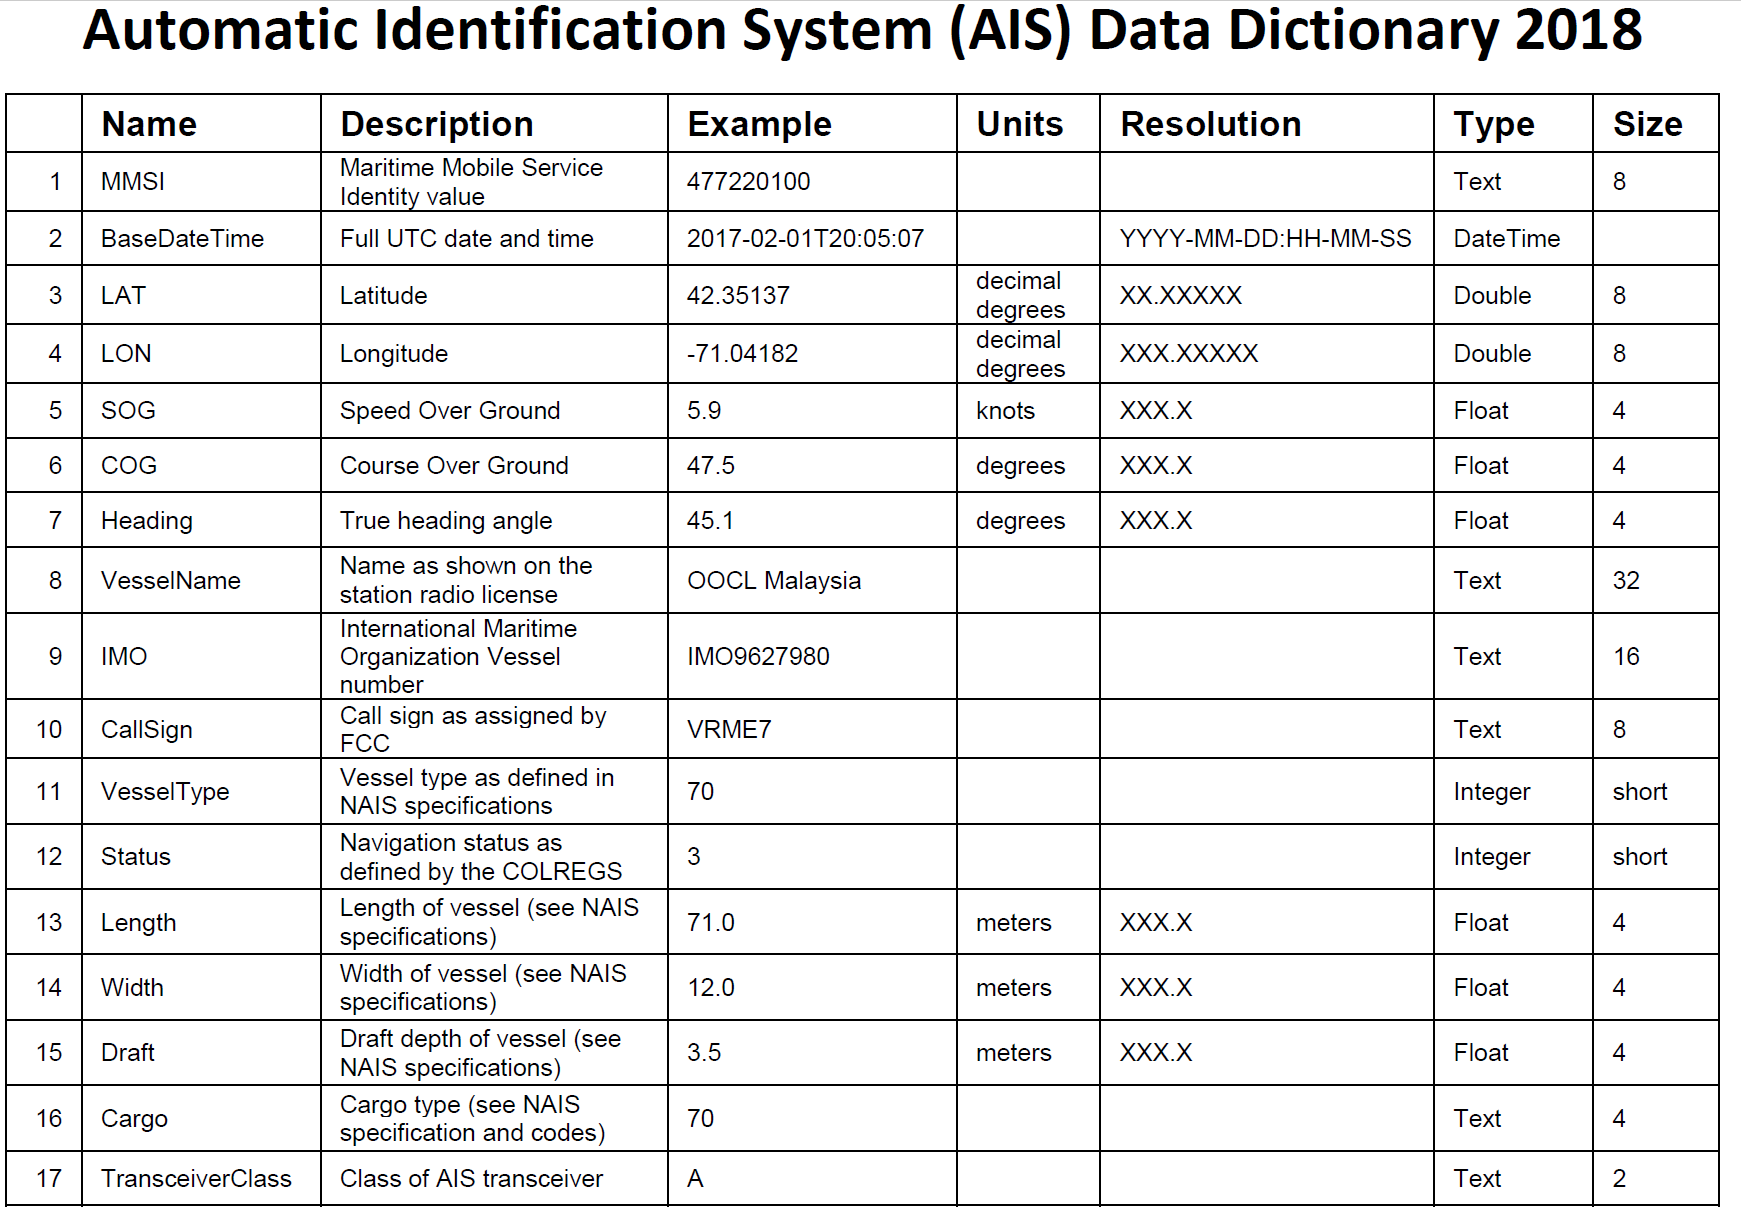

In [3]:
df = pd.read_csv('data/AIS_2021_01_05.csv')
df

MMSI         BaseDateTime       LAT        LON  SOG    COG  \
0        368056750  2021-01-05T00:00:00  40.69279  -74.13655  0.0  159.9   
1        368165820  2021-01-05T00:00:00  33.72340 -118.28067  0.0  241.5   
2        368088610  2021-01-05T00:00:00  38.09991 -122.26283  0.0   64.8   
3        248440000  2021-01-05T00:00:00  46.25754 -124.05879  9.1  262.0   
4        368076480  2021-01-05T00:00:00  37.06903  -88.57099  7.4  287.9   
...            ...                  ...       ...        ...  ...    ...   
7664466  368926394  2021-01-05T23:26:18  13.45075  144.62116  0.6  282.9   
7664467  369970581  2021-01-05T23:32:09  13.58121  144.83658  0.0  314.7   
7664468  369970581  2021-01-05T23:39:20  13.58121  144.83658  0.0  311.2   
7664469  369970581  2021-01-05T23:41:39  13.58120  144.83658  0.0  314.8   
7664470  369970581  2021-01-05T23:59:59  13.58120  144.83658  0.0  299.7   

         Heading  VesselName         IMO CallSign  VesselType  Status  Length  \
0          352.0         NaN         NaN      NaN         NaN     0.0     NaN   
1          511.0         NaN         NaN      NaN         NaN     0.0     NaN   
2           54.0         NaN         NaN      NaN         NaN     0.0     NaN   
3          260.0         NaN         NaN      NaN         NaN     0.0     NaN   
4          511.0         NaN         NaN      NaN         NaN    15.0     NaN   
...          ...         ...         ...      ...         ...     ...     ...   
7664466    511.0       NBG-2  IMO0000000     NBG2        57.0     NaN     0.0   
7664467    511.0  USN GUAM 1         NaN      NaN         NaN    15.0     NaN   
7664468    511.0  USN GUAM 1         NaN      NaN         NaN    15.0     NaN   
7664469    511.0  USN GUAM 1         NaN      NaN         NaN    15.0     NaN   
7664470    511.0  USN GUAM 1         NaN      NaN         NaN    15.0     NaN   

         Width  Draft  Cargo TranscieverClass  
0          NaN    NaN    NaN                A  
1          NaN    NaN    NaN                A  
2          NaN    NaN    NaN                A  
3          NaN    NaN    NaN                A  
4          NaN    NaN    NaN                A  
...        ...    ...    ...              ...  
7664466    0.0    NaN    NaN                B  
7664467    NaN    NaN    NaN                A  
7664468    NaN    NaN    NaN                A  
7664469    NaN    NaN    NaN                A  
7664470    NaN    NaN    NaN                A  

[7664471 rows x 17 columns]

####  Nunique() values for about 7 million rows (7 525 725 rows) and 17 columns:
    04.01.2021
    MMSI                 14 470  
    BaseDateTime         86 359
    LAT               1 138 708
    LON               1 313 680
    SOG                     629
    COG                   3 601
    Heading                 365
    VesselName           11 725
    IMO                   3 963
    CallSign             10 409
    VesselType               49
    Status                   16
    Length                  315
    Width                    60
    Draft                   180
    Cargo                    65
    TranscieverClass          2
    
    05.01.2021
    MMSI                 14 434
    BaseDateTime          86341
    LAT                 1150104
    LON                 1350777
    SOG                     576
    COG                    3602
    Heading                 366
    VesselName            11718
    IMO                    4038
    CallSign              10455
    VesselType               50
    Status                   15
    Length                  317
    Width                    59
    Draft                   179
    Cargo                    66
    TranscieverClass          2

In [4]:
df.nunique()

MMSI                  14434
BaseDateTime          86341
LAT                 1150104
LON                 1350777
SOG                     576
COG                    3602
Heading                 366
VesselName            11718
IMO                    4038
CallSign              10455
VesselType               50
Status                   15
Length                  317
Width                    59
Draft                   179
Cargo                    66
TranscieverClass          2
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7664471 entries, 0 to 7664470
Data columns (total 17 columns):
 #   Column            Dtype  
---  ------            -----  
 0   MMSI              int64  
 1   BaseDateTime      object 
 2   LAT               float64
 3   LON               float64
 4   SOG               float64
 5   COG               float64
 6   Heading           float64
 7   VesselName        object 
 8   IMO               object 
 9   CallSign          object 
 10  VesselType        float64
 11  Status            float64
 12  Length            float64
 13  Width             float64
 14  Draft             float64
 15  Cargo             float64
 16  TranscieverClass  object 
dtypes: float64(11), int64(1), object(5)
memory usage: 994.1+ MB


## Load image data

In [6]:
info = gdal.Info('data/Los_Angeles_bottom/noDEM_nospeckle/S1B_IW_20210105T015737_DVP_RTC30_G_gpuned_E3B8_VH.tif', deserialize=True)
print(info) 

Driver: GTiff/GeoTIFF
Files: data/Los_Angeles_bottom/noDEM_nospeckle/S1B_IW_20210105T015737_DVP_RTC30_G_gpuned_E3B8_VH.tif
Size is 9611, 7847
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 11N",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 11N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",-117,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",50000

In [23]:
info2 = gdal.Info('data/Los_Angeles_bottom/noDEM_nospeckle/S1B_IW_20210105T015737_DVP_RTC30_G_gpuned_E3B8_VH.tif', deserialize=False)
print(info2) 

Driver: GTiff/GeoTIFF
Files: data/Los_Angeles_bottom/noDEM_nospeckle/S1B_IW_20210105T015737_DVP_RTC30_G_gpuned_E3B8_VH.tif
Size is 9611, 7847
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 11N",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 11N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",-117,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",50000

In [25]:
type(info)

str

In [28]:
?gdal.InfoOptions()

Object `gdal.InfoOptions()` not found.


In [26]:
?gdal.Info

In [11]:
gtif = gdal.Open('data/Los_Angeles_bottom/noDEM_nospeckle/S1B_IW_20210105T015737_DVP_RTC30_G_gpuned_E3B8_VH.tif')
print(gtif.GetMetadata())

{'AREA_OR_POINT': 'Point', 'TIFFTAG_DATETIME': '2022:06:18 00:37:26', 'TIFFTAG_SOFTWARE': 'Created with GAMMA Software www.gamma-rs.ch data2geotiff v2.9'}


In [12]:
# The dir() function is probably the most famous part of the Python introspection mechanism. 
# It can return a sorted list of attribute names of any objects passed to it. 
# If you do not specify an object, dir() returns the name in the current scope.
dir(gtif)

['AddBand',
 'AdviseRead',
 'BeginAsyncReader',
 'BuildOverviews',
 'CommitTransaction',
 'CopyLayer',
 'CreateLayer',
 'CreateMaskBand',
 'DeleteLayer',
 'EndAsyncReader',
 'ExecuteSQL',
 'FlushCache',
 'GetDescription',
 'GetDriver',
 'GetFileList',
 'GetGCPCount',
 'GetGCPProjection',
 'GetGCPSpatialRef',
 'GetGCPs',
 'GetGeoTransform',
 'GetLayer',
 'GetLayerByIndex',
 'GetLayerByName',
 'GetLayerCount',
 'GetMetadata',
 'GetMetadataDomainList',
 'GetMetadataItem',
 'GetMetadata_Dict',
 'GetMetadata_List',
 'GetNextFeature',
 'GetProjection',
 'GetProjectionRef',
 'GetRasterBand',
 'GetSpatialRef',
 'GetStyleTable',
 'GetSubDatasets',
 'GetTiledVirtualMem',
 'GetTiledVirtualMemArray',
 'GetVirtualMem',
 'GetVirtualMemArray',
 'RasterCount',
 'RasterXSize',
 'RasterYSize',
 'ReadAsArray',
 'ReadRaster',
 'ReadRaster1',
 'ReleaseResultSet',
 'ResetReading',
 'RollbackTransaction',
 'SetDescription',
 'SetGCPs',
 'SetGeoTransform',
 'SetMetadata',
 'SetMetadataItem',
 'SetProjection',

In [20]:
print(gtif.GetProjectionRef())

PROJCS["WGS 84 / UTM zone 11N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32611"]]


In [21]:
print(gtif.GetDescription())

data/Los_Angeles_bottom/noDEM_nospeckle/S1B_IW_20210105T015737_DVP_RTC30_G_gpuned_E3B8_VH.tif


In [22]:
print(gtif.GetGeoTransform())

(138750.0, 30.0, 0.0, 3806130.0, 0.0, -30.0)


#### Data filtration
- LAT and LON columns are treated as floating point values
        2   LAT               float64
        3   LON               float64

Date and time of doing the photo:

    Start Time • 01/05/21, 01:57:37Z
    Stop Time • 01/05/21, 01:58:06Z
    Beam Mode • IW
    Path • 137
    Frame • 104
    Flight Direction • ASCENDING 
    Polarization • VV+VH 
    Absolute Orbit • 25013

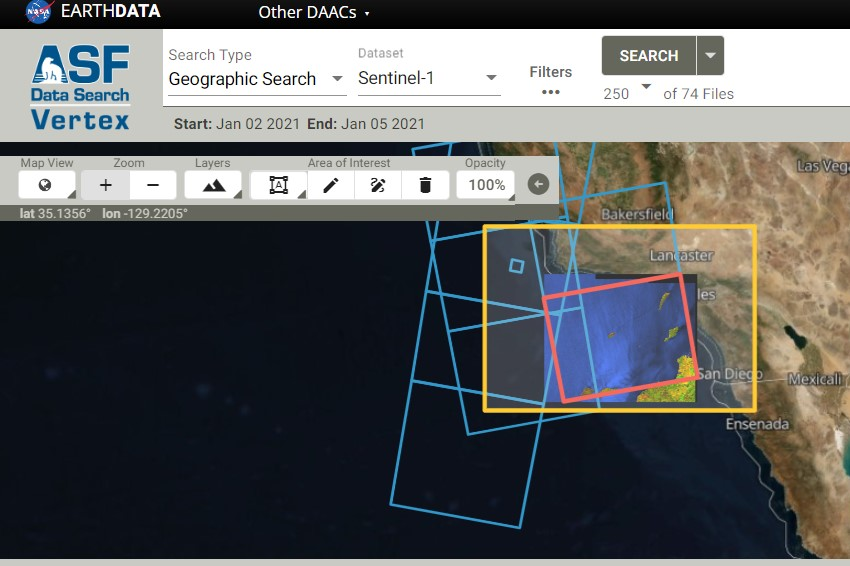

Corner Coordinates:

    Upper Left  (  138750.000, 3806130.000) (120d55'34.07"W, 34d20' 0.85"N)
    Lower Left  (  138750.000, 3570720.000) (120d49'56.25"W, 32d12'54.21"N)
    Upper Right (  427080.000, 3806130.000) (117d47'35.86"W, 34d23'38.45"N)
    Lower Right (  427080.000, 3570720.000) (117d46'27.41"W, 32d16'15.02"N)
    Center      (  282915.000, 3688425.000) (119d19'54.74"W, 33d18'47.16"N)

In [4]:
# lewy górny róg zdjęcia
LAT1 = 34.3909
LON1 = -120.8612
# prawy górny róg zdjęcia
LAT2 = 34.4076
LON2 = -117.8599
# lewy dolny róg zdjęcia
LAT3 = 32.2706
LON3 = -120.8813
# prawy dolny róg zdjęcia
LAT4 = 32.2706
LON4 = -117.8599

In [5]:
minLAT = min(LAT1, LAT2, LAT3, LAT4)
maxLAT = max(LAT1, LAT2, LAT3, LAT4)
minLAT, maxLAT

(32.2706, 34.4076)

In [6]:
minLON = min(LON1, LON2, LON3, LON4)
maxLON = max(LON1, LON2, LON3, LON4)
minLON, maxLON

(-120.8813, -117.8599)

In [30]:
type(LON1)

float

In [7]:
# condition for latitude: between 19.193 and 21.1203
condition1 = (df.LAT > minLAT) & (df.LAT < maxLAT)
# condition for latitude: between -157.0894 and -154.4233
condition2 = (df.LON > minLON) & (df.LON < maxLON)
# final dataframe
target_area = df[condition1 & condition2]
target_area
# target area contains 5542 rows × 17 columns

MMSI         BaseDateTime       LAT        LON  SOG    COG  \
1        368165820  2021-01-05T00:00:00  33.72340 -118.28067  0.0  241.5   
20       636018560  2021-01-05T00:00:01  33.73400 -118.25050  0.0   16.0   
30       338094686  2021-01-05T00:00:05  33.61102 -117.92361  0.0  294.7   
53       367506190  2021-01-05T00:00:40  33.72427 -118.28149  0.0  135.5   
66       367678390  2021-01-05T00:00:01  33.61365 -117.92475  0.0  267.5   
...            ...                  ...       ...        ...  ...    ...   
7652903  366966550  2021-01-05T23:57:27  34.24270 -119.26405  0.0  330.0   
7652955  368019930  2021-01-05T23:58:05  34.14784 -119.20300  0.0   62.6   
7652980  255805854  2021-01-05T23:58:22  33.75247 -118.27431  0.0  328.5   
7653012  311000902  2021-01-05T23:58:40  33.73498 -118.15873  0.0  277.5   
7653097  338338626  2021-01-05T23:59:36  34.40663 -119.69205  0.1  360.0   

         Heading         VesselName         IMO CallSign  VesselType  Status  \
1          511.0                NaN         NaN      NaN         NaN     0.0   
20          71.0  SEALAND GUAYAQUIL  IMO9383259    A8QP3        71.0     5.0   
30         289.0       ALESSA LEIGH         NaN  WDB4997        37.0     0.0   
53         511.0           THALASSA         NaN  WDF9539        37.0     NaN   
66         226.0           EL TIGRE         NaN  WDI2461        37.0     0.0   
...          ...                ...         ...      ...         ...     ...   
7652903    511.0                NaN         NaN      NaN         NaN    15.0   
7652955    268.0                NaN         NaN      NaN         NaN     0.0   
7652980    330.0                NaN         NaN      NaN         NaN     5.0   
7653012    259.0                NaN         NaN      NaN         NaN     1.0   
7653097    511.0            TUESDAY  IMO0000000      NaN        36.0     NaN   

         Length  Width  Draft  Cargo TranscieverClass  
1           NaN    NaN    NaN    NaN                A  
20        209.0   30.0    8.5   71.0                A  
30         28.0    6.0    2.5   37.0                A  
53         15.0    NaN    NaN    NaN                B  
66         19.0    6.0    NaN    0.0                A  
...         ...    ...    ...    ...              ...  
7652903     NaN    NaN    NaN    NaN                A  
7652955     NaN    NaN    NaN    NaN                A  
7652980     NaN    NaN    NaN    NaN                A  
7653012     NaN    NaN    NaN    NaN                A  
7653097    10.0    4.0    NaN    NaN                B  

[297367 rows x 17 columns]

#### BaseDateTime is a string
    1   BaseDateTime      object 

In [8]:
target_area.reset_index(drop=True, inplace=True)
target_area

MMSI         BaseDateTime       LAT        LON  SOG    COG  \
0       368165820  2021-01-05T00:00:00  33.72340 -118.28067  0.0  241.5   
1       636018560  2021-01-05T00:00:01  33.73400 -118.25050  0.0   16.0   
2       338094686  2021-01-05T00:00:05  33.61102 -117.92361  0.0  294.7   
3       367506190  2021-01-05T00:00:40  33.72427 -118.28149  0.0  135.5   
4       367678390  2021-01-05T00:00:01  33.61365 -117.92475  0.0  267.5   
...           ...                  ...       ...        ...  ...    ...   
297362  366966550  2021-01-05T23:57:27  34.24270 -119.26405  0.0  330.0   
297363  368019930  2021-01-05T23:58:05  34.14784 -119.20300  0.0   62.6   
297364  255805854  2021-01-05T23:58:22  33.75247 -118.27431  0.0  328.5   
297365  311000902  2021-01-05T23:58:40  33.73498 -118.15873  0.0  277.5   
297366  338338626  2021-01-05T23:59:36  34.40663 -119.69205  0.1  360.0   

        Heading         VesselName         IMO CallSign  VesselType  Status  \
0         511.0                NaN         NaN      NaN         NaN     0.0   
1          71.0  SEALAND GUAYAQUIL  IMO9383259    A8QP3        71.0     5.0   
2         289.0       ALESSA LEIGH         NaN  WDB4997        37.0     0.0   
3         511.0           THALASSA         NaN  WDF9539        37.0     NaN   
4         226.0           EL TIGRE         NaN  WDI2461        37.0     0.0   
...         ...                ...         ...      ...         ...     ...   
297362    511.0                NaN         NaN      NaN         NaN    15.0   
297363    268.0                NaN         NaN      NaN         NaN     0.0   
297364    330.0                NaN         NaN      NaN         NaN     5.0   
297365    259.0                NaN         NaN      NaN         NaN     1.0   
297366    511.0            TUESDAY  IMO0000000      NaN        36.0     NaN   

        Length  Width  Draft  Cargo TranscieverClass  
0          NaN    NaN    NaN    NaN                A  
1        209.0   30.0    8.5   71.0                A  
2         28.0    6.0    2.5   37.0                A  
3         15.0    NaN    NaN    NaN                B  
4         19.0    6.0    NaN    0.0                A  
...        ...    ...    ...    ...              ...  
297362     NaN    NaN    NaN    NaN                A  
297363     NaN    NaN    NaN    NaN                A  
297364     NaN    NaN    NaN    NaN                A  
297365     NaN    NaN    NaN    NaN                A  
297366    10.0    4.0    NaN    NaN                B  

[297367 rows x 17 columns]

In [9]:
# from datetime import datetime
# from datetime import timezone

# datetime.fromisoformat('2020-01-06T00:00:00.000Z'[:-1]).astimezone(timezone.utc)
# datetime.datetime(2020, 1, 6, 3, 0, tzinfo=datetime.timezone.utc)

In [10]:
# d = datetime.fromisoformat('2020-01-06T00:00:00.000Z'[:-1]).astimezone(timezone.utc)
# d.strftime('%Y-%m-%d %H:%M:%S')

In [9]:
target_area.BaseDateTime = pd.to_datetime(target_area.BaseDateTime)

C:\Users\Darek_PC\anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [10]:
target_area.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297367 entries, 0 to 297366
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   MMSI              297367 non-null  int64         
 1   BaseDateTime      297367 non-null  datetime64[ns]
 2   LAT               297367 non-null  float64       
 3   LON               297367 non-null  float64       
 4   SOG               297367 non-null  float64       
 5   COG               297367 non-null  float64       
 6   Heading           297367 non-null  float64       
 7   VesselName        261978 non-null  object        
 8   IMO               156140 non-null  object        
 9   CallSign          184887 non-null  object        
 10  VesselType        260973 non-null  float64       
 11  Status            165144 non-null  float64       
 12  Length            235589 non-null  float64       
 13  Width             201181 non-null  float64       
 14  Draf

#### BaseDateTime is a datetime
    1   BaseDateTime      5542 non-null   datetime64[ns]

In [11]:
target_area

MMSI        BaseDateTime       LAT        LON  SOG    COG  \
0       368165820 2021-01-05 00:00:00  33.72340 -118.28067  0.0  241.5   
1       636018560 2021-01-05 00:00:01  33.73400 -118.25050  0.0   16.0   
2       338094686 2021-01-05 00:00:05  33.61102 -117.92361  0.0  294.7   
3       367506190 2021-01-05 00:00:40  33.72427 -118.28149  0.0  135.5   
4       367678390 2021-01-05 00:00:01  33.61365 -117.92475  0.0  267.5   
...           ...                 ...       ...        ...  ...    ...   
297362  366966550 2021-01-05 23:57:27  34.24270 -119.26405  0.0  330.0   
297363  368019930 2021-01-05 23:58:05  34.14784 -119.20300  0.0   62.6   
297364  255805854 2021-01-05 23:58:22  33.75247 -118.27431  0.0  328.5   
297365  311000902 2021-01-05 23:58:40  33.73498 -118.15873  0.0  277.5   
297366  338338626 2021-01-05 23:59:36  34.40663 -119.69205  0.1  360.0   

        Heading         VesselName         IMO CallSign  VesselType  Status  \
0         511.0                NaN         NaN      NaN         NaN     0.0   
1          71.0  SEALAND GUAYAQUIL  IMO9383259    A8QP3        71.0     5.0   
2         289.0       ALESSA LEIGH         NaN  WDB4997        37.0     0.0   
3         511.0           THALASSA         NaN  WDF9539        37.0     NaN   
4         226.0           EL TIGRE         NaN  WDI2461        37.0     0.0   
...         ...                ...         ...      ...         ...     ...   
297362    511.0                NaN         NaN      NaN         NaN    15.0   
297363    268.0                NaN         NaN      NaN         NaN     0.0   
297364    330.0                NaN         NaN      NaN         NaN     5.0   
297365    259.0                NaN         NaN      NaN         NaN     1.0   
297366    511.0            TUESDAY  IMO0000000      NaN        36.0     NaN   

        Length  Width  Draft  Cargo TranscieverClass  
0          NaN    NaN    NaN    NaN                A  
1        209.0   30.0    8.5   71.0                A  
2         28.0    6.0    2.5   37.0                A  
3         15.0    NaN    NaN    NaN                B  
4         19.0    6.0    NaN    0.0                A  
...        ...    ...    ...    ...              ...  
297362     NaN    NaN    NaN    NaN                A  
297363     NaN    NaN    NaN    NaN                A  
297364     NaN    NaN    NaN    NaN                A  
297365     NaN    NaN    NaN    NaN                A  
297366    10.0    4.0    NaN    NaN                B  

[297367 rows x 17 columns]

In [12]:
# filter by date: from 2021-01-05 00:00:00 to 2021-01-05 23:59:59
DATE1 = '2021-01-05 00:00:00'
DATE2 = '2021-01-05 23:59:59'
target_area_and_time = target_area[(target_area.BaseDateTime >= DATE1) & (target_area.BaseDateTime <= DATE2)]
target_area_and_time
# all data is from 4th January 2021

MMSI        BaseDateTime       LAT        LON  SOG    COG  \
0       368165820 2021-01-05 00:00:00  33.72340 -118.28067  0.0  241.5   
1       636018560 2021-01-05 00:00:01  33.73400 -118.25050  0.0   16.0   
2       338094686 2021-01-05 00:00:05  33.61102 -117.92361  0.0  294.7   
3       367506190 2021-01-05 00:00:40  33.72427 -118.28149  0.0  135.5   
4       367678390 2021-01-05 00:00:01  33.61365 -117.92475  0.0  267.5   
...           ...                 ...       ...        ...  ...    ...   
297362  366966550 2021-01-05 23:57:27  34.24270 -119.26405  0.0  330.0   
297363  368019930 2021-01-05 23:58:05  34.14784 -119.20300  0.0   62.6   
297364  255805854 2021-01-05 23:58:22  33.75247 -118.27431  0.0  328.5   
297365  311000902 2021-01-05 23:58:40  33.73498 -118.15873  0.0  277.5   
297366  338338626 2021-01-05 23:59:36  34.40663 -119.69205  0.1  360.0   

        Heading         VesselName         IMO CallSign  VesselType  Status  \
0         511.0                NaN         NaN      NaN         NaN     0.0   
1          71.0  SEALAND GUAYAQUIL  IMO9383259    A8QP3        71.0     5.0   
2         289.0       ALESSA LEIGH         NaN  WDB4997        37.0     0.0   
3         511.0           THALASSA         NaN  WDF9539        37.0     NaN   
4         226.0           EL TIGRE         NaN  WDI2461        37.0     0.0   
...         ...                ...         ...      ...         ...     ...   
297362    511.0                NaN         NaN      NaN         NaN    15.0   
297363    268.0                NaN         NaN      NaN         NaN     0.0   
297364    330.0                NaN         NaN      NaN         NaN     5.0   
297365    259.0                NaN         NaN      NaN         NaN     1.0   
297366    511.0            TUESDAY  IMO0000000      NaN        36.0     NaN   

        Length  Width  Draft  Cargo TranscieverClass  
0          NaN    NaN    NaN    NaN                A  
1        209.0   30.0    8.5   71.0                A  
2         28.0    6.0    2.5   37.0                A  
3         15.0    NaN    NaN    NaN                B  
4         19.0    6.0    NaN    0.0                A  
...        ...    ...    ...    ...              ...  
297362     NaN    NaN    NaN    NaN                A  
297363     NaN    NaN    NaN    NaN                A  
297364     NaN    NaN    NaN    NaN                A  
297365     NaN    NaN    NaN    NaN                A  
297366    10.0    4.0    NaN    NaN                B  

[297367 rows x 17 columns]

In [13]:
# DATETIME of the photo:
#Start Time • 01/05/21, 01:57:37Z
#Stop Time • 01/05/21, 01:58:06Z
# filter by date: from 2021-01-05 01:47:00 to 2021-01-05 02:07:00
DATE3 = '2021-01-05 01:57:37'
DATE4 = '2021-01-05 01:58:06'
chosen_target_area_and_time = target_area_and_time[(target_area_and_time.BaseDateTime >= DATE3) & (target_area_and_time.BaseDateTime <= DATE4)]
chosen_target_area_and_time
# all data is from 4th January 2021

MMSI        BaseDateTime       LAT        LON  SOG    COG  \
19336   255805780 2021-01-05 01:57:50  33.68452 -118.17575  6.7  344.1   
19340   338566000 2021-01-05 01:57:38  33.76971 -118.21751  0.1  216.1   
19361   367369720 2021-01-05 01:58:06  33.77075 -118.21286  1.8  244.0   
19401   338380139 2021-01-05 01:57:43  33.97072 -118.44983  1.1  360.0   
19402   367766020 2021-01-05 01:57:55  33.61476 -117.91442  0.0  360.0   
...           ...                 ...       ...        ...  ...    ...   
263092  338182025 2021-01-05 01:58:04  34.18507 -119.23084  0.0   63.8   
263097  367536560 2021-01-05 01:57:39  34.24406 -119.26453  0.0   37.5   
263177  367174120 2021-01-05 01:57:48  33.73803 -118.26756  0.0  360.0   
263178  367104060 2021-01-05 01:57:58  34.38215 -119.50975  0.7   54.6   
263181  368024740 2021-01-05 01:58:06  33.74724 -118.21565  0.0  207.9   

        Heading     VesselName         IMO CallSign  VesselType  Status  \
19336     340.0        TALASSA  IMO9290787     CQDD        70.0     0.0   
19340     245.0            NaN         NaN      NaN         NaN     5.0   
19361     239.0      ALTA JUNE  IMO9552290  WDE5645        31.0     0.0   
19401     511.0    CIAO GIANNI  IMO0000000      NaN        36.0     NaN   
19402     511.0  FULL THROTTLE  IMO0000000      NaN        37.0     NaN   
...         ...            ...         ...      ...         ...     ...   
263092    511.0         SABABA         NaN      NaN        37.0     NaN   
263097    511.0         SEQUEL  IMO9677856  WDG4437        30.0     NaN   
263177    511.0      BARBARA H  IMO0000000  WDK2335        30.0     NaN   
263178     58.0         ALAN T  IMO8982577  WDC9571        60.0     0.0   
263181    511.0            NaN         NaN      NaN         NaN    15.0   

        Length  Width  Draft  Cargo TranscieverClass  
19336    275.0   40.0   14.0    NaN                A  
19340      NaN    NaN    NaN    NaN                A  
19361     23.0   10.0    NaN    NaN                A  
19401     18.0    3.0    NaN    NaN                B  
19402      0.0    0.0    NaN    NaN                B  
...        ...    ...    ...    ...              ...  
263092     8.0    NaN    NaN    NaN                B  
263097    17.0    6.0    NaN    NaN                B  
263177     0.0    0.0    NaN    NaN                B  
263178    28.0    7.0    NaN   42.0                A  
263181     NaN    NaN    NaN    NaN                A  

[82 rows x 17 columns]

In [14]:
chosen_target_area_and_time.sort_values(by='BaseDateTime', axis=0, ascending=True, inplace=True, kind='quicksort', na_position='last', ignore_index=True)

C:\Users\Darek_PC\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [15]:
chosen_target_area_and_time.reset_index(drop=True, inplace=True)
chosen_target_area_and_time

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading  \
0   338094919 2021-01-05 01:57:37  33.98363 -118.45094  0.0  295.7    511.0   
1   338159837 2021-01-05 01:57:37  33.72414 -118.28215  0.0  238.7    223.0   
2   338566000 2021-01-05 01:57:38  33.76971 -118.21751  0.1  216.1    245.0   
3   235098885 2021-01-05 01:57:38  33.74314 -118.27355  0.1  243.8    207.0   
4   367506190 2021-01-05 01:57:39  33.72427 -118.28151  0.0  135.5    511.0   
..        ...                 ...       ...        ...  ...    ...      ...   
77  367678730 2021-01-05 01:58:06  34.24279 -119.26440  0.1   95.4    511.0   
78  303422000 2021-01-05 01:58:06  34.15149 -119.20698  0.0  329.5     88.0   
79  367369720 2021-01-05 01:58:06  33.77075 -118.21286  1.8  244.0    239.0   
80  338240395 2021-01-05 01:58:06  33.72353 -118.28124  0.0    3.4    511.0   
81  368024740 2021-01-05 01:58:06  33.74724 -118.21565  0.0  207.9    511.0   

        VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0    SWEET MELISSA         NaN      NaN        37.0     NaN    10.0    NaN   
1   PACIFIC SUNSET  IMO0000000      NaN        37.0     NaN    10.0    4.0   
2              NaN         NaN      NaN         NaN     5.0     NaN    NaN   
3     EVER LEARNED  IMO9604108    2GNG3        70.0     5.0   334.0   45.0   
4         THALASSA         NaN  WDF9539        37.0     NaN    15.0    NaN   
..             ...         ...      ...         ...     ...     ...    ...   
77     RISING STAR         NaN  WDI2492        30.0     NaN    15.0    NaN   
78     SEA VENTURE  IMO9347413  WDC5952        90.0     5.0   106.0   21.0   
79       ALTA JUNE  IMO9552290  WDE5645        31.0     0.0    23.0   10.0   
80      TIDAL WAVE         NaN      NaN        37.0     NaN     NaN    NaN   
81             NaN         NaN      NaN         NaN    15.0     NaN    NaN   

    Draft  Cargo TranscieverClass  
0     NaN    NaN                B  
1     NaN    NaN                B  
2     NaN    NaN                A  
3    14.2   74.0                A  
4     NaN    NaN                B  
..    ...    ...              ...  
77    NaN    NaN                B  
78    6.9   90.0                A  
79    NaN    NaN                A  
80    NaN    NaN                B  
81    NaN    NaN                A  

[82 rows x 17 columns]

In [60]:
#chosen_target_area_and_time.to_csv('data/2021-01-05_01_47_02_07_all_ships.csv')

In [16]:
chosen_target_area_and_time.nunique()

MMSI                82
BaseDateTime        28
LAT                 81
LON                 80
SOG                 14
COG                 63
Heading             26
VesselName          70
IMO                 27
CallSign            46
VesselType           9
Status               5
Length              35
Width               18
Draft               11
Cargo               10
TranscieverClass     2
dtype: int64

In [17]:
chosen_target_area_and_time.MMSI.unique()

array([338094919, 338159837, 338566000, 235098885, 367506190, 367536560,
       338392023, 367199310, 338310082, 338069896, 369970276, 366785290,
       367650950, 338217105, 369040000, 338181288, 338380139, 338115483,
       367050320, 367593050, 338387252, 338349648, 353243000, 338392821,
       352361000, 367471080, 367422010, 366966550, 368031490, 367174120,
       366328490, 338341000, 338088867, 367578740, 255805780, 368064650,
       366760710, 338032241, 566958000, 338169044, 352822000, 367678390,
       366855060, 269804000, 338100018, 367766020, 368019930, 368066650,
       367404860, 368036440, 366872980, 338393998, 338087117, 368172150,
       366978720, 367104060, 477528400, 367309720, 338131199, 370361000,
       338162425, 235098383, 367308610, 338238542, 367104050, 367661930,
       366857070, 366773480, 367133910, 367711690, 303656000, 338181878,
       367698890, 367189890, 338182025, 338060204, 338380107, 367678730,
       303422000, 367369720, 338240395, 368024740],

In [18]:
chosen_target_area_and_time.VesselName.unique()

array(['SWEET MELISSA', 'PACIFIC SUNSET', nan, 'EVER LEARNED', 'THALASSA',
       'SEQUEL', 'REEL BUSY', 'CATALINA JET', 'ATARAXIA', 'LOVIT',
       'ATLS 9701', 'MANDALAY', 'DIVERSION', "BATEAU L'HEUREUX",
       'AMERICAN ENDURANCE', 'SQUID INC', 'CIAO GIANNI', 'ON LOCATION',
       'BIG TROUBLE', 'SIMONE BRUSCO', 'FINE SEAS-ONINGS',
       'GLORIOUS FUJI', 'C TO SEA', 'MSC BETTINA', 'ISABEL L',
       'BARBARA H', 'DON JUAN', 'HARVEY CHALLENGER', 'SIERRA BRAVO',
       'APL BELGIUM', 'TALASSA', 'REDONDO', "JUS' PUCKIN' AROUND",
       'BREANNA', 'NYK ORION', 'EL TIGRE', 'NEW DEL MAR', 'SEPTEMBER',
       "MARE'ZIA", 'FULL THROTTLE', 'DOUBLE D', 'FANTASEA ONE', 'TIBURON',
       'ENDLESS DREAMS', 'HUNTRESS', 'ALTAIR', 'PATHFINDER____',
       'MILLENNIUM FALCON', 'ALAN T', 'NOHEA', 'HAGEN',
       'CHELSEA SKYE  TWO', 'EVER LINKING', 'SARAH C', 'ADVENTURE',
       'RYAN T', 'MICHELLE SLOAN', 'JET CAT EXPRESS', 'ZEBRINA',
       'BETHEL F GIFFORD', 'FLORETTA G', 'ALASKAN LEGEND',
    

#### At the day of 5th January 2021, on the selected Los Angeles port area, there were 524 different ships (because we have 524 unique ids from MMSI database). We know the names of 471 out of 524 vessels:
       'ROBERT FRANCO', 'RANGER 85', 'OAKLAND EXPRESS', 'ATLS 9701',
       'PRESIDENT EISENHOWER', 'PARLAY', 'STARSHIP EXPRESS', 'ADELANTE',
       'NYK ORPHEUS', 'SEA RELIANCE', 'EL TIGRE', 'STEPHEN M WHITE',
       'MAGNA CARTA', 'NEW DEL MAR', 'ISLANDER', 'WHISKEY BUSINESS',
       'TATU', 'CIAO GIANNI', 'MISTRESS II', 'FIREBOAT 15', 'ISABEL L',
       "MON AMIE'", 'LAYLINE', 'TOW BIZZ II', 'DISAPPEARANCE',
       'ISLAND ADVENTURE', 'STEPPIN OUT', 'ISLAND EXPLORER',
       'RUMRUNNER II', 'LINDSEY', 'ANOTHER ADVENTURE', 'AFTER MIDNIGHT',
       'ALAN T', 'SATISFACTION', 'JEFFREY M', 'MASTER', 'LIONHEART',
       'GINGER', 'NYK CONSTELLATION', 'SERENDIPITER', 'BONNY BANKS',
       'TALL COTTON', "FLY 'N FISH", 'PILUT', 'MSC SILVIA', 'JOCAR',
       'CG GEORGE COBB', 'IMAGINE', 'REGULATOR', 'AMERICAN ENDURANCE',
       'ATACAMA', 'BOUNTY', 'HIGH PRYORITY', 'CATALINA JET', 'ANDIAMO',
       'CLIPPER TALENT', 'SEA WINGS', 'GLORIOUS FUJI', 'CAZADOR',
       'MILLER TIME', 'BLONDIE', 'EMMA RAY', 'TRAILERHOOD', 'THE ESSIE',
       'MELINA', 'SHADES OF GREY', 'YM UNICORN', 'BIANCA', 'SPACE',
       'REFUGE', 'TO LIFE', 'HARVEY CHALLENGER', 'CYGNUS LEADER',
       '17 FEBRUARY', 'ZORYANA', 'ANEJO', 'MY REVENGE', 'AQUATA',
       'FREEWILL', 'BETHEL F GIFFORD', 'LA CONCHA II', 'EVER EAGLE',
       'PACIFIC FREEDOM', 'SIMONE BRUSCO', 'H R MORRIS', 'VIOLET ACE',
       'GITANA', 'SEPTEMBER', 'MEHETABEL', 'VENTURA H. PTRL17',
       'PACIFIC STAR', 'OCTAVIA (US)', 'DREAMER', 'TOURIST', 'JANICE O',
       'MILLENNIUM MAVERICK', 'FIREBOAT 110', 'DANDEANA', 'ISLAND FOX',
       'LAUREN L KAPP', 'SEOUL EXPRESS', 'GENTLEMAN', 'WHATEVER 4',
       'BOAT 5', 'ACES WILD', 'RYAN T', 'GALATEA', 'DARK SIDE', '185 3',
       'WHITE LIGHT', 'NASIA', 'FIREBOAT 20', 'SINGAPORE', 'PEZ FINDER',
       'SISTER HOOK', 'ACOUSTIC EXPLORER', 'PATRICK', 'MILLENNIUM FALCON',
       'JOHN QUIGG', 'FREYJA', 'ENDLESS DREAMS', 'TUESDAY', 'MILAN',
       'TRAVELER', 'TALASSA', 'THE ONE', 'EILEEN', 'REDONDO',
       'GOOD FELLA', 'MSC CANDICE', 'CARIBE ALLIANCE', 'SARAH C',
       "JAMMIN'", 'FIGHTING IRISH', 'MICHELLE SLOAN', 'KELLY C',
       'USNS MARY SEARS', 'ALASKA GYPSY', 'TASIA', 'BLUE SKY',
       'DREW FOSS', 'BIBI', 'MILLENNIUM DAWN', 'DESTINY', 'BOWDITCH',
       'QUERENCIA', 'PHINEAS BANNING', 'ALTA JUNE', 'EVER AFTER',
       'MOL EMPIRE', 'DELTA BILLIE', 'CINDERELLA', 'SEALILY',
       'SANDRA HUGH', 'DB LOS ANGELES', 'YEAH BUOY', 'JACKIE C',
       'HANALEI', 'AVA FOSS', 'BARBARA ANN', 'PURITAN', 'CABRILLO',
       'MSC KATIE', 'CIELO MARE', 'THIRD WISH', 'SILVER BUZZARD',
       'CARPE DIEM', 'ADMIRAL', 'BO BRUSCO', 'PICHINCHA', 'JOHN HENRY',
       'VALKYRIE', 'BELLISSIMA I', 'DURANGO', 'SALTE', 'LEADER',
       'ESOTERIC', 'NAVIG8 TURQUOISE', 'WILSON', 'STARDUST', 'NRC QUEST',
       'DAUNTLESS', 'S/V SURPRISE', 'DANCES WITH WINDS',
       'HALIFAX EXPRESS', 'PAIR A DOCS', 'GEORG MAERSK', 'SUNDANCE',
       'ALESSA LEIGH', 'PACIFIC RAVEN', 'HYUNDAI FORWARD', 'INDEPENDENCE',
       'ARGENT IRIS', 'LAGUNA', 'SEAS THE DAY', 'OPUS TWO',
       'AMAZING GRACE', 'THERAPY', 'CHARISMA', 'MY SUNSEAKER', 'SEQUEL',
       'BOTTOM SCRATCHER', 'CLEAN OCEAN', 'CABO SAN ANTONIO',
       'THE REAGAN YEARS', 'SEA DELIGHT', 'LITTLE ANNIE II', 'TRUE GRIT',
       'HAPPY DAYS', 'MIRABELLA', 'FIREFLY', 'GEORGIA GAYLE', 'WINDFALL',
       'M/Y MILAGRO', 'FANTASEA ONE', 'WATER BUFFALO', 'TAVISH B.',
       'LOVE THE JOURNEY', 'JOINT VENTURE', 'EDITH FOSS', 'SHARON G',
       'PACIFIC JOURNEY', 'DOOR PRIZE', 'NAJADE', 'GAIL-ANNE',
       'SEA PATRON', 'VENTURA H. PTRL19', 'SUSIE Q', 'NAOS 400', 'TAZZY',
       'POLARIIS', 'HUCKLEBERRY', 'MINDORO', 'FANDANGO',
       'COSCO KAOHSIUNG', 'REEL NOYES', 'REFLECTIONS', 'TELESTO',
       'WINDY CITY', 'SANCERRE', 'MONKEY BIZ', 'HATTENUFF', 'JUPITER',
       'MEIRA LUNA', 'FRENCH KISSING LIFE', 'LIQUID LOUNGE', 'LA VIGIE',
       'LELA FRANCO', 'NAUTICAL SMILE', 'AGUA MAR', 'REFUGE KATE',
       'TRANQUILO', 'MUDANZAS', 'GRATITUDE', 'WARRIOR', 'IKAROS',
       'EVER LOYAL', "REVE D'O", 'OCEAN SENTINEL', 'TITUS',
       'SWEET MELISSA', 'SOUTHERN CROSS', 'PACIFIC SUNSET',
       'RBFD BOAT 63', 'REEL BUSY', 'LOVIT', 'THALASSA', 'ATARAXIA',
       'DIVERSION', 'EVER LEARNED', "BATEAU L'HEUREUX",
       'FINE SEAS-ONINGS', 'SQUID INC', 'MANDALAY', 'ON LOCATION',
       'SEA YA', 'MSC BETTINA', 'BESO', 'DON JUAN', 'NEVER SAY NEVER',
       'SIERRA BRAVO', 'APL BELGIUM', 'MADISON THERESE', 'HOOKER',
       'OH-COOP', 'ALL THE WAY THERE', 'NYK ORION', 'BREANNA',
       "JUS' PUCKIN' AROUND", "MARE'ZIA", 'ALTAIR', 'DOUBLE D',
       'VALHOWELL', 'NOHEA', 'CHELSEA SKYE  TWO', 'PATHFINDER____',
       'HAGEN', 'SEA FORCE', 'ADVENTURE', 'EVER LINKING', 'V A SAN PEDRO',
       'ALASKAN LEGEND', 'TEASIP', 'JET CAT EXPRESS', 'KOBE EXPRESS',
       'FLORETTA G', 'ADELE ELISE', 'SABABA', 'ZEBRINA', 'REVEILLE',
       'RISING STAR', 'SEA VENTURE', 'TIDAL WAVE', 'LADY K',
       'ANGELS GATE', 'GOOD VIBRATIONS', 'HUNTRESS', 'OOCL LUXEMBOURG',
       'EAGLES WING', "HANA PA'A", 'FULL THROTTLE', 'THE LAST HURRAH',
       'SEALAND MANZANILLO', 'PORT KENNY', 'TUAMOTU', 'REGENTSEA',
       'NYK DANIELLA', 'BLOW ME', 'CITY LIGHTS', 'NORWEGIAN JEWEL',
       'HAU TREE', 'NAT GEO ORION', 'SERENGETI', "YOU'LL SEA",
       'ADMIRAL XL', 'VOLANS', 'T/T VIRGINIA LEE', 'AUBREY ELLA',
       'FULL CIRCLE', 'WAHOO', 'SEASPAN HAMBURG', 'OMNIA', 'TIBURON',
       'INCOMMUNICADO', 'RAPALLO', 'APL FLORIDA', 'RAPTOR', 'SOLILOQUY',
       'HYUNDAI HONGKONG', 'ARIES VOYAGER', 'SCOUT', 'CABERNET SKY',
       'VESPER', 'SEA MONSTER', 'MAERSK NORTHAMPTON', 'MSC SAVONA',
       'CAPE INSCRIPTION', "ARIA'S SONG", "IT'S ALL GOOD",
       'BARCA NOASTRA', 'INNESFREE', 'ANGLER MANAGMENT', 'QIQI',
       'NYK DELPHINUS', 'GALILEO', 'EAGLE BAY', 'SEAFOX', 'BRISA',
       'BARBARA K II', 'R ESCAPE', 'FISH TAILS', 'WESTERLY',
       'ONE MANHATTAN', 'COLOMBO EXPRESS', 'CZEH MATE', 'DULCE VIDA',
       'SARA', 'HATTITUDE', 'PURA VIDA', 'SECOND VERSE', 'XTSEA',
       'SWEET FREEDOM', 'AQUILA', 'ASTRAL', 'RUMRUNNER 3', 'ARIE LUX',
       'TARA', 'S/V MOONSHADOW', 'CHIEF', 'STEELROD', 'PALLADIO', 'CIELO',
       'COSCO AFRICA', 'PROVIDER', 'LIFE AQUATIC', 'CELESTRA',
       'MOL EXPERIENCE', 'ISLANDIA II', 'MATADOR', '10 BY 10', 'OFFLINE',
       'MANAAKI', 'ELIZABETH DANE', 'WICKED', 'HONEY', 'LUCY FOSS',
       'VOYAGER', 'OFF SEASON', "T'S TIME", 'LIFE IS GRAND', 'LEVEL UP',
       'HAMMER', 'ENTROPY', 'KING FISH', 'PETKUM', 'BAD DEBT', 'VERA',
       'INNCREDIBLE SEA LODG', 'RADIANT', 'LITTLE GOOSE',
       'MAERSK ESMERALDAS', 'SECOND WIND', 'NEVER 2 NAUTI', 'ONE WORLD',
       'MORPHEUS', 'MON CALAMARI', 'PIRANHA', 'SEACLUSION', 'BOTANY BAY',
       'MARILEE', 'CAST AWAY', 'KENNETH CARL', 'CF3588RX',
       'SEALAND GUAYAQUIL', 'JAWS', 'GREATER PACIFIC', 'ANN-ELYSE',
       'MOBILLITY', "STANLEY'S CUP", 'T E N  II', 'C TO SEA',
       'BIG TROUBLE', 'LAST DANCE', 'BARBARA H', 'MAERSK NORTHWOOD',
       'LOTTUS', 'KOKOMO', 'TUNA MELT', 'REEL ENERGY', 'SEASCAPE',
       'STINGER', "KERRY'D AWAY", 'HSL SHEFFIELD', 'MAGARI!', 'SERENITY',
       'STARR', 'SOLSTICE', 'TRYIN TO REASON', 'HALF MOON', 'BELLA VITA',
       'CRYSTAL SEA', 'SIRIUS', 'STAMPEDE', 'SEPTEMBER BLISS',
       'CONTROLLED CHAOS', 'NICE DREAMS', 'IRVING JOHNSON', 'ONE SHOT',
       'MAMASTE', "CENT' ANNI'", 'PIPER INNESS'

In [19]:
chosen_target_area_and_time.describe()

MMSI        LAT         LON         SOG         COG  \
count  8.200000e+01  82.000000   82.000000   82.000000   82.000000   
mean   3.534326e+08  33.853048 -118.508819    2.104878  220.436585   
std    3.937613e+07   0.246702    0.586548   11.480353  117.867448   
min    2.350984e+08  33.288720 -120.761780    0.000000    0.000000   
25%    3.381908e+08  33.700953 -118.469692    0.000000  138.900000   
50%    3.668202e+08  33.748135 -118.277570    0.000000  251.000000   
75%    3.675682e+08  33.983140 -118.157130    0.100000  311.300000   
max    5.669580e+08  34.406550 -117.895830  102.300000  360.000000   

          Heading  VesselType     Status      Length      Width      Draft  \
count   82.000000   70.000000  46.000000   64.000000  53.000000  16.000000   
mean   417.219512   48.771429   4.543478   57.828125  12.037736   7.525000   
std    145.673237   19.181189   5.608353   96.448284  14.253154   7.508351   
min     39.000000   30.000000   0.000000    0.000000   0.000000 -11.900000   
25%    271.000000   37.000000   0.000000   12.750000   4.000000   3.350000   
50%    511.000000   37.000000   2.000000   19.500000   6.000000   7.550000   
75%    511.000000   60.000000   5.000000   32.000000  10.000000  14.000000   
max    511.000000   90.000000  15.000000  366.000000  52.000000  18.800000   

           Cargo  
count  15.000000  
mean   55.666667  
std    25.206764  
min     0.000000  
25%    38.500000  
50%    70.000000  
75%    72.500000  
max    90.000000

In [20]:
chosen_target_area_and_time.to_csv('data/2021-01-05_01_57_01_58_all_ships.csv')

#### Here are the 13 aggregating functions available in Pandas and quick summary of what it does.

    mean(): Compute mean of groups
    sum(): Compute sum of group values
    size(): Compute group sizes
    count(): Compute count of group
    std(): Standard deviation of groups
    var(): Compute variance of groups
    sem(): Standard error of the mean of groups
    describe(): Generates descriptive statistics
    first(): Compute first of group values
    last(): Compute last of group values
    nth() : Take nth value, or a subset if n is a list
    min(): Compute min of group values
    max(): Compute max of group values

In [64]:
# ships can be grouped by maximum value - the maximum cargo which was on the ship
# also, the median or the mean values can be used
target_ships = chosen_target_area_and_time.groupby(by='MMSI', axis=0, sort=True).last()
target_ships = target_ships.iloc[: , :-1]
target_ships

BaseDateTime       LAT        LON  SOG    COG  Heading  \
MMSI                                                                      
211002010 2021-01-05 02:04:52  34.40717 -119.69162  0.0   86.2    511.0   
211331640 2021-01-05 02:05:40  33.70407 -118.15631  0.1  181.0    271.0   
211433000 2021-01-05 02:04:40  33.75531 -118.26210  0.0   43.0     43.0   
212348000 2021-01-05 02:04:31  33.76412 -118.27202  0.0  316.0    198.0   
215181000 2021-01-05 02:05:30  33.61302 -118.03882  0.0  178.7    283.0   
...                       ...       ...        ...  ...    ...      ...   
636018560 2021-01-05 02:06:00  33.73400 -118.25050  0.0   58.0     71.0   
636019206 2021-01-05 02:06:20  33.66940 -118.15529  0.0  187.3    266.0   
636019717 2021-01-05 02:04:20  33.67713 -118.21004  0.1  216.8    273.0   
636091273 2021-01-05 02:06:19  33.76750 -118.23729  0.0   67.4     73.0   
636091959 2021-01-05 02:04:35  33.75483 -118.23060  0.0   24.3     70.0   

                  VesselName         IMO CallSign  VesselType  Status  Length  \
MMSI                                                                            
211002010               None  IMO0000000     None         0.0     NaN     0.0   
211331640      SEOUL EXPRESS  IMO9193305     DHBN        70.0     1.0   294.0   
211433000    COLOMBO EXPRESS  IMO9295244     DIHC        70.0     5.0   335.0   
212348000   HYUNDAI HONGKONG  IMO9305661     5BZL        70.0     5.0   303.0   
215181000               None        None     None         NaN     1.0     NaN   
...                      ...         ...      ...         ...     ...     ...   
636018560  SEALAND GUAYAQUIL  IMO9383259    A8QP3        71.0     5.0   209.0   
636019206               None        None     None         NaN     1.0     NaN   
636019717             VOLANS  IMO9430777    D5VV2        71.0     1.0   265.0   
636091273             NAJADE  IMO9326706    A8LL4        70.0     5.0   215.0   
636091959         MSC SAVONA  IMO9460356    A8UX4        70.0     5.0   365.0   

           Width  Draft  Cargo  
MMSI                            
211002010    0.0    NaN    NaN  
211331640   32.0   13.6   79.0  
211433000   42.0   14.6    NaN  
212348000   40.0   14.0   79.0  
215181000    NaN    NaN    NaN  
...          ...    ...    ...  
636018560   30.0    8.5   71.0  
636019206    NaN    NaN    NaN  
636019717   32.0   11.5   71.0  
636091273   29.0   11.6    NaN  
636091959   51.0   16.0   70.0  

[524 rows x 15 columns]

In [65]:
#target_ships.to_csv('data/2021-01-05_01_47_02_07_ships_grouped_by_last.csv')

## DATA VISUALIZATION

In [67]:
target_ships

BaseDateTime       LAT        LON   SOG    COG  Heading  \
MMSI                                                                       
303681000 2021-01-04 04:20:26  20.77223 -156.45213  10.2  323.9    326.0   
366254000 2021-01-04 03:36:21  21.06788 -156.52284  10.1  292.2    294.0   
367007880 2021-01-04 17:00:24  21.01243 -155.03800   9.1  357.7    359.0   
367045620 2021-01-04 18:04:14  20.19575 -156.31134   9.1  176.6    511.0   
367056982 2021-01-04 23:59:55  21.08167 -157.02893   9.5  358.1    511.0   
367434360 2021-01-04 20:18:38  20.90436 -156.46638   5.3  359.5    358.0   
367449870 2021-01-04 23:59:27  21.08980 -156.46605   7.7  352.4    314.0   
367504180 2021-01-04 23:22:19  20.89684 -156.46680   6.7  358.7    511.0   
367602740 2021-01-04 18:48:57  20.37479 -156.07972   8.6  175.1    511.0   
367613000 2021-01-04 02:07:40  19.63882 -155.98716   4.5  343.8    511.0   
367617790 2021-01-04 23:59:33  20.70985 -156.44569  12.7  359.7    511.0   
367745320 2021-01-04 20:00:10  20.87190 -156.67863  21.0  359.0    511.0   
367773150 2021-01-04 23:59:42  20.79076 -156.44242  14.1  360.0    511.0   
368166390 2021-01-04 13:22:13  20.99489 -155.80311  10.7  327.0    511.0   
368477000 2021-01-04 09:40:17  20.35745 -155.04791   8.1  200.0    203.0   
533130964 2021-01-04 23:58:46  20.86492 -156.67960   8.2  349.7    511.0   

                    VesselName         IMO CallSign  VesselType  Status  \
MMSI                                                                      
303681000           MOUNT DRUM         NaN  WDJ7294         NaN    11.0   
366254000                  NaN         NaN      NaN         NaN    11.0   
367007880         JOSEPH SAUSE  IMO7402726  WTW9258        31.0     5.0   
367045620  PRINCESS JASMINE II  IMO8940907  WDC5730        30.0     NaN   
367056982             HOKU-LOA  IMO9032795  WCU5446        31.0     5.0   
367434360               KALAMA  IMO8666513  WDF3003        31.0     0.0   
367449870       BROOKE CHAPMAN  IMO9223875  WDI8453        31.0     5.0   
367504180             TIGER 11         NaN  WDF9344        31.0     0.0   
367602740               AOLANI  IMO9759575  WDH2942        30.0     NaN   
367613000             KANOA II         NaN  WDD8912        60.0     NaN   
367617790          SEAFIRE III         NaN  WDH4443        60.0     NaN   
367745320      EXPEDITIONS SIX         NaN  WDI9107        60.0    15.0   
367773150                  NaN         NaN      NaN         NaN    15.0   
368166390             SOLSTICE  IMO0000000  WDL8101        36.0     NaN   
368477000                  NaN         NaN      NaN         NaN     0.0   
533130964             BLAZE II  IMO0000000    9MSJ7        36.0     NaN   

           Length  Width  Draft  Cargo TranscieverClass  
MMSI                                                     
303681000     NaN    NaN    NaN    NaN                A  
366254000     NaN    NaN    NaN    NaN                A  
367007880    30.0    8.0    4.2   32.0                A  
367045620    25.0    7.0    NaN    NaN                B  
367056982    35.0   10.0    5.2   32.0                A  
367434360    26.0   10.0    NaN    NaN                A  
367449870    33.0   10.0    3.7    NaN                A  
367504180    26.0    NaN    NaN    NaN                A  
367602740    23.0    6.0    NaN    NaN                B  
367613000    20.0    8.0    NaN    NaN                B  
367617790    12.0    NaN    NaN    NaN                B  
367745320     NaN    NaN    NaN    NaN                A  
367773150     NaN    NaN    NaN    NaN                A  
368166390    10.0    4.0    NaN    NaN                B  
368477000     NaN    NaN    NaN    NaN                A  
533130964    19.0    9.0    NaN    NaN                B

In [69]:
import pandas as pd
import numpy as np
import geoviews as gv
import geoviews.tile_sources as gvts
from geoviews import dim, opts
gv.extension('bokeh')

ModuleNotFoundError: No module named 'geoviews'

In [70]:
airports_gv_points = gv.Points(airports, ['longitude', 'latitude'],
                               ['IATA', 'city', 'passengers',
                               'country', 'color'])

NameError: name 'gv' is not defined